In [1]:
## similar to github.com/Michaelvll/DeepCCA main
import torch
import torch.nn as nn
import numpy as np
from linear_gcca import linear_gcca
from synth_data import create_synthData_new
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler
from models import DeepGCCA
# from utils import load_data, svm_classify
import time
import logging
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle

import gzip
import numpy as np
import torch.nn as nn

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd

torch.set_default_tensor_type(torch.DoubleTensor)
from main import Solver
from loss_objectives import new_loss

In [2]:
############
# Parameters Section

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using", torch.cuda.device_count(), "GPUs")

# the path to save the final learned features
save_name = './DGCCA.model'

# the size of the new space learned by the model (number of the new features)
outdim_size = 1

# number of layers with nodes in each one
layer_sizes1 = [256, 512, 128, outdim_size]
layer_sizes2 = [256, 512, 128, outdim_size]
layer_sizes3 = [256, 512, 128, outdim_size]
layer_sizes_list = [layer_sizes1, layer_sizes2, layer_sizes3] 

# the parameters for training the network
learning_rate = 5*1e-2
epoch_num = 100
batch_size = 400

# the regularization parameter of the network
# seems necessary to avoid the gradient exploding especially when non-saturating activations are used
reg_par = 1e-5

# specifies if all the singular values should get used to calculate the correlation or just the top outdim_size ones
# if one option does not work for a network or dataset, try the other one
use_all_singular_values = False


apply_linear_gcca = True
# end of parameters section

Using 0 GPUs


In [4]:
# 1
N = 400
views = create_synthData_new(N,mode=1,F=20)
print(f'input views shape :')
for i, view in enumerate(views):
    print(f'view_{i} :  {view.shape}')
    view = view.to(device)

U_sum = []
outputs_sum = []
test = []
for i in range(3):
    testm = torch.eye(20)
    test.append(testm)
    
import pandas as pd
for _ in range(500):

    # size of the input for view 1 and view 2
    input_shape_list = [view.shape[-1] for view in views]

    # Building, training, and producing the new features by DCCA
    model = DeepGCCA(layer_sizes_list, input_shape_list, outdim_size,
                             use_all_singular_values, device=device).double()
    l_gcca = None
    if apply_linear_gcca:
        l_gcca = linear_gcca
    solver = Solver(model, l_gcca, outdim_size, epoch_num, batch_size,
                    learning_rate, reg_par, device=device)
    # train1, train2 = data1[0][0], data2[0][0]
    # val1, val2 = data1[1][0], data2[1][0]
    # test1, test2 = data1[2][0], data2[2][0]

    solver.fit(views, checkpoint=save_name)


    # TODO: Save l_gcca model if needed
    _ , _, outputs_def = solver.test(test, apply_linear_gcca)

    A = outputs_def[0]
    B = outputs_def[1]
    C = outputs_def[2]
    U = [A,B,C]

    A = outputs_def[0]
    B = outputs_def[1]
    C = outputs_def[2]

    os = [A,B,C]
    U_sum.append(U)
    outputs_sum.append(os)
    

#variables = pd.DataFrame(U_sum)
#results = pd.DataFrame(results_sum)

[ INFO : 2023-07-20 15:29:03,214 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
      )
    )
  )
)
[ INFO : 2023-07-20 15:29:03,217 ] - Adam (
Parameter Group

input views shape :
view_0 :  torch.Size([400, 20])
view_1 :  torch.Size([400, 20])
view_2 :  torch.Size([400, 20])


[ INFO : 2023-07-20 15:29:03,451 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7688
[ INFO : 2023-07-20 15:29:03,490 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2035
[ INFO : 2023-07-20 15:29:03,534 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6359
[ INFO : 2023-07-20 15:29:03,569 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.0359
[ INFO : 2023-07-20 15:29:03,606 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.3824
[ INFO : 2023-07-20 15:29:03,643 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.6769
[ INFO : 2023-07-20 15:29:03,689 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.9287
[ INFO : 2023-07-20 15:29:03,738 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.1463
[ INFO : 2023-07-20 15:29:03,789 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.3352
[ INFO : 2023-07-20 15:29:03,838 ] - Epoch 14/100 - time: 0.05 - training_loss: -6.5004
[ INFO : 2023-07-20 15:29:03,885 ] - Epoch 15/100 - time: 0.05 - training_loss: -6.6469
[ INFO : 2023-07-20 15:29:03,927 ] - 

[ INFO : 2023-07-20 15:29:07,608 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.4990
[ INFO : 2023-07-20 15:29:07,655 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5025
[ INFO : 2023-07-20 15:29:07,699 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:29:07,914 ] - Epoch 5/100 - time: 0.03 - training_loss: -5.8406
[ INFO : 2023-07-20 15:29:07,957 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3006
[ INFO : 2023-07-20 15:29:08,002 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6304
[ INFO : 2023-07-20 15:29:08,048 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8776
[ INFO : 2023-07-20 15:29:08,093 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0790
[ INFO : 2023-07-20 15:29:08,139 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2464
[ INFO : 2023-07-20 15:29:08,180 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3836
[ INFO : 2023-07-20 15:29:08,216 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4973
[ INFO : 2023-07-20 15:29:08,253 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5941
[ INFO : 2023-07-20 15:29:08,290 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6778
[ INFO : 2023-07-20 15:29:08,332 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.7507
[ INFO : 2023-07-20 15:29:08,379 ] - 

[ INFO : 2023-07-20 15:29:12,031 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6705
[ INFO : 2023-07-20 15:29:12,075 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6721
[ INFO : 2023-07-20 15:29:12,117 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:29:12,329 ] - Epoch 5/100 - time: 0.04 - training_loss: -2.7472
[ INFO : 2023-07-20 15:29:12,368 ] - Epoch 6/100 - time: 0.04 - training_loss: -2.9670
[ INFO : 2023-07-20 15:29:12,408 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.1306
[ INFO : 2023-07-20 15:29:12,454 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.2656
[ INFO : 2023-07-20 15:29:12,505 ] - Epoch 9/100 - time: 0.05 - training_loss: -3.3842
[ INFO : 2023-07-20 15:29:12,555 ] - Epoch 10/100 - time: 0.05 - training_loss: -3.4911
[ INFO : 2023-07-20 15:29:12,602 ] - Epoch 11/100 - time: 0.05 - training_loss: -3.5886
[ INFO : 2023-07-20 15:29:12,642 ] - Epoch 12/100 - time: 0.04 - training_loss: -3.6793
[ INFO : 2023-07-20 15:29:12,684 ] - Epoch 13/100 - time: 0.04 - training_loss: -3.7661
[ INFO : 2023-07-20 15:29:12,727 ] - Epoch 14/100 - time: 0.04 - training_loss: -3.8523
[ INFO : 2023-07-20 15:29:12,772 ] - Epoch 15/100 - time: 0.04 - training_loss: -3.9413
[ INFO : 2023-07-20 15:29:12,822 ] - 

[ INFO : 2023-07-20 15:29:16,576 ] - Epoch 99/100 - time: 0.06 - training_loss: -7.8975
[ INFO : 2023-07-20 15:29:16,626 ] - Epoch 100/100 - time: 0.05 - training_loss: -7.9070
[ INFO : 2023-07-20 15:29:16,667 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:29:16,916 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.0062
[ INFO : 2023-07-20 15:29:16,962 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.4808
[ INFO : 2023-07-20 15:29:17,010 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.8515
[ INFO : 2023-07-20 15:29:17,063 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.1560
[ INFO : 2023-07-20 15:29:17,107 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4086
[ INFO : 2023-07-20 15:29:17,147 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6187
[ INFO : 2023-07-20 15:29:17,187 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.7951
[ INFO : 2023-07-20 15:29:17,225 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.9450
[ INFO : 2023-07-20 15:29:17,266 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.0741
[ INFO : 2023-07-20 15:29:17,307 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.1868
[ INFO : 2023-07-20 15:29:17,348 ] - Epoch 16/100 - time: 0.04 - training_loss: -7.2860
[ INFO : 2023-07-20 15:29:17,400 ] -

[ INFO : 2023-07-20 15:29:21,044 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5865
[ INFO : 2023-07-20 15:29:21,085 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)


Linear CCA started!


[ INFO : 2023-07-20 15:29:21,310 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.1204
[ INFO : 2023-07-20 15:29:21,357 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.5269
[ INFO : 2023-07-20 15:29:21,407 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8257
[ INFO : 2023-07-20 15:29:21,451 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0569
[ INFO : 2023-07-20 15:29:21,494 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2389
[ INFO : 2023-07-20 15:29:21,533 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3876
[ INFO : 2023-07-20 15:29:21,569 ] - Epoch 11/100 - time: 0.03 - training_loss: -7.5119
[ INFO : 2023-07-20 15:29:21,607 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6160
[ INFO : 2023-07-20 15:29:21,646 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7038
[ INFO : 2023-07-20 15:29:21,691 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7797
[ INFO : 2023-07-20 15:29:21,736 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.8465
[ INFO : 2023-07-20 15:29:21,782 ] - 

[ INFO : 2023-07-20 15:29:25,325 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6853
[ INFO : 2023-07-20 15:29:25,369 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6868
[ INFO : 2023-07-20 15:29:25,409 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:29:25,647 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1803
[ INFO : 2023-07-20 15:29:25,685 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5796
[ INFO : 2023-07-20 15:29:25,730 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8687
[ INFO : 2023-07-20 15:29:25,779 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0908
[ INFO : 2023-07-20 15:29:25,820 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2666
[ INFO : 2023-07-20 15:29:25,859 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4082
[ INFO : 2023-07-20 15:29:25,898 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5265
[ INFO : 2023-07-20 15:29:25,942 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6281
[ INFO : 2023-07-20 15:29:25,988 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7162
[ INFO : 2023-07-20 15:29:26,033 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.7924
[ INFO : 2023-07-20 15:29:26,078 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.8585
[ INFO : 2023-07-20 15:29:26,121 ] - 

[ INFO : 2023-07-20 15:29:29,685 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6866
[ INFO : 2023-07-20 15:29:29,728 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6881
[ INFO : 2023-07-20 15:29:29,770 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:29:30,008 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.3775
[ INFO : 2023-07-20 15:29:30,048 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8565
[ INFO : 2023-07-20 15:29:30,084 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.2384
[ INFO : 2023-07-20 15:29:30,120 ] - Epoch 8/100 - time: 0.03 - training_loss: -6.5350
[ INFO : 2023-07-20 15:29:30,157 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7620
[ INFO : 2023-07-20 15:29:30,197 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9408
[ INFO : 2023-07-20 15:29:30,243 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0910
[ INFO : 2023-07-20 15:29:30,287 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2223
[ INFO : 2023-07-20 15:29:30,331 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3382
[ INFO : 2023-07-20 15:29:30,377 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.4400
[ INFO : 2023-07-20 15:29:30,423 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.5293
[ INFO : 2023-07-20 15:29:30,468 ] - 

[ INFO : 2023-07-20 15:29:33,968 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6340
[ INFO : 2023-07-20 15:29:34,007 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6361
[ INFO : 2023-07-20 15:29:34,147 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:29:34,271 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.5580
[ INFO : 2023-07-20 15:29:34,314 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4608
[ INFO : 2023-07-20 15:29:34,373 ] - Epoch 5/100 - time: 0.06 - training_loss: -6.0770
[ INFO : 2023-07-20 15:29:34,422 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4828
[ INFO : 2023-07-20 15:29:34,469 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7836
[ INFO : 2023-07-20 15:29:34,510 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0238
[ INFO : 2023-07-20 15:29:34,550 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2111
[ INFO : 2023-07-20 15:29:34,590 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3596
[ INFO : 2023-07-20 15:29:34,637 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4832
[ INFO : 2023-07-20 15:29:34,681 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5891
[ INFO : 2023-07-20 15:29:34,721 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6802
[ INFO : 2023-07-20 15:29:34,761 ] - Ep

[ INFO : 2023-07-20 15:29:38,262 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6791
[ INFO : 2023-07-20 15:29:38,305 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6807
[ INFO : 2023-07-20 15:29:38,344 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6823
[ INFO : 2023-07-20 15:29:38,383 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6839
[ INFO : 2023-07-20 15:29:38,416 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:29:38,642 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9725
[ INFO : 2023-07-20 15:29:38,684 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.5351
[ INFO : 2023-07-20 15:29:38,729 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.0773
[ INFO : 2023-07-20 15:29:38,774 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.4909
[ INFO : 2023-07-20 15:29:38,820 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.8153
[ INFO : 2023-07-20 15:29:38,866 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.0852
[ INFO : 2023-07-20 15:29:38,906 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.3164
[ INFO : 2023-07-20 15:29:38,946 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.5161
[ INFO : 2023-07-20 15:29:38,982 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.6889
[ INFO : 2023-07-20 15:29:39,019 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.8381
[ INFO : 2023-07-20 15:29:39,058 ] - Epoch 15/100 - time: 0.04 - training_loss: -6.9675
[ INFO : 2023-07-20 15:29:39,099 ] - 

[ INFO : 2023-07-20 15:29:42,681 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5505
[ INFO : 2023-07-20 15:29:42,719 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5534
[ INFO : 2023-07-20 15:29:42,753 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:29:42,930 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8855
[ INFO : 2023-07-20 15:29:42,971 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4124
[ INFO : 2023-07-20 15:29:43,025 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7797
[ INFO : 2023-07-20 15:29:43,080 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0557
[ INFO : 2023-07-20 15:29:43,138 ] - Epoch 8/100 - time: 0.06 - training_loss: -7.2598
[ INFO : 2023-07-20 15:29:43,181 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4160
[ INFO : 2023-07-20 15:29:43,224 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5446
[ INFO : 2023-07-20 15:29:43,270 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6544
[ INFO : 2023-07-20 15:29:43,315 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7479
[ INFO : 2023-07-20 15:29:43,360 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8274
[ INFO : 2023-07-20 15:29:43,405 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8959
[ INFO : 2023-07-20 15:29:43,456 ] - E

[ INFO : 2023-07-20 15:29:47,015 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7008
[ INFO : 2023-07-20 15:29:47,054 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7022
[ INFO : 2023-07-20 15:29:47,093 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7036
[ INFO : 2023-07-20 15:29:47,132 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:29:47,355 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.1857
[ INFO : 2023-07-20 15:29:47,393 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9963
[ INFO : 2023-07-20 15:29:47,432 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6557
[ INFO : 2023-07-20 15:29:47,479 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.1609
[ INFO : 2023-07-20 15:29:47,523 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.5475
[ INFO : 2023-07-20 15:29:47,565 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.8547
[ INFO : 2023-07-20 15:29:47,604 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.1102
[ INFO : 2023-07-20 15:29:47,643 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.3299
[ INFO : 2023-07-20 15:29:47,683 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.5215
[ INFO : 2023-07-20 15:29:47,723 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.6884
[ INFO : 2023-07-20 15:29:47,762 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.8335
[ INFO : 2023-07-20 15:29:47,801 ] - E

[ INFO : 2023-07-20 15:29:51,324 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5438
[ INFO : 2023-07-20 15:29:51,365 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5468
[ INFO : 2023-07-20 15:29:51,430 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.5498
[ INFO : 2023-07-20 15:29:51,477 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:29:51,675 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1569
[ INFO : 2023-07-20 15:29:51,720 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.8848
[ INFO : 2023-07-20 15:29:51,759 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.4307
[ INFO : 2023-07-20 15:29:51,802 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.8555
[ INFO : 2023-07-20 15:29:51,849 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.1892
[ INFO : 2023-07-20 15:29:51,891 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.4513
[ INFO : 2023-07-20 15:29:51,936 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.6631
[ INFO : 2023-07-20 15:29:51,980 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8395
[ INFO : 2023-07-20 15:29:52,020 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9902
[ INFO : 2023-07-20 15:29:52,058 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1213
[ INFO : 2023-07-20 15:29:52,094 ] - Epoch 14/100 - time: 0.03 - training_loss: -7.2366
[ INFO : 2023-07-20 15:29:52,131 ] - E

[ INFO : 2023-07-20 15:29:55,739 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6020
[ INFO : 2023-07-20 15:29:55,788 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6044
[ INFO : 2023-07-20 15:29:55,838 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6068
[ INFO : 2023-07-20 15:29:55,872 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:29:56,082 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.0552
[ INFO : 2023-07-20 15:29:56,128 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.5826
[ INFO : 2023-07-20 15:29:56,176 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0830
[ INFO : 2023-07-20 15:29:56,221 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.5345
[ INFO : 2023-07-20 15:29:56,260 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9368
[ INFO : 2023-07-20 15:29:56,303 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.2819
[ INFO : 2023-07-20 15:29:56,338 ] - Epoch 11/100 - time: 0.03 - training_loss: -5.5710
[ INFO : 2023-07-20 15:29:56,377 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.8149
[ INFO : 2023-07-20 15:29:56,418 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.0235
[ INFO : 2023-07-20 15:29:56,466 ] - Epoch 14/100 - time: 0.05 - training_loss: -6.2050
[ INFO : 2023-07-20 15:29:56,513 ] - Epoch 15/100 - time: 0.05 - training_loss: -6.3657
[ INFO : 2023-07-20 15:29:56,556 ] - 

[ INFO : 2023-07-20 15:30:00,018 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4518
[ INFO : 2023-07-20 15:30:00,057 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4557
[ INFO : 2023-07-20 15:30:00,096 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:00,331 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4720
[ INFO : 2023-07-20 15:30:00,370 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8174
[ INFO : 2023-07-20 15:30:00,407 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0760
[ INFO : 2023-07-20 15:30:00,445 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2710
[ INFO : 2023-07-20 15:30:00,484 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4262
[ INFO : 2023-07-20 15:30:00,521 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5555
[ INFO : 2023-07-20 15:30:00,562 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6643
[ INFO : 2023-07-20 15:30:00,602 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7558
[ INFO : 2023-07-20 15:30:00,648 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8335
[ INFO : 2023-07-20 15:30:00,692 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9007
[ INFO : 2023-07-20 15:30:00,743 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.9598
[ INFO : 2023-07-20 15:30:00,793 ] - 

[ INFO : 2023-07-20 15:30:04,325 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7024
[ INFO : 2023-07-20 15:30:04,365 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7037
[ INFO : 2023-07-20 15:30:04,398 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:04,612 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.5959
[ INFO : 2023-07-20 15:30:04,656 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0840
[ INFO : 2023-07-20 15:30:04,700 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4412
[ INFO : 2023-07-20 15:30:04,740 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7096
[ INFO : 2023-07-20 15:30:04,779 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9233
[ INFO : 2023-07-20 15:30:04,818 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1020
[ INFO : 2023-07-20 15:30:04,855 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2526
[ INFO : 2023-07-20 15:30:04,893 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3790
[ INFO : 2023-07-20 15:30:04,932 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4855
[ INFO : 2023-07-20 15:30:04,977 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5765
[ INFO : 2023-07-20 15:30:05,021 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.6555
[ INFO : 2023-07-20 15:30:05,066 ] - 

[ INFO : 2023-07-20 15:30:08,771 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6556
[ INFO : 2023-07-20 15:30:08,812 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6575
[ INFO : 2023-07-20 15:30:08,852 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:09,051 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3853
[ INFO : 2023-07-20 15:30:09,091 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0081
[ INFO : 2023-07-20 15:30:09,129 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4422
[ INFO : 2023-07-20 15:30:09,167 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7521
[ INFO : 2023-07-20 15:30:09,205 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9835
[ INFO : 2023-07-20 15:30:09,244 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1670
[ INFO : 2023-07-20 15:30:09,284 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3193
[ INFO : 2023-07-20 15:30:09,329 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4480
[ INFO : 2023-07-20 15:30:09,376 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5574
[ INFO : 2023-07-20 15:30:09,423 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6508
[ INFO : 2023-07-20 15:30:09,475 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.7313
[ INFO : 2023-07-20 15:30:09,525 ] - E

[ INFO : 2023-07-20 15:30:13,278 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6759
[ INFO : 2023-07-20 15:30:13,330 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6776
[ INFO : 2023-07-20 15:30:13,380 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6792
[ INFO : 2023-07-20 15:30:13,433 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:30:13,662 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4953
[ INFO : 2023-07-20 15:30:13,701 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1383
[ INFO : 2023-07-20 15:30:13,741 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5854
[ INFO : 2023-07-20 15:30:13,785 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9250
[ INFO : 2023-07-20 15:30:13,831 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.1982
[ INFO : 2023-07-20 15:30:13,878 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.4259
[ INFO : 2023-07-20 15:30:13,924 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.6221
[ INFO : 2023-07-20 15:30:13,969 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.7941
[ INFO : 2023-07-20 15:30:14,014 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.9444
[ INFO : 2023-07-20 15:30:14,057 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.0746
[ INFO : 2023-07-20 15:30:14,100 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.1865
[ INFO : 2023-07-20 15:30:14,141 ] - 

[ INFO : 2023-07-20 15:30:17,784 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5801
[ INFO : 2023-07-20 15:30:17,831 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5827
[ INFO : 2023-07-20 15:30:17,872 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:18,100 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9356
[ INFO : 2023-07-20 15:30:18,143 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3448
[ INFO : 2023-07-20 15:30:18,188 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6633
[ INFO : 2023-07-20 15:30:18,229 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9161
[ INFO : 2023-07-20 15:30:18,269 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1148
[ INFO : 2023-07-20 15:30:18,310 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2731
[ INFO : 2023-07-20 15:30:18,369 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.4030
[ INFO : 2023-07-20 15:30:18,415 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5130
[ INFO : 2023-07-20 15:30:18,465 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6080
[ INFO : 2023-07-20 15:30:18,510 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6909
[ INFO : 2023-07-20 15:30:18,550 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.7635
[ INFO : 2023-07-20 15:30:18,589 ] - 

[ INFO : 2023-07-20 15:30:22,289 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6720
[ INFO : 2023-07-20 15:30:22,329 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6736
[ INFO : 2023-07-20 15:30:22,358 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:22,593 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0459
[ INFO : 2023-07-20 15:30:22,641 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.5496
[ INFO : 2023-07-20 15:30:22,687 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9455
[ INFO : 2023-07-20 15:30:22,732 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2690
[ INFO : 2023-07-20 15:30:22,773 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5351
[ INFO : 2023-07-20 15:30:22,812 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7525
[ INFO : 2023-07-20 15:30:22,847 ] - Epoch 11/100 - time: 0.03 - training_loss: -6.9296
[ INFO : 2023-07-20 15:30:22,883 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0757
[ INFO : 2023-07-20 15:30:22,922 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1993
[ INFO : 2023-07-20 15:30:22,963 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.3064
[ INFO : 2023-07-20 15:30:23,012 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.4010
[ INFO : 2023-07-20 15:30:23,059 ] - 

[ INFO : 2023-07-20 15:30:26,739 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6153
[ INFO : 2023-07-20 15:30:26,778 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6176
[ INFO : 2023-07-20 15:30:26,810 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:27,040 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.6962
[ INFO : 2023-07-20 15:30:27,087 ] - Epoch 6/100 - time: 0.05 - training_loss: -2.9754
[ INFO : 2023-07-20 15:30:27,136 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.2008
[ INFO : 2023-07-20 15:30:27,184 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.4018
[ INFO : 2023-07-20 15:30:27,228 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.6060
[ INFO : 2023-07-20 15:30:27,265 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.8327
[ INFO : 2023-07-20 15:30:27,302 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0896
[ INFO : 2023-07-20 15:30:27,339 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.3628
[ INFO : 2023-07-20 15:30:27,386 ] - Epoch 13/100 - time: 0.05 - training_loss: -4.6266
[ INFO : 2023-07-20 15:30:27,437 ] - Epoch 14/100 - time: 0.05 - training_loss: -4.8716
[ INFO : 2023-07-20 15:30:27,491 ] - Epoch 15/100 - time: 0.05 - training_loss: -5.0947
[ INFO : 2023-07-20 15:30:27,547 ] - 

[ INFO : 2023-07-20 15:30:31,252 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.2338
[ INFO : 2023-07-20 15:30:31,293 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.2399
[ INFO : 2023-07-20 15:30:31,334 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:31,526 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.6286
[ INFO : 2023-07-20 15:30:31,566 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.3273
[ INFO : 2023-07-20 15:30:31,604 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8477
[ INFO : 2023-07-20 15:30:31,644 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.2251
[ INFO : 2023-07-20 15:30:31,685 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.5237
[ INFO : 2023-07-20 15:30:31,733 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.7642
[ INFO : 2023-07-20 15:30:31,778 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9578
[ INFO : 2023-07-20 15:30:31,824 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.1172
[ INFO : 2023-07-20 15:30:31,870 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.2511
[ INFO : 2023-07-20 15:30:31,915 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3652
[ INFO : 2023-07-20 15:30:31,963 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.4640
[ INFO : 2023-07-20 15:30:32,005 ] - E

[ INFO : 2023-07-20 15:30:35,689 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6373
[ INFO : 2023-07-20 15:30:35,744 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6393
[ INFO : 2023-07-20 15:30:35,796 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6413
[ INFO : 2023-07-20 15:30:35,844 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:30:36,076 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7327
[ INFO : 2023-07-20 15:30:36,113 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2098
[ INFO : 2023-07-20 15:30:36,153 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5495
[ INFO : 2023-07-20 15:30:36,199 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8039
[ INFO : 2023-07-20 15:30:36,245 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0056
[ INFO : 2023-07-20 15:30:36,292 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1738
[ INFO : 2023-07-20 15:30:36,339 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3164
[ INFO : 2023-07-20 15:30:36,385 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4371
[ INFO : 2023-07-20 15:30:36,426 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5391
[ INFO : 2023-07-20 15:30:36,471 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6261
[ INFO : 2023-07-20 15:30:36,514 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.7018
[ INFO : 2023-07-20 15:30:36,551 ] - 

[ INFO : 2023-07-20 15:30:40,166 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6625
[ INFO : 2023-07-20 15:30:40,209 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6643
[ INFO : 2023-07-20 15:30:40,244 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:40,467 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.2180
[ INFO : 2023-07-20 15:30:40,521 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6055
[ INFO : 2023-07-20 15:30:40,572 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8902
[ INFO : 2023-07-20 15:30:40,622 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1070
[ INFO : 2023-07-20 15:30:40,666 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2813
[ INFO : 2023-07-20 15:30:40,707 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4257
[ INFO : 2023-07-20 15:30:40,747 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5470
[ INFO : 2023-07-20 15:30:40,786 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6498
[ INFO : 2023-07-20 15:30:40,826 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7370
[ INFO : 2023-07-20 15:30:40,874 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.8116
[ INFO : 2023-07-20 15:30:40,922 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.8762
[ INFO : 2023-07-20 15:30:40,970 ] - 

[ INFO : 2023-07-20 15:30:44,693 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6901
[ INFO : 2023-07-20 15:30:44,742 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6916
[ INFO : 2023-07-20 15:30:44,779 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:30:45,029 ] - Epoch 6/100 - time: 0.04 - training_loss: -2.9485
[ INFO : 2023-07-20 15:30:45,072 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.1348
[ INFO : 2023-07-20 15:30:45,112 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.3041
[ INFO : 2023-07-20 15:30:45,152 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.4636
[ INFO : 2023-07-20 15:30:45,193 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.6172
[ INFO : 2023-07-20 15:30:45,239 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.7682
[ INFO : 2023-07-20 15:30:45,287 ] - Epoch 12/100 - time: 0.05 - training_loss: -3.9200
[ INFO : 2023-07-20 15:30:45,335 ] - Epoch 13/100 - time: 0.05 - training_loss: -4.0761
[ INFO : 2023-07-20 15:30:45,383 ] - Epoch 14/100 - time: 0.05 - training_loss: -4.2389
[ INFO : 2023-07-20 15:30:45,431 ] - Epoch 15/100 - time: 0.05 - training_loss: -4.4093
[ INFO : 2023-07-20 15:30:45,480 ] - Epoch 16/100 - time: 0.05 - training_loss: -4.5862
[ INFO : 2023-07-20 15:30:45,522 ] -

[ INFO : 2023-07-20 15:30:49,111 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.0973
[ INFO : 2023-07-20 15:30:49,147 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)


Linear CCA started!


[ INFO : 2023-07-20 15:30:49,331 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7049
[ INFO : 2023-07-20 15:30:49,372 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2558
[ INFO : 2023-07-20 15:30:49,418 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6382
[ INFO : 2023-07-20 15:30:49,471 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9199
[ INFO : 2023-07-20 15:30:49,516 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1354
[ INFO : 2023-07-20 15:30:49,557 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3053
[ INFO : 2023-07-20 15:30:49,597 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4427
[ INFO : 2023-07-20 15:30:49,637 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5569
[ INFO : 2023-07-20 15:30:49,678 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6544
[ INFO : 2023-07-20 15:30:49,720 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7390
[ INFO : 2023-07-20 15:30:49,766 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8128
[ INFO : 2023-07-20 15:30:49,809 ] - E

[ INFO : 2023-07-20 15:30:53,647 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6876
[ INFO : 2023-07-20 15:30:53,695 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6891
[ INFO : 2023-07-20 15:30:53,741 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6907
[ INFO : 2023-07-20 15:30:53,790 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:30:53,998 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.2591
[ INFO : 2023-07-20 15:30:54,047 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.9530
[ INFO : 2023-07-20 15:30:54,088 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.4919
[ INFO : 2023-07-20 15:30:54,127 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9201
[ INFO : 2023-07-20 15:30:54,165 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2555
[ INFO : 2023-07-20 15:30:54,203 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5143
[ INFO : 2023-07-20 15:30:54,241 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7241
[ INFO : 2023-07-20 15:30:54,287 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9010
[ INFO : 2023-07-20 15:30:54,334 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.0529
[ INFO : 2023-07-20 15:30:54,381 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.1841
[ INFO : 2023-07-20 15:30:54,430 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.2977
[ INFO : 2023-07-20 15:30:54,481 ] - E

[ INFO : 2023-07-20 15:30:58,095 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6132
[ INFO : 2023-07-20 15:30:58,141 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6154
[ INFO : 2023-07-20 15:30:58,183 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6177
[ INFO : 2023-07-20 15:30:58,222 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:30:58,444 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6147
[ INFO : 2023-07-20 15:30:58,488 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2539
[ INFO : 2023-07-20 15:30:58,535 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.7787
[ INFO : 2023-07-20 15:30:58,582 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.2018
[ INFO : 2023-07-20 15:30:58,628 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.5502
[ INFO : 2023-07-20 15:30:58,674 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.8441
[ INFO : 2023-07-20 15:30:58,713 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.0933
[ INFO : 2023-07-20 15:30:58,755 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.3051
[ INFO : 2023-07-20 15:30:58,792 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.4867
[ INFO : 2023-07-20 15:30:58,834 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.6439
[ INFO : 2023-07-20 15:30:58,875 ] - Epoch 15/100 - time: 0.04 - training_loss: -6.7814
[ INFO : 2023-07-20 15:30:58,922 ] - 

[ INFO : 2023-07-20 15:31:02,678 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5174
[ INFO : 2023-07-20 15:31:02,714 ] - Epoch 100/100 - time: 0.03 - training_loss: -8.5207
[ INFO : 2023-07-20 15:31:02,749 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:02,981 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9301
[ INFO : 2023-07-20 15:31:03,021 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.4947
[ INFO : 2023-07-20 15:31:03,060 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9249
[ INFO : 2023-07-20 15:31:03,103 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2557
[ INFO : 2023-07-20 15:31:03,139 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5189
[ INFO : 2023-07-20 15:31:03,174 ] - Epoch 10/100 - time: 0.03 - training_loss: -6.7337
[ INFO : 2023-07-20 15:31:03,209 ] - Epoch 11/100 - time: 0.03 - training_loss: -6.9114
[ INFO : 2023-07-20 15:31:03,254 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0604
[ INFO : 2023-07-20 15:31:03,300 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1875
[ INFO : 2023-07-20 15:31:03,345 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.2977
[ INFO : 2023-07-20 15:31:03,389 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.3947
[ INFO : 2023-07-20 15:31:03,441 ] - 

[ INFO : 2023-07-20 15:31:06,899 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6148
[ INFO : 2023-07-20 15:31:06,944 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6171
[ INFO : 2023-07-20 15:31:06,978 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:07,186 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9097
[ INFO : 2023-07-20 15:31:07,230 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.4741
[ INFO : 2023-07-20 15:31:07,276 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.8973
[ INFO : 2023-07-20 15:31:07,323 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.2203
[ INFO : 2023-07-20 15:31:07,370 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.4760
[ INFO : 2023-07-20 15:31:07,414 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.6886
[ INFO : 2023-07-20 15:31:07,454 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8689
[ INFO : 2023-07-20 15:31:07,489 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.0224
[ INFO : 2023-07-20 15:31:07,525 ] - Epoch 13/100 - time: 0.03 - training_loss: -7.1533
[ INFO : 2023-07-20 15:31:07,564 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.2660
[ INFO : 2023-07-20 15:31:07,612 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.3642
[ INFO : 2023-07-20 15:31:07,657 ] - 

[ INFO : 2023-07-20 15:31:11,192 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6093
[ INFO : 2023-07-20 15:31:11,237 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6116
[ INFO : 2023-07-20 15:31:11,271 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:11,482 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8396
[ INFO : 2023-07-20 15:31:11,527 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3051
[ INFO : 2023-07-20 15:31:11,575 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.6298
[ INFO : 2023-07-20 15:31:11,623 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8718
[ INFO : 2023-07-20 15:31:11,669 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0683
[ INFO : 2023-07-20 15:31:11,714 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2330
[ INFO : 2023-07-20 15:31:11,757 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3712
[ INFO : 2023-07-20 15:31:11,793 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.4870
[ INFO : 2023-07-20 15:31:11,831 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5848
[ INFO : 2023-07-20 15:31:11,869 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6684
[ INFO : 2023-07-20 15:31:11,913 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.7412
[ INFO : 2023-07-20 15:31:11,960 ] - 

[ INFO : 2023-07-20 15:31:15,599 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6687
[ INFO : 2023-07-20 15:31:15,644 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6704
[ INFO : 2023-07-20 15:31:15,683 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:15,928 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.7153
[ INFO : 2023-07-20 15:31:15,971 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.2349
[ INFO : 2023-07-20 15:31:16,006 ] - Epoch 7/100 - time: 0.03 - training_loss: -5.6767
[ INFO : 2023-07-20 15:31:16,043 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.0374
[ INFO : 2023-07-20 15:31:16,081 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3238
[ INFO : 2023-07-20 15:31:16,123 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5499
[ INFO : 2023-07-20 15:31:16,169 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7334
[ INFO : 2023-07-20 15:31:16,213 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8883
[ INFO : 2023-07-20 15:31:16,259 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0234
[ INFO : 2023-07-20 15:31:16,305 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.1434
[ INFO : 2023-07-20 15:31:16,352 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.2508
[ INFO : 2023-07-20 15:31:16,398 ] - 

[ INFO : 2023-07-20 15:31:20,006 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5915
[ INFO : 2023-07-20 15:31:20,045 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5940
[ INFO : 2023-07-20 15:31:20,080 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:20,307 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.9800
[ INFO : 2023-07-20 15:31:20,354 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4180
[ INFO : 2023-07-20 15:31:20,400 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7329
[ INFO : 2023-07-20 15:31:20,450 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.9663
[ INFO : 2023-07-20 15:31:20,502 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1567
[ INFO : 2023-07-20 15:31:20,543 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3152
[ INFO : 2023-07-20 15:31:20,582 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4459
[ INFO : 2023-07-20 15:31:20,618 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5553
[ INFO : 2023-07-20 15:31:20,655 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6488
[ INFO : 2023-07-20 15:31:20,695 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7295
[ INFO : 2023-07-20 15:31:20,745 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.7994
[ INFO : 2023-07-20 15:31:20,794 ] - 

[ INFO : 2023-07-20 15:31:24,464 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6780
[ INFO : 2023-07-20 15:31:24,515 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6797
[ INFO : 2023-07-20 15:31:24,562 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:24,779 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.4796
[ INFO : 2023-07-20 15:31:24,829 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.9466
[ INFO : 2023-07-20 15:31:24,876 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.3066
[ INFO : 2023-07-20 15:31:24,922 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.5881
[ INFO : 2023-07-20 15:31:24,968 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.8155
[ INFO : 2023-07-20 15:31:25,016 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.0025
[ INFO : 2023-07-20 15:31:25,057 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.1574
[ INFO : 2023-07-20 15:31:25,097 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2870
[ INFO : 2023-07-20 15:31:25,134 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3974
[ INFO : 2023-07-20 15:31:25,174 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.4932
[ INFO : 2023-07-20 15:31:25,215 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.5777
[ INFO : 2023-07-20 15:31:25,262 ] - 

[ INFO : 2023-07-20 15:31:29,008 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6428
[ INFO : 2023-07-20 15:31:29,053 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6447
[ INFO : 2023-07-20 15:31:29,094 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:29,320 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.9671
[ INFO : 2023-07-20 15:31:29,367 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.5318
[ INFO : 2023-07-20 15:31:29,412 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9586
[ INFO : 2023-07-20 15:31:29,456 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2851
[ INFO : 2023-07-20 15:31:29,496 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5422
[ INFO : 2023-07-20 15:31:29,533 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7524
[ INFO : 2023-07-20 15:31:29,572 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9287
[ INFO : 2023-07-20 15:31:29,613 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0778
[ INFO : 2023-07-20 15:31:29,659 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2050
[ INFO : 2023-07-20 15:31:29,708 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.3149
[ INFO : 2023-07-20 15:31:29,756 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.4112
[ INFO : 2023-07-20 15:31:29,801 ] - 

[ INFO : 2023-07-20 15:31:33,604 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6175
[ INFO : 2023-07-20 15:31:33,643 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6198
[ INFO : 2023-07-20 15:31:33,682 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:33,907 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6455
[ INFO : 2023-07-20 15:31:33,942 ] - Epoch 6/100 - time: 0.03 - training_loss: -6.1165
[ INFO : 2023-07-20 15:31:33,978 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4567
[ INFO : 2023-07-20 15:31:34,018 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7182
[ INFO : 2023-07-20 15:31:34,063 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9320
[ INFO : 2023-07-20 15:31:34,109 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1104
[ INFO : 2023-07-20 15:31:34,155 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2592
[ INFO : 2023-07-20 15:31:34,201 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3830
[ INFO : 2023-07-20 15:31:34,241 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4870
[ INFO : 2023-07-20 15:31:34,277 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5760
[ INFO : 2023-07-20 15:31:34,314 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.6538
[ INFO : 2023-07-20 15:31:34,351 ] - 

[ INFO : 2023-07-20 15:31:37,890 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6551
[ INFO : 2023-07-20 15:31:37,937 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6569
[ INFO : 2023-07-20 15:31:37,976 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:38,198 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2718
[ INFO : 2023-07-20 15:31:38,240 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.8988
[ INFO : 2023-07-20 15:31:38,281 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.3728
[ INFO : 2023-07-20 15:31:38,325 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.7478
[ INFO : 2023-07-20 15:31:38,368 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.0555
[ INFO : 2023-07-20 15:31:38,409 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.3127
[ INFO : 2023-07-20 15:31:38,458 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.5256
[ INFO : 2023-07-20 15:31:38,498 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.7024
[ INFO : 2023-07-20 15:31:38,539 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.8528
[ INFO : 2023-07-20 15:31:38,585 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.9841
[ INFO : 2023-07-20 15:31:38,630 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.1004
[ INFO : 2023-07-20 15:31:38,676 ] - 

[ INFO : 2023-07-20 15:31:42,359 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5685
[ INFO : 2023-07-20 15:31:42,396 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5713
[ INFO : 2023-07-20 15:31:42,430 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:42,613 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8097
[ INFO : 2023-07-20 15:31:42,660 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3506
[ INFO : 2023-07-20 15:31:42,708 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7290
[ INFO : 2023-07-20 15:31:42,755 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0054
[ INFO : 2023-07-20 15:31:42,799 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2177
[ INFO : 2023-07-20 15:31:42,838 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3836
[ INFO : 2023-07-20 15:31:42,875 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5165
[ INFO : 2023-07-20 15:31:42,912 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6271
[ INFO : 2023-07-20 15:31:42,950 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7216
[ INFO : 2023-07-20 15:31:42,994 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8029
[ INFO : 2023-07-20 15:31:43,040 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8729
[ INFO : 2023-07-20 15:31:43,087 ] - E

[ INFO : 2023-07-20 15:31:46,982 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6972
[ INFO : 2023-07-20 15:31:47,032 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6987
[ INFO : 2023-07-20 15:31:47,080 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7001
[ INFO : 2023-07-20 15:31:47,118 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:31:47,299 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.8596
[ INFO : 2023-07-20 15:31:47,342 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.5158
[ INFO : 2023-07-20 15:31:47,382 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.0751
[ INFO : 2023-07-20 15:31:47,431 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.5464
[ INFO : 2023-07-20 15:31:47,479 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.9269
[ INFO : 2023-07-20 15:31:47,523 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2249
[ INFO : 2023-07-20 15:31:47,564 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4596
[ INFO : 2023-07-20 15:31:47,603 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6541
[ INFO : 2023-07-20 15:31:47,647 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8218
[ INFO : 2023-07-20 15:31:47,699 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.9679
[ INFO : 2023-07-20 15:31:47,751 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.0949
[ INFO : 2023-07-20 15:31:47,807 ] - E

[ INFO : 2023-07-20 15:31:51,444 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5828
[ INFO : 2023-07-20 15:31:51,487 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5854
[ INFO : 2023-07-20 15:31:51,530 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5880
[ INFO : 2023-07-20 15:31:51,566 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:31:51,807 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.8506
[ INFO : 2023-07-20 15:31:51,847 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.4028
[ INFO : 2023-07-20 15:31:51,882 ] - Epoch 7/100 - time: 0.03 - training_loss: -5.8153
[ INFO : 2023-07-20 15:31:51,917 ] - Epoch 8/100 - time: 0.03 - training_loss: -6.1467
[ INFO : 2023-07-20 15:31:51,954 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.4232
[ INFO : 2023-07-20 15:31:51,997 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.6513
[ INFO : 2023-07-20 15:31:52,041 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8366
[ INFO : 2023-07-20 15:31:52,084 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9892
[ INFO : 2023-07-20 15:31:52,130 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1191
[ INFO : 2023-07-20 15:31:52,175 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.2326
[ INFO : 2023-07-20 15:31:52,220 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.3333
[ INFO : 2023-07-20 15:31:52,264 ] - 

[ INFO : 2023-07-20 15:31:55,840 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6054
[ INFO : 2023-07-20 15:31:55,879 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6077
[ INFO : 2023-07-20 15:31:55,912 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:31:56,122 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9761
[ INFO : 2023-07-20 15:31:56,166 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5292
[ INFO : 2023-07-20 15:31:56,209 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9397
[ INFO : 2023-07-20 15:31:56,248 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2634
[ INFO : 2023-07-20 15:31:56,288 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5237
[ INFO : 2023-07-20 15:31:56,328 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7368
[ INFO : 2023-07-20 15:31:56,376 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9148
[ INFO : 2023-07-20 15:31:56,422 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.0655
[ INFO : 2023-07-20 15:31:56,469 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.1942
[ INFO : 2023-07-20 15:31:56,508 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.3051
[ INFO : 2023-07-20 15:31:56,547 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.4016
[ INFO : 2023-07-20 15:31:56,586 ] - 

[ INFO : 2023-07-20 15:32:00,119 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6157
[ INFO : 2023-07-20 15:32:00,155 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6179
[ INFO : 2023-07-20 15:32:00,185 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:00,398 ] - Epoch 5/100 - time: 0.04 - training_loss: -2.8426
[ INFO : 2023-07-20 15:32:00,449 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.1192
[ INFO : 2023-07-20 15:32:00,499 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.3723
[ INFO : 2023-07-20 15:32:00,546 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.6154
[ INFO : 2023-07-20 15:32:00,586 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.8581
[ INFO : 2023-07-20 15:32:00,638 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1105
[ INFO : 2023-07-20 15:32:00,675 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3743
[ INFO : 2023-07-20 15:32:00,716 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.6403
[ INFO : 2023-07-20 15:32:00,759 ] - Epoch 13/100 - time: 0.04 - training_loss: -4.8949
[ INFO : 2023-07-20 15:32:00,803 ] - Epoch 14/100 - time: 0.04 - training_loss: -5.1313
[ INFO : 2023-07-20 15:32:00,843 ] - Epoch 15/100 - time: 0.04 - training_loss: -5.3458
[ INFO : 2023-07-20 15:32:00,884 ] - 

[ INFO : 2023-07-20 15:32:04,378 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.2786
[ INFO : 2023-07-20 15:32:04,423 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.2842
[ INFO : 2023-07-20 15:32:04,465 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:04,675 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.8508
[ INFO : 2023-07-20 15:32:04,720 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.4326
[ INFO : 2023-07-20 15:32:04,763 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.8728
[ INFO : 2023-07-20 15:32:04,803 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2149
[ INFO : 2023-07-20 15:32:04,843 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.4850
[ INFO : 2023-07-20 15:32:04,883 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7031
[ INFO : 2023-07-20 15:32:04,924 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8837
[ INFO : 2023-07-20 15:32:04,964 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0362
[ INFO : 2023-07-20 15:32:05,003 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1670
[ INFO : 2023-07-20 15:32:05,041 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.2804
[ INFO : 2023-07-20 15:32:05,091 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.3795
[ INFO : 2023-07-20 15:32:05,141 ] - 

[ INFO : 2023-07-20 15:32:08,645 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6129
[ INFO : 2023-07-20 15:32:08,690 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6151
[ INFO : 2023-07-20 15:32:08,731 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:08,939 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9470
[ INFO : 2023-07-20 15:32:08,982 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3757
[ INFO : 2023-07-20 15:32:09,027 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6902
[ INFO : 2023-07-20 15:32:09,074 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9396
[ INFO : 2023-07-20 15:32:09,119 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1394
[ INFO : 2023-07-20 15:32:09,165 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2993
[ INFO : 2023-07-20 15:32:09,209 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4295
[ INFO : 2023-07-20 15:32:09,249 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5382
[ INFO : 2023-07-20 15:32:09,287 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6315
[ INFO : 2023-07-20 15:32:09,325 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7135
[ INFO : 2023-07-20 15:32:09,362 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.7860
[ INFO : 2023-07-20 15:32:09,400 ] - 

[ INFO : 2023-07-20 15:32:12,911 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6766
[ INFO : 2023-07-20 15:32:12,958 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6782
[ INFO : 2023-07-20 15:32:12,992 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:13,179 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.4073
[ INFO : 2023-07-20 15:32:13,220 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9490
[ INFO : 2023-07-20 15:32:13,259 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3919
[ INFO : 2023-07-20 15:32:13,298 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7176
[ INFO : 2023-07-20 15:32:13,341 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9560
[ INFO : 2023-07-20 15:32:13,387 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1424
[ INFO : 2023-07-20 15:32:13,434 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2936
[ INFO : 2023-07-20 15:32:13,484 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4191
[ INFO : 2023-07-20 15:32:13,531 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5263
[ INFO : 2023-07-20 15:32:13,571 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6197
[ INFO : 2023-07-20 15:32:13,610 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7017
[ INFO : 2023-07-20 15:32:13,649 ] - E

[ INFO : 2023-07-20 15:32:17,186 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6715
[ INFO : 2023-07-20 15:32:17,232 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6732
[ INFO : 2023-07-20 15:32:17,277 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6749
[ INFO : 2023-07-20 15:32:17,317 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:32:17,536 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7045
[ INFO : 2023-07-20 15:32:17,575 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1408
[ INFO : 2023-07-20 15:32:17,615 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4835
[ INFO : 2023-07-20 15:32:17,661 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7461
[ INFO : 2023-07-20 15:32:17,706 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9502
[ INFO : 2023-07-20 15:32:17,751 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1172
[ INFO : 2023-07-20 15:32:17,796 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2588
[ INFO : 2023-07-20 15:32:17,840 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3811
[ INFO : 2023-07-20 15:32:17,883 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4874
[ INFO : 2023-07-20 15:32:17,922 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5800
[ INFO : 2023-07-20 15:32:17,961 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.6607
[ INFO : 2023-07-20 15:32:17,994 ] - 

[ INFO : 2023-07-20 15:32:21,479 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6554
[ INFO : 2023-07-20 15:32:21,527 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6572
[ INFO : 2023-07-20 15:32:21,566 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:21,773 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5001
[ INFO : 2023-07-20 15:32:21,813 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0185
[ INFO : 2023-07-20 15:32:21,859 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5045
[ INFO : 2023-07-20 15:32:21,902 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9429
[ INFO : 2023-07-20 15:32:21,945 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.3153
[ INFO : 2023-07-20 15:32:21,988 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.6251
[ INFO : 2023-07-20 15:32:22,029 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.8852
[ INFO : 2023-07-20 15:32:22,071 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.1069
[ INFO : 2023-07-20 15:32:22,111 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.2984
[ INFO : 2023-07-20 15:32:22,151 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.4653
[ INFO : 2023-07-20 15:32:22,189 ] - Epoch 15/100 - time: 0.04 - training_loss: -6.6123
[ INFO : 2023-07-20 15:32:22,228 ] - 

[ INFO : 2023-07-20 15:32:25,701 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4913
[ INFO : 2023-07-20 15:32:25,751 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.4948
[ INFO : 2023-07-20 15:32:25,794 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:26,019 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.1768
[ INFO : 2023-07-20 15:32:26,059 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.7240
[ INFO : 2023-07-20 15:32:26,097 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.1131
[ INFO : 2023-07-20 15:32:26,136 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.4134
[ INFO : 2023-07-20 15:32:26,175 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.6617
[ INFO : 2023-07-20 15:32:26,216 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.8683
[ INFO : 2023-07-20 15:32:26,260 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0391
[ INFO : 2023-07-20 15:32:26,303 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1809
[ INFO : 2023-07-20 15:32:26,343 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3003
[ INFO : 2023-07-20 15:32:26,382 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.4027
[ INFO : 2023-07-20 15:32:26,420 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.4925
[ INFO : 2023-07-20 15:32:26,468 ] - 

[ INFO : 2023-07-20 15:32:30,045 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6308
[ INFO : 2023-07-20 15:32:30,090 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6329
[ INFO : 2023-07-20 15:32:30,131 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:30,346 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6360
[ INFO : 2023-07-20 15:32:30,382 ] - Epoch 6/100 - time: 0.03 - training_loss: -6.9593
[ INFO : 2023-07-20 15:32:30,423 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1993
[ INFO : 2023-07-20 15:32:30,470 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3819
[ INFO : 2023-07-20 15:32:30,516 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5258
[ INFO : 2023-07-20 15:32:30,563 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6456
[ INFO : 2023-07-20 15:32:30,609 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7469
[ INFO : 2023-07-20 15:32:30,654 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8320
[ INFO : 2023-07-20 15:32:30,695 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9037
[ INFO : 2023-07-20 15:32:30,735 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9653
[ INFO : 2023-07-20 15:32:30,773 ] - Epoch 15/100 - time: 0.04 - training_loss: -8.0196
[ INFO : 2023-07-20 15:32:30,812 ] - 

[ INFO : 2023-07-20 15:32:34,548 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7119
[ INFO : 2023-07-20 15:32:34,595 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7132
[ INFO : 2023-07-20 15:32:34,636 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:34,853 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4760
[ INFO : 2023-07-20 15:32:34,892 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8286
[ INFO : 2023-07-20 15:32:34,932 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0912
[ INFO : 2023-07-20 15:32:34,975 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2911
[ INFO : 2023-07-20 15:32:35,023 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4456
[ INFO : 2023-07-20 15:32:35,080 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.5683
[ INFO : 2023-07-20 15:32:35,123 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6708
[ INFO : 2023-07-20 15:32:35,162 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7595
[ INFO : 2023-07-20 15:32:35,198 ] - Epoch 13/100 - time: 0.03 - training_loss: -7.8372
[ INFO : 2023-07-20 15:32:35,237 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9051
[ INFO : 2023-07-20 15:32:35,277 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.9643
[ INFO : 2023-07-20 15:32:35,324 ] - 

[ INFO : 2023-07-20 15:32:38,953 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7026
[ INFO : 2023-07-20 15:32:39,000 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7040
[ INFO : 2023-07-20 15:32:39,042 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:39,259 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3376
[ INFO : 2023-07-20 15:32:39,298 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7229
[ INFO : 2023-07-20 15:32:39,339 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9974
[ INFO : 2023-07-20 15:32:39,389 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2069
[ INFO : 2023-07-20 15:32:39,440 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3735
[ INFO : 2023-07-20 15:32:39,491 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5075
[ INFO : 2023-07-20 15:32:39,544 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6193
[ INFO : 2023-07-20 15:32:39,597 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7156
[ INFO : 2023-07-20 15:32:39,647 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7983
[ INFO : 2023-07-20 15:32:39,688 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8687
[ INFO : 2023-07-20 15:32:39,726 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.9289
[ INFO : 2023-07-20 15:32:39,763 ] - 

[ INFO : 2023-07-20 15:32:43,421 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6975
[ INFO : 2023-07-20 15:32:43,464 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6990
[ INFO : 2023-07-20 15:32:43,505 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:32:43,711 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5839
[ INFO : 2023-07-20 15:32:43,757 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1556
[ INFO : 2023-07-20 15:32:43,802 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5609
[ INFO : 2023-07-20 15:32:43,843 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8471
[ INFO : 2023-07-20 15:32:43,883 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0714
[ INFO : 2023-07-20 15:32:43,920 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2541
[ INFO : 2023-07-20 15:32:43,959 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4000
[ INFO : 2023-07-20 15:32:43,999 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5200
[ INFO : 2023-07-20 15:32:44,043 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6240
[ INFO : 2023-07-20 15:32:44,089 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7143
[ INFO : 2023-07-20 15:32:44,136 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.7910
[ INFO : 2023-07-20 15:32:44,177 ] - E

[ INFO : 2023-07-20 15:32:47,776 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6844
[ INFO : 2023-07-20 15:32:47,827 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6860
[ INFO : 2023-07-20 15:32:47,879 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6875
[ INFO : 2023-07-20 15:32:47,918 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:32:48,101 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3662
[ INFO : 2023-07-20 15:32:48,145 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0870
[ INFO : 2023-07-20 15:32:48,192 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.6332
[ INFO : 2023-07-20 15:32:48,237 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.0456
[ INFO : 2023-07-20 15:32:48,283 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.3554
[ INFO : 2023-07-20 15:32:48,329 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5993
[ INFO : 2023-07-20 15:32:48,396 ] - Epoch 10/100 - time: 0.07 - training_loss: -6.8015
[ INFO : 2023-07-20 15:32:48,445 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9722
[ INFO : 2023-07-20 15:32:48,488 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1173
[ INFO : 2023-07-20 15:32:48,528 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2419
[ INFO : 2023-07-20 15:32:48,564 ] - Epoch 14/100 - time: 0.03 - training_loss: -7.3497
[ INFO : 2023-07-20 15:32:48,602 ] - E

[ INFO : 2023-07-20 15:32:52,246 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6195
[ INFO : 2023-07-20 15:32:52,286 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6218
[ INFO : 2023-07-20 15:32:52,326 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6240
[ INFO : 2023-07-20 15:32:52,366 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:32:52,581 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6074
[ INFO : 2023-07-20 15:32:52,621 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1408
[ INFO : 2023-07-20 15:32:52,659 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5362
[ INFO : 2023-07-20 15:32:52,696 ] - Epoch 7/100 - time: 0.03 - training_loss: -6.8314
[ INFO : 2023-07-20 15:32:52,735 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0614
[ INFO : 2023-07-20 15:32:52,777 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2440
[ INFO : 2023-07-20 15:32:52,825 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3900
[ INFO : 2023-07-20 15:32:52,870 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5095
[ INFO : 2023-07-20 15:32:52,916 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6102
[ INFO : 2023-07-20 15:32:52,962 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6972
[ INFO : 2023-07-20 15:32:53,009 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.7738
[ INFO : 2023-07-20 15:32:53,053 ] - E

[ INFO : 2023-07-20 15:32:56,752 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6822
[ INFO : 2023-07-20 15:32:56,799 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6838
[ INFO : 2023-07-20 15:32:56,846 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6854
[ INFO : 2023-07-20 15:32:56,889 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:32:57,104 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3387
[ INFO : 2023-07-20 15:32:57,152 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7204
[ INFO : 2023-07-20 15:32:57,198 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9952
[ INFO : 2023-07-20 15:32:57,243 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1997
[ INFO : 2023-07-20 15:32:57,286 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3628
[ INFO : 2023-07-20 15:32:57,326 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4978
[ INFO : 2023-07-20 15:32:57,365 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6113
[ INFO : 2023-07-20 15:32:57,404 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7074
[ INFO : 2023-07-20 15:32:57,445 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7897
[ INFO : 2023-07-20 15:32:57,486 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8609
[ INFO : 2023-07-20 15:32:57,526 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.9228
[ INFO : 2023-07-20 15:32:57,571 ] - 

[ INFO : 2023-07-20 15:33:01,291 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6966
[ INFO : 2023-07-20 15:33:01,329 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6981
[ INFO : 2023-07-20 15:33:01,368 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:33:01,574 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2733
[ INFO : 2023-07-20 15:33:01,622 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.9092
[ INFO : 2023-07-20 15:33:01,668 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3656
[ INFO : 2023-07-20 15:33:01,711 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6888
[ INFO : 2023-07-20 15:33:01,747 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9326
[ INFO : 2023-07-20 15:33:01,783 ] - Epoch 9/100 - time: 0.03 - training_loss: -7.1280
[ INFO : 2023-07-20 15:33:01,818 ] - Epoch 10/100 - time: 0.03 - training_loss: -7.2888
[ INFO : 2023-07-20 15:33:01,856 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4231
[ INFO : 2023-07-20 15:33:01,902 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5357
[ INFO : 2023-07-20 15:33:01,948 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6306
[ INFO : 2023-07-20 15:33:01,994 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7120
[ INFO : 2023-07-20 15:33:02,043 ] - E

[ INFO : 2023-07-20 15:33:05,639 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6740
[ INFO : 2023-07-20 15:33:05,685 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6757
[ INFO : 2023-07-20 15:33:05,736 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6774
[ INFO : 2023-07-20 15:33:05,780 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:06,008 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0435
[ INFO : 2023-07-20 15:33:06,056 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.6009
[ INFO : 2023-07-20 15:33:06,115 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.0085
[ INFO : 2023-07-20 15:33:06,165 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.3274
[ INFO : 2023-07-20 15:33:06,212 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5815
[ INFO : 2023-07-20 15:33:06,258 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7894
[ INFO : 2023-07-20 15:33:06,304 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9631
[ INFO : 2023-07-20 15:33:06,351 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.1101
[ INFO : 2023-07-20 15:33:06,393 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2351
[ INFO : 2023-07-20 15:33:06,435 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.3423
[ INFO : 2023-07-20 15:33:06,472 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.4357
[ INFO : 2023-07-20 15:33:06,509 ] - 

[ INFO : 2023-07-20 15:33:10,150 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6209
[ INFO : 2023-07-20 15:33:10,191 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6231
[ INFO : 2023-07-20 15:33:10,224 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:33:10,422 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7954
[ INFO : 2023-07-20 15:33:10,475 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3409
[ INFO : 2023-07-20 15:33:10,526 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7168
[ INFO : 2023-07-20 15:33:10,572 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9966
[ INFO : 2023-07-20 15:33:10,612 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2104
[ INFO : 2023-07-20 15:33:10,650 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3772
[ INFO : 2023-07-20 15:33:10,689 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5113
[ INFO : 2023-07-20 15:33:10,730 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6221
[ INFO : 2023-07-20 15:33:10,770 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7162
[ INFO : 2023-07-20 15:33:10,811 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7974
[ INFO : 2023-07-20 15:33:10,852 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8684
[ INFO : 2023-07-20 15:33:10,899 ] - E

[ INFO : 2023-07-20 15:33:14,681 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6971
[ INFO : 2023-07-20 15:33:14,727 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6986
[ INFO : 2023-07-20 15:33:14,772 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7000
[ INFO : 2023-07-20 15:33:14,811 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:15,022 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6171
[ INFO : 2023-07-20 15:33:15,061 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9331
[ INFO : 2023-07-20 15:33:15,101 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1763
[ INFO : 2023-07-20 15:33:15,142 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3684
[ INFO : 2023-07-20 15:33:15,180 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5165
[ INFO : 2023-07-20 15:33:15,217 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6345
[ INFO : 2023-07-20 15:33:15,253 ] - Epoch 11/100 - time: 0.03 - training_loss: -7.7335
[ INFO : 2023-07-20 15:33:15,295 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8185
[ INFO : 2023-07-20 15:33:15,340 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8916
[ INFO : 2023-07-20 15:33:15,409 ] - Epoch 14/100 - time: 0.07 - training_loss: -7.9546
[ INFO : 2023-07-20 15:33:15,462 ] - Epoch 15/100 - time: 0.05 - training_loss: -8.0096
[ INFO : 2023-07-20 15:33:15,516 ] - 

[ INFO : 2023-07-20 15:33:19,192 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7098
[ INFO : 2023-07-20 15:33:19,231 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7111
[ INFO : 2023-07-20 15:33:19,264 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:33:19,498 ] - Epoch 4/100 - time: 0.07 - training_loss: -5.5968
[ INFO : 2023-07-20 15:33:19,542 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1558
[ INFO : 2023-07-20 15:33:19,579 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5578
[ INFO : 2023-07-20 15:33:19,615 ] - Epoch 7/100 - time: 0.03 - training_loss: -6.8603
[ INFO : 2023-07-20 15:33:19,658 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0874
[ INFO : 2023-07-20 15:33:19,705 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2633
[ INFO : 2023-07-20 15:33:19,756 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4055
[ INFO : 2023-07-20 15:33:19,804 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5249
[ INFO : 2023-07-20 15:33:19,854 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6274
[ INFO : 2023-07-20 15:33:19,913 ] - Epoch 13/100 - time: 0.06 - training_loss: -7.7163
[ INFO : 2023-07-20 15:33:19,958 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7933
[ INFO : 2023-07-20 15:33:20,000 ] - E

[ INFO : 2023-07-20 15:33:23,873 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6856
[ INFO : 2023-07-20 15:33:23,927 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6872
[ INFO : 2023-07-20 15:33:23,970 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6887
[ INFO : 2023-07-20 15:33:24,001 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:24,194 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5993
[ INFO : 2023-07-20 15:33:24,249 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.4037
[ INFO : 2023-07-20 15:33:24,305 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.9922
[ INFO : 2023-07-20 15:33:24,357 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.4645
[ INFO : 2023-07-20 15:33:24,416 ] - Epoch 8/100 - time: 0.06 - training_loss: -5.8444
[ INFO : 2023-07-20 15:33:24,481 ] - Epoch 9/100 - time: 0.06 - training_loss: -6.1496
[ INFO : 2023-07-20 15:33:24,545 ] - Epoch 10/100 - time: 0.06 - training_loss: -6.3988
[ INFO : 2023-07-20 15:33:24,595 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.6059
[ INFO : 2023-07-20 15:33:24,642 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.7797
[ INFO : 2023-07-20 15:33:24,686 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.9273
[ INFO : 2023-07-20 15:33:24,727 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.0544
[ INFO : 2023-07-20 15:33:24,772 ] - E

[ INFO : 2023-07-20 15:33:29,009 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5765
[ INFO : 2023-07-20 15:33:29,061 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5792
[ INFO : 2023-07-20 15:33:29,108 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5818
[ INFO : 2023-07-20 15:33:29,147 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:29,316 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.3124
[ INFO : 2023-07-20 15:33:29,363 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.2405
[ INFO : 2023-07-20 15:33:29,420 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.8569
[ INFO : 2023-07-20 15:33:29,486 ] - Epoch 6/100 - time: 0.06 - training_loss: -6.3109
[ INFO : 2023-07-20 15:33:29,544 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.6409
[ INFO : 2023-07-20 15:33:29,603 ] - Epoch 8/100 - time: 0.06 - training_loss: -6.8868
[ INFO : 2023-07-20 15:33:29,662 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.0823
[ INFO : 2023-07-20 15:33:29,713 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2445
[ INFO : 2023-07-20 15:33:29,760 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3809
[ INFO : 2023-07-20 15:33:29,806 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4961
[ INFO : 2023-07-20 15:33:29,852 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5939
[ INFO : 2023-07-20 15:33:29,899 ] - Ep

[ INFO : 2023-07-20 15:33:33,710 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6668
[ INFO : 2023-07-20 15:33:33,762 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6686
[ INFO : 2023-07-20 15:33:33,810 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6703
[ INFO : 2023-07-20 15:33:33,850 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6720
[ INFO : 2023-07-20 15:33:33,889 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:33:34,090 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6719
[ INFO : 2023-07-20 15:33:34,145 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5671
[ INFO : 2023-07-20 15:33:34,189 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1871
[ INFO : 2023-07-20 15:33:34,234 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.6503
[ INFO : 2023-07-20 15:33:34,280 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.0133
[ INFO : 2023-07-20 15:33:34,329 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.3037
[ INFO : 2023-07-20 15:33:34,373 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5409
[ INFO : 2023-07-20 15:33:34,414 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7381
[ INFO : 2023-07-20 15:33:34,458 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9042
[ INFO : 2023-07-20 15:33:34,506 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0457
[ INFO : 2023-07-20 15:33:34,558 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.1676
[ INFO : 2023-07-20 15:33:34,613 ] - E

[ INFO : 2023-07-20 15:33:38,680 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5951
[ INFO : 2023-07-20 15:33:38,724 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5976
[ INFO : 2023-07-20 15:33:38,767 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6000
[ INFO : 2023-07-20 15:33:38,806 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:39,024 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7598
[ INFO : 2023-07-20 15:33:39,076 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3330
[ INFO : 2023-07-20 15:33:39,128 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7182
[ INFO : 2023-07-20 15:33:39,172 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9977
[ INFO : 2023-07-20 15:33:39,211 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2088
[ INFO : 2023-07-20 15:33:39,251 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3775
[ INFO : 2023-07-20 15:33:39,298 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5162
[ INFO : 2023-07-20 15:33:39,351 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6304
[ INFO : 2023-07-20 15:33:39,402 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7254
[ INFO : 2023-07-20 15:33:39,458 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8065
[ INFO : 2023-07-20 15:33:39,520 ] - Epoch 14/100 - time: 0.06 - training_loss: -7.8769
[ INFO : 2023-07-20 15:33:39,579 ] - E

[ INFO : 2023-07-20 15:33:43,642 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6989
[ INFO : 2023-07-20 15:33:43,687 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7003
[ INFO : 2023-07-20 15:33:43,730 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7017
[ INFO : 2023-07-20 15:33:43,770 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:43,998 ] - Epoch 4/100 - time: 0.06 - training_loss: -3.6490
[ INFO : 2023-07-20 15:33:44,058 ] - Epoch 5/100 - time: 0.06 - training_loss: -4.4327
[ INFO : 2023-07-20 15:33:44,115 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.0271
[ INFO : 2023-07-20 15:33:44,177 ] - Epoch 7/100 - time: 0.06 - training_loss: -5.5257
[ INFO : 2023-07-20 15:33:44,229 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.9038
[ INFO : 2023-07-20 15:33:44,277 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.2022
[ INFO : 2023-07-20 15:33:44,318 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4481
[ INFO : 2023-07-20 15:33:44,359 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6544
[ INFO : 2023-07-20 15:33:44,404 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8288
[ INFO : 2023-07-20 15:33:44,463 ] - Epoch 13/100 - time: 0.06 - training_loss: -6.9771
[ INFO : 2023-07-20 15:33:44,525 ] - Epoch 14/100 - time: 0.06 - training_loss: -7.1046
[ INFO : 2023-07-20 15:33:44,586 ] - E

[ INFO : 2023-07-20 15:33:48,744 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5860
[ INFO : 2023-07-20 15:33:48,793 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5885
[ INFO : 2023-07-20 15:33:48,833 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5911
[ INFO : 2023-07-20 15:33:48,867 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:49,091 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8434
[ INFO : 2023-07-20 15:33:49,142 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3689
[ INFO : 2023-07-20 15:33:49,193 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7327
[ INFO : 2023-07-20 15:33:49,244 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0083
[ INFO : 2023-07-20 15:33:49,297 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2243
[ INFO : 2023-07-20 15:33:49,348 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3923
[ INFO : 2023-07-20 15:33:49,390 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5242
[ INFO : 2023-07-20 15:33:49,431 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6325
[ INFO : 2023-07-20 15:33:49,478 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7251
[ INFO : 2023-07-20 15:33:49,530 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8055
[ INFO : 2023-07-20 15:33:49,583 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.8751
[ INFO : 2023-07-20 15:33:49,639 ] - E

[ INFO : 2023-07-20 15:33:53,720 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6975
[ INFO : 2023-07-20 15:33:53,768 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6989
[ INFO : 2023-07-20 15:33:53,821 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7003
[ INFO : 2023-07-20 15:33:53,864 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:54,068 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0619
[ INFO : 2023-07-20 15:33:54,111 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5569
[ INFO : 2023-07-20 15:33:54,155 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9082
[ INFO : 2023-07-20 15:33:54,202 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1633
[ INFO : 2023-07-20 15:33:54,257 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3541
[ INFO : 2023-07-20 15:33:54,308 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5009
[ INFO : 2023-07-20 15:33:54,353 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6202
[ INFO : 2023-07-20 15:33:54,398 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7219
[ INFO : 2023-07-20 15:33:54,447 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8094
[ INFO : 2023-07-20 15:33:54,505 ] - Epoch 13/100 - time: 0.06 - training_loss: -7.8844
[ INFO : 2023-07-20 15:33:54,557 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9488
[ INFO : 2023-07-20 15:33:54,604 ] - E

[ INFO : 2023-07-20 15:33:58,387 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7077
[ INFO : 2023-07-20 15:33:58,432 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7091
[ INFO : 2023-07-20 15:33:58,476 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7104
[ INFO : 2023-07-20 15:33:58,517 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:33:58,747 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9804
[ INFO : 2023-07-20 15:33:58,787 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3926
[ INFO : 2023-07-20 15:33:58,827 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7066
[ INFO : 2023-07-20 15:33:58,872 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9580
[ INFO : 2023-07-20 15:33:58,919 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1581
[ INFO : 2023-07-20 15:33:58,966 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3169
[ INFO : 2023-07-20 15:33:59,013 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4459
[ INFO : 2023-07-20 15:33:59,059 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5541
[ INFO : 2023-07-20 15:33:59,103 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6475
[ INFO : 2023-07-20 15:33:59,143 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7290
[ INFO : 2023-07-20 15:33:59,183 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.8005
[ INFO : 2023-07-20 15:33:59,225 ] - 

[ INFO : 2023-07-20 15:34:02,927 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6792
[ INFO : 2023-07-20 15:34:02,968 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6808
[ INFO : 2023-07-20 15:34:03,007 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:34:03,199 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2744
[ INFO : 2023-07-20 15:34:03,238 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.0536
[ INFO : 2023-07-20 15:34:03,285 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.7382
[ INFO : 2023-07-20 15:34:03,329 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.2445
[ INFO : 2023-07-20 15:34:03,369 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.6367
[ INFO : 2023-07-20 15:34:03,409 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.9585
[ INFO : 2023-07-20 15:34:03,454 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.2256
[ INFO : 2023-07-20 15:34:03,501 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.4479
[ INFO : 2023-07-20 15:34:03,552 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.6345
[ INFO : 2023-07-20 15:34:03,604 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.7930
[ INFO : 2023-07-20 15:34:03,653 ] - Epoch 14/100 - time: 0.05 - training_loss: -6.9299
[ INFO : 2023-07-20 15:34:03,697 ] - E

[ INFO : 2023-07-20 15:34:07,409 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5586
[ INFO : 2023-07-20 15:34:07,461 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5615
[ INFO : 2023-07-20 15:34:07,514 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5643
[ INFO : 2023-07-20 15:34:07,556 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:34:07,775 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.7327
[ INFO : 2023-07-20 15:34:07,814 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.3531
[ INFO : 2023-07-20 15:34:07,859 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.7867
[ INFO : 2023-07-20 15:34:07,904 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.1214
[ INFO : 2023-07-20 15:34:07,947 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3935
[ INFO : 2023-07-20 15:34:07,986 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.6192
[ INFO : 2023-07-20 15:34:08,025 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8086
[ INFO : 2023-07-20 15:34:08,067 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9687
[ INFO : 2023-07-20 15:34:08,107 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1048
[ INFO : 2023-07-20 15:34:08,146 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.2218
[ INFO : 2023-07-20 15:34:08,185 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.3236
[ INFO : 2023-07-20 15:34:08,230 ] - 

[ INFO : 2023-07-20 15:34:12,023 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6039
[ INFO : 2023-07-20 15:34:12,066 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6063
[ INFO : 2023-07-20 15:34:12,107 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:34:12,330 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.8936
[ INFO : 2023-07-20 15:34:12,375 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.1892
[ INFO : 2023-07-20 15:34:12,421 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.4085
[ INFO : 2023-07-20 15:34:12,476 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.5752
[ INFO : 2023-07-20 15:34:12,525 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.7035
[ INFO : 2023-07-20 15:34:12,570 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.8065
[ INFO : 2023-07-20 15:34:12,613 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.8926
[ INFO : 2023-07-20 15:34:12,654 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.9665
[ INFO : 2023-07-20 15:34:12,695 ] - Epoch 13/100 - time: 0.04 - training_loss: -8.0303
[ INFO : 2023-07-20 15:34:12,738 ] - Epoch 14/100 - time: 0.04 - training_loss: -8.0855
[ INFO : 2023-07-20 15:34:12,777 ] - Epoch 15/100 - time: 0.04 - training_loss: -8.1337
[ INFO : 2023-07-20 15:34:12,816 ] - 

[ INFO : 2023-07-20 15:34:16,612 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7302
[ INFO : 2023-07-20 15:34:16,654 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7313
[ INFO : 2023-07-20 15:34:16,690 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:34:16,925 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.2947
[ INFO : 2023-07-20 15:34:16,974 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6533
[ INFO : 2023-07-20 15:34:17,026 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9415
[ INFO : 2023-07-20 15:34:17,076 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1613
[ INFO : 2023-07-20 15:34:17,123 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3279
[ INFO : 2023-07-20 15:34:17,166 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4615
[ INFO : 2023-07-20 15:34:17,208 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5742
[ INFO : 2023-07-20 15:34:17,251 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6709
[ INFO : 2023-07-20 15:34:17,291 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7545
[ INFO : 2023-07-20 15:34:17,331 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8275
[ INFO : 2023-07-20 15:34:17,372 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.8915
[ INFO : 2023-07-20 15:34:17,415 ] - 

[ INFO : 2023-07-20 15:34:21,450 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6914
[ INFO : 2023-07-20 15:34:21,512 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6929
[ INFO : 2023-07-20 15:34:21,563 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:34:21,782 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8355
[ INFO : 2023-07-20 15:34:21,829 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3764
[ INFO : 2023-07-20 15:34:21,883 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7590
[ INFO : 2023-07-20 15:34:21,937 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0275
[ INFO : 2023-07-20 15:34:21,989 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2261
[ INFO : 2023-07-20 15:34:22,041 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3855
[ INFO : 2023-07-20 15:34:22,095 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5192
[ INFO : 2023-07-20 15:34:22,146 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6322
[ INFO : 2023-07-20 15:34:22,196 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7276
[ INFO : 2023-07-20 15:34:22,240 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8087
[ INFO : 2023-07-20 15:34:22,281 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8783
[ INFO : 2023-07-20 15:34:22,325 ] - E

[ INFO : 2023-07-20 15:34:26,332 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6980
[ INFO : 2023-07-20 15:34:26,373 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6995
[ INFO : 2023-07-20 15:34:26,413 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7009
[ INFO : 2023-07-20 15:34:26,452 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:34:26,691 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.1299
[ INFO : 2023-07-20 15:34:26,735 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5474
[ INFO : 2023-07-20 15:34:26,775 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8448
[ INFO : 2023-07-20 15:34:26,815 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0660
[ INFO : 2023-07-20 15:34:26,856 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2439
[ INFO : 2023-07-20 15:34:26,901 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3905
[ INFO : 2023-07-20 15:34:26,950 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5141
[ INFO : 2023-07-20 15:34:26,998 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6197
[ INFO : 2023-07-20 15:34:27,044 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7102
[ INFO : 2023-07-20 15:34:27,083 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7877
[ INFO : 2023-07-20 15:34:27,123 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.8547
[ INFO : 2023-07-20 15:34:27,167 ] - 

[ INFO : 2023-07-20 15:34:30,968 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6869
[ INFO : 2023-07-20 15:34:31,009 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6884
[ INFO : 2023-07-20 15:34:31,046 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:34:31,289 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9498
[ INFO : 2023-07-20 15:34:31,328 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3625
[ INFO : 2023-07-20 15:34:31,369 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6750
[ INFO : 2023-07-20 15:34:31,414 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9205
[ INFO : 2023-07-20 15:34:31,467 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1191
[ INFO : 2023-07-20 15:34:31,521 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2801
[ INFO : 2023-07-20 15:34:31,569 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4118
[ INFO : 2023-07-20 15:34:31,610 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5218
[ INFO : 2023-07-20 15:34:31,651 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6159
[ INFO : 2023-07-20 15:34:31,691 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6980
[ INFO : 2023-07-20 15:34:31,731 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.7704
[ INFO : 2023-07-20 15:34:31,771 ] - 

[ INFO : 2023-07-20 15:34:35,697 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.6738
[ INFO : 2023-07-20 15:34:35,767 ] - Epoch 100/100 - time: 0.07 - training_loss: -8.6755
[ INFO : 2023-07-20 15:34:35,813 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:34:36,000 ] - Epoch 3/100 - time: 0.06 - training_loss: -5.2898
[ INFO : 2023-07-20 15:34:36,055 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9908
[ INFO : 2023-07-20 15:34:36,101 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5008
[ INFO : 2023-07-20 15:34:36,161 ] - Epoch 6/100 - time: 0.06 - training_loss: -6.8605
[ INFO : 2023-07-20 15:34:36,218 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1122
[ INFO : 2023-07-20 15:34:36,283 ] - Epoch 8/100 - time: 0.06 - training_loss: -7.3056
[ INFO : 2023-07-20 15:34:36,335 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4593
[ INFO : 2023-07-20 15:34:36,392 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5847
[ INFO : 2023-07-20 15:34:36,450 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.6901
[ INFO : 2023-07-20 15:34:36,516 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.7797
[ INFO : 2023-07-20 15:34:36,597 ] - Epoch 13/100 - time: 0.08 - training_loss: -7.8564
[ INFO : 2023-07-20 15:34:36,666 ] - Ep

[ INFO : 2023-07-20 15:34:41,421 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7031
[ INFO : 2023-07-20 15:34:41,476 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7045
[ INFO : 2023-07-20 15:34:41,535 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.7059
[ INFO : 2023-07-20 15:34:41,585 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7072
[ INFO : 2023-07-20 15:34:41,621 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:34:41,855 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5698
[ INFO : 2023-07-20 15:34:41,902 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1794
[ INFO : 2023-07-20 15:34:41,947 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.6367
[ INFO : 2023-07-20 15:34:41,989 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9962
[ INFO : 2023-07-20 15:34:42,029 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2845
[ INFO : 2023-07-20 15:34:42,065 ] - Epoch 10/100 - time: 0.03 - training_loss: -6.5198
[ INFO : 2023-07-20 15:34:42,103 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7158
[ INFO : 2023-07-20 15:34:42,144 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8817
[ INFO : 2023-07-20 15:34:42,185 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0242
[ INFO : 2023-07-20 15:34:42,226 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.1479
[ INFO : 2023-07-20 15:34:42,279 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.2559
[ INFO : 2023-07-20 15:34:42,323 ] - 

[ INFO : 2023-07-20 15:34:45,955 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5937
[ INFO : 2023-07-20 15:34:45,995 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5962
[ INFO : 2023-07-20 15:34:46,034 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:34:46,226 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.0213
[ INFO : 2023-07-20 15:34:46,272 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6064
[ INFO : 2023-07-20 15:34:46,314 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1499
[ INFO : 2023-07-20 15:34:46,352 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6833
[ INFO : 2023-07-20 15:34:46,393 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.1252
[ INFO : 2023-07-20 15:34:46,442 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.4773
[ INFO : 2023-07-20 15:34:46,496 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.7722
[ INFO : 2023-07-20 15:34:46,548 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.0265
[ INFO : 2023-07-20 15:34:46,592 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.2459
[ INFO : 2023-07-20 15:34:46,633 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.4347
[ INFO : 2023-07-20 15:34:46,674 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.5978
[ INFO : 2023-07-20 15:34:46,717 ] - E

[ INFO : 2023-07-20 15:34:50,409 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5089
[ INFO : 2023-07-20 15:34:50,453 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5123
[ INFO : 2023-07-20 15:34:50,505 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5156
[ INFO : 2023-07-20 15:34:50,553 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:34:50,760 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1807
[ INFO : 2023-07-20 15:34:50,808 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.7819
[ INFO : 2023-07-20 15:34:50,855 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.2264
[ INFO : 2023-07-20 15:34:50,900 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5638
[ INFO : 2023-07-20 15:34:50,943 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8202
[ INFO : 2023-07-20 15:34:50,986 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0187
[ INFO : 2023-07-20 15:34:51,028 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1807
[ INFO : 2023-07-20 15:34:51,070 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3191
[ INFO : 2023-07-20 15:34:51,110 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4384
[ INFO : 2023-07-20 15:34:51,154 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5405
[ INFO : 2023-07-20 15:34:51,196 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6279
[ INFO : 2023-07-20 15:34:51,239 ] - E

[ INFO : 2023-07-20 15:34:55,111 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6604
[ INFO : 2023-07-20 15:34:55,161 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6622
[ INFO : 2023-07-20 15:34:55,202 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6640
[ INFO : 2023-07-20 15:34:55,233 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:34:55,483 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.3815
[ INFO : 2023-07-20 15:34:55,537 ] - Epoch 6/100 - time: 0.05 - training_loss: -2.6487
[ INFO : 2023-07-20 15:34:55,587 ] - Epoch 7/100 - time: 0.05 - training_loss: -2.8437
[ INFO : 2023-07-20 15:34:55,641 ] - Epoch 8/100 - time: 0.05 - training_loss: -2.9939
[ INFO : 2023-07-20 15:34:55,689 ] - Epoch 9/100 - time: 0.05 - training_loss: -3.1209
[ INFO : 2023-07-20 15:34:55,734 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.2372
[ INFO : 2023-07-20 15:34:55,775 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.3490
[ INFO : 2023-07-20 15:34:55,814 ] - Epoch 12/100 - time: 0.04 - training_loss: -3.4605
[ INFO : 2023-07-20 15:34:55,857 ] - Epoch 13/100 - time: 0.04 - training_loss: -3.5755
[ INFO : 2023-07-20 15:34:55,905 ] - Epoch 14/100 - time: 0.05 - training_loss: -3.6990
[ INFO : 2023-07-20 15:34:55,954 ] - Epoch 15/100 - time: 0.05 - training_loss: -3.8365
[ INFO : 2023-07-20 15:34:56,002 ] - 

[ INFO : 2023-07-20 15:35:00,671 ] - Epoch 99/100 - time: 0.05 - training_loss: -7.9623
[ INFO : 2023-07-20 15:35:00,721 ] - Epoch 100/100 - time: 0.05 - training_loss: -7.9711
[ INFO : 2023-07-20 15:35:00,766 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:35:00,941 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2315
[ INFO : 2023-07-20 15:35:00,983 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.2303
[ INFO : 2023-07-20 15:35:01,023 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9757
[ INFO : 2023-07-20 15:35:01,060 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5551
[ INFO : 2023-07-20 15:35:01,099 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9784
[ INFO : 2023-07-20 15:35:01,142 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.3040
[ INFO : 2023-07-20 15:35:01,193 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5682
[ INFO : 2023-07-20 15:35:01,242 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.7848
[ INFO : 2023-07-20 15:35:01,290 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9647
[ INFO : 2023-07-20 15:35:01,339 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.1153
[ INFO : 2023-07-20 15:35:01,380 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2429
[ INFO : 2023-07-20 15:35:01,421 ] - Ep

[ INFO : 2023-07-20 15:35:05,143 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6207
[ INFO : 2023-07-20 15:35:05,191 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6229
[ INFO : 2023-07-20 15:35:05,237 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6251
[ INFO : 2023-07-20 15:35:05,281 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6273
[ INFO : 2023-07-20 15:35:05,318 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:35:05,532 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5339
[ INFO : 2023-07-20 15:35:05,577 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1042
[ INFO : 2023-07-20 15:35:05,618 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5237
[ INFO : 2023-07-20 15:35:05,658 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8373
[ INFO : 2023-07-20 15:35:05,701 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0627
[ INFO : 2023-07-20 15:35:05,752 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2393
[ INFO : 2023-07-20 15:35:05,801 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3883
[ INFO : 2023-07-20 15:35:05,843 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5143
[ INFO : 2023-07-20 15:35:05,884 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6196
[ INFO : 2023-07-20 15:35:05,928 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7084
[ INFO : 2023-07-20 15:35:05,972 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7846
[ INFO : 2023-07-20 15:35:06,018 ] - E

[ INFO : 2023-07-20 15:35:09,732 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6846
[ INFO : 2023-07-20 15:35:09,773 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6862
[ INFO : 2023-07-20 15:35:09,814 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6877
[ INFO : 2023-07-20 15:35:09,854 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:35:10,064 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1884
[ INFO : 2023-07-20 15:35:10,101 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8361
[ INFO : 2023-07-20 15:35:10,138 ] - Epoch 6/100 - time: 0.03 - training_loss: -6.2730
[ INFO : 2023-07-20 15:35:10,178 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5968
[ INFO : 2023-07-20 15:35:10,223 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8506
[ INFO : 2023-07-20 15:35:10,269 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0603
[ INFO : 2023-07-20 15:35:10,316 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2324
[ INFO : 2023-07-20 15:35:10,366 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3712
[ INFO : 2023-07-20 15:35:10,416 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4856
[ INFO : 2023-07-20 15:35:10,470 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5831
[ INFO : 2023-07-20 15:35:10,519 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.6679
[ INFO : 2023-07-20 15:35:10,563 ] - E

[ INFO : 2023-07-20 15:35:14,266 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6682
[ INFO : 2023-07-20 15:35:14,311 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6700
[ INFO : 2023-07-20 15:35:14,358 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6717
[ INFO : 2023-07-20 15:35:14,398 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:35:14,596 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9517
[ INFO : 2023-07-20 15:35:14,643 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4914
[ INFO : 2023-07-20 15:35:14,688 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8474
[ INFO : 2023-07-20 15:35:14,728 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1120
[ INFO : 2023-07-20 15:35:14,768 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3138
[ INFO : 2023-07-20 15:35:14,805 ] - Epoch 9/100 - time: 0.03 - training_loss: -7.4701
[ INFO : 2023-07-20 15:35:14,844 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5964
[ INFO : 2023-07-20 15:35:14,886 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7020
[ INFO : 2023-07-20 15:35:14,929 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7918
[ INFO : 2023-07-20 15:35:14,975 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8686
[ INFO : 2023-07-20 15:35:15,023 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9346
[ INFO : 2023-07-20 15:35:15,069 ] - E

[ INFO : 2023-07-20 15:35:18,666 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7067
[ INFO : 2023-07-20 15:35:18,712 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7081
[ INFO : 2023-07-20 15:35:18,758 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7094
[ INFO : 2023-07-20 15:35:18,793 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:35:19,016 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0745
[ INFO : 2023-07-20 15:35:19,063 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4974
[ INFO : 2023-07-20 15:35:19,109 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8086
[ INFO : 2023-07-20 15:35:19,158 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0403
[ INFO : 2023-07-20 15:35:19,206 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2204
[ INFO : 2023-07-20 15:35:19,254 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3672
[ INFO : 2023-07-20 15:35:19,301 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4907
[ INFO : 2023-07-20 15:35:19,342 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5961
[ INFO : 2023-07-20 15:35:19,384 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6868
[ INFO : 2023-07-20 15:35:19,423 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7655
[ INFO : 2023-07-20 15:35:19,471 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.8340
[ INFO : 2023-07-20 15:35:19,521 ] - 

[ INFO : 2023-07-20 15:35:23,232 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6832
[ INFO : 2023-07-20 15:35:23,278 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6847
[ INFO : 2023-07-20 15:35:23,319 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:35:23,509 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.2092
[ INFO : 2023-07-20 15:35:23,551 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.7015
[ INFO : 2023-07-20 15:35:23,596 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0324
[ INFO : 2023-07-20 15:35:23,643 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2690
[ INFO : 2023-07-20 15:35:23,693 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.4507
[ INFO : 2023-07-20 15:35:23,742 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5936
[ INFO : 2023-07-20 15:35:23,789 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.7089
[ INFO : 2023-07-20 15:35:23,839 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.8048
[ INFO : 2023-07-20 15:35:23,885 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8859
[ INFO : 2023-07-20 15:35:23,926 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9550
[ INFO : 2023-07-20 15:35:23,964 ] - Epoch 14/100 - time: 0.04 - training_loss: -8.0148
[ INFO : 2023-07-20 15:35:24,001 ] - E

[ INFO : 2023-07-20 15:35:27,719 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7187
[ INFO : 2023-07-20 15:35:27,763 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7199
[ INFO : 2023-07-20 15:35:27,803 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7211
[ INFO : 2023-07-20 15:35:27,837 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:35:28,062 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6039
[ INFO : 2023-07-20 15:35:28,110 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.0816
[ INFO : 2023-07-20 15:35:28,150 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4293
[ INFO : 2023-07-20 15:35:28,189 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7018
[ INFO : 2023-07-20 15:35:28,228 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9229
[ INFO : 2023-07-20 15:35:28,269 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1037
[ INFO : 2023-07-20 15:35:28,308 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2521
[ INFO : 2023-07-20 15:35:28,347 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3755
[ INFO : 2023-07-20 15:35:28,386 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4807
[ INFO : 2023-07-20 15:35:28,428 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5723
[ INFO : 2023-07-20 15:35:28,480 ] - Epoch 15/100 - time: 0.05 - training_loss: -7.6533
[ INFO : 2023-07-20 15:35:28,530 ] - 

[ INFO : 2023-07-20 15:35:32,082 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6559
[ INFO : 2023-07-20 15:35:32,127 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6578
[ INFO : 2023-07-20 15:35:32,169 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:35:32,387 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.1319
[ INFO : 2023-07-20 15:35:32,429 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.6577
[ INFO : 2023-07-20 15:35:32,473 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.0624
[ INFO : 2023-07-20 15:35:32,521 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.3755
[ INFO : 2023-07-20 15:35:32,561 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.6258
[ INFO : 2023-07-20 15:35:32,609 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.8333
[ INFO : 2023-07-20 15:35:32,656 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.0065
[ INFO : 2023-07-20 15:35:32,704 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.1510
[ INFO : 2023-07-20 15:35:32,745 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2727
[ INFO : 2023-07-20 15:35:32,784 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.3770
[ INFO : 2023-07-20 15:35:32,822 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.4679
[ INFO : 2023-07-20 15:35:32,859 ] - 

[ INFO : 2023-07-20 15:35:36,428 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6263
[ INFO : 2023-07-20 15:35:36,468 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6284
[ INFO : 2023-07-20 15:35:36,502 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:35:36,708 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.0671
[ INFO : 2023-07-20 15:35:36,752 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7214
[ INFO : 2023-07-20 15:35:36,793 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1731
[ INFO : 2023-07-20 15:35:36,833 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5166
[ INFO : 2023-07-20 15:35:36,873 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7836
[ INFO : 2023-07-20 15:35:36,915 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9937
[ INFO : 2023-07-20 15:35:36,956 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1623
[ INFO : 2023-07-20 15:35:36,996 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3014
[ INFO : 2023-07-20 15:35:37,035 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4193
[ INFO : 2023-07-20 15:35:37,078 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5212
[ INFO : 2023-07-20 15:35:37,124 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6102
[ INFO : 2023-07-20 15:35:37,171 ] - E

[ INFO : 2023-07-20 15:35:40,614 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6582
[ INFO : 2023-07-20 15:35:40,661 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6600
[ INFO : 2023-07-20 15:35:40,710 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6618
[ INFO : 2023-07-20 15:35:40,756 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:35:40,969 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8313
[ INFO : 2023-07-20 15:35:41,014 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2826
[ INFO : 2023-07-20 15:35:41,060 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6124
[ INFO : 2023-07-20 15:35:41,107 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8650
[ INFO : 2023-07-20 15:35:41,153 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0630
[ INFO : 2023-07-20 15:35:41,194 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2241
[ INFO : 2023-07-20 15:35:41,233 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3594
[ INFO : 2023-07-20 15:35:41,269 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.4751
[ INFO : 2023-07-20 15:35:41,307 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5746
[ INFO : 2023-07-20 15:35:41,349 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6604
[ INFO : 2023-07-20 15:35:41,390 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.7348
[ INFO : 2023-07-20 15:35:41,431 ] - 

[ INFO : 2023-07-20 15:35:45,241 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6675
[ INFO : 2023-07-20 15:35:45,294 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6692
[ INFO : 2023-07-20 15:35:45,345 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:35:45,574 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5336
[ INFO : 2023-07-20 15:35:45,614 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0817
[ INFO : 2023-07-20 15:35:45,662 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4927
[ INFO : 2023-07-20 15:35:45,717 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8060
[ INFO : 2023-07-20 15:35:45,774 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0397
[ INFO : 2023-07-20 15:35:45,830 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2186
[ INFO : 2023-07-20 15:35:45,880 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3644
[ INFO : 2023-07-20 15:35:45,921 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4875
[ INFO : 2023-07-20 15:35:45,960 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5928
[ INFO : 2023-07-20 15:35:46,001 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6837
[ INFO : 2023-07-20 15:35:46,058 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.7625
[ INFO : 2023-07-20 15:35:46,112 ] - E

[ INFO : 2023-07-20 15:35:50,321 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6809
[ INFO : 2023-07-20 15:35:50,365 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6825
[ INFO : 2023-07-20 15:35:50,409 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6841
[ INFO : 2023-07-20 15:35:50,449 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:35:50,658 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1233
[ INFO : 2023-07-20 15:35:50,711 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9118
[ INFO : 2023-07-20 15:35:50,759 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.4273
[ INFO : 2023-07-20 15:35:50,807 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7964
[ INFO : 2023-07-20 15:35:50,852 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0679
[ INFO : 2023-07-20 15:35:50,899 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2702
[ INFO : 2023-07-20 15:35:50,943 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4283
[ INFO : 2023-07-20 15:35:50,985 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5583
[ INFO : 2023-07-20 15:35:51,037 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6676
[ INFO : 2023-07-20 15:35:51,093 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7593
[ INFO : 2023-07-20 15:35:51,138 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8370
[ INFO : 2023-07-20 15:35:51,183 ] - Ep

[ INFO : 2023-07-20 15:35:55,299 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7008
[ INFO : 2023-07-20 15:35:55,351 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7022
[ INFO : 2023-07-20 15:35:55,395 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7036
[ INFO : 2023-07-20 15:35:55,439 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7050
[ INFO : 2023-07-20 15:35:55,481 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:35:55,663 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.6915
[ INFO : 2023-07-20 15:35:55,721 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5492
[ INFO : 2023-07-20 15:35:55,778 ] - Epoch 5/100 - time: 0.06 - training_loss: -6.1037
[ INFO : 2023-07-20 15:35:55,836 ] - Epoch 6/100 - time: 0.06 - training_loss: -6.5026
[ INFO : 2023-07-20 15:35:55,891 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8086
[ INFO : 2023-07-20 15:35:55,941 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0422
[ INFO : 2023-07-20 15:35:55,984 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2243
[ INFO : 2023-07-20 15:35:56,024 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3728
[ INFO : 2023-07-20 15:35:56,067 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4976
[ INFO : 2023-07-20 15:35:56,116 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6033
[ INFO : 2023-07-20 15:35:56,170 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6931
[ INFO : 2023-07-20 15:35:56,222 ] - Ep

[ INFO : 2023-07-20 15:36:00,374 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6814
[ INFO : 2023-07-20 15:36:00,423 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6831
[ INFO : 2023-07-20 15:36:00,468 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6846
[ INFO : 2023-07-20 15:36:00,513 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6862
[ INFO : 2023-07-20 15:36:00,552 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:36:00,741 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.2142
[ INFO : 2023-07-20 15:36:00,801 ] - Epoch 4/100 - time: 0.06 - training_loss: -2.9614
[ INFO : 2023-07-20 15:36:00,855 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7008
[ INFO : 2023-07-20 15:36:00,906 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.3767
[ INFO : 2023-07-20 15:36:00,959 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.9184
[ INFO : 2023-07-20 15:36:01,007 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.3219
[ INFO : 2023-07-20 15:36:01,048 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.6438
[ INFO : 2023-07-20 15:36:01,089 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.9179
[ INFO : 2023-07-20 15:36:01,129 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.1555
[ INFO : 2023-07-20 15:36:01,183 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.3607
[ INFO : 2023-07-20 15:36:01,236 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.5381
[ INFO : 2023-07-20 15:36:01,288 ] - Ep

[ INFO : 2023-07-20 15:36:05,380 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5178
[ INFO : 2023-07-20 15:36:05,426 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5211
[ INFO : 2023-07-20 15:36:05,476 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5243
[ INFO : 2023-07-20 15:36:05,527 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5275
[ INFO : 2023-07-20 15:36:05,568 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:36:05,805 ] - Epoch 4/100 - time: 0.06 - training_loss: -4.5213
[ INFO : 2023-07-20 15:36:05,861 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.2625
[ INFO : 2023-07-20 15:36:05,920 ] - Epoch 6/100 - time: 0.06 - training_loss: -5.7944
[ INFO : 2023-07-20 15:36:05,963 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.1835
[ INFO : 2023-07-20 15:36:06,003 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.4865
[ INFO : 2023-07-20 15:36:06,048 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7277
[ INFO : 2023-07-20 15:36:06,099 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.9221
[ INFO : 2023-07-20 15:36:06,153 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.0827
[ INFO : 2023-07-20 15:36:06,207 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.2192
[ INFO : 2023-07-20 15:36:06,261 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.3373
[ INFO : 2023-07-20 15:36:06,313 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.4400
[ INFO : 2023-07-20 15:36:06,364 ] - E

[ INFO : 2023-07-20 15:36:10,550 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6344
[ INFO : 2023-07-20 15:36:10,596 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6365
[ INFO : 2023-07-20 15:36:10,643 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6386
[ INFO : 2023-07-20 15:36:10,681 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:36:10,910 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.4258
[ INFO : 2023-07-20 15:36:10,962 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.9894
[ INFO : 2023-07-20 15:36:11,015 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4070
[ INFO : 2023-07-20 15:36:11,066 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7199
[ INFO : 2023-07-20 15:36:11,108 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9579
[ INFO : 2023-07-20 15:36:11,148 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1441
[ INFO : 2023-07-20 15:36:11,188 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2951
[ INFO : 2023-07-20 15:36:11,244 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4215
[ INFO : 2023-07-20 15:36:11,298 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5295
[ INFO : 2023-07-20 15:36:11,350 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6229
[ INFO : 2023-07-20 15:36:11,401 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.7042
[ INFO : 2023-07-20 15:36:11,459 ] - E

[ INFO : 2023-07-20 15:36:15,552 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6715
[ INFO : 2023-07-20 15:36:15,602 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6732
[ INFO : 2023-07-20 15:36:15,653 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6749
[ INFO : 2023-07-20 15:36:15,704 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:36:15,953 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.2710
[ INFO : 2023-07-20 15:36:15,998 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8065
[ INFO : 2023-07-20 15:36:16,037 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.1995
[ INFO : 2023-07-20 15:36:16,078 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.4865
[ INFO : 2023-07-20 15:36:16,123 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7202
[ INFO : 2023-07-20 15:36:16,169 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9179
[ INFO : 2023-07-20 15:36:16,215 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0850
[ INFO : 2023-07-20 15:36:16,258 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2251
[ INFO : 2023-07-20 15:36:16,303 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3427
[ INFO : 2023-07-20 15:36:16,344 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.4433
[ INFO : 2023-07-20 15:36:16,385 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.5310
[ INFO : 2023-07-20 15:36:16,424 ] - 

[ INFO : 2023-07-20 15:36:20,290 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6364
[ INFO : 2023-07-20 15:36:20,331 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6385
[ INFO : 2023-07-20 15:36:20,374 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:36:20,623 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5792
[ INFO : 2023-07-20 15:36:20,664 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9607
[ INFO : 2023-07-20 15:36:20,713 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.3859
[ INFO : 2023-07-20 15:36:20,765 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8281
[ INFO : 2023-07-20 15:36:20,816 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.2311
[ INFO : 2023-07-20 15:36:20,865 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.5610
[ INFO : 2023-07-20 15:36:20,912 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.8268
[ INFO : 2023-07-20 15:36:20,959 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.0467
[ INFO : 2023-07-20 15:36:21,024 ] - Epoch 13/100 - time: 0.06 - training_loss: -6.2340
[ INFO : 2023-07-20 15:36:21,060 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.3975
[ INFO : 2023-07-20 15:36:21,100 ] - Epoch 15/100 - time: 0.04 - training_loss: -6.5428
[ INFO : 2023-07-20 15:36:21,145 ] - 

[ INFO : 2023-07-20 15:36:24,996 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4791
[ INFO : 2023-07-20 15:36:25,037 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4827
[ INFO : 2023-07-20 15:36:25,074 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:36:25,277 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.0686
[ INFO : 2023-07-20 15:36:25,320 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.7678
[ INFO : 2023-07-20 15:36:25,370 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.3278
[ INFO : 2023-07-20 15:36:25,418 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.7734
[ INFO : 2023-07-20 15:36:25,465 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.1284
[ INFO : 2023-07-20 15:36:25,512 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.4089
[ INFO : 2023-07-20 15:36:25,554 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.6285
[ INFO : 2023-07-20 15:36:25,598 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8097
[ INFO : 2023-07-20 15:36:25,646 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.9662
[ INFO : 2023-07-20 15:36:25,692 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1029
[ INFO : 2023-07-20 15:36:25,744 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.2222
[ INFO : 2023-07-20 15:36:25,792 ] - E

[ INFO : 2023-07-20 15:36:29,614 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6028
[ INFO : 2023-07-20 15:36:29,656 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6052
[ INFO : 2023-07-20 15:36:29,694 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6075
[ INFO : 2023-07-20 15:36:29,730 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:36:29,944 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0772
[ INFO : 2023-07-20 15:36:29,992 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5719
[ INFO : 2023-07-20 15:36:30,035 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9110
[ INFO : 2023-07-20 15:36:30,077 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1687
[ INFO : 2023-07-20 15:36:30,119 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3673
[ INFO : 2023-07-20 15:36:30,165 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5187
[ INFO : 2023-07-20 15:36:30,206 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6391
[ INFO : 2023-07-20 15:36:30,248 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7399
[ INFO : 2023-07-20 15:36:30,290 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8259
[ INFO : 2023-07-20 15:36:30,331 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8995
[ INFO : 2023-07-20 15:36:30,381 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9627
[ INFO : 2023-07-20 15:36:30,429 ] - E

[ INFO : 2023-07-20 15:36:34,326 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7107
[ INFO : 2023-07-20 15:36:34,373 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7121
[ INFO : 2023-07-20 15:36:34,414 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7133
[ INFO : 2023-07-20 15:36:34,453 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:36:34,657 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9097
[ INFO : 2023-07-20 15:36:34,699 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4391
[ INFO : 2023-07-20 15:36:34,741 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7976
[ INFO : 2023-07-20 15:36:34,782 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0651
[ INFO : 2023-07-20 15:36:34,823 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2675
[ INFO : 2023-07-20 15:36:34,863 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4270
[ INFO : 2023-07-20 15:36:34,902 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5582
[ INFO : 2023-07-20 15:36:34,944 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6681
[ INFO : 2023-07-20 15:36:34,993 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7606
[ INFO : 2023-07-20 15:36:35,038 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8390
[ INFO : 2023-07-20 15:36:35,084 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9064
[ INFO : 2023-07-20 15:36:35,130 ] - E

[ INFO : 2023-07-20 15:36:39,009 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7028
[ INFO : 2023-07-20 15:36:39,066 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7042
[ INFO : 2023-07-20 15:36:39,119 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7055
[ INFO : 2023-07-20 15:36:39,156 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:36:39,380 ] - Epoch 4/100 - time: 0.06 - training_loss: -4.8532
[ INFO : 2023-07-20 15:36:39,435 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.5332
[ INFO : 2023-07-20 15:36:39,494 ] - Epoch 6/100 - time: 0.06 - training_loss: -6.0320
[ INFO : 2023-07-20 15:36:39,553 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.3979
[ INFO : 2023-07-20 15:36:39,602 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.6785
[ INFO : 2023-07-20 15:36:39,651 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.9019
[ INFO : 2023-07-20 15:36:39,697 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0820
[ INFO : 2023-07-20 15:36:39,739 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2302
[ INFO : 2023-07-20 15:36:39,786 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3550
[ INFO : 2023-07-20 15:36:39,832 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4622
[ INFO : 2023-07-20 15:36:39,879 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5554
[ INFO : 2023-07-20 15:36:39,933 ] - E

[ INFO : 2023-07-20 15:36:44,290 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6511
[ INFO : 2023-07-20 15:36:44,347 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6530
[ INFO : 2023-07-20 15:36:44,407 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6549
[ INFO : 2023-07-20 15:36:44,468 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:36:44,671 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.9144
[ INFO : 2023-07-20 15:36:44,723 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.6970
[ INFO : 2023-07-20 15:36:44,772 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.2265
[ INFO : 2023-07-20 15:36:44,825 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6144
[ INFO : 2023-07-20 15:36:44,870 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9045
[ INFO : 2023-07-20 15:36:44,927 ] - Epoch 8/100 - time: 0.06 - training_loss: -7.1280
[ INFO : 2023-07-20 15:36:44,982 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3025
[ INFO : 2023-07-20 15:36:45,035 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4413
[ INFO : 2023-07-20 15:36:45,087 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5562
[ INFO : 2023-07-20 15:36:45,142 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6545
[ INFO : 2023-07-20 15:36:45,201 ] - Epoch 13/100 - time: 0.06 - training_loss: -7.7399
[ INFO : 2023-07-20 15:36:45,260 ] - Ep

[ INFO : 2023-07-20 15:36:49,790 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6864
[ INFO : 2023-07-20 15:36:49,845 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6880
[ INFO : 2023-07-20 15:36:49,896 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6895
[ INFO : 2023-07-20 15:36:49,943 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6911
[ INFO : 2023-07-20 15:36:49,990 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:36:50,203 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.7112
[ INFO : 2023-07-20 15:36:50,254 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.0622
[ INFO : 2023-07-20 15:36:50,305 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.3524
[ INFO : 2023-07-20 15:36:50,369 ] - Epoch 7/100 - time: 0.06 - training_loss: -3.6327
[ INFO : 2023-07-20 15:36:50,455 ] - Epoch 8/100 - time: 0.08 - training_loss: -3.9507
[ INFO : 2023-07-20 15:36:50,541 ] - Epoch 9/100 - time: 0.08 - training_loss: -4.3109
[ INFO : 2023-07-20 15:36:50,603 ] - Epoch 10/100 - time: 0.06 - training_loss: -4.6593
[ INFO : 2023-07-20 15:36:50,651 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.9754
[ INFO : 2023-07-20 15:36:50,695 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.2623
[ INFO : 2023-07-20 15:36:50,759 ] - Epoch 13/100 - time: 0.06 - training_loss: -5.5163
[ INFO : 2023-07-20 15:36:50,816 ] - Epoch 14/100 - time: 0.05 - training_loss: -5.7356
[ INFO : 2023-07-20 15:36:50,865 ] - E

[ INFO : 2023-07-20 15:36:55,360 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.3737
[ INFO : 2023-07-20 15:36:55,406 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.3784
[ INFO : 2023-07-20 15:36:55,464 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.3830
[ INFO : 2023-07-20 15:36:55,531 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:36:55,739 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.3294
[ INFO : 2023-07-20 15:36:55,784 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.0354
[ INFO : 2023-07-20 15:36:55,828 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5091
[ INFO : 2023-07-20 15:36:55,874 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8575
[ INFO : 2023-07-20 15:36:55,925 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1070
[ INFO : 2023-07-20 15:36:55,980 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2946
[ INFO : 2023-07-20 15:36:56,038 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4477
[ INFO : 2023-07-20 15:36:56,100 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.5767
[ INFO : 2023-07-20 15:36:56,153 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6852
[ INFO : 2023-07-20 15:36:56,202 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7763
[ INFO : 2023-07-20 15:36:56,251 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8532
[ INFO : 2023-07-20 15:36:56,301 ] - Ep

[ INFO : 2023-07-20 15:37:00,600 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7018
[ INFO : 2023-07-20 15:37:00,658 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.7032
[ INFO : 2023-07-20 15:37:00,717 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.7046
[ INFO : 2023-07-20 15:37:00,773 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7059
[ INFO : 2023-07-20 15:37:00,816 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:37:01,044 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.2375
[ INFO : 2023-07-20 15:37:01,112 ] - Epoch 5/100 - time: 0.06 - training_loss: -6.6623
[ INFO : 2023-07-20 15:37:01,167 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9845
[ INFO : 2023-07-20 15:37:01,228 ] - Epoch 7/100 - time: 0.06 - training_loss: -7.2293
[ INFO : 2023-07-20 15:37:01,282 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.4137
[ INFO : 2023-07-20 15:37:01,348 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.5559
[ INFO : 2023-07-20 15:37:01,400 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6693
[ INFO : 2023-07-20 15:37:01,458 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.7633
[ INFO : 2023-07-20 15:37:01,505 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8442
[ INFO : 2023-07-20 15:37:01,549 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9155
[ INFO : 2023-07-20 15:37:01,603 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9784
[ INFO : 2023-07-20 15:37:01,648 ] - E

[ INFO : 2023-07-20 15:37:05,368 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7119
[ INFO : 2023-07-20 15:37:05,411 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7132
[ INFO : 2023-07-20 15:37:05,465 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7145
[ INFO : 2023-07-20 15:37:05,510 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:05,731 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6114
[ INFO : 2023-07-20 15:37:05,777 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1631
[ INFO : 2023-07-20 15:37:05,825 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.5731
[ INFO : 2023-07-20 15:37:05,869 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8669
[ INFO : 2023-07-20 15:37:05,914 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0817
[ INFO : 2023-07-20 15:37:05,969 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2507
[ INFO : 2023-07-20 15:37:06,017 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3922
[ INFO : 2023-07-20 15:37:06,075 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5134
[ INFO : 2023-07-20 15:37:06,129 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6169
[ INFO : 2023-07-20 15:37:06,180 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7051
[ INFO : 2023-07-20 15:37:06,227 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7807
[ INFO : 2023-07-20 15:37:06,269 ] - E

[ INFO : 2023-07-20 15:37:10,234 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6823
[ INFO : 2023-07-20 15:37:10,286 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6839
[ INFO : 2023-07-20 15:37:10,344 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6855
[ INFO : 2023-07-20 15:37:10,395 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:10,611 ] - Epoch 3/100 - time: 0.06 - training_loss: -2.4087
[ INFO : 2023-07-20 15:37:10,653 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1438
[ INFO : 2023-07-20 15:37:10,695 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8840
[ INFO : 2023-07-20 15:37:10,737 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4638
[ INFO : 2023-07-20 15:37:10,787 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.9413
[ INFO : 2023-07-20 15:37:10,844 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.3497
[ INFO : 2023-07-20 15:37:10,895 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.6925
[ INFO : 2023-07-20 15:37:10,949 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.9788
[ INFO : 2023-07-20 15:37:11,004 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.2167
[ INFO : 2023-07-20 15:37:11,058 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.4163
[ INFO : 2023-07-20 15:37:11,110 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.5874
[ INFO : 2023-07-20 15:37:11,164 ] - Ep

[ INFO : 2023-07-20 15:37:15,230 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5249
[ INFO : 2023-07-20 15:37:15,274 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5282
[ INFO : 2023-07-20 15:37:15,321 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5313
[ INFO : 2023-07-20 15:37:15,367 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5344
[ INFO : 2023-07-20 15:37:15,415 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:37:15,640 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3029
[ INFO : 2023-07-20 15:37:15,686 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0578
[ INFO : 2023-07-20 15:37:15,734 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.6243
[ INFO : 2023-07-20 15:37:15,789 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.0371
[ INFO : 2023-07-20 15:37:15,848 ] - Epoch 8/100 - time: 0.06 - training_loss: -6.3458
[ INFO : 2023-07-20 15:37:15,905 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5915
[ INFO : 2023-07-20 15:37:15,963 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.7970
[ INFO : 2023-07-20 15:37:16,015 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9720
[ INFO : 2023-07-20 15:37:16,069 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.1212
[ INFO : 2023-07-20 15:37:16,121 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.2484
[ INFO : 2023-07-20 15:37:16,165 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.3576
[ INFO : 2023-07-20 15:37:16,205 ] - E

[ INFO : 2023-07-20 15:37:20,400 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6224
[ INFO : 2023-07-20 15:37:20,462 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.6246
[ INFO : 2023-07-20 15:37:20,517 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6267
[ INFO : 2023-07-20 15:37:20,552 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:20,775 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.9942
[ INFO : 2023-07-20 15:37:20,835 ] - Epoch 5/100 - time: 0.06 - training_loss: -4.8214
[ INFO : 2023-07-20 15:37:20,889 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.3770
[ INFO : 2023-07-20 15:37:20,937 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.8186
[ INFO : 2023-07-20 15:37:20,983 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.1720
[ INFO : 2023-07-20 15:37:21,028 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.4502
[ INFO : 2023-07-20 15:37:21,079 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.6724
[ INFO : 2023-07-20 15:37:21,131 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.8548
[ INFO : 2023-07-20 15:37:21,176 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0078
[ INFO : 2023-07-20 15:37:21,221 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1387
[ INFO : 2023-07-20 15:37:21,265 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.2525
[ INFO : 2023-07-20 15:37:21,315 ] - E

[ INFO : 2023-07-20 15:37:25,489 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6065
[ INFO : 2023-07-20 15:37:25,528 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6089
[ INFO : 2023-07-20 15:37:25,570 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6112
[ INFO : 2023-07-20 15:37:25,607 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:25,828 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8171
[ INFO : 2023-07-20 15:37:25,868 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3662
[ INFO : 2023-07-20 15:37:25,909 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7354
[ INFO : 2023-07-20 15:37:25,951 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0053
[ INFO : 2023-07-20 15:37:25,993 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2144
[ INFO : 2023-07-20 15:37:26,034 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3804
[ INFO : 2023-07-20 15:37:26,076 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5141
[ INFO : 2023-07-20 15:37:26,121 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6240
[ INFO : 2023-07-20 15:37:26,165 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7168
[ INFO : 2023-07-20 15:37:26,217 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7972
[ INFO : 2023-07-20 15:37:26,263 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8678
[ INFO : 2023-07-20 15:37:26,308 ] - E

[ INFO : 2023-07-20 15:37:30,508 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.6965
[ INFO : 2023-07-20 15:37:30,556 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6979
[ INFO : 2023-07-20 15:37:30,602 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6994
[ INFO : 2023-07-20 15:37:30,640 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:30,864 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.0686
[ INFO : 2023-07-20 15:37:30,908 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5363
[ INFO : 2023-07-20 15:37:30,949 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8538
[ INFO : 2023-07-20 15:37:30,989 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1012
[ INFO : 2023-07-20 15:37:31,032 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2961
[ INFO : 2023-07-20 15:37:31,076 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4486
[ INFO : 2023-07-20 15:37:31,130 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5733
[ INFO : 2023-07-20 15:37:31,184 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6795
[ INFO : 2023-07-20 15:37:31,243 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.7706
[ INFO : 2023-07-20 15:37:31,298 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8485
[ INFO : 2023-07-20 15:37:31,350 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9158
[ INFO : 2023-07-20 15:37:31,400 ] - E

[ INFO : 2023-07-20 15:37:35,623 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7029
[ INFO : 2023-07-20 15:37:35,679 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7043
[ INFO : 2023-07-20 15:37:35,739 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.7056
[ INFO : 2023-07-20 15:37:35,796 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:36,007 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.1325
[ INFO : 2023-07-20 15:37:36,061 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.3577
[ INFO : 2023-07-20 15:37:36,113 ] - Epoch 6/100 - time: 0.05 - training_loss: -2.6165
[ INFO : 2023-07-20 15:37:36,166 ] - Epoch 7/100 - time: 0.05 - training_loss: -2.8342
[ INFO : 2023-07-20 15:37:36,221 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.0112
[ INFO : 2023-07-20 15:37:36,274 ] - Epoch 9/100 - time: 0.05 - training_loss: -3.1633
[ INFO : 2023-07-20 15:37:36,318 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.3000
[ INFO : 2023-07-20 15:37:36,357 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.4274
[ INFO : 2023-07-20 15:37:36,403 ] - Epoch 12/100 - time: 0.04 - training_loss: -3.5515
[ INFO : 2023-07-20 15:37:36,466 ] - Epoch 13/100 - time: 0.06 - training_loss: -3.6778
[ INFO : 2023-07-20 15:37:36,524 ] - Epoch 14/100 - time: 0.06 - training_loss: -3.8115
[ INFO : 2023-07-20 15:37:36,587 ] - E

[ INFO : 2023-07-20 15:37:40,833 ] - Epoch 98/100 - time: 0.04 - training_loss: -7.9771
[ INFO : 2023-07-20 15:37:40,886 ] - Epoch 99/100 - time: 0.05 - training_loss: -7.9858
[ INFO : 2023-07-20 15:37:40,933 ] - Epoch 100/100 - time: 0.04 - training_loss: -7.9944
[ INFO : 2023-07-20 15:37:40,976 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:41,188 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0649
[ INFO : 2023-07-20 15:37:41,242 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5620
[ INFO : 2023-07-20 15:37:41,295 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9145
[ INFO : 2023-07-20 15:37:41,351 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1648
[ INFO : 2023-07-20 15:37:41,407 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3521
[ INFO : 2023-07-20 15:37:41,455 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4991
[ INFO : 2023-07-20 15:37:41,505 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6194
[ INFO : 2023-07-20 15:37:41,550 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7213
[ INFO : 2023-07-20 15:37:41,590 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8090
[ INFO : 2023-07-20 15:37:41,631 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8847
[ INFO : 2023-07-20 15:37:41,681 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9502
[ INFO : 2023-07-20 15:37:41,727 ] - E

[ INFO : 2023-07-20 15:37:45,900 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7088
[ INFO : 2023-07-20 15:37:45,951 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7101
[ INFO : 2023-07-20 15:37:46,007 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7114
[ INFO : 2023-07-20 15:37:46,078 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:46,304 ] - Epoch 3/100 - time: 0.06 - training_loss: -5.1129
[ INFO : 2023-07-20 15:37:46,357 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8956
[ INFO : 2023-07-20 15:37:46,398 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4239
[ INFO : 2023-07-20 15:37:46,449 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7798
[ INFO : 2023-07-20 15:37:46,504 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0533
[ INFO : 2023-07-20 15:37:46,571 ] - Epoch 8/100 - time: 0.06 - training_loss: -7.2638
[ INFO : 2023-07-20 15:37:46,630 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.4276
[ INFO : 2023-07-20 15:37:46,694 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.5605
[ INFO : 2023-07-20 15:37:46,757 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.6696
[ INFO : 2023-07-20 15:37:46,810 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7604
[ INFO : 2023-07-20 15:37:46,862 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8378
[ INFO : 2023-07-20 15:37:46,905 ] - Ep

[ INFO : 2023-07-20 15:37:51,090 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7015
[ INFO : 2023-07-20 15:37:51,145 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7029
[ INFO : 2023-07-20 15:37:51,195 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7043
[ INFO : 2023-07-20 15:37:51,246 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7057
[ INFO : 2023-07-20 15:37:51,285 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:37:51,502 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.7140
[ INFO : 2023-07-20 15:37:51,549 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.4527
[ INFO : 2023-07-20 15:37:51,599 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.9541
[ INFO : 2023-07-20 15:37:51,652 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.3281
[ INFO : 2023-07-20 15:37:51,704 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.6178
[ INFO : 2023-07-20 15:37:51,762 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.8448
[ INFO : 2023-07-20 15:37:51,811 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.0300
[ INFO : 2023-07-20 15:37:51,857 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.1850
[ INFO : 2023-07-20 15:37:51,918 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.3157
[ INFO : 2023-07-20 15:37:51,972 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.4269
[ INFO : 2023-07-20 15:37:52,025 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.5228
[ INFO : 2023-07-20 15:37:52,074 ] - E

[ INFO : 2023-07-20 15:37:55,791 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.6470
[ INFO : 2023-07-20 15:37:55,849 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6490
[ INFO : 2023-07-20 15:37:55,900 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6509
[ INFO : 2023-07-20 15:37:55,944 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:37:56,116 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9613
[ INFO : 2023-07-20 15:37:56,156 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7721
[ INFO : 2023-07-20 15:37:56,199 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3229
[ INFO : 2023-07-20 15:37:56,241 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7097
[ INFO : 2023-07-20 15:37:56,284 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9894
[ INFO : 2023-07-20 15:37:56,336 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2037
[ INFO : 2023-07-20 15:37:56,390 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3717
[ INFO : 2023-07-20 15:37:56,445 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5072
[ INFO : 2023-07-20 15:37:56,493 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6202
[ INFO : 2023-07-20 15:37:56,541 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7165
[ INFO : 2023-07-20 15:37:56,589 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7992
[ INFO : 2023-07-20 15:37:56,630 ] - Ep

[ INFO : 2023-07-20 15:38:00,632 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6963
[ INFO : 2023-07-20 15:38:00,668 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.6977
[ INFO : 2023-07-20 15:38:00,705 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6992
[ INFO : 2023-07-20 15:38:00,753 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7006
[ INFO : 2023-07-20 15:38:00,803 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:38:01,024 ] - Epoch 3/100 - time: 0.06 - training_loss: -2.6774
[ INFO : 2023-07-20 15:38:01,069 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4189
[ INFO : 2023-07-20 15:38:01,111 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1033
[ INFO : 2023-07-20 15:38:01,152 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.7436
[ INFO : 2023-07-20 15:38:01,195 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.2643
[ INFO : 2023-07-20 15:38:01,248 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.6355
[ INFO : 2023-07-20 15:38:01,304 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.9331
[ INFO : 2023-07-20 15:38:01,359 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.1884
[ INFO : 2023-07-20 15:38:01,413 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.4067
[ INFO : 2023-07-20 15:38:01,464 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.5938
[ INFO : 2023-07-20 15:38:01,509 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.7559
[ INFO : 2023-07-20 15:38:01,554 ] - Ep

[ INFO : 2023-07-20 15:38:05,615 ] - Epoch 97/100 - time: 0.07 - training_loss: -8.5502
[ INFO : 2023-07-20 15:38:05,691 ] - Epoch 98/100 - time: 0.07 - training_loss: -8.5532
[ INFO : 2023-07-20 15:38:05,749 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.5561
[ INFO : 2023-07-20 15:38:05,800 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5589
[ INFO : 2023-07-20 15:38:05,837 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:38:06,057 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.1689
[ INFO : 2023-07-20 15:38:06,116 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.6319
[ INFO : 2023-07-20 15:38:06,168 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9611
[ INFO : 2023-07-20 15:38:06,226 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1988
[ INFO : 2023-07-20 15:38:06,279 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3845
[ INFO : 2023-07-20 15:38:06,322 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5343
[ INFO : 2023-07-20 15:38:06,362 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6545
[ INFO : 2023-07-20 15:38:06,400 ] - Epoch 11/100 - time: 0.03 - training_loss: -7.7523
[ INFO : 2023-07-20 15:38:06,442 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8349
[ INFO : 2023-07-20 15:38:06,490 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.9070
[ INFO : 2023-07-20 15:38:06,542 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9704
[ INFO : 2023-07-20 15:38:06,597 ] - E

[ INFO : 2023-07-20 15:38:10,711 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7115
[ INFO : 2023-07-20 15:38:10,761 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7128
[ INFO : 2023-07-20 15:38:10,806 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7141
[ INFO : 2023-07-20 15:38:10,844 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:38:11,074 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1153
[ INFO : 2023-07-20 15:38:11,112 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6502
[ INFO : 2023-07-20 15:38:11,153 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.1872
[ INFO : 2023-07-20 15:38:11,193 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.5920
[ INFO : 2023-07-20 15:38:11,244 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.9190
[ INFO : 2023-07-20 15:38:11,286 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.1894
[ INFO : 2023-07-20 15:38:11,329 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.4169
[ INFO : 2023-07-20 15:38:11,369 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.6112
[ INFO : 2023-07-20 15:38:11,408 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.7771
[ INFO : 2023-07-20 15:38:11,445 ] - Epoch 14/100 - time: 0.03 - training_loss: -6.9191
[ INFO : 2023-07-20 15:38:11,481 ] - Epoch 15/100 - time: 0.03 - training_loss: -7.0422
[ INFO : 2023-07-20 15:38:11,523 ] - 

[ INFO : 2023-07-20 15:38:15,473 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5628
[ INFO : 2023-07-20 15:38:15,520 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5656
[ INFO : 2023-07-20 15:38:15,561 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:38:15,772 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0339
[ INFO : 2023-07-20 15:38:15,824 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5155
[ INFO : 2023-07-20 15:38:15,871 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8529
[ INFO : 2023-07-20 15:38:15,920 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1099
[ INFO : 2023-07-20 15:38:15,965 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3091
[ INFO : 2023-07-20 15:38:16,006 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4652
[ INFO : 2023-07-20 15:38:16,044 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5907
[ INFO : 2023-07-20 15:38:16,082 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6940
[ INFO : 2023-07-20 15:38:16,123 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7810
[ INFO : 2023-07-20 15:38:16,167 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8559
[ INFO : 2023-07-20 15:38:16,207 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9214
[ INFO : 2023-07-20 15:38:16,252 ] - E

[ INFO : 2023-07-20 15:38:20,184 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7041
[ INFO : 2023-07-20 15:38:20,235 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7054
[ INFO : 2023-07-20 15:38:20,281 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7068
[ INFO : 2023-07-20 15:38:20,324 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:38:20,550 ] - Epoch 3/100 - time: 0.07 - training_loss: -5.1341
[ INFO : 2023-07-20 15:38:20,608 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9132
[ INFO : 2023-07-20 15:38:20,663 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.4023
[ INFO : 2023-07-20 15:38:20,713 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7656
[ INFO : 2023-07-20 15:38:20,757 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0343
[ INFO : 2023-07-20 15:38:20,796 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2329
[ INFO : 2023-07-20 15:38:20,839 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3899
[ INFO : 2023-07-20 15:38:20,887 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5199
[ INFO : 2023-07-20 15:38:20,942 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6292
[ INFO : 2023-07-20 15:38:20,990 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7220
[ INFO : 2023-07-20 15:38:21,039 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8018
[ INFO : 2023-07-20 15:38:21,091 ] - Ep

[ INFO : 2023-07-20 15:38:25,170 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6944
[ INFO : 2023-07-20 15:38:25,213 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6959
[ INFO : 2023-07-20 15:38:25,258 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6974
[ INFO : 2023-07-20 15:38:25,300 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6988
[ INFO : 2023-07-20 15:38:25,336 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:38:25,563 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.8790
[ INFO : 2023-07-20 15:38:25,615 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.1665
[ INFO : 2023-07-20 15:38:25,663 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.3982
[ INFO : 2023-07-20 15:38:25,707 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.6188
[ INFO : 2023-07-20 15:38:25,756 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.8508
[ INFO : 2023-07-20 15:38:25,801 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1132
[ INFO : 2023-07-20 15:38:25,844 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.4161
[ INFO : 2023-07-20 15:38:25,887 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.7469
[ INFO : 2023-07-20 15:38:25,933 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.0646
[ INFO : 2023-07-20 15:38:25,982 ] - Epoch 13/100 - time: 0.05 - training_loss: -5.3379
[ INFO : 2023-07-20 15:38:26,030 ] - Epoch 14/100 - time: 0.04 - training_loss: -5.5620
[ INFO : 2023-07-20 15:38:26,078 ] - E

[ INFO : 2023-07-20 15:38:30,144 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.3433
[ INFO : 2023-07-20 15:38:30,189 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.3483
[ INFO : 2023-07-20 15:38:30,233 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.3532
[ INFO : 2023-07-20 15:38:30,283 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:38:30,486 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9516
[ INFO : 2023-07-20 15:38:30,534 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4130
[ INFO : 2023-07-20 15:38:30,588 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7620
[ INFO : 2023-07-20 15:38:30,641 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0272
[ INFO : 2023-07-20 15:38:30,695 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2295
[ INFO : 2023-07-20 15:38:30,761 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.3880
[ INFO : 2023-07-20 15:38:30,822 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.5144
[ INFO : 2023-07-20 15:38:30,894 ] - Epoch 11/100 - time: 0.07 - training_loss: -7.6185
[ INFO : 2023-07-20 15:38:30,945 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7088
[ INFO : 2023-07-20 15:38:30,990 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7894
[ INFO : 2023-07-20 15:38:31,032 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8608
[ INFO : 2023-07-20 15:38:31,077 ] - E

[ INFO : 2023-07-20 15:38:34,897 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6938
[ INFO : 2023-07-20 15:38:34,944 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6952
[ INFO : 2023-07-20 15:38:34,990 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6967
[ INFO : 2023-07-20 15:38:35,032 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:38:35,269 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2553
[ INFO : 2023-07-20 15:38:35,312 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8677
[ INFO : 2023-07-20 15:38:35,350 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3043
[ INFO : 2023-07-20 15:38:35,393 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6245
[ INFO : 2023-07-20 15:38:35,437 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8707
[ INFO : 2023-07-20 15:38:35,487 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0683
[ INFO : 2023-07-20 15:38:35,536 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2312
[ INFO : 2023-07-20 15:38:35,588 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3672
[ INFO : 2023-07-20 15:38:35,643 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4817
[ INFO : 2023-07-20 15:38:35,700 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5791
[ INFO : 2023-07-20 15:38:35,755 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.6630
[ INFO : 2023-07-20 15:38:35,798 ] - E

[ INFO : 2023-07-20 15:38:39,590 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6658
[ INFO : 2023-07-20 15:38:39,633 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6676
[ INFO : 2023-07-20 15:38:39,676 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6693
[ INFO : 2023-07-20 15:38:39,714 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:38:39,931 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5526
[ INFO : 2023-07-20 15:38:39,972 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1306
[ INFO : 2023-07-20 15:38:40,019 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5290
[ INFO : 2023-07-20 15:38:40,068 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8262
[ INFO : 2023-07-20 15:38:40,113 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0573
[ INFO : 2023-07-20 15:38:40,156 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2404
[ INFO : 2023-07-20 15:38:40,207 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3901
[ INFO : 2023-07-20 15:38:40,259 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5151
[ INFO : 2023-07-20 15:38:40,322 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.6198
[ INFO : 2023-07-20 15:38:40,374 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7082
[ INFO : 2023-07-20 15:38:40,420 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7839
[ INFO : 2023-07-20 15:38:40,466 ] - E

[ INFO : 2023-07-20 15:38:44,414 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6840
[ INFO : 2023-07-20 15:38:44,460 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6856
[ INFO : 2023-07-20 15:38:44,508 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6871
[ INFO : 2023-07-20 15:38:44,558 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:38:44,774 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1324
[ INFO : 2023-07-20 15:38:44,821 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7833
[ INFO : 2023-07-20 15:38:44,870 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.2590
[ INFO : 2023-07-20 15:38:44,918 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.5935
[ INFO : 2023-07-20 15:38:44,965 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8468
[ INFO : 2023-07-20 15:38:45,008 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0518
[ INFO : 2023-07-20 15:38:45,053 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2205
[ INFO : 2023-07-20 15:38:45,114 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.3604
[ INFO : 2023-07-20 15:38:45,170 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4780
[ INFO : 2023-07-20 15:38:45,221 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5780
[ INFO : 2023-07-20 15:38:45,269 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6639
[ INFO : 2023-07-20 15:38:45,318 ] - E

[ INFO : 2023-07-20 15:38:49,254 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6672
[ INFO : 2023-07-20 15:38:49,298 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6690
[ INFO : 2023-07-20 15:38:49,352 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6707
[ INFO : 2023-07-20 15:38:49,402 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:38:49,625 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2728
[ INFO : 2023-07-20 15:38:49,675 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.8711
[ INFO : 2023-07-20 15:38:49,718 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3162
[ INFO : 2023-07-20 15:38:49,760 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6323
[ INFO : 2023-07-20 15:38:49,804 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8746
[ INFO : 2023-07-20 15:38:49,848 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0720
[ INFO : 2023-07-20 15:38:49,896 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2335
[ INFO : 2023-07-20 15:38:49,948 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3664
[ INFO : 2023-07-20 15:38:50,002 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4788
[ INFO : 2023-07-20 15:38:50,063 ] - Epoch 13/100 - time: 0.06 - training_loss: -7.5759
[ INFO : 2023-07-20 15:38:50,112 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.6609
[ INFO : 2023-07-20 15:38:50,157 ] - E

[ INFO : 2023-07-20 15:38:54,270 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6653
[ INFO : 2023-07-20 15:38:54,337 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.6671
[ INFO : 2023-07-20 15:38:54,393 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6688
[ INFO : 2023-07-20 15:38:54,449 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:38:54,620 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.0515
[ INFO : 2023-07-20 15:38:54,675 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.4368
[ INFO : 2023-07-20 15:38:54,728 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.4098
[ INFO : 2023-07-20 15:38:54,787 ] - Epoch 5/100 - time: 0.06 - training_loss: -6.0228
[ INFO : 2023-07-20 15:38:54,836 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4303
[ INFO : 2023-07-20 15:38:54,884 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7409
[ INFO : 2023-07-20 15:38:54,939 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.9875
[ INFO : 2023-07-20 15:38:54,999 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.1811
[ INFO : 2023-07-20 15:38:55,057 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3342
[ INFO : 2023-07-20 15:38:55,118 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.4588
[ INFO : 2023-07-20 15:38:55,165 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5637
[ INFO : 2023-07-20 15:38:55,212 ] - Epo

[ INFO : 2023-07-20 15:38:59,393 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6739
[ INFO : 2023-07-20 15:38:59,446 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6756
[ INFO : 2023-07-20 15:38:59,490 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6773
[ INFO : 2023-07-20 15:38:59,528 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.6789
[ INFO : 2023-07-20 15:38:59,565 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6805
[ INFO : 2023-07-20 15:38:59,601 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:38:59,782 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.6477
[ INFO : 2023-07-20 15:38:59,835 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5439
[ INFO : 2023-07-20 15:38:59,886 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.1504
[ INFO : 2023-07-20 15:38:59,937 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.5600
[ INFO : 2023-07-20 15:38:59,982 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8517
[ INFO : 2023-07-20 15:39:00,023 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0708
[ INFO : 2023-07-20 15:39:00,061 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2457
[ INFO : 2023-07-20 15:39:00,096 ] - Epoch 10/100 - time: 0.03 - training_loss: -7.3923
[ INFO : 2023-07-20 15:39:00,142 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5169
[ INFO : 2023-07-20 15:39:00,194 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6220
[ INFO : 2023-07-20 15:39:00,244 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7104
[ INFO : 2023-07-20 15:39:00,294 ] - Ep

[ INFO : 2023-07-20 15:39:04,065 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6827
[ INFO : 2023-07-20 15:39:04,106 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6843
[ INFO : 2023-07-20 15:39:04,147 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6859
[ INFO : 2023-07-20 15:39:04,192 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6874
[ INFO : 2023-07-20 15:39:04,227 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:39:04,416 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.4706
[ INFO : 2023-07-20 15:39:04,472 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.2741
[ INFO : 2023-07-20 15:39:04,524 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.0720
[ INFO : 2023-07-20 15:39:04,580 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.7169
[ INFO : 2023-07-20 15:39:04,627 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.2393
[ INFO : 2023-07-20 15:39:04,671 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.6465
[ INFO : 2023-07-20 15:39:04,713 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.9648
[ INFO : 2023-07-20 15:39:04,752 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.2239
[ INFO : 2023-07-20 15:39:04,793 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.4432
[ INFO : 2023-07-20 15:39:04,836 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.6314
[ INFO : 2023-07-20 15:39:04,882 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.7926
[ INFO : 2023-07-20 15:39:04,932 ] - Ep

[ INFO : 2023-07-20 15:39:08,755 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5548
[ INFO : 2023-07-20 15:39:08,810 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5578
[ INFO : 2023-07-20 15:39:08,859 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5606
[ INFO : 2023-07-20 15:39:08,908 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5634
[ INFO : 2023-07-20 15:39:08,953 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:39:09,188 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6039
[ INFO : 2023-07-20 15:39:09,230 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9468
[ INFO : 2023-07-20 15:39:09,276 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1941
[ INFO : 2023-07-20 15:39:09,327 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3798
[ INFO : 2023-07-20 15:39:09,376 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5239
[ INFO : 2023-07-20 15:39:09,419 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6412
[ INFO : 2023-07-20 15:39:09,467 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7407
[ INFO : 2023-07-20 15:39:09,512 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8263
[ INFO : 2023-07-20 15:39:09,560 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8995
[ INFO : 2023-07-20 15:39:09,609 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9621
[ INFO : 2023-07-20 15:39:09,662 ] - Epoch 15/100 - time: 0.05 - training_loss: -8.0167
[ INFO : 2023-07-20 15:39:09,703 ] - 

[ INFO : 2023-07-20 15:39:13,490 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7112
[ INFO : 2023-07-20 15:39:13,543 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7125
[ INFO : 2023-07-20 15:39:13,582 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:39:13,793 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8477
[ INFO : 2023-07-20 15:39:13,840 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3495
[ INFO : 2023-07-20 15:39:13,884 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7053
[ INFO : 2023-07-20 15:39:13,929 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9761
[ INFO : 2023-07-20 15:39:13,970 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1904
[ INFO : 2023-07-20 15:39:14,008 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3617
[ INFO : 2023-07-20 15:39:14,048 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4984
[ INFO : 2023-07-20 15:39:14,089 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6095
[ INFO : 2023-07-20 15:39:14,137 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7029
[ INFO : 2023-07-20 15:39:14,186 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7833
[ INFO : 2023-07-20 15:39:14,236 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.8537
[ INFO : 2023-07-20 15:39:14,285 ] - E

[ INFO : 2023-07-20 15:39:18,213 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6940
[ INFO : 2023-07-20 15:39:18,262 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6955
[ INFO : 2023-07-20 15:39:18,315 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6969
[ INFO : 2023-07-20 15:39:18,366 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:39:18,562 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7267
[ INFO : 2023-07-20 15:39:18,604 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6504
[ INFO : 2023-07-20 15:39:18,642 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.3292
[ INFO : 2023-07-20 15:39:18,685 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.8695
[ INFO : 2023-07-20 15:39:18,731 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.3188
[ INFO : 2023-07-20 15:39:18,781 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.6990
[ INFO : 2023-07-20 15:39:18,834 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.0164
[ INFO : 2023-07-20 15:39:18,888 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.2772
[ INFO : 2023-07-20 15:39:18,938 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.4925
[ INFO : 2023-07-20 15:39:18,991 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.6741
[ INFO : 2023-07-20 15:39:19,038 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.8296
[ INFO : 2023-07-20 15:39:19,077 ] - Ep

[ INFO : 2023-07-20 15:39:22,878 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5591
[ INFO : 2023-07-20 15:39:22,933 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5619
[ INFO : 2023-07-20 15:39:22,985 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5647
[ INFO : 2023-07-20 15:39:23,029 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5675
[ INFO : 2023-07-20 15:39:23,066 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:39:23,267 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.5172
[ INFO : 2023-07-20 15:39:23,321 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.9274
[ INFO : 2023-07-20 15:39:23,372 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.2715
[ INFO : 2023-07-20 15:39:23,439 ] - Epoch 7/100 - time: 0.06 - training_loss: -3.5712
[ INFO : 2023-07-20 15:39:23,506 ] - Epoch 8/100 - time: 0.06 - training_loss: -3.8584
[ INFO : 2023-07-20 15:39:23,554 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1486
[ INFO : 2023-07-20 15:39:23,598 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.4394
[ INFO : 2023-07-20 15:39:23,641 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.7196
[ INFO : 2023-07-20 15:39:23,684 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.9797
[ INFO : 2023-07-20 15:39:23,725 ] - Epoch 13/100 - time: 0.04 - training_loss: -5.2164
[ INFO : 2023-07-20 15:39:23,763 ] - Epoch 14/100 - time: 0.04 - training_loss: -5.4317
[ INFO : 2023-07-20 15:39:23,801 ] - E

[ INFO : 2023-07-20 15:39:27,647 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.3235
[ INFO : 2023-07-20 15:39:27,691 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.3288
[ INFO : 2023-07-20 15:39:27,736 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.3339
[ INFO : 2023-07-20 15:39:27,777 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:39:27,984 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7452
[ INFO : 2023-07-20 15:39:28,026 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2968
[ INFO : 2023-07-20 15:39:28,068 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6805
[ INFO : 2023-07-20 15:39:28,118 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9600
[ INFO : 2023-07-20 15:39:28,168 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1755
[ INFO : 2023-07-20 15:39:28,219 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3450
[ INFO : 2023-07-20 15:39:28,269 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4816
[ INFO : 2023-07-20 15:39:28,320 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5957
[ INFO : 2023-07-20 15:39:28,364 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6932
[ INFO : 2023-07-20 15:39:28,409 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7769
[ INFO : 2023-07-20 15:39:28,454 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8486
[ INFO : 2023-07-20 15:39:28,500 ] - E

[ INFO : 2023-07-20 15:39:32,368 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6939
[ INFO : 2023-07-20 15:39:32,421 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6954
[ INFO : 2023-07-20 15:39:32,478 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6968
[ INFO : 2023-07-20 15:39:32,526 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:39:32,694 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.5384
[ INFO : 2023-07-20 15:39:32,737 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3154
[ INFO : 2023-07-20 15:39:32,780 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0386
[ INFO : 2023-07-20 15:39:32,825 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5764
[ INFO : 2023-07-20 15:39:32,867 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9768
[ INFO : 2023-07-20 15:39:32,915 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.2985
[ INFO : 2023-07-20 15:39:32,965 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5562
[ INFO : 2023-07-20 15:39:33,017 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.7672
[ INFO : 2023-07-20 15:39:33,067 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9449
[ INFO : 2023-07-20 15:39:33,118 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.0965
[ INFO : 2023-07-20 15:39:33,160 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2260
[ INFO : 2023-07-20 15:39:33,202 ] - Ep

[ INFO : 2023-07-20 15:39:37,090 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6175
[ INFO : 2023-07-20 15:39:37,138 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6198
[ INFO : 2023-07-20 15:39:37,186 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6220
[ INFO : 2023-07-20 15:39:37,235 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6242
[ INFO : 2023-07-20 15:39:37,281 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:39:37,494 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.2866
[ INFO : 2023-07-20 15:39:37,541 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9207
[ INFO : 2023-07-20 15:39:37,592 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.3570
[ INFO : 2023-07-20 15:39:37,649 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.6778
[ INFO : 2023-07-20 15:39:37,709 ] - Epoch 8/100 - time: 0.06 - training_loss: -6.9221
[ INFO : 2023-07-20 15:39:37,766 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1183
[ INFO : 2023-07-20 15:39:37,814 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2807
[ INFO : 2023-07-20 15:39:37,857 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4155
[ INFO : 2023-07-20 15:39:37,900 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5281
[ INFO : 2023-07-20 15:39:37,944 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6235
[ INFO : 2023-07-20 15:39:37,988 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7056
[ INFO : 2023-07-20 15:39:38,031 ] - E

[ INFO : 2023-07-20 15:39:42,003 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6731
[ INFO : 2023-07-20 15:39:42,052 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6748
[ INFO : 2023-07-20 15:39:42,101 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6764
[ INFO : 2023-07-20 15:39:42,142 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:39:42,350 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.4771
[ INFO : 2023-07-20 15:39:42,402 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.0595
[ INFO : 2023-07-20 15:39:42,459 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4810
[ INFO : 2023-07-20 15:39:42,537 ] - Epoch 7/100 - time: 0.07 - training_loss: -6.7903
[ INFO : 2023-07-20 15:39:42,597 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0247
[ INFO : 2023-07-20 15:39:42,643 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2077
[ INFO : 2023-07-20 15:39:42,690 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3558
[ INFO : 2023-07-20 15:39:42,732 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4793
[ INFO : 2023-07-20 15:39:42,776 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5843
[ INFO : 2023-07-20 15:39:42,820 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6746
[ INFO : 2023-07-20 15:39:42,862 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7529
[ INFO : 2023-07-20 15:39:42,904 ] - E

[ INFO : 2023-07-20 15:39:46,843 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6792
[ INFO : 2023-07-20 15:39:46,897 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6809
[ INFO : 2023-07-20 15:39:46,952 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6825
[ INFO : 2023-07-20 15:39:47,002 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:39:47,227 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6960
[ INFO : 2023-07-20 15:39:47,264 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2494
[ INFO : 2023-07-20 15:39:47,303 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6371
[ INFO : 2023-07-20 15:39:47,345 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9192
[ INFO : 2023-07-20 15:39:47,394 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1343
[ INFO : 2023-07-20 15:39:47,451 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3058
[ INFO : 2023-07-20 15:39:47,509 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4470
[ INFO : 2023-07-20 15:39:47,563 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5650
[ INFO : 2023-07-20 15:39:47,621 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6644
[ INFO : 2023-07-20 15:39:47,679 ] - Epoch 13/100 - time: 0.06 - training_loss: -7.7491
[ INFO : 2023-07-20 15:39:47,744 ] - Epoch 14/100 - time: 0.06 - training_loss: -7.8224
[ INFO : 2023-07-20 15:39:47,800 ] - E

[ INFO : 2023-07-20 15:39:51,814 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6904
[ INFO : 2023-07-20 15:39:51,856 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6919
[ INFO : 2023-07-20 15:39:51,899 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6934
[ INFO : 2023-07-20 15:39:51,935 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:39:52,188 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.7149
[ INFO : 2023-07-20 15:39:52,232 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0321
[ INFO : 2023-07-20 15:39:52,283 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.2692
[ INFO : 2023-07-20 15:39:52,332 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.4506
[ INFO : 2023-07-20 15:39:52,374 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5931
[ INFO : 2023-07-20 15:39:52,416 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.7063
[ INFO : 2023-07-20 15:39:52,466 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7987
[ INFO : 2023-07-20 15:39:52,525 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.8773
[ INFO : 2023-07-20 15:39:52,587 ] - Epoch 13/100 - time: 0.06 - training_loss: -7.9462
[ INFO : 2023-07-20 15:39:52,644 ] - Epoch 14/100 - time: 0.05 - training_loss: -8.0071
[ INFO : 2023-07-20 15:39:52,701 ] - Epoch 15/100 - time: 0.05 - training_loss: -8.0604
[ INFO : 2023-07-20 15:39:52,754 ] - 

[ INFO : 2023-07-20 15:39:56,972 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7182
[ INFO : 2023-07-20 15:39:57,017 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7194
[ INFO : 2023-07-20 15:39:57,065 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:39:57,242 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.6689
[ INFO : 2023-07-20 15:39:57,282 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6742
[ INFO : 2023-07-20 15:39:57,318 ] - Epoch 5/100 - time: 0.03 - training_loss: -4.5112
[ INFO : 2023-07-20 15:39:57,366 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1410
[ INFO : 2023-07-20 15:39:57,410 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.6044
[ INFO : 2023-07-20 15:39:57,460 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.9587
[ INFO : 2023-07-20 15:39:57,519 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.2422
[ INFO : 2023-07-20 15:39:57,581 ] - Epoch 10/100 - time: 0.06 - training_loss: -6.4782
[ INFO : 2023-07-20 15:39:57,647 ] - Epoch 11/100 - time: 0.06 - training_loss: -6.6791
[ INFO : 2023-07-20 15:39:57,705 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.8505
[ INFO : 2023-07-20 15:39:57,768 ] - Epoch 13/100 - time: 0.06 - training_loss: -6.9969
[ INFO : 2023-07-20 15:39:57,819 ] - Ep

[ INFO : 2023-07-20 15:40:01,669 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5840
[ INFO : 2023-07-20 15:40:01,710 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5866
[ INFO : 2023-07-20 15:40:01,754 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5891
[ INFO : 2023-07-20 15:40:01,801 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5917
[ INFO : 2023-07-20 15:40:01,842 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:40:02,067 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.9289
[ INFO : 2023-07-20 15:40:02,114 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.5551
[ INFO : 2023-07-20 15:40:02,158 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0271
[ INFO : 2023-07-20 15:40:02,196 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.3922
[ INFO : 2023-07-20 15:40:02,236 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6767
[ INFO : 2023-07-20 15:40:02,278 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9024
[ INFO : 2023-07-20 15:40:02,325 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0838
[ INFO : 2023-07-20 15:40:02,367 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2324
[ INFO : 2023-07-20 15:40:02,410 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3567
[ INFO : 2023-07-20 15:40:02,455 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4630
[ INFO : 2023-07-20 15:40:02,504 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.5554
[ INFO : 2023-07-20 15:40:02,545 ] - E

[ INFO : 2023-07-20 15:40:06,507 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6512
[ INFO : 2023-07-20 15:40:06,558 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6531
[ INFO : 2023-07-20 15:40:06,596 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6550
[ INFO : 2023-07-20 15:40:06,627 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:40:06,821 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.0624
[ INFO : 2023-07-20 15:40:06,871 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.7993
[ INFO : 2023-07-20 15:40:06,920 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.3853
[ INFO : 2023-07-20 15:40:06,973 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.8352
[ INFO : 2023-07-20 15:40:07,026 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.1686
[ INFO : 2023-07-20 15:40:07,085 ] - Epoch 9/100 - time: 0.06 - training_loss: -6.4329
[ INFO : 2023-07-20 15:40:07,127 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.6528
[ INFO : 2023-07-20 15:40:07,175 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.8369
[ INFO : 2023-07-20 15:40:07,215 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9916
[ INFO : 2023-07-20 15:40:07,258 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1238
[ INFO : 2023-07-20 15:40:07,305 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.2390
[ INFO : 2023-07-20 15:40:07,365 ] - E

[ INFO : 2023-07-20 15:40:11,617 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6048
[ INFO : 2023-07-20 15:40:11,661 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6072
[ INFO : 2023-07-20 15:40:11,701 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6095
[ INFO : 2023-07-20 15:40:11,739 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:40:11,954 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6759
[ INFO : 2023-07-20 15:40:12,014 ] - Epoch 5/100 - time: 0.06 - training_loss: -6.2191
[ INFO : 2023-07-20 15:40:12,069 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6238
[ INFO : 2023-07-20 15:40:12,124 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9137
[ INFO : 2023-07-20 15:40:12,172 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1269
[ INFO : 2023-07-20 15:40:12,219 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2957
[ INFO : 2023-07-20 15:40:12,263 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4362
[ INFO : 2023-07-20 15:40:12,306 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5549
[ INFO : 2023-07-20 15:40:12,348 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6558
[ INFO : 2023-07-20 15:40:12,392 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7425
[ INFO : 2023-07-20 15:40:12,434 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8176
[ INFO : 2023-07-20 15:40:12,492 ] - E

[ INFO : 2023-07-20 15:40:16,276 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6899
[ INFO : 2023-07-20 15:40:16,320 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6914
[ INFO : 2023-07-20 15:40:16,368 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6929
[ INFO : 2023-07-20 15:40:16,405 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:40:16,618 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9495
[ INFO : 2023-07-20 15:40:16,658 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4608
[ INFO : 2023-07-20 15:40:16,700 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8273
[ INFO : 2023-07-20 15:40:16,758 ] - Epoch 7/100 - time: 0.06 - training_loss: -7.0888
[ INFO : 2023-07-20 15:40:16,818 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2836
[ INFO : 2023-07-20 15:40:16,866 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4375
[ INFO : 2023-07-20 15:40:16,912 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5652
[ INFO : 2023-07-20 15:40:16,958 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6734
[ INFO : 2023-07-20 15:40:17,014 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7654
[ INFO : 2023-07-20 15:40:17,061 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8435
[ INFO : 2023-07-20 15:40:17,105 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9103
[ INFO : 2023-07-20 15:40:17,146 ] - E

[ INFO : 2023-07-20 15:40:20,993 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7023
[ INFO : 2023-07-20 15:40:21,044 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7037
[ INFO : 2023-07-20 15:40:21,092 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7050
[ INFO : 2023-07-20 15:40:21,130 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:40:21,340 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.8099
[ INFO : 2023-07-20 15:40:21,383 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.5532
[ INFO : 2023-07-20 15:40:21,424 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1661
[ INFO : 2023-07-20 15:40:21,471 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.6181
[ INFO : 2023-07-20 15:40:21,519 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9712
[ INFO : 2023-07-20 15:40:21,578 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.2604
[ INFO : 2023-07-20 15:40:21,630 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.4977
[ INFO : 2023-07-20 15:40:21,682 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.6950
[ INFO : 2023-07-20 15:40:21,737 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.8608
[ INFO : 2023-07-20 15:40:21,789 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.0021
[ INFO : 2023-07-20 15:40:21,836 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.1247
[ INFO : 2023-07-20 15:40:21,890 ] - E

[ INFO : 2023-07-20 15:40:25,844 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5879
[ INFO : 2023-07-20 15:40:25,894 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5905
[ INFO : 2023-07-20 15:40:25,938 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5930
[ INFO : 2023-07-20 15:40:25,977 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:40:26,161 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1759
[ INFO : 2023-07-20 15:40:26,207 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3693
[ INFO : 2023-07-20 15:40:26,248 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.1481
[ INFO : 2023-07-20 15:40:26,288 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.7014
[ INFO : 2023-07-20 15:40:26,326 ] - Epoch 7/100 - time: 0.03 - training_loss: -6.1142
[ INFO : 2023-07-20 15:40:26,366 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.4326
[ INFO : 2023-07-20 15:40:26,409 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.6816
[ INFO : 2023-07-20 15:40:26,463 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.8822
[ INFO : 2023-07-20 15:40:26,519 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.0487
[ INFO : 2023-07-20 15:40:26,576 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.1895
[ INFO : 2023-07-20 15:40:26,627 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.3104
[ INFO : 2023-07-20 15:40:26,678 ] - Ep

[ INFO : 2023-07-20 15:40:30,468 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6296
[ INFO : 2023-07-20 15:40:30,517 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6318
[ INFO : 2023-07-20 15:40:30,564 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6339
[ INFO : 2023-07-20 15:40:30,611 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6359
[ INFO : 2023-07-20 15:40:30,652 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:40:30,870 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4831
[ INFO : 2023-07-20 15:40:30,910 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0801
[ INFO : 2023-07-20 15:40:30,952 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4954
[ INFO : 2023-07-20 15:40:31,014 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.7952
[ INFO : 2023-07-20 15:40:31,065 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0230
[ INFO : 2023-07-20 15:40:31,115 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2071
[ INFO : 2023-07-20 15:40:31,164 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3596
[ INFO : 2023-07-20 15:40:31,214 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4858
[ INFO : 2023-07-20 15:40:31,263 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5912
[ INFO : 2023-07-20 15:40:31,307 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6810
[ INFO : 2023-07-20 15:40:31,345 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7585
[ INFO : 2023-07-20 15:40:31,382 ] - E

[ INFO : 2023-07-20 15:40:35,157 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6804
[ INFO : 2023-07-20 15:40:35,207 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6821
[ INFO : 2023-07-20 15:40:35,251 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6836
[ INFO : 2023-07-20 15:40:35,289 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:40:35,472 ] - Epoch 3/100 - time: 0.06 - training_loss: -2.6810
[ INFO : 2023-07-20 15:40:35,541 ] - Epoch 4/100 - time: 0.06 - training_loss: -3.1479
[ INFO : 2023-07-20 15:40:35,589 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5083
[ INFO : 2023-07-20 15:40:35,631 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8525
[ INFO : 2023-07-20 15:40:35,673 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2062
[ INFO : 2023-07-20 15:40:35,724 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.5808
[ INFO : 2023-07-20 15:40:35,776 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.9585
[ INFO : 2023-07-20 15:40:35,821 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.3007
[ INFO : 2023-07-20 15:40:35,865 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.5908
[ INFO : 2023-07-20 15:40:35,909 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.8347
[ INFO : 2023-07-20 15:40:35,953 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.0428
[ INFO : 2023-07-20 15:40:36,002 ] - Ep

[ INFO : 2023-07-20 15:40:39,743 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.4482
[ INFO : 2023-07-20 15:40:39,791 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4522
[ INFO : 2023-07-20 15:40:39,840 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.4561
[ INFO : 2023-07-20 15:40:39,889 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.4600
[ INFO : 2023-07-20 15:40:39,933 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:40:40,133 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2585
[ INFO : 2023-07-20 15:40:40,178 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8848
[ INFO : 2023-07-20 15:40:40,227 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.3204
[ INFO : 2023-07-20 15:40:40,274 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6360
[ INFO : 2023-07-20 15:40:40,322 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8839
[ INFO : 2023-07-20 15:40:40,371 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0837
[ INFO : 2023-07-20 15:40:40,421 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2466
[ INFO : 2023-07-20 15:40:40,477 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3811
[ INFO : 2023-07-20 15:40:40,529 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4935
[ INFO : 2023-07-20 15:40:40,573 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5889
[ INFO : 2023-07-20 15:40:40,613 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6717
[ INFO : 2023-07-20 15:40:40,651 ] - E

[ INFO : 2023-07-20 15:40:44,740 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6673
[ INFO : 2023-07-20 15:40:44,798 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6691
[ INFO : 2023-07-20 15:40:44,851 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6708
[ INFO : 2023-07-20 15:40:44,891 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:40:45,071 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.7439
[ INFO : 2023-07-20 15:40:45,115 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6503
[ INFO : 2023-07-20 15:40:45,158 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2410
[ INFO : 2023-07-20 15:40:45,208 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6296
[ INFO : 2023-07-20 15:40:45,254 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9063
[ INFO : 2023-07-20 15:40:45,298 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1258
[ INFO : 2023-07-20 15:40:45,342 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3034
[ INFO : 2023-07-20 15:40:45,385 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4464
[ INFO : 2023-07-20 15:40:45,437 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5637
[ INFO : 2023-07-20 15:40:45,496 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6625
[ INFO : 2023-07-20 15:40:45,555 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7471
[ INFO : 2023-07-20 15:40:45,608 ] - Ep

[ INFO : 2023-07-20 15:40:49,533 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6876
[ INFO : 2023-07-20 15:40:49,586 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6891
[ INFO : 2023-07-20 15:40:49,635 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6907
[ INFO : 2023-07-20 15:40:49,687 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6922
[ INFO : 2023-07-20 15:40:49,739 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:40:49,918 ] - Epoch 2/100 - time: 0.06 - training_loss: -2.7484
[ INFO : 2023-07-20 15:40:49,967 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.9972
[ INFO : 2023-07-20 15:40:50,011 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.0156
[ INFO : 2023-07-20 15:40:50,055 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6695
[ INFO : 2023-07-20 15:40:50,098 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1256
[ INFO : 2023-07-20 15:40:50,148 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.4786
[ INFO : 2023-07-20 15:40:50,190 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7504
[ INFO : 2023-07-20 15:40:50,232 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9623
[ INFO : 2023-07-20 15:40:50,274 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1328
[ INFO : 2023-07-20 15:40:50,322 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2752
[ INFO : 2023-07-20 15:40:50,375 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3972
[ INFO : 2023-07-20 15:40:50,427 ] - Epo

[ INFO : 2023-07-20 15:40:54,356 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6526
[ INFO : 2023-07-20 15:40:54,395 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6545
[ INFO : 2023-07-20 15:40:54,437 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6564
[ INFO : 2023-07-20 15:40:54,486 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6583
[ INFO : 2023-07-20 15:40:54,541 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6601
[ INFO : 2023-07-20 15:40:54,591 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:40:54,821 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9171
[ INFO : 2023-07-20 15:40:54,860 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4339
[ INFO : 2023-07-20 15:40:54,901 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7856
[ INFO : 2023-07-20 15:40:54,946 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0413
[ INFO : 2023-07-20 15:40:54,996 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2450
[ INFO : 2023-07-20 15:40:55,048 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4111
[ INFO : 2023-07-20 15:40:55,104 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5443
[ INFO : 2023-07-20 15:40:55,148 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6513
[ INFO : 2023-07-20 15:40:55,189 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7404
[ INFO : 2023-07-20 15:40:55,230 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8179
[ INFO : 2023-07-20 15:40:55,276 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8870
[ INFO : 2023-07-20 15:40:55,326 ] - E

[ INFO : 2023-07-20 15:40:59,250 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6996
[ INFO : 2023-07-20 15:40:59,298 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7010
[ INFO : 2023-07-20 15:40:59,341 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7024
[ INFO : 2023-07-20 15:40:59,377 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:40:59,566 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.3060
[ INFO : 2023-07-20 15:40:59,609 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.7719
[ INFO : 2023-07-20 15:40:59,652 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.2671
[ INFO : 2023-07-20 15:40:59,695 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8752
[ INFO : 2023-07-20 15:40:59,742 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.4624
[ INFO : 2023-07-20 15:40:59,789 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9126
[ INFO : 2023-07-20 15:40:59,837 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.2699
[ INFO : 2023-07-20 15:40:59,880 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.5741
[ INFO : 2023-07-20 15:40:59,921 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.8378
[ INFO : 2023-07-20 15:40:59,965 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.0670
[ INFO : 2023-07-20 15:41:00,013 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.2653
[ INFO : 2023-07-20 15:41:00,064 ] - Ep

[ INFO : 2023-07-20 15:41:03,824 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.4805
[ INFO : 2023-07-20 15:41:03,869 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4842
[ INFO : 2023-07-20 15:41:03,912 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4878
[ INFO : 2023-07-20 15:41:03,954 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4913
[ INFO : 2023-07-20 15:41:03,996 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:41:04,217 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.9330
[ INFO : 2023-07-20 15:41:04,260 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4959
[ INFO : 2023-07-20 15:41:04,301 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0129
[ INFO : 2023-07-20 15:41:04,341 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5142
[ INFO : 2023-07-20 15:41:04,386 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9536
[ INFO : 2023-07-20 15:41:04,433 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.3280
[ INFO : 2023-07-20 15:41:04,483 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.6385
[ INFO : 2023-07-20 15:41:04,533 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.9003
[ INFO : 2023-07-20 15:41:04,582 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.1208
[ INFO : 2023-07-20 15:41:04,630 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.3076
[ INFO : 2023-07-20 15:41:04,678 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.4700
[ INFO : 2023-07-20 15:41:04,720 ] - E

[ INFO : 2023-07-20 15:41:08,750 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4896
[ INFO : 2023-07-20 15:41:08,803 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.4932
[ INFO : 2023-07-20 15:41:08,855 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.4966
[ INFO : 2023-07-20 15:41:08,902 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:41:09,115 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3504
[ INFO : 2023-07-20 15:41:09,163 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.1176
[ INFO : 2023-07-20 15:41:09,219 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.6702
[ INFO : 2023-07-20 15:41:09,276 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.0893
[ INFO : 2023-07-20 15:41:09,328 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.4126
[ INFO : 2023-07-20 15:41:09,382 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.6651
[ INFO : 2023-07-20 15:41:09,433 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.8685
[ INFO : 2023-07-20 15:41:09,481 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0374
[ INFO : 2023-07-20 15:41:09,528 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1799
[ INFO : 2023-07-20 15:41:09,572 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3014
[ INFO : 2023-07-20 15:41:09,610 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.4062
[ INFO : 2023-07-20 15:41:09,654 ] - E

[ INFO : 2023-07-20 15:41:13,664 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6305
[ INFO : 2023-07-20 15:41:13,707 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6326
[ INFO : 2023-07-20 15:41:13,752 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6347
[ INFO : 2023-07-20 15:41:13,793 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:41:13,999 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.2795
[ INFO : 2023-07-20 15:41:14,040 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9990
[ INFO : 2023-07-20 15:41:14,081 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5687
[ INFO : 2023-07-20 15:41:14,129 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9654
[ INFO : 2023-07-20 15:41:14,179 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.2768
[ INFO : 2023-07-20 15:41:14,220 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5372
[ INFO : 2023-07-20 15:41:14,258 ] - Epoch 10/100 - time: 0.03 - training_loss: -6.7538
[ INFO : 2023-07-20 15:41:14,297 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9326
[ INFO : 2023-07-20 15:41:14,340 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0815
[ INFO : 2023-07-20 15:41:14,391 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.2076
[ INFO : 2023-07-20 15:41:14,444 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.3163
[ INFO : 2023-07-20 15:41:14,502 ] - E

[ INFO : 2023-07-20 15:41:18,333 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.6156
[ INFO : 2023-07-20 15:41:18,383 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6178
[ INFO : 2023-07-20 15:41:18,434 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6201
[ INFO : 2023-07-20 15:41:18,487 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:41:18,702 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4370
[ INFO : 2023-07-20 15:41:18,744 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3785
[ INFO : 2023-07-20 15:41:18,787 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.1212
[ INFO : 2023-07-20 15:41:18,830 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.6797
[ INFO : 2023-07-20 15:41:18,873 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.0772
[ INFO : 2023-07-20 15:41:18,920 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.3844
[ INFO : 2023-07-20 15:41:18,966 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.6333
[ INFO : 2023-07-20 15:41:19,017 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.8360
[ INFO : 2023-07-20 15:41:19,066 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.0035
[ INFO : 2023-07-20 15:41:19,114 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.1454
[ INFO : 2023-07-20 15:41:19,163 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.2681
[ INFO : 2023-07-20 15:41:19,206 ] - Ep

[ INFO : 2023-07-20 15:41:23,344 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6221
[ INFO : 2023-07-20 15:41:23,404 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.6243
[ INFO : 2023-07-20 15:41:23,472 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.6265
[ INFO : 2023-07-20 15:41:23,537 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6287
[ INFO : 2023-07-20 15:41:23,584 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:41:23,815 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.5745
[ INFO : 2023-07-20 15:41:23,877 ] - Epoch 5/100 - time: 0.06 - training_loss: -2.8398
[ INFO : 2023-07-20 15:41:23,944 ] - Epoch 6/100 - time: 0.06 - training_loss: -3.0610
[ INFO : 2023-07-20 15:41:23,994 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.2675
[ INFO : 2023-07-20 15:41:24,041 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.4824
[ INFO : 2023-07-20 15:41:24,090 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.7213
[ INFO : 2023-07-20 15:41:24,137 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.9805
[ INFO : 2023-07-20 15:41:24,186 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2335
[ INFO : 2023-07-20 15:41:24,230 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.4768
[ INFO : 2023-07-20 15:41:24,285 ] - Epoch 13/100 - time: 0.05 - training_loss: -4.7074
[ INFO : 2023-07-20 15:41:24,335 ] - Epoch 14/100 - time: 0.05 - training_loss: -4.9231
[ INFO : 2023-07-20 15:41:24,390 ] - E

[ INFO : 2023-07-20 15:41:28,761 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.2345
[ INFO : 2023-07-20 15:41:28,814 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.2406
[ INFO : 2023-07-20 15:41:28,866 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.2466
[ INFO : 2023-07-20 15:41:28,914 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:41:29,134 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.4588
[ INFO : 2023-07-20 15:41:29,186 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.9070
[ INFO : 2023-07-20 15:41:29,239 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.3466
[ INFO : 2023-07-20 15:41:29,288 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7800
[ INFO : 2023-07-20 15:41:29,341 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2059
[ INFO : 2023-07-20 15:41:29,391 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.5991
[ INFO : 2023-07-20 15:41:29,449 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.9455
[ INFO : 2023-07-20 15:41:29,509 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.2490
[ INFO : 2023-07-20 15:41:29,567 ] - Epoch 12/100 - time: 0.05 - training_loss: -5.5129
[ INFO : 2023-07-20 15:41:29,612 ] - Epoch 13/100 - time: 0.04 - training_loss: -5.7386
[ INFO : 2023-07-20 15:41:29,654 ] - Epoch 14/100 - time: 0.04 - training_loss: -5.9320
[ INFO : 2023-07-20 15:41:29,695 ] - E

[ INFO : 2023-07-20 15:41:34,004 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4027
[ INFO : 2023-07-20 15:41:34,051 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4071
[ INFO : 2023-07-20 15:41:34,101 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.4114
[ INFO : 2023-07-20 15:41:34,147 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:41:34,376 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8997
[ INFO : 2023-07-20 15:41:34,427 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.4301
[ INFO : 2023-07-20 15:41:34,478 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7910
[ INFO : 2023-07-20 15:41:34,528 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0650
[ INFO : 2023-07-20 15:41:34,572 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2734
[ INFO : 2023-07-20 15:41:34,620 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4349
[ INFO : 2023-07-20 15:41:34,669 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5651
[ INFO : 2023-07-20 15:41:34,715 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6730
[ INFO : 2023-07-20 15:41:34,757 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7644
[ INFO : 2023-07-20 15:41:34,800 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8428
[ INFO : 2023-07-20 15:41:34,851 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9109
[ INFO : 2023-07-20 15:41:34,900 ] - E

[ INFO : 2023-07-20 15:41:39,067 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7037
[ INFO : 2023-07-20 15:41:39,124 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7051
[ INFO : 2023-07-20 15:41:39,180 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7065
[ INFO : 2023-07-20 15:41:39,225 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:41:39,454 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.0462
[ INFO : 2023-07-20 15:41:39,518 ] - Epoch 5/100 - time: 0.06 - training_loss: -5.6894
[ INFO : 2023-07-20 15:41:39,585 ] - Epoch 6/100 - time: 0.06 - training_loss: -6.1713
[ INFO : 2023-07-20 15:41:39,658 ] - Epoch 7/100 - time: 0.07 - training_loss: -6.5167
[ INFO : 2023-07-20 15:41:39,736 ] - Epoch 8/100 - time: 0.07 - training_loss: -6.7766
[ INFO : 2023-07-20 15:41:39,811 ] - Epoch 9/100 - time: 0.07 - training_loss: -6.9839
[ INFO : 2023-07-20 15:41:39,872 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.1543
[ INFO : 2023-07-20 15:41:39,922 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2968
[ INFO : 2023-07-20 15:41:39,967 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4177
[ INFO : 2023-07-20 15:41:40,015 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5213
[ INFO : 2023-07-20 15:41:40,071 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.6110
[ INFO : 2023-07-20 15:41:40,141 ] - E

[ INFO : 2023-07-20 15:41:44,295 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6589
[ INFO : 2023-07-20 15:41:44,342 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6608
[ INFO : 2023-07-20 15:41:44,384 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6626
[ INFO : 2023-07-20 15:41:44,421 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:41:44,651 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3316
[ INFO : 2023-07-20 15:41:44,699 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8917
[ INFO : 2023-07-20 15:41:44,752 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.2977
[ INFO : 2023-07-20 15:41:44,801 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.6130
[ INFO : 2023-07-20 15:41:44,842 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8659
[ INFO : 2023-07-20 15:41:44,882 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0688
[ INFO : 2023-07-20 15:41:44,923 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2318
[ INFO : 2023-07-20 15:41:44,967 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3657
[ INFO : 2023-07-20 15:41:45,010 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4786
[ INFO : 2023-07-20 15:41:45,054 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5755
[ INFO : 2023-07-20 15:41:45,097 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6595
[ INFO : 2023-07-20 15:41:45,148 ] - E

[ INFO : 2023-07-20 15:41:49,036 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6655
[ INFO : 2023-07-20 15:41:49,085 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6673
[ INFO : 2023-07-20 15:41:49,130 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6690
[ INFO : 2023-07-20 15:41:49,173 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:41:49,351 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1413
[ INFO : 2023-07-20 15:41:49,393 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9641
[ INFO : 2023-07-20 15:41:49,435 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4625
[ INFO : 2023-07-20 15:41:49,482 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8151
[ INFO : 2023-07-20 15:41:49,530 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0843
[ INFO : 2023-07-20 15:41:49,573 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2877
[ INFO : 2023-07-20 15:41:49,614 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4459
[ INFO : 2023-07-20 15:41:49,657 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5750
[ INFO : 2023-07-20 15:41:49,710 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6823
[ INFO : 2023-07-20 15:41:49,764 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7723
[ INFO : 2023-07-20 15:41:49,814 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8494
[ INFO : 2023-07-20 15:41:49,861 ] - Ep

[ INFO : 2023-07-20 15:41:53,846 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.7029
[ INFO : 2023-07-20 15:41:53,888 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7043
[ INFO : 2023-07-20 15:41:53,931 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7056
[ INFO : 2023-07-20 15:41:53,983 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7070
[ INFO : 2023-07-20 15:41:54,034 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:41:54,249 ] - Epoch 3/100 - time: 0.05 - training_loss: -1.9999
[ INFO : 2023-07-20 15:41:54,301 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.3751
[ INFO : 2023-07-20 15:41:54,350 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.7951
[ INFO : 2023-07-20 15:41:54,389 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.1928
[ INFO : 2023-07-20 15:41:54,430 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.5811
[ INFO : 2023-07-20 15:41:54,483 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9538
[ INFO : 2023-07-20 15:41:54,538 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3121
[ INFO : 2023-07-20 15:41:54,593 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.6426
[ INFO : 2023-07-20 15:41:54,651 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.9407
[ INFO : 2023-07-20 15:41:54,713 ] - Epoch 12/100 - time: 0.06 - training_loss: -5.2074
[ INFO : 2023-07-20 15:41:54,773 ] - Epoch 13/100 - time: 0.06 - training_loss: -5.4471
[ INFO : 2023-07-20 15:41:54,825 ] - Ep

[ INFO : 2023-07-20 15:41:59,153 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.3611
[ INFO : 2023-07-20 15:41:59,209 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.3660
[ INFO : 2023-07-20 15:41:59,261 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.3708
[ INFO : 2023-07-20 15:41:59,313 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.3755
[ INFO : 2023-07-20 15:41:59,357 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:41:59,575 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.6264
[ INFO : 2023-07-20 15:41:59,619 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7249
[ INFO : 2023-07-20 15:41:59,672 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5833
[ INFO : 2023-07-20 15:41:59,731 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.1776
[ INFO : 2023-07-20 15:41:59,790 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.6252
[ INFO : 2023-07-20 15:41:59,835 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9800
[ INFO : 2023-07-20 15:41:59,877 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2694
[ INFO : 2023-07-20 15:41:59,918 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5085
[ INFO : 2023-07-20 15:41:59,959 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7074
[ INFO : 2023-07-20 15:42:00,003 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8746
[ INFO : 2023-07-20 15:42:00,049 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0173
[ INFO : 2023-07-20 15:42:00,097 ] - Ep

[ INFO : 2023-07-20 15:42:04,019 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.5871
[ INFO : 2023-07-20 15:42:04,066 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5897
[ INFO : 2023-07-20 15:42:04,106 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5923
[ INFO : 2023-07-20 15:42:04,156 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5947
[ INFO : 2023-07-20 15:42:04,202 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:42:04,428 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9951
[ INFO : 2023-07-20 15:42:04,472 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5037
[ INFO : 2023-07-20 15:42:04,517 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8654
[ INFO : 2023-07-20 15:42:04,567 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1179
[ INFO : 2023-07-20 15:42:04,620 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3055
[ INFO : 2023-07-20 15:42:04,675 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4591
[ INFO : 2023-07-20 15:42:04,732 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5887
[ INFO : 2023-07-20 15:42:04,789 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6965
[ INFO : 2023-07-20 15:42:04,833 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7858
[ INFO : 2023-07-20 15:42:04,874 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8611
[ INFO : 2023-07-20 15:42:04,915 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9261
[ INFO : 2023-07-20 15:42:04,961 ] - E

[ INFO : 2023-07-20 15:42:08,754 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7049
[ INFO : 2023-07-20 15:42:08,798 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7063
[ INFO : 2023-07-20 15:42:08,846 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7076
[ INFO : 2023-07-20 15:42:08,889 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:42:09,105 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9266
[ INFO : 2023-07-20 15:42:09,154 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4758
[ INFO : 2023-07-20 15:42:09,203 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8175
[ INFO : 2023-07-20 15:42:09,245 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0771
[ INFO : 2023-07-20 15:42:09,291 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2771
[ INFO : 2023-07-20 15:42:09,331 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4325
[ INFO : 2023-07-20 15:42:09,377 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5615
[ INFO : 2023-07-20 15:42:09,423 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6708
[ INFO : 2023-07-20 15:42:09,475 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7630
[ INFO : 2023-07-20 15:42:09,527 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8409
[ INFO : 2023-07-20 15:42:09,571 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9078
[ INFO : 2023-07-20 15:42:09,612 ] - E

[ INFO : 2023-07-20 15:42:13,393 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7025
[ INFO : 2023-07-20 15:42:13,442 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7039
[ INFO : 2023-07-20 15:42:13,496 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7053
[ INFO : 2023-07-20 15:42:13,546 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:42:13,754 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8280
[ INFO : 2023-07-20 15:42:13,799 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3630
[ INFO : 2023-07-20 15:42:13,846 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7480
[ INFO : 2023-07-20 15:42:13,894 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0295
[ INFO : 2023-07-20 15:42:13,942 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2365
[ INFO : 2023-07-20 15:42:13,984 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3955
[ INFO : 2023-07-20 15:42:14,030 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5252
[ INFO : 2023-07-20 15:42:14,070 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6350
[ INFO : 2023-07-20 15:42:14,107 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.7291
[ INFO : 2023-07-20 15:42:14,147 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8098
[ INFO : 2023-07-20 15:42:14,190 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8794
[ INFO : 2023-07-20 15:42:14,241 ] - E

[ INFO : 2023-07-20 15:42:18,013 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6979
[ INFO : 2023-07-20 15:42:18,055 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6994
[ INFO : 2023-07-20 15:42:18,101 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7008
[ INFO : 2023-07-20 15:42:18,140 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:42:18,352 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.6504
[ INFO : 2023-07-20 15:42:18,393 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.3126
[ INFO : 2023-07-20 15:42:18,440 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8288
[ INFO : 2023-07-20 15:42:18,495 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.2189
[ INFO : 2023-07-20 15:42:18,549 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.5101
[ INFO : 2023-07-20 15:42:18,603 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.7419
[ INFO : 2023-07-20 15:42:18,648 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9351
[ INFO : 2023-07-20 15:42:18,691 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0977
[ INFO : 2023-07-20 15:42:18,728 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.2349
[ INFO : 2023-07-20 15:42:18,766 ] - Epoch 13/100 - time: 0.03 - training_loss: -7.3516
[ INFO : 2023-07-20 15:42:18,811 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.4519
[ INFO : 2023-07-20 15:42:18,861 ] - E

[ INFO : 2023-07-20 15:42:22,809 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6353
[ INFO : 2023-07-20 15:42:22,859 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6374
[ INFO : 2023-07-20 15:42:22,897 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6394
[ INFO : 2023-07-20 15:42:22,930 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:42:23,107 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8061
[ INFO : 2023-07-20 15:42:23,156 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6723
[ INFO : 2023-07-20 15:42:23,206 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.2370
[ INFO : 2023-07-20 15:42:23,258 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6259
[ INFO : 2023-07-20 15:42:23,310 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9058
[ INFO : 2023-07-20 15:42:23,356 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1207
[ INFO : 2023-07-20 15:42:23,396 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2943
[ INFO : 2023-07-20 15:42:23,437 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4363
[ INFO : 2023-07-20 15:42:23,480 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5537
[ INFO : 2023-07-20 15:42:23,532 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6528
[ INFO : 2023-07-20 15:42:23,585 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7380
[ INFO : 2023-07-20 15:42:23,637 ] - Ep

[ INFO : 2023-07-20 15:42:27,900 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6861
[ INFO : 2023-07-20 15:42:27,946 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6877
[ INFO : 2023-07-20 15:42:27,994 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6892
[ INFO : 2023-07-20 15:42:28,040 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6907
[ INFO : 2023-07-20 15:42:28,079 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:42:28,321 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.4411
[ INFO : 2023-07-20 15:42:28,372 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7994
[ INFO : 2023-07-20 15:42:28,419 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0634
[ INFO : 2023-07-20 15:42:28,472 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2619
[ INFO : 2023-07-20 15:42:28,528 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4179
[ INFO : 2023-07-20 15:42:28,582 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5467
[ INFO : 2023-07-20 15:42:28,633 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6557
[ INFO : 2023-07-20 15:42:28,677 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7484
[ INFO : 2023-07-20 15:42:28,726 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8274
[ INFO : 2023-07-20 15:42:28,766 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8955
[ INFO : 2023-07-20 15:42:28,809 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.9547
[ INFO : 2023-07-20 15:42:28,848 ] - 

[ INFO : 2023-07-20 15:42:32,568 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7015
[ INFO : 2023-07-20 15:42:32,616 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7029
[ INFO : 2023-07-20 15:42:32,662 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:42:32,875 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6368
[ INFO : 2023-07-20 15:42:32,922 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1906
[ INFO : 2023-07-20 15:42:32,965 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5887
[ INFO : 2023-07-20 15:42:33,006 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8858
[ INFO : 2023-07-20 15:42:33,049 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1139
[ INFO : 2023-07-20 15:42:33,094 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2905
[ INFO : 2023-07-20 15:42:33,143 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4304
[ INFO : 2023-07-20 15:42:33,194 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5464
[ INFO : 2023-07-20 15:42:33,244 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6460
[ INFO : 2023-07-20 15:42:33,289 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7325
[ INFO : 2023-07-20 15:42:33,335 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8080
[ INFO : 2023-07-20 15:42:33,377 ] - E

[ INFO : 2023-07-20 15:42:37,250 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6881
[ INFO : 2023-07-20 15:42:37,298 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6896
[ INFO : 2023-07-20 15:42:37,350 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6911
[ INFO : 2023-07-20 15:42:37,394 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:42:37,600 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3799
[ INFO : 2023-07-20 15:42:37,650 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.8565
[ INFO : 2023-07-20 15:42:37,694 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5952
[ INFO : 2023-07-20 15:42:37,743 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.3280
[ INFO : 2023-07-20 15:42:37,788 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.8933
[ INFO : 2023-07-20 15:42:37,833 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.3162
[ INFO : 2023-07-20 15:42:37,877 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.6488
[ INFO : 2023-07-20 15:42:37,921 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.9284
[ INFO : 2023-07-20 15:42:37,970 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.1677
[ INFO : 2023-07-20 15:42:38,025 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.3745
[ INFO : 2023-07-20 15:42:38,092 ] - Epoch 13/100 - time: 0.06 - training_loss: -6.5541
[ INFO : 2023-07-20 15:42:38,153 ] - Ep

[ INFO : 2023-07-20 15:42:42,144 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5216
[ INFO : 2023-07-20 15:42:42,184 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5249
[ INFO : 2023-07-20 15:42:42,223 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5280
[ INFO : 2023-07-20 15:42:42,268 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5312
[ INFO : 2023-07-20 15:42:42,313 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:42:42,523 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.5478
[ INFO : 2023-07-20 15:42:42,564 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.5499
[ INFO : 2023-07-20 15:42:42,603 ] - Epoch 5/100 - time: 0.03 - training_loss: -5.2778
[ INFO : 2023-07-20 15:42:42,643 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.7989
[ INFO : 2023-07-20 15:42:42,692 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.1908
[ INFO : 2023-07-20 15:42:42,743 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.4962
[ INFO : 2023-07-20 15:42:42,793 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.7428
[ INFO : 2023-07-20 15:42:42,844 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.9427
[ INFO : 2023-07-20 15:42:42,893 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.1057
[ INFO : 2023-07-20 15:42:42,942 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2411
[ INFO : 2023-07-20 15:42:42,983 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3565
[ INFO : 2023-07-20 15:42:43,022 ] - Ep

[ INFO : 2023-07-20 15:42:47,696 ] - Epoch 97/100 - time: 0.07 - training_loss: -8.6358
[ INFO : 2023-07-20 15:42:47,762 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.6379
[ INFO : 2023-07-20 15:42:47,829 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.6399
[ INFO : 2023-07-20 15:42:47,893 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6419
[ INFO : 2023-07-20 15:42:47,948 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:42:48,178 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.5748
[ INFO : 2023-07-20 15:42:48,230 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.3963
[ INFO : 2023-07-20 15:42:48,291 ] - Epoch 5/100 - time: 0.06 - training_loss: -5.9782
[ INFO : 2023-07-20 15:42:48,364 ] - Epoch 6/100 - time: 0.07 - training_loss: -6.3986
[ INFO : 2023-07-20 15:42:48,419 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7170
[ INFO : 2023-07-20 15:42:48,498 ] - Epoch 8/100 - time: 0.07 - training_loss: -6.9595
[ INFO : 2023-07-20 15:42:48,559 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1506
[ INFO : 2023-07-20 15:42:48,610 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3073
[ INFO : 2023-07-20 15:42:48,664 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4376
[ INFO : 2023-07-20 15:42:48,722 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5472
[ INFO : 2023-07-20 15:42:48,773 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6419
[ INFO : 2023-07-20 15:42:48,832 ] - Ep

[ INFO : 2023-07-20 15:42:52,965 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6747
[ INFO : 2023-07-20 15:42:53,011 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6764
[ INFO : 2023-07-20 15:42:53,058 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6780
[ INFO : 2023-07-20 15:42:53,108 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6797
[ INFO : 2023-07-20 15:42:53,149 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:42:53,363 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6935
[ INFO : 2023-07-20 15:42:53,414 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.4003
[ INFO : 2023-07-20 15:42:53,465 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.0081
[ INFO : 2023-07-20 15:42:53,521 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.4669
[ INFO : 2023-07-20 15:42:53,578 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.8136
[ INFO : 2023-07-20 15:42:53,633 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.0981
[ INFO : 2023-07-20 15:42:53,685 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.3428
[ INFO : 2023-07-20 15:42:53,727 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.5534
[ INFO : 2023-07-20 15:42:53,770 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.7329
[ INFO : 2023-07-20 15:42:53,808 ] - Epoch 13/100 - time: 0.03 - training_loss: -6.8859
[ INFO : 2023-07-20 15:42:53,851 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.0174
[ INFO : 2023-07-20 15:42:53,894 ] - E

[ INFO : 2023-07-20 15:42:58,069 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5713
[ INFO : 2023-07-20 15:42:58,121 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5740
[ INFO : 2023-07-20 15:42:58,173 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5767
[ INFO : 2023-07-20 15:42:58,219 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:42:58,492 ] - Epoch 5/100 - time: 0.06 - training_loss: -6.5535
[ INFO : 2023-07-20 15:42:58,549 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8817
[ INFO : 2023-07-20 15:42:58,605 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1386
[ INFO : 2023-07-20 15:42:58,661 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3322
[ INFO : 2023-07-20 15:42:58,717 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4793
[ INFO : 2023-07-20 15:42:58,772 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5964
[ INFO : 2023-07-20 15:42:58,813 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6944
[ INFO : 2023-07-20 15:42:58,854 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7793
[ INFO : 2023-07-20 15:42:58,895 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8538
[ INFO : 2023-07-20 15:42:58,946 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9195
[ INFO : 2023-07-20 15:42:58,993 ] - Epoch 15/100 - time: 0.04 - training_loss: -7.9772
[ INFO : 2023-07-20 15:42:59,040 ] - 

[ INFO : 2023-07-20 15:43:03,176 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7038
[ INFO : 2023-07-20 15:43:03,230 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7052
[ INFO : 2023-07-20 15:43:03,274 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
       

Linear CCA started!


[ INFO : 2023-07-20 15:43:03,461 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.3010
[ INFO : 2023-07-20 15:43:03,515 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0117
[ INFO : 2023-07-20 15:43:03,572 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5173
[ INFO : 2023-07-20 15:43:03,628 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8687
[ INFO : 2023-07-20 15:43:03,682 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1118
[ INFO : 2023-07-20 15:43:03,731 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3026
[ INFO : 2023-07-20 15:43:03,776 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4593
[ INFO : 2023-07-20 15:43:03,821 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5859
[ INFO : 2023-07-20 15:43:03,864 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6892
[ INFO : 2023-07-20 15:43:03,909 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7765
[ INFO : 2023-07-20 15:43:03,951 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8521
[ INFO : 2023-07-20 15:43:03,991 ] - Ep

[ INFO : 2023-07-20 15:43:08,024 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7018
[ INFO : 2023-07-20 15:43:08,067 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7032
[ INFO : 2023-07-20 15:43:08,109 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7046
[ INFO : 2023-07-20 15:43:08,153 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7060
[ INFO : 2023-07-20 15:43:08,193 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:43:08,423 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2398
[ INFO : 2023-07-20 15:43:08,479 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.8837
[ INFO : 2023-07-20 15:43:08,531 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.3352
[ INFO : 2023-07-20 15:43:08,583 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.6647
[ INFO : 2023-07-20 15:43:08,635 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.9142
[ INFO : 2023-07-20 15:43:08,679 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1106
[ INFO : 2023-07-20 15:43:08,724 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2720
[ INFO : 2023-07-20 15:43:08,770 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4062
[ INFO : 2023-07-20 15:43:08,829 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5181
[ INFO : 2023-07-20 15:43:08,883 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6129
[ INFO : 2023-07-20 15:43:08,931 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6951
[ INFO : 2023-07-20 15:43:08,978 ] - E

[ INFO : 2023-07-20 15:43:13,013 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6719
[ INFO : 2023-07-20 15:43:13,052 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6736
[ INFO : 2023-07-20 15:43:13,090 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6753
[ INFO : 2023-07-20 15:43:13,127 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:43:13,370 ] - Epoch 3/100 - time: 0.06 - training_loss: -2.3214
[ INFO : 2023-07-20 15:43:13,421 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.9235
[ INFO : 2023-07-20 15:43:13,478 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.4233
[ INFO : 2023-07-20 15:43:13,530 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8466
[ INFO : 2023-07-20 15:43:13,578 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2531
[ INFO : 2023-07-20 15:43:13,624 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6618
[ INFO : 2023-07-20 15:43:13,671 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0627
[ INFO : 2023-07-20 15:43:13,716 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.4144
[ INFO : 2023-07-20 15:43:13,762 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.7033
[ INFO : 2023-07-20 15:43:13,809 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.9442
[ INFO : 2023-07-20 15:43:13,860 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.1489
[ INFO : 2023-07-20 15:43:13,911 ] - Ep

[ INFO : 2023-07-20 15:43:17,857 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.4636
[ INFO : 2023-07-20 15:43:17,895 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4674
[ INFO : 2023-07-20 15:43:17,934 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4712
[ INFO : 2023-07-20 15:43:17,976 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4749
[ INFO : 2023-07-20 15:43:18,020 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:43:18,222 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2620
[ INFO : 2023-07-20 15:43:18,283 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.2900
[ INFO : 2023-07-20 15:43:18,329 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0173
[ INFO : 2023-07-20 15:43:18,373 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5594
[ INFO : 2023-07-20 15:43:18,410 ] - Epoch 7/100 - time: 0.03 - training_loss: -5.9781
[ INFO : 2023-07-20 15:43:18,454 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.3021
[ INFO : 2023-07-20 15:43:18,503 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5592
[ INFO : 2023-07-20 15:43:18,569 ] - Epoch 10/100 - time: 0.06 - training_loss: -6.7671
[ INFO : 2023-07-20 15:43:18,635 ] - Epoch 11/100 - time: 0.06 - training_loss: -6.9386
[ INFO : 2023-07-20 15:43:18,695 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.0835
[ INFO : 2023-07-20 15:43:18,750 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.2085
[ INFO : 2023-07-20 15:43:18,803 ] - Ep

[ INFO : 2023-07-20 15:43:22,815 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6125
[ INFO : 2023-07-20 15:43:22,857 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6148
[ INFO : 2023-07-20 15:43:22,899 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6171
[ INFO : 2023-07-20 15:43:22,944 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6193
[ INFO : 2023-07-20 15:43:22,990 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:43:23,215 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.2525
[ INFO : 2023-07-20 15:43:23,255 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.7022
[ INFO : 2023-07-20 15:43:23,298 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0243
[ INFO : 2023-07-20 15:43:23,344 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2559
[ INFO : 2023-07-20 15:43:23,397 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.4302
[ INFO : 2023-07-20 15:43:23,453 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5699
[ INFO : 2023-07-20 15:43:23,504 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6869
[ INFO : 2023-07-20 15:43:23,549 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7848
[ INFO : 2023-07-20 15:43:23,592 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8664
[ INFO : 2023-07-20 15:43:23,635 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9355
[ INFO : 2023-07-20 15:43:23,684 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.9958
[ INFO : 2023-07-20 15:43:23,732 ] - E

[ INFO : 2023-07-20 15:43:27,685 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7153
[ INFO : 2023-07-20 15:43:27,727 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7166
[ INFO : 2023-07-20 15:43:27,769 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7178
[ INFO : 2023-07-20 15:43:27,808 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:43:28,028 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.6945
[ INFO : 2023-07-20 15:43:28,083 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.3446
[ INFO : 2023-07-20 15:43:28,130 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8395
[ INFO : 2023-07-20 15:43:28,178 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.2137
[ INFO : 2023-07-20 15:43:28,220 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.5029
[ INFO : 2023-07-20 15:43:28,259 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7345
[ INFO : 2023-07-20 15:43:28,301 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9239
[ INFO : 2023-07-20 15:43:28,345 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0818
[ INFO : 2023-07-20 15:43:28,391 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2161
[ INFO : 2023-07-20 15:43:28,435 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3321
[ INFO : 2023-07-20 15:43:28,482 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.4334
[ INFO : 2023-07-20 15:43:28,526 ] - E

[ INFO : 2023-07-20 15:43:32,364 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6316
[ INFO : 2023-07-20 15:43:32,413 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6337
[ INFO : 2023-07-20 15:43:32,460 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6357
[ INFO : 2023-07-20 15:43:32,502 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:43:32,734 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1794
[ INFO : 2023-07-20 15:43:32,776 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9650
[ INFO : 2023-07-20 15:43:32,815 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5253
[ INFO : 2023-07-20 15:43:32,858 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9344
[ INFO : 2023-07-20 15:43:32,902 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2618
[ INFO : 2023-07-20 15:43:32,949 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5282
[ INFO : 2023-07-20 15:43:33,001 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.7452
[ INFO : 2023-07-20 15:43:33,050 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9243
[ INFO : 2023-07-20 15:43:33,091 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0743
[ INFO : 2023-07-20 15:43:33,131 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2018
[ INFO : 2023-07-20 15:43:33,173 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.3119
[ INFO : 2023-07-20 15:43:33,220 ] - E

[ INFO : 2023-07-20 15:43:37,086 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6153
[ INFO : 2023-07-20 15:43:37,127 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6176
[ INFO : 2023-07-20 15:43:37,171 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6198
[ INFO : 2023-07-20 15:43:37,207 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:43:37,378 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8165
[ INFO : 2023-07-20 15:43:37,433 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.8129
[ INFO : 2023-07-20 15:43:37,491 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.5072
[ INFO : 2023-07-20 15:43:37,541 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.0063
[ INFO : 2023-07-20 15:43:37,586 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.3691
[ INFO : 2023-07-20 15:43:37,628 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6421
[ INFO : 2023-07-20 15:43:37,666 ] - Epoch 9/100 - time: 0.03 - training_loss: -6.8614
[ INFO : 2023-07-20 15:43:37,708 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0449
[ INFO : 2023-07-20 15:43:37,752 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.1991
[ INFO : 2023-07-20 15:43:37,801 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3280
[ INFO : 2023-07-20 15:43:37,874 ] - Epoch 13/100 - time: 0.07 - training_loss: -7.4366
[ INFO : 2023-07-20 15:43:37,926 ] - Ep

[ INFO : 2023-07-20 15:43:41,755 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6446
[ INFO : 2023-07-20 15:43:41,806 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6466
[ INFO : 2023-07-20 15:43:41,856 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6486
[ INFO : 2023-07-20 15:43:41,899 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6505
[ INFO : 2023-07-20 15:43:41,937 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:43:42,151 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.8233
[ INFO : 2023-07-20 15:43:42,196 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.5512
[ INFO : 2023-07-20 15:43:42,238 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0490
[ INFO : 2023-07-20 15:43:42,281 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4028
[ INFO : 2023-07-20 15:43:42,327 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6731
[ INFO : 2023-07-20 15:43:42,378 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.8925
[ INFO : 2023-07-20 15:43:42,428 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.0740
[ INFO : 2023-07-20 15:43:42,476 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2245
[ INFO : 2023-07-20 15:43:42,523 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3502
[ INFO : 2023-07-20 15:43:42,567 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4566
[ INFO : 2023-07-20 15:43:42,605 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5485
[ INFO : 2023-07-20 15:43:42,645 ] - E

[ INFO : 2023-07-20 15:43:46,714 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6493
[ INFO : 2023-07-20 15:43:46,774 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6512
[ INFO : 2023-07-20 15:43:46,840 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6531
[ INFO : 2023-07-20 15:43:46,896 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:43:47,122 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.4185
[ INFO : 2023-07-20 15:43:47,175 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.8543
[ INFO : 2023-07-20 15:43:47,233 ] - Epoch 6/100 - time: 0.06 - training_loss: -7.1632
[ INFO : 2023-07-20 15:43:47,293 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.3872
[ INFO : 2023-07-20 15:43:47,352 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.5550
[ INFO : 2023-07-20 15:43:47,400 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.6834
[ INFO : 2023-07-20 15:43:47,474 ] - Epoch 10/100 - time: 0.07 - training_loss: -7.7864
[ INFO : 2023-07-20 15:43:47,535 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.8739
[ INFO : 2023-07-20 15:43:47,590 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.9500
[ INFO : 2023-07-20 15:43:47,640 ] - Epoch 13/100 - time: 0.05 - training_loss: -8.0155
[ INFO : 2023-07-20 15:43:47,684 ] - Epoch 14/100 - time: 0.04 - training_loss: -8.0713
[ INFO : 2023-07-20 15:43:47,727 ] - E

[ INFO : 2023-07-20 15:43:51,792 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7261
[ INFO : 2023-07-20 15:43:51,835 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7273
[ INFO : 2023-07-20 15:43:51,877 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7284
[ INFO : 2023-07-20 15:43:51,914 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:43:52,093 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5284
[ INFO : 2023-07-20 15:43:52,150 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.9392
[ INFO : 2023-07-20 15:43:52,206 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.2440
[ INFO : 2023-07-20 15:43:52,262 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.4778
[ INFO : 2023-07-20 15:43:52,322 ] - Epoch 7/100 - time: 0.06 - training_loss: -3.6606
[ INFO : 2023-07-20 15:43:52,371 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.8159
[ INFO : 2023-07-20 15:43:52,419 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9672
[ INFO : 2023-07-20 15:43:52,472 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1350
[ INFO : 2023-07-20 15:43:52,521 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.3319
[ INFO : 2023-07-20 15:43:52,565 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.5528
[ INFO : 2023-07-20 15:43:52,606 ] - Epoch 13/100 - time: 0.04 - training_loss: -4.7831
[ INFO : 2023-07-20 15:43:52,652 ] - Ep

[ INFO : 2023-07-20 15:43:56,698 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.2429
[ INFO : 2023-07-20 15:43:56,741 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.2490
[ INFO : 2023-07-20 15:43:56,784 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.2550
[ INFO : 2023-07-20 15:43:56,826 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.2608
[ INFO : 2023-07-20 15:43:56,869 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:43:57,062 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8833
[ INFO : 2023-07-20 15:43:57,103 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6969
[ INFO : 2023-07-20 15:43:57,143 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2425
[ INFO : 2023-07-20 15:43:57,187 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6467
[ INFO : 2023-07-20 15:43:57,230 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9325
[ INFO : 2023-07-20 15:43:57,272 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1477
[ INFO : 2023-07-20 15:43:57,314 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3205
[ INFO : 2023-07-20 15:43:57,360 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4603
[ INFO : 2023-07-20 15:43:57,406 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5759
[ INFO : 2023-07-20 15:43:57,454 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6739
[ INFO : 2023-07-20 15:43:57,502 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7579
[ INFO : 2023-07-20 15:43:57,551 ] - Ep

[ INFO : 2023-07-20 15:44:01,439 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.6897
[ INFO : 2023-07-20 15:44:01,498 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6912
[ INFO : 2023-07-20 15:44:01,551 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6927
[ INFO : 2023-07-20 15:44:01,598 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6942
[ INFO : 2023-07-20 15:44:01,636 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:01,824 ] - Epoch 3/100 - time: 0.06 - training_loss: -4.0389
[ INFO : 2023-07-20 15:44:01,875 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.0189
[ INFO : 2023-07-20 15:44:01,919 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6717
[ INFO : 2023-07-20 15:44:01,965 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1398
[ INFO : 2023-07-20 15:44:02,007 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4913
[ INFO : 2023-07-20 15:44:02,056 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7631
[ INFO : 2023-07-20 15:44:02,099 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9759
[ INFO : 2023-07-20 15:44:02,140 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1476
[ INFO : 2023-07-20 15:44:02,181 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2907
[ INFO : 2023-07-20 15:44:02,229 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4117
[ INFO : 2023-07-20 15:44:02,280 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5150
[ INFO : 2023-07-20 15:44:02,324 ] - Ep

[ INFO : 2023-07-20 15:44:06,374 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6561
[ INFO : 2023-07-20 15:44:06,418 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6580
[ INFO : 2023-07-20 15:44:06,467 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6598
[ INFO : 2023-07-20 15:44:06,523 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6617
[ INFO : 2023-07-20 15:44:06,575 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:06,801 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7039
[ INFO : 2023-07-20 15:44:06,842 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2364
[ INFO : 2023-07-20 15:44:06,884 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6398
[ INFO : 2023-07-20 15:44:06,935 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9340
[ INFO : 2023-07-20 15:44:06,987 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1493
[ INFO : 2023-07-20 15:44:07,037 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3178
[ INFO : 2023-07-20 15:44:07,086 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4563
[ INFO : 2023-07-20 15:44:07,135 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5725
[ INFO : 2023-07-20 15:44:07,186 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6710
[ INFO : 2023-07-20 15:44:07,227 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7557
[ INFO : 2023-07-20 15:44:07,267 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8292
[ INFO : 2023-07-20 15:44:07,307 ] - E

[ INFO : 2023-07-20 15:44:11,261 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6906
[ INFO : 2023-07-20 15:44:11,300 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6922
[ INFO : 2023-07-20 15:44:11,340 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6936
[ INFO : 2023-07-20 15:44:11,380 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:44:11,602 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2002
[ INFO : 2023-07-20 15:44:11,653 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.0919
[ INFO : 2023-07-20 15:44:11,703 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.8609
[ INFO : 2023-07-20 15:44:11,752 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.4432
[ INFO : 2023-07-20 15:44:11,798 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.8707
[ INFO : 2023-07-20 15:44:11,837 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.1996
[ INFO : 2023-07-20 15:44:11,877 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.4659
[ INFO : 2023-07-20 15:44:11,918 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.6872
[ INFO : 2023-07-20 15:44:11,968 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.8728
[ INFO : 2023-07-20 15:44:12,018 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.0289
[ INFO : 2023-07-20 15:44:12,070 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.1614
[ INFO : 2023-07-20 15:44:12,118 ] - Ep

[ INFO : 2023-07-20 15:44:16,092 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6079
[ INFO : 2023-07-20 15:44:16,137 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6103
[ INFO : 2023-07-20 15:44:16,179 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6126
[ INFO : 2023-07-20 15:44:16,220 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6149
[ INFO : 2023-07-20 15:44:16,266 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:16,462 ] - Epoch 3/100 - time: 0.06 - training_loss: -4.7570
[ INFO : 2023-07-20 15:44:16,522 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5831
[ INFO : 2023-07-20 15:44:16,579 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.1433
[ INFO : 2023-07-20 15:44:16,634 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.5257
[ INFO : 2023-07-20 15:44:16,691 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8252
[ INFO : 2023-07-20 15:44:16,737 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0635
[ INFO : 2023-07-20 15:44:16,784 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2482
[ INFO : 2023-07-20 15:44:16,825 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3942
[ INFO : 2023-07-20 15:44:16,870 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5151
[ INFO : 2023-07-20 15:44:16,911 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6187
[ INFO : 2023-07-20 15:44:16,961 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7084
[ INFO : 2023-07-20 15:44:17,012 ] - Ep

[ INFO : 2023-07-20 15:44:20,928 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6834
[ INFO : 2023-07-20 15:44:20,979 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6850
[ INFO : 2023-07-20 15:44:21,032 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6865
[ INFO : 2023-07-20 15:44:21,080 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6881
[ INFO : 2023-07-20 15:44:21,119 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:21,296 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.0802
[ INFO : 2023-07-20 15:44:21,343 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1121
[ INFO : 2023-07-20 15:44:21,394 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.7664
[ INFO : 2023-07-20 15:44:21,448 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.2322
[ INFO : 2023-07-20 15:44:21,512 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.5724
[ INFO : 2023-07-20 15:44:21,568 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8324
[ INFO : 2023-07-20 15:44:21,624 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0379
[ INFO : 2023-07-20 15:44:21,673 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2054
[ INFO : 2023-07-20 15:44:21,717 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3455
[ INFO : 2023-07-20 15:44:21,757 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4642
[ INFO : 2023-07-20 15:44:21,796 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5656
[ INFO : 2023-07-20 15:44:21,835 ] - Ep

[ INFO : 2023-07-20 15:44:25,732 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6640
[ INFO : 2023-07-20 15:44:25,784 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6658
[ INFO : 2023-07-20 15:44:25,825 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6676
[ INFO : 2023-07-20 15:44:25,866 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6693
[ INFO : 2023-07-20 15:44:25,898 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:26,131 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.2214
[ INFO : 2023-07-20 15:44:26,179 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8504
[ INFO : 2023-07-20 15:44:26,227 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2998
[ INFO : 2023-07-20 15:44:26,275 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6365
[ INFO : 2023-07-20 15:44:26,328 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8867
[ INFO : 2023-07-20 15:44:26,374 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0804
[ INFO : 2023-07-20 15:44:26,412 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2404
[ INFO : 2023-07-20 15:44:26,454 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3758
[ INFO : 2023-07-20 15:44:26,508 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4904
[ INFO : 2023-07-20 15:44:26,562 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5881
[ INFO : 2023-07-20 15:44:26,618 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.6724
[ INFO : 2023-07-20 15:44:26,670 ] - E

[ INFO : 2023-07-20 15:44:30,642 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6677
[ INFO : 2023-07-20 15:44:30,693 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6694
[ INFO : 2023-07-20 15:44:30,745 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6712
[ INFO : 2023-07-20 15:44:30,779 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:44:30,960 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.5963
[ INFO : 2023-07-20 15:44:31,016 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.6250
[ INFO : 2023-07-20 15:44:31,069 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.3537
[ INFO : 2023-07-20 15:44:31,122 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.8626
[ INFO : 2023-07-20 15:44:31,165 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.2563
[ INFO : 2023-07-20 15:44:31,210 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.5615
[ INFO : 2023-07-20 15:44:31,254 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7972
[ INFO : 2023-07-20 15:44:31,302 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9838
[ INFO : 2023-07-20 15:44:31,346 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.1372
[ INFO : 2023-07-20 15:44:31,391 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2672
[ INFO : 2023-07-20 15:44:31,436 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3796
[ INFO : 2023-07-20 15:44:31,500 ] - Ep

[ INFO : 2023-07-20 15:44:35,465 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6379
[ INFO : 2023-07-20 15:44:35,514 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6400
[ INFO : 2023-07-20 15:44:35,562 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6420
[ INFO : 2023-07-20 15:44:35,600 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6440
[ INFO : 2023-07-20 15:44:35,640 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:35,843 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.9008
[ INFO : 2023-07-20 15:44:35,894 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7014
[ INFO : 2023-07-20 15:44:35,946 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.2601
[ INFO : 2023-07-20 15:44:35,992 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6643
[ INFO : 2023-07-20 15:44:36,038 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9484
[ INFO : 2023-07-20 15:44:36,081 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1619
[ INFO : 2023-07-20 15:44:36,129 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3326
[ INFO : 2023-07-20 15:44:36,171 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4720
[ INFO : 2023-07-20 15:44:36,214 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5876
[ INFO : 2023-07-20 15:44:36,256 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6859
[ INFO : 2023-07-20 15:44:36,306 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7705
[ INFO : 2023-07-20 15:44:36,353 ] - Ep

[ INFO : 2023-07-20 15:44:40,208 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6916
[ INFO : 2023-07-20 15:44:40,250 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6931
[ INFO : 2023-07-20 15:44:40,301 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6946
[ INFO : 2023-07-20 15:44:40,352 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6961
[ INFO : 2023-07-20 15:44:40,397 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:40,607 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4822
[ INFO : 2023-07-20 15:44:40,650 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.5827
[ INFO : 2023-07-20 15:44:40,692 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.3438
[ INFO : 2023-07-20 15:44:40,749 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.8603
[ INFO : 2023-07-20 15:44:40,802 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.2431
[ INFO : 2023-07-20 15:44:40,858 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.5401
[ INFO : 2023-07-20 15:44:40,915 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.7793
[ INFO : 2023-07-20 15:44:40,975 ] - Epoch 10/100 - time: 0.06 - training_loss: -6.9756
[ INFO : 2023-07-20 15:44:41,023 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.1375
[ INFO : 2023-07-20 15:44:41,062 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2719
[ INFO : 2023-07-20 15:44:41,102 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3854
[ INFO : 2023-07-20 15:44:41,152 ] - Ep

[ INFO : 2023-07-20 15:44:45,173 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6393
[ INFO : 2023-07-20 15:44:45,212 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6414
[ INFO : 2023-07-20 15:44:45,250 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.6434
[ INFO : 2023-07-20 15:44:45,297 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6454
[ INFO : 2023-07-20 15:44:45,341 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:45,551 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.3134
[ INFO : 2023-07-20 15:44:45,589 ] - Epoch 4/100 - time: 0.03 - training_loss: -6.0144
[ INFO : 2023-07-20 15:44:45,626 ] - Epoch 5/100 - time: 0.03 - training_loss: -6.5086
[ INFO : 2023-07-20 15:44:45,670 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8598
[ INFO : 2023-07-20 15:44:45,722 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1070
[ INFO : 2023-07-20 15:44:45,774 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3030
[ INFO : 2023-07-20 15:44:45,824 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4615
[ INFO : 2023-07-20 15:44:45,872 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5883
[ INFO : 2023-07-20 15:44:45,921 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6925
[ INFO : 2023-07-20 15:44:45,965 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7810
[ INFO : 2023-07-20 15:44:46,009 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8572
[ INFO : 2023-07-20 15:44:46,051 ] - Ep

[ INFO : 2023-07-20 15:44:49,989 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7034
[ INFO : 2023-07-20 15:44:50,028 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7047
[ INFO : 2023-07-20 15:44:50,066 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.7061
[ INFO : 2023-07-20 15:44:50,111 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7075
[ INFO : 2023-07-20 15:44:50,155 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:50,383 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.8825
[ INFO : 2023-07-20 15:44:50,429 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6076
[ INFO : 2023-07-20 15:44:50,479 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.0888
[ INFO : 2023-07-20 15:44:50,523 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4935
[ INFO : 2023-07-20 15:44:50,571 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7999
[ INFO : 2023-07-20 15:44:50,613 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0300
[ INFO : 2023-07-20 15:44:50,659 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2122
[ INFO : 2023-07-20 15:44:50,712 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3605
[ INFO : 2023-07-20 15:44:50,767 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4839
[ INFO : 2023-07-20 15:44:50,818 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5893
[ INFO : 2023-07-20 15:44:50,874 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6805
[ INFO : 2023-07-20 15:44:50,919 ] - Ep

[ INFO : 2023-07-20 15:44:55,028 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6797
[ INFO : 2023-07-20 15:44:55,070 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6813
[ INFO : 2023-07-20 15:44:55,111 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6829
[ INFO : 2023-07-20 15:44:55,157 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6845
[ INFO : 2023-07-20 15:44:55,203 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:44:55,435 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5145
[ INFO : 2023-07-20 15:44:55,482 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0589
[ INFO : 2023-07-20 15:44:55,536 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4743
[ INFO : 2023-07-20 15:44:55,596 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7890
[ INFO : 2023-07-20 15:44:55,649 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0250
[ INFO : 2023-07-20 15:44:55,705 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2065
[ INFO : 2023-07-20 15:44:55,763 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3528
[ INFO : 2023-07-20 15:44:55,817 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4753
[ INFO : 2023-07-20 15:44:55,861 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5800
[ INFO : 2023-07-20 15:44:55,903 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6702
[ INFO : 2023-07-20 15:44:55,946 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7485
[ INFO : 2023-07-20 15:44:55,985 ] - E

[ INFO : 2023-07-20 15:44:59,909 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6787
[ INFO : 2023-07-20 15:44:59,957 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6803
[ INFO : 2023-07-20 15:45:00,006 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6819
[ INFO : 2023-07-20 15:45:00,052 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:45:00,265 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3125
[ INFO : 2023-07-20 15:45:00,312 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8948
[ INFO : 2023-07-20 15:45:00,361 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.3238
[ INFO : 2023-07-20 15:45:00,413 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.6494
[ INFO : 2023-07-20 15:45:00,461 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8968
[ INFO : 2023-07-20 15:45:00,511 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0911
[ INFO : 2023-07-20 15:45:00,559 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2505
[ INFO : 2023-07-20 15:45:00,612 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3848
[ INFO : 2023-07-20 15:45:00,661 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4987
[ INFO : 2023-07-20 15:45:00,716 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5956
[ INFO : 2023-07-20 15:45:00,764 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6787
[ INFO : 2023-07-20 15:45:00,808 ] - E

[ INFO : 2023-07-20 15:45:04,702 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6681
[ INFO : 2023-07-20 15:45:04,755 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6699
[ INFO : 2023-07-20 15:45:04,807 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6716
[ INFO : 2023-07-20 15:45:04,854 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:45:05,067 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3620
[ INFO : 2023-07-20 15:45:05,111 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9604
[ INFO : 2023-07-20 15:45:05,159 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3820
[ INFO : 2023-07-20 15:45:05,209 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7020
[ INFO : 2023-07-20 15:45:05,257 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9479
[ INFO : 2023-07-20 15:45:05,307 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1398
[ INFO : 2023-07-20 15:45:05,354 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2951
[ INFO : 2023-07-20 15:45:05,398 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4247
[ INFO : 2023-07-20 15:45:05,440 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5348
[ INFO : 2023-07-20 15:45:05,484 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6294
[ INFO : 2023-07-20 15:45:05,529 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7113
[ INFO : 2023-07-20 15:45:05,579 ] - E

[ INFO : 2023-07-20 15:45:09,515 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6734
[ INFO : 2023-07-20 15:45:09,563 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6751
[ INFO : 2023-07-20 15:45:09,606 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6767
[ INFO : 2023-07-20 15:45:09,644 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:45:09,851 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.6818
[ INFO : 2023-07-20 15:45:09,896 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5765
[ INFO : 2023-07-20 15:45:09,939 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1517
[ INFO : 2023-07-20 15:45:09,982 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5630
[ INFO : 2023-07-20 15:45:10,025 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8650
[ INFO : 2023-07-20 15:45:10,068 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0896
[ INFO : 2023-07-20 15:45:10,111 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2682
[ INFO : 2023-07-20 15:45:10,153 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4151
[ INFO : 2023-07-20 15:45:10,199 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5365
[ INFO : 2023-07-20 15:45:10,249 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6378
[ INFO : 2023-07-20 15:45:10,298 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7240
[ INFO : 2023-07-20 15:45:10,348 ] - Ep

[ INFO : 2023-07-20 15:45:14,317 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6849
[ INFO : 2023-07-20 15:45:14,356 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6865
[ INFO : 2023-07-20 15:45:14,395 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6881
[ INFO : 2023-07-20 15:45:14,449 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6896
[ INFO : 2023-07-20 15:45:14,504 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:45:14,709 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9498
[ INFO : 2023-07-20 15:45:14,752 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7351
[ INFO : 2023-07-20 15:45:14,795 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2787
[ INFO : 2023-07-20 15:45:14,846 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6747
[ INFO : 2023-07-20 15:45:14,888 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9551
[ INFO : 2023-07-20 15:45:14,932 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1649
[ INFO : 2023-07-20 15:45:14,974 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3314
[ INFO : 2023-07-20 15:45:15,021 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4687
[ INFO : 2023-07-20 15:45:15,073 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5844
[ INFO : 2023-07-20 15:45:15,125 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6830
[ INFO : 2023-07-20 15:45:15,174 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7673
[ INFO : 2023-07-20 15:45:15,218 ] - Ep

[ INFO : 2023-07-20 15:45:19,174 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6909
[ INFO : 2023-07-20 15:45:19,222 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6924
[ INFO : 2023-07-20 15:45:19,282 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6939
[ INFO : 2023-07-20 15:45:19,336 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6954
[ INFO : 2023-07-20 15:45:19,383 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:45:19,584 ] - Epoch 3/100 - time: 0.04 - training_loss: -1.8508
[ INFO : 2023-07-20 15:45:19,637 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.0619
[ INFO : 2023-07-20 15:45:19,686 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.3749
[ INFO : 2023-07-20 15:45:19,729 ] - Epoch 6/100 - time: 0.04 - training_loss: -2.6222
[ INFO : 2023-07-20 15:45:19,772 ] - Epoch 7/100 - time: 0.04 - training_loss: -2.8014
[ INFO : 2023-07-20 15:45:19,817 ] - Epoch 8/100 - time: 0.04 - training_loss: -2.9383
[ INFO : 2023-07-20 15:45:19,869 ] - Epoch 9/100 - time: 0.05 - training_loss: -3.0516
[ INFO : 2023-07-20 15:45:19,933 ] - Epoch 10/100 - time: 0.06 - training_loss: -3.1507
[ INFO : 2023-07-20 15:45:19,981 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.2396
[ INFO : 2023-07-20 15:45:20,023 ] - Epoch 12/100 - time: 0.04 - training_loss: -3.3195
[ INFO : 2023-07-20 15:45:20,067 ] - Epoch 13/100 - time: 0.04 - training_loss: -3.3909
[ INFO : 2023-07-20 15:45:20,115 ] - Ep

[ INFO : 2023-07-20 15:45:24,303 ] - Epoch 97/100 - time: 0.06 - training_loss: -7.0642
[ INFO : 2023-07-20 15:45:24,351 ] - Epoch 98/100 - time: 0.04 - training_loss: -7.0823
[ INFO : 2023-07-20 15:45:24,400 ] - Epoch 99/100 - time: 0.05 - training_loss: -7.1001
[ INFO : 2023-07-20 15:45:24,467 ] - Epoch 100/100 - time: 0.06 - training_loss: -7.1175
[ INFO : 2023-07-20 15:45:24,530 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:45:24,699 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.0965
[ INFO : 2023-07-20 15:45:24,762 ] - Epoch 3/100 - time: 0.06 - training_loss: -2.5231
[ INFO : 2023-07-20 15:45:24,834 ] - Epoch 4/100 - time: 0.06 - training_loss: -3.5171
[ INFO : 2023-07-20 15:45:24,898 ] - Epoch 5/100 - time: 0.06 - training_loss: -4.3963
[ INFO : 2023-07-20 15:45:24,951 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.0458
[ INFO : 2023-07-20 15:45:25,000 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5346
[ INFO : 2023-07-20 15:45:25,061 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.9096
[ INFO : 2023-07-20 15:45:25,107 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2022
[ INFO : 2023-07-20 15:45:25,155 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4380
[ INFO : 2023-07-20 15:45:25,203 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6349
[ INFO : 2023-07-20 15:45:25,255 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.8034
[ INFO : 2023-07-20 15:45:25,326 ] - Epo

[ INFO : 2023-07-20 15:45:30,075 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.5749
[ INFO : 2023-07-20 15:45:30,114 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5777
[ INFO : 2023-07-20 15:45:30,155 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5803
[ INFO : 2023-07-20 15:45:30,202 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5830
[ INFO : 2023-07-20 15:45:30,251 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5855
[ INFO : 2023-07-20 15:45:30,296 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:45:30,527 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.8339
[ INFO : 2023-07-20 15:45:30,570 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.5685
[ INFO : 2023-07-20 15:45:30,621 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.1617
[ INFO : 2023-07-20 15:45:30,669 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.6191
[ INFO : 2023-07-20 15:45:30,719 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.9844
[ INFO : 2023-07-20 15:45:30,772 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.2768
[ INFO : 2023-07-20 15:45:30,823 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.5142
[ INFO : 2023-07-20 15:45:30,865 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7126
[ INFO : 2023-07-20 15:45:30,907 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8814
[ INFO : 2023-07-20 15:45:30,948 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0258
[ INFO : 2023-07-20 15:45:30,990 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.1503
[ INFO : 2023-07-20 15:45:31,032 ] - E

[ INFO : 2023-07-20 15:45:35,025 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5927
[ INFO : 2023-07-20 15:45:35,070 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5952
[ INFO : 2023-07-20 15:45:35,113 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5977
[ INFO : 2023-07-20 15:45:35,148 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:45:35,371 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8688
[ INFO : 2023-07-20 15:45:35,420 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3925
[ INFO : 2023-07-20 15:45:35,479 ] - Epoch 6/100 - time: 0.06 - training_loss: -6.7529
[ INFO : 2023-07-20 15:45:35,528 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0225
[ INFO : 2023-07-20 15:45:35,569 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2265
[ INFO : 2023-07-20 15:45:35,608 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3873
[ INFO : 2023-07-20 15:45:35,672 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.5186
[ INFO : 2023-07-20 15:45:35,727 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6279
[ INFO : 2023-07-20 15:45:35,793 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.7203
[ INFO : 2023-07-20 15:45:35,856 ] - Epoch 13/100 - time: 0.06 - training_loss: -7.7999
[ INFO : 2023-07-20 15:45:35,916 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.8695
[ INFO : 2023-07-20 15:45:35,974 ] - E

[ INFO : 2023-07-20 15:45:40,010 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6962
[ INFO : 2023-07-20 15:45:40,060 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6977
[ INFO : 2023-07-20 15:45:40,111 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6991
[ INFO : 2023-07-20 15:45:40,157 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:45:40,388 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4416
[ INFO : 2023-07-20 15:45:40,431 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0366
[ INFO : 2023-07-20 15:45:40,478 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4503
[ INFO : 2023-07-20 15:45:40,530 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7565
[ INFO : 2023-07-20 15:45:40,584 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.9950
[ INFO : 2023-07-20 15:45:40,640 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1828
[ INFO : 2023-07-20 15:45:40,692 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3336
[ INFO : 2023-07-20 15:45:40,748 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4584
[ INFO : 2023-07-20 15:45:40,805 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5639
[ INFO : 2023-07-20 15:45:40,850 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6543
[ INFO : 2023-07-20 15:45:40,893 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7329
[ INFO : 2023-07-20 15:45:40,937 ] - E

[ INFO : 2023-07-20 15:45:44,822 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6763
[ INFO : 2023-07-20 15:45:44,873 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6779
[ INFO : 2023-07-20 15:45:44,922 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6795
[ INFO : 2023-07-20 15:45:44,967 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:45:45,180 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.3001
[ INFO : 2023-07-20 15:45:45,228 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9509
[ INFO : 2023-07-20 15:45:45,277 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.5190
[ INFO : 2023-07-20 15:45:45,327 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.0127
[ INFO : 2023-07-20 15:45:45,374 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.4254
[ INFO : 2023-07-20 15:45:45,424 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.7603
[ INFO : 2023-07-20 15:45:45,470 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.0329
[ INFO : 2023-07-20 15:45:45,512 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.2595
[ INFO : 2023-07-20 15:45:45,551 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.4518
[ INFO : 2023-07-20 15:45:45,598 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.6174
[ INFO : 2023-07-20 15:45:45,646 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.7613
[ INFO : 2023-07-20 15:45:45,697 ] - E

[ INFO : 2023-07-20 15:45:49,516 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5299
[ INFO : 2023-07-20 15:45:49,559 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5330
[ INFO : 2023-07-20 15:45:49,607 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5361
[ INFO : 2023-07-20 15:45:49,655 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:45:49,900 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.8907
[ INFO : 2023-07-20 15:45:49,937 ] - Epoch 5/100 - time: 0.03 - training_loss: -5.5780
[ INFO : 2023-07-20 15:45:49,975 ] - Epoch 6/100 - time: 0.03 - training_loss: -6.0743
[ INFO : 2023-07-20 15:45:50,019 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4364
[ INFO : 2023-07-20 15:45:50,066 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7126
[ INFO : 2023-07-20 15:45:50,117 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.9313
[ INFO : 2023-07-20 15:45:50,166 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1098
[ INFO : 2023-07-20 15:45:50,229 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.2582
[ INFO : 2023-07-20 15:45:50,290 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3831
[ INFO : 2023-07-20 15:45:50,336 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4896
[ INFO : 2023-07-20 15:45:50,377 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5818
[ INFO : 2023-07-20 15:45:50,416 ] - E

[ INFO : 2023-07-20 15:45:54,381 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.6558
[ INFO : 2023-07-20 15:45:54,424 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6577
[ INFO : 2023-07-20 15:45:54,485 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6595
[ INFO : 2023-07-20 15:45:54,549 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:45:54,755 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.0616
[ INFO : 2023-07-20 15:45:54,808 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.0577
[ INFO : 2023-07-20 15:45:54,861 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8469
[ INFO : 2023-07-20 15:45:54,906 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3595
[ INFO : 2023-07-20 15:45:54,947 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7313
[ INFO : 2023-07-20 15:45:54,987 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0091
[ INFO : 2023-07-20 15:45:55,030 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2173
[ INFO : 2023-07-20 15:45:55,077 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3785
[ INFO : 2023-07-20 15:45:55,128 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5094
[ INFO : 2023-07-20 15:45:55,193 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.6198
[ INFO : 2023-07-20 15:45:55,248 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7145
[ INFO : 2023-07-20 15:45:55,292 ] - Epo

[ INFO : 2023-07-20 15:45:59,254 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6931
[ INFO : 2023-07-20 15:45:59,295 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6946
[ INFO : 2023-07-20 15:45:59,337 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6961
[ INFO : 2023-07-20 15:45:59,380 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6975
[ INFO : 2023-07-20 15:45:59,428 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6990
[ INFO : 2023-07-20 15:45:59,477 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:45:59,679 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.5503
[ INFO : 2023-07-20 15:45:59,723 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3859
[ INFO : 2023-07-20 15:45:59,767 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9779
[ INFO : 2023-07-20 15:45:59,813 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4104
[ INFO : 2023-07-20 15:45:59,872 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7325
[ INFO : 2023-07-20 15:45:59,912 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9733
[ INFO : 2023-07-20 15:45:59,961 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1634
[ INFO : 2023-07-20 15:46:00,012 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3199
[ INFO : 2023-07-20 15:46:00,065 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4510
[ INFO : 2023-07-20 15:46:00,119 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5611
[ INFO : 2023-07-20 15:46:00,175 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6540
[ INFO : 2023-07-20 15:46:00,220 ] - Ep

[ INFO : 2023-07-20 15:46:04,116 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6759
[ INFO : 2023-07-20 15:46:04,170 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6775
[ INFO : 2023-07-20 15:46:04,221 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6792
[ INFO : 2023-07-20 15:46:04,268 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6808
[ INFO : 2023-07-20 15:46:04,304 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:46:04,531 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3190
[ INFO : 2023-07-20 15:46:04,575 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8985
[ INFO : 2023-07-20 15:46:04,625 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.3373
[ INFO : 2023-07-20 15:46:04,675 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.6756
[ INFO : 2023-07-20 15:46:04,727 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.9286
[ INFO : 2023-07-20 15:46:04,783 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1207
[ INFO : 2023-07-20 15:46:04,857 ] - Epoch 10/100 - time: 0.07 - training_loss: -7.2757
[ INFO : 2023-07-20 15:46:04,906 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4059
[ INFO : 2023-07-20 15:46:04,951 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5174
[ INFO : 2023-07-20 15:46:04,999 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6137
[ INFO : 2023-07-20 15:46:05,052 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.6975
[ INFO : 2023-07-20 15:46:05,106 ] - E

[ INFO : 2023-07-20 15:46:09,075 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6719
[ INFO : 2023-07-20 15:46:09,115 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6736
[ INFO : 2023-07-20 15:46:09,166 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6752
[ INFO : 2023-07-20 15:46:09,217 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:46:09,421 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8393
[ INFO : 2023-07-20 15:46:09,466 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6859
[ INFO : 2023-07-20 15:46:09,511 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2413
[ INFO : 2023-07-20 15:46:09,553 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6017
[ INFO : 2023-07-20 15:46:09,596 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8765
[ INFO : 2023-07-20 15:46:09,640 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0980
[ INFO : 2023-07-20 15:46:09,691 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2724
[ INFO : 2023-07-20 15:46:09,742 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4116
[ INFO : 2023-07-20 15:46:09,789 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5272
[ INFO : 2023-07-20 15:46:09,836 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6264
[ INFO : 2023-07-20 15:46:09,879 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7127
[ INFO : 2023-07-20 15:46:09,922 ] - Ep

[ INFO : 2023-07-20 15:46:13,942 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6824
[ INFO : 2023-07-20 15:46:13,980 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6840
[ INFO : 2023-07-20 15:46:14,018 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.6856
[ INFO : 2023-07-20 15:46:14,068 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6871
[ INFO : 2023-07-20 15:46:14,115 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:46:14,323 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4493
[ INFO : 2023-07-20 15:46:14,366 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1961
[ INFO : 2023-07-20 15:46:14,407 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6881
[ INFO : 2023-07-20 15:46:14,447 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0220
[ INFO : 2023-07-20 15:46:14,493 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2639
[ INFO : 2023-07-20 15:46:14,542 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4482
[ INFO : 2023-07-20 15:46:14,596 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5929
[ INFO : 2023-07-20 15:46:14,648 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.7100
[ INFO : 2023-07-20 15:46:14,700 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.8072
[ INFO : 2023-07-20 15:46:14,750 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8890
[ INFO : 2023-07-20 15:46:14,822 ] - Epoch 13/100 - time: 0.07 - training_loss: -7.9590
[ INFO : 2023-07-20 15:46:14,883 ] - Ep

[ INFO : 2023-07-20 15:46:18,728 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7186
[ INFO : 2023-07-20 15:46:18,775 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7198
[ INFO : 2023-07-20 15:46:18,824 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7211
[ INFO : 2023-07-20 15:46:18,877 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7223
[ INFO : 2023-07-20 15:46:18,924 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:46:19,170 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.7239
[ INFO : 2023-07-20 15:46:19,217 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7550
[ INFO : 2023-07-20 15:46:19,257 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.5332
[ INFO : 2023-07-20 15:46:19,297 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1694
[ INFO : 2023-07-20 15:46:19,349 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.6435
[ INFO : 2023-07-20 15:46:19,400 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.0049
[ INFO : 2023-07-20 15:46:19,451 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.2934
[ INFO : 2023-07-20 15:46:19,504 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.5286
[ INFO : 2023-07-20 15:46:19,561 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.7232
[ INFO : 2023-07-20 15:46:19,619 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.8872
[ INFO : 2023-07-20 15:46:19,674 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.0275
[ INFO : 2023-07-20 15:46:19,733 ] - Ep

[ INFO : 2023-07-20 15:46:23,687 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5883
[ INFO : 2023-07-20 15:46:23,731 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5909
[ INFO : 2023-07-20 15:46:23,776 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5934
[ INFO : 2023-07-20 15:46:23,819 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5959
[ INFO : 2023-07-20 15:46:23,862 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:46:24,069 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.2879
[ INFO : 2023-07-20 15:46:24,115 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1113
[ INFO : 2023-07-20 15:46:24,168 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.7194
[ INFO : 2023-07-20 15:46:24,222 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.1869
[ INFO : 2023-07-20 15:46:24,269 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5297
[ INFO : 2023-07-20 15:46:24,313 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7842
[ INFO : 2023-07-20 15:46:24,377 ] - Epoch 9/100 - time: 0.06 - training_loss: -6.9869
[ INFO : 2023-07-20 15:46:24,438 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1563
[ INFO : 2023-07-20 15:46:24,495 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2991
[ INFO : 2023-07-20 15:46:24,548 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4194
[ INFO : 2023-07-20 15:46:24,605 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5218
[ INFO : 2023-07-20 15:46:24,654 ] - Ep

[ INFO : 2023-07-20 15:46:28,863 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6559
[ INFO : 2023-07-20 15:46:28,908 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6578
[ INFO : 2023-07-20 15:46:28,949 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6596
[ INFO : 2023-07-20 15:46:28,987 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6614
[ INFO : 2023-07-20 15:46:29,021 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:46:29,240 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.8199
[ INFO : 2023-07-20 15:46:29,287 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6210
[ INFO : 2023-07-20 15:46:29,328 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1922
[ INFO : 2023-07-20 15:46:29,368 ] - Epoch 6/100 - time: 0.03 - training_loss: -6.5953
[ INFO : 2023-07-20 15:46:29,412 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8849
[ INFO : 2023-07-20 15:46:29,464 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1024
[ INFO : 2023-07-20 15:46:29,520 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2745
[ INFO : 2023-07-20 15:46:29,576 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4155
[ INFO : 2023-07-20 15:46:29,638 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.5343
[ INFO : 2023-07-20 15:46:29,700 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.6366
[ INFO : 2023-07-20 15:46:29,761 ] - Epoch 13/100 - time: 0.06 - training_loss: -7.7251
[ INFO : 2023-07-20 15:46:29,811 ] - Ep

[ INFO : 2023-07-20 15:46:33,697 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6848
[ INFO : 2023-07-20 15:46:33,749 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6864
[ INFO : 2023-07-20 15:46:33,801 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6879
[ INFO : 2023-07-20 15:46:33,851 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6895
[ INFO : 2023-07-20 15:46:33,895 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:46:34,117 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9821
[ INFO : 2023-07-20 15:46:34,159 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4872
[ INFO : 2023-07-20 15:46:34,209 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8358
[ INFO : 2023-07-20 15:46:34,262 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0990
[ INFO : 2023-07-20 15:46:34,311 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2986
[ INFO : 2023-07-20 15:46:34,360 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4501
[ INFO : 2023-07-20 15:46:34,408 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5715
[ INFO : 2023-07-20 15:46:34,462 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6750
[ INFO : 2023-07-20 15:46:34,511 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7651
[ INFO : 2023-07-20 15:46:34,556 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8432
[ INFO : 2023-07-20 15:46:34,594 ] - Epoch 14/100 - time: 0.03 - training_loss: -7.9106
[ INFO : 2023-07-20 15:46:34,634 ] - E

[ INFO : 2023-07-20 15:46:38,676 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7018
[ INFO : 2023-07-20 15:46:38,720 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7032
[ INFO : 2023-07-20 15:46:38,761 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7046
[ INFO : 2023-07-20 15:46:38,797 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:46:39,005 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0932
[ INFO : 2023-07-20 15:46:39,052 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1044
[ INFO : 2023-07-20 15:46:39,096 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9174
[ INFO : 2023-07-20 15:46:39,137 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5029
[ INFO : 2023-07-20 15:46:39,177 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9068
[ INFO : 2023-07-20 15:46:39,221 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2133
[ INFO : 2023-07-20 15:46:39,275 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.4671
[ INFO : 2023-07-20 15:46:39,327 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.6830
[ INFO : 2023-07-20 15:46:39,376 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8672
[ INFO : 2023-07-20 15:46:39,426 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.0238
[ INFO : 2023-07-20 15:46:39,482 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.1565
[ INFO : 2023-07-20 15:46:39,536 ] - Ep

[ INFO : 2023-07-20 15:46:43,480 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6053
[ INFO : 2023-07-20 15:46:43,520 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6077
[ INFO : 2023-07-20 15:46:43,556 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.6100
[ INFO : 2023-07-20 15:46:43,595 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6123
[ INFO : 2023-07-20 15:46:43,638 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:46:43,812 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.0728
[ INFO : 2023-07-20 15:46:43,862 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.0271
[ INFO : 2023-07-20 15:46:43,912 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7923
[ INFO : 2023-07-20 15:46:43,963 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3236
[ INFO : 2023-07-20 15:46:44,004 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7187
[ INFO : 2023-07-20 15:46:44,044 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0051
[ INFO : 2023-07-20 15:46:44,082 ] - Epoch 8/100 - time: 0.03 - training_loss: -7.2116
[ INFO : 2023-07-20 15:46:44,123 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3719
[ INFO : 2023-07-20 15:46:44,172 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5052
[ INFO : 2023-07-20 15:46:44,225 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6186
[ INFO : 2023-07-20 15:46:44,276 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7149
[ INFO : 2023-07-20 15:46:44,327 ] - Epo

[ INFO : 2023-07-20 15:46:48,235 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6936
[ INFO : 2023-07-20 15:46:48,276 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6951
[ INFO : 2023-07-20 15:46:48,320 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6966
[ INFO : 2023-07-20 15:46:48,367 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6980
[ INFO : 2023-07-20 15:46:48,415 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6994
[ INFO : 2023-07-20 15:46:48,469 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:46:48,710 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3645
[ INFO : 2023-07-20 15:46:48,760 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8345
[ INFO : 2023-07-20 15:46:48,804 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4008
[ INFO : 2023-07-20 15:46:48,846 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.9596
[ INFO : 2023-07-20 15:46:48,888 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.3784
[ INFO : 2023-07-20 15:46:48,937 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.7157
[ INFO : 2023-07-20 15:46:48,987 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.9942
[ INFO : 2023-07-20 15:46:49,034 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.2265
[ INFO : 2023-07-20 15:46:49,082 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.4247
[ INFO : 2023-07-20 15:46:49,128 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.5970
[ INFO : 2023-07-20 15:46:49,171 ] - Epoch 14/100 - time: 0.04 - training_loss: -6.7482
[ INFO : 2023-07-20 15:46:49,212 ] - E

[ INFO : 2023-07-20 15:46:53,237 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5316
[ INFO : 2023-07-20 15:46:53,289 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5347
[ INFO : 2023-07-20 15:46:53,340 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5377
[ INFO : 2023-07-20 15:46:53,384 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:46:53,602 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8406
[ INFO : 2023-07-20 15:46:53,642 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3649
[ INFO : 2023-07-20 15:46:53,691 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7409
[ INFO : 2023-07-20 15:46:53,743 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0140
[ INFO : 2023-07-20 15:46:53,797 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2202
[ INFO : 2023-07-20 15:46:53,844 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3817
[ INFO : 2023-07-20 15:46:53,893 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5133
[ INFO : 2023-07-20 15:46:53,940 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6238
[ INFO : 2023-07-20 15:46:53,983 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7180
[ INFO : 2023-07-20 15:46:54,020 ] - Epoch 13/100 - time: 0.03 - training_loss: -7.7990
[ INFO : 2023-07-20 15:46:54,056 ] - Epoch 14/100 - time: 0.03 - training_loss: -7.8691
[ INFO : 2023-07-20 15:46:54,096 ] - E

[ INFO : 2023-07-20 15:46:58,173 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6961
[ INFO : 2023-07-20 15:46:58,234 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6976
[ INFO : 2023-07-20 15:46:58,293 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6990
[ INFO : 2023-07-20 15:46:58,343 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:46:58,572 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0583
[ INFO : 2023-07-20 15:46:58,624 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5725
[ INFO : 2023-07-20 15:46:58,676 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9220
[ INFO : 2023-07-20 15:46:58,726 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1701
[ INFO : 2023-07-20 15:46:58,771 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3614
[ INFO : 2023-07-20 15:46:58,819 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5152
[ INFO : 2023-07-20 15:46:58,863 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6393
[ INFO : 2023-07-20 15:46:58,910 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7407
[ INFO : 2023-07-20 15:46:58,952 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8262
[ INFO : 2023-07-20 15:46:58,996 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9001
[ INFO : 2023-07-20 15:46:59,038 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9644
[ INFO : 2023-07-20 15:46:59,087 ] - E

[ INFO : 2023-07-20 15:47:03,034 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7111
[ INFO : 2023-07-20 15:47:03,075 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7124
[ INFO : 2023-07-20 15:47:03,117 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7137
[ INFO : 2023-07-20 15:47:03,160 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:47:03,392 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.8166
[ INFO : 2023-07-20 15:47:03,435 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.5136
[ INFO : 2023-07-20 15:47:03,480 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0039
[ INFO : 2023-07-20 15:47:03,527 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.3694
[ INFO : 2023-07-20 15:47:03,575 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6526
[ INFO : 2023-07-20 15:47:03,624 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.8763
[ INFO : 2023-07-20 15:47:03,676 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.0575
[ INFO : 2023-07-20 15:47:03,723 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2081
[ INFO : 2023-07-20 15:47:03,765 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3352
[ INFO : 2023-07-20 15:47:03,808 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4436
[ INFO : 2023-07-20 15:47:03,854 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5375
[ INFO : 2023-07-20 15:47:03,898 ] - E

[ INFO : 2023-07-20 15:47:07,841 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6487
[ INFO : 2023-07-20 15:47:07,884 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6506
[ INFO : 2023-07-20 15:47:07,929 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6525
[ INFO : 2023-07-20 15:47:07,968 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:47:08,198 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.2917
[ INFO : 2023-07-20 15:47:08,246 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9358
[ INFO : 2023-07-20 15:47:08,296 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.4316
[ INFO : 2023-07-20 15:47:08,347 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.8218
[ INFO : 2023-07-20 15:47:08,387 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.1381
[ INFO : 2023-07-20 15:47:08,428 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3996
[ INFO : 2023-07-20 15:47:08,486 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.6198
[ INFO : 2023-07-20 15:47:08,536 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8077
[ INFO : 2023-07-20 15:47:08,578 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9682
[ INFO : 2023-07-20 15:47:08,620 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1051
[ INFO : 2023-07-20 15:47:08,664 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.2219
[ INFO : 2023-07-20 15:47:08,717 ] - E

[ INFO : 2023-07-20 15:47:12,542 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5994
[ INFO : 2023-07-20 15:47:12,584 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6018
[ INFO : 2023-07-20 15:47:12,629 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6042
[ INFO : 2023-07-20 15:47:12,664 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:47:12,849 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.5925
[ INFO : 2023-07-20 15:47:12,899 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.5578
[ INFO : 2023-07-20 15:47:12,947 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.3017
[ INFO : 2023-07-20 15:47:12,995 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8321
[ INFO : 2023-07-20 15:47:13,046 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.2112
[ INFO : 2023-07-20 15:47:13,094 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.4994
[ INFO : 2023-07-20 15:47:13,138 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7319
[ INFO : 2023-07-20 15:47:13,176 ] - Epoch 10/100 - time: 0.03 - training_loss: -6.9267
[ INFO : 2023-07-20 15:47:13,214 ] - Epoch 11/100 - time: 0.03 - training_loss: -7.0906
[ INFO : 2023-07-20 15:47:13,252 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.2283
[ INFO : 2023-07-20 15:47:13,302 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.3450
[ INFO : 2023-07-20 15:47:13,354 ] - Ep

[ INFO : 2023-07-20 15:47:17,181 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6327
[ INFO : 2023-07-20 15:47:17,223 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6348
[ INFO : 2023-07-20 15:47:17,266 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6368
[ INFO : 2023-07-20 15:47:17,305 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6389
[ INFO : 2023-07-20 15:47:17,338 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:47:17,560 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1423
[ INFO : 2023-07-20 15:47:17,610 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1812
[ INFO : 2023-07-20 15:47:17,653 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9131
[ INFO : 2023-07-20 15:47:17,694 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.4800
[ INFO : 2023-07-20 15:47:17,733 ] - Epoch 7/100 - time: 0.03 - training_loss: -5.9226
[ INFO : 2023-07-20 15:47:17,776 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2585
[ INFO : 2023-07-20 15:47:17,820 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5192
[ INFO : 2023-07-20 15:47:17,870 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.7310
[ INFO : 2023-07-20 15:47:17,920 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9085
[ INFO : 2023-07-20 15:47:17,970 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0594
[ INFO : 2023-07-20 15:47:18,022 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.1890
[ INFO : 2023-07-20 15:47:18,064 ] - Ep

[ INFO : 2023-07-20 15:47:21,917 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6120
[ INFO : 2023-07-20 15:47:21,963 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6143
[ INFO : 2023-07-20 15:47:22,014 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6166
[ INFO : 2023-07-20 15:47:22,065 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6188
[ INFO : 2023-07-20 15:47:22,112 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:47:22,330 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2093
[ INFO : 2023-07-20 15:47:22,379 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8367
[ INFO : 2023-07-20 15:47:22,431 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.2690
[ INFO : 2023-07-20 15:47:22,478 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5931
[ INFO : 2023-07-20 15:47:22,524 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8470
[ INFO : 2023-07-20 15:47:22,563 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0471
[ INFO : 2023-07-20 15:47:22,600 ] - Epoch 10/100 - time: 0.03 - training_loss: -7.2094
[ INFO : 2023-07-20 15:47:22,641 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3444
[ INFO : 2023-07-20 15:47:22,687 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4594
[ INFO : 2023-07-20 15:47:22,737 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5592
[ INFO : 2023-07-20 15:47:22,788 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6464
[ INFO : 2023-07-20 15:47:22,840 ] - E

[ INFO : 2023-07-20 15:47:26,654 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6634
[ INFO : 2023-07-20 15:47:26,696 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6651
[ INFO : 2023-07-20 15:47:26,738 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6669
[ INFO : 2023-07-20 15:47:26,778 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:47:26,982 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4812
[ INFO : 2023-07-20 15:47:27,025 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0879
[ INFO : 2023-07-20 15:47:27,069 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6115
[ INFO : 2023-07-20 15:47:27,115 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1522
[ INFO : 2023-07-20 15:47:27,161 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6889
[ INFO : 2023-07-20 15:47:27,203 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.1389
[ INFO : 2023-07-20 15:47:27,244 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.4925
[ INFO : 2023-07-20 15:47:27,289 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.7842
[ INFO : 2023-07-20 15:47:27,340 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.0331
[ INFO : 2023-07-20 15:47:27,385 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.2466
[ INFO : 2023-07-20 15:47:27,431 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.4304
[ INFO : 2023-07-20 15:47:27,486 ] - Ep

[ INFO : 2023-07-20 15:47:31,614 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5047
[ INFO : 2023-07-20 15:47:31,666 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5081
[ INFO : 2023-07-20 15:47:31,713 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5115
[ INFO : 2023-07-20 15:47:31,753 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5148
[ INFO : 2023-07-20 15:47:31,786 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:47:31,996 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.6622
[ INFO : 2023-07-20 15:47:32,049 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5342
[ INFO : 2023-07-20 15:47:32,099 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1106
[ INFO : 2023-07-20 15:47:32,148 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5356
[ INFO : 2023-07-20 15:47:32,195 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8426
[ INFO : 2023-07-20 15:47:32,237 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0682
[ INFO : 2023-07-20 15:47:32,278 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2453
[ INFO : 2023-07-20 15:47:32,315 ] - Epoch 10/100 - time: 0.03 - training_loss: -7.3910
[ INFO : 2023-07-20 15:47:32,359 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5130
[ INFO : 2023-07-20 15:47:32,408 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6164
[ INFO : 2023-07-20 15:47:32,462 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7051
[ INFO : 2023-07-20 15:47:32,517 ] - Ep

[ INFO : 2023-07-20 15:47:36,445 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6822
[ INFO : 2023-07-20 15:47:36,493 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6838
[ INFO : 2023-07-20 15:47:36,536 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6854
[ INFO : 2023-07-20 15:47:36,586 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6869
[ INFO : 2023-07-20 15:47:36,631 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:47:36,870 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1011
[ INFO : 2023-07-20 15:47:36,920 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.7574
[ INFO : 2023-07-20 15:47:36,967 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2268
[ INFO : 2023-07-20 15:47:37,010 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5679
[ INFO : 2023-07-20 15:47:37,056 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8231
[ INFO : 2023-07-20 15:47:37,095 ] - Epoch 9/100 - time: 0.03 - training_loss: -7.0236
[ INFO : 2023-07-20 15:47:37,138 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1878
[ INFO : 2023-07-20 15:47:37,182 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3268
[ INFO : 2023-07-20 15:47:37,236 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4458
[ INFO : 2023-07-20 15:47:37,288 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5479
[ INFO : 2023-07-20 15:47:37,339 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.6355
[ INFO : 2023-07-20 15:47:37,393 ] - E

[ INFO : 2023-07-20 15:47:41,446 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6618
[ INFO : 2023-07-20 15:47:41,497 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6636
[ INFO : 2023-07-20 15:47:41,539 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6654
[ INFO : 2023-07-20 15:47:41,582 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:47:41,818 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7235
[ INFO : 2023-07-20 15:47:41,863 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2898
[ INFO : 2023-07-20 15:47:41,913 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6684
[ INFO : 2023-07-20 15:47:41,957 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9482
[ INFO : 2023-07-20 15:47:41,998 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1669
[ INFO : 2023-07-20 15:47:42,040 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3395
[ INFO : 2023-07-20 15:47:42,086 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4788
[ INFO : 2023-07-20 15:47:42,136 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5945
[ INFO : 2023-07-20 15:47:42,183 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6923
[ INFO : 2023-07-20 15:47:42,223 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7760
[ INFO : 2023-07-20 15:47:42,265 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8481
[ INFO : 2023-07-20 15:47:42,308 ] - E

[ INFO : 2023-07-20 15:47:46,065 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6941
[ INFO : 2023-07-20 15:47:46,107 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6956
[ INFO : 2023-07-20 15:47:46,155 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6970
[ INFO : 2023-07-20 15:47:46,202 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:47:46,387 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4312
[ INFO : 2023-07-20 15:47:46,435 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.9430
[ INFO : 2023-07-20 15:47:46,483 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4391
[ INFO : 2023-07-20 15:47:46,529 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9893
[ INFO : 2023-07-20 15:47:46,580 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.5459
[ INFO : 2023-07-20 15:47:46,630 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9853
[ INFO : 2023-07-20 15:47:46,672 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.3467
[ INFO : 2023-07-20 15:47:46,714 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.6493
[ INFO : 2023-07-20 15:47:46,758 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.9019
[ INFO : 2023-07-20 15:47:46,804 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.1166
[ INFO : 2023-07-20 15:47:46,848 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.3038
[ INFO : 2023-07-20 15:47:46,891 ] - Ep

[ INFO : 2023-07-20 15:47:50,962 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.4864
[ INFO : 2023-07-20 15:47:51,015 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.4900
[ INFO : 2023-07-20 15:47:51,059 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4936
[ INFO : 2023-07-20 15:47:51,107 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4971
[ INFO : 2023-07-20 15:47:51,154 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:47:51,360 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.5462
[ INFO : 2023-07-20 15:47:51,410 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.2289
[ INFO : 2023-07-20 15:47:51,457 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6917
[ INFO : 2023-07-20 15:47:51,507 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0056
[ INFO : 2023-07-20 15:47:51,554 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2325
[ INFO : 2023-07-20 15:47:51,612 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.4106
[ INFO : 2023-07-20 15:47:51,670 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5534
[ INFO : 2023-07-20 15:47:51,724 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6691
[ INFO : 2023-07-20 15:47:51,773 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7652
[ INFO : 2023-07-20 15:47:51,818 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8471
[ INFO : 2023-07-20 15:47:51,861 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9180
[ INFO : 2023-07-20 15:47:51,907 ] - Ep

[ INFO : 2023-07-20 15:47:55,752 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7112
[ INFO : 2023-07-20 15:47:55,795 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7125
[ INFO : 2023-07-20 15:47:55,842 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7138
[ INFO : 2023-07-20 15:47:55,901 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7151
[ INFO : 2023-07-20 15:47:55,958 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:47:56,189 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4402
[ INFO : 2023-07-20 15:47:56,242 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.0269
[ INFO : 2023-07-20 15:47:56,285 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4232
[ INFO : 2023-07-20 15:47:56,329 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7296
[ INFO : 2023-07-20 15:47:56,373 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9730
[ INFO : 2023-07-20 15:47:56,422 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1631
[ INFO : 2023-07-20 15:47:56,482 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3148
[ INFO : 2023-07-20 15:47:56,529 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4405
[ INFO : 2023-07-20 15:47:56,573 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5476
[ INFO : 2023-07-20 15:47:56,617 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6406
[ INFO : 2023-07-20 15:47:56,661 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.7217
[ INFO : 2023-07-20 15:47:56,705 ] - E

[ INFO : 2023-07-20 15:48:00,608 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6750
[ INFO : 2023-07-20 15:48:00,648 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6767
[ INFO : 2023-07-20 15:48:00,694 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6783
[ INFO : 2023-07-20 15:48:00,744 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:48:00,935 ] - Epoch 3/100 - time: 0.03 - training_loss: -4.3193
[ INFO : 2023-07-20 15:48:00,975 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1763
[ INFO : 2023-07-20 15:48:01,015 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7408
[ INFO : 2023-07-20 15:48:01,064 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1776
[ INFO : 2023-07-20 15:48:01,115 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.5236
[ INFO : 2023-07-20 15:48:01,165 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7903
[ INFO : 2023-07-20 15:48:01,212 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9980
[ INFO : 2023-07-20 15:48:01,255 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1637
[ INFO : 2023-07-20 15:48:01,295 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2992
[ INFO : 2023-07-20 15:48:01,341 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4133
[ INFO : 2023-07-20 15:48:01,389 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5122
[ INFO : 2023-07-20 15:48:01,443 ] - Ep

[ INFO : 2023-07-20 15:48:05,322 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6544
[ INFO : 2023-07-20 15:48:05,370 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6563
[ INFO : 2023-07-20 15:48:05,422 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6582
[ INFO : 2023-07-20 15:48:05,480 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6600
[ INFO : 2023-07-20 15:48:05,531 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:05,738 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.0802
[ INFO : 2023-07-20 15:48:05,777 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.0260
[ INFO : 2023-07-20 15:48:05,815 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6987
[ INFO : 2023-07-20 15:48:05,861 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1641
[ INFO : 2023-07-20 15:48:05,913 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.5100
[ INFO : 2023-07-20 15:48:05,965 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7740
[ INFO : 2023-07-20 15:48:06,016 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.9805
[ INFO : 2023-07-20 15:48:06,065 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1507
[ INFO : 2023-07-20 15:48:06,115 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2941
[ INFO : 2023-07-20 15:48:06,165 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4160
[ INFO : 2023-07-20 15:48:06,216 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5205
[ INFO : 2023-07-20 15:48:06,260 ] - Ep

[ INFO : 2023-07-20 15:48:10,199 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6567
[ INFO : 2023-07-20 15:48:10,240 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6586
[ INFO : 2023-07-20 15:48:10,285 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6604
[ INFO : 2023-07-20 15:48:10,329 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6622
[ INFO : 2023-07-20 15:48:10,367 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:10,600 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.8735
[ INFO : 2023-07-20 15:48:10,660 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7224
[ INFO : 2023-07-20 15:48:10,705 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2692
[ INFO : 2023-07-20 15:48:10,751 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6543
[ INFO : 2023-07-20 15:48:10,797 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9370
[ INFO : 2023-07-20 15:48:10,849 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1549
[ INFO : 2023-07-20 15:48:10,932 ] - Epoch 9/100 - time: 0.08 - training_loss: -7.3248
[ INFO : 2023-07-20 15:48:10,993 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4609
[ INFO : 2023-07-20 15:48:11,044 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5749
[ INFO : 2023-07-20 15:48:11,090 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6724
[ INFO : 2023-07-20 15:48:11,135 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7563
[ INFO : 2023-07-20 15:48:11,188 ] - Ep

[ INFO : 2023-07-20 15:48:15,092 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6886
[ INFO : 2023-07-20 15:48:15,142 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6902
[ INFO : 2023-07-20 15:48:15,190 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6917
[ INFO : 2023-07-20 15:48:15,231 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6932
[ INFO : 2023-07-20 15:48:15,266 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:15,520 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.6103
[ INFO : 2023-07-20 15:48:15,570 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1820
[ INFO : 2023-07-20 15:48:15,623 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.5861
[ INFO : 2023-07-20 15:48:15,670 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8768
[ INFO : 2023-07-20 15:48:15,713 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0970
[ INFO : 2023-07-20 15:48:15,766 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2739
[ INFO : 2023-07-20 15:48:15,819 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4196
[ INFO : 2023-07-20 15:48:15,870 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5414
[ INFO : 2023-07-20 15:48:15,922 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6441
[ INFO : 2023-07-20 15:48:15,972 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7315
[ INFO : 2023-07-20 15:48:16,017 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8066
[ INFO : 2023-07-20 15:48:16,064 ] - E

[ INFO : 2023-07-20 15:48:20,186 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6881
[ INFO : 2023-07-20 15:48:20,225 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6896
[ INFO : 2023-07-20 15:48:20,268 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6911
[ INFO : 2023-07-20 15:48:20,315 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:48:20,516 ] - Epoch 2/100 - time: 0.06 - training_loss: -4.1647
[ INFO : 2023-07-20 15:48:20,568 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1237
[ INFO : 2023-07-20 15:48:20,617 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8341
[ INFO : 2023-07-20 15:48:20,675 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3430
[ INFO : 2023-07-20 15:48:20,724 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7206
[ INFO : 2023-07-20 15:48:20,770 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9991
[ INFO : 2023-07-20 15:48:20,818 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2048
[ INFO : 2023-07-20 15:48:20,879 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.3687
[ INFO : 2023-07-20 15:48:20,933 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5045
[ INFO : 2023-07-20 15:48:20,984 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6184
[ INFO : 2023-07-20 15:48:21,032 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7146
[ INFO : 2023-07-20 15:48:21,086 ] - Epo

[ INFO : 2023-07-20 15:48:25,306 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6944
[ INFO : 2023-07-20 15:48:25,355 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6959
[ INFO : 2023-07-20 15:48:25,405 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6974
[ INFO : 2023-07-20 15:48:25,455 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6989
[ INFO : 2023-07-20 15:48:25,502 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7003
[ INFO : 2023-07-20 15:48:25,540 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:48:25,725 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4098
[ INFO : 2023-07-20 15:48:25,772 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.6978
[ INFO : 2023-07-20 15:48:25,820 ] - Epoch 5/100 - time: 0.04 - training_loss: -2.9456
[ INFO : 2023-07-20 15:48:25,869 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.1631
[ INFO : 2023-07-20 15:48:25,921 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.3605
[ INFO : 2023-07-20 15:48:25,975 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.5623
[ INFO : 2023-07-20 15:48:26,020 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.7939
[ INFO : 2023-07-20 15:48:26,063 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0666
[ INFO : 2023-07-20 15:48:26,105 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3584
[ INFO : 2023-07-20 15:48:26,151 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.6424
[ INFO : 2023-07-20 15:48:26,204 ] - Epoch 13/100 - time: 0.05 - training_loss: -4.9071
[ INFO : 2023-07-20 15:48:26,250 ] - Ep

[ INFO : 2023-07-20 15:48:30,170 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.2713
[ INFO : 2023-07-20 15:48:30,214 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.2771
[ INFO : 2023-07-20 15:48:30,260 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.2828
[ INFO : 2023-07-20 15:48:30,328 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.2884
[ INFO : 2023-07-20 15:48:30,392 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:30,593 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1621
[ INFO : 2023-07-20 15:48:30,638 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1671
[ INFO : 2023-07-20 15:48:30,687 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8006
[ INFO : 2023-07-20 15:48:30,746 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.2451
[ INFO : 2023-07-20 15:48:30,797 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.5765
[ INFO : 2023-07-20 15:48:30,842 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8339
[ INFO : 2023-07-20 15:48:30,885 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0416
[ INFO : 2023-07-20 15:48:30,934 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2116
[ INFO : 2023-07-20 15:48:30,987 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3515
[ INFO : 2023-07-20 15:48:31,036 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4681
[ INFO : 2023-07-20 15:48:31,079 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5670
[ INFO : 2023-07-20 15:48:31,120 ] - Ep

[ INFO : 2023-07-20 15:48:34,902 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6634
[ INFO : 2023-07-20 15:48:34,950 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6652
[ INFO : 2023-07-20 15:48:35,001 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6670
[ INFO : 2023-07-20 15:48:35,042 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6687
[ INFO : 2023-07-20 15:48:35,078 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:35,302 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6682
[ INFO : 2023-07-20 15:48:35,345 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.6364
[ INFO : 2023-07-20 15:48:35,388 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.3171
[ INFO : 2023-07-20 15:48:35,434 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8228
[ INFO : 2023-07-20 15:48:35,493 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.2109
[ INFO : 2023-07-20 15:48:35,547 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.5096
[ INFO : 2023-07-20 15:48:35,591 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7399
[ INFO : 2023-07-20 15:48:35,632 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9249
[ INFO : 2023-07-20 15:48:35,675 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0811
[ INFO : 2023-07-20 15:48:35,733 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.2170
[ INFO : 2023-07-20 15:48:35,781 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3360
[ INFO : 2023-07-20 15:48:35,825 ] - Ep

[ INFO : 2023-07-20 15:48:39,765 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6310
[ INFO : 2023-07-20 15:48:39,814 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6331
[ INFO : 2023-07-20 15:48:39,863 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6352
[ INFO : 2023-07-20 15:48:39,913 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6372
[ INFO : 2023-07-20 15:48:39,959 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:40,141 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.4630
[ INFO : 2023-07-20 15:48:40,191 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.3746
[ INFO : 2023-07-20 15:48:40,243 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.9623
[ INFO : 2023-07-20 15:48:40,290 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3986
[ INFO : 2023-07-20 15:48:40,336 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7251
[ INFO : 2023-07-20 15:48:40,384 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9688
[ INFO : 2023-07-20 15:48:40,436 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1595
[ INFO : 2023-07-20 15:48:40,492 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3154
[ INFO : 2023-07-20 15:48:40,542 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4458
[ INFO : 2023-07-20 15:48:40,579 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.5559
[ INFO : 2023-07-20 15:48:40,617 ] - Epoch 13/100 - time: 0.03 - training_loss: -7.6491
[ INFO : 2023-07-20 15:48:40,656 ] - Ep

[ INFO : 2023-07-20 15:48:44,431 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6749
[ INFO : 2023-07-20 15:48:44,482 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6766
[ INFO : 2023-07-20 15:48:44,532 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6782
[ INFO : 2023-07-20 15:48:44,576 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6798
[ INFO : 2023-07-20 15:48:44,614 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:44,823 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2346
[ INFO : 2023-07-20 15:48:44,872 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9502
[ INFO : 2023-07-20 15:48:44,917 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.5870
[ INFO : 2023-07-20 15:48:44,961 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1459
[ INFO : 2023-07-20 15:48:45,006 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5984
[ INFO : 2023-07-20 15:48:45,048 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9597
[ INFO : 2023-07-20 15:48:45,089 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2443
[ INFO : 2023-07-20 15:48:45,131 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4729
[ INFO : 2023-07-20 15:48:45,176 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6639
[ INFO : 2023-07-20 15:48:45,231 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.8288
[ INFO : 2023-07-20 15:48:45,280 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.9731
[ INFO : 2023-07-20 15:48:45,326 ] - Ep

[ INFO : 2023-07-20 15:48:49,265 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5807
[ INFO : 2023-07-20 15:48:49,315 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5834
[ INFO : 2023-07-20 15:48:49,363 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5860
[ INFO : 2023-07-20 15:48:49,412 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5885
[ INFO : 2023-07-20 15:48:49,453 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:49,686 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.2116
[ INFO : 2023-07-20 15:48:49,737 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.8263
[ INFO : 2023-07-20 15:48:49,789 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.2669
[ INFO : 2023-07-20 15:48:49,832 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6108
[ INFO : 2023-07-20 15:48:49,870 ] - Epoch 8/100 - time: 0.03 - training_loss: -6.8707
[ INFO : 2023-07-20 15:48:49,908 ] - Epoch 9/100 - time: 0.03 - training_loss: -7.0700
[ INFO : 2023-07-20 15:48:49,948 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2308
[ INFO : 2023-07-20 15:48:50,001 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3661
[ INFO : 2023-07-20 15:48:50,054 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4817
[ INFO : 2023-07-20 15:48:50,101 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5811
[ INFO : 2023-07-20 15:48:50,149 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6671
[ INFO : 2023-07-20 15:48:50,195 ] - E

[ INFO : 2023-07-20 15:48:54,052 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6677
[ INFO : 2023-07-20 15:48:54,089 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.6694
[ INFO : 2023-07-20 15:48:54,126 ] - Epoch 100/100 - time: 0.03 - training_loss: -8.6711
[ INFO : 2023-07-20 15:48:54,162 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:48:54,375 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.8562
[ INFO : 2023-07-20 15:48:54,424 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.8493
[ INFO : 2023-07-20 15:48:54,475 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.6085
[ INFO : 2023-07-20 15:48:54,519 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1654
[ INFO : 2023-07-20 15:48:54,558 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5945
[ INFO : 2023-07-20 15:48:54,598 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9378
[ INFO : 2023-07-20 15:48:54,645 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2212
[ INFO : 2023-07-20 15:48:54,695 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4594
[ INFO : 2023-07-20 15:48:54,751 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.6616
[ INFO : 2023-07-20 15:48:54,804 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.8334
[ INFO : 2023-07-20 15:48:54,854 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.9795
[ INFO : 2023-07-20 15:48:54,903 ] - Ep

[ INFO : 2023-07-20 15:48:58,750 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.5807
[ INFO : 2023-07-20 15:48:58,793 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5833
[ INFO : 2023-07-20 15:48:58,837 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5859
[ INFO : 2023-07-20 15:48:58,881 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5885
[ INFO : 2023-07-20 15:48:58,920 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:48:59,138 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4722
[ INFO : 2023-07-20 15:48:59,178 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3993
[ INFO : 2023-07-20 15:48:59,215 ] - Epoch 5/100 - time: 0.03 - training_loss: -4.3063
[ INFO : 2023-07-20 15:48:59,255 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.9038
[ INFO : 2023-07-20 15:48:59,298 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.3699
[ INFO : 2023-07-20 15:48:59,341 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.7516
[ INFO : 2023-07-20 15:48:59,382 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.0575
[ INFO : 2023-07-20 15:48:59,424 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.3076
[ INFO : 2023-07-20 15:48:59,473 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.5176
[ INFO : 2023-07-20 15:48:59,530 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.6963
[ INFO : 2023-07-20 15:48:59,582 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.8495
[ INFO : 2023-07-20 15:48:59,633 ] - Ep

[ INFO : 2023-07-20 15:49:03,454 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5618
[ INFO : 2023-07-20 15:49:03,522 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.5647
[ INFO : 2023-07-20 15:49:03,565 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5675
[ INFO : 2023-07-20 15:49:03,607 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5702
[ INFO : 2023-07-20 15:49:03,645 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:03,847 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5508
[ INFO : 2023-07-20 15:49:03,891 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.8367
[ INFO : 2023-07-20 15:49:03,934 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.0772
[ INFO : 2023-07-20 15:49:03,981 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.2566
[ INFO : 2023-07-20 15:49:04,033 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.3944
[ INFO : 2023-07-20 15:49:04,088 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.5072
[ INFO : 2023-07-20 15:49:04,131 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.6051
[ INFO : 2023-07-20 15:49:04,174 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.6945
[ INFO : 2023-07-20 15:49:04,217 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.7808
[ INFO : 2023-07-20 15:49:04,266 ] - Epoch 12/100 - time: 0.04 - training_loss: -3.8695
[ INFO : 2023-07-20 15:49:04,319 ] - Epoch 13/100 - time: 0.05 - training_loss: -3.9656
[ INFO : 2023-07-20 15:49:04,368 ] - Ep

[ INFO : 2023-07-20 15:49:08,505 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.0117
[ INFO : 2023-07-20 15:49:08,573 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.0201
[ INFO : 2023-07-20 15:49:08,626 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.0284
[ INFO : 2023-07-20 15:49:08,674 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.0365
[ INFO : 2023-07-20 15:49:08,712 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:08,908 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.9464
[ INFO : 2023-07-20 15:49:08,949 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7654
[ INFO : 2023-07-20 15:49:08,990 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4654
[ INFO : 2023-07-20 15:49:09,032 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.0658
[ INFO : 2023-07-20 15:49:09,077 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5483
[ INFO : 2023-07-20 15:49:09,123 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9234
[ INFO : 2023-07-20 15:49:09,181 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.2134
[ INFO : 2023-07-20 15:49:09,240 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.4497
[ INFO : 2023-07-20 15:49:09,317 ] - Epoch 11/100 - time: 0.07 - training_loss: -6.6500
[ INFO : 2023-07-20 15:49:09,389 ] - Epoch 12/100 - time: 0.06 - training_loss: -6.8222
[ INFO : 2023-07-20 15:49:09,441 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.9709
[ INFO : 2023-07-20 15:49:09,488 ] - Ep

[ INFO : 2023-07-20 15:49:13,326 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5833
[ INFO : 2023-07-20 15:49:13,375 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5859
[ INFO : 2023-07-20 15:49:13,424 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5884
[ INFO : 2023-07-20 15:49:13,477 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5910
[ INFO : 2023-07-20 15:49:13,523 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:13,696 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.0301
[ INFO : 2023-07-20 15:49:13,747 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7910
[ INFO : 2023-07-20 15:49:13,799 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3244
[ INFO : 2023-07-20 15:49:13,852 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7097
[ INFO : 2023-07-20 15:49:13,896 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9938
[ INFO : 2023-07-20 15:49:13,937 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2084
[ INFO : 2023-07-20 15:49:13,979 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3743
[ INFO : 2023-07-20 15:49:14,029 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5088
[ INFO : 2023-07-20 15:49:14,081 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6214
[ INFO : 2023-07-20 15:49:14,125 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7171
[ INFO : 2023-07-20 15:49:14,166 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7991
[ INFO : 2023-07-20 15:49:14,207 ] - Ep

[ INFO : 2023-07-20 15:49:18,317 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.6959
[ INFO : 2023-07-20 15:49:18,375 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6974
[ INFO : 2023-07-20 15:49:18,419 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6988
[ INFO : 2023-07-20 15:49:18,466 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7003
[ INFO : 2023-07-20 15:49:18,517 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:18,761 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1278
[ INFO : 2023-07-20 15:49:18,812 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.6307
[ INFO : 2023-07-20 15:49:18,864 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9698
[ INFO : 2023-07-20 15:49:18,910 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2047
[ INFO : 2023-07-20 15:49:18,952 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3891
[ INFO : 2023-07-20 15:49:18,992 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5396
[ INFO : 2023-07-20 15:49:19,032 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6616
[ INFO : 2023-07-20 15:49:19,074 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7610
[ INFO : 2023-07-20 15:49:19,122 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8440
[ INFO : 2023-07-20 15:49:19,171 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9153
[ INFO : 2023-07-20 15:49:19,220 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9773
[ INFO : 2023-07-20 15:49:19,270 ] - E

[ INFO : 2023-07-20 15:49:23,209 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7126
[ INFO : 2023-07-20 15:49:23,255 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7139
[ INFO : 2023-07-20 15:49:23,305 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7152
[ INFO : 2023-07-20 15:49:23,355 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:49:23,552 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.4643
[ INFO : 2023-07-20 15:49:23,606 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.3546
[ INFO : 2023-07-20 15:49:23,649 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9441
[ INFO : 2023-07-20 15:49:23,692 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3710
[ INFO : 2023-07-20 15:49:23,734 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6933
[ INFO : 2023-07-20 15:49:23,781 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9338
[ INFO : 2023-07-20 15:49:23,827 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1205
[ INFO : 2023-07-20 15:49:23,872 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2750
[ INFO : 2023-07-20 15:49:23,913 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4064
[ INFO : 2023-07-20 15:49:23,958 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5182
[ INFO : 2023-07-20 15:49:24,005 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6132
[ INFO : 2023-07-20 15:49:24,058 ] - Ep

[ INFO : 2023-07-20 15:49:28,193 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6682
[ INFO : 2023-07-20 15:49:28,233 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6700
[ INFO : 2023-07-20 15:49:28,273 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.6717
[ INFO : 2023-07-20 15:49:28,313 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6734
[ INFO : 2023-07-20 15:49:28,360 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:28,585 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.0992
[ INFO : 2023-07-20 15:49:28,628 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.6051
[ INFO : 2023-07-20 15:49:28,669 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.0385
[ INFO : 2023-07-20 15:49:28,708 ] - Epoch 6/100 - time: 0.03 - training_loss: -3.4042
[ INFO : 2023-07-20 15:49:28,745 ] - Epoch 7/100 - time: 0.03 - training_loss: -3.7675
[ INFO : 2023-07-20 15:49:28,782 ] - Epoch 8/100 - time: 0.03 - training_loss: -4.1463
[ INFO : 2023-07-20 15:49:28,822 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.5193
[ INFO : 2023-07-20 15:49:28,868 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8613
[ INFO : 2023-07-20 15:49:28,911 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.1642
[ INFO : 2023-07-20 15:49:28,951 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.4283
[ INFO : 2023-07-20 15:49:28,993 ] - Epoch 13/100 - time: 0.04 - training_loss: -5.6571
[ INFO : 2023-07-20 15:49:29,037 ] - Ep

[ INFO : 2023-07-20 15:49:32,808 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.3859
[ INFO : 2023-07-20 15:49:32,858 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.3905
[ INFO : 2023-07-20 15:49:32,902 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.3951
[ INFO : 2023-07-20 15:49:32,942 ] - Epoch 100/100 - time: 0.03 - training_loss: -8.3995
[ INFO : 2023-07-20 15:49:32,976 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:33,184 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9297
[ INFO : 2023-07-20 15:49:33,227 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7272
[ INFO : 2023-07-20 15:49:33,268 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2521
[ INFO : 2023-07-20 15:49:33,311 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6350
[ INFO : 2023-07-20 15:49:33,356 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9254
[ INFO : 2023-07-20 15:49:33,396 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1441
[ INFO : 2023-07-20 15:49:33,436 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3128
[ INFO : 2023-07-20 15:49:33,484 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4495
[ INFO : 2023-07-20 15:49:33,537 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5648
[ INFO : 2023-07-20 15:49:33,589 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6644
[ INFO : 2023-07-20 15:49:33,647 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7507
[ INFO : 2023-07-20 15:49:33,699 ] - Ep

[ INFO : 2023-07-20 15:49:37,680 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6891
[ INFO : 2023-07-20 15:49:37,723 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6906
[ INFO : 2023-07-20 15:49:37,766 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6922
[ INFO : 2023-07-20 15:49:37,808 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6936
[ INFO : 2023-07-20 15:49:37,852 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:38,063 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1932
[ INFO : 2023-07-20 15:49:38,106 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9675
[ INFO : 2023-07-20 15:49:38,150 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4956
[ INFO : 2023-07-20 15:49:38,191 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8469
[ INFO : 2023-07-20 15:49:38,236 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1043
[ INFO : 2023-07-20 15:49:38,284 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3028
[ INFO : 2023-07-20 15:49:38,332 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4572
[ INFO : 2023-07-20 15:49:38,377 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5806
[ INFO : 2023-07-20 15:49:38,420 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6840
[ INFO : 2023-07-20 15:49:38,465 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7733
[ INFO : 2023-07-20 15:49:38,517 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8508
[ INFO : 2023-07-20 15:49:38,570 ] - Ep

[ INFO : 2023-07-20 15:49:42,627 ] - Epoch 97/100 - time: 0.07 - training_loss: -8.7021
[ INFO : 2023-07-20 15:49:42,691 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.7035
[ INFO : 2023-07-20 15:49:42,756 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.7048
[ INFO : 2023-07-20 15:49:42,804 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7062
[ INFO : 2023-07-20 15:49:42,842 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:43,099 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7205
[ INFO : 2023-07-20 15:49:43,147 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2717
[ INFO : 2023-07-20 15:49:43,190 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6494
[ INFO : 2023-07-20 15:49:43,230 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9305
[ INFO : 2023-07-20 15:49:43,268 ] - Epoch 8/100 - time: 0.03 - training_loss: -7.1509
[ INFO : 2023-07-20 15:49:43,310 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3244
[ INFO : 2023-07-20 15:49:43,363 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4637
[ INFO : 2023-07-20 15:49:43,415 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5788
[ INFO : 2023-07-20 15:49:43,470 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6761
[ INFO : 2023-07-20 15:49:43,521 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7597
[ INFO : 2023-07-20 15:49:43,575 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.8323
[ INFO : 2023-07-20 15:49:43,618 ] - E

[ INFO : 2023-07-20 15:49:47,551 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6913
[ INFO : 2023-07-20 15:49:47,605 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6928
[ INFO : 2023-07-20 15:49:47,657 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6943
[ INFO : 2023-07-20 15:49:47,705 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:49:47,892 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.5730
[ INFO : 2023-07-20 15:49:47,935 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3764
[ INFO : 2023-07-20 15:49:47,977 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9146
[ INFO : 2023-07-20 15:49:48,022 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3159
[ INFO : 2023-07-20 15:49:48,072 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6298
[ INFO : 2023-07-20 15:49:48,120 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8760
[ INFO : 2023-07-20 15:49:48,171 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0676
[ INFO : 2023-07-20 15:49:48,221 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2234
[ INFO : 2023-07-20 15:49:48,263 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3567
[ INFO : 2023-07-20 15:49:48,304 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4722
[ INFO : 2023-07-20 15:49:48,347 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5714
[ INFO : 2023-07-20 15:49:48,396 ] - Ep

[ INFO : 2023-07-20 15:49:52,267 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6611
[ INFO : 2023-07-20 15:49:52,310 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6630
[ INFO : 2023-07-20 15:49:52,365 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6647
[ INFO : 2023-07-20 15:49:52,421 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6665
[ INFO : 2023-07-20 15:49:52,475 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:52,680 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3190
[ INFO : 2023-07-20 15:49:52,723 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.2738
[ INFO : 2023-07-20 15:49:52,765 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0612
[ INFO : 2023-07-20 15:49:52,807 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.6046
[ INFO : 2023-07-20 15:49:52,854 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.0071
[ INFO : 2023-07-20 15:49:52,907 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.3215
[ INFO : 2023-07-20 15:49:52,955 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5733
[ INFO : 2023-07-20 15:49:52,998 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7821
[ INFO : 2023-07-20 15:49:53,047 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9585
[ INFO : 2023-07-20 15:49:53,090 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1078
[ INFO : 2023-07-20 15:49:53,132 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2345
[ INFO : 2023-07-20 15:49:53,173 ] - Ep

[ INFO : 2023-07-20 15:49:57,186 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6176
[ INFO : 2023-07-20 15:49:57,229 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6199
[ INFO : 2023-07-20 15:49:57,272 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6221
[ INFO : 2023-07-20 15:49:57,316 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6243
[ INFO : 2023-07-20 15:49:57,356 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:49:57,559 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.9180
[ INFO : 2023-07-20 15:49:57,611 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3062
[ INFO : 2023-07-20 15:49:57,666 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6842
[ INFO : 2023-07-20 15:49:57,714 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0513
[ INFO : 2023-07-20 15:49:57,755 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.4223
[ INFO : 2023-07-20 15:49:57,796 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7859
[ INFO : 2023-07-20 15:49:57,838 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.1314
[ INFO : 2023-07-20 15:49:57,885 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.4487
[ INFO : 2023-07-20 15:49:57,928 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.7268
[ INFO : 2023-07-20 15:49:57,970 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.9628
[ INFO : 2023-07-20 15:49:58,013 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.1633
[ INFO : 2023-07-20 15:49:58,061 ] - Ep

[ INFO : 2023-07-20 15:50:01,902 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.4631
[ INFO : 2023-07-20 15:50:01,945 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4669
[ INFO : 2023-07-20 15:50:01,986 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4707
[ INFO : 2023-07-20 15:50:02,029 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4744
[ INFO : 2023-07-20 15:50:02,074 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:50:02,276 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5579
[ INFO : 2023-07-20 15:50:02,324 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4168
[ INFO : 2023-07-20 15:50:02,371 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1993
[ INFO : 2023-07-20 15:50:02,427 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.8402
[ INFO : 2023-07-20 15:50:02,481 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.3182
[ INFO : 2023-07-20 15:50:02,525 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.6944
[ INFO : 2023-07-20 15:50:02,569 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.0043
[ INFO : 2023-07-20 15:50:02,614 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.2598
[ INFO : 2023-07-20 15:50:02,662 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.4745
[ INFO : 2023-07-20 15:50:02,717 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.6589
[ INFO : 2023-07-20 15:50:02,761 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.8183
[ INFO : 2023-07-20 15:50:02,807 ] - Ep

[ INFO : 2023-07-20 15:50:06,720 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5592
[ INFO : 2023-07-20 15:50:06,771 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5621
[ INFO : 2023-07-20 15:50:06,820 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5649
[ INFO : 2023-07-20 15:50:06,865 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5676
[ INFO : 2023-07-20 15:50:06,912 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:50:07,133 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1479
[ INFO : 2023-07-20 15:50:07,181 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6473
[ INFO : 2023-07-20 15:50:07,231 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9828
[ INFO : 2023-07-20 15:50:07,280 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2278
[ INFO : 2023-07-20 15:50:07,331 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.4133
[ INFO : 2023-07-20 15:50:07,381 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5562
[ INFO : 2023-07-20 15:50:07,435 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6725
[ INFO : 2023-07-20 15:50:07,482 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7712
[ INFO : 2023-07-20 15:50:07,526 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8555
[ INFO : 2023-07-20 15:50:07,567 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9269
[ INFO : 2023-07-20 15:50:07,607 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9880
[ INFO : 2023-07-20 15:50:07,650 ] - E

[ INFO : 2023-07-20 15:50:11,626 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7140
[ INFO : 2023-07-20 15:50:11,682 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7153
[ INFO : 2023-07-20 15:50:11,734 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7166
[ INFO : 2023-07-20 15:50:11,770 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:50:12,005 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.8536
[ INFO : 2023-07-20 15:50:12,058 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5656
[ INFO : 2023-07-20 15:50:12,108 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.1344
[ INFO : 2023-07-20 15:50:12,157 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.6135
[ INFO : 2023-07-20 15:50:12,203 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9740
[ INFO : 2023-07-20 15:50:12,246 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2537
[ INFO : 2023-07-20 15:50:12,288 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4849
[ INFO : 2023-07-20 15:50:12,331 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6814
[ INFO : 2023-07-20 15:50:12,372 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8502
[ INFO : 2023-07-20 15:50:12,423 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.9958
[ INFO : 2023-07-20 15:50:12,486 ] - Epoch 14/100 - time: 0.06 - training_loss: -7.1218
[ INFO : 2023-07-20 15:50:12,541 ] - E

[ INFO : 2023-07-20 15:50:16,560 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5867
[ INFO : 2023-07-20 15:50:16,603 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5893
[ INFO : 2023-07-20 15:50:16,646 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5918
[ INFO : 2023-07-20 15:50:16,685 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:50:16,941 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.1873
[ INFO : 2023-07-20 15:50:16,990 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8495
[ INFO : 2023-07-20 15:50:17,034 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2865
[ INFO : 2023-07-20 15:50:17,078 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6073
[ INFO : 2023-07-20 15:50:17,122 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8622
[ INFO : 2023-07-20 15:50:17,166 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0685
[ INFO : 2023-07-20 15:50:17,211 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2351
[ INFO : 2023-07-20 15:50:17,253 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3703
[ INFO : 2023-07-20 15:50:17,300 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4826
[ INFO : 2023-07-20 15:50:17,349 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5786
[ INFO : 2023-07-20 15:50:17,401 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6626
[ INFO : 2023-07-20 15:50:17,456 ] - E

[ INFO : 2023-07-20 15:50:21,277 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6667
[ INFO : 2023-07-20 15:50:21,323 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6684
[ INFO : 2023-07-20 15:50:21,374 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6702
[ INFO : 2023-07-20 15:50:21,421 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:50:21,622 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4097
[ INFO : 2023-07-20 15:50:21,677 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.1365
[ INFO : 2023-07-20 15:50:21,731 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.6218
[ INFO : 2023-07-20 15:50:21,775 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9568
[ INFO : 2023-07-20 15:50:21,820 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2045
[ INFO : 2023-07-20 15:50:21,867 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3922
[ INFO : 2023-07-20 15:50:21,918 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5401
[ INFO : 2023-07-20 15:50:21,973 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6594
[ INFO : 2023-07-20 15:50:22,025 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7575
[ INFO : 2023-07-20 15:50:22,070 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8402
[ INFO : 2023-07-20 15:50:22,117 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9122
[ INFO : 2023-07-20 15:50:22,160 ] - Ep

[ INFO : 2023-07-20 15:50:26,078 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7113
[ INFO : 2023-07-20 15:50:26,119 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7126
[ INFO : 2023-07-20 15:50:26,161 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7139
[ INFO : 2023-07-20 15:50:26,212 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7152
[ INFO : 2023-07-20 15:50:26,258 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:50:26,469 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.4337
[ INFO : 2023-07-20 15:50:26,515 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2984
[ INFO : 2023-07-20 15:50:26,556 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8754
[ INFO : 2023-07-20 15:50:26,595 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3208
[ INFO : 2023-07-20 15:50:26,636 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6428
[ INFO : 2023-07-20 15:50:26,680 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8823
[ INFO : 2023-07-20 15:50:26,737 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0780
[ INFO : 2023-07-20 15:50:26,796 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2413
[ INFO : 2023-07-20 15:50:26,854 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3774
[ INFO : 2023-07-20 15:50:26,909 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4914
[ INFO : 2023-07-20 15:50:26,988 ] - Epoch 13/100 - time: 0.07 - training_loss: -7.5879
[ INFO : 2023-07-20 15:50:27,041 ] - Ep

[ INFO : 2023-07-20 15:50:31,128 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6651
[ INFO : 2023-07-20 15:50:31,176 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6669
[ INFO : 2023-07-20 15:50:31,237 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6687
[ INFO : 2023-07-20 15:50:31,308 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6704
[ INFO : 2023-07-20 15:50:31,363 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:50:31,569 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.3057
[ INFO : 2023-07-20 15:50:31,642 ] - Epoch 3/100 - time: 0.06 - training_loss: -3.1119
[ INFO : 2023-07-20 15:50:31,721 ] - Epoch 4/100 - time: 0.07 - training_loss: -3.9047
[ INFO : 2023-07-20 15:50:31,781 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5764
[ INFO : 2023-07-20 15:50:31,838 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.1690
[ INFO : 2023-07-20 15:50:31,892 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.6236
[ INFO : 2023-07-20 15:50:31,950 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.9765
[ INFO : 2023-07-20 15:50:32,003 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.2635
[ INFO : 2023-07-20 15:50:32,049 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4984
[ INFO : 2023-07-20 15:50:32,099 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6916
[ INFO : 2023-07-20 15:50:32,160 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.8537
[ INFO : 2023-07-20 15:50:32,223 ] - Epo

[ INFO : 2023-07-20 15:50:36,836 ] - Epoch 96/100 - time: 0.03 - training_loss: -8.5809
[ INFO : 2023-07-20 15:50:36,874 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.5836
[ INFO : 2023-07-20 15:50:36,916 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5862
[ INFO : 2023-07-20 15:50:36,962 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5888
[ INFO : 2023-07-20 15:50:37,010 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5913
[ INFO : 2023-07-20 15:50:37,058 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:50:37,272 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.0506
[ INFO : 2023-07-20 15:50:37,325 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8262
[ INFO : 2023-07-20 15:50:37,376 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3711
[ INFO : 2023-07-20 15:50:37,422 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7576
[ INFO : 2023-07-20 15:50:37,483 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0232
[ INFO : 2023-07-20 15:50:37,540 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2228
[ INFO : 2023-07-20 15:50:37,597 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3846
[ INFO : 2023-07-20 15:50:37,659 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.5189
[ INFO : 2023-07-20 15:50:37,722 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.6317
[ INFO : 2023-07-20 15:50:37,785 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7272
[ INFO : 2023-07-20 15:50:37,843 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8084
[ INFO : 2023-07-20 15:50:37,885 ] - Ep

[ INFO : 2023-07-20 15:50:42,217 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6963
[ INFO : 2023-07-20 15:50:42,264 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6978
[ INFO : 2023-07-20 15:50:42,307 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6992
[ INFO : 2023-07-20 15:50:42,352 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7006
[ INFO : 2023-07-20 15:50:42,396 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:50:42,603 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.8499
[ INFO : 2023-07-20 15:50:42,657 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.6348
[ INFO : 2023-07-20 15:50:42,710 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.1956
[ INFO : 2023-07-20 15:50:42,764 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6037
[ INFO : 2023-07-20 15:50:42,811 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8968
[ INFO : 2023-07-20 15:50:42,855 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1132
[ INFO : 2023-07-20 15:50:42,902 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2894
[ INFO : 2023-07-20 15:50:42,955 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4364
[ INFO : 2023-07-20 15:50:43,000 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5580
[ INFO : 2023-07-20 15:50:43,047 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6591
[ INFO : 2023-07-20 15:50:43,092 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7446
[ INFO : 2023-07-20 15:50:43,143 ] - Ep

[ INFO : 2023-07-20 15:50:47,508 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6889
[ INFO : 2023-07-20 15:50:47,557 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6905
[ INFO : 2023-07-20 15:50:47,609 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6920
[ INFO : 2023-07-20 15:50:47,655 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6935
[ INFO : 2023-07-20 15:50:47,692 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:50:47,947 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.8269
[ INFO : 2023-07-20 15:50:48,009 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5768
[ INFO : 2023-07-20 15:50:48,068 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.1791
[ INFO : 2023-07-20 15:50:48,123 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.6523
[ INFO : 2023-07-20 15:50:48,174 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.0173
[ INFO : 2023-07-20 15:50:48,221 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2999
[ INFO : 2023-07-20 15:50:48,271 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.5264
[ INFO : 2023-07-20 15:50:48,319 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7166
[ INFO : 2023-07-20 15:50:48,365 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8806
[ INFO : 2023-07-20 15:50:48,416 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.0231
[ INFO : 2023-07-20 15:50:48,481 ] - Epoch 14/100 - time: 0.06 - training_loss: -7.1471
[ INFO : 2023-07-20 15:50:48,535 ] - E

[ INFO : 2023-07-20 15:50:52,997 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5902
[ INFO : 2023-07-20 15:50:53,064 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.5928
[ INFO : 2023-07-20 15:50:53,127 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.5952
[ INFO : 2023-07-20 15:50:53,179 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:50:53,378 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.5866
[ INFO : 2023-07-20 15:50:53,434 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4641
[ INFO : 2023-07-20 15:50:53,493 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.2056
[ INFO : 2023-07-20 15:50:53,550 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.8038
[ INFO : 2023-07-20 15:50:53,604 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.2948
[ INFO : 2023-07-20 15:50:53,652 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.6889
[ INFO : 2023-07-20 15:50:53,702 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.0009
[ INFO : 2023-07-20 15:50:53,747 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.2539
[ INFO : 2023-07-20 15:50:53,797 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.4673
[ INFO : 2023-07-20 15:50:53,838 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.6512
[ INFO : 2023-07-20 15:50:53,886 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.8101
[ INFO : 2023-07-20 15:50:53,936 ] - Ep

[ INFO : 2023-07-20 15:50:58,519 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5570
[ INFO : 2023-07-20 15:50:58,569 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5599
[ INFO : 2023-07-20 15:50:58,619 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5628
[ INFO : 2023-07-20 15:50:58,675 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5655
[ INFO : 2023-07-20 15:50:58,729 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:50:58,927 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.1518
[ INFO : 2023-07-20 15:50:58,984 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.2467
[ INFO : 2023-07-20 15:50:59,034 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9968
[ INFO : 2023-07-20 15:50:59,085 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4619
[ INFO : 2023-07-20 15:50:59,126 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7983
[ INFO : 2023-07-20 15:50:59,166 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0564
[ INFO : 2023-07-20 15:50:59,210 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2523
[ INFO : 2023-07-20 15:50:59,269 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4103
[ INFO : 2023-07-20 15:50:59,334 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.5405
[ INFO : 2023-07-20 15:50:59,398 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.6484
[ INFO : 2023-07-20 15:50:59,455 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7387
[ INFO : 2023-07-20 15:50:59,501 ] - Epo

[ INFO : 2023-07-20 15:51:03,447 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6942
[ INFO : 2023-07-20 15:51:03,495 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6958
[ INFO : 2023-07-20 15:51:03,539 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6972
[ INFO : 2023-07-20 15:51:03,585 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6987
[ INFO : 2023-07-20 15:51:03,622 ] - Epoch 100/100 - time: 0.03 - training_loss: -8.7001
[ INFO : 2023-07-20 15:51:03,656 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:51:03,876 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.5865
[ INFO : 2023-07-20 15:51:03,927 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5158
[ INFO : 2023-07-20 15:51:03,976 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0873
[ INFO : 2023-07-20 15:51:04,026 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4802
[ INFO : 2023-07-20 15:51:04,073 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7808
[ INFO : 2023-07-20 15:51:04,115 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0208
[ INFO : 2023-07-20 15:51:04,155 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2108
[ INFO : 2023-07-20 15:51:04,198 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3613
[ INFO : 2023-07-20 15:51:04,243 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4837
[ INFO : 2023-07-20 15:51:04,300 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5863
[ INFO : 2023-07-20 15:51:04,346 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6745
[ INFO : 2023-07-20 15:51:04,390 ] - Ep

[ INFO : 2023-07-20 15:51:08,279 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6775
[ INFO : 2023-07-20 15:51:08,333 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6792
[ INFO : 2023-07-20 15:51:08,384 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6808
[ INFO : 2023-07-20 15:51:08,433 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6824
[ INFO : 2023-07-20 15:51:08,475 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:51:08,701 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0052
[ INFO : 2023-07-20 15:51:08,755 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.9112
[ INFO : 2023-07-20 15:51:08,844 ] - Epoch 5/100 - time: 0.08 - training_loss: -4.6891
[ INFO : 2023-07-20 15:51:08,909 ] - Epoch 6/100 - time: 0.06 - training_loss: -5.2841
[ INFO : 2023-07-20 15:51:08,969 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.7399
[ INFO : 2023-07-20 15:51:09,028 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.0872
[ INFO : 2023-07-20 15:51:09,086 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.3583
[ INFO : 2023-07-20 15:51:09,134 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5802
[ INFO : 2023-07-20 15:51:09,180 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7681
[ INFO : 2023-07-20 15:51:09,228 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9297
[ INFO : 2023-07-20 15:51:09,277 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0691
[ INFO : 2023-07-20 15:51:09,325 ] - Ep

[ INFO : 2023-07-20 15:51:13,097 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5944
[ INFO : 2023-07-20 15:51:13,135 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.5969
[ INFO : 2023-07-20 15:51:13,174 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.5994
[ INFO : 2023-07-20 15:51:13,216 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6018
[ INFO : 2023-07-20 15:51:13,254 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:51:13,491 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7761
[ INFO : 2023-07-20 15:51:13,538 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2931
[ INFO : 2023-07-20 15:51:13,586 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6708
[ INFO : 2023-07-20 15:51:13,638 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9559
[ INFO : 2023-07-20 15:51:13,677 ] - Epoch 8/100 - time: 0.03 - training_loss: -7.1722
[ INFO : 2023-07-20 15:51:13,718 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3404
[ INFO : 2023-07-20 15:51:13,761 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4758
[ INFO : 2023-07-20 15:51:13,808 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5889
[ INFO : 2023-07-20 15:51:13,850 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6857
[ INFO : 2023-07-20 15:51:13,892 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7693
[ INFO : 2023-07-20 15:51:13,940 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.8415
[ INFO : 2023-07-20 15:51:13,983 ] - E

[ INFO : 2023-07-20 15:51:17,861 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6926
[ INFO : 2023-07-20 15:51:17,900 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6941
[ INFO : 2023-07-20 15:51:17,940 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6955
[ INFO : 2023-07-20 15:51:17,984 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:51:18,204 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1669
[ INFO : 2023-07-20 15:51:18,256 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.0708
[ INFO : 2023-07-20 15:51:18,314 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.6880
[ INFO : 2023-07-20 15:51:18,361 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1383
[ INFO : 2023-07-20 15:51:18,416 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.4777
[ INFO : 2023-07-20 15:51:18,471 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7501
[ INFO : 2023-07-20 15:51:18,531 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.9674
[ INFO : 2023-07-20 15:51:18,587 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1397
[ INFO : 2023-07-20 15:51:18,641 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2802
[ INFO : 2023-07-20 15:51:18,698 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3989
[ INFO : 2023-07-20 15:51:18,755 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5014
[ INFO : 2023-07-20 15:51:18,816 ] - Ep

[ INFO : 2023-07-20 15:51:22,796 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6537
[ INFO : 2023-07-20 15:51:22,843 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6556
[ INFO : 2023-07-20 15:51:22,887 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6575
[ INFO : 2023-07-20 15:51:22,933 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6593
[ INFO : 2023-07-20 15:51:22,976 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:51:23,145 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.3305
[ INFO : 2023-07-20 15:51:23,184 ] - Epoch 3/100 - time: 0.03 - training_loss: -2.1834
[ INFO : 2023-07-20 15:51:23,223 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.8650
[ INFO : 2023-07-20 15:51:23,264 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5976
[ INFO : 2023-07-20 15:51:23,316 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2220
[ INFO : 2023-07-20 15:51:23,368 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7544
[ INFO : 2023-07-20 15:51:23,418 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.1941
[ INFO : 2023-07-20 15:51:23,472 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.5437
[ INFO : 2023-07-20 15:51:23,524 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.8262
[ INFO : 2023-07-20 15:51:23,578 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.0656
[ INFO : 2023-07-20 15:51:23,634 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.2735
[ INFO : 2023-07-20 15:51:23,676 ] - Epo

[ INFO : 2023-07-20 15:51:27,721 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.5031
[ INFO : 2023-07-20 15:51:27,769 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5065
[ INFO : 2023-07-20 15:51:27,815 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5099
[ INFO : 2023-07-20 15:51:27,863 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5133
[ INFO : 2023-07-20 15:51:27,907 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5165
[ INFO : 2023-07-20 15:51:27,947 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:51:28,159 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1886
[ INFO : 2023-07-20 15:51:28,214 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9765
[ INFO : 2023-07-20 15:51:28,263 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4561
[ INFO : 2023-07-20 15:51:28,310 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8018
[ INFO : 2023-07-20 15:51:28,359 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0643
[ INFO : 2023-07-20 15:51:28,413 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2713
[ INFO : 2023-07-20 15:51:28,470 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4331
[ INFO : 2023-07-20 15:51:28,527 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5591
[ INFO : 2023-07-20 15:51:28,581 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6620
[ INFO : 2023-07-20 15:51:28,630 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7508
[ INFO : 2023-07-20 15:51:28,676 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8287
[ INFO : 2023-07-20 15:51:28,729 ] - Ep

[ INFO : 2023-07-20 15:51:32,625 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6986
[ INFO : 2023-07-20 15:51:32,674 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7001
[ INFO : 2023-07-20 15:51:32,720 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7015
[ INFO : 2023-07-20 15:51:32,770 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7029
[ INFO : 2023-07-20 15:51:32,816 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:51:33,050 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2478
[ INFO : 2023-07-20 15:51:33,102 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.8570
[ INFO : 2023-07-20 15:51:33,170 ] - Epoch 6/100 - time: 0.06 - training_loss: -6.3098
[ INFO : 2023-07-20 15:51:33,228 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.6404
[ INFO : 2023-07-20 15:51:33,281 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8846
[ INFO : 2023-07-20 15:51:33,335 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0807
[ INFO : 2023-07-20 15:51:33,390 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2460
[ INFO : 2023-07-20 15:51:33,441 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3849
[ INFO : 2023-07-20 15:51:33,482 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5003
[ INFO : 2023-07-20 15:51:33,522 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5969
[ INFO : 2023-07-20 15:51:33,568 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.6793
[ INFO : 2023-07-20 15:51:33,628 ] - E

[ INFO : 2023-07-20 15:51:37,606 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6683
[ INFO : 2023-07-20 15:51:37,661 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6701
[ INFO : 2023-07-20 15:51:37,712 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6718
[ INFO : 2023-07-20 15:51:37,759 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:51:37,941 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2861
[ INFO : 2023-07-20 15:51:37,992 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.0252
[ INFO : 2023-07-20 15:51:38,041 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5178
[ INFO : 2023-07-20 15:51:38,087 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8700
[ INFO : 2023-07-20 15:51:38,132 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1286
[ INFO : 2023-07-20 15:51:38,175 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3177
[ INFO : 2023-07-20 15:51:38,218 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4635
[ INFO : 2023-07-20 15:51:38,266 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5847
[ INFO : 2023-07-20 15:51:38,313 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6895
[ INFO : 2023-07-20 15:51:38,358 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7802
[ INFO : 2023-07-20 15:51:38,402 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8578
[ INFO : 2023-07-20 15:51:38,445 ] - Ep

[ INFO : 2023-07-20 15:51:42,290 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7024
[ INFO : 2023-07-20 15:51:42,342 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7038
[ INFO : 2023-07-20 15:51:42,393 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7052
[ INFO : 2023-07-20 15:51:42,452 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7066
[ INFO : 2023-07-20 15:51:42,497 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:51:42,698 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1969
[ INFO : 2023-07-20 15:51:42,738 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1440
[ INFO : 2023-07-20 15:51:42,784 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9179
[ INFO : 2023-07-20 15:51:42,859 ] - Epoch 6/100 - time: 0.07 - training_loss: -5.5005
[ INFO : 2023-07-20 15:51:42,920 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.9354
[ INFO : 2023-07-20 15:51:42,976 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.2514
[ INFO : 2023-07-20 15:51:43,026 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5020
[ INFO : 2023-07-20 15:51:43,069 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7142
[ INFO : 2023-07-20 15:51:43,108 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8948
[ INFO : 2023-07-20 15:51:43,155 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0482
[ INFO : 2023-07-20 15:51:43,204 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1793
[ INFO : 2023-07-20 15:51:43,254 ] - Ep

[ INFO : 2023-07-20 15:51:47,276 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6093
[ INFO : 2023-07-20 15:51:47,320 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6116
[ INFO : 2023-07-20 15:51:47,367 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6139
[ INFO : 2023-07-20 15:51:47,420 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6162
[ INFO : 2023-07-20 15:51:47,476 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:51:47,695 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4506
[ INFO : 2023-07-20 15:51:47,736 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1736
[ INFO : 2023-07-20 15:51:47,777 ] - Epoch 5/100 - time: 0.03 - training_loss: -6.6508
[ INFO : 2023-07-20 15:51:47,818 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9833
[ INFO : 2023-07-20 15:51:47,860 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2267
[ INFO : 2023-07-20 15:51:47,909 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4121
[ INFO : 2023-07-20 15:51:47,957 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5572
[ INFO : 2023-07-20 15:51:48,005 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6754
[ INFO : 2023-07-20 15:51:48,055 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7744
[ INFO : 2023-07-20 15:51:48,106 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8579
[ INFO : 2023-07-20 15:51:48,157 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9286
[ INFO : 2023-07-20 15:51:48,200 ] - Ep

[ INFO : 2023-07-20 15:51:52,018 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.7136
[ INFO : 2023-07-20 15:51:52,057 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.7149
[ INFO : 2023-07-20 15:51:52,101 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7162
[ INFO : 2023-07-20 15:51:52,148 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7174
[ INFO : 2023-07-20 15:51:52,197 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:51:52,398 ] - Epoch 3/100 - time: 0.03 - training_loss: -4.0158
[ INFO : 2023-07-20 15:51:52,439 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.9919
[ INFO : 2023-07-20 15:51:52,480 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6464
[ INFO : 2023-07-20 15:51:52,531 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1211
[ INFO : 2023-07-20 15:51:52,585 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.4888
[ INFO : 2023-07-20 15:51:52,638 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7661
[ INFO : 2023-07-20 15:51:52,692 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.9783
[ INFO : 2023-07-20 15:51:52,740 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1496
[ INFO : 2023-07-20 15:51:52,783 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2938
[ INFO : 2023-07-20 15:51:52,826 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4173
[ INFO : 2023-07-20 15:51:52,868 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5233
[ INFO : 2023-07-20 15:51:52,912 ] - Ep

[ INFO : 2023-07-20 15:51:56,834 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6584
[ INFO : 2023-07-20 15:51:56,880 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6603
[ INFO : 2023-07-20 15:51:56,922 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6621
[ INFO : 2023-07-20 15:51:56,961 ] - Epoch 100/100 - time: 0.03 - training_loss: -8.6639
[ INFO : 2023-07-20 15:51:56,997 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:51:57,223 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7527
[ INFO : 2023-07-20 15:51:57,265 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0958
[ INFO : 2023-07-20 15:51:57,308 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5977
[ INFO : 2023-07-20 15:51:57,349 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1277
[ INFO : 2023-07-20 15:51:57,392 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6552
[ INFO : 2023-07-20 15:51:57,437 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.1114
[ INFO : 2023-07-20 15:51:57,483 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.4806
[ INFO : 2023-07-20 15:51:57,532 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.7741
[ INFO : 2023-07-20 15:51:57,586 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.0198
[ INFO : 2023-07-20 15:51:57,635 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.2349
[ INFO : 2023-07-20 15:51:57,680 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.4250
[ INFO : 2023-07-20 15:51:57,723 ] - Ep

[ INFO : 2023-07-20 15:52:01,547 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5073
[ INFO : 2023-07-20 15:52:01,591 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5107
[ INFO : 2023-07-20 15:52:01,644 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5140
[ INFO : 2023-07-20 15:52:01,695 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5173
[ INFO : 2023-07-20 15:52:01,739 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:01,939 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.1656
[ INFO : 2023-07-20 15:52:01,984 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1132
[ INFO : 2023-07-20 15:52:02,031 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7926
[ INFO : 2023-07-20 15:52:02,075 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2456
[ INFO : 2023-07-20 15:52:02,124 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5761
[ INFO : 2023-07-20 15:52:02,179 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8302
[ INFO : 2023-07-20 15:52:02,225 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0373
[ INFO : 2023-07-20 15:52:02,271 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2076
[ INFO : 2023-07-20 15:52:02,314 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3470
[ INFO : 2023-07-20 15:52:02,364 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4633
[ INFO : 2023-07-20 15:52:02,416 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5631
[ INFO : 2023-07-20 15:52:02,464 ] - Ep

[ INFO : 2023-07-20 15:52:06,375 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6633
[ INFO : 2023-07-20 15:52:06,421 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6651
[ INFO : 2023-07-20 15:52:06,471 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6668
[ INFO : 2023-07-20 15:52:06,525 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6686
[ INFO : 2023-07-20 15:52:06,571 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:06,778 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4835
[ INFO : 2023-07-20 15:52:06,830 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.2075
[ INFO : 2023-07-20 15:52:06,881 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6804
[ INFO : 2023-07-20 15:52:06,929 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0129
[ INFO : 2023-07-20 15:52:06,972 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2496
[ INFO : 2023-07-20 15:52:07,013 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4270
[ INFO : 2023-07-20 15:52:07,054 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5669
[ INFO : 2023-07-20 15:52:07,096 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6818
[ INFO : 2023-07-20 15:52:07,145 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7784
[ INFO : 2023-07-20 15:52:07,199 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8604
[ INFO : 2023-07-20 15:52:07,250 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.9306
[ INFO : 2023-07-20 15:52:07,299 ] - Ep

[ INFO : 2023-07-20 15:52:11,177 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7128
[ INFO : 2023-07-20 15:52:11,221 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7141
[ INFO : 2023-07-20 15:52:11,260 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.7154
[ INFO : 2023-07-20 15:52:11,302 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7167
[ INFO : 2023-07-20 15:52:11,340 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:11,570 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.7612
[ INFO : 2023-07-20 15:52:11,621 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5417
[ INFO : 2023-07-20 15:52:11,666 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0724
[ INFO : 2023-07-20 15:52:11,707 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4626
[ INFO : 2023-07-20 15:52:11,747 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7710
[ INFO : 2023-07-20 15:52:11,787 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0120
[ INFO : 2023-07-20 15:52:11,838 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2010
[ INFO : 2023-07-20 15:52:11,890 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3512
[ INFO : 2023-07-20 15:52:11,943 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4735
[ INFO : 2023-07-20 15:52:11,991 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5760
[ INFO : 2023-07-20 15:52:12,034 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6646
[ INFO : 2023-07-20 15:52:12,077 ] - Ep

[ INFO : 2023-07-20 15:52:16,089 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6768
[ INFO : 2023-07-20 15:52:16,133 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6785
[ INFO : 2023-07-20 15:52:16,182 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6801
[ INFO : 2023-07-20 15:52:16,235 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6817
[ INFO : 2023-07-20 15:52:16,283 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:16,490 ] - Epoch 3/100 - time: 0.03 - training_loss: -4.6285
[ INFO : 2023-07-20 15:52:16,533 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4950
[ INFO : 2023-07-20 15:52:16,581 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0734
[ INFO : 2023-07-20 15:52:16,635 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4793
[ INFO : 2023-07-20 15:52:16,682 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7840
[ INFO : 2023-07-20 15:52:16,727 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0212
[ INFO : 2023-07-20 15:52:16,780 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2092
[ INFO : 2023-07-20 15:52:16,823 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3596
[ INFO : 2023-07-20 15:52:16,872 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4823
[ INFO : 2023-07-20 15:52:16,922 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5852
[ INFO : 2023-07-20 15:52:16,972 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6740
[ INFO : 2023-07-20 15:52:17,014 ] - Ep

[ INFO : 2023-07-20 15:52:20,852 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6776
[ INFO : 2023-07-20 15:52:20,899 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6793
[ INFO : 2023-07-20 15:52:20,950 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6809
[ INFO : 2023-07-20 15:52:21,000 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6825
[ INFO : 2023-07-20 15:52:21,045 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:21,290 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.6803
[ INFO : 2023-07-20 15:52:21,342 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2035
[ INFO : 2023-07-20 15:52:21,392 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5727
[ INFO : 2023-07-20 15:52:21,446 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8592
[ INFO : 2023-07-20 15:52:21,492 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0843
[ INFO : 2023-07-20 15:52:21,535 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2643
[ INFO : 2023-07-20 15:52:21,580 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4111
[ INFO : 2023-07-20 15:52:21,633 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5321
[ INFO : 2023-07-20 15:52:21,686 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6330
[ INFO : 2023-07-20 15:52:21,737 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7187
[ INFO : 2023-07-20 15:52:21,788 ] - Epoch 14/100 - time: 0.05 - training_loss: -7.7928
[ INFO : 2023-07-20 15:52:21,837 ] - E

[ INFO : 2023-07-20 15:52:25,799 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6849
[ INFO : 2023-07-20 15:52:25,850 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6865
[ INFO : 2023-07-20 15:52:25,899 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6880
[ INFO : 2023-07-20 15:52:25,943 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:52:26,182 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9471
[ INFO : 2023-07-20 15:52:26,227 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4411
[ INFO : 2023-07-20 15:52:26,271 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8106
[ INFO : 2023-07-20 15:52:26,313 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0750
[ INFO : 2023-07-20 15:52:26,354 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2695
[ INFO : 2023-07-20 15:52:26,397 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4250
[ INFO : 2023-07-20 15:52:26,449 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5549
[ INFO : 2023-07-20 15:52:26,503 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6645
[ INFO : 2023-07-20 15:52:26,550 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7574
[ INFO : 2023-07-20 15:52:26,598 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8368
[ INFO : 2023-07-20 15:52:26,648 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9050
[ INFO : 2023-07-20 15:52:26,700 ] - E

[ INFO : 2023-07-20 15:52:30,581 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7019
[ INFO : 2023-07-20 15:52:30,630 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7033
[ INFO : 2023-07-20 15:52:30,681 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7046
[ INFO : 2023-07-20 15:52:30,734 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:52:30,945 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4489
[ INFO : 2023-07-20 15:52:30,996 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.8993
[ INFO : 2023-07-20 15:52:31,046 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.2294
[ INFO : 2023-07-20 15:52:31,095 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.5517
[ INFO : 2023-07-20 15:52:31,146 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9177
[ INFO : 2023-07-20 15:52:31,199 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.3369
[ INFO : 2023-07-20 15:52:31,249 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7513
[ INFO : 2023-07-20 15:52:31,301 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.1067
[ INFO : 2023-07-20 15:52:31,351 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.3965
[ INFO : 2023-07-20 15:52:31,402 ] - Epoch 12/100 - time: 0.05 - training_loss: -5.6395
[ INFO : 2023-07-20 15:52:31,444 ] - Epoch 13/100 - time: 0.04 - training_loss: -5.8517
[ INFO : 2023-07-20 15:52:31,485 ] - Ep

[ INFO : 2023-07-20 15:52:35,376 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.4197
[ INFO : 2023-07-20 15:52:35,424 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4240
[ INFO : 2023-07-20 15:52:35,474 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4282
[ INFO : 2023-07-20 15:52:35,517 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4323
[ INFO : 2023-07-20 15:52:35,552 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:35,767 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.8157
[ INFO : 2023-07-20 15:52:35,821 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.6524
[ INFO : 2023-07-20 15:52:35,864 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2032
[ INFO : 2023-07-20 15:52:35,907 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6051
[ INFO : 2023-07-20 15:52:35,951 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8984
[ INFO : 2023-07-20 15:52:35,993 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1211
[ INFO : 2023-07-20 15:52:36,033 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2972
[ INFO : 2023-07-20 15:52:36,077 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4391
[ INFO : 2023-07-20 15:52:36,124 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5552
[ INFO : 2023-07-20 15:52:36,174 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6528
[ INFO : 2023-07-20 15:52:36,220 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7374
[ INFO : 2023-07-20 15:52:36,264 ] - Ep

[ INFO : 2023-07-20 15:52:40,067 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6865
[ INFO : 2023-07-20 15:52:40,110 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6881
[ INFO : 2023-07-20 15:52:40,152 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6896
[ INFO : 2023-07-20 15:52:40,196 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6911
[ INFO : 2023-07-20 15:52:40,234 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:40,443 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.5253
[ INFO : 2023-07-20 15:52:40,502 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.3981
[ INFO : 2023-07-20 15:52:40,550 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9931
[ INFO : 2023-07-20 15:52:40,594 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4073
[ INFO : 2023-07-20 15:52:40,639 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7143
[ INFO : 2023-07-20 15:52:40,684 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9553
[ INFO : 2023-07-20 15:52:40,736 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1487
[ INFO : 2023-07-20 15:52:40,784 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3058
[ INFO : 2023-07-20 15:52:40,830 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4351
[ INFO : 2023-07-20 15:52:40,878 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5434
[ INFO : 2023-07-20 15:52:40,926 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6359
[ INFO : 2023-07-20 15:52:40,970 ] - Ep

[ INFO : 2023-07-20 15:52:44,877 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6727
[ INFO : 2023-07-20 15:52:44,923 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6745
[ INFO : 2023-07-20 15:52:44,965 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6761
[ INFO : 2023-07-20 15:52:45,012 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6778
[ INFO : 2023-07-20 15:52:45,054 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:45,254 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.1098
[ INFO : 2023-07-20 15:52:45,298 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8944
[ INFO : 2023-07-20 15:52:45,341 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4173
[ INFO : 2023-07-20 15:52:45,384 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7886
[ INFO : 2023-07-20 15:52:45,433 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0600
[ INFO : 2023-07-20 15:52:45,491 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2617
[ INFO : 2023-07-20 15:52:45,539 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4158
[ INFO : 2023-07-20 15:52:45,580 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5418
[ INFO : 2023-07-20 15:52:45,621 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6500
[ INFO : 2023-07-20 15:52:45,672 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7438
[ INFO : 2023-07-20 15:52:45,726 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8245
[ INFO : 2023-07-20 15:52:45,783 ] - Ep

[ INFO : 2023-07-20 15:52:49,566 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6981
[ INFO : 2023-07-20 15:52:49,609 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6995
[ INFO : 2023-07-20 15:52:49,650 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7009
[ INFO : 2023-07-20 15:52:49,694 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7023
[ INFO : 2023-07-20 15:52:49,741 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:49,945 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.7941
[ INFO : 2023-07-20 15:52:49,998 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.6506
[ INFO : 2023-07-20 15:52:50,050 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2252
[ INFO : 2023-07-20 15:52:50,099 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6209
[ INFO : 2023-07-20 15:52:50,141 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9049
[ INFO : 2023-07-20 15:52:50,184 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1235
[ INFO : 2023-07-20 15:52:50,227 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2980
[ INFO : 2023-07-20 15:52:50,272 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4396
[ INFO : 2023-07-20 15:52:50,319 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5570
[ INFO : 2023-07-20 15:52:50,368 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6564
[ INFO : 2023-07-20 15:52:50,419 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7418
[ INFO : 2023-07-20 15:52:50,474 ] - Ep

[ INFO : 2023-07-20 15:52:54,470 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6872
[ INFO : 2023-07-20 15:52:54,526 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6888
[ INFO : 2023-07-20 15:52:54,578 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6903
[ INFO : 2023-07-20 15:52:54,627 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6918
[ INFO : 2023-07-20 15:52:54,667 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:54,872 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5919
[ INFO : 2023-07-20 15:52:54,915 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4102
[ INFO : 2023-07-20 15:52:54,959 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.0449
[ INFO : 2023-07-20 15:52:55,010 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.6136
[ INFO : 2023-07-20 15:52:55,091 ] - Epoch 7/100 - time: 0.08 - training_loss: -5.1294
[ INFO : 2023-07-20 15:52:55,163 ] - Epoch 8/100 - time: 0.06 - training_loss: -5.5451
[ INFO : 2023-07-20 15:52:55,222 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.8679
[ INFO : 2023-07-20 15:52:55,275 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.1254
[ INFO : 2023-07-20 15:52:55,321 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.3402
[ INFO : 2023-07-20 15:52:55,362 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.5248
[ INFO : 2023-07-20 15:52:55,405 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.6865
[ INFO : 2023-07-20 15:52:55,452 ] - Ep

[ INFO : 2023-07-20 15:52:59,478 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5392
[ INFO : 2023-07-20 15:52:59,529 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5422
[ INFO : 2023-07-20 15:52:59,569 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5453
[ INFO : 2023-07-20 15:52:59,617 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5482
[ INFO : 2023-07-20 15:52:59,662 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:52:59,861 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.0215
[ INFO : 2023-07-20 15:52:59,905 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8768
[ INFO : 2023-07-20 15:52:59,951 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3863
[ INFO : 2023-07-20 15:53:00,000 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7481
[ INFO : 2023-07-20 15:53:00,054 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0266
[ INFO : 2023-07-20 15:53:00,104 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2401
[ INFO : 2023-07-20 15:53:00,153 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4039
[ INFO : 2023-07-20 15:53:00,201 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5343
[ INFO : 2023-07-20 15:53:00,245 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6429
[ INFO : 2023-07-20 15:53:00,290 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7361
[ INFO : 2023-07-20 15:53:00,336 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8168
[ INFO : 2023-07-20 15:53:00,385 ] - Ep

[ INFO : 2023-07-20 15:53:04,492 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6982
[ INFO : 2023-07-20 15:53:04,536 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6996
[ INFO : 2023-07-20 15:53:04,580 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7010
[ INFO : 2023-07-20 15:53:04,626 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7024
[ INFO : 2023-07-20 15:53:04,670 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:53:04,848 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.7839
[ INFO : 2023-07-20 15:53:04,891 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8263
[ INFO : 2023-07-20 15:53:04,931 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6448
[ INFO : 2023-07-20 15:53:04,972 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1890
[ INFO : 2023-07-20 15:53:05,021 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5850
[ INFO : 2023-07-20 15:53:05,075 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8816
[ INFO : 2023-07-20 15:53:05,125 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1077
[ INFO : 2023-07-20 15:53:05,178 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2840
[ INFO : 2023-07-20 15:53:05,232 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4269
[ INFO : 2023-07-20 15:53:05,285 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5469
[ INFO : 2023-07-20 15:53:05,341 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6494
[ INFO : 2023-07-20 15:53:05,387 ] - Epo

[ INFO : 2023-07-20 15:53:09,285 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6860
[ INFO : 2023-07-20 15:53:09,324 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6875
[ INFO : 2023-07-20 15:53:09,363 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.6891
[ INFO : 2023-07-20 15:53:09,408 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6906
[ INFO : 2023-07-20 15:53:09,460 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6921
[ INFO : 2023-07-20 15:53:09,508 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:53:09,674 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.0034
[ INFO : 2023-07-20 15:53:09,720 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.1320
[ INFO : 2023-07-20 15:53:09,764 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9268
[ INFO : 2023-07-20 15:53:09,807 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4542
[ INFO : 2023-07-20 15:53:09,850 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8304
[ INFO : 2023-07-20 15:53:09,894 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0928
[ INFO : 2023-07-20 15:53:09,947 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2868
[ INFO : 2023-07-20 15:53:10,001 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4419
[ INFO : 2023-07-20 15:53:10,049 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5704
[ INFO : 2023-07-20 15:53:10,093 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6783
[ INFO : 2023-07-20 15:53:10,137 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7700
[ INFO : 2023-07-20 15:53:10,184 ] - Epo

[ INFO : 2023-07-20 15:53:14,160 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7007
[ INFO : 2023-07-20 15:53:14,203 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7021
[ INFO : 2023-07-20 15:53:14,243 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7035
[ INFO : 2023-07-20 15:53:14,286 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7049
[ INFO : 2023-07-20 15:53:14,332 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7063
[ INFO : 2023-07-20 15:53:14,382 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:53:14,571 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.5060
[ INFO : 2023-07-20 15:53:14,623 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.5162
[ INFO : 2023-07-20 15:53:14,669 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.2352
[ INFO : 2023-07-20 15:53:14,707 ] - Epoch 5/100 - time: 0.03 - training_loss: -6.6921
[ INFO : 2023-07-20 15:53:14,747 ] - Epoch 6/100 - time: 0.03 - training_loss: -7.0233
[ INFO : 2023-07-20 15:53:14,786 ] - Epoch 7/100 - time: 0.03 - training_loss: -7.2651
[ INFO : 2023-07-20 15:53:14,838 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.4401
[ INFO : 2023-07-20 15:53:14,889 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5780
[ INFO : 2023-07-20 15:53:14,940 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6924
[ INFO : 2023-07-20 15:53:14,989 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7883
[ INFO : 2023-07-20 15:53:15,045 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8700
[ INFO : 2023-07-20 15:53:15,098 ] - Epo

[ INFO : 2023-07-20 15:53:18,968 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7137
[ INFO : 2023-07-20 15:53:19,017 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7150
[ INFO : 2023-07-20 15:53:19,070 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7163
[ INFO : 2023-07-20 15:53:19,121 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7176
[ INFO : 2023-07-20 15:53:19,169 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7188
[ INFO : 2023-07-20 15:53:19,211 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:53:19,403 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1453
[ INFO : 2023-07-20 15:53:19,466 ] - Epoch 4/100 - time: 0.06 - training_loss: -5.8708
[ INFO : 2023-07-20 15:53:19,531 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3685
[ INFO : 2023-07-20 15:53:19,587 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7509
[ INFO : 2023-07-20 15:53:19,632 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0245
[ INFO : 2023-07-20 15:53:19,674 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2231
[ INFO : 2023-07-20 15:53:19,713 ] - Epoch 9/100 - time: 0.03 - training_loss: -7.3794
[ INFO : 2023-07-20 15:53:19,755 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5100
[ INFO : 2023-07-20 15:53:19,805 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6228
[ INFO : 2023-07-20 15:53:19,858 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7196
[ INFO : 2023-07-20 15:53:19,912 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8014
[ INFO : 2023-07-20 15:53:19,965 ] - Ep

[ INFO : 2023-07-20 15:53:24,070 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6949
[ INFO : 2023-07-20 15:53:24,131 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6964
[ INFO : 2023-07-20 15:53:24,183 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6978
[ INFO : 2023-07-20 15:53:24,232 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6992
[ INFO : 2023-07-20 15:53:24,276 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:53:24,529 ] - Epoch 3/100 - time: 0.07 - training_loss: -2.6334
[ INFO : 2023-07-20 15:53:24,589 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5231
[ INFO : 2023-07-20 15:53:24,636 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.3345
[ INFO : 2023-07-20 15:53:24,679 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.0071
[ INFO : 2023-07-20 15:53:24,723 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.4817
[ INFO : 2023-07-20 15:53:24,766 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.8399
[ INFO : 2023-07-20 15:53:24,818 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.1298
[ INFO : 2023-07-20 15:53:24,862 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.3719
[ INFO : 2023-07-20 15:53:24,914 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.5776
[ INFO : 2023-07-20 15:53:24,963 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.7543
[ INFO : 2023-07-20 15:53:25,013 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.9065
[ INFO : 2023-07-20 15:53:25,067 ] - Ep

[ INFO : 2023-07-20 15:53:29,121 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5714
[ INFO : 2023-07-20 15:53:29,168 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5741
[ INFO : 2023-07-20 15:53:29,217 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5768
[ INFO : 2023-07-20 15:53:29,272 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5794
[ INFO : 2023-07-20 15:53:29,328 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:53:29,561 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.8956
[ INFO : 2023-07-20 15:53:29,602 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.8312
[ INFO : 2023-07-20 15:53:29,646 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.5328
[ INFO : 2023-07-20 15:53:29,695 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0271
[ INFO : 2023-07-20 15:53:29,745 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.3931
[ INFO : 2023-07-20 15:53:29,797 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6707
[ INFO : 2023-07-20 15:53:29,849 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.8857
[ INFO : 2023-07-20 15:53:29,904 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.0600
[ INFO : 2023-07-20 15:53:29,955 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2076
[ INFO : 2023-07-20 15:53:30,009 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3349
[ INFO : 2023-07-20 15:53:30,057 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4449
[ INFO : 2023-07-20 15:53:30,098 ] - Ep

[ INFO : 2023-07-20 15:53:34,228 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6465
[ INFO : 2023-07-20 15:53:34,276 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6485
[ INFO : 2023-07-20 15:53:34,330 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6504
[ INFO : 2023-07-20 15:53:34,382 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6523
[ INFO : 2023-07-20 15:53:34,433 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:53:34,638 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.7149
[ INFO : 2023-07-20 15:53:34,689 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5370
[ INFO : 2023-07-20 15:53:34,732 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1286
[ INFO : 2023-07-20 15:53:34,775 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5540
[ INFO : 2023-07-20 15:53:34,819 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8488
[ INFO : 2023-07-20 15:53:34,873 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0663
[ INFO : 2023-07-20 15:53:34,925 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2413
[ INFO : 2023-07-20 15:53:34,968 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3902
[ INFO : 2023-07-20 15:53:35,011 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5170
[ INFO : 2023-07-20 15:53:35,053 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6231
[ INFO : 2023-07-20 15:53:35,103 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7118
[ INFO : 2023-07-20 15:53:35,151 ] - Ep

[ INFO : 2023-07-20 15:53:39,213 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6831
[ INFO : 2023-07-20 15:53:39,255 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6847
[ INFO : 2023-07-20 15:53:39,305 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6862
[ INFO : 2023-07-20 15:53:39,358 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6878
[ INFO : 2023-07-20 15:53:39,404 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:53:39,610 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.7512
[ INFO : 2023-07-20 15:53:39,656 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6165
[ INFO : 2023-07-20 15:53:39,700 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1388
[ INFO : 2023-07-20 15:53:39,742 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5285
[ INFO : 2023-07-20 15:53:39,787 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8321
[ INFO : 2023-07-20 15:53:39,840 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0644
[ INFO : 2023-07-20 15:53:39,894 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2427
[ INFO : 2023-07-20 15:53:39,949 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3851
[ INFO : 2023-07-20 15:53:39,996 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5043
[ INFO : 2023-07-20 15:53:40,037 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6068
[ INFO : 2023-07-20 15:53:40,082 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6956
[ INFO : 2023-07-20 15:53:40,130 ] - Ep

[ INFO : 2023-07-20 15:53:44,101 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6803
[ INFO : 2023-07-20 15:53:44,162 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.6819
[ INFO : 2023-07-20 15:53:44,224 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6835
[ INFO : 2023-07-20 15:53:44,274 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6851
[ INFO : 2023-07-20 15:53:44,311 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:53:44,552 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.8153
[ INFO : 2023-07-20 15:53:44,600 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.6108
[ INFO : 2023-07-20 15:53:44,659 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.2179
[ INFO : 2023-07-20 15:53:44,713 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.6805
[ INFO : 2023-07-20 15:53:44,770 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.0316
[ INFO : 2023-07-20 15:53:44,819 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3145
[ INFO : 2023-07-20 15:53:44,869 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5485
[ INFO : 2023-07-20 15:53:44,919 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7434
[ INFO : 2023-07-20 15:53:44,978 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.9076
[ INFO : 2023-07-20 15:53:45,022 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0483
[ INFO : 2023-07-20 15:53:45,064 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.1704
[ INFO : 2023-07-20 15:53:45,107 ] - E

[ INFO : 2023-07-20 15:53:48,937 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5946
[ INFO : 2023-07-20 15:53:48,990 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5971
[ INFO : 2023-07-20 15:53:49,036 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5995
[ INFO : 2023-07-20 15:53:49,075 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:53:49,322 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1320
[ INFO : 2023-07-20 15:53:49,376 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.6098
[ INFO : 2023-07-20 15:53:49,427 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9477
[ INFO : 2023-07-20 15:53:49,483 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1919
[ INFO : 2023-07-20 15:53:49,531 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3770
[ INFO : 2023-07-20 15:53:49,574 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5199
[ INFO : 2023-07-20 15:53:49,620 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6355
[ INFO : 2023-07-20 15:53:49,665 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7346
[ INFO : 2023-07-20 15:53:49,708 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8212
[ INFO : 2023-07-20 15:53:49,751 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8957
[ INFO : 2023-07-20 15:53:49,795 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9592
[ INFO : 2023-07-20 15:53:49,844 ] - E

[ INFO : 2023-07-20 15:53:53,933 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7092
[ INFO : 2023-07-20 15:53:53,985 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7105
[ INFO : 2023-07-20 15:53:54,035 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7118
[ INFO : 2023-07-20 15:53:54,075 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:53:54,263 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.9940
[ INFO : 2023-07-20 15:53:54,311 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9453
[ INFO : 2023-07-20 15:53:54,363 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.6797
[ INFO : 2023-07-20 15:53:54,411 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.2799
[ INFO : 2023-07-20 15:53:54,462 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.7432
[ INFO : 2023-07-20 15:53:54,506 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.0958
[ INFO : 2023-07-20 15:53:54,548 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3731
[ INFO : 2023-07-20 15:53:54,591 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5975
[ INFO : 2023-07-20 15:53:54,635 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7839
[ INFO : 2023-07-20 15:53:54,679 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9427
[ INFO : 2023-07-20 15:53:54,726 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0803
[ INFO : 2023-07-20 15:53:54,776 ] - Ep

[ INFO : 2023-07-20 15:53:58,682 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5968
[ INFO : 2023-07-20 15:53:58,728 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5993
[ INFO : 2023-07-20 15:53:58,777 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6017
[ INFO : 2023-07-20 15:53:58,826 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6041
[ INFO : 2023-07-20 15:53:58,873 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:53:59,085 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1752
[ INFO : 2023-07-20 15:53:59,131 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1856
[ INFO : 2023-07-20 15:53:59,178 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.9453
[ INFO : 2023-07-20 15:53:59,225 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5198
[ INFO : 2023-07-20 15:53:59,276 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.9604
[ INFO : 2023-07-20 15:53:59,325 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2972
[ INFO : 2023-07-20 15:53:59,369 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5559
[ INFO : 2023-07-20 15:53:59,415 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7629
[ INFO : 2023-07-20 15:53:59,459 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9361
[ INFO : 2023-07-20 15:53:59,500 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0841
[ INFO : 2023-07-20 15:53:59,541 ] - Epoch 13/100 - time: 0.03 - training_loss: -7.2116
[ INFO : 2023-07-20 15:53:59,583 ] - Ep

[ INFO : 2023-07-20 15:54:03,644 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6149
[ INFO : 2023-07-20 15:54:03,689 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6172
[ INFO : 2023-07-20 15:54:03,735 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6195
[ INFO : 2023-07-20 15:54:03,780 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6217
[ INFO : 2023-07-20 15:54:03,819 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:54:04,027 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1523
[ INFO : 2023-07-20 15:54:04,069 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.0948
[ INFO : 2023-07-20 15:54:04,120 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.7000
[ INFO : 2023-07-20 15:54:04,176 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.1413
[ INFO : 2023-07-20 15:54:04,226 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4833
[ INFO : 2023-07-20 15:54:04,270 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7513
[ INFO : 2023-07-20 15:54:04,313 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9629
[ INFO : 2023-07-20 15:54:04,355 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1335
[ INFO : 2023-07-20 15:54:04,403 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2742
[ INFO : 2023-07-20 15:54:04,461 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3927
[ INFO : 2023-07-20 15:54:04,515 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.4945
[ INFO : 2023-07-20 15:54:04,560 ] - Ep

[ INFO : 2023-07-20 15:54:08,378 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6523
[ INFO : 2023-07-20 15:54:08,423 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6542
[ INFO : 2023-07-20 15:54:08,472 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6561
[ INFO : 2023-07-20 15:54:08,519 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6579
[ INFO : 2023-07-20 15:54:08,557 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:54:08,757 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1856
[ INFO : 2023-07-20 15:54:08,810 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1121
[ INFO : 2023-07-20 15:54:08,863 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.8474
[ INFO : 2023-07-20 15:54:08,920 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.3937
[ INFO : 2023-07-20 15:54:08,966 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.8123
[ INFO : 2023-07-20 15:54:09,010 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.1516
[ INFO : 2023-07-20 15:54:09,050 ] - Epoch 9/100 - time: 0.03 - training_loss: -6.4285
[ INFO : 2023-07-20 15:54:09,091 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.6518
[ INFO : 2023-07-20 15:54:09,140 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.8338
[ INFO : 2023-07-20 15:54:09,193 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.9866
[ INFO : 2023-07-20 15:54:09,244 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1183
[ INFO : 2023-07-20 15:54:09,295 ] - Ep

[ INFO : 2023-07-20 15:54:13,408 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6009
[ INFO : 2023-07-20 15:54:13,464 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6034
[ INFO : 2023-07-20 15:54:13,522 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6058
[ INFO : 2023-07-20 15:54:13,576 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6081
[ INFO : 2023-07-20 15:54:13,622 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:54:13,825 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4818
[ INFO : 2023-07-20 15:54:13,867 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3752
[ INFO : 2023-07-20 15:54:13,910 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.1327
[ INFO : 2023-07-20 15:54:13,957 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.6806
[ INFO : 2023-07-20 15:54:14,013 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.0744
[ INFO : 2023-07-20 15:54:14,061 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.3723
[ INFO : 2023-07-20 15:54:14,106 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.6109
[ INFO : 2023-07-20 15:54:14,148 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.8100
[ INFO : 2023-07-20 15:54:14,193 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9800
[ INFO : 2023-07-20 15:54:14,236 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1253
[ INFO : 2023-07-20 15:54:14,284 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2491
[ INFO : 2023-07-20 15:54:14,333 ] - Ep

[ INFO : 2023-07-20 15:54:18,129 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6181
[ INFO : 2023-07-20 15:54:18,173 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6203
[ INFO : 2023-07-20 15:54:18,218 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6225
[ INFO : 2023-07-20 15:54:18,261 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6247
[ INFO : 2023-07-20 15:54:18,299 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:54:18,515 ] - Epoch 3/100 - time: 0.05 - training_loss: -1.7788
[ INFO : 2023-07-20 15:54:18,577 ] - Epoch 4/100 - time: 0.05 - training_loss: -1.7411
[ INFO : 2023-07-20 15:54:18,634 ] - Epoch 5/100 - time: 0.05 - training_loss: -1.8409
[ INFO : 2023-07-20 15:54:18,690 ] - Epoch 6/100 - time: 0.05 - training_loss: -2.0215
[ INFO : 2023-07-20 15:54:18,736 ] - Epoch 7/100 - time: 0.04 - training_loss: -2.2367
[ INFO : 2023-07-20 15:54:18,781 ] - Epoch 8/100 - time: 0.04 - training_loss: -2.4573
[ INFO : 2023-07-20 15:54:18,824 ] - Epoch 9/100 - time: 0.04 - training_loss: -2.6702
[ INFO : 2023-07-20 15:54:18,868 ] - Epoch 10/100 - time: 0.04 - training_loss: -2.8718
[ INFO : 2023-07-20 15:54:18,913 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.0631
[ INFO : 2023-07-20 15:54:18,959 ] - Epoch 12/100 - time: 0.04 - training_loss: -3.2469
[ INFO : 2023-07-20 15:54:19,009 ] - Epoch 13/100 - time: 0.04 - training_loss: -3.4268
[ INFO : 2023-07-20 15:54:19,060 ] - Ep

[ INFO : 2023-07-20 15:54:23,211 ] - Epoch 97/100 - time: 0.04 - training_loss: -7.9453
[ INFO : 2023-07-20 15:54:23,256 ] - Epoch 98/100 - time: 0.04 - training_loss: -7.9544
[ INFO : 2023-07-20 15:54:23,305 ] - Epoch 99/100 - time: 0.04 - training_loss: -7.9634
[ INFO : 2023-07-20 15:54:23,356 ] - Epoch 100/100 - time: 0.05 - training_loss: -7.9722
[ INFO : 2023-07-20 15:54:23,405 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:54:23,640 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7083
[ INFO : 2023-07-20 15:54:23,682 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4678
[ INFO : 2023-07-20 15:54:23,725 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.0820
[ INFO : 2023-07-20 15:54:23,779 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.5546
[ INFO : 2023-07-20 15:54:23,833 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.9221
[ INFO : 2023-07-20 15:54:23,885 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.2084
[ INFO : 2023-07-20 15:54:23,935 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4395
[ INFO : 2023-07-20 15:54:23,985 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6346
[ INFO : 2023-07-20 15:54:24,031 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8035
[ INFO : 2023-07-20 15:54:24,074 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.9507
[ INFO : 2023-07-20 15:54:24,116 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.0787
[ INFO : 2023-07-20 15:54:24,165 ] - E

[ INFO : 2023-07-20 15:54:28,134 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5794
[ INFO : 2023-07-20 15:54:28,174 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.5821
[ INFO : 2023-07-20 15:54:28,215 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5846
[ INFO : 2023-07-20 15:54:28,250 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:54:28,438 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.4294
[ INFO : 2023-07-20 15:54:28,497 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.4238
[ INFO : 2023-07-20 15:54:28,554 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.1070
[ INFO : 2023-07-20 15:54:28,601 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5711
[ INFO : 2023-07-20 15:54:28,648 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9182
[ INFO : 2023-07-20 15:54:28,691 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1736
[ INFO : 2023-07-20 15:54:28,739 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3607
[ INFO : 2023-07-20 15:54:28,788 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5082
[ INFO : 2023-07-20 15:54:28,843 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6294
[ INFO : 2023-07-20 15:54:28,900 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7313
[ INFO : 2023-07-20 15:54:28,964 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.8186
[ INFO : 2023-07-20 15:54:29,025 ] - Epo

[ INFO : 2023-07-20 15:54:33,061 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7077
[ INFO : 2023-07-20 15:54:33,105 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7090
[ INFO : 2023-07-20 15:54:33,155 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7104
[ INFO : 2023-07-20 15:54:33,207 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7117
[ INFO : 2023-07-20 15:54:33,260 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7130
[ INFO : 2023-07-20 15:54:33,308 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:54:33,502 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7068
[ INFO : 2023-07-20 15:54:33,556 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4285
[ INFO : 2023-07-20 15:54:33,607 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1238
[ INFO : 2023-07-20 15:54:33,656 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.7647
[ INFO : 2023-07-20 15:54:33,705 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.2928
[ INFO : 2023-07-20 15:54:33,757 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.6832
[ INFO : 2023-07-20 15:54:33,809 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.9893
[ INFO : 2023-07-20 15:54:33,858 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.2452
[ INFO : 2023-07-20 15:54:33,901 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.4626
[ INFO : 2023-07-20 15:54:33,941 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.6474
[ INFO : 2023-07-20 15:54:33,981 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.8057
[ INFO : 2023-07-20 15:54:34,026 ] - Ep

[ INFO : 2023-07-20 15:54:37,968 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5592
[ INFO : 2023-07-20 15:54:38,010 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5621
[ INFO : 2023-07-20 15:54:38,056 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5649
[ INFO : 2023-07-20 15:54:38,105 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5676
[ INFO : 2023-07-20 15:54:38,150 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:54:38,356 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1580
[ INFO : 2023-07-20 15:54:38,404 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.9983
[ INFO : 2023-07-20 15:54:38,452 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6265
[ INFO : 2023-07-20 15:54:38,496 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1098
[ INFO : 2023-07-20 15:54:38,542 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4664
[ INFO : 2023-07-20 15:54:38,594 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7344
[ INFO : 2023-07-20 15:54:38,642 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9417
[ INFO : 2023-07-20 15:54:38,685 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1106
[ INFO : 2023-07-20 15:54:38,730 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2548
[ INFO : 2023-07-20 15:54:38,775 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3794
[ INFO : 2023-07-20 15:54:38,825 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4867
[ INFO : 2023-07-20 15:54:38,877 ] - Ep

[ INFO : 2023-07-20 15:54:43,090 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6520
[ INFO : 2023-07-20 15:54:43,140 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6539
[ INFO : 2023-07-20 15:54:43,185 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6558
[ INFO : 2023-07-20 15:54:43,226 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6576
[ INFO : 2023-07-20 15:54:43,261 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:54:43,439 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.4324
[ INFO : 2023-07-20 15:54:43,493 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.1003
[ INFO : 2023-07-20 15:54:43,543 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.2785
[ INFO : 2023-07-20 15:54:43,590 ] - Epoch 5/100 - time: 0.04 - training_loss: -2.6196
[ INFO : 2023-07-20 15:54:43,632 ] - Epoch 6/100 - time: 0.04 - training_loss: -2.9051
[ INFO : 2023-07-20 15:54:43,675 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.1414
[ INFO : 2023-07-20 15:54:43,719 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.3524
[ INFO : 2023-07-20 15:54:43,761 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.5528
[ INFO : 2023-07-20 15:54:43,804 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.7520
[ INFO : 2023-07-20 15:54:43,848 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.9563
[ INFO : 2023-07-20 15:54:43,900 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.1675
[ INFO : 2023-07-20 15:54:43,952 ] - Epo

[ INFO : 2023-07-20 15:54:48,170 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.1753
[ INFO : 2023-07-20 15:54:48,220 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.1821
[ INFO : 2023-07-20 15:54:48,271 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.1888
[ INFO : 2023-07-20 15:54:48,320 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.1954
[ INFO : 2023-07-20 15:54:48,367 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.2019
[ INFO : 2023-07-20 15:54:48,408 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:54:48,642 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.9934
[ INFO : 2023-07-20 15:54:48,686 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6601
[ INFO : 2023-07-20 15:54:48,730 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1308
[ INFO : 2023-07-20 15:54:48,774 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4595
[ INFO : 2023-07-20 15:54:48,820 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7155
[ INFO : 2023-07-20 15:54:48,863 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9292
[ INFO : 2023-07-20 15:54:48,906 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1072
[ INFO : 2023-07-20 15:54:48,949 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2534
[ INFO : 2023-07-20 15:54:48,995 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3745
[ INFO : 2023-07-20 15:54:49,039 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4777
[ INFO : 2023-07-20 15:54:49,087 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.5679
[ INFO : 2023-07-20 15:54:49,138 ] - E

[ INFO : 2023-07-20 15:54:53,096 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6516
[ INFO : 2023-07-20 15:54:53,141 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6535
[ INFO : 2023-07-20 15:54:53,188 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6554
[ INFO : 2023-07-20 15:54:53,227 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:54:53,411 ] - Epoch 3/100 - time: 0.03 - training_loss: -3.2439
[ INFO : 2023-07-20 15:54:53,458 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.0518
[ INFO : 2023-07-20 15:54:53,526 ] - Epoch 5/100 - time: 0.06 - training_loss: -4.7070
[ INFO : 2023-07-20 15:54:53,604 ] - Epoch 6/100 - time: 0.06 - training_loss: -5.2728
[ INFO : 2023-07-20 15:54:53,670 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.7203
[ INFO : 2023-07-20 15:54:53,718 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.0691
[ INFO : 2023-07-20 15:54:53,762 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3412
[ INFO : 2023-07-20 15:54:53,804 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5595
[ INFO : 2023-07-20 15:54:53,847 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7423
[ INFO : 2023-07-20 15:54:53,891 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9003
[ INFO : 2023-07-20 15:54:53,931 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0388
[ INFO : 2023-07-20 15:54:53,969 ] - Ep

[ INFO : 2023-07-20 15:54:57,927 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5889
[ INFO : 2023-07-20 15:54:57,973 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5915
[ INFO : 2023-07-20 15:54:58,015 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5940
[ INFO : 2023-07-20 15:54:58,059 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5965
[ INFO : 2023-07-20 15:54:58,101 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:54:58,339 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6857
[ INFO : 2023-07-20 15:54:58,389 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2264
[ INFO : 2023-07-20 15:54:58,439 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6131
[ INFO : 2023-07-20 15:54:58,487 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9028
[ INFO : 2023-07-20 15:54:58,535 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1262
[ INFO : 2023-07-20 15:54:58,587 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3002
[ INFO : 2023-07-20 15:54:58,641 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4376
[ INFO : 2023-07-20 15:54:58,687 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5508
[ INFO : 2023-07-20 15:54:58,732 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6481
[ INFO : 2023-07-20 15:54:58,774 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7336
[ INFO : 2023-07-20 15:54:58,814 ] - Epoch 14/100 - time: 0.03 - training_loss: -7.8088
[ INFO : 2023-07-20 15:54:58,857 ] - E

[ INFO : 2023-07-20 15:55:03,361 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6874
[ INFO : 2023-07-20 15:55:03,422 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6890
[ INFO : 2023-07-20 15:55:03,487 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6905
[ INFO : 2023-07-20 15:55:03,538 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:55:03,737 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4173
[ INFO : 2023-07-20 15:55:03,792 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.5592
[ INFO : 2023-07-20 15:55:03,838 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.5184
[ INFO : 2023-07-20 15:55:03,887 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.2441
[ INFO : 2023-07-20 15:55:03,935 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.7945
[ INFO : 2023-07-20 15:55:03,993 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.1869
[ INFO : 2023-07-20 15:55:04,049 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.4864
[ INFO : 2023-07-20 15:55:04,097 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7260
[ INFO : 2023-07-20 15:55:04,147 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9212
[ INFO : 2023-07-20 15:55:04,201 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.0831
[ INFO : 2023-07-20 15:55:04,258 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.2201
[ INFO : 2023-07-20 15:55:04,322 ] - Epo

[ INFO : 2023-07-20 15:55:08,369 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6300
[ INFO : 2023-07-20 15:55:08,411 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6322
[ INFO : 2023-07-20 15:55:08,455 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6343
[ INFO : 2023-07-20 15:55:08,509 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6364
[ INFO : 2023-07-20 15:55:08,561 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6385
[ INFO : 2023-07-20 15:55:08,616 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:55:08,824 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4601
[ INFO : 2023-07-20 15:55:08,868 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.4375
[ INFO : 2023-07-20 15:55:08,910 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.1771
[ INFO : 2023-07-20 15:55:08,955 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.6999
[ INFO : 2023-07-20 15:55:09,002 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.0999
[ INFO : 2023-07-20 15:55:09,051 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.4105
[ INFO : 2023-07-20 15:55:09,095 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.6569
[ INFO : 2023-07-20 15:55:09,143 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.8571
[ INFO : 2023-07-20 15:55:09,187 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0220
[ INFO : 2023-07-20 15:55:09,235 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1606
[ INFO : 2023-07-20 15:55:09,276 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2801
[ INFO : 2023-07-20 15:55:09,317 ] - Ep

[ INFO : 2023-07-20 15:55:13,336 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6227
[ INFO : 2023-07-20 15:55:13,389 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6249
[ INFO : 2023-07-20 15:55:13,437 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6271
[ INFO : 2023-07-20 15:55:13,485 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6293
[ INFO : 2023-07-20 15:55:13,529 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:13,746 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.1329
[ INFO : 2023-07-20 15:55:13,804 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9173
[ INFO : 2023-07-20 15:55:13,859 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.4262
[ INFO : 2023-07-20 15:55:13,921 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7903
[ INFO : 2023-07-20 15:55:13,975 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0592
[ INFO : 2023-07-20 15:55:14,025 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2569
[ INFO : 2023-07-20 15:55:14,076 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4130
[ INFO : 2023-07-20 15:55:14,122 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5395
[ INFO : 2023-07-20 15:55:14,170 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6466
[ INFO : 2023-07-20 15:55:14,239 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.7398
[ INFO : 2023-07-20 15:55:14,302 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8198
[ INFO : 2023-07-20 15:55:14,360 ] - Ep

[ INFO : 2023-07-20 15:55:18,400 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6973
[ INFO : 2023-07-20 15:55:18,444 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6988
[ INFO : 2023-07-20 15:55:18,486 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7002
[ INFO : 2023-07-20 15:55:18,529 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7016
[ INFO : 2023-07-20 15:55:18,570 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:18,801 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.4778
[ INFO : 2023-07-20 15:55:18,860 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.8990
[ INFO : 2023-07-20 15:55:18,900 ] - Epoch 5/100 - time: 0.03 - training_loss: -3.5716
[ INFO : 2023-07-20 15:55:18,938 ] - Epoch 6/100 - time: 0.03 - training_loss: -4.1715
[ INFO : 2023-07-20 15:55:18,988 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6897
[ INFO : 2023-07-20 15:55:19,043 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.1265
[ INFO : 2023-07-20 15:55:19,096 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.4884
[ INFO : 2023-07-20 15:55:19,151 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.7860
[ INFO : 2023-07-20 15:55:19,203 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.0327
[ INFO : 2023-07-20 15:55:19,246 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.2429
[ INFO : 2023-07-20 15:55:19,287 ] - Epoch 13/100 - time: 0.03 - training_loss: -6.4271
[ INFO : 2023-07-20 15:55:19,327 ] - Ep

[ INFO : 2023-07-20 15:55:23,308 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5049
[ INFO : 2023-07-20 15:55:23,351 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5083
[ INFO : 2023-07-20 15:55:23,393 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5117
[ INFO : 2023-07-20 15:55:23,440 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5150
[ INFO : 2023-07-20 15:55:23,482 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:23,698 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.3158
[ INFO : 2023-07-20 15:55:23,747 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.0660
[ INFO : 2023-07-20 15:55:23,800 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5770
[ INFO : 2023-07-20 15:55:23,847 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9122
[ INFO : 2023-07-20 15:55:23,890 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1649
[ INFO : 2023-07-20 15:55:23,932 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3548
[ INFO : 2023-07-20 15:55:23,973 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5047
[ INFO : 2023-07-20 15:55:24,018 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6284
[ INFO : 2023-07-20 15:55:24,062 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7295
[ INFO : 2023-07-20 15:55:24,110 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8148
[ INFO : 2023-07-20 15:55:24,163 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8884
[ INFO : 2023-07-20 15:55:24,216 ] - Ep

[ INFO : 2023-07-20 15:55:28,177 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7077
[ INFO : 2023-07-20 15:55:28,221 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7090
[ INFO : 2023-07-20 15:55:28,271 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7103
[ INFO : 2023-07-20 15:55:28,321 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7116
[ INFO : 2023-07-20 15:55:28,359 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:28,598 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.7721
[ INFO : 2023-07-20 15:55:28,644 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5768
[ INFO : 2023-07-20 15:55:28,696 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1538
[ INFO : 2023-07-20 15:55:28,740 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5669
[ INFO : 2023-07-20 15:55:28,785 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8669
[ INFO : 2023-07-20 15:55:28,830 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0913
[ INFO : 2023-07-20 15:55:28,877 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2679
[ INFO : 2023-07-20 15:55:28,921 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4122
[ INFO : 2023-07-20 15:55:28,963 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5335
[ INFO : 2023-07-20 15:55:29,007 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6369
[ INFO : 2023-07-20 15:55:29,059 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7250
[ INFO : 2023-07-20 15:55:29,115 ] - Ep

[ INFO : 2023-07-20 15:55:33,083 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6854
[ INFO : 2023-07-20 15:55:33,129 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6870
[ INFO : 2023-07-20 15:55:33,175 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6885
[ INFO : 2023-07-20 15:55:33,221 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6900
[ INFO : 2023-07-20 15:55:33,263 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:33,468 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.1182
[ INFO : 2023-07-20 15:55:33,511 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8940
[ INFO : 2023-07-20 15:55:33,555 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4158
[ INFO : 2023-07-20 15:55:33,599 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7660
[ INFO : 2023-07-20 15:55:33,650 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0310
[ INFO : 2023-07-20 15:55:33,704 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2387
[ INFO : 2023-07-20 15:55:33,749 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4018
[ INFO : 2023-07-20 15:55:33,792 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5319
[ INFO : 2023-07-20 15:55:33,835 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6386
[ INFO : 2023-07-20 15:55:33,879 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7291
[ INFO : 2023-07-20 15:55:33,922 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8077
[ INFO : 2023-07-20 15:55:33,965 ] - Ep

[ INFO : 2023-07-20 15:55:37,936 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6953
[ INFO : 2023-07-20 15:55:37,979 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6968
[ INFO : 2023-07-20 15:55:38,025 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6982
[ INFO : 2023-07-20 15:55:38,068 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6996
[ INFO : 2023-07-20 15:55:38,109 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:38,285 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.7975
[ INFO : 2023-07-20 15:55:38,341 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.6041
[ INFO : 2023-07-20 15:55:38,393 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.2508
[ INFO : 2023-07-20 15:55:38,453 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.6827
[ INFO : 2023-07-20 15:55:38,503 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0051
[ INFO : 2023-07-20 15:55:38,559 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.2524
[ INFO : 2023-07-20 15:55:38,613 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.4284
[ INFO : 2023-07-20 15:55:38,669 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5627
[ INFO : 2023-07-20 15:55:38,724 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6764
[ INFO : 2023-07-20 15:55:38,772 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7748
[ INFO : 2023-07-20 15:55:38,826 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8581
[ INFO : 2023-07-20 15:55:38,888 ] - Epo

[ INFO : 2023-07-20 15:55:43,004 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7104
[ INFO : 2023-07-20 15:55:43,046 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7117
[ INFO : 2023-07-20 15:55:43,091 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7130
[ INFO : 2023-07-20 15:55:43,136 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7143
[ INFO : 2023-07-20 15:55:43,186 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7156
[ INFO : 2023-07-20 15:55:43,235 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:55:43,441 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7957
[ INFO : 2023-07-20 15:55:43,484 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6024
[ INFO : 2023-07-20 15:55:43,526 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2862
[ INFO : 2023-07-20 15:55:43,570 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.8889
[ INFO : 2023-07-20 15:55:43,622 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.3534
[ INFO : 2023-07-20 15:55:43,675 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.7322
[ INFO : 2023-07-20 15:55:43,721 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.0448
[ INFO : 2023-07-20 15:55:43,763 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.3002
[ INFO : 2023-07-20 15:55:43,805 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.5112
[ INFO : 2023-07-20 15:55:43,854 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.6901
[ INFO : 2023-07-20 15:55:43,906 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.8453
[ INFO : 2023-07-20 15:55:43,954 ] - Ep

[ INFO : 2023-07-20 15:55:47,900 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5635
[ INFO : 2023-07-20 15:55:47,942 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5663
[ INFO : 2023-07-20 15:55:47,985 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5691
[ INFO : 2023-07-20 15:55:48,033 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5718
[ INFO : 2023-07-20 15:55:48,083 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:48,298 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.8051
[ INFO : 2023-07-20 15:55:48,352 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.2797
[ INFO : 2023-07-20 15:55:48,401 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7223
[ INFO : 2023-07-20 15:55:48,445 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2038
[ INFO : 2023-07-20 15:55:48,488 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6980
[ INFO : 2023-07-20 15:55:48,534 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.1449
[ INFO : 2023-07-20 15:55:48,589 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.5188
[ INFO : 2023-07-20 15:55:48,641 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.8205
[ INFO : 2023-07-20 15:55:48,688 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.0684
[ INFO : 2023-07-20 15:55:48,733 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.2777
[ INFO : 2023-07-20 15:55:48,778 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.4574
[ INFO : 2023-07-20 15:55:48,828 ] - Ep

[ INFO : 2023-07-20 15:55:52,835 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5065
[ INFO : 2023-07-20 15:55:52,880 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5099
[ INFO : 2023-07-20 15:55:52,922 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5132
[ INFO : 2023-07-20 15:55:52,962 ] - Epoch 100/100 - time: 0.03 - training_loss: -8.5165
[ INFO : 2023-07-20 15:55:53,002 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:53,223 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.5445
[ INFO : 2023-07-20 15:55:53,270 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4523
[ INFO : 2023-07-20 15:55:53,313 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0271
[ INFO : 2023-07-20 15:55:53,363 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4433
[ INFO : 2023-07-20 15:55:53,413 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7535
[ INFO : 2023-07-20 15:55:53,459 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9843
[ INFO : 2023-07-20 15:55:53,501 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1670
[ INFO : 2023-07-20 15:55:53,542 ] - Epoch 10/100 - time: 0.03 - training_loss: -7.3198
[ INFO : 2023-07-20 15:55:53,586 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4482
[ INFO : 2023-07-20 15:55:53,630 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5557
[ INFO : 2023-07-20 15:55:53,678 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6469
[ INFO : 2023-07-20 15:55:53,729 ] - Ep

[ INFO : 2023-07-20 15:55:57,850 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6733
[ INFO : 2023-07-20 15:55:57,901 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6750
[ INFO : 2023-07-20 15:55:57,950 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6767
[ INFO : 2023-07-20 15:55:57,992 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6783
[ INFO : 2023-07-20 15:55:58,031 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:55:58,248 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.6157
[ INFO : 2023-07-20 15:55:58,294 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4833
[ INFO : 2023-07-20 15:55:58,342 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2172
[ INFO : 2023-07-20 15:55:58,395 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.8301
[ INFO : 2023-07-20 15:55:58,448 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.3092
[ INFO : 2023-07-20 15:55:58,497 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.6975
[ INFO : 2023-07-20 15:55:58,548 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.0164
[ INFO : 2023-07-20 15:55:58,602 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.2747
[ INFO : 2023-07-20 15:55:58,648 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.4869
[ INFO : 2023-07-20 15:55:58,691 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.6666
[ INFO : 2023-07-20 15:55:58,736 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.8221
[ INFO : 2023-07-20 15:55:58,790 ] - Ep

[ INFO : 2023-07-20 15:56:02,849 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.5592
[ INFO : 2023-07-20 15:56:02,897 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5621
[ INFO : 2023-07-20 15:56:02,941 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5649
[ INFO : 2023-07-20 15:56:02,984 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5677
[ INFO : 2023-07-20 15:56:03,025 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:03,236 ] - Epoch 3/100 - time: 0.03 - training_loss: -4.5015
[ INFO : 2023-07-20 15:56:03,277 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4609
[ INFO : 2023-07-20 15:56:03,322 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0887
[ INFO : 2023-07-20 15:56:03,374 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.5087
[ INFO : 2023-07-20 15:56:03,424 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8061
[ INFO : 2023-07-20 15:56:03,479 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0351
[ INFO : 2023-07-20 15:56:03,528 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2192
[ INFO : 2023-07-20 15:56:03,576 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3702
[ INFO : 2023-07-20 15:56:03,618 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4957
[ INFO : 2023-07-20 15:56:03,660 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6010
[ INFO : 2023-07-20 15:56:03,701 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6904
[ INFO : 2023-07-20 15:56:03,746 ] - Ep

[ INFO : 2023-07-20 15:56:07,655 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6803
[ INFO : 2023-07-20 15:56:07,708 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6819
[ INFO : 2023-07-20 15:56:07,758 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6835
[ INFO : 2023-07-20 15:56:07,811 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6851
[ INFO : 2023-07-20 15:56:07,848 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:08,047 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.2228
[ INFO : 2023-07-20 15:56:08,101 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.5910
[ INFO : 2023-07-20 15:56:08,157 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.8526
[ INFO : 2023-07-20 15:56:08,211 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.0717
[ INFO : 2023-07-20 15:56:08,251 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.2522
[ INFO : 2023-07-20 15:56:08,294 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.3991
[ INFO : 2023-07-20 15:56:08,338 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.5225
[ INFO : 2023-07-20 15:56:08,386 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.6310
[ INFO : 2023-07-20 15:56:08,446 ] - Epoch 11/100 - time: 0.05 - training_loss: -3.7298
[ INFO : 2023-07-20 15:56:08,497 ] - Epoch 12/100 - time: 0.04 - training_loss: -3.8215
[ INFO : 2023-07-20 15:56:08,548 ] - Epoch 13/100 - time: 0.04 - training_loss: -3.9083
[ INFO : 2023-07-20 15:56:08,593 ] - Ep

[ INFO : 2023-07-20 15:56:12,647 ] - Epoch 97/100 - time: 0.04 - training_loss: -7.8920
[ INFO : 2023-07-20 15:56:12,692 ] - Epoch 98/100 - time: 0.04 - training_loss: -7.9016
[ INFO : 2023-07-20 15:56:12,735 ] - Epoch 99/100 - time: 0.04 - training_loss: -7.9111
[ INFO : 2023-07-20 15:56:12,779 ] - Epoch 100/100 - time: 0.04 - training_loss: -7.9204
[ INFO : 2023-07-20 15:56:12,819 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:12,993 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4714
[ INFO : 2023-07-20 15:56:13,044 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.6167
[ INFO : 2023-07-20 15:56:13,095 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4795
[ INFO : 2023-07-20 15:56:13,156 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.0427
[ INFO : 2023-07-20 15:56:13,209 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4424
[ INFO : 2023-07-20 15:56:13,283 ] - Epoch 7/100 - time: 0.07 - training_loss: -6.7435
[ INFO : 2023-07-20 15:56:13,351 ] - Epoch 8/100 - time: 0.06 - training_loss: -6.9803
[ INFO : 2023-07-20 15:56:13,411 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1701
[ INFO : 2023-07-20 15:56:13,474 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3244
[ INFO : 2023-07-20 15:56:13,540 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.4519
[ INFO : 2023-07-20 15:56:13,620 ] - Epoch 12/100 - time: 0.07 - training_loss: -7.5586
[ INFO : 2023-07-20 15:56:13,687 ] - Epo

[ INFO : 2023-07-20 15:56:17,865 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6715
[ INFO : 2023-07-20 15:56:17,915 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6733
[ INFO : 2023-07-20 15:56:17,960 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6750
[ INFO : 2023-07-20 15:56:18,001 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6767
[ INFO : 2023-07-20 15:56:18,043 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6783
[ INFO : 2023-07-20 15:56:18,082 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:56:18,310 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4695
[ INFO : 2023-07-20 15:56:18,351 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0565
[ INFO : 2023-07-20 15:56:18,395 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6545
[ INFO : 2023-07-20 15:56:18,442 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1975
[ INFO : 2023-07-20 15:56:18,490 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6795
[ INFO : 2023-07-20 15:56:18,541 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.1055
[ INFO : 2023-07-20 15:56:18,591 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.4666
[ INFO : 2023-07-20 15:56:18,637 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.7700
[ INFO : 2023-07-20 15:56:18,682 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.0281
[ INFO : 2023-07-20 15:56:18,727 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.2475
[ INFO : 2023-07-20 15:56:18,775 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.4330
[ INFO : 2023-07-20 15:56:18,823 ] - Ep

[ INFO : 2023-07-20 15:56:22,948 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5021
[ INFO : 2023-07-20 15:56:22,991 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5056
[ INFO : 2023-07-20 15:56:23,039 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5090
[ INFO : 2023-07-20 15:56:23,083 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5123
[ INFO : 2023-07-20 15:56:23,120 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:23,345 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.2799
[ INFO : 2023-07-20 15:56:23,400 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.1392
[ INFO : 2023-07-20 15:56:23,453 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7522
[ INFO : 2023-07-20 15:56:23,498 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2054
[ INFO : 2023-07-20 15:56:23,543 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5550
[ INFO : 2023-07-20 15:56:23,590 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8135
[ INFO : 2023-07-20 15:56:23,645 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0113
[ INFO : 2023-07-20 15:56:23,694 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1752
[ INFO : 2023-07-20 15:56:23,742 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3158
[ INFO : 2023-07-20 15:56:23,790 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4362
[ INFO : 2023-07-20 15:56:23,845 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5390
[ INFO : 2023-07-20 15:56:23,893 ] - Ep

[ INFO : 2023-07-20 15:56:27,894 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6592
[ INFO : 2023-07-20 15:56:27,953 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6611
[ INFO : 2023-07-20 15:56:28,007 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6629
[ INFO : 2023-07-20 15:56:28,053 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6646
[ INFO : 2023-07-20 15:56:28,097 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:28,279 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9803
[ INFO : 2023-07-20 15:56:28,332 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.2651
[ INFO : 2023-07-20 15:56:28,382 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1861
[ INFO : 2023-07-20 15:56:28,424 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8187
[ INFO : 2023-07-20 15:56:28,470 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2823
[ INFO : 2023-07-20 15:56:28,517 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6135
[ INFO : 2023-07-20 15:56:28,565 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8637
[ INFO : 2023-07-20 15:56:28,614 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0650
[ INFO : 2023-07-20 15:56:28,662 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2294
[ INFO : 2023-07-20 15:56:28,720 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3655
[ INFO : 2023-07-20 15:56:28,777 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4803
[ INFO : 2023-07-20 15:56:28,828 ] - Epo

[ INFO : 2023-07-20 15:56:32,950 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6635
[ INFO : 2023-07-20 15:56:32,990 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6654
[ INFO : 2023-07-20 15:56:33,030 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.6671
[ INFO : 2023-07-20 15:56:33,074 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6689
[ INFO : 2023-07-20 15:56:33,123 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6706
[ INFO : 2023-07-20 15:56:33,172 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:56:33,390 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3437
[ INFO : 2023-07-20 15:56:33,433 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1975
[ INFO : 2023-07-20 15:56:33,483 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9794
[ INFO : 2023-07-20 15:56:33,534 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6460
[ INFO : 2023-07-20 15:56:33,584 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.1664
[ INFO : 2023-07-20 15:56:33,634 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.5610
[ INFO : 2023-07-20 15:56:33,686 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.8759
[ INFO : 2023-07-20 15:56:33,738 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.1400
[ INFO : 2023-07-20 15:56:33,791 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.3660
[ INFO : 2023-07-20 15:56:33,841 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.5599
[ INFO : 2023-07-20 15:56:33,881 ] - Epoch 13/100 - time: 0.03 - training_loss: -6.7259
[ INFO : 2023-07-20 15:56:33,921 ] - Ep

[ INFO : 2023-07-20 15:56:38,022 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5448
[ INFO : 2023-07-20 15:56:38,072 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5478
[ INFO : 2023-07-20 15:56:38,124 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5507
[ INFO : 2023-07-20 15:56:38,176 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5536
[ INFO : 2023-07-20 15:56:38,224 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:38,437 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.9118
[ INFO : 2023-07-20 15:56:38,486 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.8256
[ INFO : 2023-07-20 15:56:38,532 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.4913
[ INFO : 2023-07-20 15:56:38,581 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0015
[ INFO : 2023-07-20 15:56:38,631 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.3716
[ INFO : 2023-07-20 15:56:38,678 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6460
[ INFO : 2023-07-20 15:56:38,724 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.8679
[ INFO : 2023-07-20 15:56:38,771 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0534
[ INFO : 2023-07-20 15:56:38,823 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2081
[ INFO : 2023-07-20 15:56:38,881 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3377
[ INFO : 2023-07-20 15:56:38,940 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.4477
[ INFO : 2023-07-20 15:56:38,987 ] - Ep

[ INFO : 2023-07-20 15:56:43,403 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6479
[ INFO : 2023-07-20 15:56:43,461 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6498
[ INFO : 2023-07-20 15:56:43,518 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6518
[ INFO : 2023-07-20 15:56:43,574 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6537
[ INFO : 2023-07-20 15:56:43,623 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:43,832 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5268
[ INFO : 2023-07-20 15:56:43,878 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2049
[ INFO : 2023-07-20 15:56:43,922 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.2899
[ INFO : 2023-07-20 15:56:43,965 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0589
[ INFO : 2023-07-20 15:56:44,011 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.6015
[ INFO : 2023-07-20 15:56:44,055 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.0073
[ INFO : 2023-07-20 15:56:44,101 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.3274
[ INFO : 2023-07-20 15:56:44,149 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5853
[ INFO : 2023-07-20 15:56:44,197 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7944
[ INFO : 2023-07-20 15:56:44,245 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9660
[ INFO : 2023-07-20 15:56:44,296 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1100
[ INFO : 2023-07-20 15:56:44,346 ] - Epo

[ INFO : 2023-07-20 15:56:48,604 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6147
[ INFO : 2023-07-20 15:56:48,653 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6170
[ INFO : 2023-07-20 15:56:48,706 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6193
[ INFO : 2023-07-20 15:56:48,759 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6215
[ INFO : 2023-07-20 15:56:48,808 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6237
[ INFO : 2023-07-20 15:56:48,844 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:56:49,063 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.4765
[ INFO : 2023-07-20 15:56:49,112 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1929
[ INFO : 2023-07-20 15:56:49,154 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6674
[ INFO : 2023-07-20 15:56:49,200 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0144
[ INFO : 2023-07-20 15:56:49,252 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.2556
[ INFO : 2023-07-20 15:56:49,315 ] - Epoch 8/100 - time: 0.06 - training_loss: -7.4307
[ INFO : 2023-07-20 15:56:49,374 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5716
[ INFO : 2023-07-20 15:56:49,429 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6901
[ INFO : 2023-07-20 15:56:49,486 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7891
[ INFO : 2023-07-20 15:56:49,550 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8719
[ INFO : 2023-07-20 15:56:49,604 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.9420
[ INFO : 2023-07-20 15:56:49,648 ] - Ep

[ INFO : 2023-07-20 15:56:53,736 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7151
[ INFO : 2023-07-20 15:56:53,790 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7164
[ INFO : 2023-07-20 15:56:53,842 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7176
[ INFO : 2023-07-20 15:56:53,894 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7188
[ INFO : 2023-07-20 15:56:53,932 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:54,123 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8787
[ INFO : 2023-07-20 15:56:54,175 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.8828
[ INFO : 2023-07-20 15:56:54,227 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.5589
[ INFO : 2023-07-20 15:56:54,278 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0484
[ INFO : 2023-07-20 15:56:54,333 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.4012
[ INFO : 2023-07-20 15:56:54,384 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6655
[ INFO : 2023-07-20 15:56:54,428 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.8806
[ INFO : 2023-07-20 15:56:54,476 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0629
[ INFO : 2023-07-20 15:56:54,526 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2169
[ INFO : 2023-07-20 15:56:54,576 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3461
[ INFO : 2023-07-20 15:56:54,619 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4553
[ INFO : 2023-07-20 15:56:54,661 ] - Ep

[ INFO : 2023-07-20 15:56:58,689 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6475
[ INFO : 2023-07-20 15:56:58,741 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6494
[ INFO : 2023-07-20 15:56:58,796 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6513
[ INFO : 2023-07-20 15:56:58,843 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6532
[ INFO : 2023-07-20 15:56:58,877 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:56:59,127 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9639
[ INFO : 2023-07-20 15:56:59,177 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4632
[ INFO : 2023-07-20 15:56:59,230 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8300
[ INFO : 2023-07-20 15:56:59,278 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0870
[ INFO : 2023-07-20 15:56:59,320 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2807
[ INFO : 2023-07-20 15:56:59,360 ] - Epoch 9/100 - time: 0.03 - training_loss: -7.4372
[ INFO : 2023-07-20 15:56:59,405 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5658
[ INFO : 2023-07-20 15:56:59,460 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6721
[ INFO : 2023-07-20 15:56:59,519 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7614
[ INFO : 2023-07-20 15:56:59,569 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8381
[ INFO : 2023-07-20 15:56:59,620 ] - Epoch 14/100 - time: 0.04 - training_loss: -7.9052
[ INFO : 2023-07-20 15:56:59,670 ] - E

[ INFO : 2023-07-20 15:57:03,895 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7017
[ INFO : 2023-07-20 15:57:03,948 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7031
[ INFO : 2023-07-20 15:57:03,996 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7045
[ INFO : 2023-07-20 15:57:04,035 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3

Linear CCA started!


[ INFO : 2023-07-20 15:57:04,247 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9686
[ INFO : 2023-07-20 15:57:04,291 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7352
[ INFO : 2023-07-20 15:57:04,333 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2793
[ INFO : 2023-07-20 15:57:04,377 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6709
[ INFO : 2023-07-20 15:57:04,425 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9528
[ INFO : 2023-07-20 15:57:04,485 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1679
[ INFO : 2023-07-20 15:57:04,540 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3398
[ INFO : 2023-07-20 15:57:04,596 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4792
[ INFO : 2023-07-20 15:57:04,652 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5942
[ INFO : 2023-07-20 15:57:04,705 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6914
[ INFO : 2023-07-20 15:57:04,757 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7752
[ INFO : 2023-07-20 15:57:04,800 ] - Ep

[ INFO : 2023-07-20 15:57:09,008 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6930
[ INFO : 2023-07-20 15:57:09,071 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6945
[ INFO : 2023-07-20 15:57:09,122 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6960
[ INFO : 2023-07-20 15:57:09,164 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6974
[ INFO : 2023-07-20 15:57:09,197 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:57:09,429 ] - Epoch 3/100 - time: 0.06 - training_loss: -5.2793
[ INFO : 2023-07-20 15:57:09,489 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0297
[ INFO : 2023-07-20 15:57:09,560 ] - Epoch 5/100 - time: 0.06 - training_loss: -6.5275
[ INFO : 2023-07-20 15:57:09,621 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8601
[ INFO : 2023-07-20 15:57:09,673 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1222
[ INFO : 2023-07-20 15:57:09,720 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3235
[ INFO : 2023-07-20 15:57:09,762 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4793
[ INFO : 2023-07-20 15:57:09,808 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6050
[ INFO : 2023-07-20 15:57:09,855 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7101
[ INFO : 2023-07-20 15:57:09,912 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7993
[ INFO : 2023-07-20 15:57:09,967 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8752
[ INFO : 2023-07-20 15:57:10,022 ] - Ep

[ INFO : 2023-07-20 15:57:14,159 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7063
[ INFO : 2023-07-20 15:57:14,213 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7076
[ INFO : 2023-07-20 15:57:14,272 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7090
[ INFO : 2023-07-20 15:57:14,327 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7103
[ INFO : 2023-07-20 15:57:14,375 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:57:14,590 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1290
[ INFO : 2023-07-20 15:57:14,635 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.0271
[ INFO : 2023-07-20 15:57:14,681 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6359
[ INFO : 2023-07-20 15:57:14,739 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.0846
[ INFO : 2023-07-20 15:57:14,793 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.4351
[ INFO : 2023-07-20 15:57:14,853 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7059
[ INFO : 2023-07-20 15:57:14,905 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9188
[ INFO : 2023-07-20 15:57:14,954 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0932
[ INFO : 2023-07-20 15:57:14,999 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2395
[ INFO : 2023-07-20 15:57:15,044 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3636
[ INFO : 2023-07-20 15:57:15,104 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.4696
[ INFO : 2023-07-20 15:57:15,163 ] - Ep

[ INFO : 2023-07-20 15:57:19,464 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6483
[ INFO : 2023-07-20 15:57:19,519 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6503
[ INFO : 2023-07-20 15:57:19,566 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6522
[ INFO : 2023-07-20 15:57:19,611 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6541
[ INFO : 2023-07-20 15:57:19,649 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:57:19,867 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.4333
[ INFO : 2023-07-20 15:57:19,933 ] - Epoch 4/100 - time: 0.06 - training_loss: -2.8090
[ INFO : 2023-07-20 15:57:19,996 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.0782
[ INFO : 2023-07-20 15:57:20,063 ] - Epoch 6/100 - time: 0.06 - training_loss: -3.2780
[ INFO : 2023-07-20 15:57:20,110 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.4557
[ INFO : 2023-07-20 15:57:20,154 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.6191
[ INFO : 2023-07-20 15:57:20,201 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.7811
[ INFO : 2023-07-20 15:57:20,257 ] - Epoch 10/100 - time: 0.05 - training_loss: -3.9610
[ INFO : 2023-07-20 15:57:20,310 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.1701
[ INFO : 2023-07-20 15:57:20,362 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.4086
[ INFO : 2023-07-20 15:57:20,408 ] - Epoch 13/100 - time: 0.04 - training_loss: -4.6695
[ INFO : 2023-07-20 15:57:20,463 ] - Ep

[ INFO : 2023-07-20 15:57:24,665 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.2460
[ INFO : 2023-07-20 15:57:24,706 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.2520
[ INFO : 2023-07-20 15:57:24,744 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.2580
[ INFO : 2023-07-20 15:57:24,801 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.2638
[ INFO : 2023-07-20 15:57:24,852 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:57:25,055 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.7037
[ INFO : 2023-07-20 15:57:25,103 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2605
[ INFO : 2023-07-20 15:57:25,147 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.0143
[ INFO : 2023-07-20 15:57:25,189 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5011
[ INFO : 2023-07-20 15:57:25,232 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8495
[ INFO : 2023-07-20 15:57:25,292 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1089
[ INFO : 2023-07-20 15:57:25,343 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3049
[ INFO : 2023-07-20 15:57:25,395 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4569
[ INFO : 2023-07-20 15:57:25,450 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5804
[ INFO : 2023-07-20 15:57:25,495 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6856
[ INFO : 2023-07-20 15:57:25,539 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7766
[ INFO : 2023-07-20 15:57:25,584 ] - Epo

[ INFO : 2023-07-20 15:57:29,769 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.7006
[ INFO : 2023-07-20 15:57:29,820 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7021
[ INFO : 2023-07-20 15:57:29,867 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7035
[ INFO : 2023-07-20 15:57:29,911 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7049
[ INFO : 2023-07-20 15:57:29,966 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7062
[ INFO : 2023-07-20 15:57:30,018 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:57:30,227 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3506
[ INFO : 2023-07-20 15:57:30,276 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3493
[ INFO : 2023-07-20 15:57:30,330 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.0724
[ INFO : 2023-07-20 15:57:30,386 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.6089
[ INFO : 2023-07-20 15:57:30,454 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.0240
[ INFO : 2023-07-20 15:57:30,510 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.3472
[ INFO : 2023-07-20 15:57:30,565 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.6034
[ INFO : 2023-07-20 15:57:30,616 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.8128
[ INFO : 2023-07-20 15:57:30,660 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9875
[ INFO : 2023-07-20 15:57:30,705 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1351
[ INFO : 2023-07-20 15:57:30,750 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2610
[ INFO : 2023-07-20 15:57:30,796 ] - Ep

[ INFO : 2023-07-20 15:57:34,913 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6228
[ INFO : 2023-07-20 15:57:34,969 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6250
[ INFO : 2023-07-20 15:57:35,020 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6272
[ INFO : 2023-07-20 15:57:35,064 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6293
[ INFO : 2023-07-20 15:57:35,104 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:57:35,297 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.1233
[ INFO : 2023-07-20 15:57:35,353 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.2690
[ INFO : 2023-07-20 15:57:35,407 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.1153
[ INFO : 2023-07-20 15:57:35,451 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7227
[ INFO : 2023-07-20 15:57:35,491 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1486
[ INFO : 2023-07-20 15:57:35,532 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4889
[ INFO : 2023-07-20 15:57:35,582 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7638
[ INFO : 2023-07-20 15:57:35,633 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9812
[ INFO : 2023-07-20 15:57:35,692 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1518
[ INFO : 2023-07-20 15:57:35,750 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2898
[ INFO : 2023-07-20 15:57:35,808 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4070
[ INFO : 2023-07-20 15:57:35,863 ] - Epo

[ INFO : 2023-07-20 15:57:39,892 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6538
[ INFO : 2023-07-20 15:57:39,937 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6558
[ INFO : 2023-07-20 15:57:39,979 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6577
[ INFO : 2023-07-20 15:57:40,018 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.6595
[ INFO : 2023-07-20 15:57:40,066 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6613
[ INFO : 2023-07-20 15:57:40,113 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:57:40,304 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.4567
[ INFO : 2023-07-20 15:57:40,358 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.6814
[ INFO : 2023-07-20 15:57:40,410 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6040
[ INFO : 2023-07-20 15:57:40,454 ] - Epoch 5/100 - time: 0.03 - training_loss: -4.4079
[ INFO : 2023-07-20 15:57:40,496 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.0355
[ INFO : 2023-07-20 15:57:40,539 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5006
[ INFO : 2023-07-20 15:57:40,589 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.8701
[ INFO : 2023-07-20 15:57:40,641 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.1706
[ INFO : 2023-07-20 15:57:40,692 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4167
[ INFO : 2023-07-20 15:57:40,751 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.6202
[ INFO : 2023-07-20 15:57:40,808 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.7907
[ INFO : 2023-07-20 15:57:40,861 ] - Epo

[ INFO : 2023-07-20 15:57:45,014 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.5725
[ INFO : 2023-07-20 15:57:45,059 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5752
[ INFO : 2023-07-20 15:57:45,103 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5779
[ INFO : 2023-07-20 15:57:45,155 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5806
[ INFO : 2023-07-20 15:57:45,206 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5832
[ INFO : 2023-07-20 15:57:45,249 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:57:45,472 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.4173
[ INFO : 2023-07-20 15:57:45,519 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1315
[ INFO : 2023-07-20 15:57:45,565 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6362
[ INFO : 2023-07-20 15:57:45,612 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9627
[ INFO : 2023-07-20 15:57:45,659 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1989
[ INFO : 2023-07-20 15:57:45,704 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3841
[ INFO : 2023-07-20 15:57:45,751 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5331
[ INFO : 2023-07-20 15:57:45,798 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6547
[ INFO : 2023-07-20 15:57:45,852 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7555
[ INFO : 2023-07-20 15:57:45,907 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8404
[ INFO : 2023-07-20 15:57:45,962 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.9128
[ INFO : 2023-07-20 15:57:46,017 ] - Ep

[ INFO : 2023-07-20 15:57:50,219 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7117
[ INFO : 2023-07-20 15:57:50,262 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7130
[ INFO : 2023-07-20 15:57:50,308 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7143
[ INFO : 2023-07-20 15:57:50,354 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7155
[ INFO : 2023-07-20 15:57:50,410 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:57:50,636 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.4828
[ INFO : 2023-07-20 15:57:50,679 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8449
[ INFO : 2023-07-20 15:57:50,722 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7270
[ INFO : 2023-07-20 15:57:50,769 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2859
[ INFO : 2023-07-20 15:57:50,826 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6761
[ INFO : 2023-07-20 15:57:50,879 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9627
[ INFO : 2023-07-20 15:57:50,935 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1785
[ INFO : 2023-07-20 15:57:50,990 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3478
[ INFO : 2023-07-20 15:57:51,038 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4831
[ INFO : 2023-07-20 15:57:51,082 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5960
[ INFO : 2023-07-20 15:57:51,127 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6943
[ INFO : 2023-07-20 15:57:51,174 ] - Epo

[ INFO : 2023-07-20 15:57:55,418 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6916
[ INFO : 2023-07-20 15:57:55,472 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6931
[ INFO : 2023-07-20 15:57:55,517 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6946
[ INFO : 2023-07-20 15:57:55,568 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6961
[ INFO : 2023-07-20 15:57:55,623 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6976
[ INFO : 2023-07-20 15:57:55,670 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:57:55,913 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1355
[ INFO : 2023-07-20 15:57:55,957 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1073
[ INFO : 2023-07-20 15:57:55,999 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7685
[ INFO : 2023-07-20 15:57:56,042 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2215
[ INFO : 2023-07-20 15:57:56,087 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5583
[ INFO : 2023-07-20 15:57:56,139 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8175
[ INFO : 2023-07-20 15:57:56,189 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0208
[ INFO : 2023-07-20 15:57:56,239 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1865
[ INFO : 2023-07-20 15:57:56,289 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3248
[ INFO : 2023-07-20 15:57:56,334 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4415
[ INFO : 2023-07-20 15:57:56,378 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5413
[ INFO : 2023-07-20 15:57:56,423 ] - Ep

[ INFO : 2023-07-20 15:58:00,591 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6590
[ INFO : 2023-07-20 15:58:00,643 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6609
[ INFO : 2023-07-20 15:58:00,698 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6627
[ INFO : 2023-07-20 15:58:00,757 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6645
[ INFO : 2023-07-20 15:58:00,807 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:58:00,975 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1279
[ INFO : 2023-07-20 15:58:01,025 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.4439
[ INFO : 2023-07-20 15:58:01,084 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.3805
[ INFO : 2023-07-20 15:58:01,137 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0082
[ INFO : 2023-07-20 15:58:01,191 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4320
[ INFO : 2023-07-20 15:58:01,248 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7379
[ INFO : 2023-07-20 15:58:01,298 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9735
[ INFO : 2023-07-20 15:58:01,346 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1648
[ INFO : 2023-07-20 15:58:01,393 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3215
[ INFO : 2023-07-20 15:58:01,434 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4504
[ INFO : 2023-07-20 15:58:01,478 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5583
[ INFO : 2023-07-20 15:58:01,523 ] - Epo

[ INFO : 2023-07-20 15:58:05,740 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6727
[ INFO : 2023-07-20 15:58:05,795 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6744
[ INFO : 2023-07-20 15:58:05,851 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6761
[ INFO : 2023-07-20 15:58:05,905 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6778
[ INFO : 2023-07-20 15:58:05,961 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6794
[ INFO : 2023-07-20 15:58:06,010 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:58:06,196 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.1786
[ INFO : 2023-07-20 15:58:06,253 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.4424
[ INFO : 2023-07-20 15:58:06,316 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.8814
[ INFO : 2023-07-20 15:58:06,368 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4073
[ INFO : 2023-07-20 15:58:06,418 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9437
[ INFO : 2023-07-20 15:58:06,471 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.4264
[ INFO : 2023-07-20 15:58:06,524 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.8258
[ INFO : 2023-07-20 15:58:06,578 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.1750
[ INFO : 2023-07-20 15:58:06,625 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.4762
[ INFO : 2023-07-20 15:58:06,667 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.7352
[ INFO : 2023-07-20 15:58:06,707 ] - Epoch 12/100 - time: 0.03 - training_loss: -5.9614
[ INFO : 2023-07-20 15:58:06,751 ] - Epo

[ INFO : 2023-07-20 15:58:10,826 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.4599
[ INFO : 2023-07-20 15:58:10,879 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.4639
[ INFO : 2023-07-20 15:58:10,927 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4677
[ INFO : 2023-07-20 15:58:10,974 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4715
[ INFO : 2023-07-20 15:58:11,025 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4752
[ INFO : 2023-07-20 15:58:11,075 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:58:11,295 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.5425
[ INFO : 2023-07-20 15:58:11,354 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.4558
[ INFO : 2023-07-20 15:58:11,412 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.0830
[ INFO : 2023-07-20 15:58:11,459 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5872
[ INFO : 2023-07-20 15:58:11,505 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9768
[ INFO : 2023-07-20 15:58:11,557 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.2856
[ INFO : 2023-07-20 15:58:11,613 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5440
[ INFO : 2023-07-20 15:58:11,662 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7590
[ INFO : 2023-07-20 15:58:11,709 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9347
[ INFO : 2023-07-20 15:58:11,757 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0799
[ INFO : 2023-07-20 15:58:11,815 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.2037
[ INFO : 2023-07-20 15:58:11,865 ] - Ep

[ INFO : 2023-07-20 15:58:16,103 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6122
[ INFO : 2023-07-20 15:58:16,149 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6145
[ INFO : 2023-07-20 15:58:16,201 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6168
[ INFO : 2023-07-20 15:58:16,252 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6190
[ INFO : 2023-07-20 15:58:16,299 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:58:16,506 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.2089
[ INFO : 2023-07-20 15:58:16,552 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.6742
[ INFO : 2023-07-20 15:58:16,608 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.0303
[ INFO : 2023-07-20 15:58:16,661 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.4007
[ INFO : 2023-07-20 15:58:16,713 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8213
[ INFO : 2023-07-20 15:58:16,759 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2486
[ INFO : 2023-07-20 15:58:16,804 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.6399
[ INFO : 2023-07-20 15:58:16,845 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9728
[ INFO : 2023-07-20 15:58:16,889 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.2566
[ INFO : 2023-07-20 15:58:16,934 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.5070
[ INFO : 2023-07-20 15:58:16,987 ] - Epoch 13/100 - time: 0.05 - training_loss: -5.7309
[ INFO : 2023-07-20 15:58:17,039 ] - Ep

[ INFO : 2023-07-20 15:58:21,281 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.4011
[ INFO : 2023-07-20 15:58:21,323 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4056
[ INFO : 2023-07-20 15:58:21,370 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4100
[ INFO : 2023-07-20 15:58:21,423 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4143
[ INFO : 2023-07-20 15:58:21,473 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:58:21,696 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8892
[ INFO : 2023-07-20 15:58:21,741 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7662
[ INFO : 2023-07-20 15:58:21,787 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3325
[ INFO : 2023-07-20 15:58:21,836 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7187
[ INFO : 2023-07-20 15:58:21,888 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9998
[ INFO : 2023-07-20 15:58:21,942 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2088
[ INFO : 2023-07-20 15:58:21,992 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3727
[ INFO : 2023-07-20 15:58:22,042 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5076
[ INFO : 2023-07-20 15:58:22,101 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6218
[ INFO : 2023-07-20 15:58:22,155 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7193
[ INFO : 2023-07-20 15:58:22,202 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8021
[ INFO : 2023-07-20 15:58:22,247 ] - Ep

[ INFO : 2023-07-20 15:58:26,517 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6962
[ INFO : 2023-07-20 15:58:26,559 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6977
[ INFO : 2023-07-20 15:58:26,603 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6991
[ INFO : 2023-07-20 15:58:26,652 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7005
[ INFO : 2023-07-20 15:58:26,703 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:58:26,907 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9720
[ INFO : 2023-07-20 15:58:26,960 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1237
[ INFO : 2023-07-20 15:58:27,007 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.0315
[ INFO : 2023-07-20 15:58:27,048 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6655
[ INFO : 2023-07-20 15:58:27,088 ] - Epoch 6/100 - time: 0.03 - training_loss: -6.1303
[ INFO : 2023-07-20 15:58:27,135 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4797
[ INFO : 2023-07-20 15:58:27,190 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7461
[ INFO : 2023-07-20 15:58:27,245 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.9538
[ INFO : 2023-07-20 15:58:27,300 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1245
[ INFO : 2023-07-20 15:58:27,344 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2691
[ INFO : 2023-07-20 15:58:27,389 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3920
[ INFO : 2023-07-20 15:58:27,437 ] - Epo

[ INFO : 2023-07-20 15:58:31,705 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6507
[ INFO : 2023-07-20 15:58:31,751 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6526
[ INFO : 2023-07-20 15:58:31,795 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6545
[ INFO : 2023-07-20 15:58:31,838 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6564
[ INFO : 2023-07-20 15:58:31,881 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6583
[ INFO : 2023-07-20 15:58:31,925 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:58:32,111 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.6867
[ INFO : 2023-07-20 15:58:32,166 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.0331
[ INFO : 2023-07-20 15:58:32,219 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8874
[ INFO : 2023-07-20 15:58:32,266 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4283
[ INFO : 2023-07-20 15:58:32,310 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7988
[ INFO : 2023-07-20 15:58:32,355 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0679
[ INFO : 2023-07-20 15:58:32,400 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2730
[ INFO : 2023-07-20 15:58:32,448 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4347
[ INFO : 2023-07-20 15:58:32,495 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5652
[ INFO : 2023-07-20 15:58:32,554 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6733
[ INFO : 2023-07-20 15:58:32,607 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7649
[ INFO : 2023-07-20 15:58:32,654 ] - Epo

[ INFO : 2023-07-20 15:58:36,958 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.7009
[ INFO : 2023-07-20 15:58:37,011 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7023
[ INFO : 2023-07-20 15:58:37,067 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7037
[ INFO : 2023-07-20 15:58:37,122 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7051
[ INFO : 2023-07-20 15:58:37,175 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7065
[ INFO : 2023-07-20 15:58:37,220 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:58:37,430 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3965
[ INFO : 2023-07-20 15:58:37,486 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.8005
[ INFO : 2023-07-20 15:58:37,539 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.0756
[ INFO : 2023-07-20 15:58:37,589 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.2966
[ INFO : 2023-07-20 15:58:37,635 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.5107
[ INFO : 2023-07-20 15:58:37,684 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.7393
[ INFO : 2023-07-20 15:58:37,739 ] - Epoch 9/100 - time: 0.05 - training_loss: -3.9982
[ INFO : 2023-07-20 15:58:37,793 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2912
[ INFO : 2023-07-20 15:58:37,845 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.5983
[ INFO : 2023-07-20 15:58:37,891 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.8881
[ INFO : 2023-07-20 15:58:37,938 ] - Epoch 13/100 - time: 0.04 - training_loss: -5.1481
[ INFO : 2023-07-20 15:58:37,983 ] - Ep

[ INFO : 2023-07-20 15:58:42,047 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.3075
[ INFO : 2023-07-20 15:58:42,111 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.3130
[ INFO : 2023-07-20 15:58:42,177 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.3183
[ INFO : 2023-07-20 15:58:42,240 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.3235
[ INFO : 2023-07-20 15:58:42,285 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:58:42,518 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2768
[ INFO : 2023-07-20 15:58:42,568 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.0201
[ INFO : 2023-07-20 15:58:42,626 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5257
[ INFO : 2023-07-20 15:58:42,682 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8814
[ INFO : 2023-07-20 15:58:42,739 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1338
[ INFO : 2023-07-20 15:58:42,791 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3278
[ INFO : 2023-07-20 15:58:42,837 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4830
[ INFO : 2023-07-20 15:58:42,884 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6080
[ INFO : 2023-07-20 15:58:42,937 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7112
[ INFO : 2023-07-20 15:58:42,984 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7988
[ INFO : 2023-07-20 15:58:43,030 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8747
[ INFO : 2023-07-20 15:58:43,081 ] - Ep

[ INFO : 2023-07-20 15:58:47,279 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7066
[ INFO : 2023-07-20 15:58:47,331 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7080
[ INFO : 2023-07-20 15:58:47,383 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7093
[ INFO : 2023-07-20 15:58:47,438 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7107
[ INFO : 2023-07-20 15:58:47,482 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:58:47,692 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.0255
[ INFO : 2023-07-20 15:58:47,749 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7875
[ INFO : 2023-07-20 15:58:47,800 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3275
[ INFO : 2023-07-20 15:58:47,847 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7077
[ INFO : 2023-07-20 15:58:47,891 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9785
[ INFO : 2023-07-20 15:58:47,935 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1839
[ INFO : 2023-07-20 15:58:47,981 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3476
[ INFO : 2023-07-20 15:58:48,026 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4822
[ INFO : 2023-07-20 15:58:48,070 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5952
[ INFO : 2023-07-20 15:58:48,113 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6913
[ INFO : 2023-07-20 15:58:48,166 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7736
[ INFO : 2023-07-20 15:58:48,218 ] - Ep

[ INFO : 2023-07-20 15:58:52,488 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6904
[ INFO : 2023-07-20 15:58:52,543 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6919
[ INFO : 2023-07-20 15:58:52,596 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6934
[ INFO : 2023-07-20 15:58:52,651 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6949
[ INFO : 2023-07-20 15:58:52,698 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:58:52,875 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.8316
[ INFO : 2023-07-20 15:58:52,919 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4326
[ INFO : 2023-07-20 15:58:52,983 ] - Epoch 4/100 - time: 0.06 - training_loss: -6.1431
[ INFO : 2023-07-20 15:58:53,043 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.6071
[ INFO : 2023-07-20 15:58:53,104 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9433
[ INFO : 2023-07-20 15:58:53,166 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1919
[ INFO : 2023-07-20 15:58:53,220 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3805
[ INFO : 2023-07-20 15:58:53,268 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5295
[ INFO : 2023-07-20 15:58:53,313 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6515
[ INFO : 2023-07-20 15:58:53,359 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7532
[ INFO : 2023-07-20 15:58:53,404 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8388
[ INFO : 2023-07-20 15:58:53,452 ] - Epo

[ INFO : 2023-07-20 15:58:57,561 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7094
[ INFO : 2023-07-20 15:58:57,607 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7107
[ INFO : 2023-07-20 15:58:57,662 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7121
[ INFO : 2023-07-20 15:58:57,717 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7134
[ INFO : 2023-07-20 15:58:57,765 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7146
[ INFO : 2023-07-20 15:58:57,806 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:58:58,008 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7006
[ INFO : 2023-07-20 15:58:58,057 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.9933
[ INFO : 2023-07-20 15:58:58,103 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.7970
[ INFO : 2023-07-20 15:58:58,157 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.4509
[ INFO : 2023-07-20 15:58:58,213 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.9611
[ INFO : 2023-07-20 15:58:58,279 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.3307
[ INFO : 2023-07-20 15:58:58,330 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6065
[ INFO : 2023-07-20 15:58:58,375 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.8273
[ INFO : 2023-07-20 15:58:58,426 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0126
[ INFO : 2023-07-20 15:58:58,496 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.1697
[ INFO : 2023-07-20 15:58:58,564 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.3024
[ INFO : 2023-07-20 15:58:58,633 ] - Epo

[ INFO : 2023-07-20 15:59:03,163 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6401
[ INFO : 2023-07-20 15:59:03,210 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6422
[ INFO : 2023-07-20 15:59:03,260 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6442
[ INFO : 2023-07-20 15:59:03,312 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6462
[ INFO : 2023-07-20 15:59:03,365 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6481
[ INFO : 2023-07-20 15:59:03,415 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:59:03,587 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.7955
[ INFO : 2023-07-20 15:59:03,631 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9314
[ INFO : 2023-07-20 15:59:03,676 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7196
[ INFO : 2023-07-20 15:59:03,721 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2598
[ INFO : 2023-07-20 15:59:03,778 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6506
[ INFO : 2023-07-20 15:59:03,824 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9485
[ INFO : 2023-07-20 15:59:03,868 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1656
[ INFO : 2023-07-20 15:59:03,910 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3277
[ INFO : 2023-07-20 15:59:03,961 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4617
[ INFO : 2023-07-20 15:59:04,016 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5779
[ INFO : 2023-07-20 15:59:04,063 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6779
[ INFO : 2023-07-20 15:59:04,109 ] - Epo

[ INFO : 2023-07-20 15:59:08,199 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6888
[ INFO : 2023-07-20 15:59:08,240 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6904
[ INFO : 2023-07-20 15:59:08,282 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6919
[ INFO : 2023-07-20 15:59:08,326 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6934
[ INFO : 2023-07-20 15:59:08,370 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6949
[ INFO : 2023-07-20 15:59:08,410 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:59:08,647 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3738
[ INFO : 2023-07-20 15:59:08,692 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3628
[ INFO : 2023-07-20 15:59:08,738 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0676
[ INFO : 2023-07-20 15:59:08,789 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.6129
[ INFO : 2023-07-20 15:59:08,838 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.0141
[ INFO : 2023-07-20 15:59:08,881 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.3186
[ INFO : 2023-07-20 15:59:08,924 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.5644
[ INFO : 2023-07-20 15:59:08,966 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.7694
[ INFO : 2023-07-20 15:59:09,010 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9423
[ INFO : 2023-07-20 15:59:09,056 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0889
[ INFO : 2023-07-20 15:59:09,100 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.2142
[ INFO : 2023-07-20 15:59:09,148 ] - Ep

[ INFO : 2023-07-20 15:59:13,082 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.6124
[ INFO : 2023-07-20 15:59:13,142 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6147
[ INFO : 2023-07-20 15:59:13,200 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6170
[ INFO : 2023-07-20 15:59:13,248 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6192
[ INFO : 2023-07-20 15:59:13,287 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:59:13,500 ] - Epoch 2/100 - time: 0.06 - training_loss: -2.4617
[ INFO : 2023-07-20 15:59:13,583 ] - Epoch 3/100 - time: 0.07 - training_loss: -2.4139
[ INFO : 2023-07-20 15:59:13,658 ] - Epoch 4/100 - time: 0.07 - training_loss: -2.8202
[ INFO : 2023-07-20 15:59:13,720 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.2022
[ INFO : 2023-07-20 15:59:13,776 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.5394
[ INFO : 2023-07-20 15:59:13,831 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8725
[ INFO : 2023-07-20 15:59:13,893 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2128
[ INFO : 2023-07-20 15:59:13,958 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.5576
[ INFO : 2023-07-20 15:59:14,026 ] - Epoch 10/100 - time: 0.06 - training_loss: -4.8941
[ INFO : 2023-07-20 15:59:14,085 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.2062
[ INFO : 2023-07-20 15:59:14,138 ] - Epoch 12/100 - time: 0.05 - training_loss: -5.4825
[ INFO : 2023-07-20 15:59:14,188 ] - Epo

[ INFO : 2023-07-20 15:59:18,439 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.3923
[ INFO : 2023-07-20 15:59:18,487 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.3970
[ INFO : 2023-07-20 15:59:18,528 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4015
[ INFO : 2023-07-20 15:59:18,569 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4059
[ INFO : 2023-07-20 15:59:18,620 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.4103
[ INFO : 2023-07-20 15:59:18,668 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:59:18,866 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4569
[ INFO : 2023-07-20 15:59:18,911 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.6144
[ INFO : 2023-07-20 15:59:18,953 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4746
[ INFO : 2023-07-20 15:59:18,995 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0569
[ INFO : 2023-07-20 15:59:19,038 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4714
[ INFO : 2023-07-20 15:59:19,086 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7764
[ INFO : 2023-07-20 15:59:19,139 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0089
[ INFO : 2023-07-20 15:59:19,197 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1933
[ INFO : 2023-07-20 15:59:19,251 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3444
[ INFO : 2023-07-20 15:59:19,301 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4706
[ INFO : 2023-07-20 15:59:19,345 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5766
[ INFO : 2023-07-20 15:59:19,388 ] - Epo

[ INFO : 2023-07-20 15:59:23,521 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6748
[ INFO : 2023-07-20 15:59:23,567 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6765
[ INFO : 2023-07-20 15:59:23,622 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6781
[ INFO : 2023-07-20 15:59:23,683 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6798
[ INFO : 2023-07-20 15:59:23,745 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6814
[ INFO : 2023-07-20 15:59:23,801 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:59:24,034 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4469
[ INFO : 2023-07-20 15:59:24,081 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1091
[ INFO : 2023-07-20 15:59:24,131 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5998
[ INFO : 2023-07-20 15:59:24,187 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9429
[ INFO : 2023-07-20 15:59:24,244 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1897
[ INFO : 2023-07-20 15:59:24,309 ] - Epoch 8/100 - time: 0.06 - training_loss: -7.3771
[ INFO : 2023-07-20 15:59:24,368 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5247
[ INFO : 2023-07-20 15:59:24,417 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6445
[ INFO : 2023-07-20 15:59:24,472 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7451
[ INFO : 2023-07-20 15:59:24,517 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8312
[ INFO : 2023-07-20 15:59:24,568 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9050
[ INFO : 2023-07-20 15:59:24,631 ] - Ep

[ INFO : 2023-07-20 15:59:29,050 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7103
[ INFO : 2023-07-20 15:59:29,098 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7116
[ INFO : 2023-07-20 15:59:29,151 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7129
[ INFO : 2023-07-20 15:59:29,205 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7142
[ INFO : 2023-07-20 15:59:29,245 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:59:29,477 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.5893
[ INFO : 2023-07-20 15:59:29,534 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.7043
[ INFO : 2023-07-20 15:59:29,592 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5856
[ INFO : 2023-07-20 15:59:29,647 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.2099
[ INFO : 2023-07-20 15:59:29,694 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.6602
[ INFO : 2023-07-20 15:59:29,742 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.0089
[ INFO : 2023-07-20 15:59:29,789 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2933
[ INFO : 2023-07-20 15:59:29,836 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5278
[ INFO : 2023-07-20 15:59:29,881 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7218
[ INFO : 2023-07-20 15:59:29,927 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8846
[ INFO : 2023-07-20 15:59:29,978 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0241
[ INFO : 2023-07-20 15:59:30,032 ] - Ep

[ INFO : 2023-07-20 15:59:34,156 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5872
[ INFO : 2023-07-20 15:59:34,206 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5897
[ INFO : 2023-07-20 15:59:34,265 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5923
[ INFO : 2023-07-20 15:59:34,322 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5948
[ INFO : 2023-07-20 15:59:34,372 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:59:34,571 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.6742
[ INFO : 2023-07-20 15:59:34,616 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.0321
[ INFO : 2023-07-20 15:59:34,660 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8942
[ INFO : 2023-07-20 15:59:34,706 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4406
[ INFO : 2023-07-20 15:59:34,760 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8081
[ INFO : 2023-07-20 15:59:34,817 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0761
[ INFO : 2023-07-20 15:59:34,871 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2794
[ INFO : 2023-07-20 15:59:34,929 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4378
[ INFO : 2023-07-20 15:59:34,981 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5674
[ INFO : 2023-07-20 15:59:35,038 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6774
[ INFO : 2023-07-20 15:59:35,092 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7706
[ INFO : 2023-07-20 15:59:35,145 ] - Epo

[ INFO : 2023-07-20 15:59:39,514 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.7012
[ INFO : 2023-07-20 15:59:39,565 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7026
[ INFO : 2023-07-20 15:59:39,613 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7040
[ INFO : 2023-07-20 15:59:39,663 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7054
[ INFO : 2023-07-20 15:59:39,717 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7067
[ INFO : 2023-07-20 15:59:39,761 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:59:39,951 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.2604
[ INFO : 2023-07-20 15:59:40,008 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.5239
[ INFO : 2023-07-20 15:59:40,067 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.4458
[ INFO : 2023-07-20 15:59:40,119 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0426
[ INFO : 2023-07-20 15:59:40,168 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4627
[ INFO : 2023-07-20 15:59:40,216 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7646
[ INFO : 2023-07-20 15:59:40,265 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9996
[ INFO : 2023-07-20 15:59:40,311 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1915
[ INFO : 2023-07-20 15:59:40,356 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3484
[ INFO : 2023-07-20 15:59:40,405 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4765
[ INFO : 2023-07-20 15:59:40,462 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5830
[ INFO : 2023-07-20 15:59:40,516 ] - Epo

[ INFO : 2023-07-20 15:59:44,868 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6769
[ INFO : 2023-07-20 15:59:44,916 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6786
[ INFO : 2023-07-20 15:59:44,963 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6803
[ INFO : 2023-07-20 15:59:45,012 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6819
[ INFO : 2023-07-20 15:59:45,068 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6835
[ INFO : 2023-07-20 15:59:45,111 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:59:45,353 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2660
[ INFO : 2023-07-20 15:59:45,402 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9885
[ INFO : 2023-07-20 15:59:45,453 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4896
[ INFO : 2023-07-20 15:59:45,512 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8424
[ INFO : 2023-07-20 15:59:45,571 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1022
[ INFO : 2023-07-20 15:59:45,630 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2972
[ INFO : 2023-07-20 15:59:45,682 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4520
[ INFO : 2023-07-20 15:59:45,735 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5797
[ INFO : 2023-07-20 15:59:45,785 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6864
[ INFO : 2023-07-20 15:59:45,841 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7763
[ INFO : 2023-07-20 15:59:45,887 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8530
[ INFO : 2023-07-20 15:59:45,932 ] - Ep

[ INFO : 2023-07-20 15:59:50,191 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7025
[ INFO : 2023-07-20 15:59:50,240 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7039
[ INFO : 2023-07-20 15:59:50,292 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7053
[ INFO : 2023-07-20 15:59:50,345 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7066
[ INFO : 2023-07-20 15:59:50,395 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 15:59:50,598 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6001
[ INFO : 2023-07-20 15:59:50,647 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8919
[ INFO : 2023-07-20 15:59:50,700 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.8491
[ INFO : 2023-07-20 15:59:50,751 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.5525
[ INFO : 2023-07-20 15:59:50,801 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0413
[ INFO : 2023-07-20 15:59:50,857 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.3970
[ INFO : 2023-07-20 15:59:50,915 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.6739
[ INFO : 2023-07-20 15:59:50,962 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.8941
[ INFO : 2023-07-20 15:59:51,008 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0748
[ INFO : 2023-07-20 15:59:51,051 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2261
[ INFO : 2023-07-20 15:59:51,098 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3535
[ INFO : 2023-07-20 15:59:51,151 ] - Epo

[ INFO : 2023-07-20 15:59:55,154 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6468
[ INFO : 2023-07-20 15:59:55,209 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6488
[ INFO : 2023-07-20 15:59:55,264 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6508
[ INFO : 2023-07-20 15:59:55,321 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6527
[ INFO : 2023-07-20 15:59:55,374 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6546
[ INFO : 2023-07-20 15:59:55,411 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 15:59:55,634 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.5041
[ INFO : 2023-07-20 15:59:55,690 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.2056
[ INFO : 2023-07-20 15:59:55,750 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8633
[ INFO : 2023-07-20 15:59:55,810 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.4584
[ INFO : 2023-07-20 15:59:55,864 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.9568
[ INFO : 2023-07-20 15:59:55,914 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.3656
[ INFO : 2023-07-20 15:59:55,957 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.7042
[ INFO : 2023-07-20 15:59:55,999 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.9875
[ INFO : 2023-07-20 15:59:56,042 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.2262
[ INFO : 2023-07-20 15:59:56,087 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.4290
[ INFO : 2023-07-20 15:59:56,139 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.6035
[ INFO : 2023-07-20 15:59:56,202 ] - Ep

[ INFO : 2023-07-20 16:00:00,336 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5286
[ INFO : 2023-07-20 16:00:00,384 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5318
[ INFO : 2023-07-20 16:00:00,440 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5349
[ INFO : 2023-07-20 16:00:00,496 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5379
[ INFO : 2023-07-20 16:00:00,547 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:00:00,765 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.0213
[ INFO : 2023-07-20 16:00:00,819 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8264
[ INFO : 2023-07-20 16:00:00,874 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3589
[ INFO : 2023-07-20 16:00:00,931 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7205
[ INFO : 2023-07-20 16:00:00,981 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9914
[ INFO : 2023-07-20 16:00:01,028 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2022
[ INFO : 2023-07-20 16:00:01,074 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3678
[ INFO : 2023-07-20 16:00:01,121 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5044
[ INFO : 2023-07-20 16:00:01,174 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6199
[ INFO : 2023-07-20 16:00:01,222 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7166
[ INFO : 2023-07-20 16:00:01,270 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7974
[ INFO : 2023-07-20 16:00:01,317 ] - Ep

[ INFO : 2023-07-20 16:00:05,488 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6943
[ INFO : 2023-07-20 16:00:05,532 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6958
[ INFO : 2023-07-20 16:00:05,579 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6973
[ INFO : 2023-07-20 16:00:05,626 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6987
[ INFO : 2023-07-20 16:00:05,670 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:00:05,899 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.3198
[ INFO : 2023-07-20 16:00:05,957 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.5836
[ INFO : 2023-07-20 16:00:06,005 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4502
[ INFO : 2023-07-20 16:00:06,050 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0551
[ INFO : 2023-07-20 16:00:06,095 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4812
[ INFO : 2023-07-20 16:00:06,144 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7841
[ INFO : 2023-07-20 16:00:06,204 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0177
[ INFO : 2023-07-20 16:00:06,274 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.2052
[ INFO : 2023-07-20 16:00:06,341 ] - Epoch 10/100 - time: 0.06 - training_loss: -7.3555
[ INFO : 2023-07-20 16:00:06,407 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4790
[ INFO : 2023-07-20 16:00:06,462 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5842
[ INFO : 2023-07-20 16:00:06,511 ] - Epo

[ INFO : 2023-07-20 16:00:10,578 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6766
[ INFO : 2023-07-20 16:00:10,624 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6782
[ INFO : 2023-07-20 16:00:10,671 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6799
[ INFO : 2023-07-20 16:00:10,724 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6815
[ INFO : 2023-07-20 16:00:10,782 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6831
[ INFO : 2023-07-20 16:00:10,832 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:00:11,006 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4324
[ INFO : 2023-07-20 16:00:11,059 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.3875
[ INFO : 2023-07-20 16:00:11,111 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2835
[ INFO : 2023-07-20 16:00:11,157 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9281
[ INFO : 2023-07-20 16:00:11,202 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3668
[ INFO : 2023-07-20 16:00:11,243 ] - Epoch 7/100 - time: 0.03 - training_loss: -6.6767
[ INFO : 2023-07-20 16:00:11,295 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9142
[ INFO : 2023-07-20 16:00:11,347 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.1081
[ INFO : 2023-07-20 16:00:11,410 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2702
[ INFO : 2023-07-20 16:00:11,470 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4061
[ INFO : 2023-07-20 16:00:11,550 ] - Epoch 12/100 - time: 0.07 - training_loss: -7.5206
[ INFO : 2023-07-20 16:00:11,621 ] - Epo

[ INFO : 2023-07-20 16:00:15,848 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6688
[ INFO : 2023-07-20 16:00:15,896 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6706
[ INFO : 2023-07-20 16:00:15,947 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6723
[ INFO : 2023-07-20 16:00:15,999 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6740
[ INFO : 2023-07-20 16:00:16,047 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6757
[ INFO : 2023-07-20 16:00:16,087 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:00:16,283 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.1794
[ INFO : 2023-07-20 16:00:16,337 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1999
[ INFO : 2023-07-20 16:00:16,386 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9703
[ INFO : 2023-07-20 16:00:16,427 ] - Epoch 5/100 - time: 0.03 - training_loss: -6.4754
[ INFO : 2023-07-20 16:00:16,470 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8338
[ INFO : 2023-07-20 16:00:16,514 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0983
[ INFO : 2023-07-20 16:00:16,564 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2998
[ INFO : 2023-07-20 16:00:16,618 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4563
[ INFO : 2023-07-20 16:00:16,674 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5813
[ INFO : 2023-07-20 16:00:16,722 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6852
[ INFO : 2023-07-20 16:00:16,768 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7742
[ INFO : 2023-07-20 16:00:16,816 ] - Epo

[ INFO : 2023-07-20 16:00:20,982 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7013
[ INFO : 2023-07-20 16:00:21,034 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7028
[ INFO : 2023-07-20 16:00:21,077 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7042
[ INFO : 2023-07-20 16:00:21,119 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7055
[ INFO : 2023-07-20 16:00:21,164 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7069
[ INFO : 2023-07-20 16:00:21,211 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:00:21,425 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.9897
[ INFO : 2023-07-20 16:00:21,472 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.1221
[ INFO : 2023-07-20 16:00:21,515 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8654
[ INFO : 2023-07-20 16:00:21,559 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3733
[ INFO : 2023-07-20 16:00:21,604 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7539
[ INFO : 2023-07-20 16:00:21,654 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0335
[ INFO : 2023-07-20 16:00:21,705 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2373
[ INFO : 2023-07-20 16:00:21,759 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3963
[ INFO : 2023-07-20 16:00:21,816 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5272
[ INFO : 2023-07-20 16:00:21,872 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6370
[ INFO : 2023-07-20 16:00:21,923 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7304
[ INFO : 2023-07-20 16:00:21,971 ] - Epo

[ INFO : 2023-07-20 16:00:25,994 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6954
[ INFO : 2023-07-20 16:00:26,040 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6969
[ INFO : 2023-07-20 16:00:26,094 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6984
[ INFO : 2023-07-20 16:00:26,150 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6998
[ INFO : 2023-07-20 16:00:26,209 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7012
[ INFO : 2023-07-20 16:00:26,258 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:00:26,480 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4481
[ INFO : 2023-07-20 16:00:26,524 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1231
[ INFO : 2023-07-20 16:00:26,571 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8705
[ INFO : 2023-07-20 16:00:26,625 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.3958
[ INFO : 2023-07-20 16:00:26,679 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.8731
[ INFO : 2023-07-20 16:00:26,733 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.2699
[ INFO : 2023-07-20 16:00:26,783 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.5991
[ INFO : 2023-07-20 16:00:26,828 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.8817
[ INFO : 2023-07-20 16:00:26,869 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.1266
[ INFO : 2023-07-20 16:00:26,914 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.3366
[ INFO : 2023-07-20 16:00:26,962 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.5150
[ INFO : 2023-07-20 16:00:27,015 ] - Ep

[ INFO : 2023-07-20 16:00:31,286 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.5135
[ INFO : 2023-07-20 16:00:31,344 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5168
[ INFO : 2023-07-20 16:00:31,404 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5201
[ INFO : 2023-07-20 16:00:31,455 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5233
[ INFO : 2023-07-20 16:00:31,495 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:00:31,707 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2823
[ INFO : 2023-07-20 16:00:31,762 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0589
[ INFO : 2023-07-20 16:00:31,817 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5582
[ INFO : 2023-07-20 16:00:31,869 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9048
[ INFO : 2023-07-20 16:00:31,916 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1569
[ INFO : 2023-07-20 16:00:31,960 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3509
[ INFO : 2023-07-20 16:00:32,004 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5029
[ INFO : 2023-07-20 16:00:32,047 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6245
[ INFO : 2023-07-20 16:00:32,096 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7250
[ INFO : 2023-07-20 16:00:32,142 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8104
[ INFO : 2023-07-20 16:00:32,189 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8843
[ INFO : 2023-07-20 16:00:32,241 ] - Ep

[ INFO : 2023-07-20 16:00:36,379 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7068
[ INFO : 2023-07-20 16:00:36,438 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7081
[ INFO : 2023-07-20 16:00:36,486 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7095
[ INFO : 2023-07-20 16:00:36,530 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7108
[ INFO : 2023-07-20 16:00:36,564 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:00:36,751 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.2770
[ INFO : 2023-07-20 16:00:36,809 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.4158
[ INFO : 2023-07-20 16:00:36,857 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1838
[ INFO : 2023-07-20 16:00:36,905 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6714
[ INFO : 2023-07-20 16:00:36,957 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9987
[ INFO : 2023-07-20 16:00:37,012 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.2403
[ INFO : 2023-07-20 16:00:37,065 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4222
[ INFO : 2023-07-20 16:00:37,117 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5644
[ INFO : 2023-07-20 16:00:37,168 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6818
[ INFO : 2023-07-20 16:00:37,226 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7806
[ INFO : 2023-07-20 16:00:37,275 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8641
[ INFO : 2023-07-20 16:00:37,324 ] - Epo

[ INFO : 2023-07-20 16:00:41,637 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.7130
[ INFO : 2023-07-20 16:00:41,684 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7143
[ INFO : 2023-07-20 16:00:41,732 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7156
[ INFO : 2023-07-20 16:00:41,789 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7168
[ INFO : 2023-07-20 16:00:41,849 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7181
[ INFO : 2023-07-20 16:00:41,903 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:00:42,107 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4794
[ INFO : 2023-07-20 16:00:42,157 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0294
[ INFO : 2023-07-20 16:00:42,212 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.9148
[ INFO : 2023-07-20 16:00:42,266 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.6589
[ INFO : 2023-07-20 16:00:42,320 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.2585
[ INFO : 2023-07-20 16:00:42,374 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.6972
[ INFO : 2023-07-20 16:00:42,436 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.0306
[ INFO : 2023-07-20 16:00:42,485 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3096
[ INFO : 2023-07-20 16:00:42,532 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5440
[ INFO : 2023-07-20 16:00:42,582 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7397
[ INFO : 2023-07-20 16:00:42,639 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.9044
[ INFO : 2023-07-20 16:00:42,693 ] - Epo

[ INFO : 2023-07-20 16:00:46,874 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.5868
[ INFO : 2023-07-20 16:00:46,927 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5894
[ INFO : 2023-07-20 16:00:46,973 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5919
[ INFO : 2023-07-20 16:00:47,019 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5945
[ INFO : 2023-07-20 16:00:47,067 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5969
[ INFO : 2023-07-20 16:00:47,115 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:00:47,291 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.6057
[ INFO : 2023-07-20 16:00:47,340 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4458
[ INFO : 2023-07-20 16:00:47,394 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.1577
[ INFO : 2023-07-20 16:00:47,448 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6421
[ INFO : 2023-07-20 16:00:47,495 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9840
[ INFO : 2023-07-20 16:00:47,544 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2234
[ INFO : 2023-07-20 16:00:47,589 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4026
[ INFO : 2023-07-20 16:00:47,635 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5467
[ INFO : 2023-07-20 16:00:47,680 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6657
[ INFO : 2023-07-20 16:00:47,728 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7650
[ INFO : 2023-07-20 16:00:47,784 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8489
[ INFO : 2023-07-20 16:00:47,838 ] - Epo

[ INFO : 2023-07-20 16:00:52,232 ] - Epoch 96/100 - time: 0.06 - training_loss: -8.7104
[ INFO : 2023-07-20 16:00:52,298 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.7117
[ INFO : 2023-07-20 16:00:52,363 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7130
[ INFO : 2023-07-20 16:00:52,422 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7143
[ INFO : 2023-07-20 16:00:52,482 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7156
[ INFO : 2023-07-20 16:00:52,520 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:00:52,755 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.0641
[ INFO : 2023-07-20 16:00:52,812 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9244
[ INFO : 2023-07-20 16:00:52,862 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4595
[ INFO : 2023-07-20 16:00:52,913 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8212
[ INFO : 2023-07-20 16:00:52,962 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0887
[ INFO : 2023-07-20 16:00:53,009 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2949
[ INFO : 2023-07-20 16:00:53,061 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4562
[ INFO : 2023-07-20 16:00:53,113 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5849
[ INFO : 2023-07-20 16:00:53,179 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.6908
[ INFO : 2023-07-20 16:00:53,244 ] - Epoch 12/100 - time: 0.06 - training_loss: -7.7807
[ INFO : 2023-07-20 16:00:53,303 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8579
[ INFO : 2023-07-20 16:00:53,361 ] - Ep

[ INFO : 2023-07-20 16:00:57,722 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.7043
[ INFO : 2023-07-20 16:00:57,791 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.7057
[ INFO : 2023-07-20 16:00:57,841 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7071
[ INFO : 2023-07-20 16:00:57,884 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7084
[ INFO : 2023-07-20 16:00:57,922 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:00:58,141 ] - Epoch 2/100 - time: 0.04 - training_loss: -1.9911
[ INFO : 2023-07-20 16:00:58,196 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.6181
[ INFO : 2023-07-20 16:00:58,242 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5816
[ INFO : 2023-07-20 16:00:58,288 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4045
[ INFO : 2023-07-20 16:00:58,332 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.0678
[ INFO : 2023-07-20 16:00:58,377 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5518
[ INFO : 2023-07-20 16:00:58,423 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9031
[ INFO : 2023-07-20 16:00:58,470 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.1849
[ INFO : 2023-07-20 16:00:58,521 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4253
[ INFO : 2023-07-20 16:00:58,574 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.6323
[ INFO : 2023-07-20 16:00:58,626 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8088
[ INFO : 2023-07-20 16:00:58,678 ] - Epo

[ INFO : 2023-07-20 16:01:02,819 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.5753
[ INFO : 2023-07-20 16:01:02,867 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5780
[ INFO : 2023-07-20 16:01:02,914 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5807
[ INFO : 2023-07-20 16:01:02,966 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5833
[ INFO : 2023-07-20 16:01:03,018 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5859
[ INFO : 2023-07-20 16:01:03,066 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:01:03,286 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2361
[ INFO : 2023-07-20 16:01:03,331 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.0537
[ INFO : 2023-07-20 16:01:03,376 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5635
[ INFO : 2023-07-20 16:01:03,431 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9159
[ INFO : 2023-07-20 16:01:03,481 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1668
[ INFO : 2023-07-20 16:01:03,528 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3573
[ INFO : 2023-07-20 16:01:03,572 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5091
[ INFO : 2023-07-20 16:01:03,621 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6328
[ INFO : 2023-07-20 16:01:03,671 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7351
[ INFO : 2023-07-20 16:01:03,718 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8210
[ INFO : 2023-07-20 16:01:03,765 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8945
[ INFO : 2023-07-20 16:01:03,815 ] - Ep

[ INFO : 2023-07-20 16:01:08,273 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7087
[ INFO : 2023-07-20 16:01:08,326 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7101
[ INFO : 2023-07-20 16:01:08,380 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7114
[ INFO : 2023-07-20 16:01:08,438 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7127
[ INFO : 2023-07-20 16:01:08,482 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:01:08,696 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8105
[ INFO : 2023-07-20 16:01:08,750 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.6498
[ INFO : 2023-07-20 16:01:08,801 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1978
[ INFO : 2023-07-20 16:01:08,855 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5941
[ INFO : 2023-07-20 16:01:08,905 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8876
[ INFO : 2023-07-20 16:01:08,960 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1126
[ INFO : 2023-07-20 16:01:09,008 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2901
[ INFO : 2023-07-20 16:01:09,052 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4322
[ INFO : 2023-07-20 16:01:09,093 ] - Epoch 11/100 - time: 0.03 - training_loss: -7.5483
[ INFO : 2023-07-20 16:01:09,135 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6461
[ INFO : 2023-07-20 16:01:09,182 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7309
[ INFO : 2023-07-20 16:01:09,235 ] - Ep

[ INFO : 2023-07-20 16:01:13,433 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.6859
[ INFO : 2023-07-20 16:01:13,506 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.6875
[ INFO : 2023-07-20 16:01:13,556 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6890
[ INFO : 2023-07-20 16:01:13,602 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6906
[ INFO : 2023-07-20 16:01:13,638 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:01:13,875 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.9832
[ INFO : 2023-07-20 16:01:13,923 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.9834
[ INFO : 2023-07-20 16:01:13,974 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6689
[ INFO : 2023-07-20 16:01:14,022 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1244
[ INFO : 2023-07-20 16:01:14,074 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.4700
[ INFO : 2023-07-20 16:01:14,134 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7455
[ INFO : 2023-07-20 16:01:14,194 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.9641
[ INFO : 2023-07-20 16:01:14,249 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1392
[ INFO : 2023-07-20 16:01:14,297 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2828
[ INFO : 2023-07-20 16:01:14,347 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4034
[ INFO : 2023-07-20 16:01:14,393 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5068
[ INFO : 2023-07-20 16:01:14,441 ] - Ep

[ INFO : 2023-07-20 16:01:18,473 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6551
[ INFO : 2023-07-20 16:01:18,529 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6570
[ INFO : 2023-07-20 16:01:18,584 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6589
[ INFO : 2023-07-20 16:01:18,637 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6607
[ INFO : 2023-07-20 16:01:18,678 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:01:18,917 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7081
[ INFO : 2023-07-20 16:01:18,967 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4014
[ INFO : 2023-07-20 16:01:19,019 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.0109
[ INFO : 2023-07-20 16:01:19,092 ] - Epoch 6/100 - time: 0.06 - training_loss: -4.5902
[ INFO : 2023-07-20 16:01:19,159 ] - Epoch 7/100 - time: 0.06 - training_loss: -5.0884
[ INFO : 2023-07-20 16:01:19,214 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.4906
[ INFO : 2023-07-20 16:01:19,263 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.8191
[ INFO : 2023-07-20 16:01:19,319 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.0944
[ INFO : 2023-07-20 16:01:19,378 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.3266
[ INFO : 2023-07-20 16:01:19,437 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.5230
[ INFO : 2023-07-20 16:01:19,504 ] - Epoch 13/100 - time: 0.06 - training_loss: -6.6902
[ INFO : 2023-07-20 16:01:19,570 ] - Ep

[ INFO : 2023-07-20 16:01:24,049 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5426
[ INFO : 2023-07-20 16:01:24,118 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.5456
[ INFO : 2023-07-20 16:01:24,190 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.5486
[ INFO : 2023-07-20 16:01:24,251 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5515
[ INFO : 2023-07-20 16:01:24,294 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:01:24,490 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.2973
[ INFO : 2023-07-20 16:01:24,550 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.6489
[ INFO : 2023-07-20 16:01:24,603 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5019
[ INFO : 2023-07-20 16:01:24,650 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0722
[ INFO : 2023-07-20 16:01:24,696 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5039
[ INFO : 2023-07-20 16:01:24,746 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8195
[ INFO : 2023-07-20 16:01:24,795 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0461
[ INFO : 2023-07-20 16:01:24,845 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2212
[ INFO : 2023-07-20 16:01:24,898 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3671
[ INFO : 2023-07-20 16:01:24,961 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4918
[ INFO : 2023-07-20 16:01:25,021 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5986
[ INFO : 2023-07-20 16:01:25,074 ] - Epo

[ INFO : 2023-07-20 16:01:29,310 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6782
[ INFO : 2023-07-20 16:01:29,360 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6799
[ INFO : 2023-07-20 16:01:29,417 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6815
[ INFO : 2023-07-20 16:01:29,479 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6831
[ INFO : 2023-07-20 16:01:29,538 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6847
[ INFO : 2023-07-20 16:01:29,589 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:01:29,778 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.5148
[ INFO : 2023-07-20 16:01:29,829 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6829
[ INFO : 2023-07-20 16:01:29,888 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.7235
[ INFO : 2023-07-20 16:01:29,956 ] - Epoch 5/100 - time: 0.06 - training_loss: -5.4329
[ INFO : 2023-07-20 16:01:30,020 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.9438
[ INFO : 2023-07-20 16:01:30,075 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.3176
[ INFO : 2023-07-20 16:01:30,131 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.6043
[ INFO : 2023-07-20 16:01:30,178 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.8367
[ INFO : 2023-07-20 16:01:30,222 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0282
[ INFO : 2023-07-20 16:01:30,267 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.1856
[ INFO : 2023-07-20 16:01:30,324 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3162
[ INFO : 2023-07-20 16:01:30,382 ] - Epo

[ INFO : 2023-07-20 16:01:34,583 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6429
[ INFO : 2023-07-20 16:01:34,626 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6449
[ INFO : 2023-07-20 16:01:34,673 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6469
[ INFO : 2023-07-20 16:01:34,724 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6489
[ INFO : 2023-07-20 16:01:34,780 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6508
[ INFO : 2023-07-20 16:01:34,822 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:01:35,011 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.0379
[ INFO : 2023-07-20 16:01:35,059 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.0243
[ INFO : 2023-07-20 16:01:35,104 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8109
[ INFO : 2023-07-20 16:01:35,149 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3364
[ INFO : 2023-07-20 16:01:35,198 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7195
[ INFO : 2023-07-20 16:01:35,254 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0062
[ INFO : 2023-07-20 16:01:35,301 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2136
[ INFO : 2023-07-20 16:01:35,345 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3745
[ INFO : 2023-07-20 16:01:35,391 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5079
[ INFO : 2023-07-20 16:01:35,445 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6206
[ INFO : 2023-07-20 16:01:35,500 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7158
[ INFO : 2023-07-20 16:01:35,557 ] - Epo

[ INFO : 2023-07-20 16:01:39,612 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6933
[ INFO : 2023-07-20 16:01:39,665 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6948
[ INFO : 2023-07-20 16:01:39,716 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6963
[ INFO : 2023-07-20 16:01:39,764 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6978
[ INFO : 2023-07-20 16:01:39,806 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6992
[ INFO : 2023-07-20 16:01:39,840 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:01:40,105 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.3491
[ INFO : 2023-07-20 16:01:40,156 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3365
[ INFO : 2023-07-20 16:01:40,207 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9157
[ INFO : 2023-07-20 16:01:40,254 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3619
[ INFO : 2023-07-20 16:01:40,302 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6948
[ INFO : 2023-07-20 16:01:40,346 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9410
[ INFO : 2023-07-20 16:01:40,389 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1327
[ INFO : 2023-07-20 16:01:40,435 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2897
[ INFO : 2023-07-20 16:01:40,489 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.4217
[ INFO : 2023-07-20 16:01:40,547 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5337
[ INFO : 2023-07-20 16:01:40,600 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6289
[ INFO : 2023-07-20 16:01:40,647 ] - Ep

[ INFO : 2023-07-20 16:01:44,775 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6723
[ INFO : 2023-07-20 16:01:44,829 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6740
[ INFO : 2023-07-20 16:01:44,884 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6757
[ INFO : 2023-07-20 16:01:44,938 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6773
[ INFO : 2023-07-20 16:01:44,978 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:01:45,191 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1523
[ INFO : 2023-07-20 16:01:45,235 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.0220
[ INFO : 2023-07-20 16:01:45,285 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.7546
[ INFO : 2023-07-20 16:01:45,341 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.2708
[ INFO : 2023-07-20 16:01:45,395 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.6822
[ INFO : 2023-07-20 16:01:45,448 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.0330
[ INFO : 2023-07-20 16:01:45,494 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3238
[ INFO : 2023-07-20 16:01:45,542 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5575
[ INFO : 2023-07-20 16:01:45,586 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.7467
[ INFO : 2023-07-20 16:01:45,631 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9051
[ INFO : 2023-07-20 16:01:45,677 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.0422
[ INFO : 2023-07-20 16:01:45,731 ] - Ep

[ INFO : 2023-07-20 16:01:49,810 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5902
[ INFO : 2023-07-20 16:01:49,859 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5927
[ INFO : 2023-07-20 16:01:49,906 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5952
[ INFO : 2023-07-20 16:01:49,956 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5977
[ INFO : 2023-07-20 16:01:50,001 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:01:50,247 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9778
[ INFO : 2023-07-20 16:01:50,292 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8043
[ INFO : 2023-07-20 16:01:50,335 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3456
[ INFO : 2023-07-20 16:01:50,380 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7308
[ INFO : 2023-07-20 16:01:50,434 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0114
[ INFO : 2023-07-20 16:01:50,488 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2259
[ INFO : 2023-07-20 16:01:50,541 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3942
[ INFO : 2023-07-20 16:01:50,596 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5295
[ INFO : 2023-07-20 16:01:50,647 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6416
[ INFO : 2023-07-20 16:01:50,694 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7366
[ INFO : 2023-07-20 16:01:50,742 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8180
[ INFO : 2023-07-20 16:01:50,791 ] - Ep

[ INFO : 2023-07-20 16:01:54,877 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6991
[ INFO : 2023-07-20 16:01:54,923 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7005
[ INFO : 2023-07-20 16:01:54,967 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7019
[ INFO : 2023-07-20 16:01:55,011 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7033
[ INFO : 2023-07-20 16:01:55,060 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:01:55,262 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.7957
[ INFO : 2023-07-20 16:01:55,318 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.9619
[ INFO : 2023-07-20 16:01:55,370 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7841
[ INFO : 2023-07-20 16:01:55,416 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3193
[ INFO : 2023-07-20 16:01:55,460 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6936
[ INFO : 2023-07-20 16:01:55,502 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9612
[ INFO : 2023-07-20 16:01:55,552 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1714
[ INFO : 2023-07-20 16:01:55,608 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3421
[ INFO : 2023-07-20 16:01:55,664 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4798
[ INFO : 2023-07-20 16:01:55,720 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5925
[ INFO : 2023-07-20 16:01:55,778 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6872
[ INFO : 2023-07-20 16:01:55,830 ] - Epo

[ INFO : 2023-07-20 16:02:00,132 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6885
[ INFO : 2023-07-20 16:02:00,177 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6900
[ INFO : 2023-07-20 16:02:00,222 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6916
[ INFO : 2023-07-20 16:02:00,273 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6931
[ INFO : 2023-07-20 16:02:00,328 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6945
[ INFO : 2023-07-20 16:02:00,374 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:02:00,584 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0036
[ INFO : 2023-07-20 16:02:00,632 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6721
[ INFO : 2023-07-20 16:02:00,675 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2970
[ INFO : 2023-07-20 16:02:00,722 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.8629
[ INFO : 2023-07-20 16:02:00,775 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.3522
[ INFO : 2023-07-20 16:02:00,831 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.7430
[ INFO : 2023-07-20 16:02:00,884 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.0480
[ INFO : 2023-07-20 16:02:00,932 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.2903
[ INFO : 2023-07-20 16:02:00,982 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.4914
[ INFO : 2023-07-20 16:02:01,032 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.6648
[ INFO : 2023-07-20 16:02:01,080 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.8168
[ INFO : 2023-07-20 16:02:01,129 ] - Ep

[ INFO : 2023-07-20 16:02:05,373 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5576
[ INFO : 2023-07-20 16:02:05,421 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5605
[ INFO : 2023-07-20 16:02:05,467 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5633
[ INFO : 2023-07-20 16:02:05,515 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5661
[ INFO : 2023-07-20 16:02:05,561 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:02:05,737 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.7537
[ INFO : 2023-07-20 16:02:05,794 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.7059
[ INFO : 2023-07-20 16:02:05,848 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.4072
[ INFO : 2023-07-20 16:02:05,906 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.8618
[ INFO : 2023-07-20 16:02:05,966 ] - Epoch 6/100 - time: 0.05 - training_loss: -7.1660
[ INFO : 2023-07-20 16:02:06,022 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.3872
[ INFO : 2023-07-20 16:02:06,076 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.5557
[ INFO : 2023-07-20 16:02:06,134 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.6866
[ INFO : 2023-07-20 16:02:06,180 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.7920
[ INFO : 2023-07-20 16:02:06,226 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.8800
[ INFO : 2023-07-20 16:02:06,271 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.9552
[ INFO : 2023-07-20 16:02:06,320 ] - Epo

[ INFO : 2023-07-20 16:02:10,557 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.7250
[ INFO : 2023-07-20 16:02:10,612 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7261
[ INFO : 2023-07-20 16:02:10,658 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7273
[ INFO : 2023-07-20 16:02:10,705 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7285
[ INFO : 2023-07-20 16:02:10,758 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7296
[ INFO : 2023-07-20 16:02:10,800 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:02:10,985 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.2926
[ INFO : 2023-07-20 16:02:11,040 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1272
[ INFO : 2023-07-20 16:02:11,091 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9078
[ INFO : 2023-07-20 16:02:11,136 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4091
[ INFO : 2023-07-20 16:02:11,179 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7669
[ INFO : 2023-07-20 16:02:11,228 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0290
[ INFO : 2023-07-20 16:02:11,273 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2289
[ INFO : 2023-07-20 16:02:11,320 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3863
[ INFO : 2023-07-20 16:02:11,366 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5144
[ INFO : 2023-07-20 16:02:11,419 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6221
[ INFO : 2023-07-20 16:02:11,479 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7143
[ INFO : 2023-07-20 16:02:11,536 ] - Epo

[ INFO : 2023-07-20 16:02:15,698 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6909
[ INFO : 2023-07-20 16:02:15,753 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6925
[ INFO : 2023-07-20 16:02:15,800 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6940
[ INFO : 2023-07-20 16:02:15,850 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6955
[ INFO : 2023-07-20 16:02:15,897 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6969
[ INFO : 2023-07-20 16:02:15,947 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:02:16,137 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.2735
[ INFO : 2023-07-20 16:02:16,190 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.6263
[ INFO : 2023-07-20 16:02:16,249 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5546
[ INFO : 2023-07-20 16:02:16,308 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.1359
[ INFO : 2023-07-20 16:02:16,386 ] - Epoch 6/100 - time: 0.07 - training_loss: -6.5470
[ INFO : 2023-07-20 16:02:16,454 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.8541
[ INFO : 2023-07-20 16:02:16,507 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0865
[ INFO : 2023-07-20 16:02:16,562 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2669
[ INFO : 2023-07-20 16:02:16,617 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4125
[ INFO : 2023-07-20 16:02:16,665 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5343
[ INFO : 2023-07-20 16:02:16,711 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6382
[ INFO : 2023-07-20 16:02:16,757 ] - Epo

[ INFO : 2023-07-20 16:02:21,083 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6852
[ INFO : 2023-07-20 16:02:21,135 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6868
[ INFO : 2023-07-20 16:02:21,180 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6883
[ INFO : 2023-07-20 16:02:21,222 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6899
[ INFO : 2023-07-20 16:02:21,269 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6914
[ INFO : 2023-07-20 16:02:21,310 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:02:21,511 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.8797
[ INFO : 2023-07-20 16:02:21,567 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.9578
[ INFO : 2023-07-20 16:02:21,626 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7819
[ INFO : 2023-07-20 16:02:21,680 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3456
[ INFO : 2023-07-20 16:02:21,739 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7197
[ INFO : 2023-07-20 16:02:21,798 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9928
[ INFO : 2023-07-20 16:02:21,860 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2074
[ INFO : 2023-07-20 16:02:21,911 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3786
[ INFO : 2023-07-20 16:02:21,964 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5169
[ INFO : 2023-07-20 16:02:22,018 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6302
[ INFO : 2023-07-20 16:02:22,079 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7244
[ INFO : 2023-07-20 16:02:22,132 ] - Epo

[ INFO : 2023-07-20 16:02:26,281 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6956
[ INFO : 2023-07-20 16:02:26,332 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6971
[ INFO : 2023-07-20 16:02:26,387 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6985
[ INFO : 2023-07-20 16:02:26,438 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7000
[ INFO : 2023-07-20 16:02:26,508 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.7014
[ INFO : 2023-07-20 16:02:26,549 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:02:26,776 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.7784
[ INFO : 2023-07-20 16:02:26,828 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.6619
[ INFO : 2023-07-20 16:02:26,882 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.3521
[ INFO : 2023-07-20 16:02:26,931 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8509
[ INFO : 2023-07-20 16:02:26,978 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.2382
[ INFO : 2023-07-20 16:02:27,026 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.5293
[ INFO : 2023-07-20 16:02:27,078 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.7576
[ INFO : 2023-07-20 16:02:27,152 ] - Epoch 10/100 - time: 0.06 - training_loss: -6.9468
[ INFO : 2023-07-20 16:02:27,206 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.1067
[ INFO : 2023-07-20 16:02:27,254 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2426
[ INFO : 2023-07-20 16:02:27,298 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.3587
[ INFO : 2023-07-20 16:02:27,344 ] - Ep

[ INFO : 2023-07-20 16:02:31,509 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6338
[ INFO : 2023-07-20 16:02:31,573 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.6359
[ INFO : 2023-07-20 16:02:31,645 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.6380
[ INFO : 2023-07-20 16:02:31,730 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6400
[ INFO : 2023-07-20 16:02:31,785 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:02:32,008 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.0071
[ INFO : 2023-07-20 16:02:32,068 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.7824
[ INFO : 2023-07-20 16:02:32,122 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3129
[ INFO : 2023-07-20 16:02:32,170 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6947
[ INFO : 2023-07-20 16:02:32,216 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9785
[ INFO : 2023-07-20 16:02:32,260 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1919
[ INFO : 2023-07-20 16:02:32,308 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3561
[ INFO : 2023-07-20 16:02:32,356 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4892
[ INFO : 2023-07-20 16:02:32,403 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6022
[ INFO : 2023-07-20 16:02:32,459 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6995
[ INFO : 2023-07-20 16:02:32,516 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.7830
[ INFO : 2023-07-20 16:02:32,572 ] - Ep

[ INFO : 2023-07-20 16:02:36,713 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6930
[ INFO : 2023-07-20 16:02:36,763 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6945
[ INFO : 2023-07-20 16:02:36,816 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6960
[ INFO : 2023-07-20 16:02:36,867 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6975
[ INFO : 2023-07-20 16:02:36,901 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:02:37,135 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.1793
[ INFO : 2023-07-20 16:02:37,191 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.1061
[ INFO : 2023-07-20 16:02:37,245 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.7445
[ INFO : 2023-07-20 16:02:37,293 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1980
[ INFO : 2023-07-20 16:02:37,338 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5433
[ INFO : 2023-07-20 16:02:37,386 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8024
[ INFO : 2023-07-20 16:02:37,434 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0045
[ INFO : 2023-07-20 16:02:37,481 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1692
[ INFO : 2023-07-20 16:02:37,528 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3080
[ INFO : 2023-07-20 16:02:37,581 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4270
[ INFO : 2023-07-20 16:02:37,637 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.5298
[ INFO : 2023-07-20 16:02:37,690 ] - Ep

[ INFO : 2023-07-20 16:02:41,980 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6574
[ INFO : 2023-07-20 16:02:42,038 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6593
[ INFO : 2023-07-20 16:02:42,106 ] - Epoch 99/100 - time: 0.06 - training_loss: -8.6611
[ INFO : 2023-07-20 16:02:42,173 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6629
[ INFO : 2023-07-20 16:02:42,230 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:02:42,421 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.8650
[ INFO : 2023-07-20 16:02:42,475 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.2839
[ INFO : 2023-07-20 16:02:42,525 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7994
[ INFO : 2023-07-20 16:02:42,575 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7043
[ INFO : 2023-07-20 16:02:42,633 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.4849
[ INFO : 2023-07-20 16:02:42,692 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.1065
[ INFO : 2023-07-20 16:02:42,745 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5787
[ INFO : 2023-07-20 16:02:42,791 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9363
[ INFO : 2023-07-20 16:02:42,835 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2229
[ INFO : 2023-07-20 16:02:42,881 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4615
[ INFO : 2023-07-20 16:02:42,932 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6618
[ INFO : 2023-07-20 16:02:42,982 ] - Epoc

[ INFO : 2023-07-20 16:02:47,221 ] - Epoch 95/100 - time: 0.06 - training_loss: -8.5757
[ INFO : 2023-07-20 16:02:47,282 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.5784
[ INFO : 2023-07-20 16:02:47,337 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5811
[ INFO : 2023-07-20 16:02:47,387 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5838
[ INFO : 2023-07-20 16:02:47,438 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5864
[ INFO : 2023-07-20 16:02:47,484 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5889
[ INFO : 2023-07-20 16:02:47,527 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:02:47,704 ] - Epoch 1/100 - time: 0.06 - training_loss: -3.0613
[ INFO : 2023-07-20 16:02:47,763 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.3218
[ INFO : 2023-07-20 16:02:47,817 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.2875
[ INFO : 2023-07-20 16:02:47,866 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.8839
[ INFO : 2023-07-20 16:02:47,913 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.3987
[ INFO : 2023-07-20 16:02:47,961 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8432
[ INFO : 2023-07-20 16:02:48,006 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2706
[ INFO : 2023-07-20 16:02:48,052 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6763
[ INFO : 2023-07-20 16:02:48,100 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0407
[ INFO : 2023-07-20 16:02:48,153 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.3587
[ INFO : 2023-07-20 16:02:48,209 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.6301
[ INFO : 2023-07-20 16:02:48,255 ] - Epoc

[ INFO : 2023-07-20 16:02:52,578 ] - Epoch 95/100 - time: 0.06 - training_loss: -8.4405
[ INFO : 2023-07-20 16:02:52,637 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.4447
[ INFO : 2023-07-20 16:02:52,693 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.4487
[ INFO : 2023-07-20 16:02:52,741 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4527
[ INFO : 2023-07-20 16:02:52,787 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4566
[ INFO : 2023-07-20 16:02:52,832 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4605
[ INFO : 2023-07-20 16:02:52,871 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:02:53,079 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.0407
[ INFO : 2023-07-20 16:02:53,127 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0837
[ INFO : 2023-07-20 16:02:53,174 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1281
[ INFO : 2023-07-20 16:02:53,223 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.8975
[ INFO : 2023-07-20 16:02:53,282 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.4823
[ INFO : 2023-07-20 16:02:53,331 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.9157
[ INFO : 2023-07-20 16:02:53,382 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.2525
[ INFO : 2023-07-20 16:02:53,438 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5169
[ INFO : 2023-07-20 16:02:53,496 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.7301
[ INFO : 2023-07-20 16:02:53,553 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9089
[ INFO : 2023-07-20 16:02:53,607 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.0610
[ INFO : 2023-07-20 16:02:53,656 ] - Epo

[ INFO : 2023-07-20 16:02:58,142 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6098
[ INFO : 2023-07-20 16:02:58,204 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6122
[ INFO : 2023-07-20 16:02:58,253 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6145
[ INFO : 2023-07-20 16:02:58,298 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6168
[ INFO : 2023-07-20 16:02:58,339 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6190
[ INFO : 2023-07-20 16:02:58,376 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:02:58,590 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.2883
[ INFO : 2023-07-20 16:02:58,638 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4008
[ INFO : 2023-07-20 16:02:58,685 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.4712
[ INFO : 2023-07-20 16:02:58,733 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.1955
[ INFO : 2023-07-20 16:02:58,787 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.7128
[ INFO : 2023-07-20 16:02:58,844 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.1149
[ INFO : 2023-07-20 16:02:58,890 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.4297
[ INFO : 2023-07-20 16:02:58,937 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.6775
[ INFO : 2023-07-20 16:02:58,982 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.8748
[ INFO : 2023-07-20 16:02:59,025 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0364
[ INFO : 2023-07-20 16:02:59,070 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.1740
[ INFO : 2023-07-20 16:02:59,118 ] - Epo

[ INFO : 2023-07-20 16:03:03,516 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6237
[ INFO : 2023-07-20 16:03:03,561 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6259
[ INFO : 2023-07-20 16:03:03,610 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6281
[ INFO : 2023-07-20 16:03:03,661 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6303
[ INFO : 2023-07-20 16:03:03,718 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6324
[ INFO : 2023-07-20 16:03:03,761 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:03:03,985 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3507
[ INFO : 2023-07-20 16:03:04,032 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.8659
[ INFO : 2023-07-20 16:03:04,079 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.3987
[ INFO : 2023-07-20 16:03:04,133 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8816
[ INFO : 2023-07-20 16:03:04,187 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.3364
[ INFO : 2023-07-20 16:03:04,246 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.7541
[ INFO : 2023-07-20 16:03:04,297 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.1252
[ INFO : 2023-07-20 16:03:04,341 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.4448
[ INFO : 2023-07-20 16:03:04,383 ] - Epoch 11/100 - time: 0.03 - training_loss: -5.7162
[ INFO : 2023-07-20 16:03:04,428 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.9490
[ INFO : 2023-07-20 16:03:04,473 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.1508
[ INFO : 2023-07-20 16:03:04,524 ] - Ep

[ INFO : 2023-07-20 16:03:08,637 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.4594
[ INFO : 2023-07-20 16:03:08,692 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.4633
[ INFO : 2023-07-20 16:03:08,749 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.4671
[ INFO : 2023-07-20 16:03:08,802 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4709
[ INFO : 2023-07-20 16:03:08,848 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:03:09,044 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.9634
[ INFO : 2023-07-20 16:03:09,086 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2526
[ INFO : 2023-07-20 16:03:09,129 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.0311
[ INFO : 2023-07-20 16:03:09,178 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5340
[ INFO : 2023-07-20 16:03:09,236 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8798
[ INFO : 2023-07-20 16:03:09,289 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1328
[ INFO : 2023-07-20 16:03:09,342 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3261
[ INFO : 2023-07-20 16:03:09,387 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4804
[ INFO : 2023-07-20 16:03:09,434 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6071
[ INFO : 2023-07-20 16:03:09,479 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7121
[ INFO : 2023-07-20 16:03:09,521 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7998
[ INFO : 2023-07-20 16:03:09,562 ] - Epo

[ INFO : 2023-07-20 16:03:13,614 ] - Epoch 96/100 - time: 0.03 - training_loss: -8.7046
[ INFO : 2023-07-20 16:03:13,662 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7060
[ INFO : 2023-07-20 16:03:13,712 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7074
[ INFO : 2023-07-20 16:03:13,767 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7087
[ INFO : 2023-07-20 16:03:13,821 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7101
[ INFO : 2023-07-20 16:03:13,868 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:03:14,097 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.6617
[ INFO : 2023-07-20 16:03:14,149 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.4958
[ INFO : 2023-07-20 16:03:14,204 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.0363
[ INFO : 2023-07-20 16:03:14,262 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.4336
[ INFO : 2023-07-20 16:03:14,317 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7409
[ INFO : 2023-07-20 16:03:14,370 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9798
[ INFO : 2023-07-20 16:03:14,422 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1681
[ INFO : 2023-07-20 16:03:14,471 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3210
[ INFO : 2023-07-20 16:03:14,513 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4492
[ INFO : 2023-07-20 16:03:14,555 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5590
[ INFO : 2023-07-20 16:03:14,606 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.6534
[ INFO : 2023-07-20 16:03:14,659 ] - Ep

[ INFO : 2023-07-20 16:03:19,008 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6747
[ INFO : 2023-07-20 16:03:19,052 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6764
[ INFO : 2023-07-20 16:03:19,099 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6780
[ INFO : 2023-07-20 16:03:19,154 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6797
[ INFO : 2023-07-20 16:03:19,203 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:03:19,417 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4238
[ INFO : 2023-07-20 16:03:19,460 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1555
[ INFO : 2023-07-20 16:03:19,499 ] - Epoch 5/100 - time: 0.03 - training_loss: -6.6174
[ INFO : 2023-07-20 16:03:19,543 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9397
[ INFO : 2023-07-20 16:03:19,589 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1775
[ INFO : 2023-07-20 16:03:19,637 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3643
[ INFO : 2023-07-20 16:03:19,682 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5139
[ INFO : 2023-07-20 16:03:19,737 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6347
[ INFO : 2023-07-20 16:03:19,791 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7343
[ INFO : 2023-07-20 16:03:19,844 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8184
[ INFO : 2023-07-20 16:03:19,891 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8910
[ INFO : 2023-07-20 16:03:19,935 ] - Ep

[ INFO : 2023-07-20 16:03:23,975 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7080
[ INFO : 2023-07-20 16:03:24,028 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7094
[ INFO : 2023-07-20 16:03:24,083 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7107
[ INFO : 2023-07-20 16:03:24,133 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7120
[ INFO : 2023-07-20 16:03:24,178 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:03:24,375 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.5037
[ INFO : 2023-07-20 16:03:24,419 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.7580
[ INFO : 2023-07-20 16:03:24,478 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.4541
[ INFO : 2023-07-20 16:03:24,532 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.9687
[ INFO : 2023-07-20 16:03:24,587 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.3710
[ INFO : 2023-07-20 16:03:24,637 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6888
[ INFO : 2023-07-20 16:03:24,681 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.9395
[ INFO : 2023-07-20 16:03:24,721 ] - Epoch 9/100 - time: 0.03 - training_loss: -7.1357
[ INFO : 2023-07-20 16:03:24,765 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2899
[ INFO : 2023-07-20 16:03:24,813 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4152
[ INFO : 2023-07-20 16:03:24,867 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5213
[ INFO : 2023-07-20 16:03:24,919 ] - Epo

[ INFO : 2023-07-20 16:03:29,061 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6668
[ INFO : 2023-07-20 16:03:29,107 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6686
[ INFO : 2023-07-20 16:03:29,152 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6703
[ INFO : 2023-07-20 16:03:29,202 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6720
[ INFO : 2023-07-20 16:03:29,256 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6737
[ INFO : 2023-07-20 16:03:29,303 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:03:29,479 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.0290
[ INFO : 2023-07-20 16:03:29,534 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.6313
[ INFO : 2023-07-20 16:03:29,584 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3760
[ INFO : 2023-07-20 16:03:29,629 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9864
[ INFO : 2023-07-20 16:03:29,676 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.5301
[ INFO : 2023-07-20 16:03:29,725 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.0005
[ INFO : 2023-07-20 16:03:29,781 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.3989
[ INFO : 2023-07-20 16:03:29,834 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.7360
[ INFO : 2023-07-20 16:03:29,886 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.0195
[ INFO : 2023-07-20 16:03:29,935 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.2569
[ INFO : 2023-07-20 16:03:29,978 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.4564
[ INFO : 2023-07-20 16:03:30,020 ] - Epo

[ INFO : 2023-07-20 16:03:34,289 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.5262
[ INFO : 2023-07-20 16:03:34,339 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5294
[ INFO : 2023-07-20 16:03:34,390 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5326
[ INFO : 2023-07-20 16:03:34,450 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5357
[ INFO : 2023-07-20 16:03:34,503 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5387
[ INFO : 2023-07-20 16:03:34,546 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:03:34,785 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.4282
[ INFO : 2023-07-20 16:03:34,829 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1042
[ INFO : 2023-07-20 16:03:34,882 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.5666
[ INFO : 2023-07-20 16:03:34,935 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9132
[ INFO : 2023-07-20 16:03:34,983 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1646
[ INFO : 2023-07-20 16:03:35,029 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3499
[ INFO : 2023-07-20 16:03:35,074 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4957
[ INFO : 2023-07-20 16:03:35,127 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6165
[ INFO : 2023-07-20 16:03:35,181 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7190
[ INFO : 2023-07-20 16:03:35,235 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8069
[ INFO : 2023-07-20 16:03:35,287 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8825
[ INFO : 2023-07-20 16:03:35,332 ] - Ep

[ INFO : 2023-07-20 16:03:39,605 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7071
[ INFO : 2023-07-20 16:03:39,653 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7084
[ INFO : 2023-07-20 16:03:39,709 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7097
[ INFO : 2023-07-20 16:03:39,766 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7111
[ INFO : 2023-07-20 16:03:39,808 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:03:39,983 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4918
[ INFO : 2023-07-20 16:03:40,030 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.6600
[ INFO : 2023-07-20 16:03:40,072 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5644
[ INFO : 2023-07-20 16:03:40,116 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1353
[ INFO : 2023-07-20 16:03:40,167 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5220
[ INFO : 2023-07-20 16:03:40,234 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.8146
[ INFO : 2023-07-20 16:03:40,300 ] - Epoch 8/100 - time: 0.06 - training_loss: -7.0474
[ INFO : 2023-07-20 16:03:40,360 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.2314
[ INFO : 2023-07-20 16:03:40,416 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.3766
[ INFO : 2023-07-20 16:03:40,464 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4952
[ INFO : 2023-07-20 16:03:40,507 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5962
[ INFO : 2023-07-20 16:03:40,554 ] - Epo

[ INFO : 2023-07-20 16:03:44,848 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6769
[ INFO : 2023-07-20 16:03:44,898 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6786
[ INFO : 2023-07-20 16:03:44,942 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6803
[ INFO : 2023-07-20 16:03:44,984 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6819
[ INFO : 2023-07-20 16:03:45,027 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6835
[ INFO : 2023-07-20 16:03:45,074 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:03:45,285 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.0244
[ INFO : 2023-07-20 16:03:45,332 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.1748
[ INFO : 2023-07-20 16:03:45,376 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.6599
[ INFO : 2023-07-20 16:03:45,420 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.1737
[ INFO : 2023-07-20 16:03:45,465 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6444
[ INFO : 2023-07-20 16:03:45,510 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1321
[ INFO : 2023-07-20 16:03:45,561 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.5745
[ INFO : 2023-07-20 16:03:45,616 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.9500
[ INFO : 2023-07-20 16:03:45,663 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.2787
[ INFO : 2023-07-20 16:03:45,711 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.5659
[ INFO : 2023-07-20 16:03:45,761 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.8112
[ INFO : 2023-07-20 16:03:45,813 ] - Epo

[ INFO : 2023-07-20 16:03:49,976 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.4375
[ INFO : 2023-07-20 16:03:50,021 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.4417
[ INFO : 2023-07-20 16:03:50,088 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.4457
[ INFO : 2023-07-20 16:03:50,151 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.4497
[ INFO : 2023-07-20 16:03:50,208 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.4536
[ INFO : 2023-07-20 16:03:50,258 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:03:50,459 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.1731
[ INFO : 2023-07-20 16:03:50,499 ] - Epoch 3/100 - time: 0.03 - training_loss: -2.3179
[ INFO : 2023-07-20 16:03:50,545 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2270
[ INFO : 2023-07-20 16:03:50,596 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.0670
[ INFO : 2023-07-20 16:03:50,649 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.7138
[ INFO : 2023-07-20 16:03:50,705 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.2172
[ INFO : 2023-07-20 16:03:50,765 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.6098
[ INFO : 2023-07-20 16:03:50,827 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.9251
[ INFO : 2023-07-20 16:03:50,880 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.1863
[ INFO : 2023-07-20 16:03:50,934 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.4072
[ INFO : 2023-07-20 16:03:50,981 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.5968
[ INFO : 2023-07-20 16:03:51,027 ] - Epo

[ INFO : 2023-07-20 16:03:55,219 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.5481
[ INFO : 2023-07-20 16:03:55,267 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5512
[ INFO : 2023-07-20 16:03:55,316 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5541
[ INFO : 2023-07-20 16:03:55,361 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5570
[ INFO : 2023-07-20 16:03:55,409 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5598
[ INFO : 2023-07-20 16:03:55,458 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:03:55,692 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.1908
[ INFO : 2023-07-20 16:03:55,748 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9203
[ INFO : 2023-07-20 16:03:55,798 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4317
[ INFO : 2023-07-20 16:03:55,845 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7994
[ INFO : 2023-07-20 16:03:55,890 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0662
[ INFO : 2023-07-20 16:03:55,943 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2688
[ INFO : 2023-07-20 16:03:56,012 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.4271
[ INFO : 2023-07-20 16:03:56,068 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5546
[ INFO : 2023-07-20 16:03:56,116 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6603
[ INFO : 2023-07-20 16:03:56,162 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7501
[ INFO : 2023-07-20 16:03:56,204 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.8280
[ INFO : 2023-07-20 16:03:56,250 ] - Ep

[ INFO : 2023-07-20 16:04:00,448 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6992
[ INFO : 2023-07-20 16:04:00,498 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7007
[ INFO : 2023-07-20 16:04:00,554 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7021
[ INFO : 2023-07-20 16:04:00,619 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.7035
[ INFO : 2023-07-20 16:04:00,679 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:04:00,867 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7745
[ INFO : 2023-07-20 16:04:00,908 ] - Epoch 2/100 - time: 0.03 - training_loss: -2.4524
[ INFO : 2023-07-20 16:04:00,948 ] - Epoch 3/100 - time: 0.03 - training_loss: -2.5357
[ INFO : 2023-07-20 16:04:00,996 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1154
[ INFO : 2023-07-20 16:04:01,050 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6745
[ INFO : 2023-07-20 16:04:01,105 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.1706
[ INFO : 2023-07-20 16:04:01,161 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.6057
[ INFO : 2023-07-20 16:04:01,217 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.9874
[ INFO : 2023-07-20 16:04:01,270 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.3225
[ INFO : 2023-07-20 16:04:01,319 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.6162
[ INFO : 2023-07-20 16:04:01,367 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.8735
[ INFO : 2023-07-20 16:04:01,412 ] - Epoc

[ INFO : 2023-07-20 16:04:05,789 ] - Epoch 95/100 - time: 0.05 - training_loss: -8.4760
[ INFO : 2023-07-20 16:04:05,854 ] - Epoch 96/100 - time: 0.06 - training_loss: -8.4798
[ INFO : 2023-07-20 16:04:05,913 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.4835
[ INFO : 2023-07-20 16:04:05,965 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4871
[ INFO : 2023-07-20 16:04:06,020 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.4907
[ INFO : 2023-07-20 16:04:06,074 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.4942
[ INFO : 2023-07-20 16:04:06,118 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:04:06,343 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.9708
[ INFO : 2023-07-20 16:04:06,392 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.0146
[ INFO : 2023-07-20 16:04:06,444 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6690
[ INFO : 2023-07-20 16:04:06,497 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1388
[ INFO : 2023-07-20 16:04:06,556 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.4908
[ INFO : 2023-07-20 16:04:06,604 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7596
[ INFO : 2023-07-20 16:04:06,651 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9737
[ INFO : 2023-07-20 16:04:06,699 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1472
[ INFO : 2023-07-20 16:04:06,751 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2891
[ INFO : 2023-07-20 16:04:06,802 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4083
[ INFO : 2023-07-20 16:04:06,849 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.5112
[ INFO : 2023-07-20 16:04:06,894 ] - Ep

[ INFO : 2023-07-20 16:04:10,945 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6562
[ INFO : 2023-07-20 16:04:10,984 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.6581
[ INFO : 2023-07-20 16:04:11,036 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6599
[ INFO : 2023-07-20 16:04:11,095 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6617
[ INFO : 2023-07-20 16:04:11,145 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:04:11,373 ] - Epoch 3/100 - time: 0.03 - training_loss: -3.7776
[ INFO : 2023-07-20 16:04:11,418 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.7790
[ INFO : 2023-07-20 16:04:11,473 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.5064
[ INFO : 2023-07-20 16:04:11,528 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0043
[ INFO : 2023-07-20 16:04:11,583 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.3663
[ INFO : 2023-07-20 16:04:11,638 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.6447
[ INFO : 2023-07-20 16:04:11,686 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.8690
[ INFO : 2023-07-20 16:04:11,732 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0536
[ INFO : 2023-07-20 16:04:11,774 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2070
[ INFO : 2023-07-20 16:04:11,817 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3352
[ INFO : 2023-07-20 16:04:11,863 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4440
[ INFO : 2023-07-20 16:04:11,908 ] - Ep

[ INFO : 2023-07-20 16:04:16,029 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6465
[ INFO : 2023-07-20 16:04:16,074 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6485
[ INFO : 2023-07-20 16:04:16,120 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6505
[ INFO : 2023-07-20 16:04:16,166 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6524
[ INFO : 2023-07-20 16:04:16,214 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:04:16,418 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.0401
[ INFO : 2023-07-20 16:04:16,462 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2460
[ INFO : 2023-07-20 16:04:16,502 ] - Epoch 4/100 - time: 0.03 - training_loss: -6.0211
[ INFO : 2023-07-20 16:04:16,542 ] - Epoch 5/100 - time: 0.03 - training_loss: -6.5262
[ INFO : 2023-07-20 16:04:16,591 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.8757
[ INFO : 2023-07-20 16:04:16,644 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1294
[ INFO : 2023-07-20 16:04:16,697 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3228
[ INFO : 2023-07-20 16:04:16,752 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4763
[ INFO : 2023-07-20 16:04:16,809 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6006
[ INFO : 2023-07-20 16:04:16,864 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7029
[ INFO : 2023-07-20 16:04:16,911 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7894
[ INFO : 2023-07-20 16:04:16,951 ] - Epo

[ INFO : 2023-07-20 16:04:21,191 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7024
[ INFO : 2023-07-20 16:04:21,239 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7038
[ INFO : 2023-07-20 16:04:21,294 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7052
[ INFO : 2023-07-20 16:04:21,356 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7066
[ INFO : 2023-07-20 16:04:21,416 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7079
[ INFO : 2023-07-20 16:04:21,461 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:04:21,664 ] - Epoch 2/100 - time: 0.06 - training_loss: -2.3148
[ INFO : 2023-07-20 16:04:21,718 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.5680
[ INFO : 2023-07-20 16:04:21,782 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.0860
[ INFO : 2023-07-20 16:04:21,850 ] - Epoch 5/100 - time: 0.06 - training_loss: -3.5298
[ INFO : 2023-07-20 16:04:21,914 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9670
[ INFO : 2023-07-20 16:04:21,973 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.4233
[ INFO : 2023-07-20 16:04:22,026 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.8634
[ INFO : 2023-07-20 16:04:22,079 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.2325
[ INFO : 2023-07-20 16:04:22,127 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.5416
[ INFO : 2023-07-20 16:04:22,181 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.8053
[ INFO : 2023-07-20 16:04:22,238 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.0352
[ INFO : 2023-07-20 16:04:22,300 ] - Epo

[ INFO : 2023-07-20 16:04:26,733 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.4732
[ INFO : 2023-07-20 16:04:26,786 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.4770
[ INFO : 2023-07-20 16:04:26,846 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.4807
[ INFO : 2023-07-20 16:04:26,906 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.4843
[ INFO : 2023-07-20 16:04:26,953 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4879
[ INFO : 2023-07-20 16:04:27,000 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:04:27,210 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9151
[ INFO : 2023-07-20 16:04:27,261 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8636
[ INFO : 2023-07-20 16:04:27,318 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.7183
[ INFO : 2023-07-20 16:04:27,388 ] - Epoch 5/100 - time: 0.06 - training_loss: -5.4088
[ INFO : 2023-07-20 16:04:27,453 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.9148
[ INFO : 2023-07-20 16:04:27,513 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.2815
[ INFO : 2023-07-20 16:04:27,569 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.5642
[ INFO : 2023-07-20 16:04:27,617 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7936
[ INFO : 2023-07-20 16:04:27,667 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9834
[ INFO : 2023-07-20 16:04:27,719 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.1407
[ INFO : 2023-07-20 16:04:27,781 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.2724
[ INFO : 2023-07-20 16:04:27,842 ] - Epo

[ INFO : 2023-07-20 16:04:32,191 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6350
[ INFO : 2023-07-20 16:04:32,246 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6371
[ INFO : 2023-07-20 16:04:32,299 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6392
[ INFO : 2023-07-20 16:04:32,347 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6412
[ INFO : 2023-07-20 16:04:32,393 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6432
[ INFO : 2023-07-20 16:04:32,434 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:04:32,698 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.7132
[ INFO : 2023-07-20 16:04:32,754 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.4077
[ INFO : 2023-07-20 16:04:32,810 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.8300
[ INFO : 2023-07-20 16:04:32,856 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.1290
[ INFO : 2023-07-20 16:04:32,899 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.3503
[ INFO : 2023-07-20 16:04:32,939 ] - Epoch 8/100 - time: 0.03 - training_loss: -7.5189
[ INFO : 2023-07-20 16:04:32,991 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.6497
[ INFO : 2023-07-20 16:04:33,041 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.7546
[ INFO : 2023-07-20 16:04:33,095 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.8423
[ INFO : 2023-07-20 16:04:33,151 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.9179
[ INFO : 2023-07-20 16:04:33,206 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.9842
[ INFO : 2023-07-20 16:04:33,260 ] - Ep

[ INFO : 2023-07-20 16:04:37,588 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7201
[ INFO : 2023-07-20 16:04:37,644 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7213
[ INFO : 2023-07-20 16:04:37,701 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7225
[ INFO : 2023-07-20 16:04:37,756 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7237
[ INFO : 2023-07-20 16:04:37,800 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:04:38,030 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.0247
[ INFO : 2023-07-20 16:04:38,073 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.9492
[ INFO : 2023-07-20 16:04:38,126 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.5908
[ INFO : 2023-07-20 16:04:38,180 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.0720
[ INFO : 2023-07-20 16:04:38,235 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.4417
[ INFO : 2023-07-20 16:04:38,287 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7209
[ INFO : 2023-07-20 16:04:38,333 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9372
[ INFO : 2023-07-20 16:04:38,380 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1124
[ INFO : 2023-07-20 16:04:38,423 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2588
[ INFO : 2023-07-20 16:04:38,468 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3833
[ INFO : 2023-07-20 16:04:38,521 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.4903
[ INFO : 2023-07-20 16:04:38,585 ] - Ep

[ INFO : 2023-07-20 16:04:43,028 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6538
[ INFO : 2023-07-20 16:04:43,077 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6557
[ INFO : 2023-07-20 16:04:43,124 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6576
[ INFO : 2023-07-20 16:04:43,166 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6594
[ INFO : 2023-07-20 16:04:43,205 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:04:43,420 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.0560
[ INFO : 2023-07-20 16:04:43,473 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3131
[ INFO : 2023-07-20 16:04:43,522 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3278
[ INFO : 2023-07-20 16:04:43,568 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.0843
[ INFO : 2023-07-20 16:04:43,610 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.6378
[ INFO : 2023-07-20 16:04:43,653 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.0500
[ INFO : 2023-07-20 16:04:43,703 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.3665
[ INFO : 2023-07-20 16:04:43,757 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.6192
[ INFO : 2023-07-20 16:04:43,815 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.8249
[ INFO : 2023-07-20 16:04:43,873 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9955
[ INFO : 2023-07-20 16:04:43,931 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.1399
[ INFO : 2023-07-20 16:04:43,984 ] - Epo

[ INFO : 2023-07-20 16:04:48,207 ] - Epoch 96/100 - time: 0.06 - training_loss: -8.6203
[ INFO : 2023-07-20 16:04:48,275 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.6226
[ INFO : 2023-07-20 16:04:48,342 ] - Epoch 98/100 - time: 0.06 - training_loss: -8.6248
[ INFO : 2023-07-20 16:04:48,402 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6270
[ INFO : 2023-07-20 16:04:48,457 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6291
[ INFO : 2023-07-20 16:04:48,499 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:04:48,732 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.2623
[ INFO : 2023-07-20 16:04:48,788 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.0649
[ INFO : 2023-07-20 16:04:48,842 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.5874
[ INFO : 2023-07-20 16:04:48,892 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9247
[ INFO : 2023-07-20 16:04:48,942 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1614
[ INFO : 2023-07-20 16:04:48,996 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.3485
[ INFO : 2023-07-20 16:04:49,060 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5020
[ INFO : 2023-07-20 16:04:49,109 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6272
[ INFO : 2023-07-20 16:04:49,163 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7296
[ INFO : 2023-07-20 16:04:49,220 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8147
[ INFO : 2023-07-20 16:04:49,281 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8869
[ INFO : 2023-07-20 16:04:49,378 ] - Ep

[ INFO : 2023-07-20 16:04:53,591 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7069
[ INFO : 2023-07-20 16:04:53,647 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7082
[ INFO : 2023-07-20 16:04:53,703 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7096
[ INFO : 2023-07-20 16:04:53,752 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7109
[ INFO : 2023-07-20 16:04:53,792 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:04:53,961 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.7878
[ INFO : 2023-07-20 16:04:54,019 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.3623
[ INFO : 2023-07-20 16:04:54,071 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.6895
[ INFO : 2023-07-20 16:04:54,126 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5403
[ INFO : 2023-07-20 16:04:54,190 ] - Epoch 5/100 - time: 0.06 - training_loss: -4.3174
[ INFO : 2023-07-20 16:04:54,262 ] - Epoch 6/100 - time: 0.06 - training_loss: -4.9388
[ INFO : 2023-07-20 16:04:54,317 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.4236
[ INFO : 2023-07-20 16:04:54,367 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.7924
[ INFO : 2023-07-20 16:04:54,418 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.0850
[ INFO : 2023-07-20 16:04:54,472 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.3283
[ INFO : 2023-07-20 16:04:54,527 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.5354
[ INFO : 2023-07-20 16:04:54,580 ] - Epoc

[ INFO : 2023-07-20 16:04:58,929 ] - Epoch 95/100 - time: 0.05 - training_loss: -8.5592
[ INFO : 2023-07-20 16:04:58,984 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.5621
[ INFO : 2023-07-20 16:04:59,033 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5650
[ INFO : 2023-07-20 16:04:59,078 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5678
[ INFO : 2023-07-20 16:04:59,127 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5705
[ INFO : 2023-07-20 16:04:59,175 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5732
[ INFO : 2023-07-20 16:04:59,222 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:04:59,451 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.8315
[ INFO : 2023-07-20 16:04:59,496 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5972
[ INFO : 2023-07-20 16:04:59,541 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2652
[ INFO : 2023-07-20 16:04:59,592 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.7889
[ INFO : 2023-07-20 16:04:59,645 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.2240
[ INFO : 2023-07-20 16:04:59,700 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.5798
[ INFO : 2023-07-20 16:04:59,753 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.8781
[ INFO : 2023-07-20 16:04:59,804 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.1392
[ INFO : 2023-07-20 16:04:59,850 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.3678
[ INFO : 2023-07-20 16:04:59,893 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.5638
[ INFO : 2023-07-20 16:04:59,939 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.7294
[ INFO : 2023-07-20 16:04:59,994 ] - Ep

[ INFO : 2023-07-20 16:05:04,398 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5445
[ INFO : 2023-07-20 16:05:04,457 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5475
[ INFO : 2023-07-20 16:05:04,511 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5505
[ INFO : 2023-07-20 16:05:04,564 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5534
[ INFO : 2023-07-20 16:05:04,616 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:05:04,814 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9143
[ INFO : 2023-07-20 16:05:04,877 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.1995
[ INFO : 2023-07-20 16:05:04,930 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1540
[ INFO : 2023-07-20 16:05:04,977 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7704
[ INFO : 2023-07-20 16:05:05,023 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2194
[ INFO : 2023-07-20 16:05:05,072 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5693
[ INFO : 2023-07-20 16:05:05,126 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.8299
[ INFO : 2023-07-20 16:05:05,183 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0276
[ INFO : 2023-07-20 16:05:05,230 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1909
[ INFO : 2023-07-20 16:05:05,277 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3311
[ INFO : 2023-07-20 16:05:05,324 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4509
[ INFO : 2023-07-20 16:05:05,376 ] - Epo

[ INFO : 2023-07-20 16:05:09,783 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6593
[ INFO : 2023-07-20 16:05:09,834 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6612
[ INFO : 2023-07-20 16:05:09,885 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6630
[ INFO : 2023-07-20 16:05:09,942 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6648
[ INFO : 2023-07-20 16:05:10,002 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6665
[ INFO : 2023-07-20 16:05:10,047 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:05:10,259 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7886
[ INFO : 2023-07-20 16:05:10,312 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.9716
[ INFO : 2023-07-20 16:05:10,378 ] - Epoch 4/100 - time: 0.06 - training_loss: -3.8471
[ INFO : 2023-07-20 16:05:10,441 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5921
[ INFO : 2023-07-20 16:05:10,499 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.1468
[ INFO : 2023-07-20 16:05:10,550 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5740
[ INFO : 2023-07-20 16:05:10,599 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9213
[ INFO : 2023-07-20 16:05:10,645 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.2094
[ INFO : 2023-07-20 16:05:10,693 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.4488
[ INFO : 2023-07-20 16:05:10,747 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.6485
[ INFO : 2023-07-20 16:05:10,798 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.8166
[ INFO : 2023-07-20 16:05:10,845 ] - Epo

[ INFO : 2023-07-20 16:05:15,089 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.5731
[ INFO : 2023-07-20 16:05:15,138 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5759
[ INFO : 2023-07-20 16:05:15,184 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5786
[ INFO : 2023-07-20 16:05:15,233 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5812
[ INFO : 2023-07-20 16:05:15,285 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5838
[ INFO : 2023-07-20 16:05:15,326 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:05:15,576 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0331
[ INFO : 2023-07-20 16:05:15,626 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6616
[ INFO : 2023-07-20 16:05:15,681 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.2639
[ INFO : 2023-07-20 16:05:15,729 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.7807
[ INFO : 2023-07-20 16:05:15,773 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.2081
[ INFO : 2023-07-20 16:05:15,815 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.5684
[ INFO : 2023-07-20 16:05:15,869 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.8795
[ INFO : 2023-07-20 16:05:15,926 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.1495
[ INFO : 2023-07-20 16:05:15,983 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.3785
[ INFO : 2023-07-20 16:05:16,037 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.5683
[ INFO : 2023-07-20 16:05:16,091 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.7267
[ INFO : 2023-07-20 16:05:16,147 ] - Ep

[ INFO : 2023-07-20 16:05:20,317 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5439
[ INFO : 2023-07-20 16:05:20,378 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5469
[ INFO : 2023-07-20 16:05:20,426 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5499
[ INFO : 2023-07-20 16:05:20,478 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5528
[ INFO : 2023-07-20 16:05:20,525 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:05:20,708 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.4481
[ INFO : 2023-07-20 16:05:20,762 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8161
[ INFO : 2023-07-20 16:05:20,811 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.8095
[ INFO : 2023-07-20 16:05:20,858 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.5226
[ INFO : 2023-07-20 16:05:20,909 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0225
[ INFO : 2023-07-20 16:05:20,967 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.3875
[ INFO : 2023-07-20 16:05:21,021 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.6633
[ INFO : 2023-07-20 16:05:21,069 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.8806
[ INFO : 2023-07-20 16:05:21,113 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0581
[ INFO : 2023-07-20 16:05:21,159 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2080
[ INFO : 2023-07-20 16:05:21,212 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3372
[ INFO : 2023-07-20 16:05:21,266 ] - Epo

[ INFO : 2023-07-20 16:05:25,364 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6448
[ INFO : 2023-07-20 16:05:25,416 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6468
[ INFO : 2023-07-20 16:05:25,467 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6487
[ INFO : 2023-07-20 16:05:25,513 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6507
[ INFO : 2023-07-20 16:05:25,555 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6526
[ INFO : 2023-07-20 16:05:25,594 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:05:25,808 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.5341
[ INFO : 2023-07-20 16:05:25,862 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.7620
[ INFO : 2023-07-20 16:05:25,916 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.5665
[ INFO : 2023-07-20 16:05:25,965 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1272
[ INFO : 2023-07-20 16:05:26,009 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5366
[ INFO : 2023-07-20 16:05:26,049 ] - Epoch 7/100 - time: 0.03 - training_loss: -6.8440
[ INFO : 2023-07-20 16:05:26,092 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0758
[ INFO : 2023-07-20 16:05:26,139 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2564
[ INFO : 2023-07-20 16:05:26,193 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4012
[ INFO : 2023-07-20 16:05:26,246 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5226
[ INFO : 2023-07-20 16:05:26,300 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.6257
[ INFO : 2023-07-20 16:05:26,347 ] - Epo

[ INFO : 2023-07-20 16:05:30,519 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6832
[ INFO : 2023-07-20 16:05:30,570 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6848
[ INFO : 2023-07-20 16:05:30,616 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6864
[ INFO : 2023-07-20 16:05:30,658 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6880
[ INFO : 2023-07-20 16:05:30,701 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6895
[ INFO : 2023-07-20 16:05:30,744 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:05:30,964 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.7689
[ INFO : 2023-07-20 16:05:31,016 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9669
[ INFO : 2023-07-20 16:05:31,062 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7885
[ INFO : 2023-07-20 16:05:31,107 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3274
[ INFO : 2023-07-20 16:05:31,152 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7119
[ INFO : 2023-07-20 16:05:31,199 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9905
[ INFO : 2023-07-20 16:05:31,249 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1994
[ INFO : 2023-07-20 16:05:31,302 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3655
[ INFO : 2023-07-20 16:05:31,356 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5000
[ INFO : 2023-07-20 16:05:31,410 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6117
[ INFO : 2023-07-20 16:05:31,469 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7074
[ INFO : 2023-07-20 16:05:31,514 ] - Epo

[ INFO : 2023-07-20 16:05:35,649 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6925
[ INFO : 2023-07-20 16:05:35,712 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.6940
[ INFO : 2023-07-20 16:05:35,770 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6955
[ INFO : 2023-07-20 16:05:35,827 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6970
[ INFO : 2023-07-20 16:05:35,881 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6984
[ INFO : 2023-07-20 16:05:35,931 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:05:36,159 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8037
[ INFO : 2023-07-20 16:05:36,205 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5906
[ INFO : 2023-07-20 16:05:36,262 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.1713
[ INFO : 2023-07-20 16:05:36,316 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.5648
[ INFO : 2023-07-20 16:05:36,370 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8524
[ INFO : 2023-07-20 16:05:36,428 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0784
[ INFO : 2023-07-20 16:05:36,492 ] - Epoch 9/100 - time: 0.06 - training_loss: -7.2593
[ INFO : 2023-07-20 16:05:36,550 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4057
[ INFO : 2023-07-20 16:05:36,594 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5275
[ INFO : 2023-07-20 16:05:36,635 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.6309
[ INFO : 2023-07-20 16:05:36,677 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7188
[ INFO : 2023-07-20 16:05:36,727 ] - Ep

[ INFO : 2023-07-20 16:05:40,769 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6843
[ INFO : 2023-07-20 16:05:40,826 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6859
[ INFO : 2023-07-20 16:05:40,879 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6874
[ INFO : 2023-07-20 16:05:40,934 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6890
[ INFO : 2023-07-20 16:05:40,985 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:05:41,219 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9784
[ INFO : 2023-07-20 16:05:41,265 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8140
[ INFO : 2023-07-20 16:05:41,313 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3542
[ INFO : 2023-07-20 16:05:41,366 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7318
[ INFO : 2023-07-20 16:05:41,419 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0035
[ INFO : 2023-07-20 16:05:41,478 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2079
[ INFO : 2023-07-20 16:05:41,528 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3722
[ INFO : 2023-07-20 16:05:41,576 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5091
[ INFO : 2023-07-20 16:05:41,617 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6231
[ INFO : 2023-07-20 16:05:41,659 ] - Epoch 12/100 - time: 0.03 - training_loss: -7.7179
[ INFO : 2023-07-20 16:05:41,704 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.7978
[ INFO : 2023-07-20 16:05:41,757 ] - Ep

[ INFO : 2023-07-20 16:05:45,943 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6950
[ INFO : 2023-07-20 16:05:45,989 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6965
[ INFO : 2023-07-20 16:05:46,033 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6979
[ INFO : 2023-07-20 16:05:46,073 ] - Epoch 100/100 - time: 0.03 - training_loss: -8.6993
[ INFO : 2023-07-20 16:05:46,110 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:05:46,322 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6831
[ INFO : 2023-07-20 16:05:46,382 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.6245
[ INFO : 2023-07-20 16:05:46,436 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.5302
[ INFO : 2023-07-20 16:05:46,484 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.2546
[ INFO : 2023-07-20 16:05:46,531 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8001
[ INFO : 2023-07-20 16:05:46,573 ] - Epoch 7/100 - time: 0.03 - training_loss: -6.1996
[ INFO : 2023-07-20 16:05:46,615 ] - Epoch 8/100 - time: 0.03 - training_loss: -6.4981
[ INFO : 2023-07-20 16:05:46,660 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.7334
[ INFO : 2023-07-20 16:05:46,716 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.9273
[ INFO : 2023-07-20 16:05:46,773 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.0897
[ INFO : 2023-07-20 16:05:46,822 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2269
[ INFO : 2023-07-20 16:05:46,867 ] - Epo

[ INFO : 2023-07-20 16:05:51,026 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6315
[ INFO : 2023-07-20 16:05:51,068 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6337
[ INFO : 2023-07-20 16:05:51,109 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.6358
[ INFO : 2023-07-20 16:05:51,155 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6379
[ INFO : 2023-07-20 16:05:51,206 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6399
[ INFO : 2023-07-20 16:05:51,256 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:05:51,452 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8279
[ INFO : 2023-07-20 16:05:51,506 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.1463
[ INFO : 2023-07-20 16:05:51,554 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1037
[ INFO : 2023-07-20 16:05:51,600 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.7964
[ INFO : 2023-07-20 16:05:51,644 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2574
[ INFO : 2023-07-20 16:05:51,696 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5882
[ INFO : 2023-07-20 16:05:51,750 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8441
[ INFO : 2023-07-20 16:05:51,804 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0477
[ INFO : 2023-07-20 16:05:51,855 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2145
[ INFO : 2023-07-20 16:05:51,902 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3544
[ INFO : 2023-07-20 16:05:51,950 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.4731
[ INFO : 2023-07-20 16:05:52,004 ] - Epo

[ INFO : 2023-07-20 16:05:56,175 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6633
[ INFO : 2023-07-20 16:05:56,230 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6651
[ INFO : 2023-07-20 16:05:56,284 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6669
[ INFO : 2023-07-20 16:05:56,339 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6687
[ INFO : 2023-07-20 16:05:56,386 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6704
[ INFO : 2023-07-20 16:05:56,428 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:05:56,650 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3773
[ INFO : 2023-07-20 16:05:56,701 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0396
[ INFO : 2023-07-20 16:05:56,755 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6588
[ INFO : 2023-07-20 16:05:56,808 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.2228
[ INFO : 2023-07-20 16:05:56,863 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.7309
[ INFO : 2023-07-20 16:05:56,908 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.1607
[ INFO : 2023-07-20 16:05:56,949 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.5178
[ INFO : 2023-07-20 16:05:56,991 ] - Epoch 10/100 - time: 0.03 - training_loss: -5.8148
[ INFO : 2023-07-20 16:05:57,043 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.0613
[ INFO : 2023-07-20 16:05:57,098 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.2707
[ INFO : 2023-07-20 16:05:57,152 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.4530
[ INFO : 2023-07-20 16:05:57,204 ] - Ep

[ INFO : 2023-07-20 16:06:01,407 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5064
[ INFO : 2023-07-20 16:06:01,466 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5098
[ INFO : 2023-07-20 16:06:01,524 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5131
[ INFO : 2023-07-20 16:06:01,573 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5164
[ INFO : 2023-07-20 16:06:01,614 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:06:01,844 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.1997
[ INFO : 2023-07-20 16:06:01,898 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2670
[ INFO : 2023-07-20 16:06:01,953 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1536
[ INFO : 2023-07-20 16:06:02,008 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.8079
[ INFO : 2023-07-20 16:06:02,063 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.2982
[ INFO : 2023-07-20 16:06:02,109 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.6800
[ INFO : 2023-07-20 16:06:02,154 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.9845
[ INFO : 2023-07-20 16:06:02,196 ] - Epoch 10/100 - time: 0.03 - training_loss: -6.2368
[ INFO : 2023-07-20 16:06:02,241 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.4530
[ INFO : 2023-07-20 16:06:02,295 ] - Epoch 12/100 - time: 0.05 - training_loss: -6.6401
[ INFO : 2023-07-20 16:06:02,349 ] - Epoch 13/100 - time: 0.05 - training_loss: -6.8013
[ INFO : 2023-07-20 16:06:02,403 ] - Ep

[ INFO : 2023-07-20 16:06:06,536 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5557
[ INFO : 2023-07-20 16:06:06,583 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5586
[ INFO : 2023-07-20 16:06:06,628 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5614
[ INFO : 2023-07-20 16:06:06,678 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5642
[ INFO : 2023-07-20 16:06:06,719 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:06:06,897 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.6576
[ INFO : 2023-07-20 16:06:06,946 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9729
[ INFO : 2023-07-20 16:06:06,996 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7815
[ INFO : 2023-07-20 16:06:07,046 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3103
[ INFO : 2023-07-20 16:06:07,091 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6952
[ INFO : 2023-07-20 16:06:07,150 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9853
[ INFO : 2023-07-20 16:06:07,203 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2012
[ INFO : 2023-07-20 16:06:07,258 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3663
[ INFO : 2023-07-20 16:06:07,314 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.4989
[ INFO : 2023-07-20 16:06:07,365 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6098
[ INFO : 2023-07-20 16:06:07,408 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7052
[ INFO : 2023-07-20 16:06:07,450 ] - Epo

[ INFO : 2023-07-20 16:06:11,586 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6925
[ INFO : 2023-07-20 16:06:11,633 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6941
[ INFO : 2023-07-20 16:06:11,682 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6955
[ INFO : 2023-07-20 16:06:11,728 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6970
[ INFO : 2023-07-20 16:06:11,775 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6984
[ INFO : 2023-07-20 16:06:11,825 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:12,022 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4212
[ INFO : 2023-07-20 16:06:12,069 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7710
[ INFO : 2023-07-20 16:06:12,114 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1333
[ INFO : 2023-07-20 16:06:12,160 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5051
[ INFO : 2023-07-20 16:06:12,208 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9151
[ INFO : 2023-07-20 16:06:12,263 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.3710
[ INFO : 2023-07-20 16:06:12,314 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.8425
[ INFO : 2023-07-20 16:06:12,361 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.2426
[ INFO : 2023-07-20 16:06:12,405 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.5585
[ INFO : 2023-07-20 16:06:12,450 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.8207
[ INFO : 2023-07-20 16:06:12,495 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.0473
[ INFO : 2023-07-20 16:06:12,541 ] - Epo

[ INFO : 2023-07-20 16:06:16,690 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.4738
[ INFO : 2023-07-20 16:06:16,739 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.4776
[ INFO : 2023-07-20 16:06:16,781 ] - Epoch 98/100 - time: 0.03 - training_loss: -8.4813
[ INFO : 2023-07-20 16:06:16,823 ] - Epoch 99/100 - time: 0.03 - training_loss: -8.4849
[ INFO : 2023-07-20 16:06:16,871 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4885
[ INFO : 2023-07-20 16:06:16,922 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:17,134 ] - Epoch 2/100 - time: 0.04 - training_loss: -1.9573
[ INFO : 2023-07-20 16:06:17,178 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.1724
[ INFO : 2023-07-20 16:06:17,228 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0218
[ INFO : 2023-07-20 16:06:17,275 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8254
[ INFO : 2023-07-20 16:06:17,321 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4933
[ INFO : 2023-07-20 16:06:17,367 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.0251
[ INFO : 2023-07-20 16:06:17,422 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.4313
[ INFO : 2023-07-20 16:06:17,476 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.7548
[ INFO : 2023-07-20 16:06:17,531 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.0268
[ INFO : 2023-07-20 16:06:17,585 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.2597
[ INFO : 2023-07-20 16:06:17,630 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.4585
[ INFO : 2023-07-20 16:06:17,672 ] - Epo

[ INFO : 2023-07-20 16:06:22,043 ] - Epoch 96/100 - time: 0.06 - training_loss: -8.5272
[ INFO : 2023-07-20 16:06:22,102 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5304
[ INFO : 2023-07-20 16:06:22,155 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5336
[ INFO : 2023-07-20 16:06:22,206 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5367
[ INFO : 2023-07-20 16:06:22,258 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5397
[ INFO : 2023-07-20 16:06:22,315 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:22,578 ] - Epoch 2/100 - time: 0.06 - training_loss: -2.5159
[ INFO : 2023-07-20 16:06:22,644 ] - Epoch 3/100 - time: 0.06 - training_loss: -2.7311
[ INFO : 2023-07-20 16:06:22,702 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6192
[ INFO : 2023-07-20 16:06:22,750 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.3311
[ INFO : 2023-07-20 16:06:22,797 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.9315
[ INFO : 2023-07-20 16:06:22,844 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.3959
[ INFO : 2023-07-20 16:06:22,900 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.7723
[ INFO : 2023-07-20 16:06:22,961 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.0793
[ INFO : 2023-07-20 16:06:23,018 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.3280
[ INFO : 2023-07-20 16:06:23,080 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.5330
[ INFO : 2023-07-20 16:06:23,133 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.7069
[ INFO : 2023-07-20 16:06:23,175 ] - Epo

[ INFO : 2023-07-20 16:06:27,420 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.5609
[ INFO : 2023-07-20 16:06:27,481 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5638
[ INFO : 2023-07-20 16:06:27,530 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5666
[ INFO : 2023-07-20 16:06:27,583 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5694
[ INFO : 2023-07-20 16:06:27,626 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5721
[ INFO : 2023-07-20 16:06:27,665 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:27,878 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.5931
[ INFO : 2023-07-20 16:06:27,929 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.3042
[ INFO : 2023-07-20 16:06:27,976 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.9872
[ INFO : 2023-07-20 16:06:28,023 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4793
[ INFO : 2023-07-20 16:06:28,082 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8461
[ INFO : 2023-07-20 16:06:28,153 ] - Epoch 7/100 - time: 0.06 - training_loss: -7.1080
[ INFO : 2023-07-20 16:06:28,225 ] - Epoch 8/100 - time: 0.06 - training_loss: -7.3038
[ INFO : 2023-07-20 16:06:28,287 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4590
[ INFO : 2023-07-20 16:06:28,351 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5847
[ INFO : 2023-07-20 16:06:28,405 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6884
[ INFO : 2023-07-20 16:06:28,461 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7765
[ INFO : 2023-07-20 16:06:28,517 ] - Epo

[ INFO : 2023-07-20 16:06:32,740 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7014
[ INFO : 2023-07-20 16:06:32,794 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7028
[ INFO : 2023-07-20 16:06:32,848 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7042
[ INFO : 2023-07-20 16:06:32,897 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7056
[ INFO : 2023-07-20 16:06:32,940 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7069
[ INFO : 2023-07-20 16:06:32,976 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:33,144 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8483
[ INFO : 2023-07-20 16:06:33,198 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.2969
[ INFO : 2023-07-20 16:06:33,245 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4256
[ INFO : 2023-07-20 16:06:33,287 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.4632
[ INFO : 2023-07-20 16:06:33,330 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.2594
[ INFO : 2023-07-20 16:06:33,382 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.7912
[ INFO : 2023-07-20 16:06:33,440 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.1673
[ INFO : 2023-07-20 16:06:33,493 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.4683
[ INFO : 2023-07-20 16:06:33,548 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.7136
[ INFO : 2023-07-20 16:06:33,611 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.9143
[ INFO : 2023-07-20 16:06:33,667 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.0806
[ INFO : 2023-07-20 16:06:33,719 ] - Epoc

[ INFO : 2023-07-20 16:06:37,863 ] - Epoch 95/100 - time: 0.04 - training_loss: -8.6280
[ INFO : 2023-07-20 16:06:37,909 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6302
[ INFO : 2023-07-20 16:06:37,956 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6323
[ INFO : 2023-07-20 16:06:38,008 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6345
[ INFO : 2023-07-20 16:06:38,067 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6365
[ INFO : 2023-07-20 16:06:38,128 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6386
[ INFO : 2023-07-20 16:06:38,169 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:06:38,368 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.1940
[ INFO : 2023-07-20 16:06:38,417 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.3496
[ INFO : 2023-07-20 16:06:38,468 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.2684
[ INFO : 2023-07-20 16:06:38,512 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8888
[ INFO : 2023-07-20 16:06:38,559 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.3368
[ INFO : 2023-07-20 16:06:38,608 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6621
[ INFO : 2023-07-20 16:06:38,662 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.9055
[ INFO : 2023-07-20 16:06:38,714 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0996
[ INFO : 2023-07-20 16:06:38,769 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.2614
[ INFO : 2023-07-20 16:06:38,819 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3977
[ INFO : 2023-07-20 16:06:38,864 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5124
[ INFO : 2023-07-20 16:06:38,910 ] - Epo

[ INFO : 2023-07-20 16:06:43,123 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6678
[ INFO : 2023-07-20 16:06:43,180 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6696
[ INFO : 2023-07-20 16:06:43,234 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6713
[ INFO : 2023-07-20 16:06:43,280 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6730
[ INFO : 2023-07-20 16:06:43,329 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6747
[ INFO : 2023-07-20 16:06:43,367 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:43,572 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7271
[ INFO : 2023-07-20 16:06:43,634 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.5553
[ INFO : 2023-07-20 16:06:43,687 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.5979
[ INFO : 2023-07-20 16:06:43,734 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.2760
[ INFO : 2023-07-20 16:06:43,779 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.8054
[ INFO : 2023-07-20 16:06:43,827 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.2009
[ INFO : 2023-07-20 16:06:43,880 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.4938
[ INFO : 2023-07-20 16:06:43,938 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.7272
[ INFO : 2023-07-20 16:06:43,985 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.9201
[ INFO : 2023-07-20 16:06:44,031 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.0833
[ INFO : 2023-07-20 16:06:44,082 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.2225
[ INFO : 2023-07-20 16:06:44,139 ] - Epo

[ INFO : 2023-07-20 16:06:48,269 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6295
[ INFO : 2023-07-20 16:06:48,328 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6316
[ INFO : 2023-07-20 16:06:48,385 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6338
[ INFO : 2023-07-20 16:06:48,443 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6359
[ INFO : 2023-07-20 16:06:48,497 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6379
[ INFO : 2023-07-20 16:06:48,533 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:48,727 ] - Epoch 2/100 - time: 0.04 - training_loss: -1.9029
[ INFO : 2023-07-20 16:06:48,781 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5635
[ INFO : 2023-07-20 16:06:48,835 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1435
[ INFO : 2023-07-20 16:06:48,880 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8332
[ INFO : 2023-07-20 16:06:48,924 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.5563
[ INFO : 2023-07-20 16:06:48,964 ] - Epoch 7/100 - time: 0.03 - training_loss: -5.0561
[ INFO : 2023-07-20 16:06:49,010 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.4497
[ INFO : 2023-07-20 16:06:49,058 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.7795
[ INFO : 2023-07-20 16:06:49,106 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.0566
[ INFO : 2023-07-20 16:06:49,158 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.2910
[ INFO : 2023-07-20 16:06:49,204 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.4894
[ INFO : 2023-07-20 16:06:49,249 ] - Epo

[ INFO : 2023-07-20 16:06:53,311 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.5345
[ INFO : 2023-07-20 16:06:53,360 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5377
[ INFO : 2023-07-20 16:06:53,409 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5408
[ INFO : 2023-07-20 16:06:53,458 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5438
[ INFO : 2023-07-20 16:06:53,510 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5468
[ INFO : 2023-07-20 16:06:53,556 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:53,752 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.2936
[ INFO : 2023-07-20 16:06:53,797 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.6186
[ INFO : 2023-07-20 16:06:53,846 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5126
[ INFO : 2023-07-20 16:06:53,904 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.0879
[ INFO : 2023-07-20 16:06:53,958 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5089
[ INFO : 2023-07-20 16:06:54,010 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8241
[ INFO : 2023-07-20 16:06:54,058 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0521
[ INFO : 2023-07-20 16:06:54,104 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2278
[ INFO : 2023-07-20 16:06:54,149 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3741
[ INFO : 2023-07-20 16:06:54,194 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4992
[ INFO : 2023-07-20 16:06:54,243 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6061
[ INFO : 2023-07-20 16:06:54,298 ] - Epo

[ INFO : 2023-07-20 16:06:59,535 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6793
[ INFO : 2023-07-20 16:06:59,582 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6809
[ INFO : 2023-07-20 16:06:59,635 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6825
[ INFO : 2023-07-20 16:06:59,688 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6841
[ INFO : 2023-07-20 16:06:59,742 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6857
[ INFO : 2023-07-20 16:06:59,787 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:06:59,984 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9308
[ INFO : 2023-07-20 16:07:00,037 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2782
[ INFO : 2023-07-20 16:07:00,085 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9324
[ INFO : 2023-07-20 16:07:00,133 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.5345
[ INFO : 2023-07-20 16:07:00,187 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.0820
[ INFO : 2023-07-20 16:07:00,233 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.5396
[ INFO : 2023-07-20 16:07:00,279 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.9026
[ INFO : 2023-07-20 16:07:00,324 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.1905
[ INFO : 2023-07-20 16:07:00,378 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.4230
[ INFO : 2023-07-20 16:07:00,426 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.6175
[ INFO : 2023-07-20 16:07:00,473 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.7851
[ INFO : 2023-07-20 16:07:00,521 ] - Epo

[ INFO : 2023-07-20 16:07:05,020 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.5711
[ INFO : 2023-07-20 16:07:05,076 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.5739
[ INFO : 2023-07-20 16:07:05,131 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5766
[ INFO : 2023-07-20 16:07:05,188 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.5793
[ INFO : 2023-07-20 16:07:05,241 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5819
[ INFO : 2023-07-20 16:07:05,287 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:07:05,517 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6484
[ INFO : 2023-07-20 16:07:05,575 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.3490
[ INFO : 2023-07-20 16:07:05,632 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.9844
[ INFO : 2023-07-20 16:07:05,689 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.5168
[ INFO : 2023-07-20 16:07:05,757 ] - Epoch 7/100 - time: 0.06 - training_loss: -5.9395
[ INFO : 2023-07-20 16:07:05,827 ] - Epoch 8/100 - time: 0.06 - training_loss: -6.2716
[ INFO : 2023-07-20 16:07:05,889 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5314
[ INFO : 2023-07-20 16:07:05,946 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.7412
[ INFO : 2023-07-20 16:07:05,997 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.9171
[ INFO : 2023-07-20 16:07:06,049 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.0672
[ INFO : 2023-07-20 16:07:06,097 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.1960
[ INFO : 2023-07-20 16:07:06,147 ] - Ep

[ INFO : 2023-07-20 16:07:10,474 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6115
[ INFO : 2023-07-20 16:07:10,530 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6138
[ INFO : 2023-07-20 16:07:10,586 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6161
[ INFO : 2023-07-20 16:07:10,644 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6183
[ INFO : 2023-07-20 16:07:10,690 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:07:10,896 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9707
[ INFO : 2023-07-20 16:07:10,944 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.0269
[ INFO : 2023-07-20 16:07:10,998 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.9211
[ INFO : 2023-07-20 16:07:11,056 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.6167
[ INFO : 2023-07-20 16:07:11,108 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.0849
[ INFO : 2023-07-20 16:07:11,158 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4238
[ INFO : 2023-07-20 16:07:11,204 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.6942
[ INFO : 2023-07-20 16:07:11,255 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9131
[ INFO : 2023-07-20 16:07:11,300 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.0906
[ INFO : 2023-07-20 16:07:11,343 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.2367
[ INFO : 2023-07-20 16:07:11,393 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3600
[ INFO : 2023-07-20 16:07:11,450 ] - Epo

[ INFO : 2023-07-20 16:07:15,704 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6474
[ INFO : 2023-07-20 16:07:15,756 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6494
[ INFO : 2023-07-20 16:07:15,805 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6514
[ INFO : 2023-07-20 16:07:15,851 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6533
[ INFO : 2023-07-20 16:07:15,905 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6551
[ INFO : 2023-07-20 16:07:15,959 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:07:16,165 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.8164
[ INFO : 2023-07-20 16:07:16,221 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.7138
[ INFO : 2023-07-20 16:07:16,277 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.4993
[ INFO : 2023-07-20 16:07:16,325 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0522
[ INFO : 2023-07-20 16:07:16,372 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4649
[ INFO : 2023-07-20 16:07:16,423 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.7744
[ INFO : 2023-07-20 16:07:16,482 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0049
[ INFO : 2023-07-20 16:07:16,530 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.1860
[ INFO : 2023-07-20 16:07:16,578 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3346
[ INFO : 2023-07-20 16:07:16,626 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4596
[ INFO : 2023-07-20 16:07:16,685 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.5664
[ INFO : 2023-07-20 16:07:16,740 ] - Epo

[ INFO : 2023-07-20 16:07:21,032 ] - Epoch 96/100 - time: 0.03 - training_loss: -8.6733
[ INFO : 2023-07-20 16:07:21,083 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6751
[ INFO : 2023-07-20 16:07:21,140 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6767
[ INFO : 2023-07-20 16:07:21,196 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6784
[ INFO : 2023-07-20 16:07:21,250 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6800
[ INFO : 2023-07-20 16:07:21,298 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:07:21,538 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.5146
[ INFO : 2023-07-20 16:07:21,584 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.3436
[ INFO : 2023-07-20 16:07:21,633 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.9208
[ INFO : 2023-07-20 16:07:21,687 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.3551
[ INFO : 2023-07-20 16:07:21,739 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.6745
[ INFO : 2023-07-20 16:07:21,796 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.9107
[ INFO : 2023-07-20 16:07:21,851 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0997
[ INFO : 2023-07-20 16:07:21,901 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2591
[ INFO : 2023-07-20 16:07:21,946 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3937
[ INFO : 2023-07-20 16:07:21,990 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5063
[ INFO : 2023-07-20 16:07:22,036 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.6013
[ INFO : 2023-07-20 16:07:22,087 ] - Ep

[ INFO : 2023-07-20 16:07:26,302 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6667
[ INFO : 2023-07-20 16:07:26,346 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6685
[ INFO : 2023-07-20 16:07:26,399 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6702
[ INFO : 2023-07-20 16:07:26,459 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6719
[ INFO : 2023-07-20 16:07:26,510 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:07:26,720 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.5351
[ INFO : 2023-07-20 16:07:26,762 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9158
[ INFO : 2023-07-20 16:07:26,808 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7951
[ INFO : 2023-07-20 16:07:26,859 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3625
[ INFO : 2023-07-20 16:07:26,918 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7369
[ INFO : 2023-07-20 16:07:26,974 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0142
[ INFO : 2023-07-20 16:07:27,029 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2278
[ INFO : 2023-07-20 16:07:27,087 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3945
[ INFO : 2023-07-20 16:07:27,144 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5282
[ INFO : 2023-07-20 16:07:27,195 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6388
[ INFO : 2023-07-20 16:07:27,241 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7325
[ INFO : 2023-07-20 16:07:27,283 ] - Epo

[ INFO : 2023-07-20 16:07:31,544 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6969
[ INFO : 2023-07-20 16:07:31,592 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6984
[ INFO : 2023-07-20 16:07:31,646 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6999
[ INFO : 2023-07-20 16:07:31,705 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7013
[ INFO : 2023-07-20 16:07:31,761 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7027
[ INFO : 2023-07-20 16:07:31,809 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:07:31,997 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.9799
[ INFO : 2023-07-20 16:07:32,043 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9665
[ INFO : 2023-07-20 16:07:32,090 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.7306
[ INFO : 2023-07-20 16:07:32,145 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.2658
[ INFO : 2023-07-20 16:07:32,203 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.6536
[ INFO : 2023-07-20 16:07:32,256 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.9408
[ INFO : 2023-07-20 16:07:32,309 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1537
[ INFO : 2023-07-20 16:07:32,360 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3177
[ INFO : 2023-07-20 16:07:32,402 ] - Epoch 10/100 - time: 0.03 - training_loss: -7.4532
[ INFO : 2023-07-20 16:07:32,446 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5695
[ INFO : 2023-07-20 16:07:32,494 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6697
[ INFO : 2023-07-20 16:07:32,549 ] - Epo

[ INFO : 2023-07-20 16:07:37,080 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6874
[ INFO : 2023-07-20 16:07:37,128 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6890
[ INFO : 2023-07-20 16:07:37,175 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6905
[ INFO : 2023-07-20 16:07:37,223 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6920
[ INFO : 2023-07-20 16:07:37,271 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6935
[ INFO : 2023-07-20 16:07:37,319 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:07:37,518 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.3470
[ INFO : 2023-07-20 16:07:37,561 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.3942
[ INFO : 2023-07-20 16:07:37,608 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.1276
[ INFO : 2023-07-20 16:07:37,662 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.6006
[ INFO : 2023-07-20 16:07:37,721 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9385
[ INFO : 2023-07-20 16:07:37,776 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.1875
[ INFO : 2023-07-20 16:07:37,829 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3763
[ INFO : 2023-07-20 16:07:37,881 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5252
[ INFO : 2023-07-20 16:07:37,937 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6460
[ INFO : 2023-07-20 16:07:37,987 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7461
[ INFO : 2023-07-20 16:07:38,034 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8303
[ INFO : 2023-07-20 16:07:38,077 ] - Epo

[ INFO : 2023-07-20 16:07:42,482 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7081
[ INFO : 2023-07-20 16:07:42,525 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7095
[ INFO : 2023-07-20 16:07:42,569 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7108
[ INFO : 2023-07-20 16:07:42,617 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7121
[ INFO : 2023-07-20 16:07:42,675 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7134
[ INFO : 2023-07-20 16:07:42,730 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:07:42,924 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.6471
[ INFO : 2023-07-20 16:07:42,983 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.8139
[ INFO : 2023-07-20 16:07:43,030 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5937
[ INFO : 2023-07-20 16:07:43,076 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1301
[ INFO : 2023-07-20 16:07:43,124 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5223
[ INFO : 2023-07-20 16:07:43,187 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8227
[ INFO : 2023-07-20 16:07:43,249 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0581
[ INFO : 2023-07-20 16:07:43,302 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2421
[ INFO : 2023-07-20 16:07:43,353 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3876
[ INFO : 2023-07-20 16:07:43,397 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5071
[ INFO : 2023-07-20 16:07:43,444 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6089
[ INFO : 2023-07-20 16:07:43,504 ] - Epo

[ INFO : 2023-07-20 16:07:47,697 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6795
[ INFO : 2023-07-20 16:07:47,748 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6812
[ INFO : 2023-07-20 16:07:47,795 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6828
[ INFO : 2023-07-20 16:07:47,841 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6844
[ INFO : 2023-07-20 16:07:47,887 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6860
[ INFO : 2023-07-20 16:07:47,934 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:07:48,145 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7624
[ INFO : 2023-07-20 16:07:48,195 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3136
[ INFO : 2023-07-20 16:07:48,257 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8676
[ INFO : 2023-07-20 16:07:48,314 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.5010
[ INFO : 2023-07-20 16:07:48,370 ] - Epoch 7/100 - time: 0.05 - training_loss: -5.0459
[ INFO : 2023-07-20 16:07:48,417 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.4606
[ INFO : 2023-07-20 16:07:48,468 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.7861
[ INFO : 2023-07-20 16:07:48,512 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.0562
[ INFO : 2023-07-20 16:07:48,555 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.2873
[ INFO : 2023-07-20 16:07:48,601 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.4871
[ INFO : 2023-07-20 16:07:48,650 ] - Epoch 13/100 - time: 0.04 - training_loss: -6.6602
[ INFO : 2023-07-20 16:07:48,707 ] - Ep

[ INFO : 2023-07-20 16:07:52,936 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5384
[ INFO : 2023-07-20 16:07:52,984 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5415
[ INFO : 2023-07-20 16:07:53,032 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5445
[ INFO : 2023-07-20 16:07:53,088 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.5474
[ INFO : 2023-07-20 16:07:53,142 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:07:53,340 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.3823
[ INFO : 2023-07-20 16:07:53,394 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.8613
[ INFO : 2023-07-20 16:07:53,450 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6501
[ INFO : 2023-07-20 16:07:53,499 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1983
[ INFO : 2023-07-20 16:07:53,547 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.5617
[ INFO : 2023-07-20 16:07:53,602 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.8289
[ INFO : 2023-07-20 16:07:53,660 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0469
[ INFO : 2023-07-20 16:07:53,712 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2317
[ INFO : 2023-07-20 16:07:53,760 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3840
[ INFO : 2023-07-20 16:07:53,805 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5065
[ INFO : 2023-07-20 16:07:53,847 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6061
[ INFO : 2023-07-20 16:07:53,893 ] - Epo

[ INFO : 2023-07-20 16:07:58,204 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6764
[ INFO : 2023-07-20 16:07:58,264 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6781
[ INFO : 2023-07-20 16:07:58,317 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6797
[ INFO : 2023-07-20 16:07:58,367 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6814
[ INFO : 2023-07-20 16:07:58,414 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6829
[ INFO : 2023-07-20 16:07:58,461 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:07:58,696 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2086
[ INFO : 2023-07-20 16:07:58,760 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.0466
[ INFO : 2023-07-20 16:07:58,815 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.8493
[ INFO : 2023-07-20 16:07:58,867 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.4195
[ INFO : 2023-07-20 16:07:58,913 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.8267
[ INFO : 2023-07-20 16:07:58,955 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.1466
[ INFO : 2023-07-20 16:07:59,000 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.4127
[ INFO : 2023-07-20 16:07:59,054 ] - Epoch 10/100 - time: 0.05 - training_loss: -6.6366
[ INFO : 2023-07-20 16:07:59,111 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.8241
[ INFO : 2023-07-20 16:07:59,164 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.9814
[ INFO : 2023-07-20 16:07:59,219 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.1147
[ INFO : 2023-07-20 16:07:59,276 ] - Ep

[ INFO : 2023-07-20 16:08:03,511 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5983
[ INFO : 2023-07-20 16:08:03,569 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6008
[ INFO : 2023-07-20 16:08:03,625 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6032
[ INFO : 2023-07-20 16:08:03,680 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6056
[ INFO : 2023-07-20 16:08:03,734 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:08:03,964 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.6049
[ INFO : 2023-07-20 16:08:04,020 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.3049
[ INFO : 2023-07-20 16:08:04,077 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.7436
[ INFO : 2023-07-20 16:08:04,132 ] - Epoch 6/100 - time: 0.05 - training_loss: -7.0552
[ INFO : 2023-07-20 16:08:04,185 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2839
[ INFO : 2023-07-20 16:08:04,234 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4599
[ INFO : 2023-07-20 16:08:04,287 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5989
[ INFO : 2023-07-20 16:08:04,340 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.7112
[ INFO : 2023-07-20 16:08:04,393 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.8045
[ INFO : 2023-07-20 16:08:04,443 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.8840
[ INFO : 2023-07-20 16:08:04,492 ] - Epoch 13/100 - time: 0.04 - training_loss: -7.9527
[ INFO : 2023-07-20 16:08:04,542 ] - Ep

[ INFO : 2023-07-20 16:08:09,235 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7162
[ INFO : 2023-07-20 16:08:09,290 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7175
[ INFO : 2023-07-20 16:08:09,337 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7187
[ INFO : 2023-07-20 16:08:09,384 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7199
[ INFO : 2023-07-20 16:08:09,424 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:08:09,599 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9042
[ INFO : 2023-07-20 16:08:09,648 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.0987
[ INFO : 2023-07-20 16:08:09,694 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1852
[ INFO : 2023-07-20 16:08:09,742 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1595
[ INFO : 2023-07-20 16:08:09,798 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.7846
[ INFO : 2023-07-20 16:08:09,845 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.2400
[ INFO : 2023-07-20 16:08:09,893 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.5747
[ INFO : 2023-07-20 16:08:09,940 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8312
[ INFO : 2023-07-20 16:08:09,995 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.0351
[ INFO : 2023-07-20 16:08:10,052 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1996
[ INFO : 2023-07-20 16:08:10,107 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.3351
[ INFO : 2023-07-20 16:08:10,164 ] - Epoc

[ INFO : 2023-07-20 16:08:14,376 ] - Epoch 95/100 - time: 0.04 - training_loss: -8.6566
[ INFO : 2023-07-20 16:08:14,423 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6585
[ INFO : 2023-07-20 16:08:14,474 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6604
[ INFO : 2023-07-20 16:08:14,519 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6623
[ INFO : 2023-07-20 16:08:14,565 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6641
[ INFO : 2023-07-20 16:08:14,631 ] - Epoch 100/100 - time: 0.06 - training_loss: -8.6658
[ INFO : 2023-07-20 16:08:14,694 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:08:14,873 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8014
[ INFO : 2023-07-20 16:08:14,922 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.3259
[ INFO : 2023-07-20 16:08:14,969 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5393
[ INFO : 2023-07-20 16:08:15,042 ] - Epoch 4/100 - time: 0.06 - training_loss: -3.1953
[ INFO : 2023-07-20 16:08:15,107 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8576
[ INFO : 2023-07-20 16:08:15,189 ] - Epoch 6/100 - time: 0.07 - training_loss: -4.4730
[ INFO : 2023-07-20 16:08:15,257 ] - Epoch 7/100 - time: 0.06 - training_loss: -4.9985
[ INFO : 2023-07-20 16:08:15,325 ] - Epoch 8/100 - time: 0.05 - training_loss: -5.4273
[ INFO : 2023-07-20 16:08:15,373 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.7674
[ INFO : 2023-07-20 16:08:15,419 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.0407
[ INFO : 2023-07-20 16:08:15,780 ] - Epoch 11/100 - time: 0.35 - training_loss: -6.2670
[ INFO : 2023-07-20 16:08:15,829 ] - Epoc

[ INFO : 2023-07-20 16:08:20,486 ] - Epoch 95/100 - time: 0.05 - training_loss: -8.5238
[ INFO : 2023-07-20 16:08:20,553 ] - Epoch 96/100 - time: 0.06 - training_loss: -8.5271
[ INFO : 2023-07-20 16:08:20,607 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5303
[ INFO : 2023-07-20 16:08:20,664 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.5335
[ INFO : 2023-07-20 16:08:20,717 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5366
[ INFO : 2023-07-20 16:08:20,767 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5396
[ INFO : 2023-07-20 16:08:20,810 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:08:20,997 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.2874
[ INFO : 2023-07-20 16:08:21,052 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4522
[ INFO : 2023-07-20 16:08:21,108 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.6480
[ INFO : 2023-07-20 16:08:21,163 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.9416
[ INFO : 2023-07-20 16:08:21,220 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.1725
[ INFO : 2023-07-20 16:08:21,272 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.3800
[ INFO : 2023-07-20 16:08:21,317 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.5854
[ INFO : 2023-07-20 16:08:21,359 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.7974
[ INFO : 2023-07-20 16:08:21,401 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0256
[ INFO : 2023-07-20 16:08:21,452 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2784
[ INFO : 2023-07-20 16:08:21,511 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.5503
[ INFO : 2023-07-20 16:08:21,569 ] - Epo

[ INFO : 2023-07-20 16:08:25,972 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.2471
[ INFO : 2023-07-20 16:08:26,032 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.2532
[ INFO : 2023-07-20 16:08:26,092 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.2592
[ INFO : 2023-07-20 16:08:26,175 ] - Epoch 99/100 - time: 0.08 - training_loss: -8.2651
[ INFO : 2023-07-20 16:08:26,216 ] - Epoch 100/100 - time: 0.03 - training_loss: -8.2708
[ INFO : 2023-07-20 16:08:26,255 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:08:26,424 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0412
[ INFO : 2023-07-20 16:08:26,483 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.5978
[ INFO : 2023-07-20 16:08:26,530 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.8387
[ INFO : 2023-07-20 16:08:26,579 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3762
[ INFO : 2023-07-20 16:08:26,631 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8386
[ INFO : 2023-07-20 16:08:26,687 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.2806
[ INFO : 2023-07-20 16:08:26,736 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7189
[ INFO : 2023-07-20 16:08:26,783 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.1308
[ INFO : 2023-07-20 16:08:26,836 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.4929
[ INFO : 2023-07-20 16:08:26,889 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.7984
[ INFO : 2023-07-20 16:08:26,939 ] - Epoch 11/100 - time: 0.04 - training_loss: -6.0520
[ INFO : 2023-07-20 16:08:26,986 ] - Epoc

[ INFO : 2023-07-20 16:08:31,198 ] - Epoch 95/100 - time: 0.05 - training_loss: -8.4953
[ INFO : 2023-07-20 16:08:31,250 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.4989
[ INFO : 2023-07-20 16:08:31,299 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5024
[ INFO : 2023-07-20 16:08:31,345 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5058
[ INFO : 2023-07-20 16:08:31,393 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.5092
[ INFO : 2023-07-20 16:08:31,444 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.5125
[ INFO : 2023-07-20 16:08:31,490 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:08:31,698 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.3319
[ INFO : 2023-07-20 16:08:31,751 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1712
[ INFO : 2023-07-20 16:08:31,801 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.0358
[ INFO : 2023-07-20 16:08:31,847 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6540
[ INFO : 2023-07-20 16:08:31,894 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1301
[ INFO : 2023-07-20 16:08:31,943 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4890
[ INFO : 2023-07-20 16:08:31,989 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.7577
[ INFO : 2023-07-20 16:08:32,037 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.9625
[ INFO : 2023-07-20 16:08:32,094 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.1276
[ INFO : 2023-07-20 16:08:32,150 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2675
[ INFO : 2023-07-20 16:08:32,204 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.3893
[ INFO : 2023-07-20 16:08:32,259 ] - Epo

[ INFO : 2023-07-20 16:08:36,562 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6506
[ INFO : 2023-07-20 16:08:36,627 ] - Epoch 97/100 - time: 0.06 - training_loss: -8.6526
[ INFO : 2023-07-20 16:08:36,687 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6545
[ INFO : 2023-07-20 16:08:36,739 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6564
[ INFO : 2023-07-20 16:08:36,791 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6582
[ INFO : 2023-07-20 16:08:36,841 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:08:37,054 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.2852
[ INFO : 2023-07-20 16:08:37,118 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.8572
[ INFO : 2023-07-20 16:08:37,178 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.8914
[ INFO : 2023-07-20 16:08:37,240 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.6897
[ INFO : 2023-07-20 16:08:37,302 ] - Epoch 6/100 - time: 0.05 - training_loss: -5.2945
[ INFO : 2023-07-20 16:08:37,354 ] - Epoch 7/100 - time: 0.04 - training_loss: -5.7390
[ INFO : 2023-07-20 16:08:37,403 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.0822
[ INFO : 2023-07-20 16:08:37,452 ] - Epoch 9/100 - time: 0.04 - training_loss: -6.3607
[ INFO : 2023-07-20 16:08:37,496 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.5913
[ INFO : 2023-07-20 16:08:37,550 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.7835
[ INFO : 2023-07-20 16:08:37,615 ] - Epoch 12/100 - time: 0.06 - training_loss: -6.9455
[ INFO : 2023-07-20 16:08:37,693 ] - Epo

[ INFO : 2023-07-20 16:08:42,123 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.5945
[ INFO : 2023-07-20 16:08:42,177 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.5970
[ INFO : 2023-07-20 16:08:42,222 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.5995
[ INFO : 2023-07-20 16:08:42,265 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6019
[ INFO : 2023-07-20 16:08:42,312 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6043
[ INFO : 2023-07-20 16:08:42,361 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:08:42,594 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.6526
[ INFO : 2023-07-20 16:08:42,643 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.9072
[ INFO : 2023-07-20 16:08:42,686 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.6992
[ INFO : 2023-07-20 16:08:42,732 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.2377
[ INFO : 2023-07-20 16:08:42,780 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.6419
[ INFO : 2023-07-20 16:08:42,839 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.9319
[ INFO : 2023-07-20 16:08:42,893 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.1482
[ INFO : 2023-07-20 16:08:42,945 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3200
[ INFO : 2023-07-20 16:08:42,991 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4614
[ INFO : 2023-07-20 16:08:43,038 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5805
[ INFO : 2023-07-20 16:08:43,086 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6815
[ INFO : 2023-07-20 16:08:43,141 ] - Epo

[ INFO : 2023-07-20 16:08:47,551 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6908
[ INFO : 2023-07-20 16:08:47,597 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6923
[ INFO : 2023-07-20 16:08:47,644 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6939
[ INFO : 2023-07-20 16:08:47,699 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6953
[ INFO : 2023-07-20 16:08:47,758 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6968
[ INFO : 2023-07-20 16:08:47,814 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:08:48,053 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.2479
[ INFO : 2023-07-20 16:08:48,106 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9554
[ INFO : 2023-07-20 16:08:48,162 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.4645
[ INFO : 2023-07-20 16:08:48,220 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8007
[ INFO : 2023-07-20 16:08:48,273 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0560
[ INFO : 2023-07-20 16:08:48,319 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.2652
[ INFO : 2023-07-20 16:08:48,362 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4266
[ INFO : 2023-07-20 16:08:48,409 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5512
[ INFO : 2023-07-20 16:08:48,471 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6549
[ INFO : 2023-07-20 16:08:48,532 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7458
[ INFO : 2023-07-20 16:08:48,589 ] - Epoch 13/100 - time: 0.05 - training_loss: -7.8259
[ INFO : 2023-07-20 16:08:48,647 ] - Ep

[ INFO : 2023-07-20 16:08:53,041 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6986
[ INFO : 2023-07-20 16:08:53,097 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7000
[ INFO : 2023-07-20 16:08:53,144 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7015
[ INFO : 2023-07-20 16:08:53,192 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7028
[ INFO : 2023-07-20 16:08:53,242 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:08:53,463 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.5440
[ INFO : 2023-07-20 16:08:53,510 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.6034
[ INFO : 2023-07-20 16:08:53,560 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.4909
[ INFO : 2023-07-20 16:08:53,606 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.0621
[ INFO : 2023-07-20 16:08:53,657 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.4724
[ INFO : 2023-07-20 16:08:53,715 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.7802
[ INFO : 2023-07-20 16:08:53,768 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.0165
[ INFO : 2023-07-20 16:08:53,816 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2031
[ INFO : 2023-07-20 16:08:53,865 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3542
[ INFO : 2023-07-20 16:08:53,915 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.4791
[ INFO : 2023-07-20 16:08:53,967 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.5843
[ INFO : 2023-07-20 16:08:54,020 ] - Epo

[ INFO : 2023-07-20 16:08:58,278 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6760
[ INFO : 2023-07-20 16:08:58,330 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6777
[ INFO : 2023-07-20 16:08:58,380 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6794
[ INFO : 2023-07-20 16:08:58,424 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6810
[ INFO : 2023-07-20 16:08:58,469 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6826
[ INFO : 2023-07-20 16:08:58,509 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:08:58,686 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8561
[ INFO : 2023-07-20 16:08:58,739 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6237
[ INFO : 2023-07-20 16:08:58,793 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.0250
[ INFO : 2023-07-20 16:08:58,840 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.9835
[ INFO : 2023-07-20 16:08:58,885 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.6177
[ INFO : 2023-07-20 16:08:58,927 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.1055
[ INFO : 2023-07-20 16:08:58,977 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.4648
[ INFO : 2023-07-20 16:08:59,031 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.7345
[ INFO : 2023-07-20 16:08:59,091 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.9483
[ INFO : 2023-07-20 16:08:59,151 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.1230
[ INFO : 2023-07-20 16:08:59,207 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2680
[ INFO : 2023-07-20 16:08:59,256 ] - Epoc

[ INFO : 2023-07-20 16:09:03,593 ] - Epoch 95/100 - time: 0.05 - training_loss: -8.6494
[ INFO : 2023-07-20 16:09:03,645 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6514
[ INFO : 2023-07-20 16:09:03,691 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6533
[ INFO : 2023-07-20 16:09:03,737 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6552
[ INFO : 2023-07-20 16:09:03,785 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6571
[ INFO : 2023-07-20 16:09:03,831 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6589
[ INFO : 2023-07-20 16:09:03,876 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:09:04,090 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.4226
[ INFO : 2023-07-20 16:09:04,144 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.6931
[ INFO : 2023-07-20 16:09:04,191 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.5440
[ INFO : 2023-07-20 16:09:04,237 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.1217
[ INFO : 2023-07-20 16:09:04,279 ] - Epoch 6/100 - time: 0.03 - training_loss: -6.5316
[ INFO : 2023-07-20 16:09:04,327 ] - Epoch 7/100 - time: 0.04 - training_loss: -6.8264
[ INFO : 2023-07-20 16:09:04,384 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.0518
[ INFO : 2023-07-20 16:09:04,440 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.2332
[ INFO : 2023-07-20 16:09:04,495 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.3803
[ INFO : 2023-07-20 16:09:04,549 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.5016
[ INFO : 2023-07-20 16:09:04,599 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.6047
[ INFO : 2023-07-20 16:09:04,647 ] - Epo

[ INFO : 2023-07-20 16:09:09,391 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6790
[ INFO : 2023-07-20 16:09:09,443 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6806
[ INFO : 2023-07-20 16:09:09,495 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6822
[ INFO : 2023-07-20 16:09:09,555 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6838
[ INFO : 2023-07-20 16:09:09,613 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6854
[ INFO : 2023-07-20 16:09:09,658 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:09:09,891 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.0077
[ INFO : 2023-07-20 16:09:09,940 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.2307
[ INFO : 2023-07-20 16:09:09,986 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.1727
[ INFO : 2023-07-20 16:09:10,033 ] - Epoch 5/100 - time: 0.04 - training_loss: -5.8277
[ INFO : 2023-07-20 16:09:10,087 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.2880
[ INFO : 2023-07-20 16:09:10,149 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.6207
[ INFO : 2023-07-20 16:09:10,203 ] - Epoch 8/100 - time: 0.04 - training_loss: -6.8701
[ INFO : 2023-07-20 16:09:10,252 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.0697
[ INFO : 2023-07-20 16:09:10,300 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.2358
[ INFO : 2023-07-20 16:09:10,353 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.3746
[ INFO : 2023-07-20 16:09:10,413 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.4907
[ INFO : 2023-07-20 16:09:10,465 ] - Epo

[ INFO : 2023-07-20 16:09:14,892 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6648
[ INFO : 2023-07-20 16:09:14,948 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6666
[ INFO : 2023-07-20 16:09:15,004 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6684
[ INFO : 2023-07-20 16:09:15,054 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6701
[ INFO : 2023-07-20 16:09:15,109 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.6718
[ INFO : 2023-07-20 16:09:15,180 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:09:15,398 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.8753
[ INFO : 2023-07-20 16:09:15,449 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.0373
[ INFO : 2023-07-20 16:09:15,495 ] - Epoch 4/100 - time: 0.04 - training_loss: -5.8105
[ INFO : 2023-07-20 16:09:15,546 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.3483
[ INFO : 2023-07-20 16:09:15,602 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.7333
[ INFO : 2023-07-20 16:09:15,655 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.0107
[ INFO : 2023-07-20 16:09:15,712 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2189
[ INFO : 2023-07-20 16:09:15,773 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.3801
[ INFO : 2023-07-20 16:09:15,830 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5117
[ INFO : 2023-07-20 16:09:15,885 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6238
[ INFO : 2023-07-20 16:09:15,939 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7195
[ INFO : 2023-07-20 16:09:15,988 ] - Epo

[ INFO : 2023-07-20 16:09:20,148 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6945
[ INFO : 2023-07-20 16:09:20,190 ] - Epoch 97/100 - time: 0.03 - training_loss: -8.6960
[ INFO : 2023-07-20 16:09:20,249 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6975
[ INFO : 2023-07-20 16:09:20,303 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6989
[ INFO : 2023-07-20 16:09:20,357 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7003
[ INFO : 2023-07-20 16:09:20,408 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:09:20,620 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.0015
[ INFO : 2023-07-20 16:09:20,664 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3465
[ INFO : 2023-07-20 16:09:20,712 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.8014
[ INFO : 2023-07-20 16:09:20,767 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.2814
[ INFO : 2023-07-20 16:09:20,818 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6993
[ INFO : 2023-07-20 16:09:20,866 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1086
[ INFO : 2023-07-20 16:09:20,918 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.4561
[ INFO : 2023-07-20 16:09:20,964 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8329
[ INFO : 2023-07-20 16:09:21,012 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.1750
[ INFO : 2023-07-20 16:09:21,058 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.4708
[ INFO : 2023-07-20 16:09:21,109 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.7232
[ INFO : 2023-07-20 16:09:21,155 ] - Epo

[ INFO : 2023-07-20 16:09:25,420 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.4282
[ INFO : 2023-07-20 16:09:25,479 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.4324
[ INFO : 2023-07-20 16:09:25,526 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.4366
[ INFO : 2023-07-20 16:09:25,574 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.4407
[ INFO : 2023-07-20 16:09:25,621 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.4446
[ INFO : 2023-07-20 16:09:25,664 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:09:25,885 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4324
[ INFO : 2023-07-20 16:09:25,933 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2014
[ INFO : 2023-07-20 16:09:25,978 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.2862
[ INFO : 2023-07-20 16:09:26,020 ] - Epoch 5/100 - time: 0.03 - training_loss: -5.0220
[ INFO : 2023-07-20 16:09:26,065 ] - Epoch 6/100 - time: 0.04 - training_loss: -5.5949
[ INFO : 2023-07-20 16:09:26,119 ] - Epoch 7/100 - time: 0.05 - training_loss: -6.0272
[ INFO : 2023-07-20 16:09:26,174 ] - Epoch 8/100 - time: 0.05 - training_loss: -6.3485
[ INFO : 2023-07-20 16:09:26,230 ] - Epoch 9/100 - time: 0.05 - training_loss: -6.5991
[ INFO : 2023-07-20 16:09:26,283 ] - Epoch 10/100 - time: 0.04 - training_loss: -6.8035
[ INFO : 2023-07-20 16:09:26,340 ] - Epoch 11/100 - time: 0.05 - training_loss: -6.9751
[ INFO : 2023-07-20 16:09:26,396 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.1217
[ INFO : 2023-07-20 16:09:26,446 ] - Epo

[ INFO : 2023-07-20 16:09:30,904 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6183
[ INFO : 2023-07-20 16:09:30,961 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6206
[ INFO : 2023-07-20 16:09:31,023 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6228
[ INFO : 2023-07-20 16:09:31,085 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.6250
[ INFO : 2023-07-20 16:09:31,140 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6272
[ INFO : 2023-07-20 16:09:31,186 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:09:31,424 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.3832
[ INFO : 2023-07-20 16:09:31,471 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3465
[ INFO : 2023-07-20 16:09:31,518 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.8216
[ INFO : 2023-07-20 16:09:31,567 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4686
[ INFO : 2023-07-20 16:09:31,616 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0490
[ INFO : 2023-07-20 16:09:31,664 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5273
[ INFO : 2023-07-20 16:09:31,713 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9348
[ INFO : 2023-07-20 16:09:31,770 ] - Epoch 9/100 - time: 0.05 - training_loss: -5.2812
[ INFO : 2023-07-20 16:09:31,823 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.5809
[ INFO : 2023-07-20 16:09:31,873 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.8416
[ INFO : 2023-07-20 16:09:31,926 ] - Epoch 12/100 - time: 0.04 - training_loss: -6.0673
[ INFO : 2023-07-20 16:09:31,981 ] - Epo

[ INFO : 2023-07-20 16:09:36,568 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.4754
[ INFO : 2023-07-20 16:09:36,619 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.4792
[ INFO : 2023-07-20 16:09:36,679 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.4829
[ INFO : 2023-07-20 16:09:36,743 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.4865
[ INFO : 2023-07-20 16:09:36,807 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.4900
[ INFO : 2023-07-20 16:09:36,858 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:09:37,062 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7311
[ INFO : 2023-07-20 16:09:37,105 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8796
[ INFO : 2023-07-20 16:09:37,159 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.8942
[ INFO : 2023-07-20 16:09:37,216 ] - Epoch 5/100 - time: 0.05 - training_loss: -5.6009
[ INFO : 2023-07-20 16:09:37,275 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.0819
[ INFO : 2023-07-20 16:09:37,346 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.4327
[ INFO : 2023-07-20 16:09:37,416 ] - Epoch 8/100 - time: 0.06 - training_loss: -6.6974
[ INFO : 2023-07-20 16:09:37,485 ] - Epoch 9/100 - time: 0.06 - training_loss: -6.9066
[ INFO : 2023-07-20 16:09:37,541 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.0796
[ INFO : 2023-07-20 16:09:37,595 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.2264
[ INFO : 2023-07-20 16:09:37,642 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.3525
[ INFO : 2023-07-20 16:09:37,689 ] - Epo

[ INFO : 2023-07-20 16:09:42,269 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6457
[ INFO : 2023-07-20 16:09:42,324 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.6477
[ INFO : 2023-07-20 16:09:42,388 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.6496
[ INFO : 2023-07-20 16:09:42,514 ] - Epoch 99/100 - time: 0.12 - training_loss: -8.6516
[ INFO : 2023-07-20 16:09:42,565 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6535
[ INFO : 2023-07-20 16:09:42,610 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:09:42,809 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.7864
[ INFO : 2023-07-20 16:09:42,858 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.5131
[ INFO : 2023-07-20 16:09:42,918 ] - Epoch 4/100 - time: 0.05 - training_loss: -6.1766
[ INFO : 2023-07-20 16:09:42,974 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.6586
[ INFO : 2023-07-20 16:09:43,030 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.9775
[ INFO : 2023-07-20 16:09:43,083 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2171
[ INFO : 2023-07-20 16:09:43,135 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4037
[ INFO : 2023-07-20 16:09:43,181 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5511
[ INFO : 2023-07-20 16:09:43,229 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6701
[ INFO : 2023-07-20 16:09:43,277 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7672
[ INFO : 2023-07-20 16:09:43,332 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.8479
[ INFO : 2023-07-20 16:09:43,402 ] - Epo

[ INFO : 2023-07-20 16:09:48,008 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.7102
[ INFO : 2023-07-20 16:09:48,052 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7116
[ INFO : 2023-07-20 16:09:48,098 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7129
[ INFO : 2023-07-20 16:09:48,159 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7142
[ INFO : 2023-07-20 16:09:48,223 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7155
[ INFO : 2023-07-20 16:09:48,289 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:09:48,491 ] - Epoch 1/100 - time: 0.06 - training_loss: -3.2750
[ INFO : 2023-07-20 16:09:48,542 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.5501
[ INFO : 2023-07-20 16:09:48,585 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.8500
[ INFO : 2023-07-20 16:09:48,626 ] - Epoch 4/100 - time: 0.03 - training_loss: -5.7161
[ INFO : 2023-07-20 16:09:48,698 ] - Epoch 5/100 - time: 0.06 - training_loss: -6.2784
[ INFO : 2023-07-20 16:09:48,772 ] - Epoch 6/100 - time: 0.06 - training_loss: -6.6534
[ INFO : 2023-07-20 16:09:48,843 ] - Epoch 7/100 - time: 0.06 - training_loss: -6.9343
[ INFO : 2023-07-20 16:09:48,908 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.1581
[ INFO : 2023-07-20 16:09:48,962 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.3318
[ INFO : 2023-07-20 16:09:49,005 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.4673
[ INFO : 2023-07-20 16:09:49,049 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.5787
[ INFO : 2023-07-20 16:09:49,104 ] - Epoc

[ INFO : 2023-07-20 16:09:53,447 ] - Epoch 95/100 - time: 0.04 - training_loss: -8.6864
[ INFO : 2023-07-20 16:09:53,493 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6880
[ INFO : 2023-07-20 16:09:53,539 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6895
[ INFO : 2023-07-20 16:09:53,586 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.6911
[ INFO : 2023-07-20 16:09:53,633 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.6926
[ INFO : 2023-07-20 16:09:53,687 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.6941
[ INFO : 2023-07-20 16:09:53,739 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:09:53,910 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.5588
[ INFO : 2023-07-20 16:09:53,962 ] - Epoch 2/100 - time: 0.04 - training_loss: -4.6259
[ INFO : 2023-07-20 16:09:54,006 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.5104
[ INFO : 2023-07-20 16:09:54,055 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.2003
[ INFO : 2023-07-20 16:09:54,100 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.6716
[ INFO : 2023-07-20 16:09:54,145 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.9998
[ INFO : 2023-07-20 16:09:54,197 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2335
[ INFO : 2023-07-20 16:09:54,250 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4210
[ INFO : 2023-07-20 16:09:54,299 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.5718
[ INFO : 2023-07-20 16:09:54,346 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.6921
[ INFO : 2023-07-20 16:09:54,394 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.7896
[ INFO : 2023-07-20 16:09:54,451 ] - Epoc

[ INFO : 2023-07-20 16:09:58,853 ] - Epoch 95/100 - time: 0.04 - training_loss: -8.7133
[ INFO : 2023-07-20 16:09:58,907 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.7146
[ INFO : 2023-07-20 16:09:58,969 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7159
[ INFO : 2023-07-20 16:09:59,030 ] - Epoch 98/100 - time: 0.05 - training_loss: -8.7172
[ INFO : 2023-07-20 16:09:59,087 ] - Epoch 99/100 - time: 0.05 - training_loss: -8.7184
[ INFO : 2023-07-20 16:09:59,149 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7196
[ INFO : 2023-07-20 16:09:59,197 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:09:59,406 ] - Epoch 1/100 - time: 0.07 - training_loss: -3.1211
[ INFO : 2023-07-20 16:09:59,483 ] - Epoch 2/100 - time: 0.06 - training_loss: -4.1770
[ INFO : 2023-07-20 16:09:59,548 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.2246
[ INFO : 2023-07-20 16:09:59,605 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.9604
[ INFO : 2023-07-20 16:09:59,662 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.4786
[ INFO : 2023-07-20 16:09:59,719 ] - Epoch 6/100 - time: 0.05 - training_loss: -6.8421
[ INFO : 2023-07-20 16:09:59,767 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.1055
[ INFO : 2023-07-20 16:09:59,810 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.3003
[ INFO : 2023-07-20 16:09:59,858 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4513
[ INFO : 2023-07-20 16:09:59,917 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5752
[ INFO : 2023-07-20 16:09:59,987 ] - Epoch 11/100 - time: 0.06 - training_loss: -7.6815
[ INFO : 2023-07-20 16:10:00,049 ] - Epoc

[ INFO : 2023-07-20 16:10:04,398 ] - Epoch 95/100 - time: 0.04 - training_loss: -8.6999
[ INFO : 2023-07-20 16:10:04,452 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.7014
[ INFO : 2023-07-20 16:10:04,501 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7028
[ INFO : 2023-07-20 16:10:04,548 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7042
[ INFO : 2023-07-20 16:10:04,594 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7056
[ INFO : 2023-07-20 16:10:04,640 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7069
[ INFO : 2023-07-20 16:10:04,683 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:10:04,863 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0544
[ INFO : 2023-07-20 16:10:04,920 ] - Epoch 2/100 - time: 0.05 - training_loss: -4.7127
[ INFO : 2023-07-20 16:10:04,973 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.6013
[ INFO : 2023-07-20 16:10:05,019 ] - Epoch 4/100 - time: 0.04 - training_loss: -6.2733
[ INFO : 2023-07-20 16:10:05,063 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.7129
[ INFO : 2023-07-20 16:10:05,108 ] - Epoch 6/100 - time: 0.04 - training_loss: -7.0175
[ INFO : 2023-07-20 16:10:05,155 ] - Epoch 7/100 - time: 0.04 - training_loss: -7.2496
[ INFO : 2023-07-20 16:10:05,205 ] - Epoch 8/100 - time: 0.04 - training_loss: -7.4325
[ INFO : 2023-07-20 16:10:05,263 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.5753
[ INFO : 2023-07-20 16:10:05,320 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.6876
[ INFO : 2023-07-20 16:10:05,376 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.7800
[ INFO : 2023-07-20 16:10:05,425 ] - Epoc

[ INFO : 2023-07-20 16:10:09,847 ] - Epoch 95/100 - time: 0.04 - training_loss: -8.7099
[ INFO : 2023-07-20 16:10:09,904 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.7112
[ INFO : 2023-07-20 16:10:09,964 ] - Epoch 97/100 - time: 0.05 - training_loss: -8.7126
[ INFO : 2023-07-20 16:10:10,017 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7139
[ INFO : 2023-07-20 16:10:10,062 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7152
[ INFO : 2023-07-20 16:10:10,104 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7164
[ INFO : 2023-07-20 16:10:10,142 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:10:10,369 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.8248
[ INFO : 2023-07-20 16:10:10,425 ] - Epoch 3/100 - time: 0.05 - training_loss: -5.0933
[ INFO : 2023-07-20 16:10:10,495 ] - Epoch 4/100 - time: 0.06 - training_loss: -5.8917
[ INFO : 2023-07-20 16:10:10,551 ] - Epoch 5/100 - time: 0.04 - training_loss: -6.4320
[ INFO : 2023-07-20 16:10:10,597 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7993
[ INFO : 2023-07-20 16:10:10,638 ] - Epoch 7/100 - time: 0.03 - training_loss: -7.0642
[ INFO : 2023-07-20 16:10:10,679 ] - Epoch 8/100 - time: 0.03 - training_loss: -7.2656
[ INFO : 2023-07-20 16:10:10,736 ] - Epoch 9/100 - time: 0.05 - training_loss: -7.4254
[ INFO : 2023-07-20 16:10:10,797 ] - Epoch 10/100 - time: 0.05 - training_loss: -7.5551
[ INFO : 2023-07-20 16:10:10,856 ] - Epoch 11/100 - time: 0.05 - training_loss: -7.6628
[ INFO : 2023-07-20 16:10:10,912 ] - Epoch 12/100 - time: 0.05 - training_loss: -7.7543
[ INFO : 2023-07-20 16:10:10,969 ] - Epo

[ INFO : 2023-07-20 16:10:15,233 ] - Epoch 96/100 - time: 0.04 - training_loss: -8.6987
[ INFO : 2023-07-20 16:10:15,277 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.7001
[ INFO : 2023-07-20 16:10:15,321 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7016
[ INFO : 2023-07-20 16:10:15,371 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7030
[ INFO : 2023-07-20 16:10:15,429 ] - Epoch 100/100 - time: 0.05 - training_loss: -8.7043
[ INFO : 2023-07-20 16:10:15,488 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:10:15,697 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.9409
[ INFO : 2023-07-20 16:10:15,745 ] - Epoch 3/100 - time: 0.04 - training_loss: -5.1182
[ INFO : 2023-07-20 16:10:15,802 ] - Epoch 4/100 - time: 0.05 - training_loss: -5.8728
[ INFO : 2023-07-20 16:10:15,857 ] - Epoch 5/100 - time: 0.05 - training_loss: -6.3977
[ INFO : 2023-07-20 16:10:15,908 ] - Epoch 6/100 - time: 0.04 - training_loss: -6.7787
[ INFO : 2023-07-20 16:10:15,963 ] - Epoch 7/100 - time: 0.05 - training_loss: -7.0565
[ INFO : 2023-07-20 16:10:16,020 ] - Epoch 8/100 - time: 0.05 - training_loss: -7.2621
[ INFO : 2023-07-20 16:10:16,074 ] - Epoch 9/100 - time: 0.04 - training_loss: -7.4216
[ INFO : 2023-07-20 16:10:16,127 ] - Epoch 10/100 - time: 0.04 - training_loss: -7.5507
[ INFO : 2023-07-20 16:10:16,173 ] - Epoch 11/100 - time: 0.04 - training_loss: -7.6583
[ INFO : 2023-07-20 16:10:16,218 ] - Epoch 12/100 - time: 0.04 - training_loss: -7.7503
[ INFO : 2023-07-20 16:10:16,264 ] - Epo

[ INFO : 2023-07-20 16:10:20,500 ] - Epoch 96/100 - time: 0.05 - training_loss: -8.6984
[ INFO : 2023-07-20 16:10:20,548 ] - Epoch 97/100 - time: 0.04 - training_loss: -8.6999
[ INFO : 2023-07-20 16:10:20,602 ] - Epoch 98/100 - time: 0.04 - training_loss: -8.7013
[ INFO : 2023-07-20 16:10:20,651 ] - Epoch 99/100 - time: 0.04 - training_loss: -8.7027
[ INFO : 2023-07-20 16:10:20,698 ] - Epoch 100/100 - time: 0.04 - training_loss: -8.7041


Linear CCA started!


In [6]:
from validation_method import FS_MCC

Label = torch.cat([torch.ones(2, dtype=torch.bool), torch.zeros(18, dtype=torch.bool)])
acc,f1,mcc = FS_MCC(U_sum[i],Label)

ACC = []
F1 = []
MCC = []
Label = torch.cat([torch.ones(2, dtype=torch.bool), torch.zeros(18, dtype=torch.bool)])
for i in range(10):
    acc,f1,mcc = FS_MCC(U_sum[i],Label)
    ACC.append(acc)
    F1.append(f1)
    MCC.append(mcc)

print(np.mean(ACC),np.std(ACC))
print(np.mean(F1),np.std(F1))
print(np.mean(MCC),np.std(MCC))

1.0 0.0
1.0 0.0
1.0 0.0


[ DEBUG : 2023-07-20 16:18:08,970 ] - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[ DEBUG : 2023-07-20 16:18:08,972 ] - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[ DEBUG : 2023-07-20 16:18:08,994 ] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[ DEBUG : 2023-07-20 16:18:08,995 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:08,995 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:08,996 ] - findfont: score(FontEntry(fname='C:

[ DEBUG : 2023-07-20 16:18:09,008 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,008 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,009 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,009 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts

[ DEBUG : 2023-07-20 16:18:09,022 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUB.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,022 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,023 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STXIHEI.TTF', name='STXihei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,023 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,023 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\himalaya.ttf', name='Microsoft Himalaya

[ DEBUG : 2023-07-20 16:18:09,039 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILC____.TTF', name='Gill Sans MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
[ DEBUG : 2023-07-20 16:18:09,039 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCC____.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
[ DEBUG : 2023-07-20 16:18:09,039 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,040 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,040 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FZYTK.TTF', name='FZYaoTi', sty

[ DEBUG : 2023-07-20 16:18:09,058 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMIT.TTF', name='Franklin Gothic Demi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,058 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanaz.ttf', name='Verdana', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 4.971363636363637
[ DEBUG : 2023-07-20 16:18:09,059 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILSANUB.TTF', name='Gill Sans Ultra Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,059 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FORTE.TTF', name='Forte', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,060 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FTLTLT.TTF', name='Footlight 

[ DEBUG : 2023-07-20 16:18:09,078 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelaUIb.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,078 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,078 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIFB.TTF', name='Californian FB', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,079 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYB.TTF', name='Agency FB', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,079 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style=

[ DEBUG : 2023-07-20 16:18:09,097 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelawUI.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,098 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoesc.ttf', name='Segoe Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,098 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,099 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTBI.TTF', name='Calisto MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[ DEBUG : 2023-07-20 16:18:09,099 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Nirmala.ttf', name='Nirmala UI', style='n

[ DEBUG : 2023-07-20 16:18:09,116 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ALGER.TTF', name='Algerian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,117 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\framd.ttf', name='Franklin Gothic Medium', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,117 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSD.TTF', name='Lucida Sans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
[ DEBUG : 2023-07-20 16:18:09,118 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunbd.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,118 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MISTRAL.TTF', name='Mistral', style='norma

Linear CCA started!


[ DEBUG : 2023-07-20 16:18:09,129 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,129 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 4.6863636363636365
[ DEBUG : 2023-07-20 16:18:09,130 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,130 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARA.TTF', name='Garamond', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,131 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PARCHM.TTF', name='Parchment', style='norm

[ DEBUG : 2023-07-20 16:18:09,149 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,149 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,150 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPEBO.TTF', name='Lucida Sans Typewriter', style='oblique', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
[ DEBUG : 2023-07-20 16:18:09,150 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
[ DEBUG : 2023-07-20 16:18:09,151 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', 

[ DEBUG : 2023-07-20 16:18:09,165 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,166 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,166 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRUSHSCI.TTF', name='Brush Script MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,167 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NirmalaB.ttf', name='Nirmala UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,167 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCK.TTF', name='Rockwell', style='norm

[ DEBUG : 2023-07-20 16:18:09,180 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothM.ttc', name='Yu Gothic', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[ DEBUG : 2023-07-20 16:18:09,180 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[ DEBUG : 2023-07-20 16:18:09,180 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABKIT.TTF', name='Franklin Gothic Book', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,180 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_PSTC.TTF', name='Bodoni MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[ DEBUG : 2023-07-20 16:18:09,181 ] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 

[ DEBUG : 2023-07-20 16:18:09,495 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,496 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,496 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
[ DEBUG : 2023-07-20 16:18:09,497 ] - findfont: score(FontEntry(fname='C:\\Users\\Programer\\anaconda3\\lib\\site-package

[ DEBUG : 2023-07-20 16:18:09,511 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,512 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSBI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
[ DEBUG : 2023-07-20 16:18:09,512 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolab.ttf', name='Consolas', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,512 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\POORICH.TTF', name='Poor Richard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,513 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUB.TTF', name='Microsoft Uighur', style='no

[ DEBUG : 2023-07-20 16:18:09,529 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[ DEBUG : 2023-07-20 16:18:09,530 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MATURASC.TTF', name='Matura MT Script Capitals', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,530 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguili.ttf', name='Segoe UI', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
[ DEBUG : 2023-07-20 16:18:09,530 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VIVALDII.TTF', name='Vivaldi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,531 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILC____.TTF', name='Gill Sans MT C

[ DEBUG : 2023-07-20 16:18:09,544 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,544 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERB____.TTF', name='Perpetua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,545 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbeli.ttf', name='Corbel', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,545 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SIMYOU.TTF', name='YouYuan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,546 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMIT.TTF', name='Franklin Gothic Demi', style='italic', variant

[ DEBUG : 2023-07-20 16:18:09,559 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLB.TTF', name='Bell MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,559 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTEXTRA.TTF', name='MT Extra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,560 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCBI____.TTF', name='Tw Cen MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[ DEBUG : 2023-07-20 16:18:09,560 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,561 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelaUIb.ttf', name='Leelawadee UI', style='normal', variant

[ DEBUG : 2023-07-20 16:18:09,575 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FELIXTI.TTF', name='Felix Titling', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,575 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,575 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUR.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,576 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,576 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelawUI.ttf', name='Leelawadee U

[ DEBUG : 2023-07-20 16:18:09,589 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOS.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[ DEBUG : 2023-07-20 16:18:09,590 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,590 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,590 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARAIT.TTF', name='Garamond', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,591 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ALGER.TTF', name='Algerian', style='normal', varian

[ DEBUG : 2023-07-20 16:18:09,604 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
[ DEBUG : 2023-07-20 16:18:09,604 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FZSTK.TTF', name='FZShuTi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,605 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarali.ttf', name='Candara', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,605 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbd.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[ DEBUG : 2023-07-20 16:18:09,605 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', v

[ DEBUG : 2023-07-20 16:18:09,619 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[ DEBUG : 2023-07-20 16:18:09,619 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,620 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LHANDW.TTF', name='Lucida Handwriting', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,620 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSI.TTF', name='Lucida Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[ DEBUG : 2023-07-20 16:18:09,620 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arial.ttf', name='Arial', style='normal',

[ DEBUG : 2023-07-20 16:18:09,634 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,634 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
[ DEBUG : 2023-07-20 16:18:09,634 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCEDSCR.TTF', name='Edwardian Script ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[ DEBUG : 2023-07-20 16:18:09,635 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 7.8986363636363635
[ DEBUG : 2023-07-20 16:18:09,635 ] - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STFANGSO.TTF', name='ST

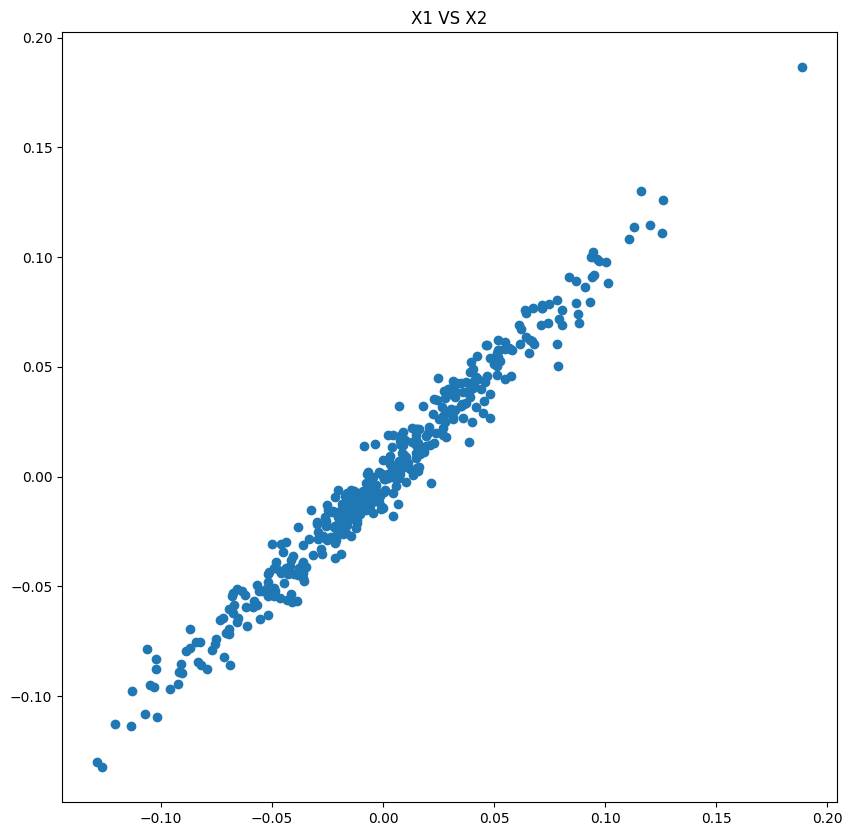

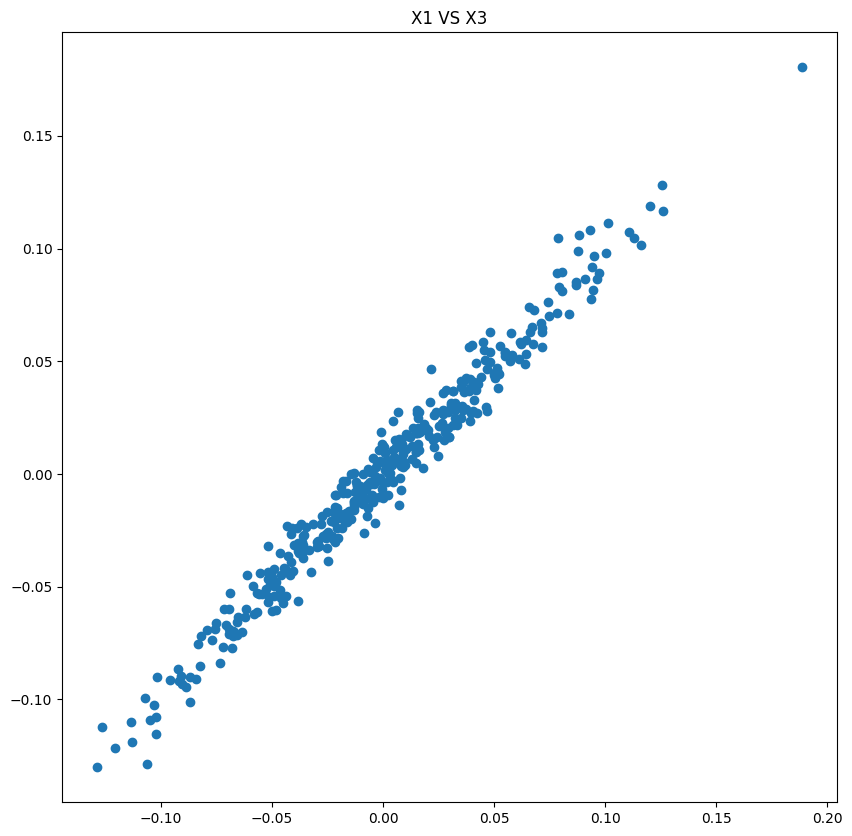

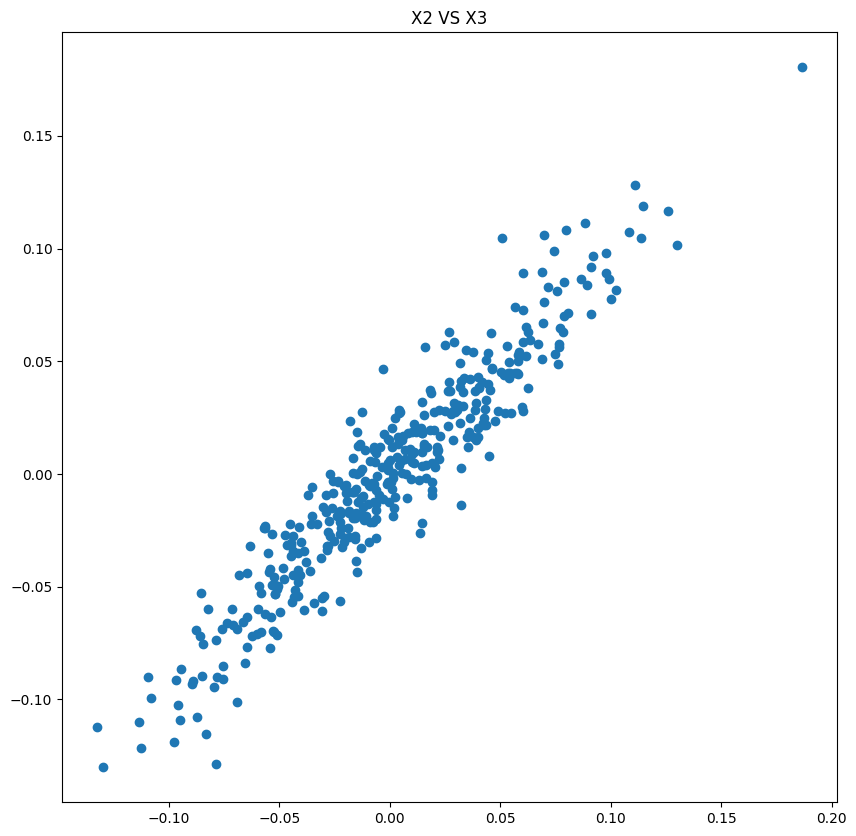

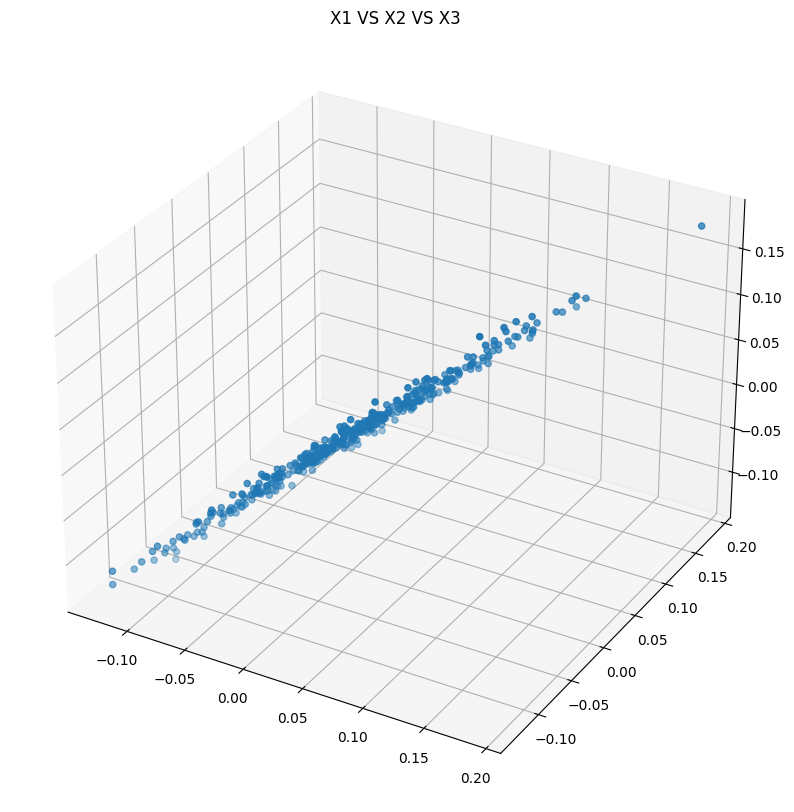

In [7]:
U, loss, outputs = solver.test(views, apply_linear_gcca)
for i in range(len(outputs)):
    outputs[i] = outputs[i]
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(10,10))
        plt.scatter(outputs[i],outputs[j])
        plt.title('X'+str(i+1)+' VS X'+str(j+1))
        plt.show()
fig = plt.figure(figsize=(10,10))
ax3d = fig.add_subplot(projection='3d')
ax3d.scatter(outputs[0],outputs[1],outputs[2]) 
plt.title('X1 VS X2 VS X3')
plt.show()


In [15]:
# 2
N = 400
views = create_synthData_new(N,mode=2,F=20)
print(f'input views shape :')
for i, view in enumerate(views):
    print(f'view_{i} :  {view.shape}')
    view = view.to(device)

U_sum = []
outputs_sum = []
test = []
for i in range(3):
    testm = torch.eye(20)
    test.append(testm)
    
import pandas as pd
for _ in range(100):

    # size of the input for view 1 and view 2
    input_shape_list = [view.shape[-1] for view in views]

    # Building, training, and producing the new features by DCCA
    model = DeepGCCA(layer_sizes_list, input_shape_list, outdim_size,
                             use_all_singular_values, device=device).double()
    l_gcca = None
    if apply_linear_gcca:
        l_gcca = linear_gcca
    solver = Solver(model, l_gcca, outdim_size, epoch_num, batch_size,
                    learning_rate, reg_par, device=device)
    # train1, train2 = data1[0][0], data2[0][0]
    # val1, val2 = data1[1][0], data2[1][0]
    # test1, test2 = data1[2][0], data2[2][0]

    solver.fit(views, checkpoint=save_name)


    # TODO: Save l_gcca model if needed
    _ , _, outputs_def = solver.test(test, apply_linear_gcca)

    A = outputs_def[0]
    B = outputs_def[1]
    C = outputs_def[2]
    U = [A,B,C]

    A = outputs_def[0]
    B = outputs_def[1]
    C = outputs_def[2]

    os = [A,B,C]
    U_sum.append(U)
    outputs_sum.append(os)
    

#variables = pd.DataFrame(U_sum)
#results = pd.DataFrame(results_sum)

ACC = []
F1 = []
MCC = []
Label = torch.cat([torch.ones(2, dtype=torch.bool), torch.zeros(18, dtype=torch.bool)])
for i in range(500):
    acc,f1,mcc = FS_MCC(U_sum[i],Label)
    ACC.append(acc)
    F1.append(f1)
    MCC.append(mcc)

print(np.mean(ACC),np.std(ACC))
print(np.mean(F1),np.std(F1))
print(np.mean(MCC),np.std(MCC))


[ INFO : 2023-07-20 16:30:25,233 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
      )
    )
  )
)
[ INFO : 2023-07-20 16:30:25,314 ] - Adam (
Parameter Group

input views shape :
view_0 :  torch.Size([400, 20])
view_1 :  torch.Size([400, 20])
view_2 :  torch.Size([400, 20])


[ INFO : 2023-07-20 16:30:25,473 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.9877
[ INFO : 2023-07-20 16:30:25,524 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3545
[ INFO : 2023-07-20 16:30:25,583 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6073
[ INFO : 2023-07-20 16:30:25,644 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7835
[ INFO : 2023-07-20 16:30:25,704 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9178
[ INFO : 2023-07-20 16:30:25,759 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0270
[ INFO : 2023-07-20 16:30:25,813 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1162
[ INFO : 2023-07-20 16:30:25,862 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1887
[ INFO : 2023-07-20 16:30:25,917 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2490
[ INFO : 2023-07-20 16:30:25,973 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.3009
[ INFO : 2023-07-20 16:30:26,022 ] - Epoch 13/100 - time: 0.04 - training_loss: -4.3462
[ INFO : 2023-07-20 16:30:26,073 ] - Ep

[ INFO : 2023-07-20 16:30:30,717 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.0668
[ INFO : 2023-07-20 16:30:30,775 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.0703
[ INFO : 2023-07-20 16:30:30,840 ] - Epoch 99/100 - time: 0.06 - training_loss: -5.0739
[ INFO : 2023-07-20 16:30:30,891 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0773
[ INFO : 2023-07-20 16:30:30,935 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(12

Linear CCA started!


[ INFO : 2023-07-20 16:30:31,161 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6698
[ INFO : 2023-07-20 16:30:31,210 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0053
[ INFO : 2023-07-20 16:30:31,262 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3551
[ INFO : 2023-07-20 16:30:31,311 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5874
[ INFO : 2023-07-20 16:30:31,357 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7558
[ INFO : 2023-07-20 16:30:31,403 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8895
[ INFO : 2023-07-20 16:30:31,455 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9984
[ INFO : 2023-07-20 16:30:31,508 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.0878
[ INFO : 2023-07-20 16:30:31,565 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1622
[ INFO : 2023-07-20 16:30:31,626 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2252
[ INFO : 2023-07-20 16:30:31,685 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.2791
[ INFO : 2023-07-20 16:30:31,748 ] - Epo

[ INFO : 2023-07-20 16:30:36,308 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1228
[ INFO : 2023-07-20 16:30:36,373 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1259
[ INFO : 2023-07-20 16:30:36,436 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1289
[ INFO : 2023-07-20 16:30:36,501 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1319
[ INFO : 2023-07-20 16:30:36,553 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1348
[ INFO : 2023-07-20 16:30:36,597 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:30:36,777 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.1040
[ INFO : 2023-07-20 16:30:36,832 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8918
[ INFO : 2023-07-20 16:30:36,885 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2024
[ INFO : 2023-07-20 16:30:36,942 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4795
[ INFO : 2023-07-20 16:30:37,002 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6719
[ INFO : 2023-07-20 16:30:37,055 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8185
[ INFO : 2023-07-20 16:30:37,104 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9371
[ INFO : 2023-07-20 16:30:37,155 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0358
[ INFO : 2023-07-20 16:30:37,213 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1197
[ INFO : 2023-07-20 16:30:37,263 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1925
[ INFO : 2023-07-20 16:30:37,313 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2568
[ INFO : 2023-07-20 16:30:37,364 ] - Epoc

[ INFO : 2023-07-20 16:30:41,957 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.2068
[ INFO : 2023-07-20 16:30:42,012 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2091
[ INFO : 2023-07-20 16:30:42,058 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2113
[ INFO : 2023-07-20 16:30:42,102 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2135
[ INFO : 2023-07-20 16:30:42,164 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2156
[ INFO : 2023-07-20 16:30:42,224 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2177
[ INFO : 2023-07-20 16:30:42,278 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:30:42,479 ] - Epoch 1/100 - time: 0.07 - training_loss: -3.3505
[ INFO : 2023-07-20 16:30:42,530 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7878
[ INFO : 2023-07-20 16:30:42,576 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0224
[ INFO : 2023-07-20 16:30:42,622 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3467
[ INFO : 2023-07-20 16:30:42,681 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.5953
[ INFO : 2023-07-20 16:30:42,742 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7969
[ INFO : 2023-07-20 16:30:42,801 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9458
[ INFO : 2023-07-20 16:30:42,859 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0671
[ INFO : 2023-07-20 16:30:42,915 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1740
[ INFO : 2023-07-20 16:30:42,973 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2670
[ INFO : 2023-07-20 16:30:43,023 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3470
[ INFO : 2023-07-20 16:30:43,070 ] - Epoc

[ INFO : 2023-07-20 16:30:47,831 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2772
[ INFO : 2023-07-20 16:30:47,877 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2787
[ INFO : 2023-07-20 16:30:47,921 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2802
[ INFO : 2023-07-20 16:30:47,969 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2816
[ INFO : 2023-07-20 16:30:48,024 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2830
[ INFO : 2023-07-20 16:30:48,087 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2844
[ INFO : 2023-07-20 16:30:48,153 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:30:48,365 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7876
[ INFO : 2023-07-20 16:30:48,414 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1700
[ INFO : 2023-07-20 16:30:48,466 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4778
[ INFO : 2023-07-20 16:30:48,514 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6790
[ INFO : 2023-07-20 16:30:48,576 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8254
[ INFO : 2023-07-20 16:30:48,637 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9381
[ INFO : 2023-07-20 16:30:48,693 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0284
[ INFO : 2023-07-20 16:30:48,748 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1031
[ INFO : 2023-07-20 16:30:48,797 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1665
[ INFO : 2023-07-20 16:30:48,844 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2214
[ INFO : 2023-07-20 16:30:48,891 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2692
[ INFO : 2023-07-20 16:30:48,938 ] - Epo

[ INFO : 2023-07-20 16:30:53,736 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1080
[ INFO : 2023-07-20 16:30:53,795 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1112
[ INFO : 2023-07-20 16:30:53,853 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1144
[ INFO : 2023-07-20 16:30:53,907 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1175
[ INFO : 2023-07-20 16:30:53,956 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1206
[ INFO : 2023-07-20 16:30:53,997 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:30:54,216 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8242
[ INFO : 2023-07-20 16:30:54,267 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3420
[ INFO : 2023-07-20 16:30:54,316 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6678
[ INFO : 2023-07-20 16:30:54,368 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8766
[ INFO : 2023-07-20 16:30:54,425 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0349
[ INFO : 2023-07-20 16:30:54,474 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1580
[ INFO : 2023-07-20 16:30:54,527 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2539
[ INFO : 2023-07-20 16:30:54,586 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3325
[ INFO : 2023-07-20 16:30:54,647 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.4001
[ INFO : 2023-07-20 16:30:54,701 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4593
[ INFO : 2023-07-20 16:30:54,753 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.5111
[ INFO : 2023-07-20 16:30:54,805 ] - Epo

[ INFO : 2023-07-20 16:30:59,237 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2829
[ INFO : 2023-07-20 16:30:59,287 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2844
[ INFO : 2023-07-20 16:30:59,336 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2858
[ INFO : 2023-07-20 16:30:59,386 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2872
[ INFO : 2023-07-20 16:30:59,445 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2885
[ INFO : 2023-07-20 16:30:59,499 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:30:59,718 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8332
[ INFO : 2023-07-20 16:30:59,767 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2557
[ INFO : 2023-07-20 16:30:59,824 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5350
[ INFO : 2023-07-20 16:30:59,880 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7290
[ INFO : 2023-07-20 16:30:59,934 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8753
[ INFO : 2023-07-20 16:30:59,988 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9923
[ INFO : 2023-07-20 16:31:00,049 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0895
[ INFO : 2023-07-20 16:31:00,112 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1717
[ INFO : 2023-07-20 16:31:00,168 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2421
[ INFO : 2023-07-20 16:31:00,216 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3029
[ INFO : 2023-07-20 16:31:00,260 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.3560
[ INFO : 2023-07-20 16:31:00,313 ] - Epo

[ INFO : 2023-07-20 16:31:04,859 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2204
[ INFO : 2023-07-20 16:31:04,907 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2224
[ INFO : 2023-07-20 16:31:04,954 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2245
[ INFO : 2023-07-20 16:31:05,002 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2265
[ INFO : 2023-07-20 16:31:05,055 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2284
[ INFO : 2023-07-20 16:31:05,098 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:31:05,266 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7707
[ INFO : 2023-07-20 16:31:05,316 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5957
[ INFO : 2023-07-20 16:31:05,365 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0984
[ INFO : 2023-07-20 16:31:05,423 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4269
[ INFO : 2023-07-20 16:31:05,476 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6385
[ INFO : 2023-07-20 16:31:05,525 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7910
[ INFO : 2023-07-20 16:31:05,575 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9065
[ INFO : 2023-07-20 16:31:05,628 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9979
[ INFO : 2023-07-20 16:31:05,677 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.0726
[ INFO : 2023-07-20 16:31:05,729 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1354
[ INFO : 2023-07-20 16:31:05,791 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.1895
[ INFO : 2023-07-20 16:31:05,850 ] - Epoc

[ INFO : 2023-07-20 16:31:10,230 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1029
[ INFO : 2023-07-20 16:31:10,282 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1062
[ INFO : 2023-07-20 16:31:10,340 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1094
[ INFO : 2023-07-20 16:31:10,401 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1126
[ INFO : 2023-07-20 16:31:10,461 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1157
[ INFO : 2023-07-20 16:31:10,517 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1188
[ INFO : 2023-07-20 16:31:10,554 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:31:10,756 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.6581
[ INFO : 2023-07-20 16:31:10,814 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0240
[ INFO : 2023-07-20 16:31:10,873 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.3228
[ INFO : 2023-07-20 16:31:10,931 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.5311
[ INFO : 2023-07-20 16:31:10,984 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6843
[ INFO : 2023-07-20 16:31:11,033 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7993
[ INFO : 2023-07-20 16:31:11,084 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.8900
[ INFO : 2023-07-20 16:31:11,133 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9659
[ INFO : 2023-07-20 16:31:11,183 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0316
[ INFO : 2023-07-20 16:31:11,234 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0891
[ INFO : 2023-07-20 16:31:11,290 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.1398
[ INFO : 2023-07-20 16:31:11,341 ] - Epo

[ INFO : 2023-07-20 16:31:15,640 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.9570
[ INFO : 2023-07-20 16:31:15,688 ] - Epoch 97/100 - time: 0.04 - training_loss: -4.9618
[ INFO : 2023-07-20 16:31:15,755 ] - Epoch 98/100 - time: 0.05 - training_loss: -4.9664
[ INFO : 2023-07-20 16:31:15,816 ] - Epoch 99/100 - time: 0.05 - training_loss: -4.9710
[ INFO : 2023-07-20 16:31:15,865 ] - Epoch 100/100 - time: 0.04 - training_loss: -4.9754
[ INFO : 2023-07-20 16:31:15,908 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:31:16,113 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8240
[ INFO : 2023-07-20 16:31:16,176 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1986
[ INFO : 2023-07-20 16:31:16,231 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5403
[ INFO : 2023-07-20 16:31:16,281 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7729
[ INFO : 2023-07-20 16:31:16,327 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9465
[ INFO : 2023-07-20 16:31:16,375 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0817
[ INFO : 2023-07-20 16:31:16,427 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1930
[ INFO : 2023-07-20 16:31:16,485 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2870
[ INFO : 2023-07-20 16:31:16,543 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3671
[ INFO : 2023-07-20 16:31:16,604 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4361
[ INFO : 2023-07-20 16:31:16,667 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.4964
[ INFO : 2023-07-20 16:31:16,729 ] - Epo

[ INFO : 2023-07-20 16:31:21,040 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2777
[ INFO : 2023-07-20 16:31:21,094 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2792
[ INFO : 2023-07-20 16:31:21,145 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2807
[ INFO : 2023-07-20 16:31:21,195 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2822
[ INFO : 2023-07-20 16:31:21,243 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2836
[ INFO : 2023-07-20 16:31:21,296 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:31:21,512 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7202
[ INFO : 2023-07-20 16:31:21,567 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2089
[ INFO : 2023-07-20 16:31:21,616 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5247
[ INFO : 2023-07-20 16:31:21,664 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7331
[ INFO : 2023-07-20 16:31:21,717 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8866
[ INFO : 2023-07-20 16:31:21,776 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0072
[ INFO : 2023-07-20 16:31:21,830 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1058
[ INFO : 2023-07-20 16:31:21,879 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1883
[ INFO : 2023-07-20 16:31:21,930 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2581
[ INFO : 2023-07-20 16:31:21,978 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3178
[ INFO : 2023-07-20 16:31:22,026 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.3696
[ INFO : 2023-07-20 16:31:22,074 ] - Epo

[ INFO : 2023-07-20 16:31:26,449 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2383
[ INFO : 2023-07-20 16:31:26,510 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2402
[ INFO : 2023-07-20 16:31:26,565 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2421
[ INFO : 2023-07-20 16:31:26,620 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2440
[ INFO : 2023-07-20 16:31:26,675 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2458
[ INFO : 2023-07-20 16:31:26,717 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:31:26,921 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1471
[ INFO : 2023-07-20 16:31:26,972 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4856
[ INFO : 2023-07-20 16:31:27,022 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7677
[ INFO : 2023-07-20 16:31:27,068 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9628
[ INFO : 2023-07-20 16:31:27,116 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1092
[ INFO : 2023-07-20 16:31:27,169 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2238
[ INFO : 2023-07-20 16:31:27,232 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.3162
[ INFO : 2023-07-20 16:31:27,291 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3932
[ INFO : 2023-07-20 16:31:27,346 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.4584
[ INFO : 2023-07-20 16:31:27,398 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.5140
[ INFO : 2023-07-20 16:31:27,460 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.5617
[ INFO : 2023-07-20 16:31:27,511 ] - Epo

[ INFO : 2023-07-20 16:31:31,964 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2813
[ INFO : 2023-07-20 16:31:32,015 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2828
[ INFO : 2023-07-20 16:31:32,057 ] - Epoch 98/100 - time: 0.03 - training_loss: -5.2843
[ INFO : 2023-07-20 16:31:32,099 ] - Epoch 99/100 - time: 0.03 - training_loss: -5.2857
[ INFO : 2023-07-20 16:31:32,148 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2871
[ INFO : 2023-07-20 16:31:32,199 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:31:32,383 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0107
[ INFO : 2023-07-20 16:31:32,428 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6820
[ INFO : 2023-07-20 16:31:32,470 ] - Epoch 3/100 - time: 0.03 - training_loss: -3.0307
[ INFO : 2023-07-20 16:31:32,519 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3151
[ INFO : 2023-07-20 16:31:32,575 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.5055
[ INFO : 2023-07-20 16:31:32,633 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.6455
[ INFO : 2023-07-20 16:31:32,692 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.7520
[ INFO : 2023-07-20 16:31:32,750 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.8373
[ INFO : 2023-07-20 16:31:32,803 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9101
[ INFO : 2023-07-20 16:31:32,852 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.9746
[ INFO : 2023-07-20 16:31:32,896 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0321
[ INFO : 2023-07-20 16:31:32,943 ] - Epoc

[ INFO : 2023-07-20 16:31:37,230 ] - Epoch 95/100 - time: 0.04 - training_loss: -4.9530
[ INFO : 2023-07-20 16:31:37,278 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.9578
[ INFO : 2023-07-20 16:31:37,327 ] - Epoch 97/100 - time: 0.04 - training_loss: -4.9625
[ INFO : 2023-07-20 16:31:37,382 ] - Epoch 98/100 - time: 0.04 - training_loss: -4.9671
[ INFO : 2023-07-20 16:31:37,441 ] - Epoch 99/100 - time: 0.05 - training_loss: -4.9716
[ INFO : 2023-07-20 16:31:37,490 ] - Epoch 100/100 - time: 0.04 - training_loss: -4.9761
[ INFO : 2023-07-20 16:31:37,532 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:31:37,740 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7098
[ INFO : 2023-07-20 16:31:37,799 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1910
[ INFO : 2023-07-20 16:31:37,860 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5326
[ INFO : 2023-07-20 16:31:37,918 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7560
[ INFO : 2023-07-20 16:31:37,968 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9256
[ INFO : 2023-07-20 16:31:38,013 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0563
[ INFO : 2023-07-20 16:31:38,056 ] - Epoch 8/100 - time: 0.03 - training_loss: -4.1597
[ INFO : 2023-07-20 16:31:38,102 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2444
[ INFO : 2023-07-20 16:31:38,173 ] - Epoch 10/100 - time: 0.06 - training_loss: -4.3157
[ INFO : 2023-07-20 16:31:38,229 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.3769
[ INFO : 2023-07-20 16:31:38,286 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.4299
[ INFO : 2023-07-20 16:31:38,345 ] - Epo

[ INFO : 2023-07-20 16:31:42,695 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2551
[ INFO : 2023-07-20 16:31:42,752 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2568
[ INFO : 2023-07-20 16:31:42,809 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2585
[ INFO : 2023-07-20 16:31:42,860 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2602
[ INFO : 2023-07-20 16:31:42,904 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2618
[ INFO : 2023-07-20 16:31:42,945 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:31:43,129 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0691
[ INFO : 2023-07-20 16:31:43,182 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9655
[ INFO : 2023-07-20 16:31:43,231 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3470
[ INFO : 2023-07-20 16:31:43,276 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6463
[ INFO : 2023-07-20 16:31:43,324 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8429
[ INFO : 2023-07-20 16:31:43,375 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9966
[ INFO : 2023-07-20 16:31:43,430 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1209
[ INFO : 2023-07-20 16:31:43,491 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2216
[ INFO : 2023-07-20 16:31:43,548 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3039
[ INFO : 2023-07-20 16:31:43,603 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3719
[ INFO : 2023-07-20 16:31:43,659 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4292
[ INFO : 2023-07-20 16:31:43,715 ] - Epoc

[ INFO : 2023-07-20 16:31:48,102 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2536
[ INFO : 2023-07-20 16:31:48,146 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2553
[ INFO : 2023-07-20 16:31:48,190 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2571
[ INFO : 2023-07-20 16:31:48,242 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2587
[ INFO : 2023-07-20 16:31:48,291 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2604
[ INFO : 2023-07-20 16:31:48,343 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2620
[ INFO : 2023-07-20 16:31:48,398 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:31:48,604 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7964
[ INFO : 2023-07-20 16:31:48,656 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0148
[ INFO : 2023-07-20 16:31:48,716 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.3444
[ INFO : 2023-07-20 16:31:48,771 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5843
[ INFO : 2023-07-20 16:31:48,830 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7478
[ INFO : 2023-07-20 16:31:48,889 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8692
[ INFO : 2023-07-20 16:31:48,947 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9667
[ INFO : 2023-07-20 16:31:48,999 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.0488
[ INFO : 2023-07-20 16:31:49,043 ] - Epoch 10/100 - time: 0.03 - training_loss: -4.1196
[ INFO : 2023-07-20 16:31:49,086 ] - Epoch 11/100 - time: 0.03 - training_loss: -4.1811
[ INFO : 2023-07-20 16:31:49,130 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2346
[ INFO : 2023-07-20 16:31:49,177 ] - Epo

[ INFO : 2023-07-20 16:31:53,549 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.0524
[ INFO : 2023-07-20 16:31:53,596 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0561
[ INFO : 2023-07-20 16:31:53,644 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0597
[ INFO : 2023-07-20 16:31:53,694 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0633
[ INFO : 2023-07-20 16:31:53,744 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0667
[ INFO : 2023-07-20 16:31:53,789 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:31:54,022 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8848
[ INFO : 2023-07-20 16:31:54,064 ] - Epoch 3/100 - time: 0.03 - training_loss: -3.1074
[ INFO : 2023-07-20 16:31:54,108 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3916
[ INFO : 2023-07-20 16:31:54,159 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6023
[ INFO : 2023-07-20 16:31:54,216 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7473
[ INFO : 2023-07-20 16:31:54,269 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8557
[ INFO : 2023-07-20 16:31:54,327 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9435
[ INFO : 2023-07-20 16:31:54,384 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0174
[ INFO : 2023-07-20 16:31:54,433 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0806
[ INFO : 2023-07-20 16:31:54,482 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.1357
[ INFO : 2023-07-20 16:31:54,525 ] - Epoch 12/100 - time: 0.03 - training_loss: -4.1846
[ INFO : 2023-07-20 16:31:54,572 ] - Epo

[ INFO : 2023-07-20 16:31:58,874 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.9835
[ INFO : 2023-07-20 16:31:58,923 ] - Epoch 97/100 - time: 0.04 - training_loss: -4.9881
[ INFO : 2023-07-20 16:31:58,974 ] - Epoch 98/100 - time: 0.04 - training_loss: -4.9925
[ INFO : 2023-07-20 16:31:59,023 ] - Epoch 99/100 - time: 0.04 - training_loss: -4.9969
[ INFO : 2023-07-20 16:31:59,071 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0012
[ INFO : 2023-07-20 16:31:59,113 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:31:59,293 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0269
[ INFO : 2023-07-20 16:31:59,345 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8487
[ INFO : 2023-07-20 16:31:59,394 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2368
[ INFO : 2023-07-20 16:31:59,438 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5700
[ INFO : 2023-07-20 16:31:59,484 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7922
[ INFO : 2023-07-20 16:31:59,533 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9578
[ INFO : 2023-07-20 16:31:59,589 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0838
[ INFO : 2023-07-20 16:31:59,646 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1851
[ INFO : 2023-07-20 16:31:59,704 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2742
[ INFO : 2023-07-20 16:31:59,752 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3554
[ INFO : 2023-07-20 16:31:59,800 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4280
[ INFO : 2023-07-20 16:31:59,848 ] - Epoc

[ INFO : 2023-07-20 16:32:04,134 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2796
[ INFO : 2023-07-20 16:32:04,188 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2811
[ INFO : 2023-07-20 16:32:04,235 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2826
[ INFO : 2023-07-20 16:32:04,278 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2840
[ INFO : 2023-07-20 16:32:04,326 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2855
[ INFO : 2023-07-20 16:32:04,382 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2868
[ INFO : 2023-07-20 16:32:04,434 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:32:04,653 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9182
[ INFO : 2023-07-20 16:32:04,707 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2974
[ INFO : 2023-07-20 16:32:04,757 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5698
[ INFO : 2023-07-20 16:32:04,807 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7471
[ INFO : 2023-07-20 16:32:04,858 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8735
[ INFO : 2023-07-20 16:32:04,917 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9674
[ INFO : 2023-07-20 16:32:04,971 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0414
[ INFO : 2023-07-20 16:32:05,020 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1029
[ INFO : 2023-07-20 16:32:05,067 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1556
[ INFO : 2023-07-20 16:32:05,114 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2017
[ INFO : 2023-07-20 16:32:05,161 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2425
[ INFO : 2023-07-20 16:32:05,211 ] - Epo

[ INFO : 2023-07-20 16:32:09,633 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1588
[ INFO : 2023-07-20 16:32:09,680 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1615
[ INFO : 2023-07-20 16:32:09,733 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1641
[ INFO : 2023-07-20 16:32:09,792 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1668
[ INFO : 2023-07-20 16:32:09,843 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1693
[ INFO : 2023-07-20 16:32:09,888 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:32:10,114 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8233
[ INFO : 2023-07-20 16:32:10,161 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2348
[ INFO : 2023-07-20 16:32:10,211 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5210
[ INFO : 2023-07-20 16:32:10,268 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7033
[ INFO : 2023-07-20 16:32:10,319 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8370
[ INFO : 2023-07-20 16:32:10,368 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9409
[ INFO : 2023-07-20 16:32:10,418 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0243
[ INFO : 2023-07-20 16:32:10,476 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0934
[ INFO : 2023-07-20 16:32:10,528 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1525
[ INFO : 2023-07-20 16:32:10,575 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2045
[ INFO : 2023-07-20 16:32:10,621 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2514
[ INFO : 2023-07-20 16:32:10,674 ] - Epo

[ INFO : 2023-07-20 16:32:15,013 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2228
[ INFO : 2023-07-20 16:32:15,062 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2249
[ INFO : 2023-07-20 16:32:15,108 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2269
[ INFO : 2023-07-20 16:32:15,153 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2289
[ INFO : 2023-07-20 16:32:15,223 ] - Epoch 100/100 - time: 0.06 - training_loss: -5.2308
[ INFO : 2023-07-20 16:32:15,276 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:32:15,484 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7911
[ INFO : 2023-07-20 16:32:15,534 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3436
[ INFO : 2023-07-20 16:32:15,581 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6735
[ INFO : 2023-07-20 16:32:15,635 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8853
[ INFO : 2023-07-20 16:32:15,691 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0342
[ INFO : 2023-07-20 16:32:15,756 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1452
[ INFO : 2023-07-20 16:32:15,814 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2308
[ INFO : 2023-07-20 16:32:15,864 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2992
[ INFO : 2023-07-20 16:32:15,910 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3558
[ INFO : 2023-07-20 16:32:15,955 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4039
[ INFO : 2023-07-20 16:32:16,009 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.4455
[ INFO : 2023-07-20 16:32:16,067 ] - Epo

[ INFO : 2023-07-20 16:32:20,516 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2254
[ INFO : 2023-07-20 16:32:20,571 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2274
[ INFO : 2023-07-20 16:32:20,627 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2294
[ INFO : 2023-07-20 16:32:20,683 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2313
[ INFO : 2023-07-20 16:32:20,741 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2332
[ INFO : 2023-07-20 16:32:20,789 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:32:20,992 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7467
[ INFO : 2023-07-20 16:32:21,051 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1187
[ INFO : 2023-07-20 16:32:21,109 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4248
[ INFO : 2023-07-20 16:32:21,158 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6459
[ INFO : 2023-07-20 16:32:21,206 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8023
[ INFO : 2023-07-20 16:32:21,251 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9173
[ INFO : 2023-07-20 16:32:21,300 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0091
[ INFO : 2023-07-20 16:32:21,356 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.0851
[ INFO : 2023-07-20 16:32:21,416 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1488
[ INFO : 2023-07-20 16:32:21,475 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2034
[ INFO : 2023-07-20 16:32:21,533 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.2511
[ INFO : 2023-07-20 16:32:21,586 ] - Epo

[ INFO : 2023-07-20 16:32:26,100 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1113
[ INFO : 2023-07-20 16:32:26,155 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1145
[ INFO : 2023-07-20 16:32:26,212 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1176
[ INFO : 2023-07-20 16:32:26,274 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1207
[ INFO : 2023-07-20 16:32:26,323 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1237
[ INFO : 2023-07-20 16:32:26,363 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:32:26,583 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.6443
[ INFO : 2023-07-20 16:32:26,639 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.9534
[ INFO : 2023-07-20 16:32:26,691 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2817
[ INFO : 2023-07-20 16:32:26,744 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5054
[ INFO : 2023-07-20 16:32:26,793 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6771
[ INFO : 2023-07-20 16:32:26,850 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8088
[ INFO : 2023-07-20 16:32:26,900 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9111
[ INFO : 2023-07-20 16:32:26,952 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9933
[ INFO : 2023-07-20 16:32:27,005 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0625
[ INFO : 2023-07-20 16:32:27,065 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.1231
[ INFO : 2023-07-20 16:32:27,122 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.1776
[ INFO : 2023-07-20 16:32:27,176 ] - Epo

[ INFO : 2023-07-20 16:32:31,488 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2077
[ INFO : 2023-07-20 16:32:31,550 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2099
[ INFO : 2023-07-20 16:32:31,607 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2120
[ INFO : 2023-07-20 16:32:31,653 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2141
[ INFO : 2023-07-20 16:32:31,696 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2162
[ INFO : 2023-07-20 16:32:31,742 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:32:31,932 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.6863
[ INFO : 2023-07-20 16:32:31,986 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5503
[ INFO : 2023-07-20 16:32:32,038 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0704
[ INFO : 2023-07-20 16:32:32,085 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4579
[ INFO : 2023-07-20 16:32:32,131 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7251
[ INFO : 2023-07-20 16:32:32,182 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9154
[ INFO : 2023-07-20 16:32:32,242 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0561
[ INFO : 2023-07-20 16:32:32,301 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1646
[ INFO : 2023-07-20 16:32:32,359 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2514
[ INFO : 2023-07-20 16:32:32,416 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3226
[ INFO : 2023-07-20 16:32:32,472 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3822
[ INFO : 2023-07-20 16:32:32,520 ] - Epoc

[ INFO : 2023-07-20 16:32:37,075 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2221
[ INFO : 2023-07-20 16:32:37,123 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2242
[ INFO : 2023-07-20 16:32:37,181 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2263
[ INFO : 2023-07-20 16:32:37,239 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2283
[ INFO : 2023-07-20 16:32:37,299 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2303
[ INFO : 2023-07-20 16:32:37,357 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2322
[ INFO : 2023-07-20 16:32:37,405 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:32:37,611 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.6919
[ INFO : 2023-07-20 16:32:37,668 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0093
[ INFO : 2023-07-20 16:32:37,724 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3425
[ INFO : 2023-07-20 16:32:37,782 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.5698
[ INFO : 2023-07-20 16:32:37,841 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7485
[ INFO : 2023-07-20 16:32:37,889 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8933
[ INFO : 2023-07-20 16:32:37,935 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0118
[ INFO : 2023-07-20 16:32:37,986 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1093
[ INFO : 2023-07-20 16:32:38,042 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1910
[ INFO : 2023-07-20 16:32:38,100 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2610
[ INFO : 2023-07-20 16:32:38,156 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.3229
[ INFO : 2023-07-20 16:32:38,210 ] - Epo

[ INFO : 2023-07-20 16:32:42,724 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2431
[ INFO : 2023-07-20 16:32:42,780 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2450
[ INFO : 2023-07-20 16:32:42,831 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2468
[ INFO : 2023-07-20 16:32:42,882 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2485
[ INFO : 2023-07-20 16:32:42,931 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2503
[ INFO : 2023-07-20 16:32:42,975 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:32:43,170 ] - Epoch 1/100 - time: 0.06 - training_loss: -3.0008
[ INFO : 2023-07-20 16:32:43,228 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7876
[ INFO : 2023-07-20 16:32:43,287 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3124
[ INFO : 2023-07-20 16:32:43,339 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6511
[ INFO : 2023-07-20 16:32:43,387 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8765
[ INFO : 2023-07-20 16:32:43,433 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0355
[ INFO : 2023-07-20 16:32:43,491 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1567
[ INFO : 2023-07-20 16:32:43,553 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2523
[ INFO : 2023-07-20 16:32:43,612 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3284
[ INFO : 2023-07-20 16:32:43,674 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3902
[ INFO : 2023-07-20 16:32:43,729 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4415
[ INFO : 2023-07-20 16:32:43,779 ] - Epoc

[ INFO : 2023-07-20 16:32:48,269 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1540
[ INFO : 2023-07-20 16:32:48,318 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1569
[ INFO : 2023-07-20 16:32:48,368 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1597
[ INFO : 2023-07-20 16:32:48,428 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1624
[ INFO : 2023-07-20 16:32:48,492 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1651
[ INFO : 2023-07-20 16:32:48,548 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.1677
[ INFO : 2023-07-20 16:32:48,594 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:32:48,796 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7594
[ INFO : 2023-07-20 16:32:48,854 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1918
[ INFO : 2023-07-20 16:32:48,915 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5265
[ INFO : 2023-07-20 16:32:48,976 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7458
[ INFO : 2023-07-20 16:32:49,026 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9118
[ INFO : 2023-07-20 16:32:49,077 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0385
[ INFO : 2023-07-20 16:32:49,124 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1363
[ INFO : 2023-07-20 16:32:49,183 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2153
[ INFO : 2023-07-20 16:32:49,228 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2812
[ INFO : 2023-07-20 16:32:49,280 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3372
[ INFO : 2023-07-20 16:32:49,339 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.3851
[ INFO : 2023-07-20 16:32:49,397 ] - Epo

[ INFO : 2023-07-20 16:32:53,897 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1435
[ INFO : 2023-07-20 16:32:53,949 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1464
[ INFO : 2023-07-20 16:32:54,000 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1491
[ INFO : 2023-07-20 16:32:54,047 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1519
[ INFO : 2023-07-20 16:32:54,099 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1545
[ INFO : 2023-07-20 16:32:54,141 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:32:54,379 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.0582
[ INFO : 2023-07-20 16:32:54,444 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3655
[ INFO : 2023-07-20 16:32:54,498 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6446
[ INFO : 2023-07-20 16:32:54,547 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8299
[ INFO : 2023-07-20 16:32:54,598 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9822
[ INFO : 2023-07-20 16:32:54,650 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1084
[ INFO : 2023-07-20 16:32:54,698 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2128
[ INFO : 2023-07-20 16:32:54,745 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3035
[ INFO : 2023-07-20 16:32:54,800 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3862
[ INFO : 2023-07-20 16:32:54,859 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4614
[ INFO : 2023-07-20 16:32:54,918 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.5272
[ INFO : 2023-07-20 16:32:54,977 ] - Epo

[ INFO : 2023-07-20 16:32:59,474 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2960
[ INFO : 2023-07-20 16:32:59,535 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2973
[ INFO : 2023-07-20 16:32:59,588 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2986
[ INFO : 2023-07-20 16:32:59,641 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2999
[ INFO : 2023-07-20 16:32:59,691 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.3011
[ INFO : 2023-07-20 16:32:59,743 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:32:59,928 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.3783
[ INFO : 2023-07-20 16:32:59,981 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.2025
[ INFO : 2023-07-20 16:33:00,033 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4263
[ INFO : 2023-07-20 16:33:00,084 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7328
[ INFO : 2023-07-20 16:33:00,136 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9368
[ INFO : 2023-07-20 16:33:00,182 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0779
[ INFO : 2023-07-20 16:33:00,230 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1871
[ INFO : 2023-07-20 16:33:00,279 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2726
[ INFO : 2023-07-20 16:33:00,328 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3412
[ INFO : 2023-07-20 16:33:00,387 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3985
[ INFO : 2023-07-20 16:33:00,444 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4481
[ INFO : 2023-07-20 16:33:00,507 ] - Epoc

[ INFO : 2023-07-20 16:33:05,024 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.2404
[ INFO : 2023-07-20 16:33:05,077 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2424
[ INFO : 2023-07-20 16:33:05,126 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2442
[ INFO : 2023-07-20 16:33:05,172 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2461
[ INFO : 2023-07-20 16:33:05,216 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2479
[ INFO : 2023-07-20 16:33:05,262 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2497
[ INFO : 2023-07-20 16:33:05,311 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:33:05,545 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6983
[ INFO : 2023-07-20 16:33:05,591 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1157
[ INFO : 2023-07-20 16:33:05,639 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4215
[ INFO : 2023-07-20 16:33:05,696 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6222
[ INFO : 2023-07-20 16:33:05,757 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7735
[ INFO : 2023-07-20 16:33:05,822 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8917
[ INFO : 2023-07-20 16:33:05,883 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9854
[ INFO : 2023-07-20 16:33:05,946 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0618
[ INFO : 2023-07-20 16:33:06,007 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1264
[ INFO : 2023-07-20 16:33:06,067 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.1828
[ INFO : 2023-07-20 16:33:06,114 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2330
[ INFO : 2023-07-20 16:33:06,159 ] - Epo

[ INFO : 2023-07-20 16:33:10,651 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1793
[ INFO : 2023-07-20 16:33:10,705 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1818
[ INFO : 2023-07-20 16:33:10,765 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1842
[ INFO : 2023-07-20 16:33:10,819 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1866
[ INFO : 2023-07-20 16:33:10,872 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1890
[ INFO : 2023-07-20 16:33:10,919 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:33:11,137 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8352
[ INFO : 2023-07-20 16:33:11,193 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1709
[ INFO : 2023-07-20 16:33:11,242 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4605
[ INFO : 2023-07-20 16:33:11,291 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6563
[ INFO : 2023-07-20 16:33:11,340 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7942
[ INFO : 2023-07-20 16:33:11,390 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8991
[ INFO : 2023-07-20 16:33:11,438 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9837
[ INFO : 2023-07-20 16:33:11,494 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0544
[ INFO : 2023-07-20 16:33:11,553 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1147
[ INFO : 2023-07-20 16:33:11,609 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.1669
[ INFO : 2023-07-20 16:33:11,666 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2133
[ INFO : 2023-07-20 16:33:11,723 ] - Epo

[ INFO : 2023-07-20 16:33:16,593 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1102
[ INFO : 2023-07-20 16:33:16,650 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1134
[ INFO : 2023-07-20 16:33:16,698 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1165
[ INFO : 2023-07-20 16:33:16,752 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1196
[ INFO : 2023-07-20 16:33:16,816 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.1226
[ INFO : 2023-07-20 16:33:16,880 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:33:17,114 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.7253
[ INFO : 2023-07-20 16:33:17,179 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9551
[ INFO : 2023-07-20 16:33:17,227 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3372
[ INFO : 2023-07-20 16:33:17,279 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6422
[ INFO : 2023-07-20 16:33:17,337 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8404
[ INFO : 2023-07-20 16:33:17,407 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9864
[ INFO : 2023-07-20 16:33:17,480 ] - Epoch 7/100 - time: 0.06 - training_loss: -4.0994
[ INFO : 2023-07-20 16:33:17,552 ] - Epoch 8/100 - time: 0.06 - training_loss: -4.1897
[ INFO : 2023-07-20 16:33:17,615 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2639
[ INFO : 2023-07-20 16:33:17,670 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3261
[ INFO : 2023-07-20 16:33:17,721 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3789
[ INFO : 2023-07-20 16:33:17,775 ] - Epoc

[ INFO : 2023-07-20 16:33:22,916 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.2098
[ INFO : 2023-07-20 16:33:22,972 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2120
[ INFO : 2023-07-20 16:33:23,033 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2142
[ INFO : 2023-07-20 16:33:23,093 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2164
[ INFO : 2023-07-20 16:33:23,151 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2185
[ INFO : 2023-07-20 16:33:23,202 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2206
[ INFO : 2023-07-20 16:33:23,241 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:33:23,475 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8973
[ INFO : 2023-07-20 16:33:23,536 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3510
[ INFO : 2023-07-20 16:33:23,588 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6445
[ INFO : 2023-07-20 16:33:23,639 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8428
[ INFO : 2023-07-20 16:33:23,691 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9931
[ INFO : 2023-07-20 16:33:23,751 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1129
[ INFO : 2023-07-20 16:33:23,802 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2130
[ INFO : 2023-07-20 16:33:23,849 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3028
[ INFO : 2023-07-20 16:33:23,896 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3850
[ INFO : 2023-07-20 16:33:23,943 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4581
[ INFO : 2023-07-20 16:33:23,996 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.5213
[ INFO : 2023-07-20 16:33:24,059 ] - Epo

[ INFO : 2023-07-20 16:33:28,739 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2917
[ INFO : 2023-07-20 16:33:28,787 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2930
[ INFO : 2023-07-20 16:33:28,839 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2943
[ INFO : 2023-07-20 16:33:28,898 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2956
[ INFO : 2023-07-20 16:33:28,959 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2969
[ INFO : 2023-07-20 16:33:29,011 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:33:29,205 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8911
[ INFO : 2023-07-20 16:33:29,251 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2586
[ INFO : 2023-07-20 16:33:29,298 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5803
[ INFO : 2023-07-20 16:33:29,353 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8015
[ INFO : 2023-07-20 16:33:29,413 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9697
[ INFO : 2023-07-20 16:33:29,470 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1113
[ INFO : 2023-07-20 16:33:29,529 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2296
[ INFO : 2023-07-20 16:33:29,578 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3268
[ INFO : 2023-07-20 16:33:29,620 ] - Epoch 10/100 - time: 0.03 - training_loss: -4.4103
[ INFO : 2023-07-20 16:33:29,664 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4839
[ INFO : 2023-07-20 16:33:29,715 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.5492
[ INFO : 2023-07-20 16:33:29,771 ] - Epo

[ INFO : 2023-07-20 16:33:34,112 ] - Epoch 96/100 - time: 0.03 - training_loss: -5.3025
[ INFO : 2023-07-20 16:33:34,160 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.3037
[ INFO : 2023-07-20 16:33:34,215 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.3050
[ INFO : 2023-07-20 16:33:34,277 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.3062
[ INFO : 2023-07-20 16:33:34,332 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.3074
[ INFO : 2023-07-20 16:33:34,385 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:33:34,592 ] - Epoch 2/100 - time: 0.03 - training_loss: -2.5256
[ INFO : 2023-07-20 16:33:34,649 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.9809
[ INFO : 2023-07-20 16:33:34,708 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.3068
[ INFO : 2023-07-20 16:33:34,762 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5248
[ INFO : 2023-07-20 16:33:34,816 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6782
[ INFO : 2023-07-20 16:33:34,873 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.7930
[ INFO : 2023-07-20 16:33:34,935 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.8835
[ INFO : 2023-07-20 16:33:34,989 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9582
[ INFO : 2023-07-20 16:33:35,035 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0220
[ INFO : 2023-07-20 16:33:35,082 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0776
[ INFO : 2023-07-20 16:33:35,127 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.1269
[ INFO : 2023-07-20 16:33:35,178 ] - Epo

[ INFO : 2023-07-20 16:33:39,476 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1761
[ INFO : 2023-07-20 16:33:39,538 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1786
[ INFO : 2023-07-20 16:33:39,599 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1810
[ INFO : 2023-07-20 16:33:39,653 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1834
[ INFO : 2023-07-20 16:33:39,695 ] - Epoch 100/100 - time: 0.03 - training_loss: -5.1858
[ INFO : 2023-07-20 16:33:39,730 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:33:39,975 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8299
[ INFO : 2023-07-20 16:33:40,033 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2843
[ INFO : 2023-07-20 16:33:40,079 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5872
[ INFO : 2023-07-20 16:33:40,123 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7995
[ INFO : 2023-07-20 16:33:40,169 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9525
[ INFO : 2023-07-20 16:33:40,226 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0672
[ INFO : 2023-07-20 16:33:40,283 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1581
[ INFO : 2023-07-20 16:33:40,341 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2327
[ INFO : 2023-07-20 16:33:40,403 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2953
[ INFO : 2023-07-20 16:33:40,468 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.3485
[ INFO : 2023-07-20 16:33:40,522 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.3943
[ INFO : 2023-07-20 16:33:40,570 ] - Epo

[ INFO : 2023-07-20 16:33:45,096 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.0821
[ INFO : 2023-07-20 16:33:45,139 ] - Epoch 97/100 - time: 0.03 - training_loss: -5.0857
[ INFO : 2023-07-20 16:33:45,190 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0892
[ INFO : 2023-07-20 16:33:45,243 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0926
[ INFO : 2023-07-20 16:33:45,300 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.0960
[ INFO : 2023-07-20 16:33:45,348 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:33:45,548 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9380
[ INFO : 2023-07-20 16:33:45,607 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3964
[ INFO : 2023-07-20 16:33:45,662 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6953
[ INFO : 2023-07-20 16:33:45,722 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8895
[ INFO : 2023-07-20 16:33:45,782 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0278
[ INFO : 2023-07-20 16:33:45,837 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1360
[ INFO : 2023-07-20 16:33:45,886 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2236
[ INFO : 2023-07-20 16:33:45,934 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2952
[ INFO : 2023-07-20 16:33:45,984 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3546
[ INFO : 2023-07-20 16:33:46,035 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4052
[ INFO : 2023-07-20 16:33:46,094 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.4491
[ INFO : 2023-07-20 16:33:46,151 ] - Epo

[ INFO : 2023-07-20 16:33:50,639 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2116
[ INFO : 2023-07-20 16:33:50,686 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2138
[ INFO : 2023-07-20 16:33:50,734 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2160
[ INFO : 2023-07-20 16:33:50,780 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2180
[ INFO : 2023-07-20 16:33:50,829 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2201
[ INFO : 2023-07-20 16:33:50,878 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:33:51,063 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.1355
[ INFO : 2023-07-20 16:33:51,111 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9723
[ INFO : 2023-07-20 16:33:51,154 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1878
[ INFO : 2023-07-20 16:33:51,203 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4855
[ INFO : 2023-07-20 16:33:51,256 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7086
[ INFO : 2023-07-20 16:33:51,311 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8681
[ INFO : 2023-07-20 16:33:51,365 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9891
[ INFO : 2023-07-20 16:33:51,424 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0867
[ INFO : 2023-07-20 16:33:51,483 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1678
[ INFO : 2023-07-20 16:33:51,540 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2358
[ INFO : 2023-07-20 16:33:51,590 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2931
[ INFO : 2023-07-20 16:33:51,634 ] - Epoc

[ INFO : 2023-07-20 16:33:55,995 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1579
[ INFO : 2023-07-20 16:33:56,045 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1606
[ INFO : 2023-07-20 16:33:56,097 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1633
[ INFO : 2023-07-20 16:33:56,155 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1659
[ INFO : 2023-07-20 16:33:56,208 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1685
[ INFO : 2023-07-20 16:33:56,258 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1711
[ INFO : 2023-07-20 16:33:56,300 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:33:56,493 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9539
[ INFO : 2023-07-20 16:33:56,545 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7200
[ INFO : 2023-07-20 16:33:56,597 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2488
[ INFO : 2023-07-20 16:33:56,641 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5983
[ INFO : 2023-07-20 16:33:56,686 ] - Epoch 5/100 - time: 0.03 - training_loss: -3.8182
[ INFO : 2023-07-20 16:33:56,741 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9702
[ INFO : 2023-07-20 16:33:56,796 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0855
[ INFO : 2023-07-20 16:33:56,854 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1767
[ INFO : 2023-07-20 16:33:56,908 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2501
[ INFO : 2023-07-20 16:33:56,958 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3105
[ INFO : 2023-07-20 16:33:57,008 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3614
[ INFO : 2023-07-20 16:33:57,061 ] - Epoc

[ INFO : 2023-07-20 16:34:01,387 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.0945
[ INFO : 2023-07-20 16:34:01,439 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.0979
[ INFO : 2023-07-20 16:34:01,495 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1012
[ INFO : 2023-07-20 16:34:01,555 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1044
[ INFO : 2023-07-20 16:34:01,617 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1076
[ INFO : 2023-07-20 16:34:01,670 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1108
[ INFO : 2023-07-20 16:34:01,712 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:34:01,930 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7954
[ INFO : 2023-07-20 16:34:01,997 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1598
[ INFO : 2023-07-20 16:34:02,072 ] - Epoch 4/100 - time: 0.06 - training_loss: -3.5135
[ INFO : 2023-07-20 16:34:02,131 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7710
[ INFO : 2023-07-20 16:34:02,181 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9469
[ INFO : 2023-07-20 16:34:02,234 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0744
[ INFO : 2023-07-20 16:34:02,283 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1749
[ INFO : 2023-07-20 16:34:02,338 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2579
[ INFO : 2023-07-20 16:34:02,400 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3271
[ INFO : 2023-07-20 16:34:02,478 ] - Epoch 11/100 - time: 0.06 - training_loss: -4.3849
[ INFO : 2023-07-20 16:34:02,553 ] - Epoch 12/100 - time: 0.06 - training_loss: -4.4339
[ INFO : 2023-07-20 16:34:02,630 ] - Epo

[ INFO : 2023-07-20 16:34:07,167 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2322
[ INFO : 2023-07-20 16:34:07,214 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2342
[ INFO : 2023-07-20 16:34:07,261 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2361
[ INFO : 2023-07-20 16:34:07,313 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2380
[ INFO : 2023-07-20 16:34:07,368 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2398
[ INFO : 2023-07-20 16:34:07,426 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:34:07,666 ] - Epoch 1/100 - time: 0.07 - training_loss: -3.0478
[ INFO : 2023-07-20 16:34:07,721 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8015
[ INFO : 2023-07-20 16:34:07,769 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3368
[ INFO : 2023-07-20 16:34:07,812 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6826
[ INFO : 2023-07-20 16:34:07,866 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9118
[ INFO : 2023-07-20 16:34:07,931 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0735
[ INFO : 2023-07-20 16:34:07,999 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1907
[ INFO : 2023-07-20 16:34:08,066 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2809
[ INFO : 2023-07-20 16:34:08,134 ] - Epoch 9/100 - time: 0.06 - training_loss: -4.3529
[ INFO : 2023-07-20 16:34:08,183 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.4110
[ INFO : 2023-07-20 16:34:08,228 ] - Epoch 11/100 - time: 0.03 - training_loss: -4.4593
[ INFO : 2023-07-20 16:34:08,273 ] - Epoc

[ INFO : 2023-07-20 16:34:12,770 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.0452
[ INFO : 2023-07-20 16:34:12,827 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.0491
[ INFO : 2023-07-20 16:34:12,881 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0530
[ INFO : 2023-07-20 16:34:12,926 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0568
[ INFO : 2023-07-20 16:34:12,969 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0605
[ INFO : 2023-07-20 16:34:13,018 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0641
[ INFO : 2023-07-20 16:34:13,071 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:34:13,271 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0178
[ INFO : 2023-07-20 16:34:13,320 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7731
[ INFO : 2023-07-20 16:34:13,371 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0818
[ INFO : 2023-07-20 16:34:13,417 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3809
[ INFO : 2023-07-20 16:34:13,463 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5824
[ INFO : 2023-07-20 16:34:13,510 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7433
[ INFO : 2023-07-20 16:34:13,566 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8760
[ INFO : 2023-07-20 16:34:13,627 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9845
[ INFO : 2023-07-20 16:34:13,687 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0753
[ INFO : 2023-07-20 16:34:13,747 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1545
[ INFO : 2023-07-20 16:34:13,801 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2256
[ INFO : 2023-07-20 16:34:13,851 ] - Epoc

[ INFO : 2023-07-20 16:34:18,513 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2333
[ INFO : 2023-07-20 16:34:18,574 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2353
[ INFO : 2023-07-20 16:34:18,639 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2373
[ INFO : 2023-07-20 16:34:18,701 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2392
[ INFO : 2023-07-20 16:34:18,766 ] - Epoch 99/100 - time: 0.06 - training_loss: -5.2411
[ INFO : 2023-07-20 16:34:18,812 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2430
[ INFO : 2023-07-20 16:34:18,854 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:34:19,107 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7972
[ INFO : 2023-07-20 16:34:19,168 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1494
[ INFO : 2023-07-20 16:34:19,215 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4471
[ INFO : 2023-07-20 16:34:19,260 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6469
[ INFO : 2023-07-20 16:34:19,308 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7879
[ INFO : 2023-07-20 16:34:19,367 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8943
[ INFO : 2023-07-20 16:34:19,427 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9794
[ INFO : 2023-07-20 16:34:19,489 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0493
[ INFO : 2023-07-20 16:34:19,550 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1078
[ INFO : 2023-07-20 16:34:19,613 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.1580
[ INFO : 2023-07-20 16:34:19,675 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.2027
[ INFO : 2023-07-20 16:34:19,729 ] - Epo

[ INFO : 2023-07-20 16:34:24,416 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1141
[ INFO : 2023-07-20 16:34:24,484 ] - Epoch 97/100 - time: 0.06 - training_loss: -5.1173
[ INFO : 2023-07-20 16:34:24,536 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1204
[ INFO : 2023-07-20 16:34:24,586 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1234
[ INFO : 2023-07-20 16:34:24,639 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1264
[ INFO : 2023-07-20 16:34:24,685 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:34:24,927 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.0111
[ INFO : 2023-07-20 16:34:24,977 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3512
[ INFO : 2023-07-20 16:34:25,030 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6687
[ INFO : 2023-07-20 16:34:25,089 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8760
[ INFO : 2023-07-20 16:34:25,152 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0378
[ INFO : 2023-07-20 16:34:25,204 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1729
[ INFO : 2023-07-20 16:34:25,256 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2873
[ INFO : 2023-07-20 16:34:25,310 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3827
[ INFO : 2023-07-20 16:34:25,366 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.4610
[ INFO : 2023-07-20 16:34:25,424 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.5263
[ INFO : 2023-07-20 16:34:25,481 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.5832
[ INFO : 2023-07-20 16:34:25,530 ] - Epo

[ INFO : 2023-07-20 16:34:30,074 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2943
[ INFO : 2023-07-20 16:34:30,120 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2956
[ INFO : 2023-07-20 16:34:30,172 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2969
[ INFO : 2023-07-20 16:34:30,226 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2981
[ INFO : 2023-07-20 16:34:30,286 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2994
[ INFO : 2023-07-20 16:34:30,338 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:34:30,519 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.2392
[ INFO : 2023-07-20 16:34:30,575 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.0128
[ INFO : 2023-07-20 16:34:30,637 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1592
[ INFO : 2023-07-20 16:34:30,692 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4890
[ INFO : 2023-07-20 16:34:30,747 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7011
[ INFO : 2023-07-20 16:34:30,803 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8591
[ INFO : 2023-07-20 16:34:30,860 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9828
[ INFO : 2023-07-20 16:34:30,911 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0823
[ INFO : 2023-07-20 16:34:30,962 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1643
[ INFO : 2023-07-20 16:34:31,014 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2334
[ INFO : 2023-07-20 16:34:31,065 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2926
[ INFO : 2023-07-20 16:34:31,116 ] - Epoc

[ INFO : 2023-07-20 16:34:35,891 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1846
[ INFO : 2023-07-20 16:34:35,940 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1870
[ INFO : 2023-07-20 16:34:35,992 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1894
[ INFO : 2023-07-20 16:34:36,048 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1918
[ INFO : 2023-07-20 16:34:36,099 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1941
[ INFO : 2023-07-20 16:34:36,149 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1963
[ INFO : 2023-07-20 16:34:36,197 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:34:36,385 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0524
[ INFO : 2023-07-20 16:34:36,436 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7400
[ INFO : 2023-07-20 16:34:36,487 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2621
[ INFO : 2023-07-20 16:34:36,541 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5939
[ INFO : 2023-07-20 16:34:36,592 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8175
[ INFO : 2023-07-20 16:34:36,642 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9780
[ INFO : 2023-07-20 16:34:36,699 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0986
[ INFO : 2023-07-20 16:34:36,756 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1925
[ INFO : 2023-07-20 16:34:36,814 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2675
[ INFO : 2023-07-20 16:34:36,869 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3289
[ INFO : 2023-07-20 16:34:36,924 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3802
[ INFO : 2023-07-20 16:34:36,975 ] - Epoc

[ INFO : 2023-07-20 16:34:41,469 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1812
[ INFO : 2023-07-20 16:34:41,526 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1837
[ INFO : 2023-07-20 16:34:41,584 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1861
[ INFO : 2023-07-20 16:34:41,644 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1886
[ INFO : 2023-07-20 16:34:41,703 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1909
[ INFO : 2023-07-20 16:34:41,755 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1933
[ INFO : 2023-07-20 16:34:41,799 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:34:42,025 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8772
[ INFO : 2023-07-20 16:34:42,083 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0331
[ INFO : 2023-07-20 16:34:42,142 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.3975
[ INFO : 2023-07-20 16:34:42,205 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6421
[ INFO : 2023-07-20 16:34:42,255 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8188
[ INFO : 2023-07-20 16:34:42,306 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9564
[ INFO : 2023-07-20 16:34:42,351 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0650
[ INFO : 2023-07-20 16:34:42,398 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1533
[ INFO : 2023-07-20 16:34:42,449 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2272
[ INFO : 2023-07-20 16:34:42,506 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2903
[ INFO : 2023-07-20 16:34:42,565 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.3445
[ INFO : 2023-07-20 16:34:42,625 ] - Epo

[ INFO : 2023-07-20 16:34:47,408 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1317
[ INFO : 2023-07-20 16:34:47,466 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1348
[ INFO : 2023-07-20 16:34:47,516 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1377
[ INFO : 2023-07-20 16:34:47,562 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1406
[ INFO : 2023-07-20 16:34:47,612 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1435
[ INFO : 2023-07-20 16:34:47,659 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:34:47,868 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1202
[ INFO : 2023-07-20 16:34:47,928 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9112
[ INFO : 2023-07-20 16:34:47,983 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2761
[ INFO : 2023-07-20 16:34:48,031 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5890
[ INFO : 2023-07-20 16:34:48,075 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7932
[ INFO : 2023-07-20 16:34:48,124 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9478
[ INFO : 2023-07-20 16:34:48,185 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0706
[ INFO : 2023-07-20 16:34:48,243 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1712
[ INFO : 2023-07-20 16:34:48,301 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2562
[ INFO : 2023-07-20 16:34:48,359 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3292
[ INFO : 2023-07-20 16:34:48,405 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3926
[ INFO : 2023-07-20 16:34:48,450 ] - Epoc

[ INFO : 2023-07-20 16:34:53,100 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2655
[ INFO : 2023-07-20 16:34:53,149 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2672
[ INFO : 2023-07-20 16:34:53,201 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2687
[ INFO : 2023-07-20 16:34:53,252 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2703
[ INFO : 2023-07-20 16:34:53,312 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2718
[ INFO : 2023-07-20 16:34:53,365 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2733
[ INFO : 2023-07-20 16:34:53,408 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:34:53,643 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5265
[ INFO : 2023-07-20 16:34:53,694 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.8721
[ INFO : 2023-07-20 16:34:53,745 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1895
[ INFO : 2023-07-20 16:34:53,794 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4204
[ INFO : 2023-07-20 16:34:53,843 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.5985
[ INFO : 2023-07-20 16:34:53,891 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7426
[ INFO : 2023-07-20 16:34:53,938 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.8646
[ INFO : 2023-07-20 16:34:53,980 ] - Epoch 9/100 - time: 0.03 - training_loss: -3.9729
[ INFO : 2023-07-20 16:34:54,030 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0727
[ INFO : 2023-07-20 16:34:54,085 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.1653
[ INFO : 2023-07-20 16:34:54,135 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2481
[ INFO : 2023-07-20 16:34:54,190 ] - Epo

[ INFO : 2023-07-20 16:34:58,806 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2542
[ INFO : 2023-07-20 16:34:58,866 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2559
[ INFO : 2023-07-20 16:34:58,916 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2576
[ INFO : 2023-07-20 16:34:58,964 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2593
[ INFO : 2023-07-20 16:34:59,020 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2609
[ INFO : 2023-07-20 16:34:59,065 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:34:59,254 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.6851
[ INFO : 2023-07-20 16:34:59,309 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8514
[ INFO : 2023-07-20 16:34:59,367 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2969
[ INFO : 2023-07-20 16:34:59,429 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6236
[ INFO : 2023-07-20 16:34:59,497 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8411
[ INFO : 2023-07-20 16:34:59,561 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0078
[ INFO : 2023-07-20 16:34:59,623 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1407
[ INFO : 2023-07-20 16:34:59,696 ] - Epoch 8/100 - time: 0.06 - training_loss: -4.2504
[ INFO : 2023-07-20 16:34:59,770 ] - Epoch 9/100 - time: 0.06 - training_loss: -4.3429
[ INFO : 2023-07-20 16:34:59,835 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.4208
[ INFO : 2023-07-20 16:34:59,896 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4862
[ INFO : 2023-07-20 16:34:59,951 ] - Epoc

[ INFO : 2023-07-20 16:35:04,470 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2819
[ INFO : 2023-07-20 16:35:04,522 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2834
[ INFO : 2023-07-20 16:35:04,581 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2848
[ INFO : 2023-07-20 16:35:04,640 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2863
[ INFO : 2023-07-20 16:35:04,700 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2877
[ INFO : 2023-07-20 16:35:04,748 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2890
[ INFO : 2023-07-20 16:35:04,785 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:35:05,012 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7631
[ INFO : 2023-07-20 16:35:05,069 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1070
[ INFO : 2023-07-20 16:35:05,120 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4528
[ INFO : 2023-07-20 16:35:05,172 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6775
[ INFO : 2023-07-20 16:35:05,225 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8331
[ INFO : 2023-07-20 16:35:05,276 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9463
[ INFO : 2023-07-20 16:35:05,323 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0334
[ INFO : 2023-07-20 16:35:05,376 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1038
[ INFO : 2023-07-20 16:35:05,433 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1624
[ INFO : 2023-07-20 16:35:05,490 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2125
[ INFO : 2023-07-20 16:35:05,547 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.2560
[ INFO : 2023-07-20 16:35:05,601 ] - Epo

[ INFO : 2023-07-20 16:35:10,312 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.9998
[ INFO : 2023-07-20 16:35:10,364 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0042
[ INFO : 2023-07-20 16:35:10,411 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0084
[ INFO : 2023-07-20 16:35:10,458 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0126
[ INFO : 2023-07-20 16:35:10,509 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0167
[ INFO : 2023-07-20 16:35:10,558 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:35:10,732 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0737
[ INFO : 2023-07-20 16:35:10,781 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8645
[ INFO : 2023-07-20 16:35:10,830 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3477
[ INFO : 2023-07-20 16:35:10,884 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6526
[ INFO : 2023-07-20 16:35:10,939 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8496
[ INFO : 2023-07-20 16:35:10,994 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9905
[ INFO : 2023-07-20 16:35:11,048 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1017
[ INFO : 2023-07-20 16:35:11,098 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1930
[ INFO : 2023-07-20 16:35:11,146 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2694
[ INFO : 2023-07-20 16:35:11,195 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3344
[ INFO : 2023-07-20 16:35:11,243 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3902
[ INFO : 2023-07-20 16:35:11,290 ] - Epoc

[ INFO : 2023-07-20 16:35:15,598 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2457
[ INFO : 2023-07-20 16:35:15,655 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2475
[ INFO : 2023-07-20 16:35:15,714 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2493
[ INFO : 2023-07-20 16:35:15,773 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2511
[ INFO : 2023-07-20 16:35:15,823 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2528
[ INFO : 2023-07-20 16:35:15,871 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2546
[ INFO : 2023-07-20 16:35:15,913 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:35:16,096 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7778
[ INFO : 2023-07-20 16:35:16,149 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5386
[ INFO : 2023-07-20 16:35:16,316 ] - Epoch 3/100 - time: 0.16 - training_loss: -3.0602
[ INFO : 2023-07-20 16:35:16,590 ] - Epoch 4/100 - time: 0.27 - training_loss: -3.4573
[ INFO : 2023-07-20 16:35:16,647 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7192
[ INFO : 2023-07-20 16:35:16,698 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8929
[ INFO : 2023-07-20 16:35:16,742 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0204
[ INFO : 2023-07-20 16:35:16,784 ] - Epoch 8/100 - time: 0.03 - training_loss: -4.1197
[ INFO : 2023-07-20 16:35:16,833 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1995
[ INFO : 2023-07-20 16:35:16,892 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2653
[ INFO : 2023-07-20 16:35:16,948 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.3206
[ INFO : 2023-07-20 16:35:17,006 ] - Epoc

[ INFO : 2023-07-20 16:35:21,305 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.0709
[ INFO : 2023-07-20 16:35:21,349 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.0745
[ INFO : 2023-07-20 16:35:21,398 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0780
[ INFO : 2023-07-20 16:35:21,459 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.0815
[ INFO : 2023-07-20 16:35:21,519 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.0849
[ INFO : 2023-07-20 16:35:21,581 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.0883
[ INFO : 2023-07-20 16:35:21,636 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:35:21,866 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6161
[ INFO : 2023-07-20 16:35:21,917 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0675
[ INFO : 2023-07-20 16:35:21,969 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3915
[ INFO : 2023-07-20 16:35:22,025 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6069
[ INFO : 2023-07-20 16:35:22,081 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7666
[ INFO : 2023-07-20 16:35:22,130 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8876
[ INFO : 2023-07-20 16:35:22,178 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9836
[ INFO : 2023-07-20 16:35:22,232 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.0631
[ INFO : 2023-07-20 16:35:22,283 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1303
[ INFO : 2023-07-20 16:35:22,331 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.1879
[ INFO : 2023-07-20 16:35:22,381 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2377
[ INFO : 2023-07-20 16:35:22,437 ] - Epo

[ INFO : 2023-07-20 16:35:26,786 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.0549
[ INFO : 2023-07-20 16:35:26,840 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0586
[ INFO : 2023-07-20 16:35:26,888 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0623
[ INFO : 2023-07-20 16:35:26,934 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0660
[ INFO : 2023-07-20 16:35:26,978 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0695
[ INFO : 2023-07-20 16:35:27,017 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:35:27,198 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1117
[ INFO : 2023-07-20 16:35:27,258 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7143
[ INFO : 2023-07-20 16:35:27,314 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2073
[ INFO : 2023-07-20 16:35:27,366 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5161
[ INFO : 2023-07-20 16:35:27,415 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7288
[ INFO : 2023-07-20 16:35:27,514 ] - Epoch 6/100 - time: 0.09 - training_loss: -3.8925
[ INFO : 2023-07-20 16:35:27,565 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0259
[ INFO : 2023-07-20 16:35:27,622 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1397
[ INFO : 2023-07-20 16:35:27,677 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2410
[ INFO : 2023-07-20 16:35:27,727 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3299
[ INFO : 2023-07-20 16:35:27,777 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4082
[ INFO : 2023-07-20 16:35:27,831 ] - Epoc

[ INFO : 2023-07-20 16:35:32,267 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2929
[ INFO : 2023-07-20 16:35:32,315 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2942
[ INFO : 2023-07-20 16:35:32,362 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2956
[ INFO : 2023-07-20 16:35:32,411 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2968
[ INFO : 2023-07-20 16:35:32,461 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2981
[ INFO : 2023-07-20 16:35:32,511 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2993
[ INFO : 2023-07-20 16:35:32,561 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:35:32,757 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.2870
[ INFO : 2023-07-20 16:35:32,810 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9261
[ INFO : 2023-07-20 16:35:32,858 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2427
[ INFO : 2023-07-20 16:35:32,904 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5173
[ INFO : 2023-07-20 16:35:32,949 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7134
[ INFO : 2023-07-20 16:35:32,995 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8594
[ INFO : 2023-07-20 16:35:33,051 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9672
[ INFO : 2023-07-20 16:35:33,110 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0495
[ INFO : 2023-07-20 16:35:33,167 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1149
[ INFO : 2023-07-20 16:35:33,226 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1692
[ INFO : 2023-07-20 16:35:33,285 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2156
[ INFO : 2023-07-20 16:35:33,340 ] - Epoc

[ INFO : 2023-07-20 16:35:37,722 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.0626
[ INFO : 2023-07-20 16:35:37,773 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.0665
[ INFO : 2023-07-20 16:35:37,830 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0702
[ INFO : 2023-07-20 16:35:37,884 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0739
[ INFO : 2023-07-20 16:35:37,942 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.0775
[ INFO : 2023-07-20 16:35:37,989 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0810
[ INFO : 2023-07-20 16:35:38,025 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:35:38,251 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.6257
[ INFO : 2023-07-20 16:35:38,310 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0269
[ INFO : 2023-07-20 16:35:38,360 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3271
[ INFO : 2023-07-20 16:35:38,410 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5218
[ INFO : 2023-07-20 16:35:38,463 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6627
[ INFO : 2023-07-20 16:35:38,518 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7742
[ INFO : 2023-07-20 16:35:38,567 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.8673
[ INFO : 2023-07-20 16:35:38,616 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9481
[ INFO : 2023-07-20 16:35:38,673 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.0197
[ INFO : 2023-07-20 16:35:38,736 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.0839
[ INFO : 2023-07-20 16:35:38,803 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.1414
[ INFO : 2023-07-20 16:35:38,859 ] - Epo

[ INFO : 2023-07-20 16:35:43,357 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.8861
[ INFO : 2023-07-20 16:35:43,417 ] - Epoch 97/100 - time: 0.05 - training_loss: -4.8904
[ INFO : 2023-07-20 16:35:43,465 ] - Epoch 98/100 - time: 0.04 - training_loss: -4.8946
[ INFO : 2023-07-20 16:35:43,508 ] - Epoch 99/100 - time: 0.03 - training_loss: -4.8989
[ INFO : 2023-07-20 16:35:43,556 ] - Epoch 100/100 - time: 0.04 - training_loss: -4.9033
[ INFO : 2023-07-20 16:35:43,609 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:35:43,810 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1228
[ INFO : 2023-07-20 16:35:43,857 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8272
[ INFO : 2023-07-20 16:35:43,906 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0608
[ INFO : 2023-07-20 16:35:43,957 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4006
[ INFO : 2023-07-20 16:35:44,003 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6183
[ INFO : 2023-07-20 16:35:44,050 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7728
[ INFO : 2023-07-20 16:35:44,103 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8981
[ INFO : 2023-07-20 16:35:44,160 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0021
[ INFO : 2023-07-20 16:35:44,226 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0878
[ INFO : 2023-07-20 16:35:44,286 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1601
[ INFO : 2023-07-20 16:35:44,339 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2232
[ INFO : 2023-07-20 16:35:44,383 ] - Epoc

[ INFO : 2023-07-20 16:35:48,891 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2138
[ INFO : 2023-07-20 16:35:48,949 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2160
[ INFO : 2023-07-20 16:35:49,004 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2181
[ INFO : 2023-07-20 16:35:49,049 ] - Epoch 98/100 - time: 0.03 - training_loss: -5.2202
[ INFO : 2023-07-20 16:35:49,093 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2222
[ INFO : 2023-07-20 16:35:49,141 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2242
[ INFO : 2023-07-20 16:35:49,205 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:35:49,437 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9345
[ INFO : 2023-07-20 16:35:49,497 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9643
[ INFO : 2023-07-20 16:35:49,551 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1920
[ INFO : 2023-07-20 16:35:49,596 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5436
[ INFO : 2023-07-20 16:35:49,641 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7762
[ INFO : 2023-07-20 16:35:49,695 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9457
[ INFO : 2023-07-20 16:35:49,756 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0745
[ INFO : 2023-07-20 16:35:49,816 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1750
[ INFO : 2023-07-20 16:35:49,881 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2559
[ INFO : 2023-07-20 16:35:49,949 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3228
[ INFO : 2023-07-20 16:35:50,014 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.3794
[ INFO : 2023-07-20 16:35:50,068 ] - Epoc

[ INFO : 2023-07-20 16:35:54,637 ] - Epoch 95/100 - time: 0.03 - training_loss: -5.2127
[ INFO : 2023-07-20 16:35:54,689 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2149
[ INFO : 2023-07-20 16:35:54,746 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2170
[ INFO : 2023-07-20 16:35:54,796 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2191
[ INFO : 2023-07-20 16:35:54,849 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2211
[ INFO : 2023-07-20 16:35:54,898 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2231
[ INFO : 2023-07-20 16:35:54,936 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:35:55,132 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5555
[ INFO : 2023-07-20 16:35:55,192 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.7995
[ INFO : 2023-07-20 16:35:55,250 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.1009
[ INFO : 2023-07-20 16:35:55,309 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.3412
[ INFO : 2023-07-20 16:35:55,365 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.5182
[ INFO : 2023-07-20 16:35:55,412 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.6518
[ INFO : 2023-07-20 16:35:55,465 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.7594
[ INFO : 2023-07-20 16:35:55,514 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.8500
[ INFO : 2023-07-20 16:35:55,561 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.9278
[ INFO : 2023-07-20 16:35:55,609 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.9953
[ INFO : 2023-07-20 16:35:55,659 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.0543
[ INFO : 2023-07-20 16:35:55,711 ] - Epo

[ INFO : 2023-07-20 16:36:00,172 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.0457
[ INFO : 2023-07-20 16:36:00,226 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0496
[ INFO : 2023-07-20 16:36:00,274 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0534
[ INFO : 2023-07-20 16:36:00,321 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0571
[ INFO : 2023-07-20 16:36:00,369 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0607
[ INFO : 2023-07-20 16:36:00,419 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:36:00,615 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0972
[ INFO : 2023-07-20 16:36:00,665 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8756
[ INFO : 2023-07-20 16:36:00,725 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2585
[ INFO : 2023-07-20 16:36:00,780 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5774
[ INFO : 2023-07-20 16:36:00,832 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7891
[ INFO : 2023-07-20 16:36:00,884 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9432
[ INFO : 2023-07-20 16:36:00,947 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0579
[ INFO : 2023-07-20 16:36:01,003 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1463
[ INFO : 2023-07-20 16:36:01,061 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2172
[ INFO : 2023-07-20 16:36:01,112 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2760
[ INFO : 2023-07-20 16:36:01,165 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3264
[ INFO : 2023-07-20 16:36:01,219 ] - Epoc

[ INFO : 2023-07-20 16:36:05,875 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.0628
[ INFO : 2023-07-20 16:36:05,922 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.0666
[ INFO : 2023-07-20 16:36:05,977 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0703
[ INFO : 2023-07-20 16:36:06,027 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0740
[ INFO : 2023-07-20 16:36:06,078 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0775
[ INFO : 2023-07-20 16:36:06,131 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0810
[ INFO : 2023-07-20 16:36:06,178 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:36:06,364 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9800
[ INFO : 2023-07-20 16:36:06,422 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7110
[ INFO : 2023-07-20 16:36:06,490 ] - Epoch 3/100 - time: 0.06 - training_loss: -3.2402
[ INFO : 2023-07-20 16:36:06,545 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5639
[ INFO : 2023-07-20 16:36:06,591 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7799
[ INFO : 2023-07-20 16:36:06,635 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9333
[ INFO : 2023-07-20 16:36:06,688 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0480
[ INFO : 2023-07-20 16:36:06,750 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1384
[ INFO : 2023-07-20 16:36:06,811 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2122
[ INFO : 2023-07-20 16:36:06,871 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2736
[ INFO : 2023-07-20 16:36:06,921 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3254
[ INFO : 2023-07-20 16:36:06,967 ] - Epoc

[ INFO : 2023-07-20 16:36:11,521 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1557
[ INFO : 2023-07-20 16:36:11,568 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1585
[ INFO : 2023-07-20 16:36:11,621 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1612
[ INFO : 2023-07-20 16:36:11,677 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1638
[ INFO : 2023-07-20 16:36:11,740 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.1664
[ INFO : 2023-07-20 16:36:11,803 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.1690
[ INFO : 2023-07-20 16:36:11,863 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:36:12,051 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.9828
[ INFO : 2023-07-20 16:36:12,095 ] - Epoch 2/100 - time: 0.03 - training_loss: -2.8981
[ INFO : 2023-07-20 16:36:12,146 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1499
[ INFO : 2023-07-20 16:36:12,204 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4882
[ INFO : 2023-07-20 16:36:12,268 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7120
[ INFO : 2023-07-20 16:36:12,331 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8726
[ INFO : 2023-07-20 16:36:12,384 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9997
[ INFO : 2023-07-20 16:36:12,435 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1025
[ INFO : 2023-07-20 16:36:12,485 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1850
[ INFO : 2023-07-20 16:36:12,533 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2522
[ INFO : 2023-07-20 16:36:12,585 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3088
[ INFO : 2023-07-20 16:36:12,642 ] - Epoc

[ INFO : 2023-07-20 16:36:17,220 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.0785
[ INFO : 2023-07-20 16:36:17,282 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.0821
[ INFO : 2023-07-20 16:36:17,346 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.0856
[ INFO : 2023-07-20 16:36:17,402 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0890
[ INFO : 2023-07-20 16:36:17,454 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0924
[ INFO : 2023-07-20 16:36:17,506 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0957
[ INFO : 2023-07-20 16:36:17,553 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:36:17,777 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9718
[ INFO : 2023-07-20 16:36:17,830 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3565
[ INFO : 2023-07-20 16:36:17,879 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6924
[ INFO : 2023-07-20 16:36:17,931 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9075
[ INFO : 2023-07-20 16:36:17,989 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0611
[ INFO : 2023-07-20 16:36:18,046 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1779
[ INFO : 2023-07-20 16:36:18,102 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2693
[ INFO : 2023-07-20 16:36:18,151 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3434
[ INFO : 2023-07-20 16:36:18,201 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.4053
[ INFO : 2023-07-20 16:36:18,253 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4576
[ INFO : 2023-07-20 16:36:18,307 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.5023
[ INFO : 2023-07-20 16:36:18,359 ] - Epo

[ INFO : 2023-07-20 16:36:22,965 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2018
[ INFO : 2023-07-20 16:36:23,026 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2041
[ INFO : 2023-07-20 16:36:23,078 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2063
[ INFO : 2023-07-20 16:36:23,127 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2085
[ INFO : 2023-07-20 16:36:23,172 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2107
[ INFO : 2023-07-20 16:36:23,219 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:36:23,416 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0841
[ INFO : 2023-07-20 16:36:23,471 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7595
[ INFO : 2023-07-20 16:36:23,517 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0577
[ INFO : 2023-07-20 16:36:23,560 ] - Epoch 4/100 - time: 0.03 - training_loss: -3.4067
[ INFO : 2023-07-20 16:36:23,615 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6371
[ INFO : 2023-07-20 16:36:23,673 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8080
[ INFO : 2023-07-20 16:36:23,736 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9425
[ INFO : 2023-07-20 16:36:23,800 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0517
[ INFO : 2023-07-20 16:36:23,862 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1421
[ INFO : 2023-07-20 16:36:23,913 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2183
[ INFO : 2023-07-20 16:36:23,963 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2839
[ INFO : 2023-07-20 16:36:24,020 ] - Epoc

[ INFO : 2023-07-20 16:36:28,811 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2363
[ INFO : 2023-07-20 16:36:28,862 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2382
[ INFO : 2023-07-20 16:36:28,910 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2401
[ INFO : 2023-07-20 16:36:28,959 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2419
[ INFO : 2023-07-20 16:36:29,017 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2438
[ INFO : 2023-07-20 16:36:29,077 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2455
[ INFO : 2023-07-20 16:36:29,128 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:36:29,344 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8949
[ INFO : 2023-07-20 16:36:29,399 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3849
[ INFO : 2023-07-20 16:36:29,469 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6952
[ INFO : 2023-07-20 16:36:29,525 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8967
[ INFO : 2023-07-20 16:36:29,579 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0426
[ INFO : 2023-07-20 16:36:29,630 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1518
[ INFO : 2023-07-20 16:36:29,687 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2363
[ INFO : 2023-07-20 16:36:29,749 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3036
[ INFO : 2023-07-20 16:36:29,807 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3585
[ INFO : 2023-07-20 16:36:29,859 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4042
[ INFO : 2023-07-20 16:36:29,909 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.4427
[ INFO : 2023-07-20 16:36:29,962 ] - Epo

[ INFO : 2023-07-20 16:36:34,535 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.0297
[ INFO : 2023-07-20 16:36:34,587 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0337
[ INFO : 2023-07-20 16:36:34,635 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0376
[ INFO : 2023-07-20 16:36:34,683 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0415
[ INFO : 2023-07-20 16:36:34,738 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0453
[ INFO : 2023-07-20 16:36:34,793 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:36:35,024 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.6020
[ INFO : 2023-07-20 16:36:35,084 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.7016
[ INFO : 2023-07-20 16:36:35,133 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.9555
[ INFO : 2023-07-20 16:36:35,182 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.2464
[ INFO : 2023-07-20 16:36:35,232 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.4741
[ INFO : 2023-07-20 16:36:35,289 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.6414
[ INFO : 2023-07-20 16:36:35,343 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.7742
[ INFO : 2023-07-20 16:36:35,397 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.8880
[ INFO : 2023-07-20 16:36:35,455 ] - Epoch 10/100 - time: 0.05 - training_loss: -3.9875
[ INFO : 2023-07-20 16:36:35,521 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.0738
[ INFO : 2023-07-20 16:36:35,577 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.1479
[ INFO : 2023-07-20 16:36:35,626 ] - Epo

[ INFO : 2023-07-20 16:36:40,283 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1555
[ INFO : 2023-07-20 16:36:40,339 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1582
[ INFO : 2023-07-20 16:36:40,396 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1609
[ INFO : 2023-07-20 16:36:40,450 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1635
[ INFO : 2023-07-20 16:36:40,509 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.1660
[ INFO : 2023-07-20 16:36:40,558 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:36:40,767 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.8930
[ INFO : 2023-07-20 16:36:40,833 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9129
[ INFO : 2023-07-20 16:36:40,890 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3037
[ INFO : 2023-07-20 16:36:40,935 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6226
[ INFO : 2023-07-20 16:36:40,980 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8241
[ INFO : 2023-07-20 16:36:41,039 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9662
[ INFO : 2023-07-20 16:36:41,099 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0741
[ INFO : 2023-07-20 16:36:41,158 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1607
[ INFO : 2023-07-20 16:36:41,215 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2327
[ INFO : 2023-07-20 16:36:41,276 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2935
[ INFO : 2023-07-20 16:36:41,336 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.3454
[ INFO : 2023-07-20 16:36:41,400 ] - Epoc

[ INFO : 2023-07-20 16:36:45,977 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.1797
[ INFO : 2023-07-20 16:36:46,036 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1822
[ INFO : 2023-07-20 16:36:46,099 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1847
[ INFO : 2023-07-20 16:36:46,157 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1871
[ INFO : 2023-07-20 16:36:46,207 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1895
[ INFO : 2023-07-20 16:36:46,253 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1918
[ INFO : 2023-07-20 16:36:46,301 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:36:46,505 ] - Epoch 1/100 - time: 0.06 - training_loss: -3.3051
[ INFO : 2023-07-20 16:36:46,558 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.0468
[ INFO : 2023-07-20 16:36:46,611 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4288
[ INFO : 2023-07-20 16:36:46,664 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7586
[ INFO : 2023-07-20 16:36:46,722 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.9756
[ INFO : 2023-07-20 16:36:46,775 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1434
[ INFO : 2023-07-20 16:36:46,828 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2802
[ INFO : 2023-07-20 16:36:46,880 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.3913
[ INFO : 2023-07-20 16:36:46,941 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.4821
[ INFO : 2023-07-20 16:36:46,999 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.5588
[ INFO : 2023-07-20 16:36:47,059 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.6246
[ INFO : 2023-07-20 16:36:47,111 ] - Epoc

[ INFO : 2023-07-20 16:36:51,725 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.3170
[ INFO : 2023-07-20 16:36:51,788 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.3181
[ INFO : 2023-07-20 16:36:51,850 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.3192
[ INFO : 2023-07-20 16:36:51,913 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.3202
[ INFO : 2023-07-20 16:36:51,972 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.3213
[ INFO : 2023-07-20 16:36:52,021 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.3223
[ INFO : 2023-07-20 16:36:52,063 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:36:52,270 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.9970
[ INFO : 2023-07-20 16:36:52,331 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7826
[ INFO : 2023-07-20 16:36:52,383 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2349
[ INFO : 2023-07-20 16:36:52,434 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5531
[ INFO : 2023-07-20 16:36:52,490 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7582
[ INFO : 2023-07-20 16:36:52,535 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9113
[ INFO : 2023-07-20 16:36:52,583 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0305
[ INFO : 2023-07-20 16:36:52,631 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1252
[ INFO : 2023-07-20 16:36:52,690 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2020
[ INFO : 2023-07-20 16:36:52,748 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2656
[ INFO : 2023-07-20 16:36:52,809 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.3193
[ INFO : 2023-07-20 16:36:52,876 ] - Epoc

[ INFO : 2023-07-20 16:36:57,490 ] - Epoch 95/100 - time: 0.05 - training_loss: -4.9743
[ INFO : 2023-07-20 16:36:57,544 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.9788
[ INFO : 2023-07-20 16:36:57,596 ] - Epoch 97/100 - time: 0.04 - training_loss: -4.9832
[ INFO : 2023-07-20 16:36:57,647 ] - Epoch 98/100 - time: 0.04 - training_loss: -4.9876
[ INFO : 2023-07-20 16:36:57,702 ] - Epoch 99/100 - time: 0.05 - training_loss: -4.9918
[ INFO : 2023-07-20 16:36:57,753 ] - Epoch 100/100 - time: 0.04 - training_loss: -4.9960
[ INFO : 2023-07-20 16:36:57,800 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:36:58,028 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7462
[ INFO : 2023-07-20 16:36:58,082 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2858
[ INFO : 2023-07-20 16:36:58,133 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6051
[ INFO : 2023-07-20 16:36:58,185 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8210
[ INFO : 2023-07-20 16:36:58,240 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9742
[ INFO : 2023-07-20 16:36:58,296 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0882
[ INFO : 2023-07-20 16:36:58,355 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1776
[ INFO : 2023-07-20 16:36:58,410 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2505
[ INFO : 2023-07-20 16:36:58,476 ] - Epoch 10/100 - time: 0.06 - training_loss: -4.3116
[ INFO : 2023-07-20 16:36:58,528 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3634
[ INFO : 2023-07-20 16:36:58,579 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.4076
[ INFO : 2023-07-20 16:36:58,632 ] - Epo

[ INFO : 2023-07-20 16:37:03,289 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1269
[ INFO : 2023-07-20 16:37:03,341 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1300
[ INFO : 2023-07-20 16:37:03,398 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1330
[ INFO : 2023-07-20 16:37:03,469 ] - Epoch 99/100 - time: 0.06 - training_loss: -5.1359
[ INFO : 2023-07-20 16:37:03,522 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1388
[ INFO : 2023-07-20 16:37:03,567 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:37:03,794 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7286
[ INFO : 2023-07-20 16:37:03,854 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0687
[ INFO : 2023-07-20 16:37:03,904 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3502
[ INFO : 2023-07-20 16:37:03,955 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5338
[ INFO : 2023-07-20 16:37:04,010 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6659
[ INFO : 2023-07-20 16:37:04,067 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7677
[ INFO : 2023-07-20 16:37:04,125 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.8501
[ INFO : 2023-07-20 16:37:04,175 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9191
[ INFO : 2023-07-20 16:37:04,224 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.9784
[ INFO : 2023-07-20 16:37:04,279 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0305
[ INFO : 2023-07-20 16:37:04,341 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.0771
[ INFO : 2023-07-20 16:37:04,399 ] - Epo

[ INFO : 2023-07-20 16:37:09,016 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.0598
[ INFO : 2023-07-20 16:37:09,066 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0635
[ INFO : 2023-07-20 16:37:09,118 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0672
[ INFO : 2023-07-20 16:37:09,166 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0707
[ INFO : 2023-07-20 16:37:09,222 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0742
[ INFO : 2023-07-20 16:37:09,270 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:37:09,488 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1647
[ INFO : 2023-07-20 16:37:09,541 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.5728
[ INFO : 2023-07-20 16:37:09,604 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.8711
[ INFO : 2023-07-20 16:37:09,661 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.0693
[ INFO : 2023-07-20 16:37:09,711 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2098
[ INFO : 2023-07-20 16:37:09,759 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.3160
[ INFO : 2023-07-20 16:37:09,806 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.3984
[ INFO : 2023-07-20 16:37:09,855 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.4640
[ INFO : 2023-07-20 16:37:09,909 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.5182
[ INFO : 2023-07-20 16:37:09,960 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.5640
[ INFO : 2023-07-20 16:37:10,010 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.6034
[ INFO : 2023-07-20 16:37:10,063 ] - Epo

[ INFO : 2023-07-20 16:37:14,614 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2740
[ INFO : 2023-07-20 16:37:14,664 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2756
[ INFO : 2023-07-20 16:37:14,713 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2771
[ INFO : 2023-07-20 16:37:14,772 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2787
[ INFO : 2023-07-20 16:37:14,835 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2802
[ INFO : 2023-07-20 16:37:14,890 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:37:15,113 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7666
[ INFO : 2023-07-20 16:37:15,170 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1280
[ INFO : 2023-07-20 16:37:15,231 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4146
[ INFO : 2023-07-20 16:37:15,287 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6016
[ INFO : 2023-07-20 16:37:15,345 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7331
[ INFO : 2023-07-20 16:37:15,402 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8354
[ INFO : 2023-07-20 16:37:15,470 ] - Epoch 8/100 - time: 0.06 - training_loss: -3.9192
[ INFO : 2023-07-20 16:37:15,521 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9887
[ INFO : 2023-07-20 16:37:15,569 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0472
[ INFO : 2023-07-20 16:37:15,615 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0974
[ INFO : 2023-07-20 16:37:15,663 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.1414
[ INFO : 2023-07-20 16:37:15,722 ] - Epo

[ INFO : 2023-07-20 16:37:20,175 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.0813
[ INFO : 2023-07-20 16:37:20,226 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.0848
[ INFO : 2023-07-20 16:37:20,274 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0882
[ INFO : 2023-07-20 16:37:20,322 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0916
[ INFO : 2023-07-20 16:37:20,379 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.0949
[ INFO : 2023-07-20 16:37:20,432 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:37:20,666 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8546
[ INFO : 2023-07-20 16:37:20,717 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3471
[ INFO : 2023-07-20 16:37:20,772 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6522
[ INFO : 2023-07-20 16:37:20,826 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8531
[ INFO : 2023-07-20 16:37:20,883 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9995
[ INFO : 2023-07-20 16:37:20,937 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1107
[ INFO : 2023-07-20 16:37:20,989 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1993
[ INFO : 2023-07-20 16:37:21,043 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2726
[ INFO : 2023-07-20 16:37:21,093 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3345
[ INFO : 2023-07-20 16:37:21,143 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3874
[ INFO : 2023-07-20 16:37:21,192 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.4330
[ INFO : 2023-07-20 16:37:21,244 ] - Epo

[ INFO : 2023-07-20 16:37:25,642 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.9095
[ INFO : 2023-07-20 16:37:25,687 ] - Epoch 97/100 - time: 0.04 - training_loss: -4.9103
[ INFO : 2023-07-20 16:37:25,742 ] - Epoch 98/100 - time: 0.05 - training_loss: -4.9111
[ INFO : 2023-07-20 16:37:25,801 ] - Epoch 99/100 - time: 0.05 - training_loss: -4.9119
[ INFO : 2023-07-20 16:37:25,863 ] - Epoch 100/100 - time: 0.05 - training_loss: -4.9127
[ INFO : 2023-07-20 16:37:25,917 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:37:26,087 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.3042
[ INFO : 2023-07-20 16:37:26,137 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.0844
[ INFO : 2023-07-20 16:37:26,186 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.5557
[ INFO : 2023-07-20 16:37:26,244 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.8838
[ INFO : 2023-07-20 16:37:26,303 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.0889
[ INFO : 2023-07-20 16:37:26,359 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2332
[ INFO : 2023-07-20 16:37:26,413 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.3393
[ INFO : 2023-07-20 16:37:26,465 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.4193
[ INFO : 2023-07-20 16:37:26,514 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.4825
[ INFO : 2023-07-20 16:37:26,575 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.5347
[ INFO : 2023-07-20 16:37:26,636 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.5787
[ INFO : 2023-07-20 16:37:26,693 ] - Epoc

[ INFO : 2023-07-20 16:37:31,049 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2698
[ INFO : 2023-07-20 16:37:31,102 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2714
[ INFO : 2023-07-20 16:37:31,152 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2730
[ INFO : 2023-07-20 16:37:31,198 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2745
[ INFO : 2023-07-20 16:37:31,247 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2760
[ INFO : 2023-07-20 16:37:31,296 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2775
[ INFO : 2023-07-20 16:37:31,340 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:37:31,545 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1008
[ INFO : 2023-07-20 16:37:31,600 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8259
[ INFO : 2023-07-20 16:37:31,650 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0800
[ INFO : 2023-07-20 16:37:31,694 ] - Epoch 4/100 - time: 0.03 - training_loss: -3.4065
[ INFO : 2023-07-20 16:37:31,736 ] - Epoch 5/100 - time: 0.03 - training_loss: -3.6365
[ INFO : 2023-07-20 16:37:31,793 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8113
[ INFO : 2023-07-20 16:37:31,851 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9485
[ INFO : 2023-07-20 16:37:31,906 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0575
[ INFO : 2023-07-20 16:37:31,970 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1463
[ INFO : 2023-07-20 16:37:32,025 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2210
[ INFO : 2023-07-20 16:37:32,069 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2848
[ INFO : 2023-07-20 16:37:32,112 ] - Epoc

[ INFO : 2023-07-20 16:37:36,512 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.2226
[ INFO : 2023-07-20 16:37:36,560 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2247
[ INFO : 2023-07-20 16:37:36,607 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2267
[ INFO : 2023-07-20 16:37:36,659 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2287
[ INFO : 2023-07-20 16:37:36,709 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2306
[ INFO : 2023-07-20 16:37:36,760 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2325
[ INFO : 2023-07-20 16:37:36,806 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:37:36,981 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1855
[ INFO : 2023-07-20 16:37:37,039 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9481
[ INFO : 2023-07-20 16:37:37,091 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4155
[ INFO : 2023-07-20 16:37:37,140 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7540
[ INFO : 2023-07-20 16:37:37,190 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9720
[ INFO : 2023-07-20 16:37:37,239 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1231
[ INFO : 2023-07-20 16:37:37,286 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2319
[ INFO : 2023-07-20 16:37:37,333 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.3143
[ INFO : 2023-07-20 16:37:37,389 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3797
[ INFO : 2023-07-20 16:37:37,453 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.4337
[ INFO : 2023-07-20 16:37:37,505 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4793
[ INFO : 2023-07-20 16:37:37,553 ] - Epoc

[ INFO : 2023-07-20 16:37:41,884 ] - Epoch 95/100 - time: 0.03 - training_loss: -5.2354
[ INFO : 2023-07-20 16:37:41,942 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2373
[ INFO : 2023-07-20 16:37:42,002 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2392
[ INFO : 2023-07-20 16:37:42,062 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2411
[ INFO : 2023-07-20 16:37:42,120 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2429
[ INFO : 2023-07-20 16:37:42,179 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2447
[ INFO : 2023-07-20 16:37:42,233 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:37:42,443 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.5618
[ INFO : 2023-07-20 16:37:42,495 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0621
[ INFO : 2023-07-20 16:37:42,546 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4094
[ INFO : 2023-07-20 16:37:42,601 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6373
[ INFO : 2023-07-20 16:37:42,660 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8137
[ INFO : 2023-07-20 16:37:42,718 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9554
[ INFO : 2023-07-20 16:37:42,774 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0693
[ INFO : 2023-07-20 16:37:42,830 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1621
[ INFO : 2023-07-20 16:37:42,878 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2389
[ INFO : 2023-07-20 16:37:42,926 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3038
[ INFO : 2023-07-20 16:37:42,973 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.3596
[ INFO : 2023-07-20 16:37:43,024 ] - Epo

[ INFO : 2023-07-20 16:37:47,361 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2250
[ INFO : 2023-07-20 16:37:47,411 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2271
[ INFO : 2023-07-20 16:37:47,463 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2291
[ INFO : 2023-07-20 16:37:47,512 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2311
[ INFO : 2023-07-20 16:37:47,564 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2330
[ INFO : 2023-07-20 16:37:47,617 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:37:47,781 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.9377
[ INFO : 2023-07-20 16:37:47,836 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6743
[ INFO : 2023-07-20 16:37:47,895 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.9268
[ INFO : 2023-07-20 16:37:47,947 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2693
[ INFO : 2023-07-20 16:37:47,998 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4998
[ INFO : 2023-07-20 16:37:48,049 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6702
[ INFO : 2023-07-20 16:37:48,100 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8095
[ INFO : 2023-07-20 16:37:48,144 ] - Epoch 8/100 - time: 0.03 - training_loss: -3.9264
[ INFO : 2023-07-20 16:37:48,189 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.0239
[ INFO : 2023-07-20 16:37:48,234 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1050
[ INFO : 2023-07-20 16:37:48,287 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.1731
[ INFO : 2023-07-20 16:37:48,345 ] - Epoc

[ INFO : 2023-07-20 16:37:52,622 ] - Epoch 95/100 - time: 0.03 - training_loss: -4.9609
[ INFO : 2023-07-20 16:37:52,671 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.9655
[ INFO : 2023-07-20 16:37:52,730 ] - Epoch 97/100 - time: 0.04 - training_loss: -4.9701
[ INFO : 2023-07-20 16:37:52,787 ] - Epoch 98/100 - time: 0.05 - training_loss: -4.9745
[ INFO : 2023-07-20 16:37:52,843 ] - Epoch 99/100 - time: 0.04 - training_loss: -4.9790
[ INFO : 2023-07-20 16:37:52,902 ] - Epoch 100/100 - time: 0.05 - training_loss: -4.9833
[ INFO : 2023-07-20 16:37:52,959 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:37:53,174 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7280
[ INFO : 2023-07-20 16:37:53,234 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2528
[ INFO : 2023-07-20 16:37:53,290 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5718
[ INFO : 2023-07-20 16:37:53,343 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7858
[ INFO : 2023-07-20 16:37:53,390 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9372
[ INFO : 2023-07-20 16:37:53,436 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0534
[ INFO : 2023-07-20 16:37:53,487 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1463
[ INFO : 2023-07-20 16:37:53,549 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2216
[ INFO : 2023-07-20 16:37:53,606 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2839
[ INFO : 2023-07-20 16:37:53,659 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3367
[ INFO : 2023-07-20 16:37:53,715 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.3824
[ INFO : 2023-07-20 16:37:53,767 ] - Epo

[ INFO : 2023-07-20 16:37:58,145 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1293
[ INFO : 2023-07-20 16:37:58,205 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1324
[ INFO : 2023-07-20 16:37:58,260 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1355
[ INFO : 2023-07-20 16:37:58,309 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1384
[ INFO : 2023-07-20 16:37:58,352 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1414
[ INFO : 2023-07-20 16:37:58,393 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:37:58,609 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.2202
[ INFO : 2023-07-20 16:37:58,664 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9512
[ INFO : 2023-07-20 16:37:58,724 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3690
[ INFO : 2023-07-20 16:37:58,780 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6652
[ INFO : 2023-07-20 16:37:58,825 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8705
[ INFO : 2023-07-20 16:37:58,868 ] - Epoch 6/100 - time: 0.03 - training_loss: -4.0243
[ INFO : 2023-07-20 16:37:58,919 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1408
[ INFO : 2023-07-20 16:37:58,976 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2329
[ INFO : 2023-07-20 16:37:59,038 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3087
[ INFO : 2023-07-20 16:37:59,096 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3725
[ INFO : 2023-07-20 16:37:59,153 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4271
[ INFO : 2023-07-20 16:37:59,204 ] - Epoc

[ INFO : 2023-07-20 16:38:03,555 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2498
[ INFO : 2023-07-20 16:38:03,602 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2516
[ INFO : 2023-07-20 16:38:03,654 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2533
[ INFO : 2023-07-20 16:38:03,704 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2550
[ INFO : 2023-07-20 16:38:03,755 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2567
[ INFO : 2023-07-20 16:38:03,808 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2584
[ INFO : 2023-07-20 16:38:03,860 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:38:04,046 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.1277
[ INFO : 2023-07-20 16:38:04,096 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9186
[ INFO : 2023-07-20 16:38:04,146 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0691
[ INFO : 2023-07-20 16:38:04,193 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3584
[ INFO : 2023-07-20 16:38:04,244 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5681
[ INFO : 2023-07-20 16:38:04,294 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7130
[ INFO : 2023-07-20 16:38:04,350 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8211
[ INFO : 2023-07-20 16:38:04,407 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9066
[ INFO : 2023-07-20 16:38:04,472 ] - Epoch 9/100 - time: 0.05 - training_loss: -3.9762
[ INFO : 2023-07-20 16:38:04,531 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.0347
[ INFO : 2023-07-20 16:38:04,580 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0856
[ INFO : 2023-07-20 16:38:04,624 ] - Epoc

[ INFO : 2023-07-20 16:38:09,045 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.0146
[ INFO : 2023-07-20 16:38:09,108 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.0188
[ INFO : 2023-07-20 16:38:09,167 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.0229
[ INFO : 2023-07-20 16:38:09,228 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.0270
[ INFO : 2023-07-20 16:38:09,279 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.0310
[ INFO : 2023-07-20 16:38:09,328 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.0349
[ INFO : 2023-07-20 16:38:09,368 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:38:09,571 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.7651
[ INFO : 2023-07-20 16:38:09,628 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6746
[ INFO : 2023-07-20 16:38:09,686 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.1425
[ INFO : 2023-07-20 16:38:09,745 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4825
[ INFO : 2023-07-20 16:38:09,795 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7003
[ INFO : 2023-07-20 16:38:09,844 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8614
[ INFO : 2023-07-20 16:38:09,889 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9868
[ INFO : 2023-07-20 16:38:09,946 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0853
[ INFO : 2023-07-20 16:38:10,005 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1643
[ INFO : 2023-07-20 16:38:10,067 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2302
[ INFO : 2023-07-20 16:38:10,124 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2864
[ INFO : 2023-07-20 16:38:10,182 ] - Epoc

[ INFO : 2023-07-20 16:38:14,626 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1242
[ INFO : 2023-07-20 16:38:14,681 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1273
[ INFO : 2023-07-20 16:38:14,733 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1303
[ INFO : 2023-07-20 16:38:14,784 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1332
[ INFO : 2023-07-20 16:38:14,841 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1361
[ INFO : 2023-07-20 16:38:14,900 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.1390
[ INFO : 2023-07-20 16:38:14,951 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:38:15,163 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6893
[ INFO : 2023-07-20 16:38:15,218 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.9016
[ INFO : 2023-07-20 16:38:15,277 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.2270
[ INFO : 2023-07-20 16:38:15,332 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4559
[ INFO : 2023-07-20 16:38:15,380 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6157
[ INFO : 2023-07-20 16:38:15,430 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7363
[ INFO : 2023-07-20 16:38:15,484 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.8342
[ INFO : 2023-07-20 16:38:15,533 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9161
[ INFO : 2023-07-20 16:38:15,586 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.9846
[ INFO : 2023-07-20 16:38:15,634 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0427
[ INFO : 2023-07-20 16:38:15,688 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.0934
[ INFO : 2023-07-20 16:38:15,750 ] - Epo

[ INFO : 2023-07-20 16:38:20,202 ] - Epoch 96/100 - time: 0.05 - training_loss: -4.8133
[ INFO : 2023-07-20 16:38:20,260 ] - Epoch 97/100 - time: 0.05 - training_loss: -4.8155
[ INFO : 2023-07-20 16:38:20,325 ] - Epoch 98/100 - time: 0.05 - training_loss: -4.8177
[ INFO : 2023-07-20 16:38:20,383 ] - Epoch 99/100 - time: 0.04 - training_loss: -4.8199
[ INFO : 2023-07-20 16:38:20,442 ] - Epoch 100/100 - time: 0.05 - training_loss: -4.8222
[ INFO : 2023-07-20 16:38:20,495 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:38:20,720 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7809
[ INFO : 2023-07-20 16:38:20,780 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.0923
[ INFO : 2023-07-20 16:38:20,840 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4583
[ INFO : 2023-07-20 16:38:20,897 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7042
[ INFO : 2023-07-20 16:38:20,955 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8723
[ INFO : 2023-07-20 16:38:21,012 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9985
[ INFO : 2023-07-20 16:38:21,062 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0996
[ INFO : 2023-07-20 16:38:21,110 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1817
[ INFO : 2023-07-20 16:38:21,158 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2487
[ INFO : 2023-07-20 16:38:21,206 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3045
[ INFO : 2023-07-20 16:38:21,256 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.3521
[ INFO : 2023-07-20 16:38:21,308 ] - Epo

[ INFO : 2023-07-20 16:38:25,836 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1382
[ INFO : 2023-07-20 16:38:25,900 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1412
[ INFO : 2023-07-20 16:38:25,970 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.1441
[ INFO : 2023-07-20 16:38:26,038 ] - Epoch 99/100 - time: 0.06 - training_loss: -5.1469
[ INFO : 2023-07-20 16:38:26,105 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.1497
[ INFO : 2023-07-20 16:38:26,163 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:38:26,347 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7878
[ INFO : 2023-07-20 16:38:26,399 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6129
[ INFO : 2023-07-20 16:38:26,453 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2094
[ INFO : 2023-07-20 16:38:26,512 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5540
[ INFO : 2023-07-20 16:38:26,573 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7706
[ INFO : 2023-07-20 16:38:26,632 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9220
[ INFO : 2023-07-20 16:38:26,690 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0345
[ INFO : 2023-07-20 16:38:26,747 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1229
[ INFO : 2023-07-20 16:38:26,800 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1955
[ INFO : 2023-07-20 16:38:26,849 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2566
[ INFO : 2023-07-20 16:38:26,892 ] - Epoch 11/100 - time: 0.03 - training_loss: -4.3095
[ INFO : 2023-07-20 16:38:26,941 ] - Epoc

[ INFO : 2023-07-20 16:38:31,609 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.2580
[ INFO : 2023-07-20 16:38:31,671 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2597
[ INFO : 2023-07-20 16:38:31,720 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2615
[ INFO : 2023-07-20 16:38:31,771 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2631
[ INFO : 2023-07-20 16:38:31,821 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2648
[ INFO : 2023-07-20 16:38:31,876 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2664


Linear CCA started!


[ INFO : 2023-07-20 16:38:31,918 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
      )
    )
  )
)
[ INFO : 2023-07-20 16:38:33,076 ] - Adam (
Parameter Group

[ INFO : 2023-07-20 16:38:44,371 ] - Epoch 81/100 - time: 0.04 - training_loss: -5.0681
[ INFO : 2023-07-20 16:38:44,426 ] - Epoch 82/100 - time: 0.04 - training_loss: -5.0724
[ INFO : 2023-07-20 16:38:44,491 ] - Epoch 83/100 - time: 0.05 - training_loss: -5.0766
[ INFO : 2023-07-20 16:38:44,555 ] - Epoch 84/100 - time: 0.05 - training_loss: -5.0807
[ INFO : 2023-07-20 16:38:44,621 ] - Epoch 85/100 - time: 0.05 - training_loss: -5.0846
[ INFO : 2023-07-20 16:38:44,681 ] - Epoch 86/100 - time: 0.05 - training_loss: -5.0886
[ INFO : 2023-07-20 16:38:44,728 ] - Epoch 87/100 - time: 0.04 - training_loss: -5.0924
[ INFO : 2023-07-20 16:38:44,773 ] - Epoch 88/100 - time: 0.04 - training_loss: -5.0961
[ INFO : 2023-07-20 16:38:44,824 ] - Epoch 89/100 - time: 0.04 - training_loss: -5.0998
[ INFO : 2023-07-20 16:38:44,885 ] - Epoch 90/100 - time: 0.05 - training_loss: -5.1033
[ INFO : 2023-07-20 16:38:44,941 ] - Epoch 91/100 - time: 0.05 - training_loss: -5.1068
[ INFO : 2023-07-20 16:38:45,001

Linear CCA started!


[ INFO : 2023-07-20 16:38:45,701 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0363
[ INFO : 2023-07-20 16:38:45,760 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8596
[ INFO : 2023-07-20 16:38:45,815 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2815
[ INFO : 2023-07-20 16:38:45,866 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6152
[ INFO : 2023-07-20 16:38:45,920 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8448
[ INFO : 2023-07-20 16:38:45,980 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0066
[ INFO : 2023-07-20 16:38:46,042 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1265
[ INFO : 2023-07-20 16:38:46,102 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2199
[ INFO : 2023-07-20 16:38:46,158 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2948
[ INFO : 2023-07-20 16:38:46,206 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3563
[ INFO : 2023-07-20 16:38:46,253 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4079
[ INFO : 2023-07-20 16:38:46,306 ] - Epoc

[ INFO : 2023-07-20 16:38:50,944 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.0667
[ INFO : 2023-07-20 16:38:52,383 ] - Epoch 96/100 - time: 1.43 - training_loss: -5.0704
[ INFO : 2023-07-20 16:38:52,447 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.0741
[ INFO : 2023-07-20 16:38:52,502 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.0776
[ INFO : 2023-07-20 16:38:52,561 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.0812
[ INFO : 2023-07-20 16:38:52,622 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.0846
[ INFO : 2023-07-20 16:38:52,671 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:38:52,889 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9048
[ INFO : 2023-07-20 16:38:52,945 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3771
[ INFO : 2023-07-20 16:38:53,002 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6707
[ INFO : 2023-07-20 16:38:53,061 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8645
[ INFO : 2023-07-20 16:38:53,113 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0065
[ INFO : 2023-07-20 16:38:53,163 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1188
[ INFO : 2023-07-20 16:38:53,210 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2111
[ INFO : 2023-07-20 16:38:53,262 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2899
[ INFO : 2023-07-20 16:38:53,324 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3586
[ INFO : 2023-07-20 16:38:53,384 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4190
[ INFO : 2023-07-20 16:38:53,442 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.4725
[ INFO : 2023-07-20 16:38:53,500 ] - Epo

[ INFO : 2023-07-20 16:38:59,796 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2758
[ INFO : 2023-07-20 16:38:59,847 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2773
[ INFO : 2023-07-20 16:38:59,895 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2788
[ INFO : 2023-07-20 16:38:59,943 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2802
[ INFO : 2023-07-20 16:38:59,992 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2817
[ INFO : 2023-07-20 16:39:00,051 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:39:00,224 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.8053
[ INFO : 2023-07-20 16:39:00,273 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7526
[ INFO : 2023-07-20 16:39:00,322 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1827
[ INFO : 2023-07-20 16:39:00,379 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4922
[ INFO : 2023-07-20 16:39:00,439 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7007
[ INFO : 2023-07-20 16:39:00,498 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8573
[ INFO : 2023-07-20 16:39:00,558 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9814
[ INFO : 2023-07-20 16:39:00,617 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0832
[ INFO : 2023-07-20 16:39:00,671 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1693
[ INFO : 2023-07-20 16:39:00,722 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2442
[ INFO : 2023-07-20 16:39:00,775 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3103
[ INFO : 2023-07-20 16:39:00,829 ] - Epoc

[ INFO : 2023-07-20 16:39:05,455 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.2573
[ INFO : 2023-07-20 16:39:05,511 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2590
[ INFO : 2023-07-20 16:39:05,562 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2607
[ INFO : 2023-07-20 16:39:05,612 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2624
[ INFO : 2023-07-20 16:39:05,663 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2640
[ INFO : 2023-07-20 16:39:05,711 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2656
[ INFO : 2023-07-20 16:39:05,760 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:05,952 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0729
[ INFO : 2023-07-20 16:39:06,002 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8170
[ INFO : 2023-07-20 16:39:06,049 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1209
[ INFO : 2023-07-20 16:39:06,098 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4339
[ INFO : 2023-07-20 16:39:06,152 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6402
[ INFO : 2023-07-20 16:39:06,210 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7986
[ INFO : 2023-07-20 16:39:06,267 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9257
[ INFO : 2023-07-20 16:39:06,323 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0292
[ INFO : 2023-07-20 16:39:06,381 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1149
[ INFO : 2023-07-20 16:39:06,434 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1869
[ INFO : 2023-07-20 16:39:06,483 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2482
[ INFO : 2023-07-20 16:39:06,531 ] - Epoc

[ INFO : 2023-07-20 16:39:11,025 ] - Epoch 95/100 - time: 0.04 - training_loss: -4.8921
[ INFO : 2023-07-20 16:39:11,088 ] - Epoch 96/100 - time: 0.05 - training_loss: -4.8936
[ INFO : 2023-07-20 16:39:11,146 ] - Epoch 97/100 - time: 0.05 - training_loss: -4.8950
[ INFO : 2023-07-20 16:39:11,199 ] - Epoch 98/100 - time: 0.04 - training_loss: -4.8964
[ INFO : 2023-07-20 16:39:11,250 ] - Epoch 99/100 - time: 0.04 - training_loss: -4.8978
[ INFO : 2023-07-20 16:39:11,299 ] - Epoch 100/100 - time: 0.04 - training_loss: -4.8993
[ INFO : 2023-07-20 16:39:11,350 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:11,528 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0400
[ INFO : 2023-07-20 16:39:11,589 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.6436
[ INFO : 2023-07-20 16:39:11,648 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.9774
[ INFO : 2023-07-20 16:39:11,704 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2715
[ INFO : 2023-07-20 16:39:11,753 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4693
[ INFO : 2023-07-20 16:39:11,802 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6188
[ INFO : 2023-07-20 16:39:11,851 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7344
[ INFO : 2023-07-20 16:39:11,902 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.8264
[ INFO : 2023-07-20 16:39:11,956 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9026
[ INFO : 2023-07-20 16:39:12,013 ] - Epoch 10/100 - time: 0.05 - training_loss: -3.9680
[ INFO : 2023-07-20 16:39:12,071 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.0261
[ INFO : 2023-07-20 16:39:12,133 ] - Epoc

[ INFO : 2023-07-20 16:39:16,653 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.1952
[ INFO : 2023-07-20 16:39:16,715 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.1976
[ INFO : 2023-07-20 16:39:16,772 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.1999
[ INFO : 2023-07-20 16:39:16,818 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2022
[ INFO : 2023-07-20 16:39:16,864 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2045
[ INFO : 2023-07-20 16:39:16,913 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2067
[ INFO : 2023-07-20 16:39:16,964 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:17,174 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.2167
[ INFO : 2023-07-20 16:39:17,238 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8619
[ INFO : 2023-07-20 16:39:17,291 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2033
[ INFO : 2023-07-20 16:39:17,336 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4732
[ INFO : 2023-07-20 16:39:17,382 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6651
[ INFO : 2023-07-20 16:39:17,436 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8044
[ INFO : 2023-07-20 16:39:17,492 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9102
[ INFO : 2023-07-20 16:39:17,551 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9964
[ INFO : 2023-07-20 16:39:17,612 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0688
[ INFO : 2023-07-20 16:39:17,672 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1303
[ INFO : 2023-07-20 16:39:17,727 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.1838
[ INFO : 2023-07-20 16:39:17,774 ] - Epoc

[ INFO : 2023-07-20 16:39:22,309 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1566
[ INFO : 2023-07-20 16:39:22,359 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1594
[ INFO : 2023-07-20 16:39:22,409 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1621
[ INFO : 2023-07-20 16:39:22,463 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1647
[ INFO : 2023-07-20 16:39:22,510 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1673
[ INFO : 2023-07-20 16:39:22,554 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.1698
[ INFO : 2023-07-20 16:39:22,599 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:22,799 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1350
[ INFO : 2023-07-20 16:39:22,849 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7090
[ INFO : 2023-07-20 16:39:22,896 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7909
[ INFO : 2023-07-20 16:39:22,942 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1534
[ INFO : 2023-07-20 16:39:22,992 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4385
[ INFO : 2023-07-20 16:39:23,050 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.6355
[ INFO : 2023-07-20 16:39:23,114 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.7825
[ INFO : 2023-07-20 16:39:23,173 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9009
[ INFO : 2023-07-20 16:39:23,228 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9996
[ INFO : 2023-07-20 16:39:23,286 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.0822
[ INFO : 2023-07-20 16:39:23,347 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.1517
[ INFO : 2023-07-20 16:39:23,410 ] - Epoc

[ INFO : 2023-07-20 16:39:27,917 ] - Epoch 95/100 - time: 0.05 - training_loss: -4.9029
[ INFO : 2023-07-20 16:39:27,977 ] - Epoch 96/100 - time: 0.05 - training_loss: -4.9066
[ INFO : 2023-07-20 16:39:28,034 ] - Epoch 97/100 - time: 0.05 - training_loss: -4.9104
[ INFO : 2023-07-20 16:39:28,097 ] - Epoch 98/100 - time: 0.05 - training_loss: -4.9143
[ INFO : 2023-07-20 16:39:28,160 ] - Epoch 99/100 - time: 0.05 - training_loss: -4.9184
[ INFO : 2023-07-20 16:39:28,211 ] - Epoch 100/100 - time: 0.04 - training_loss: -4.9226
[ INFO : 2023-07-20 16:39:28,248 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:28,457 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0584
[ INFO : 2023-07-20 16:39:28,512 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7390
[ INFO : 2023-07-20 16:39:28,555 ] - Epoch 3/100 - time: 0.03 - training_loss: -3.1173
[ INFO : 2023-07-20 16:39:28,600 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4423
[ INFO : 2023-07-20 16:39:28,651 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6467
[ INFO : 2023-07-20 16:39:28,712 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8013
[ INFO : 2023-07-20 16:39:28,769 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9238
[ INFO : 2023-07-20 16:39:28,823 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0229
[ INFO : 2023-07-20 16:39:28,871 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1050
[ INFO : 2023-07-20 16:39:28,918 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1745
[ INFO : 2023-07-20 16:39:28,962 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2342
[ INFO : 2023-07-20 16:39:29,012 ] - Epoc

[ INFO : 2023-07-20 16:39:33,433 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.1260
[ INFO : 2023-07-20 16:39:33,484 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.1290
[ INFO : 2023-07-20 16:39:33,534 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.1320
[ INFO : 2023-07-20 16:39:33,583 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.1349
[ INFO : 2023-07-20 16:39:33,637 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.1378
[ INFO : 2023-07-20 16:39:33,696 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.1406
[ INFO : 2023-07-20 16:39:33,750 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:33,921 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.2070
[ INFO : 2023-07-20 16:39:33,973 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7130
[ INFO : 2023-07-20 16:39:34,023 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1630
[ INFO : 2023-07-20 16:39:34,081 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4684
[ INFO : 2023-07-20 16:39:34,140 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.6773
[ INFO : 2023-07-20 16:39:34,196 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8317
[ INFO : 2023-07-20 16:39:34,246 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9516
[ INFO : 2023-07-20 16:39:34,294 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0474
[ INFO : 2023-07-20 16:39:34,348 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1254
[ INFO : 2023-07-20 16:39:34,400 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1911
[ INFO : 2023-07-20 16:39:34,449 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2486
[ INFO : 2023-07-20 16:39:34,498 ] - Epoc

[ INFO : 2023-07-20 16:39:39,089 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2237
[ INFO : 2023-07-20 16:39:39,144 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2258
[ INFO : 2023-07-20 16:39:39,204 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2278
[ INFO : 2023-07-20 16:39:39,265 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2297
[ INFO : 2023-07-20 16:39:39,316 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2317
[ INFO : 2023-07-20 16:39:39,363 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2336
[ INFO : 2023-07-20 16:39:39,408 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:39,628 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9737
[ INFO : 2023-07-20 16:39:39,690 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8744
[ INFO : 2023-07-20 16:39:39,750 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2928
[ INFO : 2023-07-20 16:39:39,810 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5677
[ INFO : 2023-07-20 16:39:39,864 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7450
[ INFO : 2023-07-20 16:39:39,917 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8714
[ INFO : 2023-07-20 16:39:39,962 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9727
[ INFO : 2023-07-20 16:39:40,008 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0597
[ INFO : 2023-07-20 16:39:40,058 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1349
[ INFO : 2023-07-20 16:39:40,114 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2005
[ INFO : 2023-07-20 16:39:40,182 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2585
[ INFO : 2023-07-20 16:39:40,239 ] - Epoc

[ INFO : 2023-07-20 16:39:44,858 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2115
[ INFO : 2023-07-20 16:39:44,918 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.2137
[ INFO : 2023-07-20 16:39:44,980 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.2159
[ INFO : 2023-07-20 16:39:45,040 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.2180
[ INFO : 2023-07-20 16:39:45,098 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.2200
[ INFO : 2023-07-20 16:39:45,160 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2221
[ INFO : 2023-07-20 16:39:45,214 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:45,373 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.2556
[ INFO : 2023-07-20 16:39:45,434 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9878
[ INFO : 2023-07-20 16:39:45,496 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3942
[ INFO : 2023-07-20 16:39:45,554 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7086
[ INFO : 2023-07-20 16:39:45,608 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9123
[ INFO : 2023-07-20 16:39:45,657 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0574
[ INFO : 2023-07-20 16:39:45,704 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1684
[ INFO : 2023-07-20 16:39:45,760 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.2568
[ INFO : 2023-07-20 16:39:45,816 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3285
[ INFO : 2023-07-20 16:39:45,874 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3881
[ INFO : 2023-07-20 16:39:45,934 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4387
[ INFO : 2023-07-20 16:39:45,992 ] - Epoc

[ INFO : 2023-07-20 16:39:50,404 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.2338
[ INFO : 2023-07-20 16:39:50,457 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2358
[ INFO : 2023-07-20 16:39:50,508 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.2377
[ INFO : 2023-07-20 16:39:50,564 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.2396
[ INFO : 2023-07-20 16:39:50,615 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2415
[ INFO : 2023-07-20 16:39:50,670 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.2433
[ INFO : 2023-07-20 16:39:50,724 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:39:50,945 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8637
[ INFO : 2023-07-20 16:39:50,997 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7508
[ INFO : 2023-07-20 16:39:51,042 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2094
[ INFO : 2023-07-20 16:39:51,087 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5440
[ INFO : 2023-07-20 16:39:51,138 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7573
[ INFO : 2023-07-20 16:39:51,199 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9076
[ INFO : 2023-07-20 16:39:51,259 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0189
[ INFO : 2023-07-20 16:39:51,321 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1057
[ INFO : 2023-07-20 16:39:51,378 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1764
[ INFO : 2023-07-20 16:39:51,428 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2355
[ INFO : 2023-07-20 16:39:51,475 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2857
[ INFO : 2023-07-20 16:39:51,522 ] - Epoc

[ INFO : 2023-07-20 16:39:56,094 ] - Epoch 95/100 - time: 0.04 - training_loss: -4.9328
[ INFO : 2023-07-20 16:39:56,142 ] - Epoch 96/100 - time: 0.04 - training_loss: -4.9376
[ INFO : 2023-07-20 16:39:56,195 ] - Epoch 97/100 - time: 0.04 - training_loss: -4.9425
[ INFO : 2023-07-20 16:39:56,259 ] - Epoch 98/100 - time: 0.05 - training_loss: -4.9472
[ INFO : 2023-07-20 16:39:56,318 ] - Epoch 99/100 - time: 0.05 - training_loss: -4.9519
[ INFO : 2023-07-20 16:39:56,369 ] - Epoch 100/100 - time: 0.04 - training_loss: -4.9565


Linear CCA started!
0.8371666666666665 0.03526526462241407
0.5147189624214414 0.06008217571969789
0.4906010138603679 0.07386004447658623


Linear CCA started!


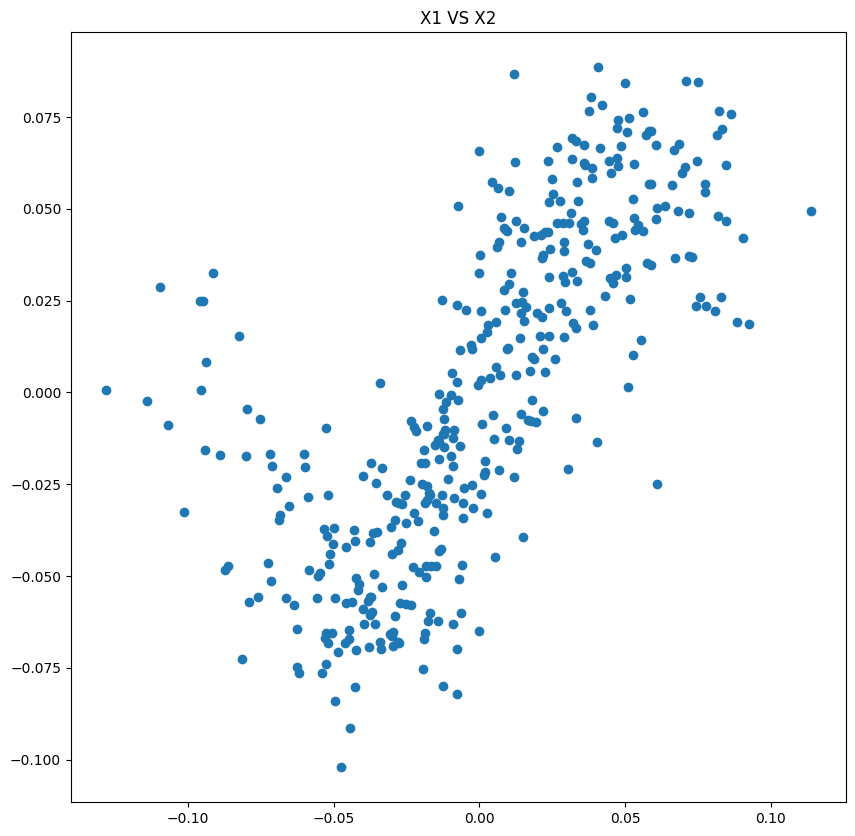

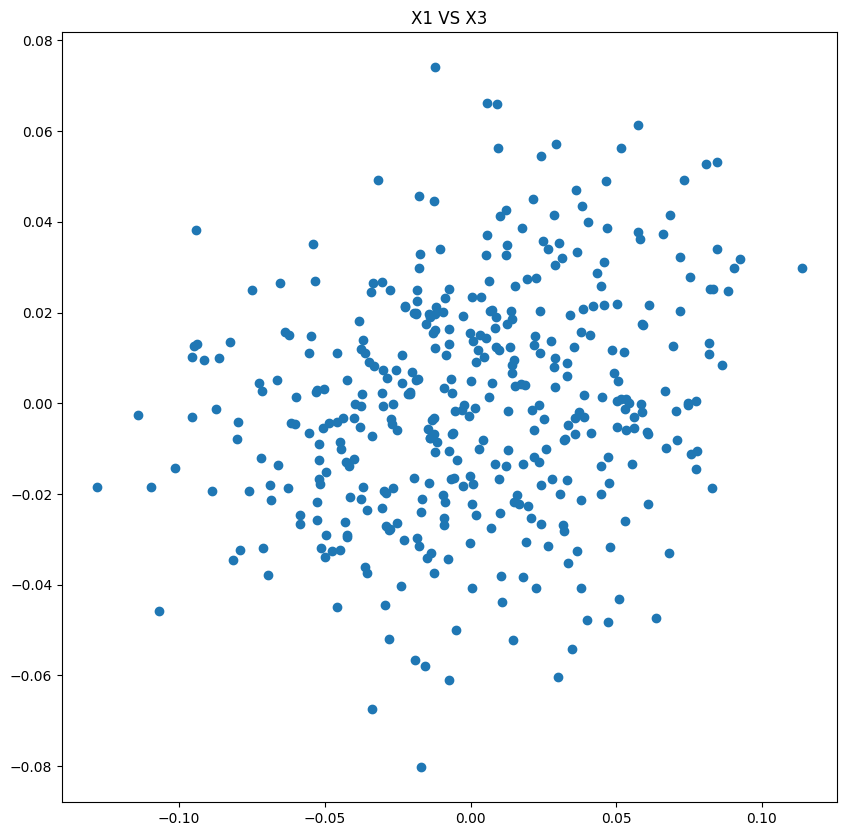

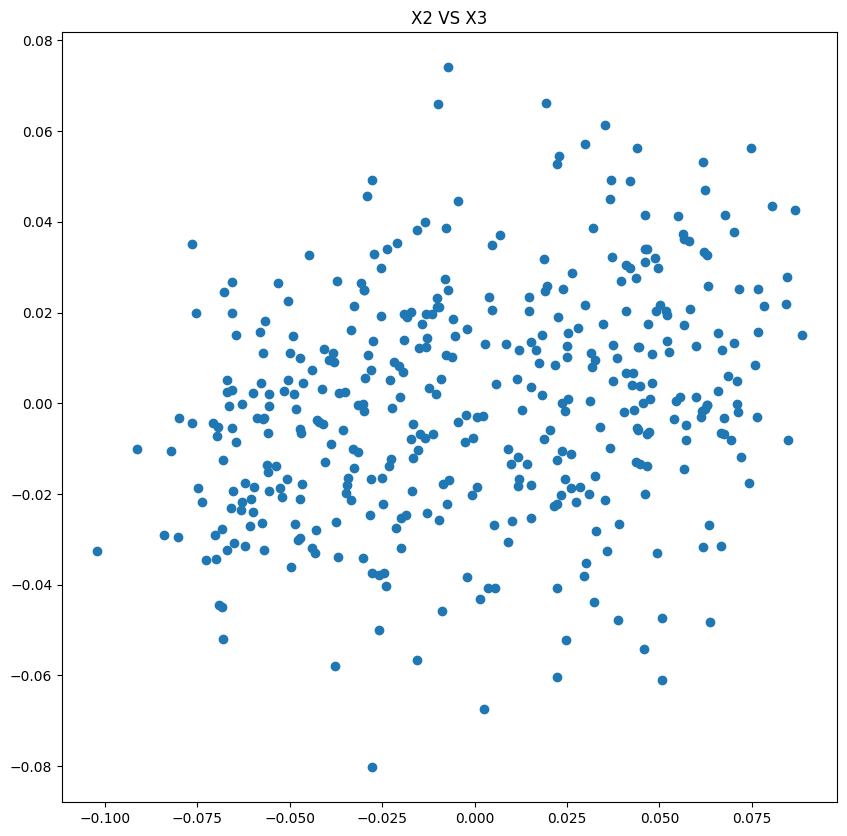

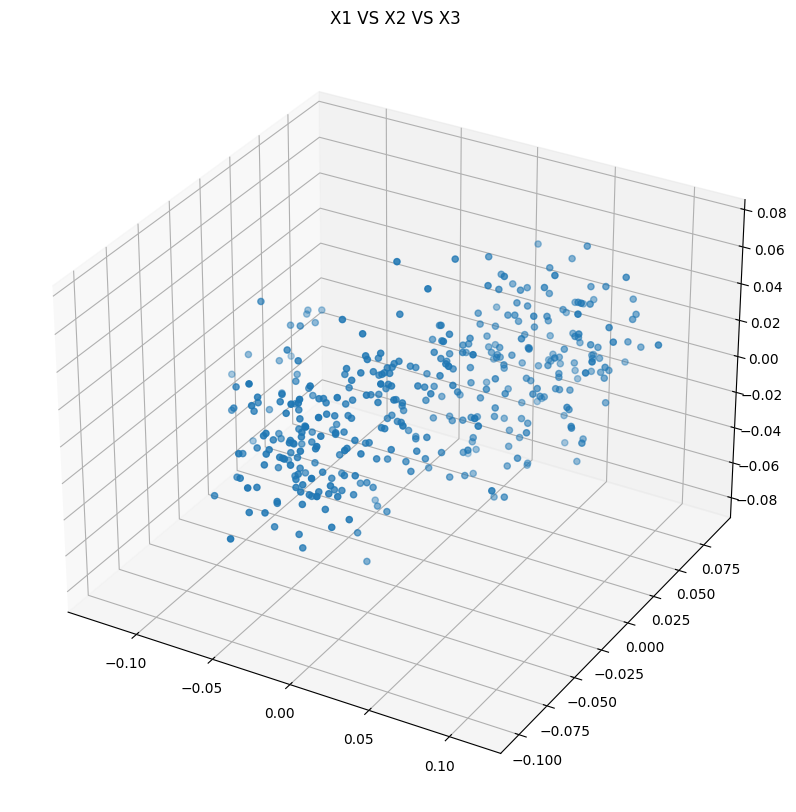

In [16]:
U, loss, outputs = solver.test(views, apply_linear_gcca)
for i in range(len(outputs)):
    outputs[i] = outputs[i]
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(10,10))
        plt.scatter(outputs[i],outputs[j])
        plt.title('X'+str(i+1)+' VS X'+str(j+1))
        plt.show()
fig = plt.figure(figsize=(10,10))
ax3d = fig.add_subplot(projection='3d')
ax3d.scatter(outputs[0],outputs[1],outputs[2]) 
plt.title('X1 VS X2 VS X3')
plt.show()


In [17]:
N = 400
views = create_synthData_new(N,mode=3,F=20)
print(f'input views shape :')
for i, view in enumerate(views):
    print(f'view_{i} :  {view.shape}')
    view = view.to(device)

U_sum = []
outputs_sum = []
test = []
for i in range(3):
    testm = torch.eye(20)
    test.append(testm)
    
import pandas as pd
print(1)
for _ in range(100):

    # size of the input for view 1 and view 2
    input_shape_list = [view.shape[-1] for view in views]

    # Building, training, and producing the new features by DCCA
    model = DeepGCCA(layer_sizes_list, input_shape_list, outdim_size,
                             use_all_singular_values, device=device).double()
    l_gcca = None
    if apply_linear_gcca:
        l_gcca = linear_gcca
    solver = Solver(model, l_gcca, outdim_size, epoch_num, batch_size,
                    learning_rate, reg_par, device=device)
    # train1, train2 = data1[0][0], data2[0][0]
    # val1, val2 = data1[1][0], data2[1][0]
    # test1, test2 = data1[2][0], data2[2][0]

    solver.fit(views, checkpoint=save_name)


    # TODO: Save l_gcca model if needed
    _ , _, outputs_def = solver.test(test, apply_linear_gcca)

    A = outputs_def[0]
    B = outputs_def[1]
    C = outputs_def[2]
    U = [A,B,C]

    A = outputs_def[0]
    B = outputs_def[1]
    C = outputs_def[2]

    os = [A,B,C]
    U_sum.append(U)
    outputs_sum.append(os)
    

#variables = pd.DataFrame(U_sum)
#results = pd.DataFrame(results_sum)

ACC = []
F1 = []
MCC = []
Label = torch.cat([torch.ones(2, dtype=torch.bool), torch.zeros(18, dtype=torch.bool)])
for i in range(500):
    acc,f1,mcc = FS_MCC(U_sum[i],Label)
    ACC.append(acc)
    F1.append(f1)
    MCC.append(mcc)

print(np.mean(ACC),np.std(ACC))
print(np.mean(F1),np.std(F1))
print(np.mean(MCC),np.std(MCC))

[ INFO : 2023-07-20 16:47:52,601 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
      )
    )
  )
)
[ INFO : 2023-07-20 16:47:52,742 ] - Adam (
Parameter Group

input views shape :
view_0 :  torch.Size([400, 20])
view_1 :  torch.Size([400, 20])
view_2 :  torch.Size([400, 20])
1


[ INFO : 2023-07-20 16:47:52,813 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8203
[ INFO : 2023-07-20 16:47:52,867 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4478
[ INFO : 2023-07-20 16:47:52,918 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7021
[ INFO : 2023-07-20 16:47:52,966 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1077
[ INFO : 2023-07-20 16:47:53,017 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.3867
[ INFO : 2023-07-20 16:47:53,076 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.6187
[ INFO : 2023-07-20 16:47:53,138 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8211
[ INFO : 2023-07-20 16:47:53,200 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9943
[ INFO : 2023-07-20 16:47:53,259 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1375
[ INFO : 2023-07-20 16:47:53,319 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2564
[ INFO : 2023-07-20 16:47:53,371 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3574
[ INFO : 2023-07-20 16:47:53,427 ] - Epoc

[ INFO : 2023-07-20 16:47:58,124 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5221
[ INFO : 2023-07-20 16:47:58,183 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5239
[ INFO : 2023-07-20 16:47:58,242 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5257
[ INFO : 2023-07-20 16:47:58,301 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5274
[ INFO : 2023-07-20 16:47:58,361 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.5291
[ INFO : 2023-07-20 16:47:58,422 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5308
[ INFO : 2023-07-20 16:47:58,463 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:47:58,677 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4181
[ INFO : 2023-07-20 16:47:58,737 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.5706
[ INFO : 2023-07-20 16:47:58,794 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.0792
[ INFO : 2023-07-20 16:47:58,850 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4476
[ INFO : 2023-07-20 16:47:58,908 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7175
[ INFO : 2023-07-20 16:47:58,958 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9359
[ INFO : 2023-07-20 16:47:59,006 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1140
[ INFO : 2023-07-20 16:47:59,056 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2598
[ INFO : 2023-07-20 16:47:59,105 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3827
[ INFO : 2023-07-20 16:47:59,162 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4890
[ INFO : 2023-07-20 16:47:59,215 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.5815
[ INFO : 2023-07-20 16:47:59,273 ] - Epo

[ INFO : 2023-07-20 16:48:03,846 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5498
[ INFO : 2023-07-20 16:48:03,899 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5514
[ INFO : 2023-07-20 16:48:03,957 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5528
[ INFO : 2023-07-20 16:48:04,005 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5543
[ INFO : 2023-07-20 16:48:04,054 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5557
[ INFO : 2023-07-20 16:48:04,103 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:48:04,287 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.7734
[ INFO : 2023-07-20 16:48:04,345 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.8579
[ INFO : 2023-07-20 16:48:04,398 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3608
[ INFO : 2023-07-20 16:48:04,470 ] - Epoch 4/100 - time: 0.06 - training_loss: -3.8044
[ INFO : 2023-07-20 16:48:04,524 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1262
[ INFO : 2023-07-20 16:48:04,584 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.3597
[ INFO : 2023-07-20 16:48:04,648 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.5311
[ INFO : 2023-07-20 16:48:04,710 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.6630
[ INFO : 2023-07-20 16:48:04,762 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7684
[ INFO : 2023-07-20 16:48:04,809 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8540
[ INFO : 2023-07-20 16:48:04,858 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9243
[ INFO : 2023-07-20 16:48:04,915 ] - Epoc

[ INFO : 2023-07-20 16:48:09,430 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6016
[ INFO : 2023-07-20 16:48:09,493 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6026
[ INFO : 2023-07-20 16:48:09,551 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6035
[ INFO : 2023-07-20 16:48:09,599 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6045
[ INFO : 2023-07-20 16:48:09,648 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6054
[ INFO : 2023-07-20 16:48:09,701 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6063
[ INFO : 2023-07-20 16:48:09,750 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:48:09,985 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.2316
[ INFO : 2023-07-20 16:48:10,034 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.1519
[ INFO : 2023-07-20 16:48:10,088 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.4237
[ INFO : 2023-07-20 16:48:10,146 ] - Epoch 5/100 - time: 0.05 - training_loss: -2.7910
[ INFO : 2023-07-20 16:48:10,206 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.0419
[ INFO : 2023-07-20 16:48:10,255 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.2150
[ INFO : 2023-07-20 16:48:10,304 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.3527
[ INFO : 2023-07-20 16:48:10,354 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.4722
[ INFO : 2023-07-20 16:48:10,413 ] - Epoch 10/100 - time: 0.05 - training_loss: -3.5788
[ INFO : 2023-07-20 16:48:10,466 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.6731
[ INFO : 2023-07-20 16:48:10,515 ] - Epoch 12/100 - time: 0.04 - training_loss: -3.7548
[ INFO : 2023-07-20 16:48:10,564 ] - Epo

[ INFO : 2023-07-20 16:48:15,031 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.2048
[ INFO : 2023-07-20 16:48:15,074 ] - Epoch 97/100 - time: 0.03 - training_loss: -5.2099
[ INFO : 2023-07-20 16:48:15,117 ] - Epoch 98/100 - time: 0.03 - training_loss: -5.2149
[ INFO : 2023-07-20 16:48:15,172 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.2197
[ INFO : 2023-07-20 16:48:15,237 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.2245
[ INFO : 2023-07-20 16:48:15,297 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:48:15,518 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9558
[ INFO : 2023-07-20 16:48:15,563 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6617
[ INFO : 2023-07-20 16:48:15,607 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7146
[ INFO : 2023-07-20 16:48:15,661 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0951
[ INFO : 2023-07-20 16:48:15,722 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.4309
[ INFO : 2023-07-20 16:48:15,785 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7045
[ INFO : 2023-07-20 16:48:15,847 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9250
[ INFO : 2023-07-20 16:48:15,906 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.1075
[ INFO : 2023-07-20 16:48:15,960 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2612
[ INFO : 2023-07-20 16:48:16,010 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3902
[ INFO : 2023-07-20 16:48:16,058 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4975
[ INFO : 2023-07-20 16:48:16,108 ] - Epoc

[ INFO : 2023-07-20 16:48:20,692 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5490
[ INFO : 2023-07-20 16:48:20,746 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5506
[ INFO : 2023-07-20 16:48:20,801 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5521
[ INFO : 2023-07-20 16:48:20,851 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5535
[ INFO : 2023-07-20 16:48:20,907 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5550
[ INFO : 2023-07-20 16:48:20,956 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5564
[ INFO : 2023-07-20 16:48:21,012 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:48:21,235 ] - Epoch 1/100 - time: 0.06 - training_loss: -3.3344
[ INFO : 2023-07-20 16:48:21,290 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.7842
[ INFO : 2023-07-20 16:48:21,339 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1435
[ INFO : 2023-07-20 16:48:21,385 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.4756
[ INFO : 2023-07-20 16:48:21,440 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.6908
[ INFO : 2023-07-20 16:48:21,505 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.8388
[ INFO : 2023-07-20 16:48:22,245 ] - Epoch 7/100 - time: 0.73 - training_loss: -4.9526
[ INFO : 2023-07-20 16:48:22,296 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.0394
[ INFO : 2023-07-20 16:48:22,345 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.1057
[ INFO : 2023-07-20 16:48:22,391 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.1590
[ INFO : 2023-07-20 16:48:23,971 ] - Epoch 11/100 - time: 1.57 - training_loss: -5.2042
[ INFO : 2023-07-20 16:48:24,019 ] - Epoc

[ INFO : 2023-07-20 16:48:29,613 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6363
[ INFO : 2023-07-20 16:48:29,661 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6369
[ INFO : 2023-07-20 16:48:29,713 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6375
[ INFO : 2023-07-20 16:48:29,762 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6381
[ INFO : 2023-07-20 16:48:29,806 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6387
[ INFO : 2023-07-20 16:48:29,853 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6392
[ INFO : 2023-07-20 16:48:29,915 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:48:30,113 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.1665
[ INFO : 2023-07-20 16:48:30,158 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5163
[ INFO : 2023-07-20 16:48:30,207 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.6850
[ INFO : 2023-07-20 16:48:30,263 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.1598
[ INFO : 2023-07-20 16:48:30,318 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5401
[ INFO : 2023-07-20 16:48:30,373 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8478
[ INFO : 2023-07-20 16:48:30,431 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0786
[ INFO : 2023-07-20 16:48:30,503 ] - Epoch 8/100 - time: 0.06 - training_loss: -4.2558
[ INFO : 2023-07-20 16:48:30,575 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.3988
[ INFO : 2023-07-20 16:48:30,638 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.5173
[ INFO : 2023-07-20 16:48:30,687 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.6169
[ INFO : 2023-07-20 16:48:30,738 ] - Epoc

[ INFO : 2023-07-20 16:48:36,104 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5650
[ INFO : 2023-07-20 16:48:36,150 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5664
[ INFO : 2023-07-20 16:48:36,200 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5677
[ INFO : 2023-07-20 16:48:36,262 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5690
[ INFO : 2023-07-20 16:48:36,313 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5703
[ INFO : 2023-07-20 16:48:36,362 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5715
[ INFO : 2023-07-20 16:48:36,407 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:48:36,642 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.5308
[ INFO : 2023-07-20 16:48:36,691 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.0163
[ INFO : 2023-07-20 16:48:36,750 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.7802
[ INFO : 2023-07-20 16:48:36,804 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3270
[ INFO : 2023-07-20 16:48:36,853 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6898
[ INFO : 2023-07-20 16:48:36,902 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9730
[ INFO : 2023-07-20 16:48:36,960 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1935
[ INFO : 2023-07-20 16:48:37,014 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.3641
[ INFO : 2023-07-20 16:48:37,063 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.4990
[ INFO : 2023-07-20 16:48:37,113 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.6083
[ INFO : 2023-07-20 16:48:37,164 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.6990
[ INFO : 2023-07-20 16:48:37,214 ] - Epoc

[ INFO : 2023-07-20 16:48:46,527 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5748
[ INFO : 2023-07-20 16:48:46,585 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5761
[ INFO : 2023-07-20 16:48:46,632 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5773
[ INFO : 2023-07-20 16:48:46,688 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5785
[ INFO : 2023-07-20 16:48:46,738 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5797
[ INFO : 2023-07-20 16:48:46,795 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5808
[ INFO : 2023-07-20 16:48:46,851 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:48:47,055 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1600
[ INFO : 2023-07-20 16:48:47,856 ] - Epoch 2/100 - time: 0.79 - training_loss: -2.8470
[ INFO : 2023-07-20 16:48:47,912 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3504
[ INFO : 2023-07-20 16:48:47,966 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7364
[ INFO : 2023-07-20 16:48:48,022 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.0492
[ INFO : 2023-07-20 16:48:48,071 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2843
[ INFO : 2023-07-20 16:48:48,115 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.4584
[ INFO : 2023-07-20 16:48:48,161 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.5930
[ INFO : 2023-07-20 16:48:48,210 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7003
[ INFO : 2023-07-20 16:48:48,271 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.7884
[ INFO : 2023-07-20 16:48:48,331 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.8627
[ INFO : 2023-07-20 16:48:48,403 ] - Epoc

[ INFO : 2023-07-20 16:48:52,911 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5937
[ INFO : 2023-07-20 16:48:52,962 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5947
[ INFO : 2023-07-20 16:48:53,015 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5958
[ INFO : 2023-07-20 16:48:53,071 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5968
[ INFO : 2023-07-20 16:48:53,124 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5978
[ INFO : 2023-07-20 16:48:53,173 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5988
[ INFO : 2023-07-20 16:48:53,213 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:48:53,425 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4774
[ INFO : 2023-07-20 16:48:53,479 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3762
[ INFO : 2023-07-20 16:48:53,543 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.7189
[ INFO : 2023-07-20 16:48:53,594 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.0457
[ INFO : 2023-07-20 16:48:53,642 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.3005
[ INFO : 2023-07-20 16:48:53,696 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.5098
[ INFO : 2023-07-20 16:48:53,756 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.6940
[ INFO : 2023-07-20 16:48:53,808 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.8585
[ INFO : 2023-07-20 16:48:53,857 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0037
[ INFO : 2023-07-20 16:48:53,906 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.1311
[ INFO : 2023-07-20 16:48:53,961 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.2434
[ INFO : 2023-07-20 16:48:54,012 ] - Epo

[ INFO : 2023-07-20 16:48:58,657 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5018
[ INFO : 2023-07-20 16:48:58,704 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5038
[ INFO : 2023-07-20 16:48:58,760 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5058
[ INFO : 2023-07-20 16:48:59,672 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5077
[ INFO : 2023-07-20 16:48:59,717 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5096
[ INFO : 2023-07-20 16:48:59,771 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:48:59,999 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1156
[ INFO : 2023-07-20 16:49:00,057 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1802
[ INFO : 2023-07-20 16:49:00,108 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.7306
[ INFO : 2023-07-20 16:49:00,162 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1317
[ INFO : 2023-07-20 16:49:00,212 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.3997
[ INFO : 2023-07-20 16:49:00,262 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.5777
[ INFO : 2023-07-20 16:49:00,317 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7132
[ INFO : 2023-07-20 16:49:00,373 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8236
[ INFO : 2023-07-20 16:49:00,431 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.9132
[ INFO : 2023-07-20 16:49:00,491 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.9859
[ INFO : 2023-07-20 16:49:00,547 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0458
[ INFO : 2023-07-20 16:49:00,598 ] - Epoc

[ INFO : 2023-07-20 16:49:05,167 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6167
[ INFO : 2023-07-20 16:49:05,217 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6176
[ INFO : 2023-07-20 16:49:05,266 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6184
[ INFO : 2023-07-20 16:49:05,318 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6191
[ INFO : 2023-07-20 16:49:05,369 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6199
[ INFO : 2023-07-20 16:49:05,425 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6207
[ INFO : 2023-07-20 16:49:05,484 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:49:05,668 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0744
[ INFO : 2023-07-20 16:49:05,726 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.6210
[ INFO : 2023-07-20 16:49:05,789 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.0620
[ INFO : 2023-07-20 16:49:05,844 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.4046
[ INFO : 2023-07-20 16:49:05,895 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.6289
[ INFO : 2023-07-20 16:49:05,947 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.7887
[ INFO : 2023-07-20 16:49:05,999 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.9045
[ INFO : 2023-07-20 16:49:06,049 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9921
[ INFO : 2023-07-20 16:49:06,101 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0617
[ INFO : 2023-07-20 16:49:06,158 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.1192
[ INFO : 2023-07-20 16:49:06,209 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.1677
[ INFO : 2023-07-20 16:49:06,259 ] - Epoc

[ INFO : 2023-07-20 16:49:10,815 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6316
[ INFO : 2023-07-20 16:49:10,874 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6323
[ INFO : 2023-07-20 16:49:10,922 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6330
[ INFO : 2023-07-20 16:49:10,971 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6336
[ INFO : 2023-07-20 16:49:11,028 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6342
[ INFO : 2023-07-20 16:49:11,091 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6348
[ INFO : 2023-07-20 16:49:11,144 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:49:11,355 ] - Epoch 2/100 - time: 0.03 - training_loss: -3.0921
[ INFO : 2023-07-20 16:49:11,404 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6138
[ INFO : 2023-07-20 16:49:11,463 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.0127
[ INFO : 2023-07-20 16:49:11,524 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.2991
[ INFO : 2023-07-20 16:49:11,586 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.5063
[ INFO : 2023-07-20 16:49:11,646 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.6592
[ INFO : 2023-07-20 16:49:11,698 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7771
[ INFO : 2023-07-20 16:49:11,748 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8708
[ INFO : 2023-07-20 16:49:11,798 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9468
[ INFO : 2023-07-20 16:49:11,846 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0097
[ INFO : 2023-07-20 16:49:11,894 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.0628
[ INFO : 2023-07-20 16:49:11,946 ] - Epo

[ INFO : 2023-07-20 16:49:16,442 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6137
[ INFO : 2023-07-20 16:49:16,490 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6145
[ INFO : 2023-07-20 16:49:16,551 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6153
[ INFO : 2023-07-20 16:49:16,614 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6161
[ INFO : 2023-07-20 16:49:16,671 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6169
[ INFO : 2023-07-20 16:49:16,714 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:49:16,908 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.7034
[ INFO : 2023-07-20 16:49:16,958 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4239
[ INFO : 2023-07-20 16:49:17,006 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.6815
[ INFO : 2023-07-20 16:49:17,064 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.1711
[ INFO : 2023-07-20 16:49:17,126 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.5337
[ INFO : 2023-07-20 16:49:17,182 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8073
[ INFO : 2023-07-20 16:49:17,233 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0213
[ INFO : 2023-07-20 16:49:17,278 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1930
[ INFO : 2023-07-20 16:49:17,329 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3348
[ INFO : 2023-07-20 16:49:17,380 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.4540
[ INFO : 2023-07-20 16:49:17,438 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.5548
[ INFO : 2023-07-20 16:49:17,500 ] - Epoc

[ INFO : 2023-07-20 16:49:22,037 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5552
[ INFO : 2023-07-20 16:49:22,102 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5566
[ INFO : 2023-07-20 16:49:22,151 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5581
[ INFO : 2023-07-20 16:49:22,196 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5595
[ INFO : 2023-07-20 16:49:22,241 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5608
[ INFO : 2023-07-20 16:49:22,298 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5622
[ INFO : 2023-07-20 16:49:22,356 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:49:22,567 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8272
[ INFO : 2023-07-20 16:49:22,616 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5531
[ INFO : 2023-07-20 16:49:22,661 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4092
[ INFO : 2023-07-20 16:49:22,711 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0152
[ INFO : 2023-07-20 16:49:22,769 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.4434
[ INFO : 2023-07-20 16:49:22,831 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7483
[ INFO : 2023-07-20 16:49:22,889 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9837
[ INFO : 2023-07-20 16:49:22,937 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1740
[ INFO : 2023-07-20 16:49:22,983 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3293
[ INFO : 2023-07-20 16:49:23,030 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.4556
[ INFO : 2023-07-20 16:49:23,086 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.5590
[ INFO : 2023-07-20 16:49:23,136 ] - Epoc

[ INFO : 2023-07-20 16:49:27,574 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5562
[ INFO : 2023-07-20 16:49:27,626 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5577
[ INFO : 2023-07-20 16:49:27,678 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5591
[ INFO : 2023-07-20 16:49:27,722 ] - Epoch 98/100 - time: 0.03 - training_loss: -5.5605
[ INFO : 2023-07-20 16:49:27,766 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5619
[ INFO : 2023-07-20 16:49:27,822 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5632
[ INFO : 2023-07-20 16:49:27,879 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:49:28,077 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0224
[ INFO : 2023-07-20 16:49:28,126 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6925
[ INFO : 2023-07-20 16:49:28,173 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3714
[ INFO : 2023-07-20 16:49:28,282 ] - Epoch 4/100 - time: 0.10 - training_loss: -3.8199
[ INFO : 2023-07-20 16:49:28,342 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.1376
[ INFO : 2023-07-20 16:49:28,399 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.3665
[ INFO : 2023-07-20 16:49:28,451 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5394
[ INFO : 2023-07-20 16:49:28,499 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6756
[ INFO : 2023-07-20 16:49:28,547 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7840
[ INFO : 2023-07-20 16:49:28,595 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8710
[ INFO : 2023-07-20 16:49:28,642 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9423
[ INFO : 2023-07-20 16:49:28,702 ] - Epoc

[ INFO : 2023-07-20 16:49:33,188 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6057
[ INFO : 2023-07-20 16:49:33,236 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6066
[ INFO : 2023-07-20 16:49:33,295 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6075
[ INFO : 2023-07-20 16:49:33,359 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6084
[ INFO : 2023-07-20 16:49:33,417 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6093
[ INFO : 2023-07-20 16:49:33,480 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6102
[ INFO : 2023-07-20 16:49:33,525 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:49:33,750 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7355
[ INFO : 2023-07-20 16:49:33,807 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.9276
[ INFO : 2023-07-20 16:49:33,868 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.3324
[ INFO : 2023-07-20 16:49:33,927 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5742
[ INFO : 2023-07-20 16:49:33,980 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7526
[ INFO : 2023-07-20 16:49:34,024 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8996
[ INFO : 2023-07-20 16:49:34,070 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0268
[ INFO : 2023-07-20 16:49:34,126 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1374
[ INFO : 2023-07-20 16:49:34,185 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.2339
[ INFO : 2023-07-20 16:49:34,244 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.3200
[ INFO : 2023-07-20 16:49:34,301 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.3993
[ INFO : 2023-07-20 16:49:34,363 ] - Epo

[ INFO : 2023-07-20 16:49:38,943 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5117
[ INFO : 2023-07-20 16:49:38,999 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5136
[ INFO : 2023-07-20 16:49:39,050 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5155
[ INFO : 2023-07-20 16:49:39,101 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5173
[ INFO : 2023-07-20 16:49:39,154 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5191
[ INFO : 2023-07-20 16:49:39,199 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:49:39,404 ] - Epoch 1/100 - time: 0.06 - training_loss: -3.0895
[ INFO : 2023-07-20 16:49:39,658 ] - Epoch 2/100 - time: 0.24 - training_loss: -3.4720
[ INFO : 2023-07-20 16:49:39,715 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.9141
[ INFO : 2023-07-20 16:49:39,772 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.2591
[ INFO : 2023-07-20 16:49:39,831 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5007
[ INFO : 2023-07-20 16:49:39,891 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.6688
[ INFO : 2023-07-20 16:49:39,945 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7977
[ INFO : 2023-07-20 16:49:39,994 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.8991
[ INFO : 2023-07-20 16:49:40,042 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9802
[ INFO : 2023-07-20 16:49:40,093 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0466
[ INFO : 2023-07-20 16:49:40,156 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.1020
[ INFO : 2023-07-20 16:49:40,215 ] - Epoc

[ INFO : 2023-07-20 16:49:44,747 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6241
[ INFO : 2023-07-20 16:49:44,794 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6248
[ INFO : 2023-07-20 16:49:44,846 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6255
[ INFO : 2023-07-20 16:49:44,906 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6262
[ INFO : 2023-07-20 16:49:44,964 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6270
[ INFO : 2023-07-20 16:49:45,019 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6276
[ INFO : 2023-07-20 16:49:45,062 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:49:45,256 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0186
[ INFO : 2023-07-20 16:49:45,307 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9768
[ INFO : 2023-07-20 16:49:45,359 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0575
[ INFO : 2023-07-20 16:49:45,418 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5587
[ INFO : 2023-07-20 16:49:45,477 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.9094
[ INFO : 2023-07-20 16:49:45,534 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.1599
[ INFO : 2023-07-20 16:49:45,585 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.3488
[ INFO : 2023-07-20 16:49:45,635 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.4982
[ INFO : 2023-07-20 16:49:45,682 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.6186
[ INFO : 2023-07-20 16:49:45,732 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.7164
[ INFO : 2023-07-20 16:49:45,798 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.7970
[ INFO : 2023-07-20 16:49:45,863 ] - Epoc

[ INFO : 2023-07-20 16:49:50,522 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5851
[ INFO : 2023-07-20 16:49:50,580 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5863
[ INFO : 2023-07-20 16:49:50,639 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5874
[ INFO : 2023-07-20 16:49:50,700 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5885
[ INFO : 2023-07-20 16:49:50,755 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5896
[ INFO : 2023-07-20 16:49:50,809 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5906
[ INFO : 2023-07-20 16:49:50,854 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:49:51,047 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0257
[ INFO : 2023-07-20 16:49:51,103 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7830
[ INFO : 2023-07-20 16:49:51,158 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.5121
[ INFO : 2023-07-20 16:49:51,208 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9207
[ INFO : 2023-07-20 16:49:51,266 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2104
[ INFO : 2023-07-20 16:49:51,322 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4260
[ INFO : 2023-07-20 16:49:51,384 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.5898
[ INFO : 2023-07-20 16:49:51,436 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7161
[ INFO : 2023-07-20 16:49:51,485 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8157
[ INFO : 2023-07-20 16:49:51,537 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8969
[ INFO : 2023-07-20 16:49:51,597 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.9647
[ INFO : 2023-07-20 16:49:51,653 ] - Epoc

[ INFO : 2023-07-20 16:49:56,220 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6074
[ INFO : 2023-07-20 16:49:56,276 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6084
[ INFO : 2023-07-20 16:49:56,334 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6093
[ INFO : 2023-07-20 16:49:56,398 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6102
[ INFO : 2023-07-20 16:49:56,455 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6110
[ INFO : 2023-07-20 16:49:56,503 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6119
[ INFO : 2023-07-20 16:49:56,542 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:49:56,738 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9380
[ INFO : 2023-07-20 16:49:56,795 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1160
[ INFO : 2023-07-20 16:49:56,846 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.5077
[ INFO : 2023-07-20 16:49:56,899 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9212
[ INFO : 2023-07-20 16:49:56,954 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2159
[ INFO : 2023-07-20 16:49:57,009 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4238
[ INFO : 2023-07-20 16:49:57,059 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5777
[ INFO : 2023-07-20 16:49:57,109 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6998
[ INFO : 2023-07-20 16:49:57,167 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.7997
[ INFO : 2023-07-20 16:49:57,227 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.8817
[ INFO : 2023-07-20 16:49:57,285 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.9496
[ INFO : 2023-07-20 16:49:57,335 ] - Epoc

[ INFO : 2023-07-20 16:50:01,848 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6052
[ INFO : 2023-07-20 16:50:01,902 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6061
[ INFO : 2023-07-20 16:50:01,962 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6070
[ INFO : 2023-07-20 16:50:02,022 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6079
[ INFO : 2023-07-20 16:50:02,079 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6088
[ INFO : 2023-07-20 16:50:02,130 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6097
[ INFO : 2023-07-20 16:50:02,176 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:50:02,412 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9793
[ INFO : 2023-07-20 16:50:02,473 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.5597
[ INFO : 2023-07-20 16:50:02,526 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9429
[ INFO : 2023-07-20 16:50:02,575 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2121
[ INFO : 2023-07-20 16:50:02,620 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4166
[ INFO : 2023-07-20 16:50:02,671 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5744
[ INFO : 2023-07-20 16:50:02,727 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6985
[ INFO : 2023-07-20 16:50:02,789 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.7990
[ INFO : 2023-07-20 16:50:02,845 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8820
[ INFO : 2023-07-20 16:50:02,907 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.9519
[ INFO : 2023-07-20 16:50:02,967 ] - Epoch 12/100 - time: 0.05 - training_loss: -5.0113
[ INFO : 2023-07-20 16:50:03,027 ] - Epo

[ INFO : 2023-07-20 16:50:07,598 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6072
[ INFO : 2023-07-20 16:50:07,650 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6081
[ INFO : 2023-07-20 16:50:07,713 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6090
[ INFO : 2023-07-20 16:50:07,774 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6098
[ INFO : 2023-07-20 16:50:07,835 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6107
[ INFO : 2023-07-20 16:50:07,889 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:50:08,081 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0087
[ INFO : 2023-07-20 16:50:08,134 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.3193
[ INFO : 2023-07-20 16:50:08,185 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8684
[ INFO : 2023-07-20 16:50:08,239 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.2291
[ INFO : 2023-07-20 16:50:08,301 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.4772
[ INFO : 2023-07-20 16:50:08,357 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6589
[ INFO : 2023-07-20 16:50:08,408 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7925
[ INFO : 2023-07-20 16:50:08,461 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.8920
[ INFO : 2023-07-20 16:50:08,516 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9704
[ INFO : 2023-07-20 16:50:08,576 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.0352
[ INFO : 2023-07-20 16:50:08,635 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.0900
[ INFO : 2023-07-20 16:50:08,687 ] - Epoc

[ INFO : 2023-07-20 16:50:13,357 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6221
[ INFO : 2023-07-20 16:50:13,414 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6229
[ INFO : 2023-07-20 16:50:13,478 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6236
[ INFO : 2023-07-20 16:50:13,537 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6244
[ INFO : 2023-07-20 16:50:13,593 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6251
[ INFO : 2023-07-20 16:50:13,640 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6258
[ INFO : 2023-07-20 16:50:13,680 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:50:13,909 ] - Epoch 1/100 - time: 0.07 - training_loss: -3.1817
[ INFO : 2023-07-20 16:50:13,972 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.0285
[ INFO : 2023-07-20 16:50:14,031 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.4204
[ INFO : 2023-07-20 16:50:14,089 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.8277
[ INFO : 2023-07-20 16:50:14,141 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1111
[ INFO : 2023-07-20 16:50:14,188 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.3343
[ INFO : 2023-07-20 16:50:14,235 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5042
[ INFO : 2023-07-20 16:50:14,295 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.6353
[ INFO : 2023-07-20 16:50:14,353 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7404
[ INFO : 2023-07-20 16:50:14,423 ] - Epoch 10/100 - time: 0.06 - training_loss: -4.8264
[ INFO : 2023-07-20 16:50:14,484 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.8976
[ INFO : 2023-07-20 16:50:14,534 ] - Epoc

[ INFO : 2023-07-20 16:50:19,075 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5982
[ INFO : 2023-07-20 16:50:19,132 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5992
[ INFO : 2023-07-20 16:50:19,191 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6002
[ INFO : 2023-07-20 16:50:19,243 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6012
[ INFO : 2023-07-20 16:50:19,291 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6021
[ INFO : 2023-07-20 16:50:19,343 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6031
[ INFO : 2023-07-20 16:50:19,386 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:50:19,596 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0785
[ INFO : 2023-07-20 16:50:19,648 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8474
[ INFO : 2023-07-20 16:50:19,698 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4344
[ INFO : 2023-07-20 16:50:19,756 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.8679
[ INFO : 2023-07-20 16:50:19,813 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1741
[ INFO : 2023-07-20 16:50:19,877 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.3983
[ INFO : 2023-07-20 16:50:19,926 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5632
[ INFO : 2023-07-20 16:50:19,978 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6897
[ INFO : 2023-07-20 16:50:20,032 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7910
[ INFO : 2023-07-20 16:50:20,083 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8740
[ INFO : 2023-07-20 16:50:20,132 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9429
[ INFO : 2023-07-20 16:50:20,188 ] - Epoc

[ INFO : 2023-07-20 16:50:24,818 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6042
[ INFO : 2023-07-20 16:50:24,869 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6052
[ INFO : 2023-07-20 16:50:24,929 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6061
[ INFO : 2023-07-20 16:50:24,990 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6070
[ INFO : 2023-07-20 16:50:25,050 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6079
[ INFO : 2023-07-20 16:50:25,109 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6088
[ INFO : 2023-07-20 16:50:25,156 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:50:25,345 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7376
[ INFO : 2023-07-20 16:50:25,399 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.1965
[ INFO : 2023-07-20 16:50:25,456 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.7794
[ INFO : 2023-07-20 16:50:25,516 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.1789
[ INFO : 2023-07-20 16:50:25,573 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.4691
[ INFO : 2023-07-20 16:50:25,629 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7137
[ INFO : 2023-07-20 16:50:25,685 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9179
[ INFO : 2023-07-20 16:50:25,739 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0848
[ INFO : 2023-07-20 16:50:25,804 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2307
[ INFO : 2023-07-20 16:50:25,861 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3609
[ INFO : 2023-07-20 16:50:25,916 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4728
[ INFO : 2023-07-20 16:50:25,973 ] - Epoc

[ INFO : 2023-07-20 16:50:30,762 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5475
[ INFO : 2023-07-20 16:50:30,826 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5490
[ INFO : 2023-07-20 16:50:30,890 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5505
[ INFO : 2023-07-20 16:50:30,946 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5520
[ INFO : 2023-07-20 16:50:30,993 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5534
[ INFO : 2023-07-20 16:50:31,039 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5549
[ INFO : 2023-07-20 16:50:31,081 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:50:31,270 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7774
[ INFO : 2023-07-20 16:50:31,324 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.1648
[ INFO : 2023-07-20 16:50:31,374 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4552
[ INFO : 2023-07-20 16:50:31,425 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.8260
[ INFO : 2023-07-20 16:50:31,482 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.1342
[ INFO : 2023-07-20 16:50:31,532 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.3661
[ INFO : 2023-07-20 16:50:31,581 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.5416
[ INFO : 2023-07-20 16:50:31,627 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.6855
[ INFO : 2023-07-20 16:50:31,682 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.8093
[ INFO : 2023-07-20 16:50:31,735 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.9182
[ INFO : 2023-07-20 16:50:31,785 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0158
[ INFO : 2023-07-20 16:50:31,836 ] - Epoc

[ INFO : 2023-07-20 16:50:36,285 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.4657
[ INFO : 2023-07-20 16:50:36,336 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.4681
[ INFO : 2023-07-20 16:50:36,382 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.4705
[ INFO : 2023-07-20 16:50:36,427 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.4728
[ INFO : 2023-07-20 16:50:36,486 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.4750
[ INFO : 2023-07-20 16:50:36,537 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.4772
[ INFO : 2023-07-20 16:50:36,580 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:50:36,777 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8733
[ INFO : 2023-07-20 16:50:36,831 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8574
[ INFO : 2023-07-20 16:50:36,881 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.2192
[ INFO : 2023-07-20 16:50:36,931 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.6351
[ INFO : 2023-07-20 16:50:36,994 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.9682
[ INFO : 2023-07-20 16:50:37,053 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.2090
[ INFO : 2023-07-20 16:50:37,112 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.3877
[ INFO : 2023-07-20 16:50:37,172 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.5292
[ INFO : 2023-07-20 16:50:37,225 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.6454
[ INFO : 2023-07-20 16:50:37,278 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.7422
[ INFO : 2023-07-20 16:50:37,329 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.8234
[ INFO : 2023-07-20 16:50:37,379 ] - Epoc

[ INFO : 2023-07-20 16:50:41,994 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5900
[ INFO : 2023-07-20 16:50:42,046 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5911
[ INFO : 2023-07-20 16:50:42,096 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5922
[ INFO : 2023-07-20 16:50:42,143 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5932
[ INFO : 2023-07-20 16:50:42,192 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5943
[ INFO : 2023-07-20 16:50:42,244 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5953
[ INFO : 2023-07-20 16:50:42,301 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:50:42,544 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5919
[ INFO : 2023-07-20 16:50:42,600 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0960
[ INFO : 2023-07-20 16:50:42,649 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5344
[ INFO : 2023-07-20 16:50:42,699 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8620
[ INFO : 2023-07-20 16:50:42,752 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1214
[ INFO : 2023-07-20 16:50:42,816 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.3144
[ INFO : 2023-07-20 16:50:42,874 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.4669
[ INFO : 2023-07-20 16:50:42,927 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.5904
[ INFO : 2023-07-20 16:50:42,979 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.6920
[ INFO : 2023-07-20 16:50:43,030 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.7766
[ INFO : 2023-07-20 16:50:43,086 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.8481
[ INFO : 2023-07-20 16:50:43,141 ] - Epo

[ INFO : 2023-07-20 16:50:47,828 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5858
[ INFO : 2023-07-20 16:50:47,886 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5869
[ INFO : 2023-07-20 16:50:47,951 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5880
[ INFO : 2023-07-20 16:50:48,005 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5891
[ INFO : 2023-07-20 16:50:48,056 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5902
[ INFO : 2023-07-20 16:50:48,108 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:50:48,307 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8565
[ INFO : 2023-07-20 16:50:48,357 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6360
[ INFO : 2023-07-20 16:50:48,404 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.6223
[ INFO : 2023-07-20 16:50:48,458 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.9643
[ INFO : 2023-07-20 16:50:48,521 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.3290
[ INFO : 2023-07-20 16:50:48,572 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6269
[ INFO : 2023-07-20 16:50:48,621 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8684
[ INFO : 2023-07-20 16:50:48,670 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0642
[ INFO : 2023-07-20 16:50:48,730 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2225
[ INFO : 2023-07-20 16:50:48,788 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3516
[ INFO : 2023-07-20 16:50:48,841 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4590
[ INFO : 2023-07-20 16:50:48,891 ] - Epoc

[ INFO : 2023-07-20 16:50:53,567 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5418
[ INFO : 2023-07-20 16:50:53,613 ] - Epoch 96/100 - time: 0.03 - training_loss: -5.5434
[ INFO : 2023-07-20 16:50:53,660 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5450
[ INFO : 2023-07-20 16:50:53,710 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5465
[ INFO : 2023-07-20 16:50:53,763 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5480
[ INFO : 2023-07-20 16:50:53,817 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5495
[ INFO : 2023-07-20 16:50:53,860 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:50:54,093 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.2597
[ INFO : 2023-07-20 16:50:54,152 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.9937
[ INFO : 2023-07-20 16:50:54,212 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.4849
[ INFO : 2023-07-20 16:50:54,273 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.8190
[ INFO : 2023-07-20 16:50:54,333 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0759
[ INFO : 2023-07-20 16:50:54,382 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2797
[ INFO : 2023-07-20 16:50:54,429 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.4410
[ INFO : 2023-07-20 16:50:54,476 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.5690
[ INFO : 2023-07-20 16:50:54,535 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.6726
[ INFO : 2023-07-20 16:50:54,586 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.7586
[ INFO : 2023-07-20 16:50:54,636 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.8314
[ INFO : 2023-07-20 16:50:54,691 ] - Epo

[ INFO : 2023-07-20 16:50:59,182 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5832
[ INFO : 2023-07-20 16:50:59,227 ] - Epoch 97/100 - time: 0.03 - training_loss: -5.5843
[ INFO : 2023-07-20 16:50:59,287 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5855
[ INFO : 2023-07-20 16:50:59,336 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5866
[ INFO : 2023-07-20 16:50:59,387 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5877
[ INFO : 2023-07-20 16:50:59,430 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:50:59,607 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.8828
[ INFO : 2023-07-20 16:50:59,660 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.2898
[ INFO : 2023-07-20 16:50:59,716 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5610
[ INFO : 2023-07-20 16:50:59,769 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0036
[ INFO : 2023-07-20 16:50:59,819 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.3011
[ INFO : 2023-07-20 16:50:59,869 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.5418
[ INFO : 2023-07-20 16:50:59,926 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7454
[ INFO : 2023-07-20 16:50:59,979 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9162
[ INFO : 2023-07-20 16:51:00,034 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.0581
[ INFO : 2023-07-20 16:51:00,083 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1776
[ INFO : 2023-07-20 16:51:00,132 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.2816
[ INFO : 2023-07-20 16:51:00,181 ] - Epoc

[ INFO : 2023-07-20 16:51:04,802 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5121
[ INFO : 2023-07-20 16:51:04,856 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5140
[ INFO : 2023-07-20 16:51:04,929 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5158
[ INFO : 2023-07-20 16:51:05,000 ] - Epoch 98/100 - time: 0.06 - training_loss: -5.5177
[ INFO : 2023-07-20 16:51:05,072 ] - Epoch 99/100 - time: 0.06 - training_loss: -5.5195
[ INFO : 2023-07-20 16:51:05,137 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5212
[ INFO : 2023-07-20 16:51:05,187 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:51:05,427 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.5587
[ INFO : 2023-07-20 16:51:05,497 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7562
[ INFO : 2023-07-20 16:51:05,572 ] - Epoch 3/100 - time: 0.06 - training_loss: -3.1008
[ INFO : 2023-07-20 16:51:05,633 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.5189
[ INFO : 2023-07-20 16:51:05,695 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.7984
[ INFO : 2023-07-20 16:51:05,754 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0264
[ INFO : 2023-07-20 16:51:05,811 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2188
[ INFO : 2023-07-20 16:51:05,863 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.3786
[ INFO : 2023-07-20 16:51:05,923 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.5093
[ INFO : 2023-07-20 16:51:05,992 ] - Epoch 10/100 - time: 0.06 - training_loss: -4.6153
[ INFO : 2023-07-20 16:51:06,083 ] - Epoch 11/100 - time: 0.06 - training_loss: -4.7019
[ INFO : 2023-07-20 16:51:06,145 ] - Epoc

[ INFO : 2023-07-20 16:51:10,937 ] - Epoch 95/100 - time: 0.03 - training_loss: -5.5721
[ INFO : 2023-07-20 16:51:10,982 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5733
[ INFO : 2023-07-20 16:51:11,031 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5746
[ INFO : 2023-07-20 16:51:11,090 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5758
[ INFO : 2023-07-20 16:51:11,146 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5771
[ INFO : 2023-07-20 16:51:11,203 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5782
[ INFO : 2023-07-20 16:51:11,252 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:51:11,471 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.3892
[ INFO : 2023-07-20 16:51:11,529 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.5464
[ INFO : 2023-07-20 16:51:11,588 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.0588
[ INFO : 2023-07-20 16:51:11,646 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.4006
[ INFO : 2023-07-20 16:51:11,702 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.6745
[ INFO : 2023-07-20 16:51:11,757 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9038
[ INFO : 2023-07-20 16:51:11,807 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0936
[ INFO : 2023-07-20 16:51:11,853 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2484
[ INFO : 2023-07-20 16:51:11,903 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3749
[ INFO : 2023-07-20 16:51:11,964 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4802
[ INFO : 2023-07-20 16:51:12,030 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.5697
[ INFO : 2023-07-20 16:51:12,088 ] - Epo

[ INFO : 2023-07-20 16:51:17,041 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5472
[ INFO : 2023-07-20 16:51:17,096 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5487
[ INFO : 2023-07-20 16:51:17,145 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5502
[ INFO : 2023-07-20 16:51:17,195 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5517
[ INFO : 2023-07-20 16:51:17,248 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5531
[ INFO : 2023-07-20 16:51:17,305 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:51:17,547 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.5909
[ INFO : 2023-07-20 16:51:17,597 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.8138
[ INFO : 2023-07-20 16:51:17,650 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1949
[ INFO : 2023-07-20 16:51:17,705 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4981
[ INFO : 2023-07-20 16:51:17,762 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7438
[ INFO : 2023-07-20 16:51:17,823 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.9518
[ INFO : 2023-07-20 16:51:17,881 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1306
[ INFO : 2023-07-20 16:51:17,933 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2796
[ INFO : 2023-07-20 16:51:18,044 ] - Epoch 10/100 - time: 0.10 - training_loss: -4.4020
[ INFO : 2023-07-20 16:51:18,092 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.5049
[ INFO : 2023-07-20 16:51:18,143 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.5943
[ INFO : 2023-07-20 16:51:18,201 ] - Epo

[ INFO : 2023-07-20 16:51:23,527 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5517
[ INFO : 2023-07-20 16:51:23,581 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5532
[ INFO : 2023-07-20 16:51:23,644 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5547
[ INFO : 2023-07-20 16:51:23,700 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5561
[ INFO : 2023-07-20 16:51:23,750 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5575
[ INFO : 2023-07-20 16:51:23,794 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:51:23,997 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8343
[ INFO : 2023-07-20 16:51:24,061 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.3143
[ INFO : 2023-07-20 16:51:24,124 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.6064
[ INFO : 2023-07-20 16:51:24,192 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.0716
[ INFO : 2023-07-20 16:51:24,250 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.4612
[ INFO : 2023-07-20 16:51:24,306 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7291
[ INFO : 2023-07-20 16:51:24,359 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9398
[ INFO : 2023-07-20 16:51:24,413 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1184
[ INFO : 2023-07-20 16:51:24,473 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.2719
[ INFO : 2023-07-20 16:51:24,532 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.4015
[ INFO : 2023-07-20 16:51:24,586 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.5094
[ INFO : 2023-07-20 16:51:24,638 ] - Epoc

[ INFO : 2023-07-20 16:51:31,270 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5496
[ INFO : 2023-07-20 16:51:31,327 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5512
[ INFO : 2023-07-20 16:51:31,392 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5527
[ INFO : 2023-07-20 16:51:31,457 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5541
[ INFO : 2023-07-20 16:51:31,519 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.5555
[ INFO : 2023-07-20 16:51:31,572 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5569
[ INFO : 2023-07-20 16:51:31,622 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:51:31,817 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7489
[ INFO : 2023-07-20 16:51:31,877 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.1841
[ INFO : 2023-07-20 16:51:31,931 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.8394
[ INFO : 2023-07-20 16:51:31,983 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.3499
[ INFO : 2023-07-20 16:51:32,036 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6972
[ INFO : 2023-07-20 16:51:32,099 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.9576
[ INFO : 2023-07-20 16:51:32,157 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1617
[ INFO : 2023-07-20 16:51:32,214 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.3235
[ INFO : 2023-07-20 16:51:32,268 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.4513
[ INFO : 2023-07-20 16:51:32,320 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.5578
[ INFO : 2023-07-20 16:51:32,370 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.6502
[ INFO : 2023-07-20 16:51:32,423 ] - Epoc

[ INFO : 2023-07-20 16:51:41,002 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5692
[ INFO : 2023-07-20 16:51:41,062 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5705
[ INFO : 2023-07-20 16:51:41,121 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5718
[ INFO : 2023-07-20 16:51:41,168 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5731
[ INFO : 2023-07-20 16:51:41,212 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5743
[ INFO : 2023-07-20 16:51:41,263 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5755
[ INFO : 2023-07-20 16:51:41,312 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:51:41,527 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.3006
[ INFO : 2023-07-20 16:51:41,578 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.3497
[ INFO : 2023-07-20 16:51:41,626 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8045
[ INFO : 2023-07-20 16:51:41,674 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1708
[ INFO : 2023-07-20 16:51:41,721 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4263
[ INFO : 2023-07-20 16:51:41,775 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6099
[ INFO : 2023-07-20 16:51:41,834 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7432
[ INFO : 2023-07-20 16:51:41,895 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8477
[ INFO : 2023-07-20 16:51:41,953 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.9331
[ INFO : 2023-07-20 16:51:42,009 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0030
[ INFO : 2023-07-20 16:51:42,058 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0607
[ INFO : 2023-07-20 16:51:42,109 ] - Epoc

[ INFO : 2023-07-20 16:51:47,146 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6178
[ INFO : 2023-07-20 16:51:47,202 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6186
[ INFO : 2023-07-20 16:51:47,257 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6194
[ INFO : 2023-07-20 16:51:48,998 ] - Epoch 98/100 - time: 1.73 - training_loss: -5.6202
[ INFO : 2023-07-20 16:51:49,041 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6210
[ INFO : 2023-07-20 16:51:49,085 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6217
[ INFO : 2023-07-20 16:51:49,140 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:51:49,374 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8335
[ INFO : 2023-07-20 16:51:49,430 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0841
[ INFO : 2023-07-20 16:51:49,476 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4253
[ INFO : 2023-07-20 16:51:49,521 ] - Epoch 5/100 - time: 0.03 - training_loss: -3.6788
[ INFO : 2023-07-20 16:51:49,571 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.8917
[ INFO : 2023-07-20 16:51:49,632 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.0795
[ INFO : 2023-07-20 16:51:49,687 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2370
[ INFO : 2023-07-20 16:51:49,741 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3680
[ INFO : 2023-07-20 16:51:49,795 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.4790
[ INFO : 2023-07-20 16:51:49,846 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.5747
[ INFO : 2023-07-20 16:51:49,898 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.6582
[ INFO : 2023-07-20 16:51:49,959 ] - Epo

[ INFO : 2023-07-20 16:51:57,153 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5595
[ INFO : 2023-07-20 16:51:57,217 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5610
[ INFO : 2023-07-20 16:51:57,279 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5623
[ INFO : 2023-07-20 16:51:57,340 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.5637
[ INFO : 2023-07-20 16:51:57,403 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5650
[ INFO : 2023-07-20 16:51:57,468 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:51:57,712 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.8326
[ INFO : 2023-07-20 16:51:57,769 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3365
[ INFO : 2023-07-20 16:51:57,828 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.7148
[ INFO : 2023-07-20 16:51:57,889 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.0067
[ INFO : 2023-07-20 16:51:57,953 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.2415
[ INFO : 2023-07-20 16:51:58,007 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.4286
[ INFO : 2023-07-20 16:51:58,054 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.5712
[ INFO : 2023-07-20 16:51:58,101 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.6801
[ INFO : 2023-07-20 16:51:58,163 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.7675
[ INFO : 2023-07-20 16:51:58,221 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.8412
[ INFO : 2023-07-20 16:51:58,278 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.9052
[ INFO : 2023-07-20 16:51:58,336 ] - Epo

[ INFO : 2023-07-20 16:52:03,336 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5927
[ INFO : 2023-07-20 16:52:03,400 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5937
[ INFO : 2023-07-20 16:52:03,474 ] - Epoch 98/100 - time: 0.06 - training_loss: -5.5948
[ INFO : 2023-07-20 16:52:03,528 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5958
[ INFO : 2023-07-20 16:52:03,579 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5968
[ INFO : 2023-07-20 16:52:03,618 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:52:03,848 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.9722
[ INFO : 2023-07-20 16:52:03,907 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.5475
[ INFO : 2023-07-20 16:52:03,963 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2647
[ INFO : 2023-07-20 16:52:04,015 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7397
[ INFO : 2023-07-20 16:52:04,069 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.0618
[ INFO : 2023-07-20 16:52:04,120 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2927
[ INFO : 2023-07-20 16:52:04,173 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.4705
[ INFO : 2023-07-20 16:52:04,231 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.6116
[ INFO : 2023-07-20 16:52:04,290 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.7245
[ INFO : 2023-07-20 16:52:04,349 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.8166
[ INFO : 2023-07-20 16:52:04,412 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.8930
[ INFO : 2023-07-20 16:52:04,477 ] - Epoc

[ INFO : 2023-07-20 16:52:09,214 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5996
[ INFO : 2023-07-20 16:52:09,276 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6006
[ INFO : 2023-07-20 16:52:09,337 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6016
[ INFO : 2023-07-20 16:52:09,407 ] - Epoch 98/100 - time: 0.06 - training_loss: -5.6026
[ INFO : 2023-07-20 16:52:09,470 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6035
[ INFO : 2023-07-20 16:52:09,522 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6044
[ INFO : 2023-07-20 16:52:09,565 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:52:09,787 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.4311
[ INFO : 2023-07-20 16:52:09,838 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7695
[ INFO : 2023-07-20 16:52:09,889 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1880
[ INFO : 2023-07-20 16:52:09,940 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.5360
[ INFO : 2023-07-20 16:52:09,990 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7912
[ INFO : 2023-07-20 16:52:10,041 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0089
[ INFO : 2023-07-20 16:52:10,101 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.2036
[ INFO : 2023-07-20 16:52:10,164 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.3588
[ INFO : 2023-07-20 16:52:10,228 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.4806
[ INFO : 2023-07-20 16:52:10,290 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.5838
[ INFO : 2023-07-20 16:52:10,341 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.6743
[ INFO : 2023-07-20 16:52:10,392 ] - Epoc

[ INFO : 2023-07-20 16:52:15,097 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5698
[ INFO : 2023-07-20 16:52:15,148 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5711
[ INFO : 2023-07-20 16:52:15,202 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5724
[ INFO : 2023-07-20 16:52:15,258 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5736
[ INFO : 2023-07-20 16:52:15,316 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.5749
[ INFO : 2023-07-20 16:52:15,376 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5761
[ INFO : 2023-07-20 16:52:15,423 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:52:15,664 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4238
[ INFO : 2023-07-20 16:52:15,729 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.7829
[ INFO : 2023-07-20 16:52:15,791 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.1153
[ INFO : 2023-07-20 16:52:15,845 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.3514
[ INFO : 2023-07-20 16:52:15,898 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.5326
[ INFO : 2023-07-20 16:52:15,956 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.6751
[ INFO : 2023-07-20 16:52:16,007 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7880
[ INFO : 2023-07-20 16:52:16,060 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8779
[ INFO : 2023-07-20 16:52:16,109 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9507
[ INFO : 2023-07-20 16:52:16,162 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0110
[ INFO : 2023-07-20 16:52:16,221 ] - Epoch 12/100 - time: 0.05 - training_loss: -5.0627
[ INFO : 2023-07-20 16:52:16,279 ] - Epo

[ INFO : 2023-07-20 16:52:21,054 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6127
[ INFO : 2023-07-20 16:52:21,115 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6135
[ INFO : 2023-07-20 16:52:21,175 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6144
[ INFO : 2023-07-20 16:52:21,230 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6152
[ INFO : 2023-07-20 16:52:21,293 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6160
[ INFO : 2023-07-20 16:52:21,349 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:52:21,580 ] - Epoch 1/100 - time: 0.06 - training_loss: -3.1623
[ INFO : 2023-07-20 16:52:21,650 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.0767
[ INFO : 2023-07-20 16:52:21,706 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6134
[ INFO : 2023-07-20 16:52:21,756 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.0252
[ INFO : 2023-07-20 16:52:21,812 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.3153
[ INFO : 2023-07-20 16:52:21,871 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.5165
[ INFO : 2023-07-20 16:52:21,924 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6663
[ INFO : 2023-07-20 16:52:21,980 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7836
[ INFO : 2023-07-20 16:52:22,034 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8773
[ INFO : 2023-07-20 16:52:22,098 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.9540
[ INFO : 2023-07-20 16:52:22,161 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.0178
[ INFO : 2023-07-20 16:52:22,219 ] - Epoc

[ INFO : 2023-07-20 16:52:27,035 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6139
[ INFO : 2023-07-20 16:52:27,082 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6148
[ INFO : 2023-07-20 16:52:27,130 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6156
[ INFO : 2023-07-20 16:52:27,195 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6164
[ INFO : 2023-07-20 16:52:27,258 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6172
[ INFO : 2023-07-20 16:52:27,317 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6180
[ INFO : 2023-07-20 16:52:27,370 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:52:27,585 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.2158
[ INFO : 2023-07-20 16:52:27,633 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.3892
[ INFO : 2023-07-20 16:52:27,684 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4708
[ INFO : 2023-07-20 16:52:27,749 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.8689
[ INFO : 2023-07-20 16:52:27,810 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.1686
[ INFO : 2023-07-20 16:52:27,870 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.3828
[ INFO : 2023-07-20 16:52:27,935 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.5410
[ INFO : 2023-07-20 16:52:28,003 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.6638
[ INFO : 2023-07-20 16:52:28,061 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7625
[ INFO : 2023-07-20 16:52:28,112 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8441
[ INFO : 2023-07-20 16:52:28,161 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9135
[ INFO : 2023-07-20 16:52:28,316 ] - Epoc

[ INFO : 2023-07-20 16:52:33,086 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5999
[ INFO : 2023-07-20 16:52:33,140 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6009
[ INFO : 2023-07-20 16:52:33,193 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6019
[ INFO : 2023-07-20 16:52:33,243 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6028
[ INFO : 2023-07-20 16:52:33,296 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6038
[ INFO : 2023-07-20 16:52:33,356 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6047
[ INFO : 2023-07-20 16:52:33,408 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:52:33,618 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.1254
[ INFO : 2023-07-20 16:52:33,661 ] - Epoch 2/100 - time: 0.03 - training_loss: -2.6908
[ INFO : 2023-07-20 16:52:33,720 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2127
[ INFO : 2023-07-20 16:52:33,780 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6834
[ INFO : 2023-07-20 16:52:33,839 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.0071
[ INFO : 2023-07-20 16:52:33,899 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.2492
[ INFO : 2023-07-20 16:52:33,963 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.4348
[ INFO : 2023-07-20 16:52:34,015 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.5796
[ INFO : 2023-07-20 16:52:34,063 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.6949
[ INFO : 2023-07-20 16:52:34,109 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.7888
[ INFO : 2023-07-20 16:52:34,158 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.8669
[ INFO : 2023-07-20 16:52:34,213 ] - Epoc

[ INFO : 2023-07-20 16:52:38,975 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5959
[ INFO : 2023-07-20 16:52:39,034 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5969
[ INFO : 2023-07-20 16:52:39,094 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5980
[ INFO : 2023-07-20 16:52:39,154 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5990
[ INFO : 2023-07-20 16:52:39,219 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.5999
[ INFO : 2023-07-20 16:52:39,281 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6009
[ INFO : 2023-07-20 16:52:39,328 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:52:39,562 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.0284
[ INFO : 2023-07-20 16:52:39,625 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.5963
[ INFO : 2023-07-20 16:52:39,688 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.9681
[ INFO : 2023-07-20 16:52:39,755 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.2302
[ INFO : 2023-07-20 16:52:39,814 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.4253
[ INFO : 2023-07-20 16:52:39,868 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5781
[ INFO : 2023-07-20 16:52:39,920 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7001
[ INFO : 2023-07-20 16:52:39,979 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.7986
[ INFO : 2023-07-20 16:52:40,036 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8793
[ INFO : 2023-07-20 16:52:40,093 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9470
[ INFO : 2023-07-20 16:52:40,147 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.0046
[ INFO : 2023-07-20 16:52:40,208 ] - Epo

[ INFO : 2023-07-20 16:52:44,888 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6047
[ INFO : 2023-07-20 16:52:44,940 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6057
[ INFO : 2023-07-20 16:52:44,989 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6066
[ INFO : 2023-07-20 16:52:45,043 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6075
[ INFO : 2023-07-20 16:52:45,093 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6084
[ INFO : 2023-07-20 16:52:45,149 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:52:45,364 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1764
[ INFO : 2023-07-20 16:52:45,412 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1504
[ INFO : 2023-07-20 16:52:45,460 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6631
[ INFO : 2023-07-20 16:52:45,519 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.0496
[ INFO : 2023-07-20 16:52:45,582 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.3170
[ INFO : 2023-07-20 16:52:45,639 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.5135
[ INFO : 2023-07-20 16:52:45,699 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.6631
[ INFO : 2023-07-20 16:52:45,765 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.7777
[ INFO : 2023-07-20 16:52:45,827 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.8693
[ INFO : 2023-07-20 16:52:45,881 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9455
[ INFO : 2023-07-20 16:52:45,928 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0093
[ INFO : 2023-07-20 16:52:45,975 ] - Epoc

[ INFO : 2023-07-20 16:52:50,460 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6123
[ INFO : 2023-07-20 16:52:50,517 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6131
[ INFO : 2023-07-20 16:52:50,569 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6140
[ INFO : 2023-07-20 16:52:50,618 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6148
[ INFO : 2023-07-20 16:52:50,667 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6156
[ INFO : 2023-07-20 16:52:50,727 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6164
[ INFO : 2023-07-20 16:52:50,780 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:52:50,978 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1949
[ INFO : 2023-07-20 16:52:51,038 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.3168
[ INFO : 2023-07-20 16:52:51,089 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.5948
[ INFO : 2023-07-20 16:52:51,137 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9831
[ INFO : 2023-07-20 16:52:51,183 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2778
[ INFO : 2023-07-20 16:52:51,237 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4693
[ INFO : 2023-07-20 16:52:51,292 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6149
[ INFO : 2023-07-20 16:52:51,343 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7347
[ INFO : 2023-07-20 16:52:51,393 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8308
[ INFO : 2023-07-20 16:52:51,451 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.9077
[ INFO : 2023-07-20 16:52:51,503 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9707
[ INFO : 2023-07-20 16:52:51,556 ] - Epoc

[ INFO : 2023-07-20 16:52:56,107 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6060
[ INFO : 2023-07-20 16:52:56,160 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6069
[ INFO : 2023-07-20 16:52:56,210 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6078
[ INFO : 2023-07-20 16:52:56,266 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6087
[ INFO : 2023-07-20 16:52:56,323 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6096
[ INFO : 2023-07-20 16:52:56,380 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6105
[ INFO : 2023-07-20 16:52:56,424 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:52:56,623 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.5475
[ INFO : 2023-07-20 16:52:56,677 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.3233
[ INFO : 2023-07-20 16:52:56,726 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7555
[ INFO : 2023-07-20 16:52:56,775 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2561
[ INFO : 2023-07-20 16:52:56,825 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6070
[ INFO : 2023-07-20 16:52:56,882 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8758
[ INFO : 2023-07-20 16:52:56,939 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.0823
[ INFO : 2023-07-20 16:52:56,995 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.2453
[ INFO : 2023-07-20 16:52:57,050 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.3792
[ INFO : 2023-07-20 16:52:57,098 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.4925
[ INFO : 2023-07-20 16:52:57,146 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.5897
[ INFO : 2023-07-20 16:52:57,195 ] - Epoc

[ INFO : 2023-07-20 16:53:01,751 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5593
[ INFO : 2023-07-20 16:53:01,804 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5607
[ INFO : 2023-07-20 16:53:01,854 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5621
[ INFO : 2023-07-20 16:53:01,912 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5635
[ INFO : 2023-07-20 16:53:01,974 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.5648
[ INFO : 2023-07-20 16:53:02,037 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5661
[ INFO : 2023-07-20 16:53:02,084 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:53:02,325 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4788
[ INFO : 2023-07-20 16:53:02,382 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.9541
[ INFO : 2023-07-20 16:53:02,433 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3275
[ INFO : 2023-07-20 16:53:02,486 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.5547
[ INFO : 2023-07-20 16:53:02,547 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.7055
[ INFO : 2023-07-20 16:53:02,607 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.8262
[ INFO : 2023-07-20 16:53:02,665 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9249
[ INFO : 2023-07-20 16:53:02,718 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0038
[ INFO : 2023-07-20 16:53:02,767 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0669
[ INFO : 2023-07-20 16:53:02,813 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.1184
[ INFO : 2023-07-20 16:53:02,871 ] - Epoch 12/100 - time: 0.05 - training_loss: -5.1618
[ INFO : 2023-07-20 16:53:02,932 ] - Epo

[ INFO : 2023-07-20 16:53:07,583 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6260
[ INFO : 2023-07-20 16:53:07,629 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6267
[ INFO : 2023-07-20 16:53:07,679 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6274
[ INFO : 2023-07-20 16:53:07,736 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6281
[ INFO : 2023-07-20 16:53:07,803 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6288
[ INFO : 2023-07-20 16:53:07,857 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:53:08,096 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4897
[ INFO : 2023-07-20 16:53:08,145 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1471
[ INFO : 2023-07-20 16:53:08,204 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6717
[ INFO : 2023-07-20 16:53:08,268 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.0311
[ INFO : 2023-07-20 16:53:08,329 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.2752
[ INFO : 2023-07-20 16:53:08,382 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.4536
[ INFO : 2023-07-20 16:53:08,430 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.5935
[ INFO : 2023-07-20 16:53:08,474 ] - Epoch 9/100 - time: 0.03 - training_loss: -4.7074
[ INFO : 2023-07-20 16:53:08,526 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8011
[ INFO : 2023-07-20 16:53:08,593 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.8787
[ INFO : 2023-07-20 16:53:08,651 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.9434
[ INFO : 2023-07-20 16:53:08,708 ] - Epo

[ INFO : 2023-07-20 16:53:13,574 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5980
[ INFO : 2023-07-20 16:53:13,626 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5990
[ INFO : 2023-07-20 16:53:13,684 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6000
[ INFO : 2023-07-20 16:53:13,738 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6010
[ INFO : 2023-07-20 16:53:13,791 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6019
[ INFO : 2023-07-20 16:53:13,838 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:53:14,030 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1510
[ INFO : 2023-07-20 16:53:14,094 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.4957
[ INFO : 2023-07-20 16:53:14,153 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.8963
[ INFO : 2023-07-20 16:53:14,213 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.1952
[ INFO : 2023-07-20 16:53:14,265 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4383
[ INFO : 2023-07-20 16:53:14,318 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6248
[ INFO : 2023-07-20 16:53:14,365 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7635
[ INFO : 2023-07-20 16:53:14,414 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.8683
[ INFO : 2023-07-20 16:53:14,469 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9503
[ INFO : 2023-07-20 16:53:14,529 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.0170
[ INFO : 2023-07-20 16:53:14,593 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.0729
[ INFO : 2023-07-20 16:53:14,651 ] - Epoc

[ INFO : 2023-07-20 16:53:19,265 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6202
[ INFO : 2023-07-20 16:53:19,330 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6210
[ INFO : 2023-07-20 16:53:19,385 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6217
[ INFO : 2023-07-20 16:53:19,436 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6225
[ INFO : 2023-07-20 16:53:19,480 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6232
[ INFO : 2023-07-20 16:53:19,534 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6240
[ INFO : 2023-07-20 16:53:19,594 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:53:19,837 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.8360
[ INFO : 2023-07-20 16:53:19,887 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.1126
[ INFO : 2023-07-20 16:53:19,945 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.4174
[ INFO : 2023-07-20 16:53:20,002 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.6431
[ INFO : 2023-07-20 16:53:20,061 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.8017
[ INFO : 2023-07-20 16:53:20,120 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.9149
[ INFO : 2023-07-20 16:53:20,171 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.0021
[ INFO : 2023-07-20 16:53:20,219 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0733
[ INFO : 2023-07-20 16:53:20,270 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.1322
[ INFO : 2023-07-20 16:53:20,322 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.1809
[ INFO : 2023-07-20 16:53:20,372 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.2214
[ INFO : 2023-07-20 16:53:20,427 ] - Epo

[ INFO : 2023-07-20 16:53:25,028 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6339
[ INFO : 2023-07-20 16:53:25,092 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6345
[ INFO : 2023-07-20 16:53:25,156 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6352
[ INFO : 2023-07-20 16:53:25,215 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6358
[ INFO : 2023-07-20 16:53:25,264 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6364
[ INFO : 2023-07-20 16:53:25,314 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:53:25,493 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.0232
[ INFO : 2023-07-20 16:53:25,552 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.0049
[ INFO : 2023-07-20 16:53:25,617 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.6574
[ INFO : 2023-07-20 16:53:25,676 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.0708
[ INFO : 2023-07-20 16:53:25,734 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.3439
[ INFO : 2023-07-20 16:53:25,789 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.5361
[ INFO : 2023-07-20 16:53:25,842 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6822
[ INFO : 2023-07-20 16:53:25,891 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7964
[ INFO : 2023-07-20 16:53:25,944 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8871
[ INFO : 2023-07-20 16:53:26,001 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9605
[ INFO : 2023-07-20 16:53:26,062 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.0212
[ INFO : 2023-07-20 16:53:26,124 ] - Epoc

[ INFO : 2023-07-20 16:53:30,682 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6136
[ INFO : 2023-07-20 16:53:30,739 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6145
[ INFO : 2023-07-20 16:53:30,795 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6153
[ INFO : 2023-07-20 16:53:30,851 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6161
[ INFO : 2023-07-20 16:53:30,908 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6169
[ INFO : 2023-07-20 16:53:30,969 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6177
[ INFO : 2023-07-20 16:53:31,014 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:53:31,235 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4605
[ INFO : 2023-07-20 16:53:31,293 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.9530
[ INFO : 2023-07-20 16:53:31,356 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.3056
[ INFO : 2023-07-20 16:53:31,417 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5388
[ INFO : 2023-07-20 16:53:31,474 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.7084
[ INFO : 2023-07-20 16:53:31,526 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.8357
[ INFO : 2023-07-20 16:53:31,578 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9328
[ INFO : 2023-07-20 16:53:31,627 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0101
[ INFO : 2023-07-20 16:53:31,675 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0736
[ INFO : 2023-07-20 16:53:31,732 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.1266
[ INFO : 2023-07-20 16:53:31,790 ] - Epoch 12/100 - time: 0.05 - training_loss: -5.1713
[ INFO : 2023-07-20 16:53:31,851 ] - Epo

[ INFO : 2023-07-20 16:53:36,441 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6274
[ INFO : 2023-07-20 16:53:36,496 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6281
[ INFO : 2023-07-20 16:53:36,556 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6288
[ INFO : 2023-07-20 16:53:36,621 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6295
[ INFO : 2023-07-20 16:53:36,682 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6302
[ INFO : 2023-07-20 16:53:36,735 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:53:36,922 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.2928
[ INFO : 2023-07-20 16:53:36,976 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4337
[ INFO : 2023-07-20 16:53:37,029 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.9600
[ INFO : 2023-07-20 16:53:37,094 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.3183
[ INFO : 2023-07-20 16:53:37,149 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.5576
[ INFO : 2023-07-20 16:53:37,200 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.7229
[ INFO : 2023-07-20 16:53:37,251 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.8454
[ INFO : 2023-07-20 16:53:37,305 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9412
[ INFO : 2023-07-20 16:53:37,360 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0176
[ INFO : 2023-07-20 16:53:37,412 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0796
[ INFO : 2023-07-20 16:53:37,464 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.1313
[ INFO : 2023-07-20 16:53:37,517 ] - Epoc

[ INFO : 2023-07-20 16:53:42,259 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6272
[ INFO : 2023-07-20 16:53:42,324 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6279
[ INFO : 2023-07-20 16:53:42,392 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6286
[ INFO : 2023-07-20 16:53:42,456 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6293
[ INFO : 2023-07-20 16:53:42,515 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6300
[ INFO : 2023-07-20 16:53:42,568 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6306
[ INFO : 2023-07-20 16:53:42,614 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:53:42,816 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7601
[ INFO : 2023-07-20 16:53:42,879 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7192
[ INFO : 2023-07-20 16:53:42,929 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3922
[ INFO : 2023-07-20 16:53:42,978 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.8636
[ INFO : 2023-07-20 16:53:43,024 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1880
[ INFO : 2023-07-20 16:53:43,077 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4098
[ INFO : 2023-07-20 16:53:43,143 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.5777
[ INFO : 2023-07-20 16:53:43,205 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.7051
[ INFO : 2023-07-20 16:53:43,264 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.8052
[ INFO : 2023-07-20 16:53:43,315 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8871
[ INFO : 2023-07-20 16:53:43,364 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9557
[ INFO : 2023-07-20 16:53:43,411 ] - Epoc

[ INFO : 2023-07-20 16:53:48,286 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6063
[ INFO : 2023-07-20 16:53:48,346 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6073
[ INFO : 2023-07-20 16:53:48,408 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6082
[ INFO : 2023-07-20 16:53:48,465 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6091
[ INFO : 2023-07-20 16:53:48,518 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6099
[ INFO : 2023-07-20 16:53:48,569 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6108
[ INFO : 2023-07-20 16:53:48,618 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:53:48,823 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1765
[ INFO : 2023-07-20 16:53:48,883 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.6595
[ INFO : 2023-07-20 16:53:48,940 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2886
[ INFO : 2023-07-20 16:53:49,002 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.7711
[ INFO : 2023-07-20 16:53:49,062 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.1046
[ INFO : 2023-07-20 16:53:49,126 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.3422
[ INFO : 2023-07-20 16:53:49,181 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5155
[ INFO : 2023-07-20 16:53:49,232 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6486
[ INFO : 2023-07-20 16:53:49,287 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7557
[ INFO : 2023-07-20 16:53:49,342 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8444
[ INFO : 2023-07-20 16:53:49,400 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9185
[ INFO : 2023-07-20 16:53:49,464 ] - Epoc

[ INFO : 2023-07-20 16:53:54,205 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6023
[ INFO : 2023-07-20 16:53:54,266 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6032
[ INFO : 2023-07-20 16:53:54,327 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6042
[ INFO : 2023-07-20 16:53:54,394 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6051
[ INFO : 2023-07-20 16:53:54,448 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6060
[ INFO : 2023-07-20 16:53:54,495 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6069
[ INFO : 2023-07-20 16:53:54,538 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:53:54,777 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.4855
[ INFO : 2023-07-20 16:53:54,825 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.0311
[ INFO : 2023-07-20 16:53:54,873 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4151
[ INFO : 2023-07-20 16:53:54,925 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.7271
[ INFO : 2023-07-20 16:53:54,978 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.0386
[ INFO : 2023-07-20 16:53:55,030 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.3322
[ INFO : 2023-07-20 16:53:55,087 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.5924
[ INFO : 2023-07-20 16:53:55,145 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.8034
[ INFO : 2023-07-20 16:53:55,197 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9829
[ INFO : 2023-07-20 16:53:55,248 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.1370
[ INFO : 2023-07-20 16:53:55,306 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2667
[ INFO : 2023-07-20 16:53:55,365 ] - Epoc

[ INFO : 2023-07-20 16:54:00,123 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5216
[ INFO : 2023-07-20 16:54:00,187 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5235
[ INFO : 2023-07-20 16:54:00,253 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5252
[ INFO : 2023-07-20 16:54:00,312 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5270
[ INFO : 2023-07-20 16:54:00,367 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5287
[ INFO : 2023-07-20 16:54:00,419 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5304
[ INFO : 2023-07-20 16:54:00,469 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:54:00,650 ] - Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.05
    lr: 0.05
    maximize: False
    weight_decay: 1e-05
)
[ INFO : 2023-07-20 16:54:00,725 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.4316
[ INFO : 2023-07-20 16:54:00,781 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7102
[ INFO : 2023-07-20 16:54:00,833 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.4713
[ INFO : 2023-07-20 16:54:00,888 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.6046
[ INFO : 2023-07-20 16:54:00,940 ] - Epoch 5/100 - time: 0.04 - training_loss: -2.8723
[ INFO : 2023-07-20 16:54:01,000 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.0745
[ INFO : 2023-07-20 16:54:01,058 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.2200
[ INFO : 2023-07-20 16:54:01,120 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.3402
[ INFO : 2023-07-20 16

[ INFO : 2023-07-20 16:54:05,714 ] - Epoch 91/100 - time: 0.04 - training_loss: -5.3318
[ INFO : 2023-07-20 16:54:05,763 ] - Epoch 92/100 - time: 0.04 - training_loss: -5.3357
[ INFO : 2023-07-20 16:54:05,814 ] - Epoch 93/100 - time: 0.04 - training_loss: -5.3396
[ INFO : 2023-07-20 16:54:05,867 ] - Epoch 94/100 - time: 0.04 - training_loss: -5.3434
[ INFO : 2023-07-20 16:54:05,924 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.3471
[ INFO : 2023-07-20 16:54:05,974 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.3507
[ INFO : 2023-07-20 16:54:06,025 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.3543
[ INFO : 2023-07-20 16:54:06,075 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.3578
[ INFO : 2023-07-20 16:54:06,128 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.3612
[ INFO : 2023-07-20 16:54:06,193 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.3645
[ INFO : 2023-07-20 16:54:06,250 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): Modul

Linear CCA started!


[ INFO : 2023-07-20 16:54:06,482 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7792
[ INFO : 2023-07-20 16:54:06,538 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.0956
[ INFO : 2023-07-20 16:54:06,589 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.7157
[ INFO : 2023-07-20 16:54:06,648 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.1207
[ INFO : 2023-07-20 16:54:06,714 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.3936
[ INFO : 2023-07-20 16:54:06,772 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.5874
[ INFO : 2023-07-20 16:54:06,830 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7317
[ INFO : 2023-07-20 16:54:06,890 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8420
[ INFO : 2023-07-20 16:54:06,937 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9284
[ INFO : 2023-07-20 16:54:06,981 ] - Epoch 10/100 - time: 0.03 - training_loss: -4.9984
[ INFO : 2023-07-20 16:54:07,030 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0572
[ INFO : 2023-07-20 16:54:07,081 ] - Epoc

[ INFO : 2023-07-20 16:54:11,707 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6187
[ INFO : 2023-07-20 16:54:11,769 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6195
[ INFO : 2023-07-20 16:54:11,832 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6203
[ INFO : 2023-07-20 16:54:11,883 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6211
[ INFO : 2023-07-20 16:54:11,934 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6218
[ INFO : 2023-07-20 16:54:11,980 ] - Epoch 100/100 - time: 0.03 - training_loss: -5.6226
[ INFO : 2023-07-20 16:54:12,024 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:54:12,246 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0087
[ INFO : 2023-07-20 16:54:12,300 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.3107
[ INFO : 2023-07-20 16:54:12,349 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7159
[ INFO : 2023-07-20 16:54:12,395 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0401
[ INFO : 2023-07-20 16:54:12,449 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.3636
[ INFO : 2023-07-20 16:54:12,505 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.6134
[ INFO : 2023-07-20 16:54:12,571 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.8322
[ INFO : 2023-07-20 16:54:12,635 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.0222
[ INFO : 2023-07-20 16:54:12,700 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1778
[ INFO : 2023-07-20 16:54:12,752 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3054
[ INFO : 2023-07-20 16:54:12,803 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4134
[ INFO : 2023-07-20 16:54:12,853 ] - Epoc

[ INFO : 2023-07-20 16:54:17,793 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5380
[ INFO : 2023-07-20 16:54:17,846 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5396
[ INFO : 2023-07-20 16:54:17,900 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5412
[ INFO : 2023-07-20 16:54:17,949 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5428
[ INFO : 2023-07-20 16:54:17,999 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5443
[ INFO : 2023-07-20 16:54:18,055 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5459
[ INFO : 2023-07-20 16:54:18,110 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:54:18,328 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.4177
[ INFO : 2023-07-20 16:54:18,385 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.6084
[ INFO : 2023-07-20 16:54:18,435 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.0291
[ INFO : 2023-07-20 16:54:18,486 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3625
[ INFO : 2023-07-20 16:54:18,548 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5955
[ INFO : 2023-07-20 16:54:18,609 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.7604
[ INFO : 2023-07-20 16:54:18,673 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.8774
[ INFO : 2023-07-20 16:54:18,739 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.9652
[ INFO : 2023-07-20 16:54:18,795 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0357
[ INFO : 2023-07-20 16:54:18,842 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0948
[ INFO : 2023-07-20 16:54:18,886 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.1448
[ INFO : 2023-07-20 16:54:18,947 ] - Epoc

[ INFO : 2023-07-20 16:54:23,664 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6282
[ INFO : 2023-07-20 16:54:23,718 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6289
[ INFO : 2023-07-20 16:54:23,769 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6296
[ INFO : 2023-07-20 16:54:23,828 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6303
[ INFO : 2023-07-20 16:54:23,886 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6309
[ INFO : 2023-07-20 16:54:23,944 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6316
[ INFO : 2023-07-20 16:54:23,989 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:54:24,218 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.6799
[ INFO : 2023-07-20 16:54:24,289 ] - Epoch 2/100 - time: 0.06 - training_loss: -2.2133
[ INFO : 2023-07-20 16:54:24,352 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.6509
[ INFO : 2023-07-20 16:54:24,411 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.9333
[ INFO : 2023-07-20 16:54:24,467 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.1787
[ INFO : 2023-07-20 16:54:24,513 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.4034
[ INFO : 2023-07-20 16:54:24,562 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.5886
[ INFO : 2023-07-20 16:54:24,620 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.7406
[ INFO : 2023-07-20 16:54:24,683 ] - Epoch 9/100 - time: 0.05 - training_loss: -3.8734
[ INFO : 2023-07-20 16:54:24,745 ] - Epoch 10/100 - time: 0.05 - training_loss: -3.9928
[ INFO : 2023-07-20 16:54:24,803 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.0997
[ INFO : 2023-07-20 16:54:24,860 ] - Epoc

[ INFO : 2023-07-20 16:54:29,727 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.4809
[ INFO : 2023-07-20 16:54:29,789 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.4832
[ INFO : 2023-07-20 16:54:29,839 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.4853
[ INFO : 2023-07-20 16:54:29,889 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.4875
[ INFO : 2023-07-20 16:54:29,952 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.4896
[ INFO : 2023-07-20 16:54:30,014 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.4917
[ INFO : 2023-07-20 16:54:30,063 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:54:30,282 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1883
[ INFO : 2023-07-20 16:54:30,335 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1765
[ INFO : 2023-07-20 16:54:30,385 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8177
[ INFO : 2023-07-20 16:54:30,453 ] - Epoch 4/100 - time: 0.06 - training_loss: -4.2182
[ INFO : 2023-07-20 16:54:30,516 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.4722
[ INFO : 2023-07-20 16:54:30,567 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6530
[ INFO : 2023-07-20 16:54:30,618 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7881
[ INFO : 2023-07-20 16:54:30,671 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.8915
[ INFO : 2023-07-20 16:54:30,727 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9738
[ INFO : 2023-07-20 16:54:30,781 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0415
[ INFO : 2023-07-20 16:54:30,844 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.0976
[ INFO : 2023-07-20 16:54:30,905 ] - Epoc

[ INFO : 2023-07-20 16:54:35,715 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6236
[ INFO : 2023-07-20 16:54:35,779 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6243
[ INFO : 2023-07-20 16:54:35,831 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6250
[ INFO : 2023-07-20 16:54:35,877 ] - Epoch 98/100 - time: 0.03 - training_loss: -5.6258
[ INFO : 2023-07-20 16:54:35,929 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6265
[ INFO : 2023-07-20 16:54:35,995 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6272
[ INFO : 2023-07-20 16:54:36,052 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:54:36,255 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9036
[ INFO : 2023-07-20 16:54:36,313 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.5966
[ INFO : 2023-07-20 16:54:36,369 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.9531
[ INFO : 2023-07-20 16:54:36,420 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4496
[ INFO : 2023-07-20 16:54:36,479 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8124
[ INFO : 2023-07-20 16:54:36,539 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.0737
[ INFO : 2023-07-20 16:54:36,598 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.2704
[ INFO : 2023-07-20 16:54:36,662 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.4278
[ INFO : 2023-07-20 16:54:36,718 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.5564
[ INFO : 2023-07-20 16:54:36,774 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.6618
[ INFO : 2023-07-20 16:54:36,832 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.7488
[ INFO : 2023-07-20 16:54:36,894 ] - Epoc

[ INFO : 2023-07-20 16:54:41,547 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5805
[ INFO : 2023-07-20 16:54:41,598 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5817
[ INFO : 2023-07-20 16:54:41,654 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5828
[ INFO : 2023-07-20 16:54:41,718 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5840
[ INFO : 2023-07-20 16:54:41,770 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5851
[ INFO : 2023-07-20 16:54:41,820 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5862
[ INFO : 2023-07-20 16:54:41,880 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:54:42,073 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.3288
[ INFO : 2023-07-20 16:54:42,123 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.2481
[ INFO : 2023-07-20 16:54:42,177 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6022
[ INFO : 2023-07-20 16:54:42,235 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.9649
[ INFO : 2023-07-20 16:54:42,299 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.2569
[ INFO : 2023-07-20 16:54:42,358 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.4583
[ INFO : 2023-07-20 16:54:42,412 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6090
[ INFO : 2023-07-20 16:54:42,466 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7304
[ INFO : 2023-07-20 16:54:42,514 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8293
[ INFO : 2023-07-20 16:54:42,564 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9097
[ INFO : 2023-07-20 16:54:42,622 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.9753
[ INFO : 2023-07-20 16:54:42,686 ] - Epoc

[ INFO : 2023-07-20 16:54:47,353 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6076
[ INFO : 2023-07-20 16:54:47,405 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6086
[ INFO : 2023-07-20 16:54:47,458 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6094
[ INFO : 2023-07-20 16:54:47,509 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6103
[ INFO : 2023-07-20 16:54:47,569 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6112
[ INFO : 2023-07-20 16:54:47,627 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6120
[ INFO : 2023-07-20 16:54:47,675 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:54:47,915 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.6116
[ INFO : 2023-07-20 16:54:47,977 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.4883
[ INFO : 2023-07-20 16:54:48,036 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.8305
[ INFO : 2023-07-20 16:54:48,096 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.1558
[ INFO : 2023-07-20 16:54:48,154 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.3768
[ INFO : 2023-07-20 16:54:48,210 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.5445
[ INFO : 2023-07-20 16:54:48,263 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.6835
[ INFO : 2023-07-20 16:54:48,312 ] - Epoch 9/100 - time: 0.03 - training_loss: -3.8021
[ INFO : 2023-07-20 16:54:48,361 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.9031
[ INFO : 2023-07-20 16:54:48,414 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.9891
[ INFO : 2023-07-20 16:54:48,482 ] - Epoch 12/100 - time: 0.05 - training_loss: -4.0631
[ INFO : 2023-07-20 16:54:48,549 ] - Epo

[ INFO : 2023-07-20 16:54:53,134 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.3938
[ INFO : 2023-07-20 16:54:53,204 ] - Epoch 97/100 - time: 0.06 - training_loss: -5.3969
[ INFO : 2023-07-20 16:54:53,289 ] - Epoch 98/100 - time: 0.07 - training_loss: -5.3999
[ INFO : 2023-07-20 16:54:53,357 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.4029
[ INFO : 2023-07-20 16:54:53,418 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.4058
[ INFO : 2023-07-20 16:54:53,479 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:54:53,724 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5116
[ INFO : 2023-07-20 16:54:53,781 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5522
[ INFO : 2023-07-20 16:54:53,840 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.9762
[ INFO : 2023-07-20 16:54:53,902 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.3257
[ INFO : 2023-07-20 16:54:53,959 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.5911
[ INFO : 2023-07-20 16:54:54,023 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.7989
[ INFO : 2023-07-20 16:54:54,083 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.9691
[ INFO : 2023-07-20 16:54:54,138 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.1135
[ INFO : 2023-07-20 16:54:54,189 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2384
[ INFO : 2023-07-20 16:54:54,236 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3473
[ INFO : 2023-07-20 16:54:54,290 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.4430
[ INFO : 2023-07-20 16:54:54,347 ] - Epo

[ INFO : 2023-07-20 16:54:59,003 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5288
[ INFO : 2023-07-20 16:54:59,057 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5305
[ INFO : 2023-07-20 16:54:59,103 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5322
[ INFO : 2023-07-20 16:54:59,148 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5338
[ INFO : 2023-07-20 16:54:59,205 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5354
[ INFO : 2023-07-20 16:54:59,272 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:54:59,486 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.8328
[ INFO : 2023-07-20 16:54:59,537 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.2229
[ INFO : 2023-07-20 16:54:59,584 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7845
[ INFO : 2023-07-20 16:54:59,633 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2273
[ INFO : 2023-07-20 16:54:59,689 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.5973
[ INFO : 2023-07-20 16:54:59,750 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.8919
[ INFO : 2023-07-20 16:54:59,813 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.1244
[ INFO : 2023-07-20 16:54:59,872 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.3039
[ INFO : 2023-07-20 16:54:59,931 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.4450
[ INFO : 2023-07-20 16:54:59,991 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.5595
[ INFO : 2023-07-20 16:55:00,044 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.6557
[ INFO : 2023-07-20 16:55:00,090 ] - Epoc

[ INFO : 2023-07-20 16:55:04,806 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5707
[ INFO : 2023-07-20 16:55:04,856 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5720
[ INFO : 2023-07-20 16:55:04,905 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5733
[ INFO : 2023-07-20 16:55:04,950 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5745
[ INFO : 2023-07-20 16:55:05,001 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5758
[ INFO : 2023-07-20 16:55:05,060 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5770
[ INFO : 2023-07-20 16:55:05,115 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:05,312 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0032
[ INFO : 2023-07-20 16:55:05,371 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.5563
[ INFO : 2023-07-20 16:55:05,437 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.7985
[ INFO : 2023-07-20 16:55:05,494 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1766
[ INFO : 2023-07-20 16:55:05,549 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4326
[ INFO : 2023-07-20 16:55:05,610 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.6145
[ INFO : 2023-07-20 16:55:05,670 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.7489
[ INFO : 2023-07-20 16:55:05,733 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8501
[ INFO : 2023-07-20 16:55:05,792 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.9301
[ INFO : 2023-07-20 16:55:05,848 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9970
[ INFO : 2023-07-20 16:55:05,898 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0546
[ INFO : 2023-07-20 16:55:05,954 ] - Epoc

[ INFO : 2023-07-20 16:55:10,639 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6172
[ INFO : 2023-07-20 16:55:10,697 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6180
[ INFO : 2023-07-20 16:55:10,754 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6188
[ INFO : 2023-07-20 16:55:10,813 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6196
[ INFO : 2023-07-20 16:55:10,868 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6204
[ INFO : 2023-07-20 16:55:10,929 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6211
[ INFO : 2023-07-20 16:55:10,975 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:11,174 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.5925
[ INFO : 2023-07-20 16:55:11,233 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.6433
[ INFO : 2023-07-20 16:55:11,286 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.0267
[ INFO : 2023-07-20 16:55:11,338 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4048
[ INFO : 2023-07-20 16:55:11,385 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.7362
[ INFO : 2023-07-20 16:55:11,436 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.0034
[ INFO : 2023-07-20 16:55:11,494 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.2045
[ INFO : 2023-07-20 16:55:11,554 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.3608
[ INFO : 2023-07-20 16:55:11,615 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.4880
[ INFO : 2023-07-20 16:55:11,673 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.5948
[ INFO : 2023-07-20 16:55:11,730 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.6856
[ INFO : 2023-07-20 16:55:11,782 ] - Epoc

[ INFO : 2023-07-20 16:55:16,252 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5727
[ INFO : 2023-07-20 16:55:16,304 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5740
[ INFO : 2023-07-20 16:55:16,367 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5753
[ INFO : 2023-07-20 16:55:16,427 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5765
[ INFO : 2023-07-20 16:55:16,492 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.5777
[ INFO : 2023-07-20 16:55:16,546 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5789
[ INFO : 2023-07-20 16:55:16,591 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:16,792 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0340
[ INFO : 2023-07-20 16:55:16,853 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1305
[ INFO : 2023-07-20 16:55:16,905 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6501
[ INFO : 2023-07-20 16:55:16,956 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.0689
[ INFO : 2023-07-20 16:55:17,009 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.3464
[ INFO : 2023-07-20 16:55:17,070 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.5441
[ INFO : 2023-07-20 16:55:17,132 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.6918
[ INFO : 2023-07-20 16:55:17,180 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.8065
[ INFO : 2023-07-20 16:55:17,230 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8974
[ INFO : 2023-07-20 16:55:17,289 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.9712
[ INFO : 2023-07-20 16:55:17,351 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.0326
[ INFO : 2023-07-20 16:55:17,410 ] - Epoc

[ INFO : 2023-07-20 16:55:22,009 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6158
[ INFO : 2023-07-20 16:55:22,067 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6166
[ INFO : 2023-07-20 16:55:22,119 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6174
[ INFO : 2023-07-20 16:55:22,170 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6182
[ INFO : 2023-07-20 16:55:22,224 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6190
[ INFO : 2023-07-20 16:55:22,282 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6198
[ INFO : 2023-07-20 16:55:22,330 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:22,529 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.3082
[ INFO : 2023-07-20 16:55:22,583 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.5692
[ INFO : 2023-07-20 16:55:22,646 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.8712
[ INFO : 2023-07-20 16:55:22,697 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.2015
[ INFO : 2023-07-20 16:55:22,748 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4517
[ INFO : 2023-07-20 16:55:22,804 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6331
[ INFO : 2023-07-20 16:55:22,866 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.7673
[ INFO : 2023-07-20 16:55:22,926 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8698
[ INFO : 2023-07-20 16:55:22,982 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9510
[ INFO : 2023-07-20 16:55:23,034 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0176
[ INFO : 2023-07-20 16:55:23,080 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0737
[ INFO : 2023-07-20 16:55:23,128 ] - Epoc

[ INFO : 2023-07-20 16:55:27,865 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6205
[ INFO : 2023-07-20 16:55:27,923 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6213
[ INFO : 2023-07-20 16:55:27,979 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6221
[ INFO : 2023-07-20 16:55:28,032 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6228
[ INFO : 2023-07-20 16:55:28,078 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6236
[ INFO : 2023-07-20 16:55:28,125 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6243
[ INFO : 2023-07-20 16:55:28,176 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:28,386 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.9265
[ INFO : 2023-07-20 16:55:28,435 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.5937
[ INFO : 2023-07-20 16:55:28,487 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.1989
[ INFO : 2023-07-20 16:55:28,552 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6486
[ INFO : 2023-07-20 16:55:28,609 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.9665
[ INFO : 2023-07-20 16:55:28,667 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2044
[ INFO : 2023-07-20 16:55:28,726 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.3904
[ INFO : 2023-07-20 16:55:28,789 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.5373
[ INFO : 2023-07-20 16:55:28,851 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.6542
[ INFO : 2023-07-20 16:55:28,897 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.7508
[ INFO : 2023-07-20 16:55:28,940 ] - Epoch 11/100 - time: 0.03 - training_loss: -4.8322
[ INFO : 2023-07-20 16:55:29,004 ] - Epoc

[ INFO : 2023-07-20 16:55:33,586 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5916
[ INFO : 2023-07-20 16:55:33,636 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5927
[ INFO : 2023-07-20 16:55:33,687 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5938
[ INFO : 2023-07-20 16:55:33,740 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5948
[ INFO : 2023-07-20 16:55:33,791 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5958
[ INFO : 2023-07-20 16:55:33,843 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5968
[ INFO : 2023-07-20 16:55:33,891 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:34,080 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1732
[ INFO : 2023-07-20 16:55:34,142 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.0350
[ INFO : 2023-07-20 16:55:34,194 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6230
[ INFO : 2023-07-20 16:55:34,244 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.0275
[ INFO : 2023-07-20 16:55:34,306 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.3014
[ INFO : 2023-07-20 16:55:34,367 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.4969
[ INFO : 2023-07-20 16:55:34,424 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6456
[ INFO : 2023-07-20 16:55:34,476 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7631
[ INFO : 2023-07-20 16:55:34,523 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8578
[ INFO : 2023-07-20 16:55:34,574 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9351
[ INFO : 2023-07-20 16:55:34,630 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.9992
[ INFO : 2023-07-20 16:55:34,689 ] - Epoc

[ INFO : 2023-07-20 16:55:39,300 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6113
[ INFO : 2023-07-20 16:55:39,352 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6122
[ INFO : 2023-07-20 16:55:39,415 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6131
[ INFO : 2023-07-20 16:55:39,477 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6139
[ INFO : 2023-07-20 16:55:39,537 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6147
[ INFO : 2023-07-20 16:55:39,594 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6155
[ INFO : 2023-07-20 16:55:39,646 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:39,846 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.8794
[ INFO : 2023-07-20 16:55:39,909 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.2359
[ INFO : 2023-07-20 16:55:39,968 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7447
[ INFO : 2023-07-20 16:55:40,027 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.1709
[ INFO : 2023-07-20 16:55:40,086 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.5028
[ INFO : 2023-07-20 16:55:40,139 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.7486
[ INFO : 2023-07-20 16:55:40,185 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9420
[ INFO : 2023-07-20 16:55:40,231 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.1049
[ INFO : 2023-07-20 16:55:40,285 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2460
[ INFO : 2023-07-20 16:55:40,345 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.3676
[ INFO : 2023-07-20 16:55:40,408 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.4721
[ INFO : 2023-07-20 16:55:40,465 ] - Epoc

[ INFO : 2023-07-20 16:55:45,123 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5452
[ INFO : 2023-07-20 16:55:45,177 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5467
[ INFO : 2023-07-20 16:55:45,239 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5483
[ INFO : 2023-07-20 16:55:45,293 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5498
[ INFO : 2023-07-20 16:55:45,347 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5512
[ INFO : 2023-07-20 16:55:45,405 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5527
[ INFO : 2023-07-20 16:55:45,463 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:45,667 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.3948
[ INFO : 2023-07-20 16:55:45,729 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9793
[ INFO : 2023-07-20 16:55:45,787 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.7246
[ INFO : 2023-07-20 16:55:45,846 ] - Epoch 4/100 - time: 0.05 - training_loss: -2.9843
[ INFO : 2023-07-20 16:55:45,901 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.2971
[ INFO : 2023-07-20 16:55:45,951 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.5662
[ INFO : 2023-07-20 16:55:46,000 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7894
[ INFO : 2023-07-20 16:55:46,051 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9760
[ INFO : 2023-07-20 16:55:46,112 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.1321
[ INFO : 2023-07-20 16:55:46,169 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.2631
[ INFO : 2023-07-20 16:55:46,219 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.3742
[ INFO : 2023-07-20 16:55:46,269 ] - Epoc

[ INFO : 2023-07-20 16:55:51,017 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5308
[ INFO : 2023-07-20 16:55:51,069 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5326
[ INFO : 2023-07-20 16:55:51,122 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5342
[ INFO : 2023-07-20 16:55:51,174 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5359
[ INFO : 2023-07-20 16:55:51,229 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5375
[ INFO : 2023-07-20 16:55:51,281 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5391
[ INFO : 2023-07-20 16:55:51,330 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:51,526 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.6949
[ INFO : 2023-07-20 16:55:51,589 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.4054
[ INFO : 2023-07-20 16:55:51,651 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.5776
[ INFO : 2023-07-20 16:55:51,710 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.0047
[ INFO : 2023-07-20 16:55:51,767 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.3121
[ INFO : 2023-07-20 16:55:51,818 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.5406
[ INFO : 2023-07-20 16:55:51,870 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.7172
[ INFO : 2023-07-20 16:55:51,923 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.8591
[ INFO : 2023-07-20 16:55:51,972 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.9792
[ INFO : 2023-07-20 16:55:52,022 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.0852
[ INFO : 2023-07-20 16:55:52,078 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.1808
[ INFO : 2023-07-20 16:55:52,140 ] - Epoc

[ INFO : 2023-07-20 16:55:57,080 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.4903
[ INFO : 2023-07-20 16:55:57,138 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.4925
[ INFO : 2023-07-20 16:55:57,190 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.4946
[ INFO : 2023-07-20 16:55:57,244 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.4966
[ INFO : 2023-07-20 16:55:57,300 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.4986
[ INFO : 2023-07-20 16:55:57,352 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5006
[ INFO : 2023-07-20 16:55:57,404 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:55:57,608 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.2441
[ INFO : 2023-07-20 16:55:57,665 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1091
[ INFO : 2023-07-20 16:55:57,715 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.7557
[ INFO : 2023-07-20 16:55:57,764 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1447
[ INFO : 2023-07-20 16:55:57,814 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4071
[ INFO : 2023-07-20 16:55:57,866 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6003
[ INFO : 2023-07-20 16:55:57,926 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.7413
[ INFO : 2023-07-20 16:55:57,988 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8463
[ INFO : 2023-07-20 16:55:58,040 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9299
[ INFO : 2023-07-20 16:55:58,091 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9991
[ INFO : 2023-07-20 16:55:58,145 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0574
[ INFO : 2023-07-20 16:55:58,204 ] - Epoc

[ INFO : 2023-07-20 16:56:02,775 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6184
[ INFO : 2023-07-20 16:56:02,829 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6192
[ INFO : 2023-07-20 16:56:02,875 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6200
[ INFO : 2023-07-20 16:56:02,923 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6208
[ INFO : 2023-07-20 16:56:02,988 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6216
[ INFO : 2023-07-20 16:56:03,049 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6223
[ INFO : 2023-07-20 16:56:03,106 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:56:03,344 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.6986
[ INFO : 2023-07-20 16:56:03,402 ] - Epoch 3/100 - time: 0.05 - training_loss: -4.1975
[ INFO : 2023-07-20 16:56:03,467 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.5067
[ INFO : 2023-07-20 16:56:03,528 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.7091
[ INFO : 2023-07-20 16:56:03,580 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.8547
[ INFO : 2023-07-20 16:56:03,631 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.9602
[ INFO : 2023-07-20 16:56:03,679 ] - Epoch 8/100 - time: 0.04 - training_loss: -5.0395
[ INFO : 2023-07-20 16:56:03,727 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.1040
[ INFO : 2023-07-20 16:56:03,770 ] - Epoch 10/100 - time: 0.03 - training_loss: -5.1583
[ INFO : 2023-07-20 16:56:03,821 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.2042
[ INFO : 2023-07-20 16:56:03,885 ] - Epoch 12/100 - time: 0.05 - training_loss: -5.2428
[ INFO : 2023-07-20 16:56:03,945 ] - Epo

[ INFO : 2023-07-20 16:56:08,615 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6365
[ INFO : 2023-07-20 16:56:08,664 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6371
[ INFO : 2023-07-20 16:56:08,718 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6377
[ INFO : 2023-07-20 16:56:08,777 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6383
[ INFO : 2023-07-20 16:56:08,838 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6389
[ INFO : 2023-07-20 16:56:08,896 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:56:09,127 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.9397
[ INFO : 2023-07-20 16:56:09,178 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.4672
[ INFO : 2023-07-20 16:56:09,230 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.8895
[ INFO : 2023-07-20 16:56:09,292 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.1785
[ INFO : 2023-07-20 16:56:09,353 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.3930
[ INFO : 2023-07-20 16:56:09,416 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.5565
[ INFO : 2023-07-20 16:56:09,471 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6830
[ INFO : 2023-07-20 16:56:09,524 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.7832
[ INFO : 2023-07-20 16:56:09,577 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.8649
[ INFO : 2023-07-20 16:56:09,633 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9336
[ INFO : 2023-07-20 16:56:09,683 ] - Epoch 12/100 - time: 0.04 - training_loss: -4.9925
[ INFO : 2023-07-20 16:56:09,733 ] - Epo

[ INFO : 2023-07-20 16:56:14,446 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6041
[ INFO : 2023-07-20 16:56:14,504 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6050
[ INFO : 2023-07-20 16:56:14,557 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6060
[ INFO : 2023-07-20 16:56:14,608 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6069
[ INFO : 2023-07-20 16:56:14,671 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6078
[ INFO : 2023-07-20 16:56:14,728 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:56:14,934 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.8851
[ INFO : 2023-07-20 16:56:14,998 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7247
[ INFO : 2023-07-20 16:56:15,054 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.3699
[ INFO : 2023-07-20 16:56:15,106 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.8543
[ INFO : 2023-07-20 16:56:15,161 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.1735
[ INFO : 2023-07-20 16:56:15,213 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.3978
[ INFO : 2023-07-20 16:56:15,263 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.5655
[ INFO : 2023-07-20 16:56:15,313 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.6956
[ INFO : 2023-07-20 16:56:15,375 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.7995
[ INFO : 2023-07-20 16:56:15,440 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.8843
[ INFO : 2023-07-20 16:56:15,494 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9547
[ INFO : 2023-07-20 16:56:15,550 ] - Epoc

[ INFO : 2023-07-20 16:56:20,171 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6070
[ INFO : 2023-07-20 16:56:20,220 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6079
[ INFO : 2023-07-20 16:56:20,272 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6088
[ INFO : 2023-07-20 16:56:20,321 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6097
[ INFO : 2023-07-20 16:56:20,378 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6105
[ INFO : 2023-07-20 16:56:20,443 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6114
[ INFO : 2023-07-20 16:56:20,499 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:56:20,699 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.9372
[ INFO : 2023-07-20 16:56:20,745 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.4140
[ INFO : 2023-07-20 16:56:20,806 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.7620
[ INFO : 2023-07-20 16:56:20,872 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.1612
[ INFO : 2023-07-20 16:56:20,939 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.4588
[ INFO : 2023-07-20 16:56:21,003 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.7082
[ INFO : 2023-07-20 16:56:21,055 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.9170
[ INFO : 2023-07-20 16:56:21,106 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.0910
[ INFO : 2023-07-20 16:56:21,154 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.2360
[ INFO : 2023-07-20 16:56:21,210 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.3578
[ INFO : 2023-07-20 16:56:21,267 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.4612
[ INFO : 2023-07-20 16:56:21,338 ] - Epoc

[ INFO : 2023-07-20 16:56:25,989 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5389
[ INFO : 2023-07-20 16:56:26,039 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5405
[ INFO : 2023-07-20 16:56:26,097 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5421
[ INFO : 2023-07-20 16:56:26,158 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5437
[ INFO : 2023-07-20 16:56:26,215 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5452
[ INFO : 2023-07-20 16:56:26,275 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5467
[ INFO : 2023-07-20 16:56:26,323 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:56:26,568 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.2696
[ INFO : 2023-07-20 16:56:26,628 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.6036
[ INFO : 2023-07-20 16:56:26,680 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9946
[ INFO : 2023-07-20 16:56:26,730 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2891
[ INFO : 2023-07-20 16:56:26,786 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.4919
[ INFO : 2023-07-20 16:56:26,843 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.6375
[ INFO : 2023-07-20 16:56:26,895 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7520
[ INFO : 2023-07-20 16:56:26,947 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8450
[ INFO : 2023-07-20 16:56:27,005 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.9213
[ INFO : 2023-07-20 16:56:27,055 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9850
[ INFO : 2023-07-20 16:56:27,105 ] - Epoch 12/100 - time: 0.04 - training_loss: -5.0393
[ INFO : 2023-07-20 16:56:27,160 ] - Epo

[ INFO : 2023-07-20 16:56:31,995 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6095
[ INFO : 2023-07-20 16:56:32,043 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6104
[ INFO : 2023-07-20 16:56:32,090 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6113
[ INFO : 2023-07-20 16:56:32,142 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6121
[ INFO : 2023-07-20 16:56:32,201 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6130
[ INFO : 2023-07-20 16:56:32,259 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
         

Linear CCA started!


[ INFO : 2023-07-20 16:56:32,474 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1895
[ INFO : 2023-07-20 16:56:32,527 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.4457
[ INFO : 2023-07-20 16:56:32,576 ] - Epoch 3/100 - time: 0.04 - training_loss: -4.0020
[ INFO : 2023-07-20 16:56:32,626 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.3667
[ INFO : 2023-07-20 16:56:32,685 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.6079
[ INFO : 2023-07-20 16:56:32,748 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.7709
[ INFO : 2023-07-20 16:56:32,807 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.8898
[ INFO : 2023-07-20 16:56:32,867 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.9830
[ INFO : 2023-07-20 16:56:32,928 ] - Epoch 9/100 - time: 0.04 - training_loss: -5.0577
[ INFO : 2023-07-20 16:56:32,977 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.1178
[ INFO : 2023-07-20 16:56:33,023 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.1673
[ INFO : 2023-07-20 16:56:33,076 ] - Epoc

[ INFO : 2023-07-20 16:56:37,787 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6323
[ INFO : 2023-07-20 16:56:37,843 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6329
[ INFO : 2023-07-20 16:56:37,906 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6336
[ INFO : 2023-07-20 16:56:37,961 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6342
[ INFO : 2023-07-20 16:56:38,014 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6348
[ INFO : 2023-07-20 16:56:38,060 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6354
[ INFO : 2023-07-20 16:56:38,106 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:56:38,346 ] - Epoch 1/100 - time: 0.07 - training_loss: -2.7371
[ INFO : 2023-07-20 16:56:38,411 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.1655
[ INFO : 2023-07-20 16:56:38,467 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.9969
[ INFO : 2023-07-20 16:56:38,516 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.4815
[ INFO : 2023-07-20 16:56:38,563 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.8335
[ INFO : 2023-07-20 16:56:38,616 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.1015
[ INFO : 2023-07-20 16:56:38,668 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.3057
[ INFO : 2023-07-20 16:56:38,723 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.4631
[ INFO : 2023-07-20 16:56:38,780 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.5868
[ INFO : 2023-07-20 16:56:38,838 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.6871
[ INFO : 2023-07-20 16:56:38,899 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.7712
[ INFO : 2023-07-20 16:56:38,953 ] - Epoc

[ INFO : 2023-07-20 16:56:43,607 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5837
[ INFO : 2023-07-20 16:56:43,657 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5849
[ INFO : 2023-07-20 16:56:43,709 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5860
[ INFO : 2023-07-20 16:56:43,763 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5871
[ INFO : 2023-07-20 16:56:43,822 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5882
[ INFO : 2023-07-20 16:56:43,877 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5893
[ INFO : 2023-07-20 16:56:43,927 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:56:44,114 ] - Epoch 1/100 - time: 0.04 - training_loss: -2.6669
[ INFO : 2023-07-20 16:56:44,178 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9569
[ INFO : 2023-07-20 16:56:44,239 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.3471
[ INFO : 2023-07-20 16:56:44,299 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.7184
[ INFO : 2023-07-20 16:56:44,358 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.0109
[ INFO : 2023-07-20 16:56:44,419 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2429
[ INFO : 2023-07-20 16:56:44,474 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.4157
[ INFO : 2023-07-20 16:56:44,523 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.5521
[ INFO : 2023-07-20 16:56:44,574 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.6652
[ INFO : 2023-07-20 16:56:44,627 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.7592
[ INFO : 2023-07-20 16:56:44,687 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.8373
[ INFO : 2023-07-20 16:56:44,749 ] - Epoc

[ INFO : 2023-07-20 16:56:49,450 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.5912
[ INFO : 2023-07-20 16:56:49,506 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5922
[ INFO : 2023-07-20 16:56:49,556 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5933
[ INFO : 2023-07-20 16:56:49,603 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5944
[ INFO : 2023-07-20 16:56:49,654 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5954
[ INFO : 2023-07-20 16:56:49,709 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5964
[ INFO : 2023-07-20 16:56:49,765 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:56:49,993 ] - Epoch 1/100 - time: 0.06 - training_loss: -2.9141
[ INFO : 2023-07-20 16:56:50,049 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1877
[ INFO : 2023-07-20 16:56:50,101 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.6282
[ INFO : 2023-07-20 16:56:50,153 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.0029
[ INFO : 2023-07-20 16:56:50,206 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2721
[ INFO : 2023-07-20 16:56:50,266 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.4787
[ INFO : 2023-07-20 16:56:50,329 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.6362
[ INFO : 2023-07-20 16:56:50,386 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7547
[ INFO : 2023-07-20 16:56:50,442 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8467
[ INFO : 2023-07-20 16:56:50,495 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9217
[ INFO : 2023-07-20 16:56:50,556 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.9851
[ INFO : 2023-07-20 16:56:50,616 ] - Epoc

[ INFO : 2023-07-20 16:56:55,452 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.6088
[ INFO : 2023-07-20 16:56:55,512 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6097
[ INFO : 2023-07-20 16:56:55,565 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6106
[ INFO : 2023-07-20 16:56:55,618 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6115
[ INFO : 2023-07-20 16:56:55,680 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6123
[ INFO : 2023-07-20 16:56:55,735 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6132
[ INFO : 2023-07-20 16:56:55,781 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:56:56,009 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7769
[ INFO : 2023-07-20 16:56:56,060 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.2652
[ INFO : 2023-07-20 16:56:56,110 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.6672
[ INFO : 2023-07-20 16:56:56,165 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.2280
[ INFO : 2023-07-20 16:56:56,222 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.6319
[ INFO : 2023-07-20 16:56:56,276 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.9271
[ INFO : 2023-07-20 16:56:56,332 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.1492
[ INFO : 2023-07-20 16:56:56,393 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.3231
[ INFO : 2023-07-20 16:56:56,459 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.4627
[ INFO : 2023-07-20 16:56:56,532 ] - Epoch 10/100 - time: 0.06 - training_loss: -4.5764
[ INFO : 2023-07-20 16:56:56,584 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.6705
[ INFO : 2023-07-20 16:56:56,635 ] - Epoc

[ INFO : 2023-07-20 16:57:01,468 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5712
[ INFO : 2023-07-20 16:57:01,532 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5725
[ INFO : 2023-07-20 16:57:01,588 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5738
[ INFO : 2023-07-20 16:57:01,638 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.5751
[ INFO : 2023-07-20 16:57:01,691 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5763
[ INFO : 2023-07-20 16:57:01,750 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5775
[ INFO : 2023-07-20 16:57:01,806 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:02,008 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1235
[ INFO : 2023-07-20 16:57:02,072 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.9814
[ INFO : 2023-07-20 16:57:02,132 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.5074
[ INFO : 2023-07-20 16:57:02,185 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9246
[ INFO : 2023-07-20 16:57:02,237 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2317
[ INFO : 2023-07-20 16:57:02,298 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.4554
[ INFO : 2023-07-20 16:57:02,374 ] - Epoch 7/100 - time: 0.06 - training_loss: -4.6214
[ INFO : 2023-07-20 16:57:02,431 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.7454
[ INFO : 2023-07-20 16:57:02,483 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.8433
[ INFO : 2023-07-20 16:57:02,535 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9227
[ INFO : 2023-07-20 16:57:02,586 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9883
[ INFO : 2023-07-20 16:57:02,638 ] - Epoc

[ INFO : 2023-07-20 16:57:07,355 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6108
[ INFO : 2023-07-20 16:57:07,412 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6117
[ INFO : 2023-07-20 16:57:07,472 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6125
[ INFO : 2023-07-20 16:57:07,525 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6134
[ INFO : 2023-07-20 16:57:07,581 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6142
[ INFO : 2023-07-20 16:57:07,630 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6150
[ INFO : 2023-07-20 16:57:07,674 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:07,901 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0987
[ INFO : 2023-07-20 16:57:07,959 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.7886
[ INFO : 2023-07-20 16:57:08,019 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.6218
[ INFO : 2023-07-20 16:57:08,064 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.8317
[ INFO : 2023-07-20 16:57:08,121 ] - Epoch 5/100 - time: 0.05 - training_loss: -3.0870
[ INFO : 2023-07-20 16:57:08,181 ] - Epoch 6/100 - time: 0.05 - training_loss: -3.3053
[ INFO : 2023-07-20 16:57:08,240 ] - Epoch 7/100 - time: 0.05 - training_loss: -3.4808
[ INFO : 2023-07-20 16:57:08,299 ] - Epoch 8/100 - time: 0.05 - training_loss: -3.6236
[ INFO : 2023-07-20 16:57:08,357 ] - Epoch 9/100 - time: 0.04 - training_loss: -3.7476
[ INFO : 2023-07-20 16:57:08,413 ] - Epoch 10/100 - time: 0.04 - training_loss: -3.8597
[ INFO : 2023-07-20 16:57:08,482 ] - Epoch 11/100 - time: 0.06 - training_loss: -3.9622
[ INFO : 2023-07-20 16:57:08,541 ] - Epoc

[ INFO : 2023-07-20 16:57:13,496 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.4510
[ INFO : 2023-07-20 16:57:13,544 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.4535
[ INFO : 2023-07-20 16:57:13,604 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.4560
[ INFO : 2023-07-20 16:57:13,667 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.4585
[ INFO : 2023-07-20 16:57:13,728 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.4608
[ INFO : 2023-07-20 16:57:13,791 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.4632
[ INFO : 2023-07-20 16:57:13,846 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:14,060 ] - Epoch 1/100 - time: 0.04 - training_loss: -3.3791
[ INFO : 2023-07-20 16:57:14,109 ] - Epoch 2/100 - time: 0.04 - training_loss: -3.1782
[ INFO : 2023-07-20 16:57:14,162 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.8505
[ INFO : 2023-07-20 16:57:14,216 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.2600
[ INFO : 2023-07-20 16:57:14,278 ] - Epoch 5/100 - time: 0.05 - training_loss: -4.5135
[ INFO : 2023-07-20 16:57:14,339 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.6869
[ INFO : 2023-07-20 16:57:14,397 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.8162
[ INFO : 2023-07-20 16:57:14,457 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.9170
[ INFO : 2023-07-20 16:57:14,511 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9973
[ INFO : 2023-07-20 16:57:14,567 ] - Epoch 10/100 - time: 0.04 - training_loss: -5.0625
[ INFO : 2023-07-20 16:57:14,628 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.1163
[ INFO : 2023-07-20 16:57:14,681 ] - Epoc

[ INFO : 2023-07-20 16:57:19,409 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6257
[ INFO : 2023-07-20 16:57:19,472 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6264
[ INFO : 2023-07-20 16:57:19,536 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6271
[ INFO : 2023-07-20 16:57:19,604 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6278
[ INFO : 2023-07-20 16:57:19,664 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6285
[ INFO : 2023-07-20 16:57:19,718 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6292
[ INFO : 2023-07-20 16:57:19,764 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:19,954 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.1788
[ INFO : 2023-07-20 16:57:20,018 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.6062
[ INFO : 2023-07-20 16:57:20,078 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.7460
[ INFO : 2023-07-20 16:57:20,128 ] - Epoch 4/100 - time: 0.04 - training_loss: -4.1444
[ INFO : 2023-07-20 16:57:20,181 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.3903
[ INFO : 2023-07-20 16:57:20,237 ] - Epoch 6/100 - time: 0.05 - training_loss: -4.5672
[ INFO : 2023-07-20 16:57:20,305 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.7048
[ INFO : 2023-07-20 16:57:20,365 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8149
[ INFO : 2023-07-20 16:57:20,416 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9031
[ INFO : 2023-07-20 16:57:20,466 ] - Epoch 10/100 - time: 0.04 - training_loss: -4.9753
[ INFO : 2023-07-20 16:57:20,522 ] - Epoch 11/100 - time: 0.04 - training_loss: -5.0358
[ INFO : 2023-07-20 16:57:20,581 ] - Epoc

[ INFO : 2023-07-20 16:57:25,134 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6152
[ INFO : 2023-07-20 16:57:25,181 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.6160
[ INFO : 2023-07-20 16:57:25,230 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.6168
[ INFO : 2023-07-20 16:57:25,290 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6176
[ INFO : 2023-07-20 16:57:25,348 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6184
[ INFO : 2023-07-20 16:57:25,407 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.6192
[ INFO : 2023-07-20 16:57:25,457 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:25,649 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.9147
[ INFO : 2023-07-20 16:57:25,711 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.2842
[ INFO : 2023-07-20 16:57:25,772 ] - Epoch 3/100 - time: 0.05 - training_loss: -2.6367
[ INFO : 2023-07-20 16:57:25,828 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.0862
[ INFO : 2023-07-20 16:57:25,882 ] - Epoch 5/100 - time: 0.04 - training_loss: -3.3871
[ INFO : 2023-07-20 16:57:25,928 ] - Epoch 6/100 - time: 0.03 - training_loss: -3.6259
[ INFO : 2023-07-20 16:57:25,980 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.8155
[ INFO : 2023-07-20 16:57:26,034 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.9653
[ INFO : 2023-07-20 16:57:26,104 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.0896
[ INFO : 2023-07-20 16:57:26,165 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.1984
[ INFO : 2023-07-20 16:57:26,230 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.2962
[ INFO : 2023-07-20 16:57:26,291 ] - Epoc

[ INFO : 2023-07-20 16:57:31,003 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5136
[ INFO : 2023-07-20 16:57:31,062 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.5155
[ INFO : 2023-07-20 16:57:31,125 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.5173
[ INFO : 2023-07-20 16:57:31,185 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5192
[ INFO : 2023-07-20 16:57:31,245 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5209
[ INFO : 2023-07-20 16:57:31,302 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.5227
[ INFO : 2023-07-20 16:57:31,348 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:31,542 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.5563
[ INFO : 2023-07-20 16:57:31,608 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.1665
[ INFO : 2023-07-20 16:57:31,669 ] - Epoch 3/100 - time: 0.04 - training_loss: -2.3018
[ INFO : 2023-07-20 16:57:31,721 ] - Epoch 4/100 - time: 0.04 - training_loss: -2.6900
[ INFO : 2023-07-20 16:57:31,771 ] - Epoch 5/100 - time: 0.04 - training_loss: -2.9819
[ INFO : 2023-07-20 16:57:31,821 ] - Epoch 6/100 - time: 0.04 - training_loss: -3.1824
[ INFO : 2023-07-20 16:57:31,871 ] - Epoch 7/100 - time: 0.04 - training_loss: -3.3478
[ INFO : 2023-07-20 16:57:31,924 ] - Epoch 8/100 - time: 0.04 - training_loss: -3.4931
[ INFO : 2023-07-20 16:57:31,983 ] - Epoch 9/100 - time: 0.05 - training_loss: -3.6187
[ INFO : 2023-07-20 16:57:32,046 ] - Epoch 10/100 - time: 0.05 - training_loss: -3.7284
[ INFO : 2023-07-20 16:57:32,101 ] - Epoch 11/100 - time: 0.04 - training_loss: -3.8279
[ INFO : 2023-07-20 16:57:32,152 ] - Epoc

[ INFO : 2023-07-20 16:57:36,877 ] - Epoch 95/100 - time: 0.05 - training_loss: -5.4376
[ INFO : 2023-07-20 16:57:36,939 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.4403
[ INFO : 2023-07-20 16:57:37,001 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.4429
[ INFO : 2023-07-20 16:57:37,056 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.4455
[ INFO : 2023-07-20 16:57:37,112 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.4480
[ INFO : 2023-07-20 16:57:37,163 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.4505
[ INFO : 2023-07-20 16:57:37,207 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:37,434 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.7726
[ INFO : 2023-07-20 16:57:37,487 ] - Epoch 2/100 - time: 0.04 - training_loss: -2.7848
[ INFO : 2023-07-20 16:57:37,541 ] - Epoch 3/100 - time: 0.04 - training_loss: -3.5169
[ INFO : 2023-07-20 16:57:37,595 ] - Epoch 4/100 - time: 0.04 - training_loss: -3.9104
[ INFO : 2023-07-20 16:57:37,648 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.2225
[ INFO : 2023-07-20 16:57:37,701 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.4332
[ INFO : 2023-07-20 16:57:37,761 ] - Epoch 7/100 - time: 0.05 - training_loss: -4.5943
[ INFO : 2023-07-20 16:57:37,824 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.7224
[ INFO : 2023-07-20 16:57:37,887 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.8236
[ INFO : 2023-07-20 16:57:37,953 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.9042
[ INFO : 2023-07-20 16:57:37,999 ] - Epoch 11/100 - time: 0.04 - training_loss: -4.9705
[ INFO : 2023-07-20 16:57:38,047 ] - Epoc

[ INFO : 2023-07-20 16:57:42,777 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6084
[ INFO : 2023-07-20 16:57:42,838 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6093
[ INFO : 2023-07-20 16:57:42,906 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6102
[ INFO : 2023-07-20 16:57:42,964 ] - Epoch 98/100 - time: 0.04 - training_loss: -5.6111
[ INFO : 2023-07-20 16:57:43,022 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.6119
[ INFO : 2023-07-20 16:57:43,079 ] - Epoch 100/100 - time: 0.04 - training_loss: -5.6128
[ INFO : 2023-07-20 16:57:43,126 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:43,318 ] - Epoch 1/100 - time: 0.05 - training_loss: -2.6651
[ INFO : 2023-07-20 16:57:43,384 ] - Epoch 2/100 - time: 0.05 - training_loss: -3.1764
[ INFO : 2023-07-20 16:57:43,446 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.7639
[ INFO : 2023-07-20 16:57:43,507 ] - Epoch 4/100 - time: 0.05 - training_loss: -4.1591
[ INFO : 2023-07-20 16:57:43,564 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.4314
[ INFO : 2023-07-20 16:57:43,613 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.6236
[ INFO : 2023-07-20 16:57:43,661 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.7604
[ INFO : 2023-07-20 16:57:43,718 ] - Epoch 8/100 - time: 0.05 - training_loss: -4.8647
[ INFO : 2023-07-20 16:57:43,775 ] - Epoch 9/100 - time: 0.04 - training_loss: -4.9491
[ INFO : 2023-07-20 16:57:43,837 ] - Epoch 10/100 - time: 0.05 - training_loss: -5.0193
[ INFO : 2023-07-20 16:57:43,900 ] - Epoch 11/100 - time: 0.05 - training_loss: -5.0781
[ INFO : 2023-07-20 16:57:43,961 ] - Epoc

[ INFO : 2023-07-20 16:57:48,698 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.6218
[ INFO : 2023-07-20 16:57:48,759 ] - Epoch 96/100 - time: 0.05 - training_loss: -5.6226
[ INFO : 2023-07-20 16:57:48,824 ] - Epoch 97/100 - time: 0.05 - training_loss: -5.6234
[ INFO : 2023-07-20 16:57:48,890 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.6241
[ INFO : 2023-07-20 16:57:48,953 ] - Epoch 99/100 - time: 0.05 - training_loss: -5.6248
[ INFO : 2023-07-20 16:57:49,029 ] - Epoch 100/100 - time: 0.06 - training_loss: -5.6255
[ INFO : 2023-07-20 16:57:49,078 ] - DeepGCCA(
  (model_list): ModuleList(
    (0-2): 3 x MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=20, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0

Linear CCA started!


[ INFO : 2023-07-20 16:57:49,277 ] - Epoch 1/100 - time: 0.05 - training_loss: -3.0510
[ INFO : 2023-07-20 16:57:49,341 ] - Epoch 2/100 - time: 0.05 - training_loss: -2.5248
[ INFO : 2023-07-20 16:57:49,405 ] - Epoch 3/100 - time: 0.05 - training_loss: -3.2017
[ INFO : 2023-07-20 16:57:49,468 ] - Epoch 4/100 - time: 0.05 - training_loss: -3.6672
[ INFO : 2023-07-20 16:57:49,526 ] - Epoch 5/100 - time: 0.04 - training_loss: -4.0039
[ INFO : 2023-07-20 16:57:49,581 ] - Epoch 6/100 - time: 0.04 - training_loss: -4.2468
[ INFO : 2023-07-20 16:57:49,635 ] - Epoch 7/100 - time: 0.04 - training_loss: -4.4229
[ INFO : 2023-07-20 16:57:49,688 ] - Epoch 8/100 - time: 0.04 - training_loss: -4.5615
[ INFO : 2023-07-20 16:57:49,747 ] - Epoch 9/100 - time: 0.05 - training_loss: -4.6755
[ INFO : 2023-07-20 16:57:49,808 ] - Epoch 10/100 - time: 0.05 - training_loss: -4.7701
[ INFO : 2023-07-20 16:57:49,874 ] - Epoch 11/100 - time: 0.05 - training_loss: -4.8489
[ INFO : 2023-07-20 16:57:49,936 ] - Epoc

[ INFO : 2023-07-20 16:57:54,696 ] - Epoch 95/100 - time: 0.04 - training_loss: -5.5929
[ INFO : 2023-07-20 16:57:54,749 ] - Epoch 96/100 - time: 0.04 - training_loss: -5.5940
[ INFO : 2023-07-20 16:57:54,797 ] - Epoch 97/100 - time: 0.04 - training_loss: -5.5950
[ INFO : 2023-07-20 16:57:54,854 ] - Epoch 98/100 - time: 0.05 - training_loss: -5.5960
[ INFO : 2023-07-20 16:57:54,914 ] - Epoch 99/100 - time: 0.04 - training_loss: -5.5970
[ INFO : 2023-07-20 16:57:54,976 ] - Epoch 100/100 - time: 0.05 - training_loss: -5.5980


Linear CCA started!
0.6053333333333333 0.007774602526460424
0.2520806451612903 0.006440696409499052
0.15993146624815505 0.010810242493493806


Linear CCA started!


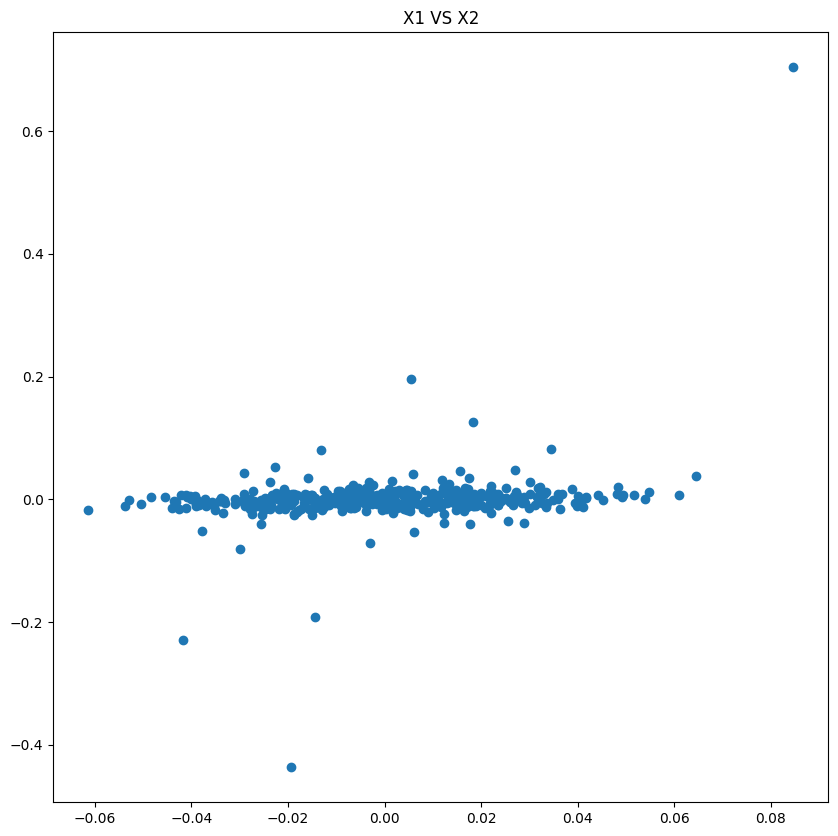

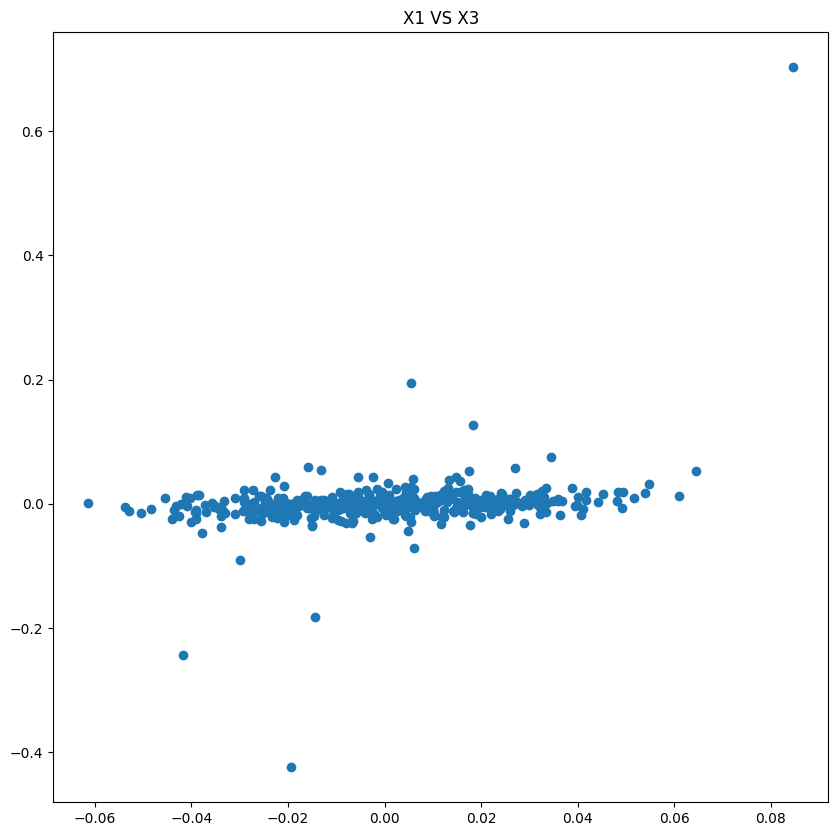

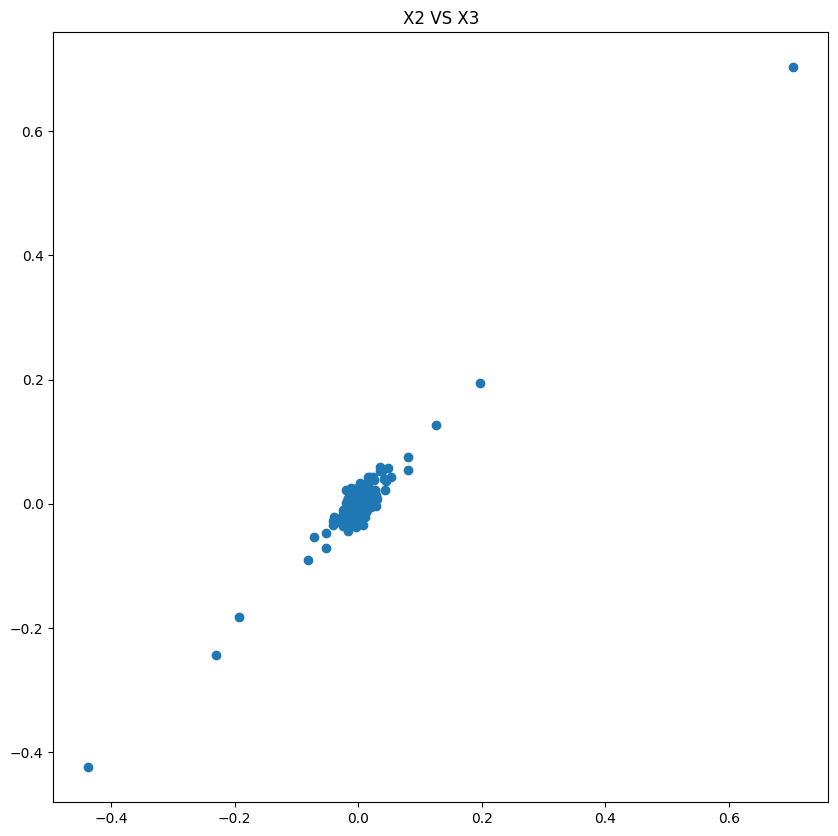

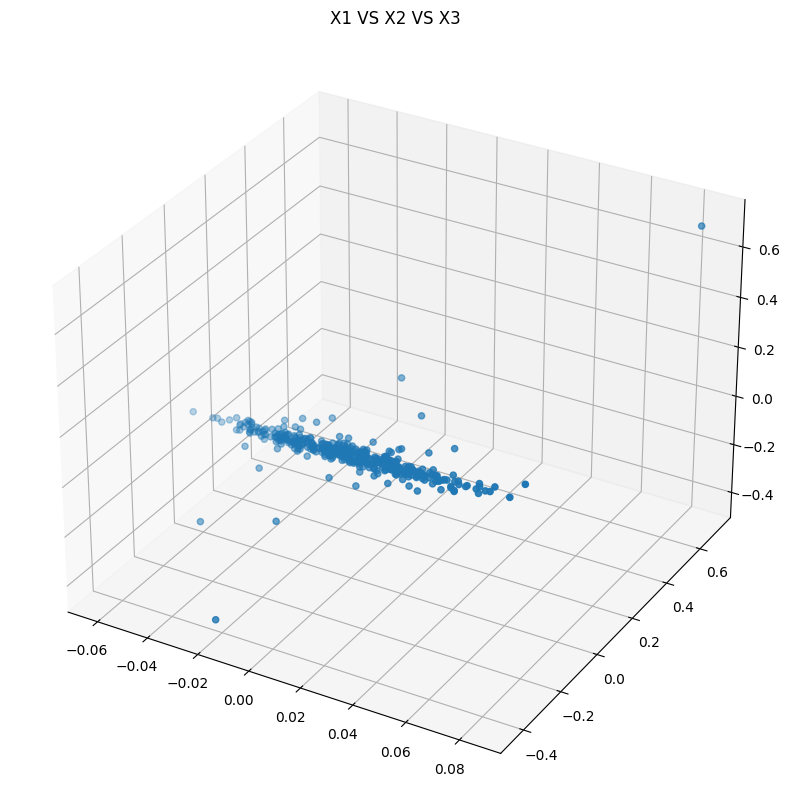

In [41]:
U, loss, outputs = solver.test(views, apply_linear_gcca)
for i in range(len(outputs)):
    outputs[i] = outputs[i].cpu()
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(10,10))
        plt.scatter(outputs[i],outputs[j])
        plt.title('X'+str(i+1)+' VS X'+str(j+1))
        plt.show()
fig = plt.figure(figsize=(10,10))
ax3d = fig.add_subplot(projection='3d')
ax3d.scatter(outputs[0],outputs[1],outputs[2]) 
plt.title('X1 VS X2 VS X3')
plt.show()


In [3]:
# Hyper Params Section
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using", torch.cuda.device_count(), "GPUs")


Exp_label = pd.read_csv('C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/Exp664_genes.txt', sep='\t',header = None)
Exp_list = Exp_label.iloc[:, 0].values.tolist()
Exp = pd.DataFrame(np.loadtxt("C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/Exp664.txt").T,columns = Exp_label)

Meth_label = pd.read_csv('C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/Meth664_probes.txt', sep='\t',header = None)
Meth_list = Meth_label.iloc[:, 0].values.tolist()
Meth = pd.DataFrame(np.loadtxt("C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/Meth664.txt").T,columns = Meth_label)

miRNA_label = pd.read_csv('C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/miRNA664_miRNA.txt', sep='\t',header = None)
miRNA_list = miRNA_label.iloc[:, 0].values.tolist()
miRNA = pd.DataFrame(np.loadtxt("C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/miRNA664.txt").T,columns = miRNA_label)

y = pd.read_csv('C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/PAM50label664.txt',header = None)

Exp_value = np.loadtxt("C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/Exp664.txt")
Meth_value = np.loadtxt("C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/Meth664.txt")
miRNA_value = np.loadtxt("C:/Users/Programer/Documents/GitHub/SGCCA_HSIC/SGCCA_HSIC/RealData/miRNA664.txt")
views = [torch.tensor(Exp_value).T,torch.tensor(Meth_value).T,torch.tensor(miRNA_value).T]

print(f'input views shape :')
for i, view in enumerate(views):
    print(f'view_{i} :  {view.shape}')
    view = view.to("cpu")

for _ in range(1):

    # size of the input for view 1 and view 2
    input_shape_list = [view.shape[-1] for view in views]

    # Building, training, and producing the new features by DCCA
    model = DeepGCCA(layer_sizes_list, input_shape_list, outdim_size,
                             use_all_singular_values, device=device).double()
    l_gcca = None
    if apply_linear_gcca:
        l_gcca = linear_gcca
    solver = Solver(model, l_gcca, outdim_size, epoch_num, batch_size,
                    learning_rate, reg_par, device=device)
    # train1, train2 = data1[0][0], data2[0][0]
    # val1, val2 = data1[1][0], data2[1][0]
    # test1, test2 = data1[2][0], data2[2][0]

    solver.fit(views, checkpoint=save_name)
    
    # TODO: Save l_gcca model if needed
    _ , _, outputs_def = solver.test(test, apply_linear_gcca)

    A = outputs_def[0]
    B = outputs_def[1]
    C = outputs_def[2]
    U = [A,B,C]

    A = outputs_def[0]
    B = outputs_def[1]
    C = outputs_def[2]

    os = [A,B,C]
    U_sum.append(U)
    outputs_sum.append(os)

Using 0 GPUs


[ INFO : 2023-07-20 17:17:36,389 ] - DeepGCCA(
  (model_list): ModuleList(
    (0): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=2642, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=1, bias=True)
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
      )
    )
    (1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(

input views shape :
view_0 :  torch.Size([664, 2642])
view_1 :  torch.Size([664, 3298])
view_2 :  torch.Size([664, 437])


[ INFO : 2023-07-20 17:17:36,704 ] - Epoch 2/100 - time: 0.15 - training_loss: -2.6507
[ INFO : 2023-07-20 17:17:36,855 ] - Epoch 3/100 - time: 0.15 - training_loss: -2.4398
[ INFO : 2023-07-20 17:17:37,008 ] - Epoch 4/100 - time: 0.15 - training_loss: -2.4575
[ INFO : 2023-07-20 17:17:37,199 ] - Epoch 5/100 - time: 0.19 - training_loss: -2.5866
[ INFO : 2023-07-20 17:17:37,351 ] - Epoch 6/100 - time: 0.15 - training_loss: -2.7794
[ INFO : 2023-07-20 17:17:37,497 ] - Epoch 7/100 - time: 0.15 - training_loss: -3.0160
[ INFO : 2023-07-20 17:17:37,665 ] - Epoch 8/100 - time: 0.17 - training_loss: -3.2897
[ INFO : 2023-07-20 17:17:37,835 ] - Epoch 9/100 - time: 0.17 - training_loss: -3.5514
[ INFO : 2023-07-20 17:17:37,990 ] - Epoch 10/100 - time: 0.15 - training_loss: -3.8371
[ INFO : 2023-07-20 17:17:38,134 ] - Epoch 11/100 - time: 0.14 - training_loss: -4.1099
[ INFO : 2023-07-20 17:17:38,294 ] - Epoch 12/100 - time: 0.16 - training_loss: -4.3767
[ INFO : 2023-07-20 17:17:38,465 ] - Epo

[ INFO : 2023-07-20 17:17:51,652 ] - Epoch 96/100 - time: 0.18 - training_loss: -8.1794
[ INFO : 2023-07-20 17:17:51,811 ] - Epoch 97/100 - time: 0.16 - training_loss: -8.1876
[ INFO : 2023-07-20 17:17:51,949 ] - Epoch 98/100 - time: 0.14 - training_loss: -8.1957
[ INFO : 2023-07-20 17:17:52,129 ] - Epoch 99/100 - time: 0.18 - training_loss: -8.2034
[ INFO : 2023-07-20 17:17:52,275 ] - Epoch 100/100 - time: 0.14 - training_loss: -8.2113
C:\Users\Programer\Documents\GitHub\SGCCA_HSIC\SGCCA_HSIC\OtherMethods\linear_gcca.py:63: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2431.)
  Q, R = M_tilde.qr()


NameError: name 'test' is not defined

In [6]:
from gcca.gcca import GCCA
import logging
import numpy as np

# set log level
logging.root.setLevel(level=logging.INFO)

# create data in advance
a = np.random.rand(50, 50)
b = np.random.rand(50, 60)
c = np.random.rand(50, 70)
d = np.random.rand(50, 80)
e = np.random.rand(50, 90)
f = np.random.rand(50, 100)
g = np.random.rand(50, 110)
h = np.random.rand(50, 120)
i = np.random.rand(50, 130)
j = np.random.rand(50, 140)
k = np.random.rand(50, 150)

# create instance of GCCA
gcca = GCCA()
# calculate GCCA
gcca.fit(a, b, c, d, e, f, g, h, i, j, k)
# transform
gcca.transform(a, b, c, d, e, f, g, h, i, j, k)
# save
gcca.save_params("save/gcca.h5")
# load
gcca.load_params("save/gcca.h5")
# plot
gcca.plot_gcca_result()

2023-07-20 17:28:40,962 : gcca.gcca : INFO : data num is 11
2023-07-20 17:28:40,962 : gcca.gcca : INFO : data shape x_0: (50, 50)
2023-07-20 17:28:40,963 : gcca.gcca : INFO : data shape x_1: (50, 60)
2023-07-20 17:28:40,963 : gcca.gcca : INFO : data shape x_2: (50, 70)
2023-07-20 17:28:40,964 : gcca.gcca : INFO : data shape x_3: (50, 80)
2023-07-20 17:28:40,964 : gcca.gcca : INFO : data shape x_4: (50, 90)
2023-07-20 17:28:40,964 : gcca.gcca : INFO : data shape x_5: (50, 100)
2023-07-20 17:28:40,965 : gcca.gcca : INFO : data shape x_6: (50, 110)
2023-07-20 17:28:40,965 : gcca.gcca : INFO : data shape x_7: (50, 120)
2023-07-20 17:28:40,965 : gcca.gcca : INFO : data shape x_8: (50, 130)
2023-07-20 17:28:40,966 : gcca.gcca : INFO : data shape x_9: (50, 140)
2023-07-20 17:28:40,966 : gcca.gcca : INFO : data shape x_10: (50, 150)
2023-07-20 17:28:40,967 : gcca.gcca : INFO : normalizing


NameError: name 'xrange' is not defined